In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import mpl_toolkits
import pandas as pd 
import netCDF4
import os
from matplotlib.lines import Line2D
os.environ['PROJ_LIB'] = 'C:/Users/renee/anaconda3/Lib/site-packages/mpl_toolkits/basemap'
os.environ['GMT_LIBRARY_PATH']=r'C:\Users\USERNAME\Anaconda3\envs\pygmt\Library\bin'
from mpl_toolkits.basemap import Basemap 
from mpl_toolkits.axes_grid1 import ImageGrid
from scipy.interpolate import griddata
from scipy import stats
from matplotlib.patches import Wedge
import proplot as plot
import pyproj
from astropy.time import Time 
import h5py
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
from netCDF4 import Dataset
from mpl_toolkits.basemap import Basemap
from itertools import chain
import sys
from scipy import interpolate
from netCDF4 import Dataset,num2date
pd.options.mode.chained_assignment = None


# Say, "the default sans-serif font is COMIC SANS"
mpl.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
from matplotlib.colors import LinearSegmentedColormap,rgb2hex
from scipy.stats import linregress

cmap = plt.cm.get_cmap('Blues')
cmap_qual2 = [cmap(1/6), cmap(2/6), cmap(3/6), cmap(4/6), cmap(5/6), cmap(6/6)]

cmap_qual_green = LinearSegmentedColormap.from_list('list', ['green', 'gray'], N = 2)

'''cmap_qual = ['#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00', '#CC79A7', 'darkorange']
cmap_qual = LinearSegmentedColormap.from_list('list', cmap_qual, N = len(cmap_qual))'''
cmap_check = plt.cm.get_cmap('BuRd_r')
cmap_qual = [rgb2hex(cmap_check((0/8))),rgb2hex(cmap_check((1/8))),rgb2hex(cmap_check((2/8))), rgb2hex(cmap_check((3/8))),
            rgb2hex(cmap_check((5/8))), rgb2hex(cmap_check(6/8)), rgb2hex(cmap_check(7/8)), rgb2hex(cmap_check(8/8)), cmap_qual_green(1)]

    
#cmap_qual = [rgb2hex(cmap_check((0/8))),rgb2hex(cmap_check((1/8))),rgb2hex(cmap_check((2/8))), rgb2hex(cmap_check((3/8))),
#             cmap(1/6), cmap(2/6), cmap(3/6), cmap(4/6), cmap(5/6), cmap(6/6)]
cmap_qual = LinearSegmentedColormap.from_list('list', cmap_qual, N = len(cmap_qual))

### Load and prep CS

In [337]:
#def load_data(path, fp):
#    nc_file = netCDF4.Dataset(path + '/' + fp, 'r')
#    sea_ice_freeboard = nc_file.variables['freeboard_20_ku'][:]
#    lat = nc_file.variables['lat_poca_20_ku'][:]
#    lon = nc_file.variables['lon_poca_20_ku'][:]
    
#    return  lon, lat, sea_ice_freeboard

def get_valid_freeboard_flag(flag): 
    """
    flag_masks = 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144, 524288, 1048576, 2097152, 4194304, 8388608, 16777216, 33554432, 67108864, 134217728, 268435456; // int 
    
    removed flags in dict_error: 
    #        'sarin_bad_velocity'       : 2,
    #        'sarin_out_of_range'       : 4,
    #        'sarin_bad_baseline'       : 8,
    #        'delta_time_error'         :32,
    #        'mispointing_error'        :64,
    #        'sarin_height_ambiguous'   :2048,
    
    """

    dict_error= {
        'calibration_warning'      : 1,
        'sarin_bad_velocity'       : 2,
        'sarin_out_of_range'       : 4,
        'sarin_bad_baseline'       : 8,
        'delta_time_error'         :32,
        'mispointing_error'        :64,
        'sarin_side_redundant'     :256,
        'sarin_rx_2_error'         :512,
        'sarin_rx_1_error'         :1024,
        'sarin_height_ambiguous'   :2048,
        'surf_type_class_ocean'    :32768,
        'freeboard_error'          :65536,
        'peakiness_error'          :131072,
        'ssha_interp_error'        :262144,
        'orbit_discontinuity'      :33554432,
        'orbit_error'              :67108864,
        'height_sea_ice_error'     :268435456,
        }

    all_flag= {
        'calibration_warning'      : 1,
        'sarin_bad_velocity'       : 2,
        'sarin_out_of_range'       : 4,
        'sarin_bad_baseline'       : 8,
        'lrm_slope_model_invalid'  :16,
        'delta_time_error'         :32,
        'mispointing_error'        :64,
        'surface_model_unavailable':128,
        'sarin_side_redundant'     :256,
        'sarin_rx_2_error'         :512,
        'sarin_rx_1_error'         :1024,
        'sarin_height_ambiguous'   :2048,
        'surf_type_class_undefined':4096,
        'surf_type_class_sea_ice'  :8192,
        'surf_type_class_lead'     :16384,
        'surf_type_class_ocean'    :32768,
        'freeboard_error'          :65536,
        'peakiness_error'          :131072,
        'ssha_interp_error'        :262144,
        'sig0_3_error'             :524288,
        'sig0_2_error'             :1048576,
        'sig0_1_error'             :2097152,
        'height_3_error'           :4194304,
        'height_2_error'           :8388608,
        'height_1_error'           :16777216,
        'orbit_discontinuity'      :33554432,
        'orbit_error'              :67108864,
        'block_degraded'           :134217728,
        'height_sea_ice_error'     :268435456,
        }

    # sea ice class
    flag_seaice = np.bitwise_and(flag, all_flag['surf_type_class_sea_ice'])/all_flag['surf_type_class_sea_ice']

    # errors
    flag_error = np.zeros(flag.size)
    for key in dict_error.keys():
        flag0_error = np.bitwise_and(flag,dict_error[key])/dict_error[key]
        flag_error = np.logical_or(flag0_error,flag_error)

    flag_valid_fb = flag_seaice - flag_error
    flag_valid_fb[flag_valid_fb<0] =0


    return flag_valid_fb

def fit2(lat, lat2,  h, degree):
    p_fit = np.polyfit(lat, h, degree)
    p_val = np.polyval(p_fit, lat2)
    return p_val

def NN_search(df_CS2_new, df_IS2):
    from sklearn.neighbors import BallTree
    import numpy as np
    import pandas as pd

    query_lats = df_CS2_new[['lat']].to_numpy()
    query_lons = df_CS2_new[['lon']].to_numpy()

    tree = BallTree(np.deg2rad(df_IS2[['lat', 'lon']].values), leaf_size =15, metric='haversine')

    distances, indices = tree.query(np.deg2rad(np.c_[query_lats, query_lons]), k=1)
    
    mss_interp = [], [], [],[]
    for i in indices:
        mss_interp = np.append(mss_interp, df_IS2['mss'][int(i)])

    return mss_interp

def load_data(fp1,fp2):
    from scipy.interpolate import interp1d, UnivariateSpline
    import datetime # Python standard library datetime module
    from netCDF4 import Dataset,num2date # http://unidata.github.io/netcdf4-python/

    ds = netCDF4.Dataset(fp1, 'r')
    
    sea_ice_freeboard = ds.variables['freeboard_20_ku'][:]
    lat = ds.variables['lat_poca_20_ku'][:]
    lon = ds.variables['lon_poca_20_ku'][:]
    time = ds.variables['time_20_ku'][:]
    flag = ds.variables[ 'flag_prod_status_20_ku'][:]
    flag_valid = get_valid_freeboard_flag(flag)
    mss = ds.variables['mean_sea_surf_sea_ice_01'][:]
    lat_01 = ds.variables['lat_01'][:]
    lon_01 = ds.variables['lon_01'][:]
    
    #mss_interp = fit2(lat_01, lat, mss, 2)
    #mss_interp = f(lon, lat)
    #f1 = interp1d(lat_01, mss, kind='cubic')
    #mss_interp = f1(lat)
    #sif_no_mss = sea_ice_freeboard # - mss_interp[0]
    
    df_1hz = pd.DataFrame({'lat':lat_01, 'lon':lon_01, 'mss':mss})
    df_20hz = pd.DataFrame({'lat':lat, 'lon':lon})
    mss_interp = NN_search(df_20hz, df_1hz)
    sif_no_mss = sea_ice_freeboard-mss_interp
    
    tname = "time_20_ku"
    nctime = ds.variables[tname][:] # get values
    t_unit = ds.variables[tname].units # get unit  "days since 1950-01-01T00:00:00Z"
    t_cal = ds.variables[tname].calendar
    tvalue = num2date(nctime,units = t_unit,calendar = t_cal)
    #str_time = [i.strftime("%Y-%m-%d %H:%M:%S") for i in tvalue] # to display dates as string
    str_time = [str(i) for i in tvalue]
    
    ds2 = netCDF4.Dataset(fp2, 'r')
    ssd =  ds2.variables['stack_std_20_ku'][:]
    pwr_waveform = ds2.variables['pwr_waveform_20_ku'][:]
    ppk = []
    #for i in pwr_waveform:
    #    calc_pp = []
    #    pp = np.max(i)/np.mean(i)
    #    ppk = np.append(ppk,pp)

    for i in pwr_waveform:
        calc_pp = []
        noise = np.nanmean(i[10:19])
        i = i[i>noise]

        pp = np.nanmax(i)/np.nanmean(i)
        ppk = np.append(ppk,pp)
    
    df = pd.DataFrame({'sif':sea_ice_freeboard, 'lat':lat, 'lon':lon, 'flag':flag_valid, 'mss':mss_interp, 'ssd':ssd, 'ppk':ppk, 'time':str_time})
    
    df = df[df['lat']>60]
    df = df[df['flag']==1]  
    df=df.reset_index(drop=True)
    
    lon_filtered = np.array(df['lon'])
    lat_filtered = np.array(df['lat'])
    fb_filtered = np.array(df['sif'])
    mss_filtered = np.array(df['mss'])
    ssd_filtered = np.array(df['ssd'])
    ppk_filtered = np.array(df['ppk'])
    time_filtered = np.array(df['time'])
    return lon_filtered, lat_filtered, fb_filtered, mss_filtered, ssd_filtered,ppk_filtered, time_filtered

    

### Read and prepare ICESat-2 data to seperate granules

In [338]:
import pyproj
from astropy.time import Time 
import h5py
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
from netCDF4 import Dataset
from mpl_toolkits.basemap import Basemap
from itertools import chain
import sys

def list_files_local(path):
    ''' Get file list from local folder. '''
    from glob import glob
    return glob(path)

def gps2dyr(time):
    '''Convert GPS time to decimal years'''
    return Time(time, format='gps').decimalyear

def track_type(time, lat, tmax=1):
    '''
    Separate tracks into ascending and descending. 
    
    Defines tracks as segments with time breaks > tmax , 
    and tests whether lat increases or decreases w/time.
    '''
    tracks = np.zeros(lat.shape) # generates track segment
    tracks[0:np.argmax(np.abs(lat))] = 1 # set values for segment
    i_asc = np.zeros(tracks.shape, dtype=bool) # output index array 
    
    # loop through individual segments
    for track in np.unique(tracks):
        
        i_track, = np.where(track == tracks) # get all pts from seg
        
        if len(i_track) < 2: continue
            
        # Test if lat increase (asc) or descreases (des) with time
        i_min = time[i_track].argmin()
        i_max = time[i_track].argmax()
        lat_diff = lat[i_track][i_max] - lat[i_track][i_min]
        
        # Determine track trype
        if lat_diff > 0: i_asc[i_track] = True
            
    return i_asc, np.invert(i_asc)

def transform_coord(proj1, proj2, x, y):
    '''
    Transform coordinates from proj1 to proj2 (EPSG num). 
    
    Example EPSG projs: 
        Geodetic (lon/lat): 4326
        Polar Stereo AnIS (x/y): 3031
        Polar Stereo GrIS (x/y): 3413
    '''
    # Set full EPSG projection strings 
    proj1 = pyproj.Proj("+init=EPSG:"+str(proj1))
    proj2 = pyproj.Proj("+init=EPSG:"+str(proj2))
    return pyproj.transform(proj1, proj2, x, y)  # convert

def read_h5(fname, vnames=[]):
    '''Simple HDF5 reader'''
    with h5py.File(fname, 'r') as f:
        return [f[v][:] for v in vnames]

### Simple reader

In [339]:
def read_data(fname, bbox=None):
    '''
    Read ATL03 data file and output 6 reduced files. 
    
    Extract variables of interest and separate the ATL03 file
    into each beam (ground track) and ascending/descending orbits. 
    '''
    
    # Each beam is a group 
    group = ['/gt1l', '/gt1r', '/gt2l', '/gt2r', '/gt3l', '/gt3r']
    
    # Loop through beams
    for k,g in enumerate(group):
    
        #-----------------------------------#
        # 1) Read in data for a single beam #
        #-----------------------------------#
    
        # Load variables into memory (more can be added!)
        with h5py.File(fname, 'r') as fi:
            #sc = fi['/orbit_info/sc_orient'][:]
            
            #if sc == 1:
            #    g = ['/gt3r', '/gt3l', '/gtl2r', '/gt2l', '/gt1r', '/gt1l']   
                
            lat_fb = fi[g+ '/freeboard_beam_segment/beam_freeboard/latitude'][:]
            lon_fb = fi[g+ '/freeboard_beam_segment/beam_freeboard/longitude'][:]
            fb = fi[g+ '/freeboard_beam_segment/beam_freeboard/beam_fb_height'][:]
            gw_fb = fi[g+ '/freeboard_beam_segment/height_segments/height_segment_w_gaussian'][:]
            mss = fi[g+ '/freeboard_beam_segment/geophysical/height_segment_mss'][:]
            mean_tide = fi[g+ '/freeboard_beam_segment/geophysical/height_segment_geoid_free2mean'][:]
            #SET_corr = fi[g+ '/freeboard_beam_segment/geophysical/height_segment_earth'][:]
            SET_corr = fi[g+ '/freeboard_beam_segment/geophysical/height_segment_earth_free2mean'][:]
            #mss_meantide = mss-(mean_tide+SET_corr)#+SET_corr
            mss_meantide = mss+mean_tide+SET_corr
            
            #lat_lead = fi[g+ '/leads/latitude'][:]
            #lon_lead = fi[g+ '/leads/longitude'][:]
            #orb = np.full_like(h_ph, k)
        #---------------------------------------------#
        # 2) Filter data according region and quality #
        #---------------------------------------------#
       
        # Test for no data
        #if len(lat_fb) == 0: continue

        #-------------------------------------#
        # 3) Convert time and separate tracks #
        #-------------------------------------#
        
        # Time in GPS seconds (secs since 1980...)
        #t_gps, delta_t_gps = t_ref + t_dt, t_ref + delta_t

        # Time in decimal years
        #t_year, delta_t_year = gps2dyr(t_gps), gps2dyr(delta_t_gps)

        # Determine orbit type
        #i_asc, i_des = track_type(t_year, lat)
        
        #-----------------------#
        # 4) Save selected data #
        #-----------------------#
        
        # Define output file name
        ofile = fname.replace('.h5', '_'+g[1:]+'_no_mss_corr_v5.h5')
                
        # Save variables
        with h5py.File(ofile, 'w') as f:
            #f['orbit'] = orb
            f['lon_fb'] = lon_fb
            f['lat_fb'] = lat_fb
            f['fb'] = fb - mss_meantide
            f['gw'] = gw_fb
            f['fb_with_mss'] = fb
            f['mss']=mss_meantide
            #f['lon_lead'] = lon_lead
            #f['lat_lead'] = lat_lead
            
            print('out ->', ofile)

### Preparation 

In [340]:
def plot_panArctic(lon, lat, sit, min_set, max_set, cmap_set, label, extend_info, ax, fig):
    #fig = plt.figure(figsize=(6,5))
    fig.patch.set_facecolor('white')
    #ax = plt.gca()
    #m = Basemap(projection='ortho',lat_0=90,lon_0=0,resolution='l', ax=ax);
    x1 = -180
    x2 = 180
    y1 = 0
    y2 = 90

    m = Basemap(projection='npstere', llcrnrlat=y1,urcrnrlat=y2,llcrnrlon=x1,urcrnrlon=x2,boundinglat=70,lon_0=0, resolution='l',ax=ax, round=True)
    m.drawmeridians(np.arange(0,360,30),labels=[1,1,1,1],linewidth=0.5, fontsize=14, dashes=[1,5])
    m.drawparallels(np.arange(-90,90,5),linewidth=0.5, fontsize=14, dashes=[1,5])
    m.drawcoastlines(linewidth=0.5)
    m.fillcontinents(color='gray')
    m.drawmapboundary(fill_color='black')
    x=m.scatter(lon, lat, latlon=True, c=sit, s=0.05,vmin = min_set, vmax=max_set, cmap=cmap_set)
    #cbar = plt.colorbar(x, extend =extend_info, orientation="horizontal",ax=ax)
    #cbar.set_label(label)

    ax.set_title(title, y=1.08,fontsize=18)
    return x

def plot_panArctic2(lon, lat, sit, min_set, max_set, cmap_set, label, extend_info, ax, fig):
    #fig = plt.figure(figsize=(6,5))
    fig.patch.set_facecolor('white')
    #ax = plt.gca()
    #m = Basemap(projection='ortho',lat_0=90,lon_0=0,resolution='l', ax=ax);
    x1 = -180
    x2 = 180
    y1 = 0
    y2 = 90

    m = Basemap(projection='npstere', llcrnrlat=y1,urcrnrlat=y2,llcrnrlon=x1,urcrnrlon=x2,boundinglat=70,lon_0=0, resolution='l',ax=ax, round=True)
    #m.drawmeridians(np.arange(0,360,30),labels=[1,1,1,1],linewidth=0.5, fontsize=14, dashes=[1,5])
    #m.drawparallels(np.arange(-90,90,20),linewidth=0.5, fontsize=14, dashes=[1,5])
    m.drawcoastlines(linewidth=0.5)
    m.fillcontinents(color='gray')
    m.drawmapboundary(fill_color='black')
    x=m.scatter(lon, lat, latlon=True, c=sit, s=0.05,vmin = min_set, vmax=max_set, cmap=cmap_set)
    #cbar = plt.colorbar(x, extend =extend_info, orientation="horizontal",ax=ax)
    #cbar.set_label(label)

    ax.set_title(title, y=1.08,fontsize=18)
    return x

### Prep MMS

In [ ]:
def load_data2(path, fp, lon_var, lat_var, fb_var):
    nc_file = netCDF4.Dataset(path + '/' + fp, 'r')
    lon = np.array(nc_file.variables[lon_var][:], dtype=np.float32)
    lat = np.array(nc_file.variables[lat_var][:], dtype=np.float32)
    fb = np.array(nc_file.variables[fb_var][:], dtype=np.float32)
    
    return  lon, lat, fb

def prep_data(path, fp):
    lon, lat,MSS = load_data2(path, fp, 'lon', 'lat', 'mss')

    lon_mesh, lat_mesh = np.meshgrid(lon, lat)
    lat_T, lon_T, MSS_T = lat_mesh.flatten(), lon_mesh.flatten(), MSS.flatten()
    df_DTU21 = pd.DataFrame({'lat':lat_T, 'lon':lon_T, 'MSS':MSS_T})
    df_DTU21 = df_DTU21[(df_DTU21['lat']>60)].reset_index(drop=True)
    del lon, lat, MSS, lon_mesh, lat_mesh, lat_T, lon_T, MSS_T
    
    return df_DTU21

def grid_data(lat_ori, lon_ori, var_ori, ref_lat, ref_lon, method_name):
    grid_var = griddata((lon_ori.flatten(), lat_ori.flatten()), var_ori.flatten(), (ref_lon, ref_lat), method=method_name)
    
    return grid_var

In [ ]:
path = r'C:\Users\rmfha\Downloads'
fp = 'DTU21MSS_1min.mss.nc'
df_DTU21 = prep_data(path, fp)

In [ ]:
### GENERATE COARSER GRID (0.05 X 0.05 DEGREES)
lon = np.arange(0, 360, 0.05) 
lat = np.arange(60, 90, 0.05) 
lon2d, lat2d = np.meshgrid(lon, lat)   

### GRID DTU21MSS TO COARSER GRID
grid_DTU21 = grid_data(np.array(df_DTU21['lon']), np.array(df_DTU21['lat']), np.array(df_DTU21['MSS']), lon2d, lat2d, 'nearest')

### PREP DATAFRAME WITH DTU21MSS IN COARSER GRID
df_grid_DTU21 = pd.DataFrame({'lat':lat2d.flatten(), 'lon':lon2d.flatten(), 'MSS':grid_DTU21.flatten()})


# Load IS2 ATL10 data and prep with simple reader

In [336]:
files = !ls E:/DTU/CRYO2ICE/Data/CRYO2ICE_data/IS2/Monthly_data/November/*_02.h5
files

['E:/DTU/CRYO2ICE/Data/CRYO2ICE_data/IS2/Monthly_data/November/ATL10-01_20201102092337_05990901_005_02.h5',
 'E:/DTU/CRYO2ICE/Data/CRYO2ICE_data/IS2/Monthly_data/November/ATL10-01_20201105001511_06390901_005_02.h5',
 'E:/DTU/CRYO2ICE/Data/CRYO2ICE_data/IS2/Monthly_data/November/ATL10-01_20201105014928_06400901_005_02.h5',
 'E:/DTU/CRYO2ICE/Data/CRYO2ICE_data/IS2/Monthly_data/November/ATL10-01_20201106060641_06580901_005_02.h5',
 'E:/DTU/CRYO2ICE/Data/CRYO2ICE_data/IS2/Monthly_data/November/ATL10-01_20201106074058_06590901_005_02.h5',
 'E:/DTU/CRYO2ICE/Data/CRYO2ICE_data/IS2/Monthly_data/November/ATL10-01_20201108174942_06960901_005_02.h5',
 'E:/DTU/CRYO2ICE/Data/CRYO2ICE_data/IS2/Monthly_data/November/ATL10-01_20201108192359_06970901_005_02.h5',
 'E:/DTU/CRYO2ICE/Data/CRYO2ICE_data/IS2/Monthly_data/November/ATL10-01_20201108223234_06990901_005_02.h5',
 'E:/DTU/CRYO2ICE/Data/CRYO2ICE_data/IS2/Monthly_data/November/ATL10-01_20201110011530_07160901_005_02.h5',
 'E:/DTU/CRYO2ICE/Data/CRYO2

In [ ]:
len(files)

In [ ]:
njobs = 25

# bbox = [lonmin, lonmax, latmin, latmax]
bbox = [0,360, 60, 90]

if njobs == 1:
    print('running in serial ...')
    [read_data(f, bbox) for f in files]

else:
    print('running in parallel (%d jobs) ...' % njobs)
    from joblib import Parallel, delayed
    Parallel(n_jobs=njobs, verbose=5)(delayed(read_data)(f, bbox) for f in files)

In [ ]:
len(files_check_IS2)

# Load prepared IS2 data after processed with simple-reader

In [349]:
files_check_CS2_L1b = !ls E:/DTU/CRYO2ICE/Data/CRYO2ICE_data/CS2/Monthly_data/L1b/November/*.nc
files_check_CS2_L1b

files_check_CS2_L2 = !ls E:/DTU/CRYO2ICE/Data/CRYO2ICE_data/CS2/Monthly_data/L2/November/*.nc
files_check_CS2_L2

files_check_IS2a = !ls E:/DTU/CRYO2ICE/Data/CRYO2ICE_data/IS2/Monthly_data/November/*_gt1l_no_mss_corr.h5
files_check_IS2a

files_check_IS2b = !ls E:/DTU/CRYO2ICE/Data/CRYO2ICE_data/IS2/Monthly_data/November/*_gt2l_no_mss_corr.h5
files_check_IS2b

files_check_IS2c = !ls E:/DTU/CRYO2ICE/Data/CRYO2ICE_data/IS2/Monthly_data/November/*_gt3l_no_mss_corr.h5
files_check_IS2c

['E:/DTU/CRYO2ICE/Data/CRYO2ICE_data/IS2/Monthly_data/November/ATL10-01_20201102092337_05990901_005_02_gt3l_no_mss_corr.h5',
 'E:/DTU/CRYO2ICE/Data/CRYO2ICE_data/IS2/Monthly_data/November/ATL10-01_20201105001511_06390901_005_02_gt3l_no_mss_corr.h5',
 'E:/DTU/CRYO2ICE/Data/CRYO2ICE_data/IS2/Monthly_data/November/ATL10-01_20201105014928_06400901_005_02_gt3l_no_mss_corr.h5',
 'E:/DTU/CRYO2ICE/Data/CRYO2ICE_data/IS2/Monthly_data/November/ATL10-01_20201106060641_06580901_005_02_gt3l_no_mss_corr.h5',
 'E:/DTU/CRYO2ICE/Data/CRYO2ICE_data/IS2/Monthly_data/November/ATL10-01_20201106074058_06590901_005_02_gt3l_no_mss_corr.h5',
 'E:/DTU/CRYO2ICE/Data/CRYO2ICE_data/IS2/Monthly_data/November/ATL10-01_20201108174942_06960901_005_02_gt3l_no_mss_corr.h5',
 'E:/DTU/CRYO2ICE/Data/CRYO2ICE_data/IS2/Monthly_data/November/ATL10-01_20201108192359_06970901_005_02_gt3l_no_mss_corr.h5',
 'E:/DTU/CRYO2ICE/Data/CRYO2ICE_data/IS2/Monthly_data/November/ATL10-01_20201108223234_06990901_005_02_gt3l_no_mss_corr.h5',


In [ ]:
#files_check_CS2_L2 = !ls E:/DTU/CRYO2ICE/Data/CS2/tool_download/L2/April/*.nc
#files_check_CS2_L2

In [ ]:
#files_check_IS2 = !ls E:/DTU/CRYO2ICE/Data/IS2/tool_download/April/*_gt2l_no_mss_corr.h5
#files_check_IS2

# Run all data at once

In [348]:
def load_all_data(k, files_check_IS2a, files_check_IS2b, files_check_IS2c, files_check_CS2_L2, files_check_CS2_L1b):
    
    ### IS2
    #lon_gt2l, lat_gt2l,fb_gt2l, gw_gt2l, fb_mss, mss = read_h5(files_check_IS2[k], ['lon_fb', 'lat_fb', 'fb', 'gw', 'fb_with_mss', 'mss'])
    #gw_gt2l[fb_gt2l>5] = np.nan
    #fb_gt2l[fb_gt2l>5] = np.nan

    #df_IS2 = pd.DataFrame({'lat':lat_gt2l, 'lon':lon_gt2l, 'fb':fb_gt2l, 'gw':gw_gt2l, 'fb_with_mss':fb_mss, 'mss_IS2':mss})
    #df_IS2 = df_IS2.dropna().reset_index()
    
    #lon_gt2l, lat_gt2l,fb_gt2l, gw_gt2l, fb_mss, mss = read_h5(files_check_IS2[k], ['lon_fb', 'lat_fb', 'fb', 'gw', 'fb_with_mss', 'mss'])
    lon_gt2l, lat_gt2l,fb_gt2l, gw_gt2l, fb_mss, mss = read_h5(files_check_IS2a[k], ['lon_fb', 'lat_fb', 'fb', 'gw', 'fb_with_mss', 'mss'])
    gw_gt2l[fb_gt2l>5] = np.nan
    fb_gt2l[fb_gt2l>5] = np.nan
    df_IS2a = pd.DataFrame({'lat':lat_gt2l, 'lon':lon_gt2l, 'fb':fb_gt2l, 'gw':gw_gt2l, 'fb_with_mss':fb_mss, 'mss_IS2':mss})
    df_IS2a['beam_ID']=1

    lon_gt2l, lat_gt2l,fb_gt2l, gw_gt2l, fb_mss, mss = read_h5(files_check_IS2b[k], ['lon_fb', 'lat_fb', 'fb', 'gw', 'fb_with_mss', 'mss'])
    gw_gt2l[fb_gt2l>5] = np.nan
    fb_gt2l[fb_gt2l>5] = np.nan
    df_IS2b = pd.DataFrame({'lat':lat_gt2l, 'lon':lon_gt2l, 'fb':fb_gt2l, 'gw':gw_gt2l, 'fb_with_mss':fb_mss, 'mss_IS2':mss})
    df_IS2b['beam_ID']=2

    lon_gt2l, lat_gt2l,fb_gt2l, gw_gt2l, fb_mss, mss = read_h5(files_check_IS2c[k], ['lon_fb', 'lat_fb', 'fb', 'gw', 'fb_with_mss', 'mss'])
    gw_gt2l[fb_gt2l>5] = np.nan
    fb_gt2l[fb_gt2l>5] = np.nan
    df_IS2c = pd.DataFrame({'lat':lat_gt2l, 'lon':lon_gt2l, 'fb':fb_gt2l, 'gw':gw_gt2l, 'fb_with_mss':fb_mss, 'mss_IS2':mss})
    df_IS2c['beam_ID']=3
    
    frames = [df_IS2a, df_IS2b, df_IS2c]
    df_IS2 = pd.concat(frames)
    df_IS2 = df_IS2.dropna().reset_index()
    
    ### CS2
    fp1 = files_check_CS2_L2[k]
    fp2 = files_check_CS2_L1b[k]
        
    lon, lat,fb, mss, ssd, ppk, time = load_data(fp1, fp2)
    df_CS2 = pd.DataFrame({'lat':lat, 'lon':lon, 'fb':fb, 'mss':mss, 'fb_no_mss':fb-mss, 'ssd':ssd, 'ppk':ppk, 'time':time})
    df_CS2 = df_CS2[(df_CS2['lat']>60)].reset_index()
    
    basename_without_ext = os.path.splitext(os.path.basename(fp1))[0]
    
    print('File '+str(k)+'/'+str(len(list_total)-1)+ ': ' + basename_without_ext)
    
    #fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(10,8), constrained_layout=True)

    #im = plot_panArctic2(np.array(df_CS2['lon']), np.array(df_CS2['lat']), 'r', 0, 0.5, 'viridis', 'radar freeboard (m)','max', ax[0],fig)
    #im=plot_panArctic2(np.array(df_IS2['lon']), np.array(df_IS2['lat']), 'g', 0, 0.5, 'viridis', 'radar freeboard (m)','max', ax[0],fig)

    #plt.colorbar(im, ax=ax[1], orientation = 'vertical', extend='both', shrink=0.5)
    #plt.show()
    
    return df_IS2, df_CS2, fp1

def CRYO2ICE_identify_IS2_data(df_CS2, df_IS2):
    from sklearn.neighbors import BallTree
    import numpy as np
    import pandas as pd

    query_lats = df_CS2[['lat']].to_numpy()
    query_lons = df_CS2[['lon']].to_numpy()

    tree = BallTree(np.deg2rad(df_IS2[['lat', 'lon']].values), leaf_size =15, metric='haversine')

    dist_in_metres = 3500
    earth_radius_in_metres = 6371*1000
    radius = dist_in_metres/earth_radius_in_metres

    #distances, indices = bt.query(np.deg2rad(np.c_[query_lats, query_lons]), k=1)
    is_within, distances = tree.query_radius(np.deg2rad(np.c_[query_lats, query_lons]), r=radius, count_only=False, return_distance=True) 
    distances_in_metres = distances*earth_radius_in_metres

    #data['satellite_lat'] = df_IS2['lat'][indices[0][:]]
    #data['satellite_lon'] = df_IS2['lon'][indices[0][:]]
    #data['min_distance'] = distances*6371*1000
    #data['IS2_id'] = df_IS2['GTL'][indices[0][:]]

    data = []
    for j in is_within:
        #print(j)
        for i in j:
            data=np.append(data,i)
            data2 = np.unique(data)

    df_IS2_new = df_IS2.iloc[data2]
    
    return df_IS2_new

def CRYO2ICE_identify_CS2_data(df_CS2, df_IS2):
    from sklearn.neighbors import BallTree
    import numpy as np
    import pandas as pd

    query_lats = df_IS2[['lat']].to_numpy()
    query_lons = df_IS2[['lon']].to_numpy()

    tree = BallTree(np.deg2rad(df_CS2[['lat', 'lon']].values), leaf_size =15, metric='haversine')

    dist_in_metres = 3500
    earth_radius_in_metres = 6371*1000
    radius = dist_in_metres/earth_radius_in_metres

    #distances, indices = bt.query(np.deg2rad(np.c_[query_lats, query_lons]), k=1)
    is_within, distances = tree.query_radius(np.deg2rad(np.c_[query_lats, query_lons]), r=radius, count_only=False, return_distance=True) 
    distances_in_metres = distances*earth_radius_in_metres

    data = []
    for j in is_within:
        for i in j:
            data=np.append(data,i)
            data2 = np.unique(data)

    df_CS2_new = df_CS2.iloc[data2]
    
    return df_CS2_new

def CRYO2ICE_identify_NN_IS2_new_data(df_CS2_new,df_IS2):
    from sklearn.neighbors import BallTree
    import numpy as np
    import pandas as pd

    ## Only data within 825 m of CryoSat-2 footprint (find approximate area of coincident data)
    query_lats = df_CS2_new[['lat']].to_numpy()
    query_lons = df_CS2_new[['lon']].to_numpy()

    tree = BallTree(np.deg2rad(df_IS2[['lat', 'lon']].values), leaf_size =15, metric='haversine')

    distances, indices = tree.query(np.deg2rad(np.c_[query_lats, query_lons]), k=1)
    
    data_check = df_CS2_new
    data_check['IS2_idx_NN'] = indices
    IS2_lat_NN, IS2_lon_NN, IS2_fb_NN, IS2_gw_NN = [], [], [],[]
    for i in indices:
        IS2_lat_NN = np.append(IS2_lat_NN, df_IS2['lat'][int(i)])
        IS2_lon_NN = np.append(IS2_lon_NN, df_IS2['lon'][int(i)])
        IS2_fb_NN = np.append(IS2_fb_NN, df_IS2['fb'][int(i)])
        IS2_gw_NN = np.append(IS2_gw_NN, df_IS2['gw'][int(i)])

    data_check['IS2_lat_NN'] = IS2_lat_NN
    data_check['IS2_lon_NN'] = IS2_lon_NN
    data_check['IS2_fb_NN'] = IS2_fb_NN
    data_check['IS2_gw_NN'] = IS2_gw_NN
    
    CRYO2ICE_bin_IS2_data_within_footprint(data_check, df_IS2)
    
    return data_check

def CRYO2ICE_bin_IS2_data_within_footprint(data_check, df_IS2):
    from sklearn.neighbors import BallTree
    import numpy as np
    import pandas as pd

    query_lats = data_check[['IS2_lat_NN']].to_numpy()
    query_lons = data_check[['IS2_lon_NN']].to_numpy()

    tree = BallTree(np.deg2rad(df_IS2[['lat', 'lon']].values), leaf_size =15, metric='haversine')

    dist_in_metres = 3500
    earth_radius_in_metres = 6371*1000
    radius = dist_in_metres/earth_radius_in_metres

    is_within, distances = tree.query_radius(np.deg2rad(np.c_[query_lats, query_lons]), r=radius, count_only=False, return_distance=True) 
    distances_in_metres = distances*earth_radius_in_metres
    
    mean_fb_IS2, mean_gw_IS2,std_fb_IS2, mss_IS2_mean, comb_fb, comb_std, comb_gw, num = [], [], [], [], [], [], [], []
    for i in is_within:
        data_fb_mean_IS2, data_gw_mean_IS2, data_mss_mean_IS2 = [], [],[]
        for j in i: 
            data_fb_mean_IS2 = np.append(data_fb_mean_IS2, df_IS2['fb'][j])
            data_gw_mean_IS2 = np.append(data_gw_mean_IS2, df_IS2['gw'][j])
            data_mss_mean_IS2 = np.append(data_mss_mean_IS2, df_IS2['mss_IS2'][j])
        
        
        #mean_fb_val = np.nanquantile(data_fb_mean_IS2, 0.80)
        #mean_fb_val = np.median(data_fb_mean_IS2)
        mean_fb_val = np.mean(data_fb_mean_IS2)
        std_fb_val = np.std(data_fb_mean_IS2)
        mean_fb_IS2 = np.append(mean_fb_IS2, mean_fb_val)
        std_fb_IS2 = np.append(std_fb_IS2, std_fb_val)

        mss_IS2_mean_val = np.mean(data_mss_mean_IS2)
        mss_IS2_mean = np.append(mss_IS2_mean,mss_IS2_mean_val)

        #mean_gw_val = np.nanquantile(data_gw_mean_IS2, 0.80)
        #mean_gw_val = np.median(data_gw_mean_IS2)
        mean_gw_val = np.mean(data_gw_mean_IS2)
        mean_gw_IS2 = np.append(mean_gw_IS2, mean_gw_val)

        comb_fb = np.append(comb_fb, data_fb_mean_IS2)
        comb_gw = np.append(comb_gw, data_gw_mean_IS2)
        num = np.append(num, len(data_fb_mean_IS2))
        
        
    data_check['IS2_fb_mean'] = mean_fb_IS2
    data_check['IS2_MSS_mean'] = mss_IS2_mean
    data_check['IS2_gw_mean'] = mean_gw_IS2
    data_check['IS2_std_mean'] = std_fb_IS2
    ds = 0.30
    ns = (1+0.5*ds)**(-1.5)
    data_check['snow_depth_mean']=(data_check['IS2_fb_mean']-data_check['fb'])/ns
    data_check['snow_depth_NN']=(data_check['IS2_fb_NN']-data_check['fb'])/ns  ### Taking into account delay in propagation speed when travelling through the snow pack for CS2
    
    return data_check

def identify_DTU21MSS_along_CRYO2ICE_track(data_check, df_grid_DTU21):
    from sklearn.neighbors import BallTree
    import numpy as np
    import pandas as pd

    ## Only data within 825 m of CryoSat-2 footprint (find approximate area of coincident data)
    query_lats = data_check[['lat']].to_numpy()
    query_lons = data_check[['lon']].to_numpy()

    tree = BallTree(np.deg2rad(df_grid_DTU21[['lat', 'lon']].values), leaf_size =15, metric='haversine')

    distances, indices = tree.query(np.deg2rad(np.c_[query_lats, query_lons]), k=1)

    MSS = []
    for i in indices:
        MSS = np.append(MSS, df_grid_DTU21['MSS'][int(i)])

    data_check['MSS_DTU21'] = MSS
    
    return data_check


def CRYO2ICE_identify_IS2_data2(df_CS2, df_IS2):
    from sklearn.neighbors import BallTree
    import numpy as np
    import pandas as pd

    query_lats = df_CS2[['lat']].to_numpy()
    query_lons = df_CS2[['lon']].to_numpy()

    tree = BallTree(np.deg2rad(df_IS2[['lat', 'lon']].values), leaf_size =15, metric='haversine')

    dist_in_metres = 3500
    earth_radius_in_metres = 6371*1000
    radius = dist_in_metres/earth_radius_in_metres

    is_within, distances = tree.query_radius(np.deg2rad(np.c_[query_lats, query_lons]), r=radius, count_only=False, return_distance=True) 
    distances_in_metres = distances*earth_radius_in_metres
    

    mean_fb_IS2, mean_gw_IS2, mss_IS2_mean, w_mean_fb_IS2  = [], [], [], []
    k = 0
    for i in is_within:
        data_fb_mean_IS2, data_gw_mean_IS2, data_mss_mean_IS2 = [], [],[],
        if len(i)>10:
            for j in i: 
                data_fb_mean_IS2 = np.append(data_fb_mean_IS2, df_IS2['fb'][j])
                data_gw_mean_IS2 = np.append(data_gw_mean_IS2, df_IS2['gw'][j])
                data_mss_mean_IS2 = np.append(data_mss_mean_IS2, df_IS2['mss_IS2'][j])
        
            mean_fb_val = np.nanmean(data_fb_mean_IS2)


            masked_data = np.ma.masked_array(data_fb_mean_IS2, np.isnan(data_fb_mean_IS2))
            w_mean_fb_val = np.ma.average(masked_data, weights=(1/distances_in_metres[k]))
            #w_mean_fb_val = np.ma.average(masked_data, weights=(1/(distances_in_metres[k]/dist_in_metres)))
            #w_mean_fb_val = sum(np.array(data_fb_mean_IS2)/np.array(distances_in_metres[k]))/sum(1/np.array(distances_in_metres[k]))

            masked_data = np.ma.masked_array(data_mss_mean_IS2, np.isnan(data_fb_mean_IS2))
            mss_IS2_mean_val = np.ma.average(masked_data, weights=(1/distances_in_metres[k]))
            #mss_IS2_mean_val = np.ma.average(masked_data, weights=(1/(distances_in_metres[k]/dist_in_metres)))
            #w_mean_fb_val = sum(np.array(data_fb_mean_IS2)/np.array(distances_in_metres[k]))/sum(1/np.array(distances_in_metres[k]))

            #mss_IS2_mean_val = np.nanmean(data_mss_mean_IS2)

            masked_data = np.ma.masked_array(data_gw_mean_IS2, np.isnan(data_fb_mean_IS2))
            mean_gw_val = np.ma.average(masked_data, weights=(1/distances_in_metres[k]))
            #mean_gw_val = np.ma.average(masked_data, weights=(1/(distances_in_metres[k]/dist_in_metres)))
            #w_mean_fb_val = sum(np.array(data_fb_mean_IS2)/np.array(distances_in_metres[k]))/sum(1/np.array(distances_in_metres[k]))

            #mean_gw_val = np.nanmean(data_gw_mean_IS2)
        else:
            mean_fb_val = np.nan
            w_mean_fb_val = np.nan
            mss_IS2_mean_val = np.nan
            mean_gw_val = np.nan
        
        mean_fb_IS2 = np.append(mean_fb_IS2, mean_fb_val)
        w_mean_fb_IS2 = np.append(w_mean_fb_IS2, w_mean_fb_val)
        mss_IS2_mean = np.append(mss_IS2_mean,mss_IS2_mean_val)
        mean_gw_IS2 = np.append(mean_gw_IS2, mean_gw_val)
        
        k = k+1
    df_IS2_new = pd.DataFrame({'IS2_mean_fb':mean_fb_IS2, 'IS2_w_mean_fb':w_mean_fb_IS2,'IS2_mean_gw':mean_gw_IS2, 'IS2_mean_MSS':mss_IS2_mean})
    
    return df_IS2_new

def CRYO2ICE_identify(df_CS2, df_IS2):
    df_IS2_new = CRYO2ICE_identify_IS2_data2(df_CS2, df_IS2)
    
    frames = [df_CS2, df_IS2_new]
    data_check = pd.concat(frames, axis=1)
    data_check = data_check.dropna()
    
    return data_check

In [351]:
list_total = np.arange(0,1)

In [352]:
#list_total = np.arange(0, len(files_check_CS2_L1b))
list_total = np.arange(0, 1)

for k in list_total:
    df_IS2, df_CS2, fp1 = load_all_data(k, files_check_IS2a, files_check_IS2b, files_check_IS2c, files_check_CS2_L2, files_check_CS2_L1b)
    try:
        # Identify CRYO2ICE track
        print('Identifying CRYO2ICE track...')
        
        data_check = CRYO2ICE_identify(df_CS2, df_IS2)
        print('CRYO2ICE track identified and binned. Calculating parameters...')
        #print('CRYO2ICE track identified and binned. Referencing to DTU21MSS beginning...')
        
        #df_IS2_new = CRYO2ICE_identify_IS2_data(df_CS2, df_IS2)
        #df_CS2_new = CRYO2ICE_identify_CS2_data(df_CS2, df_IS2_new)
        #print('CRYO2ICE track identified. Data binning beginning...')
        
        # Identify NN IS2 fand perform data binning
        #data_check = CRYO2ICE_identify_NN_IS2_new_data(df_CS2_new,df_IS2)
        #print('CRYO2ICE track binned. Referencing to DTU21MSS beginning...')
        
        ### retrieve DTU21MSS along CRYO2ICE track
        #data_check = identify_DTU21MSS_along_CRYO2ICE_track(data_check, df_grid_DTU21)
        #print('DTU21MSS referenced. Computing DTU21MSS CS2/IS2 fb and snow depth ...')
        
        # prep CRYO2ICE along-track with new MSS

        C=0.714 # Reference CS2 baseline-D MSS to WGS84 instead of Topex/Poseidon ellipsoid
        ds = 0.30
        ns = (1+0.51*ds)**(1.5)

        #data_check['IS2_COV']=(data_check['IS2_std_mean']/(data_check['IS2_fb_mean'] +data_check['MSS_DTU21']))*100
        #data_check['snow_depth_DTU21MSS'] =  ((data_check['IS2_fb_mean']+data_check['MSS_DTU21'])-(data_check['fb_no_mss']+data_check['MSS_DTU21']-C))/ns
        #data_check['IS2_fb_DTU21MSS'] = data_check['IS2_fb_mean']+data_check['MSS_DTU21']
        #data_check['snow_depth_DTU21MSS'] =  ((data_check['IS2_w_mean_fb']+data_check['MSS_DTU21'])-(data_check['fb_no_mss']+data_check['MSS_DTU21']-C))/ns
        #data_check['CS2_fb_DTU21MSS'] = data_check['fb_no_mss']+data_check['MSS_DTU21']-C
        #data_check['IS2_fb_DTU21MSS'] = data_check['IS2_mean_fb']+data_check['MSS_DTU21']
        #data_check['IS2_w_fb_DTU21MSS'] = data_check['IS2_w_mean_fb']+data_check['MSS_DTU21']
               
        #data_check['snow_depth_DTU21MSS'] =  ((data_check['IS2_mean_fb']+data_check['MSS_DTU21'])-(data_check['fb_no_mss']+data_check['MSS_DTU21']-C))/ns
        #data_check['snow_depth_w_DTU21MSS'] =  ((data_check['IS2_w_mean_fb']+data_check['MSS_DTU21'])-(data_check['fb_no_mss']+data_check['MSS_DTU21']-C))/ns
        #data_check['CS2_fb_DTU21MSS'] = data_check['fb_no_mss']+data_check['MSS_DTU21']-C
        #data_check['IS2_fb_DTU21MSS'] = data_check['IS2_mean_fb']+data_check['MSS_DTU21']
        #data_check['IS2_w_fb_DTU21MSS'] = data_check['IS2_w_mean_fb']+data_check['MSS_DTU21']
        
        data_check['IS2_w_mean_fb_MSS']=data_check['IS2_w_mean_fb']+data_check['IS2_mean_MSS']
        data_check['snow_depth_original_MSS']=(data_check['IS2_w_mean_fb_MSS']-data_check['fb'])/ns

        
        data_check2 = data_check[(data_check['ppk']<9) & (data_check['ssd']>6.29)]
        
        print('All data has been properly run. Saving data...')
        
        path = r'E:\DTU\CRYO2ICE\Data\CRYO2ICE_DTU21MSS'
        basename_without_ext = os.path.splitext(os.path.basename(fp1))[0]
        basename_without_ext

        data_check.to_csv(path + '/' +'CRYO2ICE_' +basename_without_ext + '_original_MSS_time_corr.csv')
        data_check2.to_csv(path + '/' +'CRYO2ICE_' +basename_without_ext + '_ssd_ppk_filt_original_MSS_time_corr.csv')
        print('Data has been saved in CRYO2ICE_DTU21MSS-folder. Ready for new analysis.')

    except: 
        print('No CRYO2ICE data available... Ready to run new analysis.')
    
print('Analysis finished.')

File 0/0: CS_OFFL_SIR_SAR_2__20201102T123414_20201102T123933_D001
Identifying CRYO2ICE track...
CRYO2ICE track identified and binned. Calculating parameters...
All data has been properly run. Saving data...
Data has been saved in CRYO2ICE_DTU21MSS-folder. Ready for new analysis.
Analysis finished.


In [360]:
df = pd.read_csv('E:/DTU/CRYO2ICE/Data/CRYO2ICE_DTU21MSS/CRYO2ICE_CS_OFFL_SIR_SAR_2__20201102T123414_20201102T123933_D001_ssd_ppk_filt_original_MSS_time_corr.csv', index_col=None, header=0)
df1 = pd.read_csv('E:/DTU/CRYO2ICE/Data/CRYO2ICE_original_MSS/CRYO2ICE_MSS_time/November/CRYO2ICE_CS_OFFL_SIR_SAR_2__20201102T123414_20201102T123933_D001_ssd_ppk_filt_original_MSS_time.csv', index_col=None, header=0)

np.nanmean(df['IS2_w_mean_fb_MSS']-df1['IS2_w_mean_fb_MSS'])

-2.2239233992704944e-17

In [345]:
from scipy import signal 
def load_CRYO2ICE_month_v2(files_check_CS2_data, change_names=False):
    li = []
    k = 0
    for filename in files_check_CS2_data:
        df = pd.read_csv(filename, index_col=None, header=0)

        li.append(df)
        k = k+1
        li.append(df)

    frame2 = pd.concat(li, axis=0, ignore_index=True)
    
    return frame2


files_check_CS2_data = !ls E:/DTU/CRYO2ICE/Data/CRYO2ICE_original_MSS/CRYO2ICE_MSS_time_corr_weights/November/*_original_MSS_time_corr.csv
CRYO2ICE_nov = load_CRYO2ICE_month_v2(files_check_CS2_data)
    
files_check_CS2_data = !ls E:/DTU/CRYO2ICE/Data/CRYO2ICE_original_MSS/CRYO2ICE_MSS_time/November/*_original_MSS_time.csv
CRYO2ICE_nov_old = load_CRYO2ICE_month_v2(files_check_CS2_data)

In [347]:
files_check_CS2_data

['E:/DTU/CRYO2ICE/Data/CRYO2ICE_original_MSS/CRYO2ICE_MSS_time/November/CRYO2ICE_CS_OFFL_SIR_SAR_2__20201102T123414_20201102T123933_D001_original_MSS_time.csv',
 'E:/DTU/CRYO2ICE/Data/CRYO2ICE_original_MSS/CRYO2ICE_MSS_time/November/CRYO2ICE_CS_OFFL_SIR_SAR_2__20201102T123414_20201102T123933_D001_ssd_ppk_filt_original_MSS_time.csv',
 'E:/DTU/CRYO2ICE/Data/CRYO2ICE_original_MSS/CRYO2ICE_MSS_time/November/CRYO2ICE_CS_OFFL_SIR_SAR_2__20201105T032414_20201105T033327_D001_original_MSS_time.csv',
 'E:/DTU/CRYO2ICE/Data/CRYO2ICE_original_MSS/CRYO2ICE_MSS_time/November/CRYO2ICE_CS_OFFL_SIR_SAR_2__20201105T032414_20201105T033327_D001_ssd_ppk_filt_original_MSS_time.csv',
 'E:/DTU/CRYO2ICE/Data/CRYO2ICE_original_MSS/CRYO2ICE_MSS_time/November/CRYO2ICE_CS_OFFL_SIR_SAR_2__20201105T050433_20201105T051225_D001_original_MSS_time.csv',
 'E:/DTU/CRYO2ICE/Data/CRYO2ICE_original_MSS/CRYO2ICE_MSS_time/November/CRYO2ICE_CS_OFFL_SIR_SAR_2__20201105T050433_20201105T051225_D001_ssd_ppk_filt_original_MSS_time.c

In [346]:
CRYO2ICE_nov

Empty DataFrame
Columns: [Unnamed: 0, index, lat, lon, fb, mss, fb_no_mss, ssd, ppk, time, IS2_mean_fb, IS2_w_mean_fb, IS2_mean_gw, IS2_mean_MSS, IS2_w_mean_fb_MSS, snow_depth_original_MSS]
Index: []

# Semi-variogram analysis

In [ ]:
def CRYO2ICE_identify_IS2_data2_semivariogram(df_CS2, df_IS2, dist):
    from sklearn.neighbors import BallTree
    import numpy as np
    import pandas as pd

    query_lats = df_CS2[['lat']].to_numpy()
    query_lons = df_CS2[['lon']].to_numpy()

    tree = BallTree(np.deg2rad(df_IS2[['lat', 'lon']].values), leaf_size =15, metric='haversine')

    #dist_in_metres = 1500
    dist_in_metres = dist
    earth_radius_in_metres = 6371*1000
    radius = dist_in_metres/earth_radius_in_metres

    is_within, distances = tree.query_radius(np.deg2rad(np.c_[query_lats, query_lons]), r=radius, count_only=False, return_distance=True) 
    distances_in_metres = distances*earth_radius_in_metres
    

    mean_fb_IS2, mean_gw_IS2, mss_IS2_mean, w_mean_fb_IS2  = [], [], [], []
    k = 0
    for i in is_within:
        data_fb_mean_IS2, data_gw_mean_IS2, data_mss_mean_IS2 = [], [],[],
        if len(i)>10:
            for j in i: 
                data_fb_mean_IS2 = np.append(data_fb_mean_IS2, df_IS2['fb'][j])
                data_gw_mean_IS2 = np.append(data_gw_mean_IS2, df_IS2['gw'][j])
                data_mss_mean_IS2 = np.append(data_mss_mean_IS2, df_IS2['mss_IS2'][j])
        
            mean_fb_val = np.nanmean(data_fb_mean_IS2)


            masked_data = np.ma.masked_array(data_fb_mean_IS2, np.isnan(data_fb_mean_IS2))
            #w_mean_fb_val = np.ma.average(masked_data, weights=(1/(distances_in_metres[k]))
            w_mean_fb_val = np.ma.average(masked_data, weights=(1/(distances_in_metres[k]/dist_in_metres)))
            #w_mean_fb_val = sum(np.array(data_fb_mean_IS2)/np.array(distances_in_metres[k]))/sum(1/np.array(distances_in_metres[k]))

            mss_IS2_mean_val = np.nanmean(data_mss_mean_IS2)

            mean_gw_val = np.nanmean(data_gw_mean_IS2)
        else:
            mean_fb_val = np.nan
            w_mean_fb_val = np.nan
            mss_IS2_mean_val = np.nan
            mean_gw_val = np.nan
        
        mean_fb_IS2 = np.append(mean_fb_IS2, mean_fb_val)
        w_mean_fb_IS2 = np.append(w_mean_fb_IS2, w_mean_fb_val)
        mss_IS2_mean = np.append(mss_IS2_mean,mss_IS2_mean_val)
        mean_gw_IS2 = np.append(mean_gw_IS2, mean_gw_val)
        
        k = k+1
    df_IS2_new = pd.DataFrame({'IS2_mean_fb':mean_fb_IS2, 'IS2_w_mean_fb':w_mean_fb_IS2,'IS2_mean_gw':mean_gw_IS2, 'IS2_mean_MSS':mss_IS2_mean})
    
    return df_IS2_new

def CRYO2ICE_identify_semivariogram(df_CS2, df_IS2, dist):
    df_IS2_new = CRYO2ICE_identify_IS2_data2_semivariogram(df_CS2, df_IS2, dist)
    
    frames = [df_CS2, df_IS2_new]
    data_check = pd.concat(frames, axis=1)
    data_check = data_check.dropna()
    
    return data_check

## For one entire month

In [ ]:
import statistics 

list_total = np.arange(0, len(files_check_CS2_L1b))

for k in list_total:
    N_total, variance_total, distance_total, IS2_variance_total = [],[],[],[]
    df_IS2, df_CS2, fp1 = load_all_data(k, files_check_IS2a, files_check_IS2b, files_check_IS2c, files_check_CS2_L2, files_check_CS2_L1b)
    
    for j in np.arange(850, 3550, 50):
        try:
            print('Radius: '+str(j)+ 'm')
            # Identify CRYO2ICE track
            print('Identifying CRYO2ICE track...')
            data_check = CRYO2ICE_identify_semivariogram(df_CS2, df_IS2, j)

            print('CRYO2ICE track identified and binned. Referencing to DTU21MSS beginning...')

            ### retrieve DTU21MSS along CRYO2ICE track
            data_check = identify_DTU21MSS_along_CRYO2ICE_track(data_check, df_grid_DTU21)
            print('DTU21MSS referenced. Computing DTU21MSS CS2/IS2 fb and snow depth ...')

            # prep CRYO2ICE along-track with new MSS
            C=0.714 # Reference CS2 baseline-D MSS to WGS84 instead of Topex/Poseidon ellipsoid
            ds = 0.30
            ns = (1+0.5*ds)**(-1.5)

            data_check['snow_depth_DTU21MSS'] =  ((data_check['IS2_mean_fb']+data_check['MSS_DTU21'])-(data_check['fb_no_mss']+data_check['MSS_DTU21']-C))/ns
            data_check['snow_depth_w_DTU21MSS'] =  ((data_check['IS2_w_mean_fb']+data_check['MSS_DTU21'])-(data_check['fb_no_mss']+data_check['MSS_DTU21']-C))/ns
            data_check['CS2_fb_DTU21MSS'] = data_check['fb_no_mss']+data_check['MSS_DTU21']-C
            data_check['IS2_fb_DTU21MSS'] = data_check['IS2_mean_fb']+data_check['MSS_DTU21']
            data_check['IS2_w_fb_DTU21MSS'] = data_check['IS2_w_mean_fb']+data_check['MSS_DTU21']

            N = len(data_check)
            vari_difference = statistics.variance(data_check['IS2_w_fb_DTU21MSS']-data_check['CS2_fb_DTU21MSS'])
            vari_IS2 = statistics.variance(data_check['IS2_w_fb_DTU21MSS'])
            vari_CS2 = statistics.variance(data_check['CS2_fb_DTU21MSS'])

            N_total=np.append(N_total, N)
            variance_total = np.append(variance_total, vari_difference)
            distance_total = np.append(distance_total, j)
            IS2_variance_total = np.append(IS2_variance_total, vari_IS2)

        except: 
            N_total=np.append(N_total, np.nan)
            variance_total = np.append(variance_total, np.nan)
            distance_total = np.append(distance_total, j)
            IS2_variance_total = np.append(IS2_variance_total, np.nan)
            
            print('No CRYO2ICE data available... Ready to run new analysis.')
    try: 
        print('All variance data has been properly run. Saving data...')
        
        df_variance = pd.DataFrame({'N_total':N_total, 'variance_total':variance_total, 'distance_total':distance_total, 'IS2_variance_total':IS2_variance_total})
        
        path = r'E:\DTU\CRYO2ICE\Data\CRYO2ICE_DTU21MSS'
        basename_without_ext = os.path.splitext(os.path.basename(fp1))[0]
        basename_without_ext

        df_variance.to_csv(path + '/' +'CRYO2ICE_' +basename_without_ext + '_variance_analysis_semivariogram.csv')
        print('Data has been saved in CRYO2ICE_DTU21MSS-folder. Ready for new analysis.')
    except: 
        print('No data available for save.')
    
print('Analysis finished.')

In [ ]:
def run_IS2_CS2_one_track_CRYO2ICE(fpa, fpb, fpc, fp1, fp2):
    
    lon_gt2l, lat_gt2l,fb_gt2l, gw_gt2l, fb_mss, mss = read_h5(fpa, ['lon_fb', 'lat_fb', 'fb', 'gw', 'fb_with_mss', 'mss'])
    gw_gt2l[fb_gt2l>5] = np.nan
    fb_gt2l[fb_gt2l>5] = np.nan
    df_IS2a = pd.DataFrame({'lat':lat_gt2l, 'lon':lon_gt2l, 'fb':fb_gt2l, 'gw':gw_gt2l, 'fb_with_mss':fb_mss, 'mss_IS2':mss})
    df_IS2a['beam_ID']=1

    lon_gt2l, lat_gt2l,fb_gt2l, gw_gt2l, fb_mss, mss = read_h5(fpb, ['lon_fb', 'lat_fb', 'fb', 'gw', 'fb_with_mss', 'mss'])
    gw_gt2l[fb_gt2l>5] = np.nan
    fb_gt2l[fb_gt2l>5] = np.nan
    df_IS2b = pd.DataFrame({'lat':lat_gt2l, 'lon':lon_gt2l, 'fb':fb_gt2l, 'gw':gw_gt2l, 'fb_with_mss':fb_mss, 'mss_IS2':mss})
    df_IS2b['beam_ID']=2

    lon_gt2l, lat_gt2l,fb_gt2l, gw_gt2l, fb_mss, mss = read_h5(fpc, ['lon_fb', 'lat_fb', 'fb', 'gw', 'fb_with_mss', 'mss'])
    gw_gt2l[fb_gt2l>5] = np.nan
    fb_gt2l[fb_gt2l>5] = np.nan
    df_IS2c = pd.DataFrame({'lat':lat_gt2l, 'lon':lon_gt2l, 'fb':fb_gt2l, 'gw':gw_gt2l, 'fb_with_mss':fb_mss, 'mss_IS2':mss})
    df_IS2c['beam_ID']=3

    frames = [df_IS2a, df_IS2b, df_IS2c]
    df_IS2 = pd.concat(frames)
    df_IS2 = df_IS2.dropna().reset_index()
    
    lon, lat,fb, mss, ssd, ppk= load_data(fp1, fp2)
    df_CS2 = pd.DataFrame({'lat':lat, 'lon':lon, 'fb':fb, 'mss':mss, 'fb_no_mss':fb-mss, 'ssd':ssd, 'ppk':ppk})
    df_CS2 = df_CS2[(df_CS2['lat']>60)].reset_index()
    
    return df_IS2, df_CS2

In [ ]:
import statistics 

N_total, variance_total, distance_total, IS2_variance_total = [],[],[],[]

df_IS2, df_CS2 = run_IS2_CS2_one_track_CRYO2ICE(fpa, fpb, fpc, fp1, fp2)
for j in np.arange(850, 3550, 50):
    print('Radius: '+str(j)+ 'm')
    try:
        # Identify CRYO2ICE track
        print('Identifying CRYO2ICE track...')
        data_check = CRYO2ICE_identify_semivariogram(df_CS2, df_IS2, j)
        
        print('CRYO2ICE track identified and binned. Referencing to DTU21MSS beginning...')

        ### retrieve DTU21MSS along CRYO2ICE track
        data_check = identify_DTU21MSS_along_CRYO2ICE_track(data_check, df_grid_DTU21)
        print('DTU21MSS referenced. Computing DTU21MSS CS2/IS2 fb and snow depth ...')

        # prep CRYO2ICE along-track with new MSS
        C=0.714 # Reference CS2 baseline-D MSS to WGS84 instead of Topex/Poseidon ellipsoid
        ds = 0.30
        ns = (1+0.5*ds)**(-1.5)

        data_check['snow_depth_DTU21MSS'] =  ((data_check['IS2_mean_fb']+data_check['MSS_DTU21'])-(data_check['fb_no_mss']+data_check['MSS_DTU21']-C))/ns
        data_check['snow_depth_w_DTU21MSS'] =  ((data_check['IS2_w_mean_fb']+data_check['MSS_DTU21'])-(data_check['fb_no_mss']+data_check['MSS_DTU21']-C))/ns
        data_check['CS2_fb_DTU21MSS'] = data_check['fb_no_mss']+data_check['MSS_DTU21']-C
        data_check['IS2_fb_DTU21MSS'] = data_check['IS2_mean_fb']+data_check['MSS_DTU21']
        data_check['IS2_w_fb_DTU21MSS'] = data_check['IS2_w_mean_fb']+data_check['MSS_DTU21']

        N = len(data_check)
        vari_difference = statistics.variance(data_check['IS2_w_fb_DTU21MSS']-data_check['CS2_fb_DTU21MSS'])
        distance_between_CS2_IS2 = j
        vari_IS2 = statistics.variance(data_check['IS2_w_fb_DTU21MSS'])
        vari_CS2 = statistics.variance(data_check['CS2_fb_DTU21MSS'])

        N_total=np.append(N_total, N)
        variance_total = np.append(variance_total, vari_difference)
        distance_total = np.append(distance_total, j)
        IS2_variance_total = np.append(IS2_variance_total, vari_IS2)

    except: 
        print('No CRYO2ICE data available... Ready to run new analysis.')

In [ ]:
fig,ax = plt.subplots(figsize=(8,3.5), constrained_layout=True)
plt.plot(distance_total, variance_total,ls='-', lw=0.5, c='k',zorder=-1)
im = plt.scatter(distance_total, variance_total, c=N_total, vmin=350, vmax=1600, cmap='inferno', zorder=2)
#plt.ylim([0.032, 0.015])
for i, txt in enumerate(N_total[::5].astype(int)):
    k = 5*i
    plt.annotate(txt, (distance_total[k]+0.0015, variance_total[k]+0.0005), fontsize=7)

plt.plot(distance_total, IS2_variance_total,ls='-', lw=0.5, c='k',zorder=-1)
im = plt.scatter(distance_total, IS2_variance_total, c=N_total,  marker='*',vmin=350, vmax=1600, cmap='inferno', zorder=2)

plt.colorbar(im,label='Number of CRYO2ICE points along track')
plt.ylabel('variance (m$^2$)')
plt.xlabel('search radius (m)')
plt.ylim(0.000, 0.025)

legend_elements = [Line2D([0], [0],  marker='o', color='k', linewidth=0.8,label='variance of difference of between IS2 and CS2'),
                   Line2D([0], [0], marker='*',color='k', linewidth=0.8, label='variance of IS2')]
plt.legend(handles=legend_elements, loc='upper left', fontsize=8)

plt.vlines(distance_total, 0,1, ls='--', color='grey', linewidth=0.8, label='_nolegend_', alpha=0.15)
plt.grid(axis='x')

In [ ]:
fig,ax = plt.subplots(figsize=(8,3.5), constrained_layout=True)
plt.plot(distance_total, variance_total,ls='-', lw=0.5, c='k',zorder=-1)
im = plt.scatter(distance_total, variance_total, c=N_total, vmin=np.round(np.min(N_total)), vmax=np.round(np.max(N_total)), cmap='inferno', zorder=2)
#plt.ylim([0.032, 0.015])
for i, txt in enumerate(N_total[::5].astype(int)):
    k = 5*i
    plt.annotate(txt, (distance_total[k]+0.0015, variance_total[k]+0.0002), fontsize=7)

plt.colorbar(im,label='Number of CRYO2ICE points along track')
plt.ylabel(r'variance of $\Delta{fb}_{IS2-CS2}$ (m$^2$)')
plt.xlabel('search radius (m)')



In [ ]:
df_variance_CS2_IS2 = pd.DataFrame({'difference_variance':variance_total, 'search_radius':distance_total, 'N':N_total, 'IS2_variance':IS2_variance_total})

In [ ]:
df_variance_CS2_IS2.to_csv(path + '/' +'CRYO2ICE_CS2_IS2_variance_test_track_january.csv')


In [ ]:
print(distance_total[15])
print(variance_total[15])
print(N_total[15])

In [ ]:
variance_total

In [ ]:
14*0.7 * (28365.85 * (12/365))

In [ ]:
files_check_radii = !ls E:/DTU/CRYO2ICE/Data/CRYO2ICE_DTU21MSS/*semivariogram.csv
files_check_radii

In [ ]:
li = []
k = 0
for filename in files_check_radii:
    df = pd.read_csv(filename, index_col=None, header=0)
    df['ID']=k
    li.append(df)
    k = k+1
    
frame = pd.concat(li, axis=0, ignore_index=True)

In [ ]:
import seaborn as sns

fig,ax = plt.subplots(nrows=2, figsize=(8,5), constrained_layout=True, sharex=True)
g=sns.boxplot(x="distance_total", y="variance_total",
                 data=frame, color='deepskyblue', ax = ax[0], width=0.4, linewidth=1, fliersize=0.5)
ax[0].set_xlabel('')

g=sns.boxplot(x="distance_total", y="N_total",
                 data=frame, color='red', ax=ax[1], width=0.4, linewidth=0.8, fliersize=0.5)
#g.set_xticklabels(ax.get_xticklabels(),rotation=90)
g.set_xticklabels(np.arange(850, 3550, 50),rotation=90)

ax[0].set_ylabel(r'variance of $\Delta{fb}_{IS2-CS2}$ (m$^2$)')
ax[1].set_ylabel(r'number of CRYO2ICE points using search radius')
plt.xlabel('search radius (m)')

ax[0].tick_params(axis='x', which='minor', bottom=False)
ax[1].tick_params(axis='x', which='minor', bottom=False)
#ax[0].set_ylim([0, 0.05])

ax[0].text(0.02, 0.90,'(a)',transform = ax[0].transAxes)
ax[1].text(0.02, 0.90,'(b)',transform = ax[1].transAxes)

plt.show()


In [ ]:
fig,ax = plt.subplots(figsize=(8,3.5), constrained_layout=True)
plt.plot(frame['distance_total'], frame['variance_total'],ls='-', lw=0.5, c='k',zorder=-1)
im = plt.scatter(frame['distance_total'], frame['variance_total'], c=frame['N_total'], vmin=np.round(np.min(frame['N_total'])), vmax=np.round(np.max(frame['N_total'])), cmap='inferno', zorder=2)
#plt.ylim([0.032, 0.015])
#for i, txt in enumerate(N_total[::5].astype(int)):
#    k = 5*i
#    plt.annotate(txt, (distance_total[k]+0.0015, variance_total[k]+0.0002), fontsize=7)

plt.colorbar(im,label='Number of CRYO2ICE points along track')
plt.ylabel(r'variance of $\Delta{fb}_{IS2-CS2}$ (m$^2$)')
plt.xlabel('search radius (m)')

In [ ]:
plt.scatter(frame['distance_total'], frame['variance_total'])

In [ ]:
ds = 0.4
ns = (1+0.5*ds)**(-1.5)
sd = (0.5-0.3)/ns
print(ns)
print(sd)

In [ ]:
0.2/0.9

# Prep for running code once at a time

In [ ]:
k = 77
l = 5
l2 = l+0
print(files_check_CS2_L1b[k+l])
print(files_check_CS2_L2[k+l2])
print(files_check_IS2[k])

In [ ]:
fpa = r'E:\DTU\CRYO2ICE\Data\CRYO2ICE_data\IS2\Monthly_data\March\ATL10-01_20210313051432_12101001_005_01_gt1l_no_mss_corr.h5'
fpb = r'E:\DTU\CRYO2ICE\Data\CRYO2ICE_data\IS2\Monthly_data\March\ATL10-01_20210313051432_12101001_005_01_gt2l_no_mss_corr.h5'
fpc = r'E:\DTU\CRYO2ICE\Data\CRYO2ICE_data\IS2\Monthly_data\March\ATL10-01_20210313051432_12101001_005_01_gt3l_no_mss_corr.h5'


fp2 = r'E:\DTU\CRYO2ICE\Data\CRYO2ICE_data\CS2\Monthly_data\L1b\March\CS_OFFL_SIR_SAR_1B_20210313T075845_20210313T080636_D001.nc'
fp1 =r'E:\DTU\CRYO2ICE\Data\CRYO2ICE_data\CS2\Monthly_data\L2\March\CS_OFFL_SIR_SAR_2__20210313T075845_20210313T080636_D001.nc'

# Run code one at a time

In [ ]:
#lon_gt2l, lat_gt2l,fb_gt2l, gw_gt2l, fb_mss, mss = read_h5(files_check_IS2[k], ['lon_fb', 'lat_fb', 'fb', 'gw', 'fb_with_mss', 'mss'])
lon_gt2l, lat_gt2l,fb_gt2l, gw_gt2l, fb_mss, mss = read_h5(fpa, ['lon_fb', 'lat_fb', 'fb', 'gw', 'fb_with_mss', 'mss'])
gw_gt2l[fb_gt2l>5] = np.nan
fb_gt2l[fb_gt2l>5] = np.nan
df_IS2a = pd.DataFrame({'lat':lat_gt2l, 'lon':lon_gt2l, 'fb':fb_gt2l, 'gw':gw_gt2l, 'fb_with_mss':fb_mss, 'mss_IS2':mss})
df_IS2a['beam_ID']=1

lon_gt2l, lat_gt2l,fb_gt2l, gw_gt2l, fb_mss, mss = read_h5(fpb, ['lon_fb', 'lat_fb', 'fb', 'gw', 'fb_with_mss', 'mss'])
gw_gt2l[fb_gt2l>5] = np.nan
fb_gt2l[fb_gt2l>5] = np.nan
df_IS2b = pd.DataFrame({'lat':lat_gt2l, 'lon':lon_gt2l, 'fb':fb_gt2l, 'gw':gw_gt2l, 'fb_with_mss':fb_mss, 'mss_IS2':mss})
df_IS2b['beam_ID']=2

lon_gt2l, lat_gt2l,fb_gt2l, gw_gt2l, fb_mss, mss = read_h5(fpc, ['lon_fb', 'lat_fb', 'fb', 'gw', 'fb_with_mss', 'mss'])
gw_gt2l[fb_gt2l>5] = np.nan
fb_gt2l[fb_gt2l>5] = np.nan
df_IS2c = pd.DataFrame({'lat':lat_gt2l, 'lon':lon_gt2l, 'fb':fb_gt2l, 'gw':gw_gt2l, 'fb_with_mss':fb_mss, 'mss_IS2':mss})
df_IS2c['beam_ID']=3

frames = [df_IS2a, df_IS2b, df_IS2c]
df_IS2 = pd.concat(frames)
df_IS2 = df_IS2.dropna().reset_index()

# Load CS2 data 

In [ ]:
#path = r'E:/DTU/CRYO2ICE/Data/CRYO2ICE_data/CS2'
#fp = r'L2\CS_OFFL_SIR_SAR_2__20201116T221610_20201116T221813_D001.nc'
#fpname = path + '/'+r'L1b\CS_OFFL_SIR_SAR_1B_20201116T221610_20201116T221813_D001.nc'
#lon, lat,fb = load_data(path, fp, 'lon_poca_20_ku', 'lat_poca_20_ku', 'freeboard_20_ku')
#fp1 = files_check_CS2_L2[k+l]
#fp2 = files_check_CS2_L1b[k+l]
lon, lat,fb, mss, ssd, ppk= load_data(fp1, fp2)
df_CS2 = pd.DataFrame({'lat':lat, 'lon':lon, 'fb':fb, 'mss':mss, 'fb_no_mss':fb-mss, 'ssd':ssd, 'ppk':ppk})
df_CS2 = df_CS2[(df_CS2['lat']>60)].reset_index()

# Plot IS2 and CS2 track

In [ ]:
fig, ax = plt.subplots(figsize=(10,8), constrained_layout=True)
title = 'IS2 track'
#plot_panArctic2(lon_gt2l, lat_gt2l, 'grey', 0, 0.5, 'viridis', 'radar freeboard (m)','max', ax[1],fig)
#plt.colorbar(im, ax=ax[0], orientation = 'vertical', extend='max', shrink=0.5)

title = 'CS2 track'
#plot_panArctic2(lon_gt2l, lat_gt2l, 'grey', 0, 0.5, 'viridis', 'radar freeboard (m)','max', ax[1],fig)
im = plot_panArctic2(np.array(df_CS2['lon']), np.array(df_CS2['lat']), 'r', 0, 0.5, 'viridis', 'radar freeboard (m)','max', ax,fig)
im=plot_panArctic2(np.array(df_IS2['lon']), np.array(df_IS2['lat']), 'g', 0, 0.5, 'viridis', 'radar freeboard (m)','max', ax,fig)

#plt.colorbar(im, ax=ax[1], orientation = 'vertical', extend='both', shrink=0.5)
plt.show()

# Binning of IS2 data to CS2 footprint

### Prep of identification of CRYO2ICE part of tracks (based on this study's methodology)

In [ ]:
def CRYO2ICE_identify_IS2_data(df_CS2, df_IS2):
    from sklearn.neighbors import BallTree
    import numpy as np
    import pandas as pd

    query_lats = df_CS2[['lat']].to_numpy()
    query_lons = df_CS2[['lon']].to_numpy()

    tree = BallTree(np.deg2rad(df_IS2[['lat', 'lon']].values), leaf_size =15, metric='haversine')

    dist_in_metres = 1600
    earth_radius_in_metres = 6371*1000
    radius = dist_in_metres/earth_radius_in_metres

    #distances, indices = bt.query(np.deg2rad(np.c_[query_lats, query_lons]), k=1)
    is_within, distances = tree.query_radius(np.deg2rad(np.c_[query_lats, query_lons]), r=radius, count_only=False, return_distance=True) 
    distances_in_metres = distances*earth_radius_in_metres

    #data['satellite_lat'] = df_IS2['lat'][indices[0][:]]
    #data['satellite_lon'] = df_IS2['lon'][indices[0][:]]
    #data['min_distance'] = distances*6371*1000
    #data['IS2_id'] = df_IS2['GTL'][indices[0][:]]

    data = []
    for j in is_within:
        #print(j)
        for i in j:
            data=np.append(data,i)
            data2 = np.unique(data)

    df_IS2_new = df_IS2.iloc[data2]
    
    return df_IS2_new

def CRYO2ICE_identify_CS2_data(df_CS2, df_IS2):
    from sklearn.neighbors import BallTree
    import numpy as np
    import pandas as pd

    query_lats = df_IS2[['lat']].to_numpy()
    query_lons = df_IS2[['lon']].to_numpy()

    tree = BallTree(np.deg2rad(df_CS2[['lat', 'lon']].values), leaf_size =15, metric='haversine')

    dist_in_metres = 1500
    earth_radius_in_metres = 6371*1000
    radius = dist_in_metres/earth_radius_in_metres

    #distances, indices = bt.query(np.deg2rad(np.c_[query_lats, query_lons]), k=1)
    is_within, distances = tree.query_radius(np.deg2rad(np.c_[query_lats, query_lons]), r=radius, count_only=False, return_distance=True) 
    distances_in_metres = distances*earth_radius_in_metres

    data = []
    for j in is_within:
        for i in j:
            data=np.append(data,i)
            data2 = np.unique(data)

    df_CS2_new = df_CS2.iloc[data2]
    
    return df_CS2_new

def CRYO2ICE_identify_NN_IS2_new_data(df_CS2_new,df_IS2):
    from sklearn.neighbors import BallTree
    import numpy as np
    import pandas as pd

    ## Only data within 825 m of CryoSat-2 footprint (find approximate area of coincident data)
    query_lats = df_CS2_new[['lat']].to_numpy()
    query_lons = df_CS2_new[['lon']].to_numpy()

    tree = BallTree(np.deg2rad(df_IS2[['lat', 'lon']].values), leaf_size =15, metric='haversine')

    distances, indices = tree.query(np.deg2rad(np.c_[query_lats, query_lons]), k=1)
    
    data_check = df_CS2_new
    data_check['IS2_idx_NN'] = indices
    IS2_lat_NN, IS2_lon_NN, IS2_fb_NN, IS2_gw_NN = [], [], [],[]
    for i in indices:
        IS2_lat_NN = np.append(IS2_lat_NN, df_IS2['lat'][int(i)])
        IS2_lon_NN = np.append(IS2_lon_NN, df_IS2['lon'][int(i)])
        IS2_fb_NN = np.append(IS2_fb_NN, df_IS2['fb'][int(i)])
        IS2_gw_NN = np.append(IS2_gw_NN, df_IS2['gw'][int(i)])

    data_check['IS2_lat_NN'] = IS2_lat_NN
    data_check['IS2_lon_NN'] = IS2_lon_NN
    data_check['IS2_fb_NN'] = IS2_fb_NN
    data_check['IS2_gw_NN'] = IS2_gw_NN
    
    CRYO2ICE_bin_IS2_data_within_footprint(data_check, df_IS2)
    
    return data_check

def identify_DTU21MSS_along_CRYO2ICE_track(data_check, df_grid_DTU21):
    from sklearn.neighbors import BallTree
    import numpy as np
    import pandas as pd

    ## Only data within 825 m of CryoSat-2 footprint (find approximate area of coincident data)
    query_lats = data_check[['lat']].to_numpy()
    query_lons = data_check[['lon']].to_numpy()

    tree = BallTree(np.deg2rad(df_grid_DTU21[['lat', 'lon']].values), leaf_size =15, metric='haversine')

    distances, indices = tree.query(np.deg2rad(np.c_[query_lats, query_lons]), k=1)

    MSS = []
    for i in indices:
        MSS = np.append(MSS, df_grid_DTU21['MSS'][int(i)])

    data_check['MSS_DTU21'] = MSS
    
    return data_check

def CRYO2ICE_bin_IS2_data_within_footprint(data_check, df_IS2):
    from sklearn.neighbors import BallTree
    import numpy as np
    import pandas as pd

    query_lats = data_check[['IS2_lat_NN']].to_numpy()
    query_lons = data_check[['IS2_lon_NN']].to_numpy()

    tree = BallTree(np.deg2rad(df_IS2[['lat', 'lon']].values), leaf_size =15, metric='haversine')

    dist_in_metres = 1600
    earth_radius_in_metres = 6371*1000
    radius = dist_in_metres/earth_radius_in_metres

    is_within, distances = tree.query_radius(np.deg2rad(np.c_[query_lats, query_lons]), r=radius, count_only=False, return_distance=True) 
    distances_in_metres = distances*earth_radius_in_metres
    
    mean_fb_IS2, mean_gw_IS2,std_fb_IS2, mss_IS2_mean, comb_fb, comb_std, comb_gw, num = [], [], [], [], [], [], [], []
    for i in is_within:
        data_fb_mean_IS2, data_gw_mean_IS2, data_mss_mean_IS2 = [], [],[]
        for j in i: 
            data_fb_mean_IS2 = np.append(data_fb_mean_IS2, df_IS2['fb'][j])
            data_gw_mean_IS2 = np.append(data_gw_mean_IS2, df_IS2['gw'][j])
            data_mss_mean_IS2 = np.append(data_mss_mean_IS2, df_IS2['mss_IS2'][j])
        
        
        #mean_fb_val = np.nanquantile(data_fb_mean_IS2, 0.80)
        #mean_fb_val = np.median(data_fb_mean_IS2)
        mean_fb_val = np.mean(data_fb_mean_IS2)
        std_fb_val = np.std(data_fb_mean_IS2)
        mean_fb_IS2 = np.append(mean_fb_IS2, mean_fb_val)
        std_fb_IS2 = np.append(std_fb_IS2, std_fb_val)

        mss_IS2_mean_val = np.mean(data_mss_mean_IS2)
        mss_IS2_mean = np.append(mss_IS2_mean,mss_IS2_mean_val)

        #mean_gw_val = np.nanquantile(data_gw_mean_IS2, 0.80)
        #mean_gw_val = np.median(data_gw_mean_IS2)
        mean_gw_val = np.mean(data_gw_mean_IS2)
        mean_gw_IS2 = np.append(mean_gw_IS2, mean_gw_val)

        comb_fb = np.append(comb_fb, data_fb_mean_IS2)
        comb_gw = np.append(comb_gw, data_gw_mean_IS2)
        num = np.append(num, len(data_fb_mean_IS2))
        
        
    data_check['IS2_fb_mean'] = mean_fb_IS2
    data_check['IS2_MSS_mean'] = mss_IS2_mean
    data_check['IS2_gw_mean'] = mean_gw_IS2
    data_check['IS2_std_mean'] = std_fb_IS2
    ds = 0.30
    ns = (1+0.5*ds)**(-1.5)
    data_check['snow_depth_mean']=(data_check['IS2_fb_mean']-data_check['fb'])/ns
    data_check['snow_depth_NN']=(data_check['IS2_fb_NN']-data_check['fb'])/ns  ### Taking into account delay in propagation speed when travelling through the snow pack for CS2
    
    return data_check

def CRYO2ICE_identify_IS2_data2(df_CS2, df_IS2):
    from sklearn.neighbors import BallTree
    import numpy as np
    import pandas as pd

    query_lats = df_CS2[['lat']].to_numpy()
    query_lons = df_CS2[['lon']].to_numpy()

    tree = BallTree(np.deg2rad(df_IS2[['lat', 'lon']].values), leaf_size =15, metric='haversine')

    dist_in_metres = 1600
    earth_radius_in_metres = 6371*1000
    radius = dist_in_metres/earth_radius_in_metres

    is_within, distances = tree.query_radius(np.deg2rad(np.c_[query_lats, query_lons]), r=radius, count_only=False, return_distance=True) 
    distances_in_metres = distances*earth_radius_in_metres
    

    mean_fb_IS2, mean_gw_IS2, mss_IS2_mean, w_mean_fb_IS2  = [], [], [], []
    k = 0
    for i in is_within:
        data_fb_mean_IS2, data_gw_mean_IS2, data_mss_mean_IS2 = [], [],[],
        if len(i)>10:
            for j in i: 
                data_fb_mean_IS2 = np.append(data_fb_mean_IS2, df_IS2['fb'][j])
                data_gw_mean_IS2 = np.append(data_gw_mean_IS2, df_IS2['gw'][j])
                data_mss_mean_IS2 = np.append(data_mss_mean_IS2, df_IS2['mss_IS2'][j])
        
            mean_fb_val = np.nanmean(data_fb_mean_IS2)


            masked_data = np.ma.masked_array(data_fb_mean_IS2, np.isnan(data_fb_mean_IS2))
            #w_mean_fb_val = np.ma.average(masked_data, weights=(1/distances_in_metres[k]))
            w_mean_fb_val = np.ma.average(masked_data, weights=(1/(distances_in_metres[k]/dist_in_metres)))
            #w_mean_fb_val = sum(np.array(data_fb_mean_IS2)/np.array(distances_in_metres[k]))/sum(1/np.array(distances_in_metres[k]))

            mss_IS2_mean_val = np.nanmean(data_mss_mean_IS2)

            mean_gw_val = np.nanmean(data_gw_mean_IS2)
        else:
            mean_fb_val = np.nan
            w_mean_fb_val = np.nan
            mss_IS2_mean_val = np.nan
            mean_gw_val = np.nan
        
        mean_fb_IS2 = np.append(mean_fb_IS2, mean_fb_val)
        w_mean_fb_IS2 = np.append(w_mean_fb_IS2, w_mean_fb_val)
        mss_IS2_mean = np.append(mss_IS2_mean,mss_IS2_mean_val)
        mean_gw_IS2 = np.append(mean_gw_IS2, mean_gw_val)
        
        k = k+1
    df_IS2_new = pd.DataFrame({'IS2_mean_fb':mean_fb_IS2, 'IS2_w_mean_fb':w_mean_fb_IS2,'IS2_mean_gw':mean_gw_IS2, 'IS2_mean_MSS':mss_IS2_mean})
    
    return df_IS2_new

def CRYO2ICE_identify(df_CS2, df_IS2):
    df_IS2_new = CRYO2ICE_identify_IS2_data2(df_CS2, df_IS2)
    
    frames = [df_CS2, df_IS2_new]
    data_check = pd.concat(frames, axis=1)
    data_check = data_check.dropna()
    
    return data_check



### Retrieve CRYO2ICE tracks

In [ ]:
try:
    data_check = CRYO2ICE_identify(df_CS2, df_IS2)
except: 
    print('No data.')

### Plot IS2, CS2 and identified CRYO2ICE track

In [ ]:
fig, ax = plt.subplots(figsize=(10,8), constrained_layout=True)
from matplotlib.lines import Line2D
#plot_panArctic2(lon_gt2l, lat_gt2l, 'grey', 0, 0.5, 'viridis', 'radar freeboard (m)','max', ax[1],fig)
im=plot_panArctic2(np.array(df_CS2['lon']), np.array(df_CS2['lat']), 'w', 0, 0.5, 'viridis', 'radar freeboard (m)','max', ax,fig)
im=plot_panArctic2(np.array(df_IS2['lon']), np.array(df_IS2['lat']), 'g', 0, 0.5, 'viridis', 'radar freeboard (m)','max', ax,fig)
im=plot_panArctic2(np.array(data_check['lon']), np.array(data_check['lat']), 'r', 0, 0.5, 'viridis', 'radar freeboard (m)','max', ax,fig)
#ax[0].legend(['CS2', 'IS2', 'CRYO2ICE'])

legend_elements = [Line2D([0], [0], color='w', label='CS2'),
                   Line2D([0], [0], color='g',  label='IS2'),
                  Line2D([0], [0], color='r',  label='CRYO2ICE (Fredensborg Hansen et al.)')]
ax.legend(handles=legend_elements, loc='best', facecolor='lightgrey')
ax.set_title('CRYO2ICE location')

In [ ]:
data_check

### Retrieve new data using NN IS2 and bin to CS2 using mean/footprint search

In [ ]:
#data_check = CRYO2ICE_identify_NN_IS2_new_data(df_CS2_new,df_IS2)

In [ ]:
#len(df_IS2)

### Reference IS2 and CS2 (CRYO2ICE) to same MSS (DTU21MSS)

#### Prep MSS

In [ ]:
def identify_DTU21MSS_along_CRYO2ICE_track(data_check, df_grid_DTU21):
    from sklearn.neighbors import BallTree
    import numpy as np
    import pandas as pd

    ## Only data within 825 m of CryoSat-2 footprint (find approximate area of coincident data)
    query_lats = data_check[['lat']].to_numpy()
    query_lons = data_check[['lon']].to_numpy()

    tree = BallTree(np.deg2rad(df_grid_DTU21[['lat', 'lon']].values), leaf_size =15, metric='haversine')

    distances, indices = tree.query(np.deg2rad(np.c_[query_lats, query_lons]), k=1)

    MSS = []
    for i in indices:
        MSS = np.append(MSS, df_grid_DTU21['MSS'][int(i)])

    data_check['MSS_DTU21'] = MSS
    
    return data_check

In [ ]:
### retrieve DTU21MSS along CRYO2ICE track
data_check = identify_DTU21MSS_along_CRYO2ICE_track(data_check, df_grid_DTU21)

In [ ]:
# prep CRYO2ICE along-track with new MSS

C=0.714 # Reference CS2 baseline-D MSS to WGS84 instead of Topex/Poseidon ellipsoid
ds = 0.30
ns = (1+0.5*ds)**(-1.5)
    
#data_check['IS2_COV']=(data_check['IS2_std_mean']/(data_check['IS2_fb_mean'] +data_check['MSS_DTU21']))*100
data_check['snow_depth_DTU21MSS'] =  ((data_check['IS2_mean_fb']+data_check['MSS_DTU21'])-(data_check['fb_no_mss']+data_check['MSS_DTU21']-C))/ns
data_check['CS2_fb_DTU21MSS'] = data_check['fb_no_mss']+data_check['MSS_DTU21']-C
data_check['IS2_fb_DTU21MSS'] = data_check['IS2_mean_fb']+data_check['MSS_DTU21']
data_check['IS2_w_fb_DTU21MSS'] = data_check['IS2_w_mean_fb']+data_check['MSS_DTU21']

### Plot change to DTU21 MSS and difference in MSS

In [ ]:
fig, axs = plt.subplots(3, figsize=(10,7), constrained_layout=True)
#axs[0].plot(df_IS2_new['lat'], df_IS2_new['fb'], c='grey', ls='', marker='.', markersize=0.8)
axs[0].plot(data_check['lat'], data_check['IS2_mean_fb'], c='orange', ls='', marker='x', markersize=3)
axs[0].plot(data_check['lat'], data_check['IS2_mean_fb']+data_check['IS2_mean_MSS'], c='magenta', ls='', marker='x', markersize=3)
axs[0].plot(data_check['lat'], data_check['IS2_fb_DTU21MSS'], c='green', ls='', marker='x', markersize=3)
axs[0].plot(data_check['lat'], data_check['fb_no_mss'], c='b', ls='', marker='+', markersize=5)
axs[0].plot(data_check['lat'], data_check['fb'], c='r', ls='', marker='+', markersize=5)
axs[0].plot(data_check['lat'], data_check['CS2_fb_DTU21MSS'], c='k', ls='', marker='+', markersize=5)
#axs[1].plot(data_check['lat'], data_check['snow_depth_mean'], c='k',ls='-')
#axs[2].plot(data_check['lat'], data_check['IS2_gw_mean'], c='k',ls='-')
#axs[0].set_ylim([-0.3, 1.5])
#axs[0].set_xlim([float(data_check['lat'].head(1)), float(data_check['lat'].tail(1))])

axs[1].plot(data_check['lat'], data_check['MSS_DTU21'], c='k', ls='-', markersize=0.8)
axs[1].plot(data_check['lat'], data_check['mss']+C, c='b', ls='-', markersize=0.8)
axs[1].plot(data_check['lat'], data_check['IS2_mean_MSS'], c='g', ls='-', markersize=0.8)

axs[2].plot(data_check['lat'], data_check['MSS_DTU21']-data_check['IS2_mean_MSS'], c='green', ls='-', markersize=0.8)
axs[2].plot(data_check['lat'], data_check['MSS_DTU21']-data_check['mss']-C, c='red', ls='-', markersize=0.8)
axs[2].plot(data_check['lat'], data_check['mss']+C-data_check['IS2_mean_MSS'], c='blue', ls='-', markersize=0.8)

axs[0].set_ylabel('freeboards (m)')
axs[1].set_ylabel('MSS (m)')
axs[2].set_ylabel('difference in MSS (m)')

axs[0].legend(['IS2 fb original no MSS','IS2 mean fb no MSS','IS2 with IS2 MSS', 'IS2 mean fb DTU21MSS','CS2 fb no MSS','CS2 fb Baseline-D (BS-D) MSS','CS2 fb DTU21 MSS'],  bbox_to_anchor=[1.02,1])

axs[1].legend(['DTU21 MSS', 'BS-D MSS + C', 'IS2 MSS'],  bbox_to_anchor=[1.2,1])

axs[2].legend(['DTU21 MSS - IS2 MM', 'DTU21 MSS - (BS-D MSS - C)', '(BS-D MSS+C) - IS2 MSS'],  bbox_to_anchor=[1.02,1])
fig.suptitle('Comparison between MSS')

### Plot new data, snow pepth and potential roughness parameters

In [ ]:
fig, axs = plt.subplots(6, figsize=(10,12), constrained_layout=True, sharex=True)
#axs[0].plot(df_IS2_new['lat'], df_IS2_new['fb'], c='grey', ls='', marker='.', markersize=0.8)
axs[0].plot(data_check['lat'], data_check['CS2_fb_DTU21MSS'] , c='k', ls='', marker='+', markersize=5)
axs[0].plot(data_check['lat'], data_check['IS2_fb_DTU21MSS'], c='green', ls='', marker='x', markersize=3)
axs[1].plot(data_check['lat'], data_check['snow_depth_DTU21MSS'] , c='k',ls='-')
axs[2].plot(data_check['lat'], data_check['IS2_mean_gw'], c='k',ls='-')
#axs[3].plot(data_check['lat'], data_check['IS2_COV'], c='k',ls='-')
axs[4].plot(data_check['lat'], data_check['ssd'], c='k',ls='-')
axs[4].axhline(y=4, c='b',ls='--', linewidth=1)
axs[4].axhline(y=6.29, c='r',ls='--', linewidth=1)
#axs[4].text(79.5,4.6, 'lead cut-off threshold (Ricker et al., 2014)',color='b')
#axs[4].text(76.9,6.9, 'specular waveform cut-off (Tilling et al., 2018)',color='r')
axs[5].plot(data_check['lat'], data_check['ppk'], c='k',ls='-')
axs[5].axhspan(0,9, facecolor='green', alpha=0.5)
#axs[0].set_ylim([-0.3, 1.5])
#axs[0].set_xlim([float(data_check['lat'].head(1)), float(data_check['lat'].tail(1))])

axs[0].set_ylabel('freeboards (m)')
axs[1].set_ylabel('snow depth (m)')
axs[2].set_ylabel('IS2 gaussian-width (m)')
axs[3].set_ylabel('IS2 coefficient of variance (%)')
axs[4].set_ylabel('CS2 stack standard deviation')
axs[5].set_ylabel('CS2 pulse peakiness')

axs[0].legend(['CS2 fb', 'IS2 fb'], loc='best')
fig.suptitle(fp + ' - no MSS pre-processing')
plt.xlabel('longitude (degrees North)')
#axs[0].set_xlim([77, 78])

In [ ]:
fig= plt.figure(figsize=(10,4), constrained_layout=True)
plt.scatter(data_check['lat'],(data_check['IS2_w_mean_fb']-data_check['IS2_mean_fb'])*100)
#plt.scatter(data_check['lat'],data_check['IS2_fb_DTU21MSS'])
#plt.ylim([-0.05, 0.05])
plt.title('IS2 weighted mean - IS2 arithmetic mean, r = 3500 m')
plt.ylabel('difference (cm)')
plt.xlabel('latitude')

### Prep CRYO2ICE data using CS2 thresholds on PP and SSD for useful data

In [ ]:
data_check2 = data_check[(data_check['ppk']<9) & (data_check['ssd']>6.29)]

In [ ]:
fig, axs = plt.subplots(6, figsize=(10,12), constrained_layout=True, sharex=True)
#axs[0].plot(df_IS2_new['lat'], df_IS2_new['fb'], c='grey', ls='', marker='.', markersize=0.8)
axs[0].plot(data_check2['lat'], data_check2['CS2_fb_DTU21MSS'], c='k', ls='', marker='+', markersize=5)
axs[0].plot(data_check2['lat'], data_check2['IS2_fb_DTU21MSS'], c='green', ls='', marker='x', markersize=3)
axs[1].plot(data_check2['lat'], data_check2['snow_depth_DTU21MSS'], c='k',ls='-')
axs[2].plot(data_check2['lat'], data_check2['IS2_mean_gw'], c='k',ls='-')
#axs[3].plot(data_check2['lat'], data_check2['IS2_COV'], c='k',ls='-')
axs[4].plot(data_check2['lat'], data_check2['ssd'], c='k',ls='-')
axs[4].axhline(y=4, c='b',ls='--', linewidth=1)
axs[4].axhline(y=6.29, c='r',ls='--', linewidth=1)
#axs[4].text(79.5,4.6, 'lead cut-off threshold (Ricker et al., 2014)',color='b')
#axs[4].text(76.9,6.9, 'specular waveform cut-off (Tilling et al., 2018)',color='r')
axs[5].plot(data_check2['lat'], data_check2['ppk'], c='k',ls='-')
axs[5].axhspan(0,9, facecolor='green', alpha=0.5)
#axs[0].set_ylim([-0.3, 1.5])
#axs[0].set_xlim([float(data_check['lat'].head(1)), float(data_check['lat'].tail(1))])

axs[0].set_ylabel('freeboards (m)')
axs[1].set_ylabel('snow depth (m)')
axs[2].set_ylabel('IS2 gaussian-width (m)')
axs[3].set_ylabel('IS2 coefficient of variance (%)')
axs[4].set_ylabel('CS2 stack standard deviation')
axs[5].set_ylabel('CS2 pulse peakiness')

axs[0].legend(['CS2 fb', 'IS2 fb'], loc='best')
fig.suptitle(fp + ' - no MSS pre-processing')
plt.xlabel('longitude (degrees North)')
#axs[0].set_xlim([77, 78])

### Save data to CSV

In [ ]:
path = r'E:\DTU\CRYO2ICE\Data\CRYO2ICE_DTU21MSS'
basename_without_ext = os.path.splitext(os.path.basename(fp1))[0]
basename_without_ext

data_check.to_csv(path + '/' +'CRYO2ICE_' +basename_without_ext + 'TESTr1600.csv')
data_check2.to_csv(path + '/' +'CRYO2ICE_' +basename_without_ext + '_ssd_ppk_filt_TESTr1600.csv')
print('Data has been saved in CRYO2ICE_DTU21MSS-folder.')

### Visualisation of CRYO2ICE data with different MSS 

In [ ]:
#plt.axhspan(0,10, color='green', linewidth=1, alpha=0.5)

#plt.axvspan(ymin=0, ymax=60, xmin= 0, xmax=10, color='green',alpha=0.2)
#plt.axvspan(ymin=0, ymax=60, xmin= 10, xmax=30, color='orange', alpha=0.2)
#plt.axvspan(ymin=0, ymax=60, xmin= 30, xmax=100, color='red',  alpha=0.2)

plt.hist(data_check['IS2_COV'], edgecolor='k', bins=10)
#plt.ylim([0,55])
#plt.xlim([0,100])

plt.xlabel('Coefficient of variation (%)')
plt.title('IS2 (laser) freeboards COV')

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(6,6), constrained_layout=True, sharex=True, sharey=True)

y, x, _=axs[0,0].hist(data_check['CS2_fb_DTU21MSS'])
max_counts = y.max()+20
axs[0,0].vlines(np.mean(data_check['CS2_fb_DTU21MSS']), 0, max_counts, ls='--', color='grey', linewidth=0.8, label='mean')
axs[0,0].vlines(np.median(data_check['CS2_fb_DTU21MSS']), 0, max_counts, ls='--', color='k', linewidth=0.8, label ='median')
axs[0,0].vlines(np.nanquantile(data_check['CS2_fb_DTU21MSS'], 0.80), 0, max_counts, ls='--', color='blue', linewidth=0.8, label='quantile = 0.80')
axs[0,0].vlines(np.nanquantile(data_check['CS2_fb_DTU21MSS'], 0.90), 0, max_counts, ls='--', color='green', linewidth=0.8, label = 'quantile = 0.90')
#axs[0,0].set_ylim(0, 60)
axs[0,0].set_title('CS2 freeboards, DTU21 MSS (m)')


axs[1,0].hist(data_check['fb'])
axs[1,0].vlines(np.mean(data_check['fb']), 0, max_counts, ls='--', color='grey', linewidth=0.8, label='mean')
axs[1,0].vlines(np.median(data_check['fb']), 0, max_counts, ls='--', color='k', linewidth=0.8, label ='median')
axs[1,0].vlines(np.nanquantile(data_check['fb'], 0.80), 0, max_counts, ls='--', color='blue', linewidth=0.8, label='quantile = 0.80')
axs[1,0].vlines(np.nanquantile(data_check['fb'], 0.90), 0, max_counts, ls='--', color='green', linewidth=0.8, label = 'quantile = 0.90')
#axs[1,0].set_ylim(0, 60)
axs[1,0].set_title('CS2 freeboards, BS-D MSS (m)')

axs[0,1].hist(data_check['IS2_fb_DTU21MSS'])
axs[0,1].vlines(np.mean(data_check['IS2_fb_DTU21MSS']), 0, max_counts, ls='--', color='grey', linewidth=0.8, label='mean')
axs[0,1].vlines(np.median(data_check['IS2_fb_DTU21MSS']), 0, max_counts, ls='--', color='k', linewidth=0.8, label ='median')
axs[0,1].vlines(np.nanquantile(data_check['IS2_fb_DTU21MSS'], 0.80), 0, max_counts, ls='--', color='blue', linewidth=0.8, label='quantile = 0.80')
axs[0,1].vlines(np.nanquantile(data_check['IS2_fb_DTU21MSS'], 0.90), 0, max_counts, ls='--', color='green', linewidth=0.8, label = 'quantile = 0.90')
#axs[0,1].set_ylim(0, 60)
#plt.legend()
axs[0,1].set_title('IS2 freeboards, DTU21 MSS (m)')

axs[1,1].hist(data_check['IS2_fb_mean']+data_check['IS2_MSS_mean'])
axs[1,1].vlines(np.mean(data_check['IS2_fb_mean']+data_check['IS2_MSS_mean']), 0, max_counts, ls='--', color='grey', linewidth=0.8, label='mean')
axs[1,1].vlines(np.median(data_check['IS2_fb_mean']+data_check['IS2_MSS_mean']), 0, max_counts, ls='--', color='k', linewidth=0.8, label ='median')
axs[1,1].vlines(np.nanquantile(data_check['IS2_fb_mean']+data_check['IS2_MSS_mean'], 0.80), 0, max_counts, ls='--', color='blue', linewidth=0.8, label='quantile = 0.80')
axs[1,1].vlines(np.nanquantile(data_check['IS2_fb_mean']+data_check['IS2_MSS_mean'], 0.90), 0, max_counts, ls='--', color='green', linewidth=0.8, label = 'quantile = 0.90')
#axs[1,1].set_ylim(0, 60)
axs[1,1].set_title('IS2 (laser) freeboards, IS2 MSS (m)')
axs[1,1].legend()

axs[0,0].set_ylabel('counts')
axs[1,0].set_ylabel('counts')
axs[0,0].set_ylim([0, max_counts-5])

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(8,3), constrained_layout=True, sharex=True, sharey=True)

y, x, _ = axs[0].hist(data_check['mss']+C)
max_counts = y.max()+20
axs[0].vlines(np.mean(data_check['mss']+C), 0, max_counts, ls='--', color='grey', linewidth=0.8, label='mean')
axs[0].vlines(np.median(data_check['mss']+C), 0, max_counts, ls='--', color='k', linewidth=0.8, label ='median')
axs[0].vlines(np.nanquantile(data_check['mss']+C, 0.80), 0, max_counts, ls='--', color='blue', linewidth=0.8, label='quantile = 0.80')
axs[0].vlines(np.nanquantile(data_check['mss']+C, 0.90), 0, max_counts, ls='--', color='green', linewidth=0.8, label = 'quantile = 0.90')
#axs[0].set_ylim(0, 60)
axs[0].legend()
axs[0].set_title('Baseline-D MSS  (m)')

axs[1].hist(data_check['IS2_MSS_mean'])
axs[1].vlines(np.mean(data_check['IS2_MSS_mean']), 0, max_counts, ls='--', color='grey', linewidth=0.8, label='mean')
axs[1].vlines(np.median(data_check['IS2_MSS_mean']), 0, max_counts, ls='--', color='k', linewidth=0.8, label ='median')
axs[1].vlines(np.nanquantile(data_check['IS2_MSS_mean'], 0.80), 0, max_counts, ls='--', color='blue', linewidth=0.8, label='quantile = 0.80')
axs[1].vlines(np.nanquantile(data_check['IS2_MSS_mean'], 0.90), 0, max_counts, ls='--', color='green', linewidth=0.8, label = 'quantile = 0.90')
#axs[1].set_ylim(0, 60)
#plt.legend()
axs[1].set_title('IS2 mean MSS  (m)')

axs[2].hist(data_check['MSS_DTU21'])
axs[2].vlines(np.mean(data_check['MSS_DTU21']), 0, max_counts, ls='--', color='grey', linewidth=0.8, label='mean')
axs[2].vlines(np.median(data_check['MSS_DTU21']), 0, max_counts, ls='--', color='k', linewidth=0.8, label ='median')
axs[2].vlines(np.nanquantile(data_check['MSS_DTU21'], 0.80), 0, max_counts, ls='--', color='blue', linewidth=0.8, label='quantile = 0.80')
axs[2].vlines(np.nanquantile(data_check['MSS_DTU21'], 0.90), 0, max_counts, ls='--', color='green', linewidth=0.8, label = 'quantile = 0.90')
#axs[2].set_ylim(0, 60)
#plt.legend()
axs[2].set_title('DTU21 MSS  (m)')


axs[0].set_ylabel('counts')

axs[0].set_ylim([0, max_counts-5])

### Correlation matrix

In [ ]:
import seaborn as sns

data_check_corr = data_check.drop(['index', 'lat', 'lon','IS2_idx_NN', 'IS2_lat_NN','IS2_lon_NN',], axis=1)

figure = plt.figure(figsize=(12,12))
sns.heatmap(data_check_corr.corr(),annot=True,cmap='mako', vmin = -1, vmax=1);

### Calculate along-track distance

In [ ]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r



haversine(data_check['lon'].head(1), data_check['lat'].head(1), data_check['lon'].tail(1), data_check['lat'].tail(1))

In [ ]:
def CRYO2ICE_identify_IS2_data2(df_CS2, df_IS2):
    from sklearn.neighbors import BallTree
    import numpy as np
    import pandas as pd

    query_lats = df_CS2[['lat']].to_numpy()
    query_lons = df_CS2[['lon']].to_numpy()

    tree = BallTree(np.deg2rad(df_IS2[['lat', 'lon']].values), leaf_size =15, metric='haversine')

    dist_in_metres = 825
    earth_radius_in_metres = 6371*1000
    radius = dist_in_metres/earth_radius_in_metres

    is_within, distances = tree.query_radius(np.deg2rad(np.c_[query_lats, query_lons]), r=radius, count_only=False, return_distance=True) 
    distances_in_metres = distances*earth_radius_in_metres
    
    mean_fb_IS2, mean_gw_IS2, mss_IS2_mean  = [], [], [],
    for i in is_within:
        data_fb_mean_IS2, data_gw_mean_IS2, data_mss_mean_IS2 = [], [],[]
        for j in i: 
            data_fb_mean_IS2 = np.append(data_fb_mean_IS2, df_IS2['fb'][j])
            data_gw_mean_IS2 = np.append(data_gw_mean_IS2, df_IS2['gw'][j])
            data_mss_mean_IS2 = np.append(data_mss_mean_IS2, df_IS2['mss_IS2'][j])
        
        mean_fb_val = np.nanmean(data_fb_mean_IS2)
        mean_fb_IS2 = np.append(mean_fb_IS2, mean_fb_val)

        mss_IS2_mean_val = np.nanmean(data_mss_mean_IS2)
        mss_IS2_mean = np.append(mss_IS2_mean,mss_IS2_mean_val)

        mean_gw_val = np.nanmean(data_gw_mean_IS2)
        mean_gw_IS2 = np.append(mean_gw_IS2, mean_gw_val)
        
    df_IS2_new = pd.DataFrame({'IS2_mean_fb':mean_fb_IS2, 'IS2_mean_gw':mean_gw_IS2, 'IS2_mean_MSS':mss_IS2_mean})
    
    return df_IS2_new

def CRYO2ICE_identify(df_CS2, df_IS2):
    df_IS2_new = CRYO2ICE_identify_IS2_data2(df_CS2, df_IS2)
    
    frames = [df_CS2, df_IS2_new]
    data_check = pd.concat(frames, axis=1)
    data_check = data_check.dropna()
    
    return data_check

In [ ]:
try:
    data_check = CRYO2ICE_identify(df_CS2, df_IS2)
except: 
    print('No data.')

In [ ]:
len(df_CS2)

In [ ]:
len(df_IS2)

In [ ]:
frames = [df_CS2, df_IS2_new]

data_check = pd.concat(frames, axis=1)

In [ ]:
data_check=data_check.dropna()

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(10,8), constrained_layout=True)
from matplotlib.lines import Line2D
#plot_panArctic2(lon_gt2l, lat_gt2l, 'grey', 0, 0.5, 'viridis', 'radar freeboard (m)','max', ax[1],fig)
im=plot_panArctic2(np.array(df_CS2['lon']), np.array(df_CS2['lat']), 'w', 0, 0.5, 'viridis', 'radar freeboard (m)','max', ax[0],fig)
im=plot_panArctic2(np.array(df_IS2['lon']), np.array(df_IS2['lat']), 'g', 0, 0.5, 'viridis', 'radar freeboard (m)','max', ax[0],fig)
im=plot_panArctic2(np.array(data_check['lon']), np.array(data_check['lat']), 'r', 0, 0.5, 'viridis', 'radar freeboard (m)','max', ax[0],fig)
#ax[0].legend(['CS2', 'IS2', 'CRYO2ICE'])

legend_elements = [Line2D([0], [0], color='w', label='CS2'),
                   Line2D([0], [0], color='g',  label='IS2'),
                  Line2D([0], [0], color='r',  label='CRYO2ICE (Fredensborg Hansen et al.)')]
ax[0].legend(handles=legend_elements, loc='best', facecolor='lightgrey')
ax[0].set_title('CRYO2ICE location')

# Comparison of roughness parameters

In [ ]:
plt.scatter(data_check['IS2_fb_DTU21MSS'], data_check['IS2_gw_mean'])

In [ ]:
plt.scatter(data_check['CS2_fb_DTU21MSS'], data_check['ssd'])

In [ ]:
plt.scatter(data_check['snow_depth_DTU21MSS'], data_check['ssd'])

In [ ]:
plt.scatter(data_check['ppk'], data_check['CS2_fb_DTU21MSS'])

In [ ]:
plt.scatter(data_check['ppk'], data_check['IS2_fb_DTU21MSS']-data_check['CS2_fb_DTU21MSS'] )

In [ ]:
plt.scatter(data_check['ppk'], data_check['IS2_fb_DTU21MSS'] )

In [ ]:
plt.scatter(data_check['IS2_gw_mean'], data_check['CS2_fb_DTU21MSS'] )

In [ ]:
files_check = !ls E:/DTU/CRYO2ICE/Data/CRYO2ICE_data/CS2/L1b/*.nc
files_check

In [ ]:
files_check = !ls E:/DTU/CRYO2ICE/Data/CRYO2ICE_data/IS2/*_02.h5
files_check

In [ ]:
head, tail = os.path.split(files_check)
print(tail)



In [ ]:
new_path = r'E:\DTU\CRYO2ICE\Data\data_check'

In [ ]:
completeName = os.path.join(new_path, tail)
print(completeName)

In [ ]:
file1 = open(completeName, "w")
file1.write("file information")
file1.close()

In [ ]:
df2

In [ ]:
df = pd.read_csv(r'E:\DTU\CRYO2ICE\Data\CRYO2ICE_DTU21MSS\test_radius\CRYO2ICE_CS_OFFL_SIR_SAR_2__20201110T090903_20201110T091432_D001TESTr825.csv', index_col=None, header=0)
df

In [ ]:
fig= plt.figure(figsize=(10,4), constrained_layout=True)
plt.scatter(df['lat'],(df['IS2_w_mean_fb']-df['IS2_mean_fb'])*100)
#plt.scatter(data_check['lat'],data_check['IS2_fb_DTU21MSS'])
plt.ylim([-9,9])
plt.axhspan(np.nanmin((df['IS2_w_mean_fb']-df['IS2_mean_fb'])*100),np.nanmax((df['IS2_w_mean_fb']-df['IS2_mean_fb'])*100),color='g',alpha=0.1)
plt.title('IS2 weighted mean - IS2 arithmetic mean, r = 825 m')
plt.ylabel('difference (cm)')
plt.xlabel('latitude')

In [ ]:
np.nanmin((df['IS2_w_mean_fb']-df['IS2_mean_fb'])*100)

In [ ]:
df2 = pd.read_csv(r'E:\DTU\CRYO2ICE\Data\CRYO2ICE_DTU21MSS\test_radius\CRYO2ICE_CS_OFFL_SIR_SAR_2__20201110T090903_20201110T091432_D001TESTr1500.csv', index_col=None, header=0)
df2

In [ ]:
fig= plt.figure(figsize=(10,4), constrained_layout=True)
plt.scatter(df2['lat'],(df2['IS2_w_mean_fb']-df2['IS2_mean_fb'])*100)
#plt.scatter(data_check['lat'],data_check['IS2_fb_DTU21MSS'])
plt.axhspan(np.nanmin((df2['IS2_w_mean_fb']-df2['IS2_mean_fb'])*100),np.nanmax((df2['IS2_w_mean_fb']-df2['IS2_mean_fb'])*100),color='g',alpha=0.1)

plt.ylim([-9,9])
plt.title('IS2 weighted mean - IS2 arithmetic mean, r = 1500 m')
plt.ylabel('difference (cm)')
plt.xlabel('latitude')

In [ ]:
df3 = pd.read_csv(r'E:\DTU\CRYO2ICE\Data\CRYO2ICE_DTU21MSS\test_radius\CRYO2ICE_CS_OFFL_SIR_SAR_2__20201110T090903_20201110T091432_D001TESTr1600.csv', index_col=None, header=0)
df3

In [ ]:
fig= plt.figure(figsize=(10,4), constrained_layout=True)
plt.scatter(df3['lat'],(df3['IS2_w_mean_fb']-df3['IS2_mean_fb'])*100)
plt.axhspan(np.nanmin((df3['IS2_w_mean_fb']-df3['IS2_mean_fb'])*100),np.nanmax((df3['IS2_w_mean_fb']-df3['IS2_mean_fb'])*100),color='g',alpha=0.1)
#plt.scatter(data_check['lat'],data_check['IS2_fb_DTU21MSS'])
plt.ylim([-9,9])
plt.title('IS2 weighted mean - IS2 arithmetic mean, r = 1600 m')
plt.ylabel('difference (cm)')
plt.xlabel('latitude')

In [ ]:
df1=df.merge(df2, left_on=['lat', 'lon'], right_on=['lat', 'lon'])
df1=df1.merge(df3, left_on=['lat', 'lon'], right_on=['lat', 'lon'])

In [ ]:
df1

In [ ]:
std_xy=np.std(df1['IS2_w_mean_fb_x']-df1['IS2_w_mean_fb_y'])*100
std_xz = np.std((df1['IS2_w_mean_fb_x']-df1['IS2_w_mean_fb'])*100)
std_yz = np.std((df1['IS2_w_mean_fb_y']-df1['IS2_w_mean_fb'])*100)

In [ ]:
std_x = np.std((df1['IS2_fb_DTU21MSS_x'])*100)
std_y = np.std((df1['IS2_fb_DTU21MSS_y'])*100)
std_z = np.std((df1['IS2_fb_DTU21MSS'])*100)
std_xw = np.std((df1['IS2_w_fb_DTU21MSS_x'])*100)
std_yw = np.std((df1['IS2_w_fb_DTU21MSS_y'])*100)
std_zw = np.std((df1['IS2_w_fb_DTU21MSS'])*100)
std_CS2 = np.std((df1['CS2_fb_DTU21MSS_x'])*100)

In [ ]:
std_xyw=np.std(df1['IS2_w_mean_fb_x']-df1['IS2_mean_fb_x'])*100
std_xzw = np.std((df1['IS2_w_mean_fb_y']-df1['IS2_mean_fb_y'])*100)
std_yzw = np.std((df1['IS2_w_mean_fb']-df1['IS2_mean_fb'])*100)

In [ ]:
fig, axs= plt.subplots(3, 1,figsize=(10,8), constrained_layout=True, sharex=True)
axs[0].text(76.1, -10,'IS2 weighted mean differences using various radius', weight='bold')
axs[0].set_ylabel('difference (cm)')
axs[2].set_xlabel('latitude (degrees N)')
axs[0].scatter(df1['lat'],(df1['IS2_w_mean_fb_x']-df1['IS2_w_mean_fb_y'])*100, s= 20, marker="x", color='k', label =f'r825-r1500, $\mu$ = {std_xy:.3} cm',alpha=0.4)
axs[0].scatter(df1['lat'],(df1['IS2_w_mean_fb_x']-df1['IS2_w_mean_fb'])*100, s= 20, marker="x", color='b', label = f'r825-r3500, $\mu$ = {std_xz:.3} cm',alpha=0.4)
axs[0].scatter(df1['lat'],(df1['IS2_w_mean_fb_y']-df1['IS2_w_mean_fb'])*100, s= 20, marker="x", color='r', label = f'r1500-r3500, $\mu$ = {std_yz:.3} cm',alpha=0.4)
axs[0].legend()

axs[1].scatter(df1['lat'],(df1['IS2_fb_DTU21MSS_x']), s= 20, marker="^", color='g', alpha=0.4, label=f'arithmetic mean: r = 825 m, $\mu$ = {std_x:.3} cm')
axs[1].scatter(df1['lat'],(df1['IS2_fb_DTU21MSS_y']), s= 20, marker="^", color='b', alpha=0.4, label=f'arithmetic mean: r = 1500 m, $\mu$ = {std_y:.3} cm')
axs[1].scatter(df1['lat'],(df1['IS2_fb_DTU21MSS']), s= 20, marker="^", color='r', alpha=0.4, label=f'arithmetic mean: r = 3500 m, $\mu$ = {std_z:.3} cm')
axs[1].scatter(df1['lat'],(df1['IS2_w_fb_DTU21MSS_x']), s= 20, marker="x", color='g', alpha=0.4, label=f'weighted mean: r = 825 m, $\mu$ = {std_xw:.3} cm')
axs[1].scatter(df1['lat'],(df1['IS2_w_fb_DTU21MSS_y']), s= 20, marker="x", color='b', alpha=0.4, label=f'weighted mean: r = 1500 m, $\mu$ = {std_yw:.3} cm')
axs[1].scatter(df1['lat'],(df1['IS2_w_fb_DTU21MSS']), s= 20, marker="x", color='r', alpha=0.4, label=f'weighted mean: r = 3500 m, $\mu$ = {std_zw:.3} cm')

axs[1].scatter(df1['lat'],(df1['CS2_fb_DTU21MSS_x']),s= 10, marker="h", color='orange', alpha=0.2, label=f'CS2 (radar freeboard), $\mu$ = {std_CS2:.3} cm')
axs[1].set_ylabel('freeboard (m)')
axs[1].text(76.1, -0.2,'Freeboards', weight='bold')
axs[1].legend()

axs[2].scatter(df1['lat'],(df1['IS2_w_mean_fb_x']-df1['IS2_mean_fb_x'])*100, s= 20, marker="x", color='k', label =f'r825, $\mu$ = {std_xyw:.3} cm',alpha=0.4)
axs[2].scatter(df1['lat'],(df1['IS2_w_mean_fb_y']-df1['IS2_mean_fb_y'])*100, s= 20, marker="x", color='b', label = f'r1500, $\mu$ = {std_xzw:.3} cm',alpha=0.4)
axs[2].scatter(df1['lat'],(df1['IS2_w_mean_fb']-df1['IS2_mean_fb'])*100, s= 20, marker="x", color='r', label = f'r3500, $\mu$ = {std_yzw:.3} cm',alpha=0.4)
axs[2].legend()
axs[2].text(76.1, -7,'Difference in weighted mean and arithmetic mean', weight='bold')
axs[2].set_ylabel('difference (cm)')


In [ ]:
fig, axs= plt.subplots(2, 1,figsize=(8,5), constrained_layout=True, sharex=True)
axs[0].text(76.1, -10,'IS2 weighted mean differences using various radius', weight='bold')
axs[0].set_ylabel('difference (cm)')
axs[1].set_xlabel('latitude (degrees N)')
axs[0].scatter(df1['lat'],(df1['IS2_w_mean_fb_x']-df1['IS2_w_mean_fb_y'])*100, s= 20, marker="x", color='orange', label =f'r825-r1500, $\mu$ = {std_xy:.3} cm',alpha=0.4)
axs[0].scatter(df1['lat'],(df1['IS2_w_mean_fb_x']-df1['IS2_w_mean_fb'])*100, s= 20, marker="x", color='b', label = f'r825-r3500, $\mu$ = {std_xz:.3} cm',alpha=0.4)
axs[0].scatter(df1['lat'],(df1['IS2_w_mean_fb_y']-df1['IS2_w_mean_fb'])*100, s= 20, marker="x", color='g', label = f'r1500-r3500, $\mu$ = {std_yz:.3} cm',alpha=0.4)
axs[0].legend()


axs[1].scatter(df1['lat'],(df1['IS2_w_mean_fb_x']-df1['IS2_mean_fb_x'])*100, s= 20, marker="x", color='orange', label =f'r825, $\mu$ = {std_xyw:.3} cm',alpha=0.4)
axs[1].scatter(df1['lat'],(df1['IS2_w_mean_fb_y']-df1['IS2_mean_fb_y'])*100, s= 20, marker="x", color='b', label = f'r1500, $\mu$ = {std_xzw:.3} cm',alpha=0.4)
axs[1].scatter(df1['lat'],(df1['IS2_w_mean_fb']-df1['IS2_mean_fb'])*100, s= 20, marker="x", color='g', label = f'r3500, $\mu$ = {std_yzw:.3} cm',alpha=0.4)
axs[1].legend()
axs[1].text(76.1, -7,'Difference in weighted mean and arithmetic mean', weight='bold')
axs[1].set_ylabel('difference (cm)')

plt.savefig('E:\demo_CRYO2ICE_radii.png', transparent=True)

In [ ]:
fig, ax = plt.subplots(figsize=(3,3), constrained_layout=True)
from matplotlib.lines import Line2D
im=plot_panArctic2(np.array(df3['lon']), np.array(df3['lat']), 'yellow', 0, 5, 'viridis', 'radar freeboard (m)','max', ax,fig)
im=plot_panArctic2(np.array(df2['lon']), np.array(df2['lat']), 'orange', 0, 5, 'viridis', 'radar freeboard (m)','max', ax,fig)

#plot_panArctic2(lon_gt2l, lat_gt2l, 'grey', 0, 0.5, 'viridis', 'radar freeboard (m)','max', ax[1],fig)
im=plot_panArctic2(np.array(df1['lon']), np.array(df1['lat']), 'purple', 0, 5, 'viridis', 'radar freeboard (m)','max', ax,fig)
#ax[0].legend(['CS2', 'IS2', 'CRYO2ICE'])

legend_elements = [Line2D([0], [0], color='yellow', label='r = 3500 m'),
                  Line2D([0], [0], color='orange', label='r = 1500 m'),
                  Line2D([0], [0], color='purple', label='r = 825 m / all coincident')]
ax.legend(handles=legend_elements, loc='best', facecolor='lightgrey')
#ax.set_title('CRYO2ICE location')

plt.savefig('E:\demo_CRYO2ICE_location_searchradius.png', transparent=True)

In [ ]:
df_LARM = pd.read_csv(r'E:\DTU\CRYO2ICE\LARM\UiT_LARM_Cryo2Ice_L2_2021_04.txt', delimiter=',', header=0)

len(df_LARM[' Day'].unique())

In [ ]:
################################### MANUAL SELECTION

### November
#fp1 = r'E:\DTU\CRYO2ICE\Data\CRYO2ICE_original_MSS\FINAL_SMLG_AMSR2_CCI_LARM_v2\November\CRYO2ICE_CRYO2ICE_CS_OFFL_SIR_SAR_2__20201110T090903_20201110T091432_D001_original_MSS_time_LARM_AMSR2_SMLG_final_v2.csv'
#df_jan = pd.read_csv(fp1, index_col=None, header=0)
#filename_icetype = 'ice_type_nh_polstere-100_multi_202011101200.nc'
#fname_AMSR2 = r'E:\DTU\CRYO2ICE\AMSR2\November\AMSR_U2_L3_SeaIce12km_B04_20201110.he5'
#fp1_lead = r'E:\DTU\CRYO2ICE\Data\CS_OFFL_SIR_SAR_2__20201110T090903_20201110T091432_D001.nc'
#name_along_track = 'E:\demo_CRYO2ICE_roughness_including_leads_nov_r3500_original_MSS_v2_final.png'
#name_along_track_lowess = 'E:\demo_CRYO2ICE_roughness_including_leads_nov_r3500_original_MSS_v2_final_lowess_filter.png'
#name_along_track_lowess_filter = 'E:\demo_CRYO2ICE_roughness_including_leads_nov_r3500_original_MSS_v2_final_lowess_snow_depth.png'
#name_map = 'E:\demo_CRYO2ICE_roughness_location_nov2020_original_MSS.png'
#n1, n2 = 500, 1350
#xlabel_set = ''
#label_a, label_b = '(a)', '(b)'
#label_month = 'November'
#legend_check = True


## January
#fp1 = r'E:\DTU\CRYO2ICE\Data\CRYO2ICE_original_MSS\FINAL_SMLG_AMSR2_CCI_LARM_v2\January\CRYO2ICE_CRYO2ICE_CS_OFFL_SIR_SAR_2__20210130T133202_20210130T134203_D001_original_MSS_time_LARM_AMSR2_SMLG_final_v2.csv'
#df_jan = pd.read_csv(fp1, index_col=None, header=0)
#filename_icetype = 'ice_type_nh_polstere-100_multi_202101301200.nc'
#fname_AMSR2 = r'E:\DTU\CRYO2ICE\AMSR2\January\AMSR_U2_L3_SeaIce12km_B04_20210130.he5'
#fp1_lead = r'E:\DTU\CRYO2ICE\Data\CS_OFFL_SIR_SAR_2__20210130T133202_20210130T134203_D001.nc'
#name_along_track = 'E:\demo_CRYO2ICE_roughness_including_leads_jan_r3500_original_MSS_v2_final.png'
#name_along_track_lowess = 'E:\demo_CRYO2ICE_roughness_including_leads_jan_r3500_original_MSS_v2_final_lowess_filter.png'
#name_along_track_lowess_filter = 'E:\demo_CRYO2ICE_roughness_including_leads_jan_r3500_original_MSS_v2_final_lowess_snow_depth.png'
#name_map = 'E:\demo_CRYO2ICE_roughness_location_jan2021_original_MSS.png'
#n1, n2 = 500, 1000
#xlabel_set = ''
#label_a, label_b = '(c)', '(d)'
#label_month = 'January'
#legend_check = False

## March 
fp1 = r'E:\DTU\CRYO2ICE\Data\CRYO2ICE_original_MSS\FINAL_SMLG_AMSR2_CCI_LARM_v2\March\CRYO2ICE_CRYO2ICE_CS_OFFL_SIR_SAR_2__20210317T093327_20210317T094059_D001_original_MSS_time_LARM_AMSR2_SMLG_final_v2.csv'
filename_icetype = 'ice_type_nh_polstere-100_multi_202103171200.nc'
fname_AMSR2 = r'E:\DTU\CRYO2ICE\AMSR2\March\AMSR_U2_L3_SeaIce12km_B04_20210317.he5'
fp1_lead = r'E:\DTU\CRYO2ICE\Data\CS_OFFL_SIR_SAR_2__20210317T093327_20210317T094059_D001.nc'
name_along_track = 'E:\demo_CRYO2ICE_roughness_including_leads_mar_r3500_original_MSS_v2_final.png'
name_along_track_lowess = 'E:\demo_CRYO2ICE_roughness_including_leads_mar_r3500_original_MSS_v2_final_lowess_filter.png'
name_along_track_lowess_filter = 'E:\demo_CRYO2ICE_roughness_including_leads_mar_r3500_original_MSS_v2_final_lowess_snow_depth.png'
name_map = 'E:\demo_CRYO2ICE_roughness_location_mar2021_original_MSS.png'
df_jan = pd.read_csv(fp1, index_col=None, header=0)
n1, n2 = 500, 1350
xlabel_set = 'along-track distance (km)'
label_a, label_b = '(e)', '(f)'
label_month = 'March'
legend_check = False

################################### AUTOMATIC

### compute along-track using CRYO2ICE as baseline
basename_without_ext = os.path.splitext(os.path.basename(fp1))[0]
txt1 = basename_without_ext.split('_')[9]
ID_CS2=np.int(txt1.split('T')[1])

from datetime import datetime
# miles/s to m/s (multipy with 1609)
speed_CS2_m_pr_s = 4.35*1609
speed_CS2_m_pr_s

df_test = df_jan.reset_index()
diff_t_total = []
for i in df_test['time']:
    diff_t = datetime.strptime(df_test['time'][0],"%Y-%m-%d %H:%M:%S.%f")-datetime.strptime(i,"%Y-%m-%d %H:%M:%S.%f")
    diff_t_total = np.append(diff_t_total, diff_t.total_seconds())
along_track_dist =  np.abs(diff_t_total)*speed_CS2_m_pr_s

df_jan = df_test
df_jan['along_track_dist_in_metres'] = along_track_dist
df_jan['along_track_dist_in_km'] = along_track_dist/1e3

from statsmodels.nonparametric.smoothers_lowess import lowess as  sm_lowess
frac_comb = 1/50
x,y = df_jan['along_track_dist_in_metres'], df_jan['fb']
sm_x, sm_y = sm_lowess(y, x,  frac=frac_comb).T
df_jan['lowess_along_track_dist_metres']=sm_x
df_jan['lowess_along_track_dist_km']=sm_x/1000
df_jan['lowess_fb']=np.nan
df_jan['lowess_fb'][df_jan['fb'].notnull()]=sm_y
x,y = df_jan['along_track_dist_in_metres'], df_jan['LARM_rfb']
sm_x, sm_y = sm_lowess(y, x,  frac=frac_comb).T
df_jan['lowess_LARM_rfb']=np.nan
df_jan['lowess_LARM_rfb'][df_jan['LARM_rfb'].notnull()]=sm_y
x,y = df_jan['along_track_dist_in_metres'], df_jan['CCI_rfb']
sm_x, sm_y = sm_lowess(y, x,  frac=frac_comb).T
df_jan['lowess_CCI_rfb']=np.nan
df_jan['lowess_CCI_rfb'][df_jan['CCI_rfb'].notnull()]=sm_y


ds=0.3
ns = (1+0.51*ds)**1.5
df_jan['snow_depth_original_MSS'] = (df_jan['IS2_w_mean_fb_MSS']-df_jan['fb'])*(1/ns)
df_jan['snow_depth_original_MSS_CCI'] = (df_jan['IS2_w_mean_fb_MSS']-df_jan['CCI_rfb'])*(1/ns)
df_jan['snow_depth_original_MSS_LARM'] = (df_jan['IS2_w_mean_fb_MSS']-df_jan['LARM_rfb'])*(1/ns)

df_jan['lowess_snow_depth_original_MSS'] = (df_jan['IS2_w_mean_fb_MSS']-df_jan['lowess_fb'])*(1/ns)
df_jan['lowess_snow_depth_original_MSS_CCI'] = (df_jan['IS2_w_mean_fb_MSS']-df_jan['lowess_CCI_rfb'])*(1/ns)
df_jan['lowess_snow_depth_original_MSS_LARM'] = (df_jan['IS2_w_mean_fb_MSS']-df_jan['lowess_LARM_rfb'])*(1/ns)

df_jan_short = df_jan[n1:n2]



### download L2 data for lead observations and compute along-track distance
ds = netCDF4.Dataset(fp1_lead, 'r')
CS2_lead = ds.variables['height_sea_ice_lead_20_ku'][:]
lat_lead = ds.variables['lat_poca_20_ku'][:]
lon_lead = ds.variables['lon_poca_20_ku'][:]

tname = "time_20_ku"
nctime = ds.variables[tname][:] # get values
t_unit = ds.variables[tname].units # get unit  "days since 1950-01-01T00:00:00Z"
t_cal = ds.variables[tname].calendar
tvalue = num2date(nctime,units = t_unit,calendar = t_cal)
#str_time = [i.strftime("%Y-%m-%d %H:%M:%S") for i in tvalue] # to display dates as string
str_time = [str(i) for i in tvalue]

df_CS2_lead_jan = pd.DataFrame({'lead_CS2':CS2_lead, 'lat':lat_lead, 'lon':lon_lead, 'time':str_time})

from datetime import datetime
# miles/s to m/s (multipy with 1609)
speed_CS2_m_pr_s = 4.35*1609
speed_CS2_m_pr_s

df_test = df_CS2_lead_jan.reset_index()
diff_t_total = []
for i in df_CS2_lead_jan['time']:
    diff_t = datetime.strptime(df_jan['time'][0],"%Y-%m-%d %H:%M:%S.%f")-datetime.strptime(i,"%Y-%m-%d %H:%M:%S.%f")
    diff_t_total = np.append(diff_t_total, diff_t.total_seconds())
along_track_dist =  np.abs(diff_t_total)*speed_CS2_m_pr_s

df_CS2_lead_jan = df_test
df_CS2_lead_jan['along_track_dist_in_metres'] = along_track_dist
df_CS2_lead_jan['along_track_dist_in_km'] = along_track_dist/1e3

df_CS2_lead_jan = df_CS2_lead_jan[(df_CS2_lead_jan['lat']>df_jan_short['lat'].min()) & (df_CS2_lead_jan['lat']<df_jan_short['lat'].max()) & (df_CS2_lead_jan['lon']>df_jan_short['lon'].min()) & (df_CS2_lead_jan['lon']<df_jan_short['lon'].max())]
df_CS2_lead_jan_check = df_CS2_lead_jan[(df_CS2_lead_jan['along_track_dist_in_metres']>=df_jan_short['along_track_dist_in_metres'].min()) & (df_CS2_lead_jan['along_track_dist_in_metres']<=df_jan_short['along_track_dist_in_metres'].max())]

## retrieve snow_depth_data
file = h5py.File(fname_AMSR2, 'r')
file.keys()
lon = np.array(file['HDFEOS/GRIDS/NpPolarGrid12km/lon'])
lat = np.array(file['HDFEOS/GRIDS/NpPolarGrid12km/lat'])
snow_depth = np.array(file['HDFEOS/GRIDS/NpPolarGrid12km/Data Fields/SI_12km_NH_SNOWDEPTH_5DAY'])
file.close()

## retrieve ice type data
'''
def load_data2(path, fp, lon_var, lat_var, fb_var):
    nc_file = netCDF4.Dataset(path + '/' + fp, 'r')
    lon = np.array(nc_file.variables[lon_var][:], dtype=np.float32)
    lat = np.array(nc_file.variables[lat_var][:], dtype=np.float32)
    fb = np.array(nc_file.variables[fb_var][:], dtype=np.float32)
    
    return  lon, lat, fb



lon_type, lat_type, si_type = load_data2(r'E:\DTU\CRYO2ICE\OSISAF', filename_icetype, 'lon', 'lat', 'ice_type')
df_ice_type = pd.DataFrame({'lon':lon_type.flatten(), 'lat':lat_type.flatten(), 'ice_type':si_type.flatten()})
'''



In [ ]:
df_jan['AMSR2_snow_depth']

In [ ]:


j=25e3 # in metres
idx_multiplic = int(np.floor(np.max(df_jan['along_track_dist_in_metres'])/j))
new_idx = np.arange(0+j/2, idx_multiplic*j, j)
bol=df_jan['along_track_dist_in_metres']-new_idx[24]
idx = np.where(abs(bol)<=j/2)

lat_new, lon_new, C2I_new, C2I_LARM_new, C2I_CCI_new, AMSR2_new, SMLGv1_new, SMLGv2_new = np.empty(len(new_idx)), np.empty(len(new_idx)), np.empty(len(new_idx)), np.empty(len(new_idx)), np.empty(len(new_idx)), np.empty(len(new_idx)), np.empty(len(new_idx)), np.empty(len(new_idx))
for i in np.arange(0, len(new_idx)):
    bol=df_jan['along_track_dist_in_metres']-new_idx[i]
    idx = np.where(abs(bol)<=j/2)
    if len(idx) >=1:
        lat_new[i] = np.nanmedian(df_jan['lat'].iloc[idx])
        lon_new[i] = np.nanmedian(df_jan['lon'].iloc[idx])
        C2I_new[i] = np.nanmedian(df_jan['lowess_snow_depth_original_MSS'].iloc[idx])
        C2I_LARM_new[i] = np.nanmedian(df_jan['lowess_snow_depth_original_MSS_LARM'].iloc[idx])
        C2I_CCI_new[i] = np.nanmedian(df_jan['lowess_snow_depth_original_MSS_CCI'].iloc[idx])
        AMSR2_new[i] = np.nanmedian(df_jan['AMSR2_snow_depth'].iloc[idx])/100
        SMLGv1_new[i] = np.nanmedian(df_jan['SMLG_snow_depth'].iloc[idx])
        SMLGv2_new[i] = np.nanmedian(df_jan['SMLG_snow_depth_v2'].iloc[idx])
    else:
        lat_new[i] = np.nan
        lon_new[i] = np.nan
        C2I_new[i] = np.nan
        C2I_LARM_new[i] = np.nan
        C2I_CCI_new[i] = np.nan
        AMSR2_new[i] = np.nan
        SMLGv1_new[i] = np.nan
        SMLGv2_new[i] = np.nan

df_new = pd.DataFrame({'lat':lat_new, 'lon':lon_new,'along_track_dist_in_metres':new_idx, 'lowess_C2I_snow_depth':C2I_new, 'lowess_C2I_LARM_snow_depth':C2I_LARM_new,
         'lowess_C2I_CCI_snow_depth':C2I_CCI_new, 'AMSR2_snow_depth':AMSR2_new, 'SMLG_snow_depth':SMLGv1_new, 
         'SMLG_snow_depth':SMLGv2_new})

In [ ]:
df_new_short = df_new[df_new['along_track_dist_in_metres']<np.max(df_jan_short['along_track_dist_in_metres'])]
df_new_short = df_new_short[df_new_short['along_track_dist_in_metres']>np.min(df_jan_short['along_track_dist_in_metres'])]
plt.plot(df_new['along_track_dist_in_metres']/1e3, df_new['lowess_C2I_snow_depth'])

In [ ]:
import proplot as pplot
from matplotlib.colors import LinearSegmentedColormap,rgb2hex
fig, axs = plt.subplots(2, figsize=(11,5), constrained_layout=True)
#axs[0].plot(df_IS2_new['lat'], df_IS2_new['fb'], c='grey', ls='', marker='.', markersize=0.8)

font_size_snow = 8
#cmap_qual = plt.get_cmap('538')
cmap_check = plt.cm.get_cmap('BuRd_r')
cmap_qual = ['#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00', '#CC79A7', 'darkorange']
cmap_qual = [rgb2hex(cmap_check((0/8))),rgb2hex(cmap_check((1/8))),rgb2hex(cmap_check((2/8))),
            rgb2hex(cmap_check((5/8))), rgb2hex(cmap_check(6/8)), rgb2hex(cmap_check(7/8)), rgb2hex(cmap_check(8/8))]
cmap_qual = LinearSegmentedColormap.from_list('list', cmap_qual, N = len(cmap_qual))


axs[0].plot(df_jan_short['along_track_dist_in_km'], df_jan_short['fb'] ,'o', c='k', markersize=2, ls='', lw=0.5)
axs[0].plot(df_jan_short['along_track_dist_in_km'],df_jan_short['LARM_rfb'], 's',c=cmap_qual(0), markersize=2, ls='', lw=0.5)
axs[0].plot(df_jan_short['along_track_dist_in_km'],df_jan_short['CCI_rfb'], 'x',c=cmap_qual(1), markersize=3, ls='', lw=0.5)
axs[0].plot(df_jan_short['along_track_dist_in_km'],df_jan_short['IS2_w_mean_fb_MSS'], '^',c=cmap_qual(7), markersize=2, ls='-', lw=0.5)

axs[0].plot(df_jan_short['along_track_dist_in_km'], df_jan_short['lowess_fb'] ,'o', c=cmap_qual(3), markersize=2, ls='--', lw=0.5)
axs[0].plot(df_jan_short['along_track_dist_in_km'],df_jan_short['lowess_LARM_rfb'], 's',c=cmap_qual(4), markersize=2, ls='--', lw=0.5)
axs[0].plot(df_jan_short['along_track_dist_in_km'],df_jan_short['lowess_CCI_rfb'], 'x',c=cmap_qual(5), markersize=3, ls='--', lw=0.5)



axs[1].plot(df_jan_short['along_track_dist_in_km'],df_jan_short['snow_depth_original_MSS'] , c='k',ls='-', linewidth=0.5)
axs[1].plot(df_jan_short['along_track_dist_in_km'],df_jan_short['snow_depth_original_MSS_LARM'] , 'o', c=cmap_qual(0), markersize=1)
axs[1].plot(df_jan_short['along_track_dist_in_km'],df_jan_short['snow_depth_original_MSS_CCI'] , 'o', c=cmap_qual(1), markersize=1)

axs[1].plot(df_jan_short['along_track_dist_in_km'],df_jan_short['lowess_snow_depth_original_MSS'], 'o', c=cmap_qual(3), markersize=1)
axs[1].plot(df_jan_short['along_track_dist_in_km'],df_jan_short['lowess_snow_depth_original_MSS_LARM'] , 'o', c=cmap_qual(4), markersize=1)
axs[1].plot(df_jan_short['along_track_dist_in_km'],df_jan_short['lowess_snow_depth_original_MSS_CCI'] , 'o', c=cmap_qual(5), markersize=1)

axs[1].plot(df_new_short['along_track_dist_in_metres']/1e3, df_new_short['lowess_C2I_snow_depth'], 'o', c='orange')


#axs[1].plot(df3_short['lead_CS2'], 'o')
#axs[0].set_ylim(-0.35, 0.5)
#axs[1].set_ylim(-0.2, 0.6)

axs[0].set_ylabel('freeboards (m)', fontsize=12)
axs[1].set_ylabel('snow depth (m)', fontsize=12)


#legend=axs[1].legend([txt_CRYO2ICE,txt_CRYO2ICE_LARM, txt_CRYO2ICE_thresholds, txt_AMSR2], loc='best', scatterpoints=3)
#axs[0].set_ylim(df_jan_short['fb'].min()-0.1, df_jan_short['IS2_w_mean_fb_MSS'].max()+0.1)
#axs[0].set_xlim(87.5, 82.5)
axs[1].set_xlabel(xlabel_set,  fontsize=12)

axs[0].text(0.02, 0.9, label_a, transform = axs[0].transAxes, fontsize=10)
axs[1].text(0.02, 0.9, label_b, transform = axs[1].transAxes, fontsize=10)

along_track_dist = np.abs(np.max(df_jan_short['along_track_dist_in_km'])-np.min(df_jan_short['along_track_dist_in_km']))
axs[0].text(0.05, 0.9, label_month, transform = axs[0].transAxes, fontsize=10,weight='bold')
axs[0].text(0.01, 0.05, 'Leads: N = {}, along-track coverage = {:.2f} km'.format(len(df_CS2_lead_jan_check[df_CS2_lead_jan_check['lead_CS2']>0]),along_track_dist), transform = axs[0].transAxes, fontsize=font_size_snow)



axs[0].tick_params(labelsize=10)
axs[1].tick_params(labelsize=10)
ax2.tick_params(labelsize=10)
#ax3.tick_params(labelsize=10)


if legend_check is True:
    legend=axs[0].legend(['CS2 freeboard', 'CS2 LARM freeboard', 'CS2 CCI freeboard','IS2 weighted freeboard', 'CS2 lowess', 'CS2 LARM lowess', 'CS2 CCI lowess'], loc='lower right', scatterpoints=3, ncol=2)
    legend.legendHandles[0]._legmarker.set_markersize(5)
    legend.legendHandles[1]._legmarker.set_markersize(5)
    legend.legendHandles[2]._legmarker.set_markersize(5)
    legend.legendHandles[3]._legmarker.set_markersize(5)


axs[0].grid(axis='y',ls='-')
axs[1].grid(ls='-')

if legend_check is True:
    axs[1].legend(['CRYO2ICE', 'CRYO2ICE LARM', 'CRYO2ICE CCI', 'CRYO2ICE lowess', 'CRYO2ICE LARM lowess', 'CRYO2ICE CCI lowess'], ncol=2)

plt.setp(axs[0].get_xticklabels(), visible=False)
plt.savefig(name_along_track_lowess, transparent=True)     

In [ ]:
from loess import loess_1d

In [ ]:
import proplot as pplot
from matplotlib.colors import LinearSegmentedColormap,rgb2hex
fig, axs = plt.subplots(2, figsize=(11,5), constrained_layout=True)
#axs[0].plot(df_IS2_new['lat'], df_IS2_new['fb'], c='grey', ls='', marker='.', markersize=0.8)

#cmap_qual = plt.get_cmap('538')
cmap_check = plt.cm.get_cmap('BuRd_r')
cmap_qual = ['#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00', '#CC79A7', 'darkorange']
cmap_qual = [rgb2hex(cmap_check((0/8))),rgb2hex(cmap_check((1/8))),rgb2hex(cmap_check((2/8))),
            rgb2hex(cmap_check((5/8))), rgb2hex(cmap_check(6/8)), rgb2hex(cmap_check(7/8)), rgb2hex(cmap_check(8/8))]
cmap_qual = LinearSegmentedColormap.from_list('list', cmap_qual, N = len(cmap_qual))

ax2 = axs[0].twinx()
axs[0].plot(df_jan_short['along_track_dist_in_km'], df_jan_short['fb'] ,'o', c='k', markersize=2, ls='', lw=0.5, alpha=0.5)
axs[0].plot(df_jan_short['along_track_dist_in_km'],df_jan_short['LARM_rfb'], 's',c=cmap_qual(0), markersize=2, ls='', lw=0.5, alpha=0.5)
axs[0].plot(df_jan_short['along_track_dist_in_km'],df_jan_short['CCI_rfb'], 'x',c=cmap_qual(1), markersize=3, ls='', lw=0.5, alpha=0.5)

axs[0].plot(df_jan_short['along_track_dist_in_km'], df_jan_short['lowess_fb'] ,'o', c='k', markersize=2, ls='--', lw=0.5)
axs[0].plot(df_jan_short['along_track_dist_in_km'],df_jan_short['lowess_LARM_rfb'], 's',c=cmap_qual(0), markersize=2, ls='--', lw=0.5)
axs[0].plot(df_jan_short['along_track_dist_in_km'],df_jan_short['lowess_CCI_rfb'], 'x',c=cmap_qual(1), markersize=3, ls='--', lw=0.5)
axs[0].plot(df_jan_short['along_track_dist_in_km'],df_jan_short['IS2_w_mean_fb_MSS'], '^',c=cmap_qual(7), markersize=2, ls='-', lw=0.5)
axs[0].vlines(df_CS2_lead_jan_check[df_CS2_lead_jan_check['lead_CS2']>0]['along_track_dist_in_km'], -0.5, 1,ls='-', color='grey', linewidth=0.2, label='_nolegend_')
ax2.plot(df_jan_short['along_track_dist_in_km'],df_jan_short['AMSR2_SIC'], c='k', ls='--', lw=1)
ax2.set_ylabel('sea ice concentration (%)', color='k', fontsize=12)
ax2.grid(ls='-.')

axs[1].plot(df_jan_short['along_track_dist_in_km'],df_jan_short['lowess_snow_depth_original_MSS'] , c='k',ls='-', linewidth=0.5)
axs[1].plot(df_jan_short['along_track_dist_in_km'],df_jan_short['lowess_snow_depth_original_MSS_LARM'] , 'o', c=cmap_qual(0), markersize=1)
axs[1].plot(df_jan_short['along_track_dist_in_km'],df_jan_short['lowess_snow_depth_original_MSS_CCI'] , 'o', c=cmap_qual(1), markersize=1)
axs[1].plot(df_jan_short['along_track_dist_in_km'],(df_jan_short['AMSR2_snow_depth'])/100 ,'^', c=cmap_qual(4),markersize=1)
#rolling_df = df_jan_short.rolling(window=10, min_periods=1).mean()
#axs[1].plot(rolling_df['along_track_dist_in_km'],(rolling_df['snow_depth_original_MSS']) ,'o', c=cmap_qual(4),markersize=1)
axs[1].plot(df_jan_short['along_track_dist_in_km'],(df_jan_short['SMLG_snow_depth']) ,'^', c=cmap_qual(5),markersize=1)
axs[1].plot(df_jan_short['along_track_dist_in_km'],(df_jan_short['SMLG_snow_depth_v2']) ,'^', c=cmap_qual(6),markersize=1)

df_jan_short_restrict = df_jan_short[(df_jan_short['ppk']<9) & (df_jan_short['ssd']>6.29)]
#rolling_df_restrict = df_jan_short_restrict.rolling(window=20, min_periods=1).mean()
#axs[1].plot(rolling_df_restrict['lat'],(rolling_df_restrict['snow_depth_original_MSS']) ,'o', c=cmap_qual(5),markersize=1)


#axs[1].plot(df3_short['lead_CS2'], 'o')
axs[0].set_ylim(-0.35, 0.5)
axs[1].set_ylim(-0.1, 0.4)


df_jan_AMSR2_points = df_jan_short[df_jan_short['AMSR2_snow_depth'].notna()]
df_jan_SMLG_points = df_jan_short[df_jan_short['SMLG_snow_depth'].notna()]
df_jan_LARM_points = df_jan_SMLG_points[df_jan_SMLG_points['LARM_rfb'].notna()]
df_jan_CCI_points = df_jan_LARM_points[df_jan_LARM_points['LARM_rfb'].notna()]

'''
txt_CRYO2ICE =u"$\u23e4$ "+r'CRYO2ICE along-track snow depth: N = {}, $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(len(df_jan_short['snow_depth_original_MSS']), np.nanmean(df_jan_short['snow_depth_original_MSS'])*100, np.nanstd(df_jan_short['snow_depth_original_MSS'])*100)
txt_CRYO2ICE_LARM =u"$\u26ab$ "+r'CRYO2ICE LARM snow depth: N = {}, $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(len(df_jan_short[df_jan_short['LARM_rfb'].notna()]), np.nanmean(df_jan_short['snow_depth_original_MSS_LARM'])*100, np.nanstd(df_jan_short['snow_depth_original_MSS_LARM'])*100)
txt_CRYO2ICE_CCI =u"$\u26ab$ "+r'CRYO2ICE CCI snow depth: N = {}, $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(len(df_jan_short[df_jan_short['CCI_rfb'].notna()]), np.nanmean(df_jan_short['snow_depth_original_MSS_CCI'])*100, np.nanstd(df_jan_short['snow_depth_original_MSS_CCI'])*100)
#txt_CRYO2ICE_thresholds = u"$\u26ab$ "+r'snow depth with applied thresholds: N = {}, $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(len(df_jan_short_restrict['snow_depth_original_MSS']), np.nanmean(df_jan_short_restrict['snow_depth_original_MSS'])*100, np.nanstd(df_jan_short_restrict['snow_depth_original_MSS'])*100)
txt_AMSR2 = r'$\blacktriangle$ AMSR2 snow depth: $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm $\rightarrow$ CRYO2ICE coincident: $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format( np.nanmean(df_jan_AMSR2_points['AMSR2_snow_depth']), np.nanstd(df_jan_AMSR2_points['AMSR2_snow_depth']), np.nanmean(df_jan_AMSR2_points['snow_depth_original_MSS'])*100, np.nanstd(df_jan_AMSR2_points['snow_depth_original_MSS'])*100)
#txt_CRYO2ICE_rolling = u"$\u26ab$ "+'CRYO2ICE rolling average snow depth, ws = 20, $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(np.nanmean(rolling_df['snow_depth_original_MSS'])*100, np.nanstd(rolling_df['snow_depth_original_MSS'])*100)
#txt_CRYO2ICE_rolling_restrict = u"$\u26ab$ "+'CRYO2ICE rolling average snow depth w/ thresholds, ws = 10, $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(np.nanmean(rolling_df_restrict['snow_depth_original_MSS'])*100, np.nanstd(rolling_df_restrict['snow_depth_original_MSS'])*100)
txt_SMLG = r'$\blacktriangle$ SMLG snow depth: $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm '.format( np.nanmean(df_jan_SMLG_points['SMLG_snow_depth']*100), np.nanstd(df_jan_SMLG_points['SMLG_snow_depth']*100))
txt_AMSR2_LARM_CCI = r'$\rightarrow$ LARM coincident: $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm $\rightarrow$ CCI coincident: $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(np.nanmean(df_jan_AMSR2_points['snow_depth_original_MSS_LARM'])*100, np.nanstd(df_jan_AMSR2_points['snow_depth_original_MSS_LARM'])*100, np.nanmean(df_jan_AMSR2_points['snow_depth_original_MSS_CCI'])*100, np.nanstd(df_jan_AMSR2_points['snow_depth_original_MSS_CCI'])*100)
#txt_SMLG_LARM_CCI = r'$\rightarrow$ LARM coincident: $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm $\rightarrow$ CCI coincident: $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format( np.nanmean(df_jan_LARM_points['snow_depth_original_MSS_LARM']*100), np.nanstd(df_jan_LARM_points['snow_depth_original_MSS_LARM']*100), np.nanmean(df_jan_CCI_points['snow_depth_original_MSS_CCI']*100), np.nanstd(df_jan_CCI_points['snow_depth_original_MSS_CCI']*100))

txt_SMLG_v2 = r'$\blacktriangle$ SMLG v2 snow depth: $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format( np.nanmean(df_jan_SMLG_points['SMLG_snow_depth_v2']*100), np.nanstd(df_jan_SMLG_points['SMLG_snow_depth_v2']*100))
#txt_SMLG_LARM_CCI_v2 = r'$\rightarrow$ LARM coincident: $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm $\rightarrow$ CCI coincident: $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format( np.nanmean(df_jan_LARM_points['snow_depth_original_MSS_LARM']*100), np.nanstd(df_jan_LARM_points['snow_depth_original_MSS_LARM']*100), np.nanmean(df_jan_CCI_points['snow_depth_original_MSS_CCI']*100), np.nanstd(df_jan_CCI_points['snow_depth_original_MSS_CCI']*100))



font_size_snow = 8
axs[1].text(0.01, 0.15, txt_CRYO2ICE, transform = axs[1].transAxes, fontsize=font_size_snow, color='k')
axs[1].text(0.01, 0.1, txt_CRYO2ICE_LARM, transform = axs[1].transAxes, fontsize=font_size_snow, colr=cmap_qual(0))
axs[1].text(0.01, 0.05, txt_CRYO2ICE_CCI, transform = axs[1].transAxes, fontsize=font_size_snow, color=cmap_qual(1))
#axs[1].text(0.01, 0.10, txt_CRYO2ICE_thresholds, transform = axs[1].transAxes, fontsize=font_size_snow, color=cmap_qual(3))
#axs[1].text(0.01, 0.05, txt_CRYO2ICE_rolling, transform = axs[1].transAxes, fontsize=font_size_snow, color=cmap_qual(4))
#axs[1].text(0.01, 0.05, txt_CRYO2ICE_rolling_restrict, transform = axs[1].transAxes, fontsize=font_size_snow, color=cmap_qual(5))

axs[1].text(0.46, 0.15, txt_AMSR2, transform = axs[1].transAxes, fontsize=font_size_snow, color=cmap_qual(4))
axs[1].text(0.46, 0.1, txt_AMSR2_LARM_CCI, transform = axs[1].transAxes, fontsize=font_size_snow, color=cmap_qual(4))
axs[1].text(0.46, 0.05, txt_SMLG, transform = axs[1].transAxes, fontsize=font_size_snow, color=cmap_qual(6))
#axs[1].text(0.46, 0.15, txt_SMLG_LARM_CCI, transform = axs[1].transAxes, fontsize=font_size_snow, color=cmap_qual(1))
axs[1].text(0.72, 0.05, txt_SMLG_v2, transform = axs[1].transAxes, fontsize=font_size_snow, color=cmap_qual(7))
#axs[1].text(0.47, 0.05, txt_SMLG_LARM_CCI, transform = axs[1].transAxes, fontsize=font_size_snow, color=cmap_qual(5))
'''

txt_CRYO2ICE =u"$\u23e4$ "+r'CRYO2ICE along-track snow depth: N = {}, $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(len(df_jan_short['lowess_snow_depth_original_MSS']), np.nanmean(df_jan_short['lowess_snow_depth_original_MSS'])*100, np.nanstd(df_jan_short['lowess_snow_depth_original_MSS'])*100)
txt_CRYO2ICE_LARM =u"$\u26ab$ "+r'CRYO2ICE LARM snow depth: N = {}, $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(len(df_jan_short[df_jan_short['lowess_LARM_rfb'].notna()]), np.nanmean(df_jan_short['lowess_snow_depth_original_MSS_LARM'])*100, np.nanstd(df_jan_short['lowess_snow_depth_original_MSS_LARM'])*100)
txt_CRYO2ICE_CCI =u"$\u26ab$ "+r'CRYO2ICE CCI snow depth: N = {}, $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(len(df_jan_short[df_jan_short['lowess_CCI_rfb'].notna()]), np.nanmean(df_jan_short['lowess_snow_depth_original_MSS_CCI'])*100, np.nanstd(df_jan_short['lowess_snow_depth_original_MSS_CCI'])*100)
#txt_CRYO2ICE_thresholds = u"$\u26ab$ "+r'snow depth with applied thresholds: N = {}, $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(len(df_jan_short_restrict['snow_depth_original_MSS']), np.nanmean(df_jan_short_restrict['snow_depth_original_MSS'])*100, np.nanstd(df_jan_short_restrict['snow_depth_original_MSS'])*100)
txt_AMSR2 = r'$\blacktriangle$ AMSR2 snow depth: N = {}, $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm $\rightarrow$ CRYO2ICE coincident: $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(len(df_jan_AMSR2_points['AMSR2_snow_depth']), np.nanmean(df_jan_AMSR2_points['AMSR2_snow_depth']), np.nanstd(df_jan_AMSR2_points['AMSR2_snow_depth']), np.nanmean(df_jan_AMSR2_points['lowess_snow_depth_original_MSS'])*100, np.nanstd(df_jan_AMSR2_points['lowess_snow_depth_original_MSS'])*100)
#txt_CRYO2ICE_rolling = u"$\u26ab$ "+'CRYO2ICE rolling average snow depth, ws = 20, $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(np.nanmean(rolling_df['snow_depth_original_MSS'])*100, np.nanstd(rolling_df['snow_depth_original_MSS'])*100)
#txt_CRYO2ICE_rolling_restrict = u"$\u26ab$ "+'CRYO2ICE rolling average snow depth w/ thresholds, ws = 10, $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(np.nanmean(rolling_df_restrict['snow_depth_original_MSS'])*100, np.nanstd(rolling_df_restrict['snow_depth_original_MSS'])*100)
txt_SMLG = r'$\blacktriangle$ SMLG snow depth: N = {}, $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm $\rightarrow$ CRYO2ICE coincident: $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(len(df_jan_SMLG_points['SMLG_snow_depth']), np.nanmean(df_jan_SMLG_points['SMLG_snow_depth']*100), np.nanstd(df_jan_SMLG_points['SMLG_snow_depth']*100), np.nanmean(df_jan_SMLG_points['lowess_snow_depth_original_MSS'])*100, np.nanstd(df_jan_SMLG_points['lowess_snow_depth_original_MSS'])*100)
txt_AMSR2_LARM_CCI = r'$\rightarrow$ LARM coincident: $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm $\rightarrow$ CCI coincident: $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(np.nanmean(df_jan_AMSR2_points['lowess_snow_depth_original_MSS_LARM'])*100, np.nanstd(df_jan_AMSR2_points['lowess_snow_depth_original_MSS_LARM'])*100, np.nanmean(df_jan_AMSR2_points['lowess_snow_depth_original_MSS_CCI'])*100, np.nanstd(df_jan_AMSR2_points['lowess_snow_depth_original_MSS_CCI'])*100)
txt_SMLG_LARM_CCI = r'$\rightarrow$ LARM coincident: $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm $\rightarrow$ CCI coincident: $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format( np.nanmean(df_jan_LARM_points['lowess_snow_depth_original_MSS_LARM']*100), np.nanstd(df_jan_LARM_points['lowess_snow_depth_original_MSS_LARM']*100), np.nanmean(df_jan_CCI_points['lowess_snow_depth_original_MSS_CCI']*100), np.nanstd(df_jan_CCI_points['lowess_snow_depth_original_MSS_CCI']*100))

txt_SMLG_v2 = r'$\blacktriangle$ SMLG v2 snow depth: N = {}, $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm $\rightarrow$ CRYO2ICE coincident: $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(len(df_jan_SMLG_points['SMLG_snow_depth']), np.nanmean(df_jan_SMLG_points['SMLG_snow_depth_v2']*100), np.nanstd(df_jan_SMLG_points['SMLG_snow_depth_v2']*100), np.nanmean(df_jan_SMLG_points['lowess_snow_depth_original_MSS'])*100, np.nanstd(df_jan_SMLG_points['lowess_snow_depth_original_MSS'])*100)
txt_SMLG_LARM_CCI_v2 = r'$\rightarrow$ LARM coincident: $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm $\rightarrow$ CCI coincident: $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format( np.nanmean(df_jan_LARM_points['lowess_snow_depth_original_MSS_LARM']*100), np.nanstd(df_jan_LARM_points['lowess_snow_depth_original_MSS_LARM']*100), np.nanmean(df_jan_CCI_points['lowess_snow_depth_original_MSS_CCI']*100), np.nanstd(df_jan_CCI_points['lowess_snow_depth_original_MSS_CCI']*100))



font_size_snow = 8
axs[1].text(0.61, 0.15, txt_CRYO2ICE, transform = axs[1].transAxes, fontsize=font_size_snow, color='k')
axs[1].text(0.61, 0.1, txt_CRYO2ICE_LARM, transform = axs[1].transAxes, fontsize=font_size_snow, color=cmap_qual(0))
axs[1].text(0.61, 0.05, txt_CRYO2ICE_CCI, transform = axs[1].transAxes, fontsize=font_size_snow, color=cmap_qual(1))
#axs[1].text(0.01, 0.10, txt_CRYO2ICE_thresholds, transform = axs[1].transAxes, fontsize=font_size_snow, color=cmap_qual(3))
#axs[1].text(0.01, 0.05, txt_CRYO2ICE_rolling, transform = axs[1].transAxes, fontsize=font_size_snow, color=cmap_qual(4))
#axs[1].text(0.01, 0.05, txt_CRYO2ICE_rolling_restrict, transform = axs[1].transAxes, fontsize=font_size_snow, color=cmap_qual(5))

axs[1].text(0.01, 0.3, txt_AMSR2, transform = axs[1].transAxes, fontsize=font_size_snow, color=cmap_qual(4))
axs[1].text(0.01, 0.25, txt_AMSR2_LARM_CCI, transform = axs[1].transAxes, fontsize=font_size_snow, color=cmap_qual(4))
axs[1].text(0.01, 0.20, txt_SMLG, transform = axs[1].transAxes, fontsize=font_size_snow, color=cmap_qual(5))
axs[1].text(0.01, 0.15, txt_SMLG_LARM_CCI, transform = axs[1].transAxes, fontsize=font_size_snow, color=cmap_qual(5))
axs[1].text(0.01, 0.10, txt_SMLG_v2, transform = axs[1].transAxes, fontsize=font_size_snow, color=cmap_qual(6))
axs[1].text(0.01, 0.05, txt_SMLG_LARM_CCI, transform = axs[1].transAxes, fontsize=font_size_snow, color=cmap_qual(6))


axs[0].set_ylabel('freeboards (m)', fontsize=12)
axs[1].set_ylabel('snow depth (m)', fontsize=12)


#legend=axs[1].legend([txt_CRYO2ICE,txt_CRYO2ICE_LARM, txt_CRYO2ICE_thresholds, txt_AMSR2], loc='best', scatterpoints=3)
#axs[0].set_ylim(df_jan_short['fb'].min()-0.1, df_jan_short['IS2_w_mean_fb_MSS'].max()+0.1)
#axs[0].set_xlim(87.5, 82.5)
axs[1].set_xlabel(xlabel_set,  fontsize=12)

axs[0].text(0.02, 0.9, label_a, transform = axs[0].transAxes, fontsize=10)
axs[1].text(0.02, 0.9, label_b, transform = axs[1].transAxes, fontsize=10)

along_track_dist = np.abs(np.max(df_jan_short['along_track_dist_in_km'])-np.min(df_jan_short['along_track_dist_in_km']))
axs[0].text(0.05, 0.9, label_month, transform = axs[0].transAxes, fontsize=10,weight='bold')
axs[0].text(0.01, 0.05, 'Leads: N = {}, along-track coverage = {:.2f} km'.format(len(df_CS2_lead_jan_check[df_CS2_lead_jan_check['lead_CS2']>0]),along_track_dist)+ ", - - - sea ice concentration", transform = axs[0].transAxes, fontsize=font_size_snow)



axs[0].tick_params(labelsize=10)
axs[1].tick_params(labelsize=10)
ax2.tick_params(labelsize=10)
#ax3.tick_params(labelsize=10)


if legend_check is True:
    legend=axs[0].legend(['CS2 freeboard', 'CS2 LARM freeboard', 'CS2 CCI freeboard','CS2 lowess freeboard', 'CS2 LARM lowess freeboard', 'CS2 CCI lowess freeboard','IS2 weighted freeboard'], loc='lower right', scatterpoints=3, ncol=2)
    legend.legendHandles[0]._legmarker.set_markersize(5)
    legend.legendHandles[1]._legmarker.set_markersize(5)
    legend.legendHandles[2]._legmarker.set_markersize(5)
    legend.legendHandles[3]._legmarker.set_markersize(5)
    legend.legendHandles[4]._legmarker.set_markersize(5)
    legend.legendHandles[5]._legmarker.set_markersize(5)
    legend.legendHandles[6]._legmarker.set_markersize(5)


axs[0].grid(axis='y',ls='-')
axs[1].grid(ls='-')

plt.setp(axs[0].get_xticklabels(), visible=False)
plt.savefig(name_along_track_lowess_filter, transparent=True)     

In [ ]:
import proplot as pplot
from matplotlib.colors import LinearSegmentedColormap,rgb2hex
fig, axs = plt.subplots(2, figsize=(11,5), constrained_layout=True)
#axs[0].plot(df_IS2_new['lat'], df_IS2_new['fb'], c='grey', ls='', marker='.', markersize=0.8)

#cmap_qual = plt.get_cmap('538')
cmap_check = plt.cm.get_cmap('BuRd_r')
cmap_qual = ['#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00', '#CC79A7', 'darkorange']
cmap_qual = [rgb2hex(cmap_check((0/8))),rgb2hex(cmap_check((1/8))),rgb2hex(cmap_check((2/8))),
            rgb2hex(cmap_check((5/8))), rgb2hex(cmap_check(6/8)), rgb2hex(cmap_check(7/8)), rgb2hex(cmap_check(8/8))]
cmap_qual = LinearSegmentedColormap.from_list('list', cmap_qual, N = len(cmap_qual))

ax2 = axs[0].twinx()
axs[0].plot(df_jan_short['along_track_dist_in_km'], df_jan_short['fb'] ,'o', c='k', markersize=2, ls='--', lw=0.5)
axs[0].plot(df_jan_short['along_track_dist_in_km'],df_jan_short['LARM_rfb'], 's',c=cmap_qual(0), markersize=2, ls='--', lw=0.5)
axs[0].plot(df_jan_short['along_track_dist_in_km'],df_jan_short['CCI_rfb'], 'x',c=cmap_qual(1), markersize=3, ls='--', lw=0.5)
axs[0].plot(df_jan_short['along_track_dist_in_km'],df_jan_short['IS2_w_mean_fb_MSS'], '^',c=cmap_qual(7), markersize=2, ls='-', lw=0.5)
axs[0].vlines(df_CS2_lead_jan_check[df_CS2_lead_jan_check['lead_CS2']>0]['along_track_dist_in_km'], -0.5, 1,ls='-', color='grey', linewidth=0.2, label='_nolegend_')
ax2.plot(df_jan_short['along_track_dist_in_km'],df_jan_short['AMSR2_SIC'], c='k', ls='--', lw=1)
ax2.set_ylabel('sea ice concentration (%)', color='k', fontsize=12)
ax2.grid(ls='-.')

axs[1].plot(df_jan_short['along_track_dist_in_km'],df_jan_short['snow_depth_original_MSS'] , c='k',ls='-', linewidth=0.5)
axs[1].plot(df_jan_short['along_track_dist_in_km'],df_jan_short['snow_depth_original_MSS_LARM'] , 'o', c=cmap_qual(0), markersize=1)
axs[1].plot(df_jan_short['along_track_dist_in_km'],df_jan_short['snow_depth_original_MSS_CCI'] , 'o', c=cmap_qual(1), markersize=1)
axs[1].plot(df_jan_short['along_track_dist_in_km'],(df_jan_short['AMSR2_snow_depth'])/100 ,'^', c=cmap_qual(4),markersize=1)
#rolling_df = df_jan_short.rolling(window=10, min_periods=1).mean()
#axs[1].plot(rolling_df['along_track_dist_in_km'],(rolling_df['snow_depth_original_MSS']) ,'o', c=cmap_qual(4),markersize=1)
axs[1].plot(df_jan_short['along_track_dist_in_km'],(df_jan_short['SMLG_snow_depth']) ,'^', c=cmap_qual(5),markersize=1)
axs[1].plot(df_jan_short['along_track_dist_in_km'],(df_jan_short['SMLG_snow_depth_v2']) ,'^', c=cmap_qual(6),markersize=1)


df_jan_short_restrict = df_jan_short[(df_jan_short['ppk']<9) & (df_jan_short['ssd']>6.29)]
#rolling_df_restrict = df_jan_short_restrict.rolling(window=20, min_periods=1).mean()
#axs[1].plot(rolling_df_restrict['lat'],(rolling_df_restrict['snow_depth_original_MSS']) ,'o', c=cmap_qual(5),markersize=1)


#axs[1].plot(df3_short['lead_CS2'], 'o')
axs[0].set_ylim(-0.35, 0.5)
axs[1].set_ylim(-0.45, 0.8)


df_jan_AMSR2_points = df_jan_short[df_jan_short['AMSR2_snow_depth'].notna()]
df_jan_SMLG_points = df_jan_short[df_jan_short['SMLG_snow_depth'].notna()]
df_jan_LARM_points = df_jan_SMLG_points[df_jan_SMLG_points['LARM_rfb'].notna()]
df_jan_CCI_points = df_jan_LARM_points[df_jan_LARM_points['LARM_rfb'].notna()]

'''
txt_CRYO2ICE =u"$\u23e4$ "+r'CRYO2ICE along-track snow depth: N = {}, $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(len(df_jan_short['snow_depth_original_MSS']), np.nanmean(df_jan_short['snow_depth_original_MSS'])*100, np.nanstd(df_jan_short['snow_depth_original_MSS'])*100)
txt_CRYO2ICE_LARM =u"$\u26ab$ "+r'CRYO2ICE LARM snow depth: N = {}, $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(len(df_jan_short[df_jan_short['LARM_rfb'].notna()]), np.nanmean(df_jan_short['snow_depth_original_MSS_LARM'])*100, np.nanstd(df_jan_short['snow_depth_original_MSS_LARM'])*100)
txt_CRYO2ICE_CCI =u"$\u26ab$ "+r'CRYO2ICE CCI snow depth: N = {}, $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(len(df_jan_short[df_jan_short['CCI_rfb'].notna()]), np.nanmean(df_jan_short['snow_depth_original_MSS_CCI'])*100, np.nanstd(df_jan_short['snow_depth_original_MSS_CCI'])*100)
#txt_CRYO2ICE_thresholds = u"$\u26ab$ "+r'snow depth with applied thresholds: N = {}, $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(len(df_jan_short_restrict['snow_depth_original_MSS']), np.nanmean(df_jan_short_restrict['snow_depth_original_MSS'])*100, np.nanstd(df_jan_short_restrict['snow_depth_original_MSS'])*100)
txt_AMSR2 = r'$\blacktriangle$ AMSR2 snow depth: $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm $\rightarrow$ CRYO2ICE coincident: $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format( np.nanmean(df_jan_AMSR2_points['AMSR2_snow_depth']), np.nanstd(df_jan_AMSR2_points['AMSR2_snow_depth']), np.nanmean(df_jan_AMSR2_points['snow_depth_original_MSS'])*100, np.nanstd(df_jan_AMSR2_points['snow_depth_original_MSS'])*100)
#txt_CRYO2ICE_rolling = u"$\u26ab$ "+'CRYO2ICE rolling average snow depth, ws = 20, $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(np.nanmean(rolling_df['snow_depth_original_MSS'])*100, np.nanstd(rolling_df['snow_depth_original_MSS'])*100)
#txt_CRYO2ICE_rolling_restrict = u"$\u26ab$ "+'CRYO2ICE rolling average snow depth w/ thresholds, ws = 10, $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(np.nanmean(rolling_df_restrict['snow_depth_original_MSS'])*100, np.nanstd(rolling_df_restrict['snow_depth_original_MSS'])*100)
txt_SMLG = r'$\blacktriangle$ SMLG snow depth: $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm '.format( np.nanmean(df_jan_SMLG_points['SMLG_snow_depth']*100), np.nanstd(df_jan_SMLG_points['SMLG_snow_depth']*100))
txt_AMSR2_LARM_CCI = r'$\rightarrow$ LARM coincident: $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm $\rightarrow$ CCI coincident: $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(np.nanmean(df_jan_AMSR2_points['snow_depth_original_MSS_LARM'])*100, np.nanstd(df_jan_AMSR2_points['snow_depth_original_MSS_LARM'])*100, np.nanmean(df_jan_AMSR2_points['snow_depth_original_MSS_CCI'])*100, np.nanstd(df_jan_AMSR2_points['snow_depth_original_MSS_CCI'])*100)
#txt_SMLG_LARM_CCI = r'$\rightarrow$ LARM coincident: $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm $\rightarrow$ CCI coincident: $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format( np.nanmean(df_jan_LARM_points['snow_depth_original_MSS_LARM']*100), np.nanstd(df_jan_LARM_points['snow_depth_original_MSS_LARM']*100), np.nanmean(df_jan_CCI_points['snow_depth_original_MSS_CCI']*100), np.nanstd(df_jan_CCI_points['snow_depth_original_MSS_CCI']*100))

txt_SMLG_v2 = r'$\blacktriangle$ SMLG v2 snow depth: $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format( np.nanmean(df_jan_SMLG_points['SMLG_snow_depth_v2']*100), np.nanstd(df_jan_SMLG_points['SMLG_snow_depth_v2']*100))
#txt_SMLG_LARM_CCI_v2 = r'$\rightarrow$ LARM coincident: $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm $\rightarrow$ CCI coincident: $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format( np.nanmean(df_jan_LARM_points['snow_depth_original_MSS_LARM']*100), np.nanstd(df_jan_LARM_points['snow_depth_original_MSS_LARM']*100), np.nanmean(df_jan_CCI_points['snow_depth_original_MSS_CCI']*100), np.nanstd(df_jan_CCI_points['snow_depth_original_MSS_CCI']*100))



font_size_snow = 8
axs[1].text(0.01, 0.15, txt_CRYO2ICE, transform = axs[1].transAxes, fontsize=font_size_snow, color='k')
axs[1].text(0.01, 0.1, txt_CRYO2ICE_LARM, transform = axs[1].transAxes, fontsize=font_size_snow, color=cmap_qual(0))
axs[1].text(0.01, 0.05, txt_CRYO2ICE_CCI, transform = axs[1].transAxes, fontsize=font_size_snow, color=cmap_qual(1))
#axs[1].text(0.01, 0.10, txt_CRYO2ICE_thresholds, transform = axs[1].transAxes, fontsize=font_size_snow, color=cmap_qual(3))
#axs[1].text(0.01, 0.05, txt_CRYO2ICE_rolling, transform = axs[1].transAxes, fontsize=font_size_snow, color=cmap_qual(4))
#axs[1].text(0.01, 0.05, txt_CRYO2ICE_rolling_restrict, transform = axs[1].transAxes, fontsize=font_size_snow, color=cmap_qual(5))

axs[1].text(0.46, 0.15, txt_AMSR2, transform = axs[1].transAxes, fontsize=font_size_snow, color=cmap_qual(4))
axs[1].text(0.46, 0.1, txt_AMSR2_LARM_CCI, transform = axs[1].transAxes, fontsize=font_size_snow, color=cmap_qual(4))
axs[1].text(0.46, 0.05, txt_SMLG, transform = axs[1].transAxes, fontsize=font_size_snow, color=cmap_qual(6))
#axs[1].text(0.46, 0.15, txt_SMLG_LARM_CCI, transform = axs[1].transAxes, fontsize=font_size_snow, color=cmap_qual(1))
axs[1].text(0.72, 0.05, txt_SMLG_v2, transform = axs[1].transAxes, fontsize=font_size_snow, color=cmap_qual(7))
#axs[1].text(0.47, 0.05, txt_SMLG_LARM_CCI, transform = axs[1].transAxes, fontsize=font_size_snow, color=cmap_qual(5))
'''

txt_CRYO2ICE =u"$\u23e4$ "+r'CRYO2ICE along-track snow depth: N = {}, $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(len(df_jan_short['snow_depth_original_MSS']), np.nanmean(df_jan_short['snow_depth_original_MSS'])*100, np.nanstd(df_jan_short['snow_depth_original_MSS'])*100)
txt_CRYO2ICE_LARM =u"$\u26ab$ "+r'CRYO2ICE LARM snow depth: N = {}, $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(len(df_jan_short[df_jan_short['LARM_rfb'].notna()]), np.nanmean(df_jan_short['snow_depth_original_MSS_LARM'])*100, np.nanstd(df_jan_short['snow_depth_original_MSS_LARM'])*100)
txt_CRYO2ICE_CCI =u"$\u26ab$ "+r'CRYO2ICE CCI snow depth: N = {}, $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(len(df_jan_short[df_jan_short['CCI_rfb'].notna()]), np.nanmean(df_jan_short['snow_depth_original_MSS_CCI'])*100, np.nanstd(df_jan_short['snow_depth_original_MSS_CCI'])*100)
#txt_CRYO2ICE_thresholds = u"$\u26ab$ "+r'snow depth with applied thresholds: N = {}, $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(len(df_jan_short_restrict['snow_depth_original_MSS']), np.nanmean(df_jan_short_restrict['snow_depth_original_MSS'])*100, np.nanstd(df_jan_short_restrict['snow_depth_original_MSS'])*100)
txt_AMSR2 = r'$\blacktriangle$ AMSR2 snow depth: N = {}, $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm $\rightarrow$ CRYO2ICE coincident: $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(len(df_jan_AMSR2_points['AMSR2_snow_depth']), np.nanmean(df_jan_AMSR2_points['AMSR2_snow_depth']), np.nanstd(df_jan_AMSR2_points['AMSR2_snow_depth']), np.nanmean(df_jan_AMSR2_points['snow_depth_original_MSS'])*100, np.nanstd(df_jan_AMSR2_points['snow_depth_original_MSS'])*100)
#txt_CRYO2ICE_rolling = u"$\u26ab$ "+'CRYO2ICE rolling average snow depth, ws = 20, $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(np.nanmean(rolling_df['snow_depth_original_MSS'])*100, np.nanstd(rolling_df['snow_depth_original_MSS'])*100)
#txt_CRYO2ICE_rolling_restrict = u"$\u26ab$ "+'CRYO2ICE rolling average snow depth w/ thresholds, ws = 10, $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(np.nanmean(rolling_df_restrict['snow_depth_original_MSS'])*100, np.nanstd(rolling_df_restrict['snow_depth_original_MSS'])*100)
txt_SMLG = r'$\blacktriangle$ SMLG snow depth: N = {}, $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm $\rightarrow$ CRYO2ICE coincident: $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(len(df_jan_SMLG_points['SMLG_snow_depth']), np.nanmean(df_jan_SMLG_points['SMLG_snow_depth']*100), np.nanstd(df_jan_SMLG_points['SMLG_snow_depth']*100), np.nanmean(df_jan_SMLG_points['snow_depth_original_MSS'])*100, np.nanstd(df_jan_SMLG_points['snow_depth_original_MSS'])*100)
txt_AMSR2_LARM_CCI = r'$\rightarrow$ LARM coincident: $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm $\rightarrow$ CCI coincident: $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(np.nanmean(df_jan_AMSR2_points['snow_depth_original_MSS_LARM'])*100, np.nanstd(df_jan_AMSR2_points['snow_depth_original_MSS_LARM'])*100, np.nanmean(df_jan_AMSR2_points['snow_depth_original_MSS_CCI'])*100, np.nanstd(df_jan_AMSR2_points['snow_depth_original_MSS_CCI'])*100)
txt_SMLG_LARM_CCI = r'$\rightarrow$ LARM coincident: $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm $\rightarrow$ CCI coincident: $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format( np.nanmean(df_jan_LARM_points['snow_depth_original_MSS_LARM']*100), np.nanstd(df_jan_LARM_points['snow_depth_original_MSS_LARM']*100), np.nanmean(df_jan_CCI_points['snow_depth_original_MSS_CCI']*100), np.nanstd(df_jan_CCI_points['snow_depth_original_MSS_CCI']*100))

txt_SMLG_v2 = r'$\blacktriangle$ SMLG v2 snow depth: N = {}, $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm $\rightarrow$ CRYO2ICE coincident: $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(len(df_jan_SMLG_points['SMLG_snow_depth']), np.nanmean(df_jan_SMLG_points['SMLG_snow_depth_v2']*100), np.nanstd(df_jan_SMLG_points['SMLG_snow_depth_v2']*100), np.nanmean(df_jan_SMLG_points['snow_depth_original_MSS'])*100, np.nanstd(df_jan_SMLG_points['snow_depth_original_MSS'])*100)
txt_SMLG_LARM_CCI_v2 = r'$\rightarrow$ LARM coincident: $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm $\rightarrow$ CCI coincident: $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format( np.nanmean(df_jan_LARM_points['snow_depth_original_MSS_LARM']*100), np.nanstd(df_jan_LARM_points['snow_depth_original_MSS_LARM']*100), np.nanmean(df_jan_CCI_points['snow_depth_original_MSS_CCI']*100), np.nanstd(df_jan_CCI_points['snow_depth_original_MSS_CCI']*100))



font_size_snow = 8
axs[1].text(0.61, 0.15, txt_CRYO2ICE, transform = axs[1].transAxes, fontsize=font_size_snow, color='k')
axs[1].text(0.61, 0.1, txt_CRYO2ICE_LARM, transform = axs[1].transAxes, fontsize=font_size_snow, color=cmap_qual(0))
axs[1].text(0.61, 0.05, txt_CRYO2ICE_CCI, transform = axs[1].transAxes, fontsize=font_size_snow, color=cmap_qual(1))
#axs[1].text(0.01, 0.10, txt_CRYO2ICE_thresholds, transform = axs[1].transAxes, fontsize=font_size_snow, color=cmap_qual(3))
#axs[1].text(0.01, 0.05, txt_CRYO2ICE_rolling, transform = axs[1].transAxes, fontsize=font_size_snow, color=cmap_qual(4))
#axs[1].text(0.01, 0.05, txt_CRYO2ICE_rolling_restrict, transform = axs[1].transAxes, fontsize=font_size_snow, color=cmap_qual(5))

axs[1].text(0.01, 0.3, txt_AMSR2, transform = axs[1].transAxes, fontsize=font_size_snow, color=cmap_qual(4))
axs[1].text(0.01, 0.25, txt_AMSR2_LARM_CCI, transform = axs[1].transAxes, fontsize=font_size_snow, color=cmap_qual(4))
axs[1].text(0.01, 0.20, txt_SMLG, transform = axs[1].transAxes, fontsize=font_size_snow, color=cmap_qual(5))
axs[1].text(0.01, 0.15, txt_SMLG_LARM_CCI, transform = axs[1].transAxes, fontsize=font_size_snow, color=cmap_qual(5))
axs[1].text(0.01, 0.10, txt_SMLG_v2, transform = axs[1].transAxes, fontsize=font_size_snow, color=cmap_qual(6))
axs[1].text(0.01, 0.05, txt_SMLG_LARM_CCI, transform = axs[1].transAxes, fontsize=font_size_snow, color=cmap_qual(6))


axs[0].set_ylabel('freeboards (m)', fontsize=12)
axs[1].set_ylabel('snow depth (m)', fontsize=12)


#legend=axs[1].legend([txt_CRYO2ICE,txt_CRYO2ICE_LARM, txt_CRYO2ICE_thresholds, txt_AMSR2], loc='best', scatterpoints=3)
#axs[0].set_ylim(df_jan_short['fb'].min()-0.1, df_jan_short['IS2_w_mean_fb_MSS'].max()+0.1)
#axs[0].set_xlim(87.5, 82.5)
axs[1].set_xlabel(xlabel_set,  fontsize=12)

axs[0].text(0.02, 0.9, label_a, transform = axs[0].transAxes, fontsize=10)
axs[1].text(0.02, 0.9, label_b, transform = axs[1].transAxes, fontsize=10)

along_track_dist = np.abs(np.max(df_jan_short['along_track_dist_in_km'])-np.min(df_jan_short['along_track_dist_in_km']))
axs[0].text(0.05, 0.9, label_month, transform = axs[0].transAxes, fontsize=10,weight='bold')
axs[0].text(0.01, 0.05, 'Leads: N = {}, along-track coverage = {:.2f} km'.format(len(df_CS2_lead_jan_check[df_CS2_lead_jan_check['lead_CS2']>0]),along_track_dist)+ ", - - - sea ice concentration", transform = axs[0].transAxes, fontsize=font_size_snow)



axs[0].tick_params(labelsize=10)
axs[1].tick_params(labelsize=10)
ax2.tick_params(labelsize=10)
#ax3.tick_params(labelsize=10)


if legend_check is True:
    legend=axs[0].legend(['CS2 freeboard', 'CS2 LARM freeboard', 'CS2 CCI freeboard','IS2 weighted freeboard'], loc='lower right', scatterpoints=3)
    legend.legendHandles[0]._legmarker.set_markersize(5)
    legend.legendHandles[1]._legmarker.set_markersize(5)
    legend.legendHandles[2]._legmarker.set_markersize(5)
    legend.legendHandles[3]._legmarker.set_markersize(5)


axs[0].grid(axis='y',ls='-')
axs[1].grid(ls='-')

plt.setp(axs[0].get_xticklabels(), visible=False)
plt.savefig(name_along_track, transparent=True)     

In [ ]:
def plot_panArctic6(lon, lat, sit, min_set, max_set, cmap_set, label, extend_info, ax, fig):
    #fig = plt.figure(figsize=(6,5))
    fig.patch.set_facecolor('white')
    #ax = plt.gca()
    #m = Basemap(projection='ortho',lat_0=90,lon_0=0,resolution='l', ax=ax);
    x1 = -180
    x2 = 180
    y1 = 0
    y2 = 90
    cmap1 = plt.get_cmap('greys', 4)

    m = Basemap(projection='npstere', llcrnrlat=y1,urcrnrlat=y2,llcrnrlon=x1,urcrnrlon=x2,boundinglat=75,lon_0=0, resolution='i',ax=ax, round=True)
    m.drawmeridians(np.arange(0,360,30),labels=[0,0,0,0],linewidth=0.5, fontsize=10, dashes=[1,5])
    m.drawparallels(np.arange(-90,90,15),linewidth=0.5, fontsize=10, dashes=[1,5],labels=[0,0,0,0])
    m.drawcoastlines(linewidth=0.5)
    m.fillcontinents(color='lightgray')
    #m.fillcontinents(color='darkgray')
    #m.drawmapboundary(fill_color='black')
    #cbar = m.etopo()
    x=m.scatter(lon, lat, latlon=True, c=sit, s=5,vmin = min_set, vmax=max_set, cmap=cmap_set, zorder=3)
     #cbar = plt.colorbar(x, extend =extend_info, orientation="horizontal",ax=ax)
    #cbar.set_label(label)

    ax.set_title(title, y=1.08,fontsize=18)
    return x

def plot_panArctic7(lon, lat, sit, min_set, max_set, cmap_set, label, extend_info, ax, fig):
    #fig = plt.figure(figsize=(6,5))
    fig.patch.set_facecolor('white')
    #ax = plt.gca()
    #m = Basemap(projection='ortho',lat_0=90,lon_0=0,resolution='l', ax=ax);
    x1 = -180
    x2 = 180
    y1 = 0
    y2 = 90
    cmap1 = plt.get_cmap('greys', 4)

    m = Basemap(projection='npstere', llcrnrlat=y1,urcrnrlat=y2,llcrnrlon=x1,urcrnrlon=x2,boundinglat=75,lon_0=0, resolution='i',ax=ax, round=True)
    m.drawmeridians(np.arange(0,360,30),labels=[0,0,0,0],linewidth=0.5, fontsize=10, dashes=[1,5])
    m.drawparallels(np.arange(-90,90,15),linewidth=0.5, fontsize=10, dashes=[1,5],labels=[0,0,0,0])
    m.drawcoastlines(linewidth=0.5)
    m.fillcontinents(color='lightgray')
    #m.fillcontinents(color='darkgray')
    #m.drawmapboundary(fill_color='black')
    #cbar = m.etopo()
    x=m.scatter(lon, lat, latlon=True, c=sit, s=30,vmin = min_set, vmax=max_set, cmap=cmap_set, zorder=3, marker='X', edgecolor='k')
     #cbar = plt.colorbar(x, extend =extend_info, orientation="horizontal",ax=ax)
    #cbar.set_label(label)

    ax.set_title(title, y=1.08,fontsize=18)
    return x

def plot_panArctic7_ekstra(lon, lat, sit, min_set, max_set, cmap_set, label, extend_info, ax, fig):
    #fig = plt.figure(figsize=(6,5))
    fig.patch.set_facecolor('white')
    #ax = plt.gca()
    #m = Basemap(projection='ortho',lat_0=90,lon_0=0,resolution='l', ax=ax);
    x1 = -180
    x2 = 180
    y1 = 0
    y2 = 90
    cmap1 = plt.get_cmap('greys', 4)

    m = Basemap(projection='npstere', llcrnrlat=y1,urcrnrlat=y2,llcrnrlon=x1,urcrnrlon=x2,boundinglat=75,lon_0=0, resolution='i',ax=ax, round=True)
    m.drawmeridians(np.arange(0,360,30),labels=[0,0,0,0],linewidth=0.5, fontsize=10, dashes=[1,5])
    m.drawparallels(np.arange(-90,90,15),linewidth=0.5, fontsize=10, dashes=[1,5],labels=[0,0,0,0])
    m.drawcoastlines(linewidth=0.5)
    m.fillcontinents(color='lightgray')
    #m.fillcontinents(color='darkgray')
    #m.drawmapboundary(fill_color='black')
    #cbar = m.etopo()
    x=m.scatter(lon, lat, latlon=True, c=sit, s=50,vmin = min_set, vmax=max_set, cmap=cmap_set, zorder=1, marker='X')
     #cbar = plt.colorbar(x, extend =extend_info, orientation="horizontal",ax=ax)
    #cbar.set_label(label)

    ax.set_title(title, y=1.08,fontsize=18)
    return x

from matplotlib.lines import Line2D
fig, ax = plt.subplots(figsize=(3,3), constrained_layout=True)
title = ''
#cmap_qual = plt.get_cmap('538')
im = plot_panArctic6(np.array(df_jan['lon']), np.array(df_jan['lat']), 'grey', 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax,fig)
im = plot_panArctic6(np.array(df_jan['lon'])[n1:n2], np.array(df_jan['lat'])[n1:n2], 'white', 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax,fig)
im = plot_panArctic7(np.array(df_jan['lon'])[n1], np.array(df_jan['lat'])[n1], 'w', 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax,fig)
im = plot_panArctic7(np.array(df_jan['lon'])[n2], np.array(df_jan['lat'])[n2], 'k', 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax,fig)


#fig = plt.figure(figsize=(6,5))
fig.patch.set_facecolor('white')
#ax = plt.gca()
#m = Basemap(projection='ortho',lat_0=90,lon_0=0,resolution='l', ax=ax);
x1 = -180
x2 = 180
y1 = 0
y2 = 90
cmap1 = plt.get_cmap('greys', 4)


m = Basemap(projection='npstere', llcrnrlat=y1,urcrnrlat=y2,llcrnrlon=x1,urcrnrlon=x2,boundinglat=75,lon_0=0, resolution='i',ax=ax, round=True)
m.drawmeridians(np.arange(0,360,30),labels=[0,0,0,0],linewidth=0.5, fontsize=10, dashes=[1,5])
m.drawparallels(np.arange(-90,90,15),linewidth=0.5, fontsize=10, dashes=[1,5],labels=[0,0,0,0])
m.drawcoastlines(linewidth=0.5)
m.fillcontinents(color='lightgray')
m.drawmapboundary(fill_color='black')
snow_depth_only  = np.where(snow_depth > 100, np.nan, snow_depth)
im2 = plot_panArctic7_ekstra(lon, lat, snow_depth_only, 0, 50, 'blues', 'radar freeboard (m)','max', ax,fig)
m.contour(lon, lat, snow_depth,[100],latlon=True, colors='k', linewidths=0.5, zorder=4)

#m.contour(lon_type, lat_type, si_type[0],[2],latlon=True, colors='w', linewidths=1, zorder=4)
cmap_check = plt.cm.get_cmap('RdBu')
im = m.contourf(lon, lat, snow_depth,[100, 110, 120, 130, 140, 150, 160],latlon=True, colors=[cmap_check((1/7)*0), cmap_check((1/7)*2), cmap_check((1/7)*3), cmap_check((1/7)*5), cmap_check((1/7)*6), cmap_check((1/7)*7), cmap_check((1/7)*8)], linewidths=0.5, zorder=1)

'''
ax.text(0.9, 1, 'missing snow', transform = ax.transAxes, fontsize=10, color=cmap_check((1/7)*0), weight='bold')
ax.text(0.9, 0.97, 'land snow', transform = ax.transAxes, fontsize=10, color=cmap_check((1/7)*2), weight='bold')
ax.text(0.9, 0.94, 'open water snow', transform = ax.transAxes, fontsize=10, color=cmap_check((1/7)*3), weight='bold')
ax.text(0.9, 0.91, 'multi-year ice snow', transform = ax.transAxes, fontsize=10, color=cmap_check((1/7)*5), weight='bold')
ax.text(0.9, 0.88, 'variability in snow', transform = ax.transAxes, fontsize=10, color=cmap_check((1/7)*6), weight='bold')
ax.text(0.9, 0.85, 'melt in snow', transform = ax.transAxes, fontsize=10, color=cmap_check((1/7)*7), weight='bold')
'''
cbar=plt.colorbar(im2, ax=ax,orientation = 'vertical', label='snow depth (cm)', extend='max')
cbar.ax.tick_params(labelsize=14)
cbar.set_label(label='snow depth (cm)',size=14)

plt.savefig(name_map, transparent=True)

In [ ]:
import matplotlib
print(matplotlib.colors.rgb2hex(cmap_check((1/7)*0)))
print(matplotlib.colors.rgb2hex(cmap_check((1/7)*2)))
print(matplotlib.colors.rgb2hex(cmap_check((1/7)*3)))
print(matplotlib.colors.rgb2hex(cmap_check((1/7)*5)))
print(matplotlib.colors.rgb2hex(cmap_check((1/7)*6)))
print(matplotlib.colors.rgb2hex(cmap_check((1/7)*7)))

# Old version

In [ ]:
import proplot as pplot
from matplotlib.colors import LinearSegmentedColormap
fig, axs = plt.subplots(2, figsize=(11,5), constrained_layout=True)
#axs[0].plot(df_IS2_new['lat'], df_IS2_new['fb'], c='grey', ls='', marker='.', markersize=0.8)

#cmap_qual = plt.get_cmap('538')
cmap_qual = ['#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00', '#CC79A7', 'darkorange']
cmap_qual = ['#67001f', '#f09c7b', '#fbe3d4', '#87beda', '#2f79b5', '#053061']
cmap_qual = LinearSegmentedColormap.from_list('list', cmap_qual, N = len(cmap_qual))

ax2 = axs[0].twinx()
axs[0].plot(df_jan_short['along_track_dist_in_km'], df_jan_short['fb'] ,'o', c='k', markersize=2, ls='--', lw=0.5)
axs[0].plot(df_jan_short['along_track_dist_in_km'],df_jan_short['LARM_rfb'], 'o',c=cmap_qual(0), markersize=2, ls='--', lw=0.5)
axs[0].plot(df_jan_short['along_track_dist_in_km'],df_jan_short['CCI_rfb'], 'o',c=cmap_qual(2), markersize=2, ls='--', lw=0.5)
axs[0].plot(df_jan_short['along_track_dist_in_km'],df_jan_short['IS2_w_mean_fb_MSS'], '^',c=cmap_qual(1), markersize=2, ls='-', lw=0.5)
axs[0].vlines(df_CS2_lead_jan_check[df_CS2_lead_jan_check['lead_CS2']>0]['along_track_dist_in_km'], -0.5, 1,ls='-', color='grey', linewidth=0.2, label='_nolegend_')
ax2.plot(df_jan_short['along_track_dist_in_km'],df_jan_short['AMSR2_SIC'], c='k', ls='--', lw=1)
ax2.set_ylabel('sea ice concentration (%)', color='k', fontsize=12)
ax2.grid(ls='-.')

axs[1].plot(df_jan_short['along_track_dist_in_km'],df_jan_short['snow_depth_original_MSS'] , c='k',ls='-', linewidth=0.5)
axs[1].plot(df_jan_short['along_track_dist_in_km'],df_jan_short['snow_depth_original_MSS_LARM'] , 'o', c=cmap_qual(0), markersize=2)
axs[1].plot(df_jan_short[(df_jan_short['ppk']<9) & (df_jan_short['ssd']>6.29)]['along_track_dist_in_km'],df_jan_short[(df_jan_short['ppk']<9) & (df_jan_short['ssd']>6.29)]['snow_depth_original_MSS'] , 'o', c=cmap_qual(3), markersize=2)
axs[1].plot(df_jan_short['along_track_dist_in_km'],df_jan_short['snow_depth_original_MSS_CCI'] , 'o', c=cmap_qual(2), markersize=1)
axs[1].plot(df_jan_short['along_track_dist_in_km'],(df_jan_short['AMSR2_snow_depth'])/100 ,'^', c=cmap_qual(6),markersize=1)
rolling_df = df_jan_short.rolling(window=10, min_periods=1).mean()
axs[1].plot(rolling_df['along_track_dist_in_km'],(rolling_df['snow_depth_original_MSS']) ,'o', c=cmap_qual(4),markersize=1)
axs[1].plot(df_jan_short['along_track_dist_in_km'],(df_jan_short['SMLG_snow_depth']) ,'^', c=cmap_qual(1),markersize=1)
axs[1].plot(df_jan_short['along_track_dist_in_km'],(df_jan_short['SMLG_snow_depth_v2']) ,'^', c=cmap_qual(5),markersize=1)


df_jan_short_restrict = df_jan_short[(df_jan_short['ppk']<9) & (df_jan_short['ssd']>6.29)]
rolling_df_restrict = df_jan_short_restrict.rolling(window=20, min_periods=1).mean()
#axs[1].plot(rolling_df_restrict['lat'],(rolling_df_restrict['snow_depth_original_MSS']) ,'o', c=cmap_qual(5),markersize=1)


#axs[1].plot(df3_short['lead_CS2'], 'o')
axs[0].set_ylim(-0.35, 0.5)
axs[1].set_ylim(-0.5, 0.75)


df_jan_AMSR2_points = df_jan_short[df_jan_short['AMSR2_snow_depth'].notna()]
df_jan_SMLG_points = df_jan_short[df_jan_short['SMLG_snow_depth'].notna()]
df_jan_LARM_points = df_jan_SMLG_points[df_jan_SMLG_points['LARM_rfb'].notna()]
df_jan_CCI_points = df_jan_LARM_points[df_jan_LARM_points['LARM_rfb'].notna()]


txt_CRYO2ICE =u"$\u23e4$ "+r'CRYO2ICE along-track snow depth: N = {}, $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(len(df_jan_short['snow_depth_original_MSS']), np.nanmean(df_jan_short['snow_depth_original_MSS'])*100, np.nanstd(df_jan_short['snow_depth_original_MSS'])*100)
txt_CRYO2ICE_LARM =u"$\u26ab$ "+r'CRYO2ICE LARM snow depth: N = {}, $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(len(df_jan_short[df_jan_short['LARM_rfb'].notna()]), np.nanmean(df_jan_short['snow_depth_original_MSS_LARM'])*100, np.nanstd(df_jan_short['snow_depth_original_MSS_LARM'])*100)
txt_CRYO2ICE_CCI =u"$\u26ab$ "+r'CRYO2ICE CCI snow depth: N = {}, $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(len(df_jan_short[df_jan_short['CCI_rfb'].notna()]), np.nanmean(df_jan_short['snow_depth_original_MSS_CCI'])*100, np.nanstd(df_jan_short['snow_depth_original_MSS_CCI'])*100)
txt_CRYO2ICE_thresholds = u"$\u26ab$ "+r'snow depth with applied thresholds: N = {}, $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(len(df_jan_short_restrict['snow_depth_original_MSS']), np.nanmean(df_jan_short_restrict['snow_depth_original_MSS'])*100, np.nanstd(df_jan_short_restrict['snow_depth_original_MSS'])*100)
txt_AMSR2 = r'$\blacktriangle$ AMSR2 snow depth: $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm $\rightarrow$ CRYO2ICE coincident: $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format( np.nanmean(df_jan_AMSR2_points['AMSR2_snow_depth']), np.nanstd(df_jan_AMSR2_points['AMSR2_snow_depth']), np.nanmean(df_jan_AMSR2_points['snow_depth_original_MSS'])*100, np.nanstd(df_jan_AMSR2_points['snow_depth_original_MSS'])*100)
txt_CRYO2ICE_rolling = u"$\u26ab$ "+'CRYO2ICE rolling average snow depth, ws = 20, $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(np.nanmean(rolling_df['snow_depth_original_MSS'])*100, np.nanstd(rolling_df['snow_depth_original_MSS'])*100)
txt_CRYO2ICE_rolling_restrict = u"$\u26ab$ "+'CRYO2ICE rolling average snow depth w/ thresholds, ws = 10, $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(np.nanmean(rolling_df_restrict['snow_depth_original_MSS'])*100, np.nanstd(rolling_df_restrict['snow_depth_original_MSS'])*100)
txt_SMLG = r'$\blacktriangle$ SMLG snow depth: $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm $\rightarrow$ CRYO2ICE coincident: $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format( np.nanmean(df_jan_SMLG_points['SMLG_snow_depth']*100), np.nanstd(df_jan_SMLG_points['SMLG_snow_depth']*100), np.nanmean(df_jan_SMLG_points['snow_depth_original_MSS'])*100, np.nanstd(df_jan_SMLG_points['snow_depth_original_MSS'])*100)
txt_AMSR2_LARM_CCI = r'$\rightarrow$ LARM coincident: $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm $\rightarrow$ CCI coincident: $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(np.nanmean(df_jan_AMSR2_points['snow_depth_original_MSS_LARM'])*100, np.nanstd(df_jan_AMSR2_points['snow_depth_original_MSS_LARM'])*100, np.nanmean(df_jan_AMSR2_points['snow_depth_original_MSS_CCI'])*100, np.nanstd(df_jan_AMSR2_points['snow_depth_original_MSS_CCI'])*100)
txt_SMLG_LARM_CCI = r'$\rightarrow$ LARM coincident: $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm $\rightarrow$ CCI coincident: $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format( np.nanmean(df_jan_LARM_points['snow_depth_original_MSS_LARM']*100), np.nanstd(df_jan_LARM_points['snow_depth_original_MSS_LARM']*100), np.nanmean(df_jan_CCI_points['snow_depth_original_MSS_CCI']*100), np.nanstd(df_jan_CCI_points['snow_depth_original_MSS_CCI']*100))

txt_SMLG_v2 = r'$\blacktriangle$ SMLG v2 snow depth: $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm $\rightarrow$ CRYO2ICE coincident: $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format( np.nanmean(df_jan_SMLG_points['SMLG_snow_depth_v2']*100), np.nanstd(df_jan_SMLG_points['SMLG_snow_depth_v2']*100), np.nanmean(df_jan_SMLG_points['snow_depth_original_MSS'])*100, np.nanstd(df_jan_SMLG_points['snow_depth_original_MSS'])*100)
txt_SMLG_LARM_CCI_v2 = r'$\rightarrow$ LARM coincident: $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm $\rightarrow$ CCI coincident: $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format( np.nanmean(df_jan_LARM_points['snow_depth_original_MSS_LARM']*100), np.nanstd(df_jan_LARM_points['snow_depth_original_MSS_LARM']*100), np.nanmean(df_jan_CCI_points['snow_depth_original_MSS_CCI']*100), np.nanstd(df_jan_CCI_points['snow_depth_original_MSS_CCI']*100))



font_size_snow = 8
axs[1].text(0.01, 0.25, txt_CRYO2ICE, transform = axs[1].transAxes, fontsize=font_size_snow, color='k')
axs[1].text(0.01, 0.2, txt_CRYO2ICE_LARM, transform = axs[1].transAxes, fontsize=font_size_snow, color=cmap_qual(0))
axs[1].text(0.01, 0.15, txt_CRYO2ICE_CCI, transform = axs[1].transAxes, fontsize=font_size_snow, color=cmap_qual(2))
axs[1].text(0.01, 0.10, txt_CRYO2ICE_thresholds, transform = axs[1].transAxes, fontsize=font_size_snow, color=cmap_qual(3))
axs[1].text(0.01, 0.05, txt_CRYO2ICE_rolling, transform = axs[1].transAxes, fontsize=font_size_snow, color=cmap_qual(4))
#axs[1].text(0.01, 0.05, txt_CRYO2ICE_rolling_restrict, transform = axs[1].transAxes, fontsize=font_size_snow, color=cmap_qual(5))

axs[1].text(0.46, 0.3, txt_AMSR2, transform = axs[1].transAxes, fontsize=font_size_snow, color=cmap_qual(6))
axs[1].text(0.46, 0.25, txt_AMSR2_LARM_CCI, transform = axs[1].transAxes, fontsize=font_size_snow, color=cmap_qual(6))
axs[1].text(0.46, 0.20, txt_SMLG, transform = axs[1].transAxes, fontsize=font_size_snow, color=cmap_qual(1))
axs[1].text(0.46, 0.15, txt_SMLG_LARM_CCI, transform = axs[1].transAxes, fontsize=font_size_snow, color=cmap_qual(1))
axs[1].text(0.46, 0.10, txt_SMLG_v2, transform = axs[1].transAxes, fontsize=font_size_snow, color=cmap_qual(5))
axs[1].text(0.47, 0.05, txt_SMLG_LARM_CCI, transform = axs[1].transAxes, fontsize=font_size_snow, color=cmap_qual(5))

axs[0].set_ylabel('freeboards (m)', fontsize=12)
axs[1].set_ylabel('snow depth (m)', fontsize=12)


#legend=axs[1].legend([txt_CRYO2ICE,txt_CRYO2ICE_LARM, txt_CRYO2ICE_thresholds, txt_AMSR2], loc='best', scatterpoints=3)
#axs[0].set_ylim(df_jan_short['fb'].min()-0.1, df_jan_short['IS2_w_mean_fb_MSS'].max()+0.1)
#axs[0].set_xlim(87.5, 82.5)
axs[1].set_xlabel(xlabel_set,  fontsize=12)

axs[0].text(0.02, 0.9, label_a, transform = axs[0].transAxes, fontsize=10)
axs[1].text(0.02, 0.9, label_b, transform = axs[1].transAxes, fontsize=10)

along_track_dist = np.abs(np.max(df_jan_short['along_track_dist_in_km'])-np.min(df_jan_short['along_track_dist_in_km']))
axs[0].text(0.05, 0.9, label_month, transform = axs[0].transAxes, fontsize=10,weight='bold')
axs[0].text(0.01, 0.05, 'Leads: N = {}, along-track coverage = {:.2f} km'.format(len(df_CS2_lead_jan_check[df_CS2_lead_jan_check['lead_CS2']>0]),along_track_dist)+ ", - - - sea ice concentration", transform = axs[0].transAxes, fontsize=font_size_snow)



axs[0].tick_params(labelsize=10)
axs[1].tick_params(labelsize=10)
ax2.tick_params(labelsize=10)
#ax3.tick_params(labelsize=10)


#'''
legend=axs[0].legend(['CS2 freeboard', 'CS2 LARM freeboard', 'CS2 CCI freeboard','IS2 weighted freeboard'], loc='lower right', scatterpoints=3)
legend.legendHandles[0]._legmarker.set_markersize(5)
legend.legendHandles[1]._legmarker.set_markersize(5)
legend.legendHandles[2]._legmarker.set_markersize(5)
legend.legendHandles[3]._legmarker.set_markersize(5)
#'''

axs[0].grid(axis='y',ls='-')
axs[1].grid(ls='-')

plt.setp(axs[0].get_xticklabels(), visible=False)
plt.savefig('E:\demo_CRYO2ICE_roughness_including_leads_nov_r3500_original_MSS_v2_final.png', transparent=True)     

In [ ]:
missing_snow_depth  = np.where(snow_depth != 110, np.nan, snow_depth)
land_snow_depth  = np.where(snow_depth != 120, np.nan, snow_depth)
OW_snow_depth  = np.where(snow_depth != 130, np.nan, snow_depth)
MYI_snow_depth  = np.where(snow_depth != 140, np.nan, snow_depth)
variability_snow_depth  = np.where(snow_depth != 150, np.nan, snow_depth)
melt_snow_depth  = np.where(snow_depth != 160, np.nan, snow_depth)
snow_depth_only  = np.where(snow_depth > 100, np.nan, snow_depth)


In [ ]:
print(len(df_jan_short))
print(len(df_jan_short[(df_jan_short['ppk']<9) & (df_jan_short['ssd']>6.29)]))
print((np.mean(df_jan_short['snow_depth_w_DTU21MSS'])*100))
print((np.mean(df_jan_short[(df_jan_short['ppk']<9) & (df_jan_short['ssd']>6.29)]['snow_depth_w_DTU21MSS']))*100)
print((np.std(df_jan_short['snow_depth_w_DTU21MSS']))*100)
print((np.std(df_jan_short[(df_jan_short['ppk']<9) & (df_jan_short['ssd']>6.29)]['snow_depth_w_DTU21MSS']))*100)

In [ ]:
print(df_jan_short['lat'].min())
print(df_jan_short['lat'].max())
print(df_jan_short['lon'].min())
print(df_jan_short['lon'].max())

In [ ]:
df_jan_short.corr()

In [ ]:
#fname = 'E:/DTU/CRYO2ICE/Data/AMSR2/AMSR_U2_L3_SeaIce12km_B04_20210130.he5'
fname = 'E:/DTU/CRYO2ICE/AMSR2/AMSR_U2_L3_SeaIce12km_B04_20201110.he5'
#fname = r'E:\DTU\CRYO2ICE\Data\AMSR2\AMSR2_monthly_data\March\AMSR_U2_L3_SeaIce12km_B04_20210317.he5'
file = h5py.File(fname, 'r')
file.keys()
lon = np.array(file['HDFEOS/GRIDS/NpPolarGrid12km/lon'])
lat = np.array(file['HDFEOS/GRIDS/NpPolarGrid12km/lat'])
snow_depth = np.array(file['HDFEOS/GRIDS/NpPolarGrid12km/Data Fields/SI_12km_NH_SNOWDEPTH_5DAY'])
sea_ice_concentration= np.array(file['HDFEOS/GRIDS/NpPolarGrid12km/Data Fields/SI_12km_NH_ICECON_DAY'])
file.close()

In [ ]:
missing_snow_depth  = np.where(snow_depth != 110, np.nan, snow_depth)
land_snow_depth  = np.where(snow_depth != 120, np.nan, snow_depth)
OW_snow_depth  = np.where(snow_depth != 130, np.nan, snow_depth)
MYI_snow_depth  = np.where(snow_depth != 140, np.nan, snow_depth)
variability_snow_depth  = np.where(snow_depth != 150, np.nan, snow_depth)
melt_snow_depth  = np.where(snow_depth != 160, np.nan, snow_depth)
snow_depth_only  = np.where(snow_depth > 100, np.nan, snow_depth)

sea_ice_concentration_only = np.where(sea_ice_concentration > 100, np.nan, sea_ice_concentration)

In [ ]:
def plot_panArctic8(lon, lat, sit, min_set, max_set, cmap_set, label, extend_info, ax, fig):
    #fig = plt.figure(figsize=(6,5))
    fig.patch.set_facecolor('white')
    #ax = plt.gca()
    #m = Basemap(projection='ortho',lat_0=90,lon_0=0,resolution='l', ax=ax);
    x1 = -180
    x2 = 180
    y1 = 0
    y2 = 90
    
    lat_new = np.where(sit == np.nan, np.nan, lat)
    lon_new = np.where(sit == np.nan, np.nan, lon)

    m = Basemap(projection='npstere', llcrnrlat=y1,urcrnrlat=y2,llcrnrlon=x1,urcrnrlon=x2,boundinglat=75,lon_0=0, resolution='i',ax=ax, round=True)
    m.drawmeridians(np.arange(0,360,30),labels=[0,0,0,0],linewidth=0.5, fontsize=10, dashes=[1,5])
    m.drawparallels(np.arange(-90,90,15),linewidth=0.5, fontsize=10, dashes=[1,5],labels=[0,0,0,0])
    m.drawcoastlines(linewidth=0.5)
    m.fillcontinents(color='lightgray')
    #m.fillcontinents(color='darkgray')
    m.drawmapboundary(fill_color='white')
    #cbar = m.etopo()
    x=m.scatter(lon_new, lat_new, latlon=True, c=cmap_set, s=50, zorder=1, marker='.')
     #cbar = plt.colorbar(x, extend =extend_info, orientation="horizontal",ax=ax)
    #cbar.set_label(label)

    ax.set_title(title, y=1.08,fontsize=18)
    return x

def plot_panArctic9(lon, lat, sit, min_set, max_set, cmap_set, label, extend_info, ax, fig):
    #fig = plt.figure(figsize=(6,5))
    fig.patch.set_facecolor('white')
    #ax = plt.gca()
    #m = Basemap(projection='ortho',lat_0=90,lon_0=0,resolution='l', ax=ax);
    x1 = -180
    x2 = 180
    y1 = 0
    y2 = 90
    cmap1 = plt.get_cmap('greys', 4)

    m = Basemap(projection='npstere', llcrnrlat=y1,urcrnrlat=y2,llcrnrlon=x1,urcrnrlon=x2,boundinglat=75,lon_0=0, resolution='i',ax=ax, round=True)
    m.drawmeridians(np.arange(0,360,30),labels=[0,0,0,0],linewidth=0.5, fontsize=10, dashes=[1,5])
    m.drawparallels(np.arange(-90,90,15),linewidth=0.5, fontsize=10, dashes=[1,5],labels=[0,0,0,0])
    m.drawcoastlines(linewidth=0.5)
    m.fillcontinents(color='lightgray')
    #m.fillcontinents(color='darkgray')
    m.drawmapboundary(fill_color='white')
    #cbar = m.etopo()
    x=m.scatter(lon, lat, latlon=True, c=sit, s=5,vmin = min_set, vmax=max_set, cmap=cmap_set, zorder=1)
     #cbar = plt.colorbar(x, extend =extend_info, orientation="horizontal",ax=ax)
    #cbar.set_label(label)

    ax.set_title(title, y=1.08,fontsize=18)
    return x

from matplotlib.lines import Line2D
fig, ax = plt.subplots(ncols=2, figsize=(8,5), constrained_layout=True)
title = ''
#im = plot_panArctic8(lon, lat, missing_snow_depth, 0, 50, 'red', 'radar freeboard (m)','max', ax,fig)
#im = plot_panArctic8(lon, lat, land_snow_depth, 0, 50, 'brown', 'radar freeboard (m)','max', ax,fig)
#im = plot_panArctic8(lon, lat, OW_snow_depth, 0, 50, 'blue', 'radar freeboard (m)','max', ax,fig)
#im = plot_panArctic8(lon, lat, MYI_snow_depth, 0, 50, 'grey', 'radar freeboard (m)','max', ax,fig)
#im = plot_panArctic8(lon, lat, variability_snow_depth, 0, 50, 'magenta', 'radar freeboard (m)','max', ax,fig)
#im = plot_panArctic8(lon, lat, melt_snow_depth, 0, 50, 'orange', 'radar freeboard (m)','max', ax,fig)
im = plot_panArctic6(lon, lat, snow_depth, 0, 50, 'summer', 'radar freeboard (m)','max', ax[0],fig)

plt.colorbar(im, ax=ax[0],orientation = 'horizontal', label='snow depth (cm)', extend='max')
'''
im = plot_panArctic6(lon, lat, sea_ice_concentration_only, 0, 100, 'blues', 'radar freeboard (m)','max', ax[1],fig)

plt.colorbar(im, ax=ax[1],orientation = 'horizontal', label='sea ice concentration (%)')

im = plot_panArctic6(np.array(df_jan['lon']), np.array(df_jan['lat']), 'grey', 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax[0],fig)
im = plot_panArctic6(np.array(df_jan['lon'][n1:n2]), np.array(df_jan['lat'][n1:n2]), 'white', 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax[0],fig)
im = plot_panArctic7(np.array(df_jan['lon'][n1]), np.array(df_jan['lat'][n1]), 'red', 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax[0],fig)
im = plot_panArctic7(np.array(df_jan['lon'][n2]), np.array(df_jan['lat'][n2]), 'deepskyblue', 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax[0],fig)


im = plot_panArctic6(np.array(df_jan['lon']), np.array(df_jan['lat']), 'grey', 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax[1],fig)
im = plot_panArctic6(np.array(df_jan['lon'][n1:n2]), np.array(df_jan['lat'][n1:n2]), 'white', 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax[1],fig)
im = plot_panArctic7(np.array(df_jan['lon'][n1]), np.array(df_jan['lat'][n1]), 'red', 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax[1],fig)
im = plot_panArctic7(np.array(df_jan['lon'][n2]), np.array(df_jan['lat'][n2]), 'deepskyblue', 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax[1],fig)
'''

#fig = plt.figure(figsize=(6,5))
fig.patch.set_facecolor('white')
#ax = plt.gca()
#m = Basemap(projection='ortho',lat_0=90,lon_0=0,resolution='l', ax=ax);
x1 = -180
x2 = 180
y1 = 0
y2 = 90
cmap1 = plt.get_cmap('greys', 4)


m = Basemap(projection='npstere', llcrnrlat=y1,urcrnrlat=y2,llcrnrlon=x1,urcrnrlon=x2,boundinglat=75,lon_0=0, resolution='i',ax=ax[0], round=True)
m.drawmeridians(np.arange(0,360,30),labels=[0,0,0,0],linewidth=0.5, fontsize=10, dashes=[1,5])
m.drawparallels(np.arange(-90,90,15),linewidth=0.5, fontsize=10, dashes=[1,5],labels=[0,0,0,0])
m.drawcoastlines(linewidth=0.5)
m.fillcontinents(color='lightgray')
#m.fillcontinents(color='darkgray')
m.drawmapboundary(fill_color='black')
#cbar = m.etopo()
#cm = m.scatter(np.array(df_ice_type['lon']), np.array(df_ice_type['lat']),  latlon=True, c=np.array(df_ice_type['ice_type']), s = 0.5, vmin=1-0.5, vmax=4+0.5, cmap=cmap1)
#x=m.scatter(lon, lat, latlon=True, c=sit, s=5,vmin = min_set, vmax=max_set, cmap=cmap_set, zorder=1)
m.contour(lon, lat, snow_depth,[100],latlon=True, colors='k', linewidths=0.5, zorder=1)
#cbar = plt.colorbar(x, extend =extend_info, orientation="horizontal",ax=ax)
#cbar.set_label(label)


#plt.savefig('E:\CRYO2ICE_AMSR2_jan_comparison.png', transparent=True)

In [ ]:
def CRYO2ICE_AMSR2_NN(df3_short,df_AMSR2):
    from sklearn.neighbors import BallTree
    import numpy as np
    import pandas as pd

    ## Only data within 825 m of CryoSat-2 footprint (find approximate area of coincident data)
    query_lats = df3_short[['lat']].to_numpy()
    query_lons = df3_short[['lon']].to_numpy()

    tree = BallTree(np.deg2rad(df_AMSR2[['lat', 'lon']].values), leaf_size =15, metric='haversine')

    distances, indices = tree.query(np.deg2rad(np.c_[query_lats, query_lons]), k=1)
    
    data_check = df3_short
    NN_SIC, NN_SD= [], []
    for i in indices:
        NN_SIC = np.append(NN_SIC, df_AMSR2['sea_ice_concentration'][int(i)])
        NN_SD = np.append(NN_SD, df_AMSR2['snow_depth'][int(i)])

    data_check['AMSR2_SIC'] = NN_SIC
    data_check['AMSR2_snow_depth'] = NN_SD
    
    return data_check


df_AMSR2 = pd.DataFrame({'lat':lat.flatten(), 'lon':lon.flatten(), 'snow_depth':snow_depth_only.flatten(), 'sea_ice_concentration':sea_ice_concentration_only.flatten()})

df_jan_short = CRYO2ICE_AMSR2_NN(df_jan_short,df_AMSR2)

### Include SnowModel LG in the product

In [ ]:
def proj_polarstereo_to_latlon(X, Y):
    import pyproj
    # Output coordinates are in WGS 84 longitude and latitude
    projOut= pyproj.Proj(init='epsg:4326')

    # Input coordinates are in meters on the Polar Stereographic 
    # projection given in the netCDF file
    #projIn = pyproj.Proj('+proj=stere +lat_0=90 +lat_ts=70 +lon_0=-45 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs ',preserve_units=True)
    projIn = pyproj.Proj(init='epsg:3408')
    
    lon, lat = pyproj.transform(projIn, projOut, X, Y)
    
    return lon, lat

def CRYO2ICE_SMLG_NN(df3_short,df_AMSR2):
    from sklearn.neighbors import BallTree
    import numpy as np
    import pandas as pd

    ## Only data within 825 m of CryoSat-2 footprint (find approximate area of coincident data)
    query_lats = df3_short[['lat']].to_numpy()
    query_lons = df3_short[['lon']].to_numpy()

    tree = BallTree(np.deg2rad(df_AMSR2[['lat', 'lon']].values), leaf_size =15, metric='haversine')

    distances, indices = tree.query(np.deg2rad(np.c_[query_lats, query_lons]), k=1)
    
    data_check = df3_short
    NN_SD= []
    for i in indices:
        NN_SD = np.append(NN_SD, df_AMSR2['snow_depth'][int(i)])

    data_check['SMLG_snow_depth'] = NN_SD
    
    return data_check

In [ ]:
import datetime # Python standard library datetime module
from netCDF4 import Dataset,num2date # http://unidata.github.io/netcdf4-python/
fp1 = r'E:\DTU\CRYO2ICE\Data\SM_snod_ERA5_01Aug1980-31Jul2021_v01.nc'
file_in = Dataset(fp1,"r",format="NETCDF4")
tname = "time"
nctime = file_in.variables[tname][:] # get values
t_unit = file_in.variables[tname].units # get unit  "days since 1950-01-01T00:00:00Z"
t_cal = file_in.variables[tname].calendar
tvalue = num2date(nctime,units = t_unit,calendar = t_cal)
str_time = [i.strftime("%Y-%m-%d %H:%M") for i in tvalue] # to display dates as string


In [ ]:
str_time.index(str_comp)

In [ ]:
fp1 = r'E:\DTU\CRYO2ICE\Data\SM_snod_ERA5_01Aug1980-31Jul2021_v01.nc'

# nr 14500 is 2020-04-12 00:00
# nr 14800 is 2021-02-06 00:00

str_comp = '2020-11-10 00:00'

ds = netCDF4.Dataset(fp1, 'r')
snow_SMLG = ds.variables['snod'][str_time.index(str_comp)][:][:]


X_coord_SMLG = ds.variables['x'][:]
Y_coord_SMLG = ds.variables['y'][:]

x, y = np.meshgrid(X_coord_SMLG, Y_coord_SMLG)

#df_SMLG = pd.DataFrame({'lead_CS2':CS2_lead, 'lat':lat_lead, 'lon':lon_lead})

lon_SMLG, lat_SMLG = proj_polarstereo_to_latlon(x, y)

df_SMLG= pd.DataFrame({'lat':lat_SMLG.flatten(), 'lon':lon_SMLG.flatten(), 'snow_depth':snow_SMLG.flatten()})

df_jan_short = CRYO2ICE_SMLG_NN(df_jan_short,df_SMLG)

In [ ]:
df_jan_short

In [ ]:
def plot_panArctic_SM(lon, lat, sit, min_set, max_set, cmap_set, label, extend_info, ax, fig):
    #fig = plt.figure(figsize=(6,5))
    fig.patch.set_facecolor('white')
    #ax = plt.gca()
    #m = Basemap(projection='ortho',lat_0=90,lon_0=0,resolution='l', ax=ax);
    x1 = -180
    x2 = 180
    y1 = 0
    y2 = 90

    m = Basemap(projection='npstere', llcrnrlat=y1,urcrnrlat=y2,llcrnrlon=x1,urcrnrlon=x2,boundinglat=70,lon_0=0, resolution='l',ax=ax, round=True)
    m.drawmeridians(np.arange(0,360,30),labels=[1,1,1,1],linewidth=0.5, fontsize=14, dashes=[1,5])
    m.drawparallels(np.arange(-90,90,5),linewidth=0.5, fontsize=14, dashes=[1,5])
    m.drawcoastlines(linewidth=0.5)
    m.fillcontinents(color='gray')
    m.drawmapboundary(fill_color='black')
    x=m.scatter(lon, lat, latlon=True, c=sit, s=1,vmin = min_set, vmax=max_set, cmap=cmap_set)
    #cbar = plt.colorbar(x, extend =extend_info, orientation="horizontal",ax=ax)
    #cbar.set_label(label)

    ax.set_title(title, y=1.08,fontsize=18)
    return x


from matplotlib.lines import Line2D
import proplot as pplot
fig, ax = plt.subplots(ncols=2, figsize=(8,5), constrained_layout=True)
#im = plot_panArctic8(lon, lat, missing_snow_depth, 0, 50, 'red', 'radar freeboard (m)','max', ax,fig)
#im = plot_panArctic8(lon, lat, land_snow_depth, 0, 50, 'brown', 'radar freeboard (m)','max', ax,fig)
#im = plot_panArctic8(lon, lat, OW_snow_depth, 0, 50, 'blue', 'radar freeboard (m)','max', ax,fig)
#im = plot_panArctic8(lon, lat, MYI_snow_depth, 0, 50, 'grey', 'radar freeboard (m)','max', ax,fig)
#im = plot_panArctic8(lon, lat, variability_snow_depth, 0, 50, 'magenta', 'radar freeboard (m)','max', ax,fig)
#im = plot_panArctic8(lon, lat, melt_snow_depth, 0, 50, 'orange', 'radar freeboard (m)','max', ax,fig)

cmap_chosen = 'dense'
title = 'SMLG'
im = plot_panArctic_SM(lon_SMLG.flatten(), lat_SMLG.flatten(), snow_SMLG.flatten(), 0, 0.5, cmap_chosen, 'radar freeboard (m)','max', ax[0],fig)
title = 'AMSR2'
im = plot_panArctic_SM(lon, lat, snow_depth_only/100, 0, 0.5, cmap_chosen, 'radar freeboard (m)','max', ax[1],fig)

plt.colorbar(im, ax=ax[:],orientation = 'horizontal', label='snow depth (m)', extend='both', shrink=0.5)


In [ ]:
df_jan_short_restrict = df_jan_short[(df_jan_short['ppk']<9) & (df_jan_short['ssd']>6.29)]

# 

C=0.714 # Reference CS2 baseline-D MSS to WGS84 instead of Topex/Poseidon ellipsoid
ds = 0.30
ns = (1+0.5*ds)**(-1.5)
        
#df_jan_short['IS2_w_mean_fb_MSS']=df_jan_short['IS2_w_mean_fb']+df_jan_short['IS2_mean_MSS']
#df_jan_short['snow_depth_original_MSS']=(df_jan_short['IS2_w_mean_fb_MSS']-df_jan_short['fb'])/ns
df_jan_short['snow_depth_original_MSS_LARM']=(df_jan_short['IS2_w_mean_fb_MSS']-df_jan_short['LARM_rfb'])/ns
df_jan_short.corr()

In [ ]:
import proplot as pplot
fig, axs = plt.subplots(5, figsize=(11,12), constrained_layout=True, sharex=True)
#axs[0].plot(df_IS2_new['lat'], df_IS2_new['fb'], c='grey', ls='', marker='.', markersize=0.8)

cmap_qual = plt.get_cmap('538')

ax2 = axs[0].twinx()
axs[0].plot(df_jan_short['lat'], df_jan_short['fb'] ,'o', c='k', markersize=2, ls='--', lw=0.5)
axs[0].plot(df_jan_short['lat'],df_jan_short['LARM_rfb'], 'o',c=cmap_qual(0), markersize=2, ls='--', lw=0.5)
axs[0].plot(df_jan_short['lat'],df_jan_short['IS2_w_mean_fb_MSS'], 'o',c=cmap_qual(1), markersize=2, ls='-', lw=0.5)
axs[0].vlines(df_CS2_lead_check_jan[df_CS2_lead_check_jan['lead_CS2']>0]['lat'], -0.5, 1,ls='-', color='grey', linewidth=0.2, label='_nolegend_')
ax2.plot(df_jan_short['lat'],df_jan_short['AMSR2_SIC'], c='green', ls='-')
ax2.set_ylabel('sea ice concentration (%)', color='green', fontsize=12)
ax2.grid(ls='-.')

axs[1].plot(df_jan_short['lat'],df_jan_short['snow_depth_original_MSS'] , c='k',ls='-', linewidth=0.5)
axs[1].plot(df_jan_short['lat'],df_jan_short['snow_depth_original_MSS_LARM'] , 'o', c=cmap_qual(0), markersize=2)
axs[1].plot(df_jan_short[(df_jan_short['ppk']<9) & (df_jan_short['ssd']>6.29)]['lat'],df_jan_short[(df_jan_short['ppk']<9) & (df_jan_short['ssd']>6.29)]['snow_depth_original_MSS'] , 'o', c=cmap_qual(1), markersize=2)
axs[1].plot(df_jan_short['lat'],(df_jan_short['AMSR2_snow_depth'])/100 ,'^', c=cmap_qual(2),markersize=1)
rolling_df = df_jan_short.rolling(window=10, min_periods=1).mean()
axs[1].plot(rolling_df['lat'],(rolling_df['snow_depth_original_MSS']) ,'o', c=cmap_qual(3),markersize=1)
axs[1].plot(df_jan_short['lat'],(df_jan_short['SMLG_snow_depth']) ,'^', c=cmap_qual(4),markersize=1)

df_jan_short_restrict = df_jan_short[(df_jan_short['ppk']<9) & (df_jan_short['ssd']>6.29)]
rolling_df_restrict = df_jan_short_restrict.rolling(window=20, min_periods=1).mean()
axs[1].plot(rolling_df_restrict['lat'],(rolling_df_restrict['snow_depth_original_MSS']) ,'o', c=cmap_qual(5),markersize=1)


#axs[1].plot(df3_short['lead_CS2'], 'o')
axs[1].set_ylim(-0.4, 0.75)



axs[2].plot(df_jan_short['lat'], df_jan_short['IS2_mean_gw'], c='k',ls='-', linewidth=0.5)
axs[2].text(0.98, 0.9, 'p($\sigma_g$) = {:.2f}, p($\sigma_l$) = {:.2f}'.format(df_jan_short['IS2_mean_gw'].corr(df_jan_short['IS2_w_mean_fb_MSS']), df_jan_short['LARM_roughness'].corr(df_jan_short['IS2_w_mean_fb_MSS'])), c=cmap_qual(1),fontsize=10,ha='right', transform = axs[2].transAxes)
axs[2].text(0.98, 0.82, 'p($\sigma_g$) = {:.2f}, p($\sigma_l$) = {:.2f}'.format(df_jan_short['IS2_mean_gw'].corr(df_jan_short['fb']),df_jan_short['LARM_roughness'].corr(df_jan_short['fb'])), c='k', fontsize=10, transform = axs[2].transAxes,ha='right')
axs[2].text(0.98, 0.74, 'p($\sigma_g$) = {:.2f}, p($\sigma_l$) = {:.2f}'.format(df_jan_short['IS2_mean_gw'].corr(df_jan_short['LARM_rfb']),df_jan_short['LARM_roughness'].corr(df_jan_short['LARM_rfb'])), c=cmap_qual(0), fontsize=10, ha='right',transform = axs[2].transAxes)

ax3 = axs[2].twinx()
ax3.plot(df_jan_short['lat'],df_jan_short['LARM_roughness'], '^', c='green', markersize=2)
ax3.set_ylabel('lognormal roughness $\sigma_{l}$ (m)', color='green', fontsize=12)
ax3.grid(ls='-.')

axs[3].plot(df_jan_short['lat'], df_jan_short['ssd'], c='k',ls='-', linewidth=0.5)
axs[3].axhline(y=4, c='green',ls='--', linewidth=1)
axs[3].axhline(y=6.29, c='grey',ls='--', linewidth=1)
axs[3].text(0.01, 0.2, 'Tilling et al. (2018) threshold', color='grey',transform = axs[3].transAxes)
axs[3].text(0.01, 0.14, 'Ricker et al. (2014) threshold', color='green',transform = axs[3].transAxes)
axs[3].text(0.98, 0.9, 'p = {:.2f}'.format(df_jan_short['ssd'].corr(df_jan_short['IS2_w_mean_fb_MSS'])), c= cmap_qual(1),fontsize=10, transform = axs[3].transAxes,ha='right')
axs[3].text(0.98, 0.82, 'p = {:.2f}'.format(df_jan_short['ssd'].corr(df_jan_short['fb'])), c='k', fontsize=10, transform = axs[3].transAxes,ha='right')
axs[3].text(0.98, 0.74, 'p = {:.2f}'.format(df_jan_short['ssd'].corr(df_jan_short['LARM_rfb'])),  c=cmap_qual(0), fontsize=10, transform = axs[3].transAxes,ha='right')

axs[4].plot(df_jan_short['lat'], df_jan_short['ppk'], c='k',ls='-', linewidth=0.5)
axs[4].axhspan(0,9, facecolor='grey', alpha=0.2)
axs[4].axhline(y=9, c='grey',ls='--', linewidth=1)
#axs[0].set_ylim([-0.3, 1.5])
#axs[0].set_xlim([float(data_check['lat'].head(1)), float(data_check['lat'].tail(1))])
axs[4].text(0.98, 0.9, 'p = {:.2f}'.format(df_jan_short['ppk'].corr(df_jan_short['IS2_w_mean_fb_MSS'])), c= cmap_qual(1),fontsize=10, ha='right',transform = axs[4].transAxes)
axs[4].text(0.98, 0.82, 'p = {:.2f}'.format(df_jan_short['ppk'].corr(df_jan_short['fb'])), c='k', fontsize=10, ha='right', transform = axs[4].transAxes)
axs[4].text(0.98, 0.74, 'p = {:.2f}'.format(df_jan_short['ppk'].corr(df_jan_short['LARM_rfb'])), c=cmap_qual(0), fontsize=10, ha='right',transform = axs[4].transAxes)


axs[0].set_ylabel('freeboards (m)', fontsize=12)
axs[1].set_ylabel('snow depth (m)', fontsize=12)
axs[2].set_ylabel('IS2 gaussian-width $\sigma_{g}$ (m)', fontsize=12)
axs[3].set_ylabel('CS2 stack standard deviation', fontsize=12)
axs[4].set_ylabel('CS2 pulse peakiness', fontsize=12)

legend=axs[0].legend(['CS2 freeboard', 'CS2 LARM freeboard', 'IS2 weighted freeboard'], loc='lower left', scatterpoints=3)
legend.legendHandles[0]._legmarker.set_markersize(5)
legend.legendHandles[1]._legmarker.set_markersize(5)
#axs[0].set_xlim([77, 78])

df_jan_AMSR2_points = df_jan_short[df_jan_short['AMSR2_snow_depth'].notna()]
df_jan_SMLG_points = df_jan_short[df_jan_short['SMLG_snow_depth'].notna()]
df_jan_LARM_points = df_jan_short[df_jan_short['LARM_rfb'].notna()]

txt_CRYO2ICE =r'CRYO2ICE along-track snow depth: N = {}, $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(len(df_jan_short['snow_depth_original_MSS']), np.nanmean(df_jan_short['snow_depth_original_MSS'])*100, np.nanstd(df_jan_short['snow_depth_original_MSS'])*100)
txt_CRYO2ICE_LARM =r'CRYO2ICE LARM snow depth: N = {}, $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(len(df_jan_short[df_jan_short['LARM_rfb'].notna()]), np.nanmean(df_jan_short['snow_depth_original_MSS_LARM'])*100, np.nanstd(df_jan_short['snow_depth_original_MSS_LARM'])*100)
txt_CRYO2ICE_thresholds = r'snow depth with applied thresholds: N = {}, $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(len(df_jan_short_restrict['snow_depth_original_MSS']), np.nanmean(df_jan_short_restrict['snow_depth_original_MSS'])*100, np.nanstd(df_jan_short_restrict['snow_depth_original_MSS'])*100)
txt_AMSR2 = r'AMSR2 snow depth: $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm $\rightarrow$ CRYO2ICE coincident: $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format( np.nanmean(df_jan_AMSR2_points['AMSR2_snow_depth']), np.nanstd(df_jan_AMSR2_points['AMSR2_snow_depth']), np.nanmean(df_jan_AMSR2_points['snow_depth_original_MSS'])*100, np.nanstd(df_jan_AMSR2_points['snow_depth_original_MSS'])*100)
txt_CRYO2ICE_rolling = 'CRYO2ICE rolling average snow depth, ws = 20, $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(np.nanmean(rolling_df['snow_depth_original_MSS'])*100, np.nanstd(rolling_df['snow_depth_original_MSS'])*100)
txt_CRYO2ICE_rolling_restrict = 'CRYO2ICE rolling average snow depth w/ thresholds, ws = 10, $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(np.nanmean(rolling_df_restrict['snow_depth_original_MSS'])*100, np.nanstd(rolling_df_restrict['snow_depth_original_MSS'])*100)
txt_SMLG = r'SMLG snow depth: $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm $\rightarrow$ CRYO2ICE coincident: $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format( np.nanmean(df_jan_SMLG_points['SMLG_snow_depth']*100), np.nanstd(df_jan_SMLG_points['SMLG_snow_depth']*100), np.nanmean(df_jan_SMLG_points['snow_depth_original_MSS'])*100, np.nanstd(df_jan_SMLG_points['snow_depth_original_MSS'])*100)
txt_SMLG_LARM = r'$\rightarrow$ LARM coincident: $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format( np.nanmean(df_jan_LARM_points['SMLG_snow_depth']*100), np.nanstd(df_jan_LARM_points['SMLG_snow_depth']*100))


font_size_snow = 8
axs[1].text(0.01, 0.25, txt_CRYO2ICE, transform = axs[1].transAxes, fontsize=font_size_snow, color='k')
axs[1].text(0.01, 0.2, txt_CRYO2ICE_LARM, transform = axs[1].transAxes, fontsize=font_size_snow, color=cmap_qual(0))
axs[1].text(0.01, 0.15, txt_CRYO2ICE_thresholds, transform = axs[1].transAxes, fontsize=font_size_snow, color=cmap_qual(1))
axs[1].text(0.01, 0.10, txt_CRYO2ICE_rolling, transform = axs[1].transAxes, fontsize=font_size_snow, color=cmap_qual(3))
axs[1].text(0.01, 0.05, txt_CRYO2ICE_rolling_restrict, transform = axs[1].transAxes, fontsize=font_size_snow, color=cmap_qual(5))

axs[1].text(0.47, 0.15, txt_AMSR2, transform = axs[1].transAxes, fontsize=font_size_snow, color=cmap_qual(2))
axs[1].text(0.47, 0.10, txt_SMLG, transform = axs[1].transAxes, fontsize=font_size_snow, color=cmap_qual(4))
axs[1].text(0.47, 0.05, txt_SMLG_LARM, transform = axs[1].transAxes, fontsize=font_size_snow, color=cmap_qual(4))


#legend=axs[1].legend([txt_CRYO2ICE,txt_CRYO2ICE_LARM, txt_CRYO2ICE_thresholds, txt_AMSR2], loc='best', scatterpoints=3)
axs[0].set_ylim(df_jan_short['fb'].min()-0.1, df_jan_short['IS2_w_mean_fb_MSS'].max()+0.1)
#axs[0].set_xlim(87.5, 82.5)
axs[4].set_xlabel('latitude (degrees N)',  fontsize=12)

axs[0].text(0.02, 0.9, '(a)', transform = axs[0].transAxes, fontsize=10)
axs[1].text(0.02, 0.9, '(b)', transform = axs[1].transAxes, fontsize=10)
axs[2].text(0.02, 0.9, '(c)', transform = axs[2].transAxes, fontsize=10)
axs[3].text(0.02, 0.9, '(d)', transform = axs[3].transAxes, fontsize=10)
axs[4].text(0.02, 0.9, '(e)', transform = axs[4].transAxes, fontsize=10)


axs[4].text(0.01, 0.60, 'Specular', transform = axs[4].transAxes, fontsize=10, color='grey')
axs[4].text(0.01, 0.10, 'Diffuse', transform = axs[4].transAxes, fontsize=10, color='grey')



axs[0].tick_params(labelsize=10)
axs[1].tick_params(labelsize=10)
axs[2].tick_params(labelsize=10)
axs[3].tick_params(labelsize=10)
axs[4].tick_params(labelsize=10)
ax2.tick_params(labelsize=10)
ax3.tick_params(labelsize=10)
plt.savefig('E:\demo_CRYO2ICE_roughness_including_leads_mar_r3500_original_MSS.png', transparent=True)     

In [ ]:
import proplot as pplot
fig, axs = plt.subplots(5, figsize=(11,12), constrained_layout=True)
#axs[0].plot(df_IS2_new['lat'], df_IS2_new['fb'], c='grey', ls='', marker='.', markersize=0.8)

cmap_qual = plt.get_cmap('538')

ax2 = axs[0].twinx()
axs[0].plot(df_jan_short['lat'], df_jan_short['fb'] ,'o', c='k', markersize=2, ls='--', lw=0.5)
axs[0].plot(df_jan_short['lat'],df_jan_short['LARM_rfb'], 'o',c=cmap_qual(0), markersize=2, ls='--', lw=0.5)
axs[0].plot(df_jan_short['lat'],df_jan_short['CCI_rfb'], 'o',c=cmap_qual(2), markersize=1, ls='--', lw=0.5)
axs[0].plot(df_jan_short['lat'],df_jan_short['IS2_w_mean_fb_MSS'], 'o',c=cmap_qual(1), markersize=2, ls='-', lw=0.5)
axs[0].vlines(df_CS2_lead_check_jan[df_CS2_lead_check_jan['lead_CS2']>0]['lat'], -0.5, 1,ls='-', color='grey', linewidth=0.2, label='_nolegend_')
ax2.plot(df_jan_short['lat'],df_jan_short['AMSR2_SIC'], c='green', ls='-')
ax2.set_ylabel('sea ice concentration (%)', color='green', fontsize=12)
ax2.grid(ls='-.')

axs[1].plot(df_jan_short['lat'],df_jan_short['snow_depth_original_MSS'] , c='k',ls='-', linewidth=0.5)
axs[1].plot(df_jan_short['lat'],df_jan_short['snow_depth_original_MSS_LARM'] , 'o', c=cmap_qual(0), markersize=2)
axs[1].plot(df_jan_short[(df_jan_short['ppk']<9) & (df_jan_short['ssd']>6.29)]['lat'],df_jan_short[(df_jan_short['ppk']<9) & (df_jan_short['ssd']>6.29)]['snow_depth_original_MSS'] , 'o', c=cmap_qual(3), markersize=2)
axs[1].plot(df_jan_short['lat'],df_jan_short['snow_depth_original_MSS_CCI'] , 'o', c=cmap_qual(2), markersize=1)
axs[1].plot(df_jan_short['lat'],(df_jan_short['AMSR2_snow_depth'])/100 ,'^', c=cmap_qual(6),markersize=1)
rolling_df = df_jan_short.rolling(window=10, min_periods=1).mean()
axs[1].plot(rolling_df['lat'],(rolling_df['snow_depth_original_MSS']) ,'o', c=cmap_qual(4),markersize=1)
axs[1].plot(df_jan_short['lat'],(df_jan_short['SMLG_snow_depth']) ,'^', c=cmap_qual(1),markersize=1)

df_jan_short_restrict = df_jan_short[(df_jan_short['ppk']<9) & (df_jan_short['ssd']>6.29)]
rolling_df_restrict = df_jan_short_restrict.rolling(window=20, min_periods=1).mean()
#axs[1].plot(rolling_df_restrict['lat'],(rolling_df_restrict['snow_depth_original_MSS']) ,'o', c=cmap_qual(5),markersize=1)


#axs[1].plot(df3_short['lead_CS2'], 'o')
axs[0].set_ylim(-0.1, 0.5)
axs[1].set_ylim(-0.4, 0.6)


df_jan_AMSR2_points = df_jan_short[df_jan_short['AMSR2_snow_depth'].notna()]
df_jan_SMLG_points = df_jan_short[df_jan_short['SMLG_snow_depth'].notna()]
df_jan_LARM_points = df_jan_short[df_jan_short['LARM_rfb'].notna()]

txt_CRYO2ICE =r'CRYO2ICE along-track snow depth: N = {}, $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(len(df_jan_short['snow_depth_original_MSS']), np.nanmean(df_jan_short['snow_depth_original_MSS'])*100, np.nanstd(df_jan_short['snow_depth_original_MSS'])*100)
txt_CRYO2ICE_LARM =r'CRYO2ICE LARM snow depth: N = {}, $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(len(df_jan_short[df_jan_short['LARM_rfb'].notna()]), np.nanmean(df_jan_short['snow_depth_original_MSS_LARM'])*100, np.nanstd(df_jan_short['snow_depth_original_MSS_LARM'])*100)
txt_CRYO2ICE_CCI =r'CRYO2ICE CCI snow depth: N = {}, $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(len(df_jan_short[df_jan_short['CCI_rfb'].notna()]), np.nanmean(df_jan_short['snow_depth_original_MSS_CCI'])*100, np.nanstd(df_jan_short['snow_depth_original_MSS_CCI'])*100)
txt_CRYO2ICE_thresholds = r'snow depth with applied thresholds: N = {}, $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(len(df_jan_short_restrict['snow_depth_original_MSS']), np.nanmean(df_jan_short_restrict['snow_depth_original_MSS'])*100, np.nanstd(df_jan_short_restrict['snow_depth_original_MSS'])*100)
txt_AMSR2 = r'AMSR2 snow depth: $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm $\rightarrow$ CRYO2ICE coincident: $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format( np.nanmean(df_jan_AMSR2_points['AMSR2_snow_depth']), np.nanstd(df_jan_AMSR2_points['AMSR2_snow_depth']), np.nanmean(df_jan_AMSR2_points['snow_depth_original_MSS'])*100, np.nanstd(df_jan_AMSR2_points['snow_depth_original_MSS'])*100)
txt_CRYO2ICE_rolling = 'CRYO2ICE rolling average snow depth, ws = 20, $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(np.nanmean(rolling_df['snow_depth_original_MSS'])*100, np.nanstd(rolling_df['snow_depth_original_MSS'])*100)
txt_CRYO2ICE_rolling_restrict = 'CRYO2ICE rolling average snow depth w/ thresholds, ws = 10, $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(np.nanmean(rolling_df_restrict['snow_depth_original_MSS'])*100, np.nanstd(rolling_df_restrict['snow_depth_original_MSS'])*100)
txt_SMLG = r'SMLG snow depth: $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm $\rightarrow$ CRYO2ICE coincident: $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format( np.nanmean(df_jan_SMLG_points['SMLG_snow_depth']*100), np.nanstd(df_jan_SMLG_points['SMLG_snow_depth']*100), np.nanmean(df_jan_SMLG_points['snow_depth_original_MSS'])*100, np.nanstd(df_jan_SMLG_points['snow_depth_original_MSS'])*100)
txt_AMSR2_LARM_CCI = r'$\rightarrow$ LARM coincident: $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm $\rightarrow$ CCI coincident: $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(np.nanmean(df_jan_AMSR2_points['snow_depth_original_MSS_LARM'])*100, np.nanstd(df_jan_AMSR2_points['snow_depth_original_MSS_LARM'])*100, np.nanmean(df_jan_AMSR2_points['snow_depth_original_MSS_CCI'])*100, np.nanstd(df_jan_AMSR2_points['snow_depth_original_MSS_CCI'])*100)
txt_SMLG_LARM_CCI = r'$\rightarrow$ LARM coincident: $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm $\rightarrow$ CCI coincident: $\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format( np.nanmean(df_jan_LARM_points['snow_depth_original_MSS_LARM']*100), np.nanstd(df_jan_LARM_points['snow_depth_original_MSS_LARM']*100), np.nanmean(df_jan_LARM_points['snow_depth_original_MSS_CCI']*100), np.nanstd(df_jan_LARM_points['snow_depth_original_MSS_CCI']*100))


font_size_snow = 8
axs[1].text(0.01, 0.25, txt_CRYO2ICE, transform = axs[1].transAxes, fontsize=font_size_snow, color='k')
axs[1].text(0.01, 0.2, txt_CRYO2ICE_LARM, transform = axs[1].transAxes, fontsize=font_size_snow, color=cmap_qual(0))
axs[1].text(0.01, 0.15, txt_CRYO2ICE_CCI, transform = axs[1].transAxes, fontsize=font_size_snow, color=cmap_qual(2))
axs[1].text(0.01, 0.10, txt_CRYO2ICE_thresholds, transform = axs[1].transAxes, fontsize=font_size_snow, color=cmap_qual(3))
axs[1].text(0.01, 0.05, txt_CRYO2ICE_rolling, transform = axs[1].transAxes, fontsize=font_size_snow, color=cmap_qual(4))
#axs[1].text(0.01, 0.05, txt_CRYO2ICE_rolling_restrict, transform = axs[1].transAxes, fontsize=font_size_snow, color=cmap_qual(5))

axs[1].text(0.47, 0.2, txt_AMSR2, transform = axs[1].transAxes, fontsize=font_size_snow, color=cmap_qual(6))
axs[1].text(0.47, 0.15, txt_AMSR2_LARM_CCI, transform = axs[1].transAxes, fontsize=font_size_snow, color=cmap_qual(6))
axs[1].text(0.47, 0.10, txt_SMLG, transform = axs[1].transAxes, fontsize=font_size_snow, color=cmap_qual(1))
axs[1].text(0.47, 0.05, txt_SMLG_LARM_CCI, transform = axs[1].transAxes, fontsize=font_size_snow, color=cmap_qual(1))


'''

axs[2].plot(df_jan_short['lat'], df_jan_short['IS2_mean_gw'], c='k',ls='-', linewidth=0.5)
axs[2].text(0.98, 0.9, 'p($\sigma_g$) = {:.2f}, p($\sigma_l$) = {:.2f}'.format(df_jan_short['IS2_mean_gw'].corr(df_jan_short['IS2_w_mean_fb_MSS']), df_jan_short['LARM_roughness'].corr(df_jan_short['IS2_w_mean_fb_MSS'])), c=cmap_qual(1),fontsize=10,ha='right', transform = axs[2].transAxes)
axs[2].text(0.98, 0.82, 'p($\sigma_g$) = {:.2f}, p($\sigma_l$) = {:.2f}'.format(df_jan_short['IS2_mean_gw'].corr(df_jan_short['fb']),df_jan_short['LARM_roughness'].corr(df_jan_short['fb'])), c='k', fontsize=10, transform = axs[2].transAxes,ha='right')
axs[2].text(0.98, 0.74, 'p($\sigma_g$) = {:.2f}, p($\sigma_l$) = {:.2f}'.format(df_jan_short['IS2_mean_gw'].corr(df_jan_short['LARM_rfb']),df_jan_short['LARM_roughness'].corr(df_jan_short['LARM_rfb'])), c=cmap_qual(0), fontsize=10, ha='right',transform = axs[2].transAxes)

ax3 = axs[2].twinx()
ax3.plot(df_jan_short['lat'],df_jan_short['LARM_roughness'], '^', c='green', markersize=2)
ax3.set_ylabel('lognormal roughness $\sigma_{l}$ (m)', color='green', fontsize=12)
ax3.grid(ls='-.')

axs[3].plot(df_jan_short['lat'], df_jan_short['ssd'], c='k',ls='-', linewidth=0.5)
axs[3].axhline(y=4, c='green',ls='--', linewidth=1)
axs[3].axhline(y=6.29, c='grey',ls='--', linewidth=1)
axs[3].text(0.01, 0.2, 'Tilling et al. (2018) threshold', color='grey',transform = axs[3].transAxes)
axs[3].text(0.01, 0.14, 'Ricker et al. (2014) threshold', color='green',transform = axs[3].transAxes)
axs[3].text(0.98, 0.9, 'p = {:.2f}'.format(df_jan_short['ssd'].corr(df_jan_short['IS2_w_mean_fb_MSS'])), c= cmap_qual(1),fontsize=10, transform = axs[3].transAxes,ha='right')
axs[3].text(0.98, 0.82, 'p = {:.2f}'.format(df_jan_short['ssd'].corr(df_jan_short['fb'])), c='k', fontsize=10, transform = axs[3].transAxes,ha='right')
axs[3].text(0.98, 0.74, 'p = {:.2f}'.format(df_jan_short['ssd'].corr(df_jan_short['LARM_rfb'])),  c=cmap_qual(0), fontsize=10, transform = axs[3].transAxes,ha='right')

axs[4].plot(df_jan_short['lat'], df_jan_short['ppk'], c='k',ls='-', linewidth=0.5)
axs[4].axhspan(0,9, facecolor='grey', alpha=0.2)
axs[4].axhline(y=9, c='grey',ls='--', linewidth=1)
#axs[0].set_ylim([-0.3, 1.5])
#axs[0].set_xlim([float(data_check['lat'].head(1)), float(data_check['lat'].tail(1))])
axs[4].text(0.98, 0.9, 'p = {:.2f}'.format(df_jan_short['ppk'].corr(df_jan_short['IS2_w_mean_fb_MSS'])), c= cmap_qual(1),fontsize=10, ha='right',transform = axs[4].transAxes)
axs[4].text(0.98, 0.82, 'p = {:.2f}'.format(df_jan_short['ppk'].corr(df_jan_short['fb'])), c='k', fontsize=10, ha='right', transform = axs[4].transAxes)
axs[4].text(0.98, 0.74, 'p = {:.2f}'.format(df_jan_short['ppk'].corr(df_jan_short['LARM_rfb'])), c=cmap_qual(0), fontsize=10, ha='right',transform = axs[4].transAxes)

'''

axs[0].set_ylabel('freeboards (m)', fontsize=12)
axs[1].set_ylabel('snow depth (m)', fontsize=12)
axs[2].set_ylabel('IS2 gaussian-width $\sigma_{g}$ (m)', fontsize=12)
axs[3].set_ylabel('CS2 stack standard deviation', fontsize=12)
axs[4].set_ylabel('CS2 pulse peakiness', fontsize=12)

#legend=axs[1].legend([txt_CRYO2ICE,txt_CRYO2ICE_LARM, txt_CRYO2ICE_thresholds, txt_AMSR2], loc='best', scatterpoints=3)
#axs[0].set_ylim(df_jan_short['fb'].min()-0.1, df_jan_short['IS2_w_mean_fb_MSS'].max()+0.1)
#axs[0].set_xlim(87.5, 82.5)
axs[4].set_xlabel('latitude (degrees N)',  fontsize=12)
axs[1].set_xlabel('latitude (degrees N)',  fontsize=12)

axs[0].text(0.02, 0.9, '(c)', transform = axs[0].transAxes, fontsize=10)
axs[1].text(0.02, 0.9, '(d)', transform = axs[1].transAxes, fontsize=10)
axs[2].text(0.02, 0.9, '(X)', transform = axs[2].transAxes, fontsize=10)
axs[3].text(0.02, 0.9, '(X)', transform = axs[3].transAxes, fontsize=10)
axs[4].text(0.02, 0.9, '(X)', transform = axs[4].transAxes, fontsize=10)


axs[4].text(0.01, 0.60, 'Specular', transform = axs[4].transAxes, fontsize=10, color='grey')
axs[4].text(0.01, 0.10, 'Diffuse', transform = axs[4].transAxes, fontsize=10, color='grey')

axs[0].text(0.05, 0.9, 'January', transform = axs[0].transAxes, fontsize=10,weight='bold')
axs[0].text(0.01, 0.05, 'Leads: N = {}'.format(len(df_CS2_lead_check_jan[df_CS2_lead_check_jan['lead_CS2']>0])), transform = axs[0].transAxes, fontsize=font_size_snow)



axs[0].tick_params(labelsize=10)
axs[1].tick_params(labelsize=10)
axs[2].tick_params(labelsize=10)
axs[3].tick_params(labelsize=10)
axs[4].tick_params(labelsize=10)
ax2.tick_params(labelsize=10)
ax3.tick_params(labelsize=10)


#legend=axs[0].legend(['CS2 freeboard', 'CS2 LARM freeboard', 'CS2 CCI freeboard','IS2 weighted freeboard'], loc='lower right', scatterpoints=3)
#legend.legendHandles[0]._legmarker.set_markersize(5)
#legend.legendHandles[1]._legmarker.set_markersize(5)
#legend.legendHandles[2]._legmarker.set_markersize(5)
#legend.legendHandles[3]._legmarker.set_markersize(5)

plt.setp(axs[0].get_xticklabels(), visible=False)
plt.savefig('E:\demo_CRYO2ICE_roughness_including_leads_jan_r3500_original_MSS_v2.png', transparent=True)     

In [ ]:
# miles/s to m/s (multipy with 1609)

speed_CS2_m_pr_s = 4.35*1609
speed_CS2_m_pr_s

In [ ]:

#(abs(diff_t.total_seconds())*speed_CS2_m_pr_s)/10e3

In [ ]:
along_track_dist

# Compute monthly comparison with LARM, SMLG and AMSR2 snow depths

In [ ]:
def CRYO2ICE_AMSR2_NN(df3_short,df_AMSR2):
    from sklearn.neighbors import BallTree
    import numpy as np
    import pandas as pd

    ## Only data within 825 m of CryoSat-2 footprint (find approximate area of coincident data)
    query_lats = df3_short[['lat']].to_numpy()
    query_lons = df3_short[['lon']].to_numpy()

    tree = BallTree(np.deg2rad(df_AMSR2[['lat', 'lon']].values), leaf_size =15, metric='haversine')

    distances, indices = tree.query(np.deg2rad(np.c_[query_lats, query_lons]), k=1)
    
    data_check = df3_short
    NN_SIC, NN_SD= [], []
    for i in indices:
        NN_SIC = np.append(NN_SIC, df_AMSR2['sea_ice_concentration'][int(i)])
        NN_SD = np.append(NN_SD, df_AMSR2['snow_depth'][int(i)])

    data_check['AMSR2_SIC'] = NN_SIC
    data_check['AMSR2_snow_depth'] = NN_SD
    
    return data_check

def proj_polarstereo_to_latlon(X, Y):
    import pyproj
    # Output coordinates are in WGS 84 longitude and latitude
    projOut= pyproj.Proj(init='epsg:4326')

    # Input coordinates are in meters on the Polar Stereographic 
    # projection given in the netCDF file
    #projIn = pyproj.Proj('+proj=stere +lat_0=90 +lat_ts=70 +lon_0=-45 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs ',preserve_units=True)
    projIn = pyproj.Proj(init='epsg:3408')
    
    lon, lat = pyproj.transform(projIn, projOut, X, Y)
    
    return lon, lat

def CRYO2ICE_SMLG_NN(df3_short,df_AMSR2):
    from sklearn.neighbors import BallTree
    import numpy as np
    import pandas as pd

    ## Only data within 825 m of CryoSat-2 footprint (find approximate area of coincident data)
    query_lats = df3_short[['lat']].to_numpy()
    query_lons = df3_short[['lon']].to_numpy()

    tree = BallTree(np.deg2rad(df_AMSR2[['lat', 'lon']].values), leaf_size =15, metric='haversine')

    distances, indices = tree.query(np.deg2rad(np.c_[query_lats, query_lons]), k=1)
    
    data_check = df3_short
    NN_SD= []
    for i in indices:
        NN_SD = np.append(NN_SD, df_AMSR2['snow_depth'][int(i)])

    data_check['SMLG_snow_depth'] = NN_SD
    
    return data_check

def CRYO2ICE_SMLG_NN_v2(df3_short,df_AMSR2):
    from sklearn.neighbors import BallTree
    import numpy as np
    import pandas as pd

    ## Only data within 825 m of CryoSat-2 footprint (find approximate area of coincident data)
    query_lats = df3_short[['lat']].to_numpy()
    query_lons = df3_short[['lon']].to_numpy()

    tree = BallTree(np.deg2rad(df_AMSR2[['lat', 'lon']].values), leaf_size =15, metric='haversine')

    distances, indices = tree.query(np.deg2rad(np.c_[query_lats, query_lons]), k=1)
    
    data_check = df3_short
    NN_SD= []
    for i in indices:
        NN_SD = np.append(NN_SD, df_AMSR2['snow_depth'][int(i)])

    data_check['SMLG_snow_depth_v2'] = NN_SD
    
    return data_check

def CRYO2ICE_ERA5_NN(df3_short,df_AMSR2):
    from sklearn.neighbors import BallTree
    import numpy as np
    import pandas as pd

    ## Only data within 825 m of CryoSat-2 footprint (find approximate area of coincident data)
    query_lats = df3_short[['lat']].to_numpy()
    query_lons = df3_short[['lon']].to_numpy()

    tree = BallTree(np.deg2rad(df_AMSR2[['lat', 'lon']].values), leaf_size =15, metric='haversine')

    distances, indices = tree.query(np.deg2rad(np.c_[query_lats, query_lons]), k=1)
    
    data_check = df3_short
    NN_SD= []
    for i in indices:
        NN_SD = np.append(NN_SD, df_AMSR2['snowfall'][int(i)])

    data_check['ERA5_snowfall'] = NN_SD
    
    return data_check

In [ ]:
print('Loading datetime format for SnowModel-LG V1...')
import datetime # Python standard library datetime module
from netCDF4 import Dataset,num2date # http://unidata.github.io/netcdf4-python/
fp1 = r'E:\DTU\CRYO2ICE\Data\SM_snod_ERA5_01Aug1980-31Jul2021_v01.nc'
file_in = Dataset(fp1,"r",format="NETCDF4")
tname = "time"
nctime = file_in.variables[tname][:] # get values
t_unit = file_in.variables[tname].units # get unit  "days since 1950-01-01T00:00:00Z"
t_cal = file_in.variables[tname].calendar
tvalue = num2date(nctime,units = t_unit,calendar = t_cal)
str_time = [i.strftime("%Y-%m-%d %H:%M") for i in tvalue] # to display dates as string

print('Loading datetime format for SnowModel-LG V2...')
import datetime # Python standard library datetime module
from netCDF4 import Dataset,num2date # http://unidata.github.io/netcdf4-python/
fp1 = r'E:\DTU\CRYO2ICE\Data\SM_snod_MERRA2_ease_01Aug1980-31Jul2021_v02.nc'
file_in = Dataset(fp1,"r",format="NETCDF4")
tname = "time"
nctime = file_in.variables[tname][:] # get values
t_unit = file_in.variables[tname].units # get unit  "days since 1950-01-01T00:00:00Z"
t_cal = file_in.variables[tname].calendar
tvalue = num2date(nctime,units = t_unit,calendar = t_cal)
str_time_v2 = [i.strftime("%Y-%m-%d %H:%M") for i in tvalue] # to display dates as string

print('Import ERA5 data...')
from netCDF4 import num2date
import datetime 
ncfile = netCDF4.Dataset('E:/DTU/CRYO2ICE/adaptor.mars.internal-1676463778.570423-30880-5-e9a66b85-0805-4d64-98e4-af9cecb1d1c6.nc', 'r') 
time_ERA5 = ncfile.variables['time'][:]  #1D
longitude_ERA5 = ncfile.variables['longitude'][:] 
latitude_ERA5 = ncfile.variables['latitude'][:]
snowfall_ERA5 = ncfile.variables['sf'][:,:,:]#3D (time x lat x lon)
snowdepth_ERA5 = ncfile.variables['sd'][:,:,:]
tname='time'
nctime = ncfile.variables[tname][:] # get values
t_unit = ncfile.variables[tname].units # get unit  "days since 1950-01-01T00:00:00Z"
t_cal = ncfile.variables[tname].calendar
tvalue = num2date(nctime,units = t_unit,calendar = t_cal)
#str_time = [i.strftime("%Y-%m-%d %H:%M:%S") for i in tvalue] # to display dates as string
str_time_ERA5 = [str(i) for i in tvalue]

In [ ]:
files_check_CS2_L2 = !ls E:/DTU/CRYO2ICE/Data/CRYO2ICE_original_MSS/CRYO2ICE_MSS_time/April/*D001_original_MSS_time.csv
month_folder = 'April'
mallet_flag = False



if mallet_flag is True:
    if month_folder == 'October':
        time_month = 0
    elif month_folder == 'November':
        time_month = 1
    elif month_folder == 'December':
        time_month = 2
    elif month_folder == 'January':
        time_month = 3
    elif month_folder == 'February':
        time_month = 4
    elif month_folder == 'March':
        time_month = 5
    elif month_folder == 'April':
        time_month = 6
    else: 
        time_month = np.nan
else: 
    time_month = np.nan

print('Datetime loaded. Analysis beginning...')

list_total = np.arange(0, len(files_check_CS2_L2))
for k in list_total:
    fp1 = files_check_CS2_L2[k]
    basename_without_ext = os.path.splitext(os.path.basename(files_check_CS2_L2[k]))[0]
    print('File '+str(k)+'/'+str(len(list_total))+ ': ' + basename_without_ext)

    txt1 = basename_without_ext.split('_')[7]
    date_CS2=int(txt1.split('T')[0])
    fp_AMSR2 = r'E:\DTU\CRYO2ICE\AMSR2'+'/'+month_folder
    fname_AMSR2 = fp_AMSR2 + '/' + str('AMSR_U2_L3_SeaIce12km_B04_')+str(date_CS2)+'.he5'
    fp2 = r'E:\DTU\CRYO2ICE\Data\SM_snod_ERA5_01Aug1980-31Jul2021_v01.nc'
    fp3 = r'E:\DTU\CRYO2ICE\Data\SM_snod_MERRA2_ease_01Aug1980-31Jul2021_v02.nc'

    YY = str(date_CS2)[0:4]
    MM = str(date_CS2)[4:6]
    DD = str(date_CS2)[6:8]
    str_comp = YY+'-'+MM+'-'+DD+' 00:00'
    str_comp2 = YY+'-'+MM+'-'+DD
    fp_LARM = r'E:\DTU\CRYO2ICE\LARM\UiT_LARM_Cryo2Ice_L2_' + YY +'_'+ MM + '.txt' 
    fp_CCI = r'E:\DTU\CRYO2ICE\CCI'+'/'+month_folder+'/'+'ESACCI-SEAICE-L2P-SITHICK-SIRAL_CRYOSAT2-NH-'+str(date_CS2)+'-v3p0-rc1.nc'

    # Load CRYO2ICE data 
    df_jan = pd.read_csv(fp1, index_col=None, header=0)
    
    if df_jan.empty == False:
        basename_without_ext = os.path.splitext(os.path.basename(fp1))[0]
        txt1 = basename_without_ext.split('_')[7]
        ID_CS2=int(txt1.split('T')[1])

        #### LARM data
        df_LARM = pd.read_csv(fp_LARM, delimiter=',', header=0)
        df_LARM_restrict=df_LARM[(df_LARM[' HHMMSS']==ID_CS2) & (df_LARM[' Sea_Ice_Class']==1)]
        df_LARM_new = pd.DataFrame({'lon':df_LARM_restrict[' Longitude'], 'lat':df_LARM_restrict[' Latitude'], 'LARM_rfb':df_LARM_restrict[' Radar_Freeboard'], 'LARM_roughness':df_LARM_restrict[' Sea_Ice_Roughness_Lognormal']})

        df_jan['lat']=round(df_jan['lat'],5)
        df_jan['lon']=round(df_jan['lon'],5)
        df_LARM_new['lat']=round(df_LARM_new['lat'],5)
        df_LARM_new['lon']=round(df_LARM_new['lon'],5)
        df_jan=pd.merge(df_jan, df_LARM_new, on=["lon", "lat"], how="left")
        
        ### CCI data
        from datetime import timedelta
        file_in = Dataset(fp_CCI,"r",format="NETCDF4")
        tname = "time"
        nctime = file_in.variables[tname][:] # get values
        t_unit = file_in.variables[tname].units # get unit  "days since 1950-01-01T00:00:00Z"
        t_cal = 'standard'
        tvalue = num2date(nctime,units = t_unit,calendar = t_cal)
        #str_time_CS2 = [i.strftime("%Y-%m-%d %H:%M:%S.%f") for i in tvalue] # to display dates as string
        str_time_CS2= [str(i) for i in tvalue]
        t_value2 = tvalue+ timedelta(seconds = 37) # Add 37 deviation between TAI and UTC/GPS time 
        str_time_CS2_v2= [str(i) for i in t_value2]
        
        df_CCI = pd.DataFrame({'lat':file_in.variables['lat'][:],'lon':file_in.variables['lon'][:], 'CCI_rfb':file_in.variables['radar_freeboard'][:], 'time_CCI_UTC':str_time_CS2,'time':str_time_CS2_v2})
        df_jan['lat']=round(df_jan['lat'],5)
        df_jan['lon']=round(df_jan['lon'],5)
        df_CCI['lat']=round(df_CCI['lat'],5)
        df_CCI['lon']=round(df_CCI['lon'],5)
        df_jan=pd.merge(df_jan, df_CCI, on=['lat', 'lon', 'time'], how="left")

        ### prepare and include AMSR2 data
        file = h5py.File(fname_AMSR2, 'r')
        file.keys()
        lon = np.array(file['HDFEOS/GRIDS/NpPolarGrid12km/lon'])
        lat = np.array(file['HDFEOS/GRIDS/NpPolarGrid12km/lat'])
        snow_depth = np.array(file['HDFEOS/GRIDS/NpPolarGrid12km/Data Fields/SI_12km_NH_SNOWDEPTH_5DAY'])
        sea_ice_concentration= np.array(file['HDFEOS/GRIDS/NpPolarGrid12km/Data Fields/SI_12km_NH_ICECON_DAY'])
        file.close()

        missing_snow_depth  = np.where(snow_depth != 110, np.nan, snow_depth)
        land_snow_depth  = np.where(snow_depth != 120, np.nan, snow_depth)
        OW_snow_depth  = np.where(snow_depth != 130, np.nan, snow_depth)
        MYI_snow_depth  = np.where(snow_depth != 140, np.nan, snow_depth)
        variability_snow_depth  = np.where(snow_depth != 150, np.nan, snow_depth)
        melt_snow_depth  = np.where(snow_depth != 160, np.nan, snow_depth)
        snow_depth_only  = np.where(snow_depth > 100, np.nan, snow_depth)
        sea_ice_concentration_only = np.where(sea_ice_concentration > 100, np.nan, sea_ice_concentration)

        df_AMSR2 = pd.DataFrame({'lat':lat.flatten(), 'lon':lon.flatten(), 'snow_depth':snow_depth_only.flatten(), 'sea_ice_concentration':sea_ice_concentration_only.flatten()})
        df_jan = CRYO2ICE_AMSR2_NN(df_jan,df_AMSR2) # update df with AMSR2 data

        ### include SMLG data
        ds = netCDF4.Dataset(fp2, 'r')
        snow_SMLG = ds.variables['snod'][str_time.index(str_comp)][:][:]
        X_coord_SMLG = ds.variables['x'][:]
        Y_coord_SMLG = ds.variables['y'][:]

        x, y = np.meshgrid(X_coord_SMLG, Y_coord_SMLG)
        lon_SMLG, lat_SMLG = proj_polarstereo_to_latlon(x, y)

        df_SMLG= pd.DataFrame({'lat':lat_SMLG.flatten(), 'lon':lon_SMLG.flatten(), 'snow_depth':snow_SMLG.flatten()})
        df_jan = CRYO2ICE_SMLG_NN(df_jan,df_SMLG) # update df with SMLG data
        
        ### include SMLG v3 data
        ds = netCDF4.Dataset(fp3, 'r')
        snow_SMLG = ds.variables['snod'][str_time_v2.index(str_comp)][:][:]
        X_coord_SMLG = ds.variables['x'][:]
        Y_coord_SMLG = ds.variables['y'][:]

        x, y = np.meshgrid(X_coord_SMLG, Y_coord_SMLG)
        lon_SMLG, lat_SMLG = proj_polarstereo_to_latlon(x, y)

        df_SMLG= pd.DataFrame({'lat':lat_SMLG.flatten(), 'lon':lon_SMLG.flatten(), 'snow_depth':snow_SMLG.flatten()})
        df_jan = CRYO2ICE_SMLG_NN_v2(df_jan,df_SMLG) # update df with SMLG data
        
        # ERA5 snowfall
        df_time = pd.DataFrame({'time':str_time_ERA5})
        df_time['datetime']=pd.to_datetime(df_time["time"])
        df_time['datetime_day']=df_time['datetime'].dt.date
        str_time_ERA52 = [str(i) for i in df_time['datetime_day']]
        idx = str_time_ERA52.index(str_comp2)

        mean_snowfall_ERA5 = np.nanmean(snowfall_ERA5[idx:idx+24][:][:], axis=0)
        #mean_snowdepth_ERA5 = np.nanmean(snowdepth_ERA5[idx:idx+24][:][:], axis=0)*0.00015259487586406848+4.999923702562068
        longitude_ERA5_mesh, latitude_ERA5_mesh = np.meshgrid(longitude_ERA5, latitude_ERA5)

        df_ERA5_comb = pd.DataFrame({'lat':latitude_ERA5_mesh.flatten(), 'lon':longitude_ERA5_mesh.flatten(), 'snowfall':mean_snowfall_ERA5.flatten()})
        df_ERA5_comb['time']=str_comp2
        df_ERA5_comb['datetime'] =pd.to_datetime(df_ERA5_comb["time"])
        df_ERA5_comb['datetime_day']=df_ERA5_comb['datetime'].dt.date

        df_jan = CRYO2ICE_ERA5_NN(df_jan,df_ERA5_comb) # update df with ERA5 data
        
        #### Compute final parameters
        C=0.714 # Reference CS2 baseline-D MSS to WGS84 instead of Topex/Poseidon ellipsoid
        ds = (6.50*time_month+274.51)/1000
        if np.isnan(time_month):
            ds = 0.30 # Old value from literature, 300 kg/m3 
        
        # compute along-track kilometers
        from datetime import datetime
        # miles/s to m/s (multipy with 1609)
        speed_CS2_m_pr_s = 4.35*1609
        speed_CS2_m_pr_s

        df_test = df_jan.reset_index()
        diff_t_total = []
        for i in df_test['time']:
            diff_t = datetime.strptime(df_test['time'][0],"%Y-%m-%d %H:%M:%S.%f")-datetime.strptime(i,"%Y-%m-%d %H:%M:%S.%f")
            diff_t_total = np.append(diff_t_total, diff_t.total_seconds())
        along_track_dist =  np.abs(diff_t_total)*speed_CS2_m_pr_s

        df_jan = df_test
        df_jan['along_track_dist_in_metres'] = along_track_dist
        df_jan['along_track_dist_in_km'] = along_track_dist/1e3
        
        
        from statsmodels.nonparametric.smoothers_lowess import lowess as  sm_lowess
        frac_comb = 1/50
        x,y = df_jan['along_track_dist_in_metres'], df_jan['fb']
        sm_x, sm_y = sm_lowess(y, x,  frac=frac_comb).T
        df_jan['lowess_along_track_dist_metres']=sm_x
        df_jan['lowess_along_track_dist_km']=sm_x/1000
        df_jan['lowess_fb']=np.nan
        df_jan['lowess_fb'][df_jan['fb'].notnull()]=sm_y
        x,y = df_jan['along_track_dist_in_metres'], df_jan['LARM_rfb']
        sm_x, sm_y = sm_lowess(y, x,  frac=frac_comb).T
        df_jan['lowess_LARM_rfb']=np.nan
        df_jan['lowess_LARM_rfb'][df_jan['LARM_rfb'].notnull()]=sm_y
        x,y = df_jan['along_track_dist_in_metres'], df_jan['CCI_rfb']
        sm_x, sm_y = sm_lowess(y, x,  frac=frac_comb).T
        df_jan['lowess_CCI_rfb']=np.nan
        df_jan['lowess_CCI_rfb'][df_jan['CCI_rfb'].notnull()]=sm_y


        ns = (1+0.51*ds)**1.5
        df_jan['snow_depth_original_MSS'] = (df_jan['IS2_w_mean_fb_MSS']-df_jan['fb'])*(1/ns)
        df_jan['snow_depth_original_MSS_CCI'] = (df_jan['IS2_w_mean_fb_MSS']-df_jan['CCI_rfb'])*(1/ns)
        df_jan['snow_depth_original_MSS_LARM'] = (df_jan['IS2_w_mean_fb_MSS']-df_jan['LARM_rfb'])*(1/ns)

        df_jan['lowess_snow_depth_original_MSS'] = (df_jan['IS2_w_mean_fb_MSS']-df_jan['lowess_fb'])*(1/ns)
        df_jan['lowess_snow_depth_original_MSS_CCI'] = (df_jan['IS2_w_mean_fb_MSS']-df_jan['lowess_CCI_rfb'])*(1/ns)
        df_jan['lowess_snow_depth_original_MSS_LARM'] = (df_jan['IS2_w_mean_fb_MSS']-df_jan['lowess_LARM_rfb'])*(1/ns)

        path = r'E:\DTU\CRYO2ICE\Data\CRYO2ICE_original_MSS'
        basename_without_ext = os.path.splitext(os.path.basename(fp1))[0]
        basename_without_ext

        df_jan.to_csv(path + '/' +'CRYO2ICE_' +basename_without_ext + '_LARM_AMSR2_SMLG_ERA5_final_v2_lowess.csv')
        print('Analysis finished. Data available in CRYO2ICE_original_MSS-folder.')
    else: 
        print('CRYO2ICE data is empty. Next CRYO2ICE track will be computed.  ')

print('Analysis finalized. All data processed whenever possible.')

In [ ]:
df_jan

In [ ]:
print(np.mean((df_jan_short['AMSR2_snow_depth'])/100)*100)
print(np.std((df_jan_short['AMSR2_snow_depth'])/100)*100)
print(np.mean((rolling_df['snow_depth_original_MSS']))*100)
print(np.std((rolling_df['snow_depth_original_MSS']))*100)

In [ ]:
df_jan_AMSR2_points = df_jan_short[df_jan_short['AMSR2_snow_depth'].notna()]
print(np.mean(df_jan_AMSR2_points['AMSR2_snow_depth']))
print(np.mean(df_jan_AMSR2_points['snow_depth_original_MSS'])*100)
print(np.std(df_jan_AMSR2_points['snow_depth_original_MSS'])*100)

In [ ]:
df_jan_AMSR2_points = df_jan_short[(df_jan_short['ppk']<9) & (df_jan_short['ssd']>6.29)]
df_jan_AMSR2_points = df_jan_AMSR2_points[df_jan_AMSR2_points['AMSR2_snow_depth'].notna()]
print(np.mean(df_jan_AMSR2_points['AMSR2_snow_depth']))
print(np.std(df_jan_AMSR2_points['AMSR2_snow_depth']))
print(np.mean(df_jan_AMSR2_points['snow_depth_original_MSS'])*100)
print(np.std(df_jan_AMSR2_points['snow_depth_original_MSS'])*100)

In [ ]:
from sklearn.metrics import mean_squared_error
import math
 
MSE = mean_squared_error(df_jan_AMSR2_points['AMSR2_snow_depth'], (df_jan_AMSR2_points['snow_depth_w_DTU21MSS']*100))
 
RMSE = math.sqrt(MSE)
print(RMSE)

In [ ]:
def plot_MSS(data_check):
    C = 0.714
    fig, axs = plt.subplots(3, figsize=(8,7), constrained_layout=True)
    axs[0].plot(data_check['lat'], data_check['IS2_w_mean_fb'], c='deepskyblue', ls='', marker='x', markersize=3)
    axs[0].plot(data_check['lat'], data_check['IS2_w_mean_fb']+data_check['IS2_mean_MSS'], c='grey', ls='', marker='x', markersize=3)
    axs[0].plot(data_check['lat'], data_check['IS2_w_fb_DTU21MSS'], c='green', ls='', marker='x', markersize=3)
    axs[0].plot(data_check['lat'], data_check['fb_no_mss']-C, c='b', ls='', marker='+', markersize=3)
    axs[0].plot(data_check['lat'], data_check['fb'], c='r', ls='', marker='+', markersize=3)
    axs[0].plot(data_check['lat'], data_check['CS2_fb_DTU21MSS'], c='k', ls='', marker='+', markersize=3)
    #axs[1].plot(data_check['lat'], data_check['snow_depth_mean'], c='k',ls='-')
    #axs[2].plot(data_check['lat'], data_check['IS2_gw_mean'], c='k',ls='-')
    #axs[0].set_ylim([-0.3, 1.5])
    #axs[0].set_xlim([float(data_check['lat'].head(1)), float(data_check['lat'].tail(1))])

    axs[1].plot(data_check['lat'], data_check['MSS_DTU21'], c='k', ls='-', markersize=0.5)
    axs[1].plot(data_check['lat'], data_check['mss']+C, c='red', ls='-', markersize=0.5)
    axs[1].plot(data_check['lat'], data_check['IS2_mean_MSS'], c='deepskyblue', ls='-', markersize=0.5)

    axs[2].plot(data_check['lat'], data_check['MSS_DTU21']-data_check['IS2_mean_MSS'], c='k', ls='-', markersize=0.5)
    axs[2].plot(data_check['lat'], data_check['MSS_DTU21']-(data_check['mss']+C), c='red', ls='-', markersize=0.5)
    axs[2].plot(data_check['lat'], data_check['mss']+C-data_check['IS2_mean_MSS'], c='deepskyblue', ls='-', markersize=0.5)

    axs[0].set_ylabel('freeboards (m)', fontsize=12)
    axs[1].set_ylabel('MSS (m)', fontsize=12)
    axs[2].set_ylabel('difference in MSS (m)', fontsize=12)

    axs[0].legend(['IS2 weighted average, no MSS','IS2 weighted average, IS2 MSS', 'IS2 weighted average, DTU21MSS','CS2, no MSS','CS2, Baseline-D (BS-D) MSS','CS2, DTU21MSS'],loc='lower left')

    axs[1].legend(['DTU21MSS', 'BS-D MSS + C', 'IS2 MSS'],  loc='best')

    axs[2].legend(['DTU21MSS - IS2 MM', 'DTU21MSS - (BS-D MSS + C)', '(BS-D MSS + C) - IS2 MSS'], loc='best')
    fig.suptitle('Comparison between mean sea surface (MSS)', fontsize=14)
    
    # inset axes....
    axins = axs[0].inset_axes([0.65, 0.5, 0.3, 0.3])
    axins.plot(data_check['lat'], data_check['IS2_w_mean_fb'], c='deepskyblue', ls='', marker='x', markersize=3)
    axins.plot(data_check['lat'], data_check['IS2_w_mean_fb']+data_check['IS2_mean_MSS'], c='grey', ls='', marker='x', markersize=3)
    axins.plot(data_check['lat'], data_check['IS2_w_fb_DTU21MSS'], c='green', ls='', marker='x', markersize=3)
    axins.plot(data_check['lat'], data_check['fb_no_mss']-C, c='b', ls='', marker='+', markersize=3)
    axins.plot(data_check['lat'], data_check['fb'], c='r', ls='', marker='+', markersize=3)
    axins.plot(data_check['lat'], data_check['CS2_fb_DTU21MSS'], c='k', ls='', marker='+', markersize=3)
    
    x1, x2, y1, y2 = 84.8, 85.3, -0.5, 0.8
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    #axins.set_xticklabels([])
    #axins.set_yticklabels([])

    axs[0].indicate_inset_zoom(axins, edgecolor="black")
    
    

    axs[0].text(0.95, 0.1, '(a)', transform = axs[0].transAxes, fontsize=10)
    axs[1].text(0.95, 0.1, '(b)', transform = axs[1].transAxes, fontsize=10)
    axs[2].text(0.95, 0.1, '(c)', transform = axs[2].transAxes, fontsize=10)
    


In [ ]:
df_jan_short_extra = df_jan[500:800]
plot_MSS(df_jan_short)

In [ ]:
df_jan_short.columns

# Compare CRYO2ICE data

In [7]:
def load_data2(path, fp, lon_var, lat_var, fb_var, t_var):
    nc_file = netCDF4.Dataset(path + '/' + fp, 'r')
    lon = np.array(nc_file.variables[lon_var][:], dtype=np.float32)
    lat = np.array(nc_file.variables[lat_var][:], dtype=np.float32)
    fb = np.array(nc_file.variables[fb_var][:][:], dtype=np.float32)
    time = np.array(nc_file.variables[t_var][:], dtype=np.float32)
    t_unit = nc_file.variables[t_var].units # get unit  "days since 1950-01-01T00:00:00Z"
    t_cal = nc_file.variables[t_var].calendar
    tvalue = num2date(time,units = t_unit,calendar = t_cal)
    #str_time = [i.strftime("%Y-%m-%d %H:%M:%S") for i in tvalue] # to display dates as string
    str_time_ERA5 = [str(i) for i in tvalue]
    
    return  lon, lat, fb, str_time_ERA5



lon_type, lat_type, si_type, time_type = load_data2(r'C:\Users\rmfha\Downloads', 'adaptor.mars.internal-1682078174.7083752-31888-14-8447dad6-9f2b-4035-9c58-d758fbd9ba63.nc', 'longitude', 'latitude', 't2m', 'time')

In [8]:
df_time = pd.DataFrame({'time':time_type})
df_time['datetime']=pd.to_datetime(df_time["time"])
df_time['datetime_day']=df_time['datetime'].dt.date
df_time['datetime_year']=df_time['datetime'].dt.year
df_time['datetime_month']=df_time['datetime'].dt.month
df_time

time            datetime datetime_day  datetime_year  \
0     2020-01-01 00:00:00 2020-01-01 00:00:00   2020-01-01           2020   
1     2020-01-01 01:00:00 2020-01-01 01:00:00   2020-01-01           2020   
2     2020-01-01 02:00:00 2020-01-01 02:00:00   2020-01-01           2020   
3     2020-01-01 03:00:00 2020-01-01 03:00:00   2020-01-01           2020   
4     2020-01-01 04:00:00 2020-01-01 04:00:00   2020-01-01           2020   
...                   ...                 ...          ...            ...   
8707  2021-12-31 19:00:00 2021-12-31 19:00:00   2021-12-31           2021   
8708  2021-12-31 20:00:00 2021-12-31 20:00:00   2021-12-31           2021   
8709  2021-12-31 21:00:00 2021-12-31 21:00:00   2021-12-31           2021   
8710  2021-12-31 22:00:00 2021-12-31 22:00:00   2021-12-31           2021   
8711  2021-12-31 23:00:00 2021-12-31 23:00:00   2021-12-31           2021   

      datetime_month  
0                  1  
1                  1  
2                  1  
3                  1  
4                  1  
...              ...  
8707              12  
8708              12  
8709              12  
8710              12  
8711              12  

[8712 rows x 5 columns]

In [9]:
idx_nov = np.where((df_time['datetime_year']==2020) & (df_time['datetime_month']==11))
idx_dec = np.where((df_time['datetime_year']==2020) & (df_time['datetime_month']==12))
idx_jan = np.where((df_time['datetime_year']==2021) & (df_time['datetime_month']==1))
idx_feb = np.where((df_time['datetime_year']==2021) & (df_time['datetime_month']==2))
idx_mar = np.where((df_time['datetime_year']==2021) & (df_time['datetime_month']==3))
idx_apr = np.where((df_time['datetime_year']==2021) & (df_time['datetime_month']==4))

In [10]:
si_type_nov=si_type[idx_nov,:,:]
si_type_nov_avg = np.nanmean(si_type_nov,axis=1)[0]
si_type_dec=si_type[idx_dec,:,:]
si_type_dec_avg = np.nanmean(si_type_dec,axis=1)[0]
si_type_jan=si_type[idx_jan,:,:]
si_type_jan_avg = np.nanmean(si_type_jan,axis=1)[0]
si_type_feb=si_type[idx_feb,:,:]
si_type_feb_avg = np.nanmean(si_type_feb,axis=1)[0]
si_type_mar=si_type[idx_mar,:,:]
si_type_mar_avg = np.nanmean(si_type_mar,axis=1)[0]
si_type_apr=si_type[idx_apr,:,:]
si_type_apr_avg = np.nanmean(si_type_apr,axis=1)[0]

In [11]:
lon_type, lat_type = np.meshgrid(lon_type, lat_type)
#df_t2m_type = pd.DataFrame({'lon':lon_type.flatten(), 'lat':lat_type.flatten(), 't2m':si_type.flatten()})

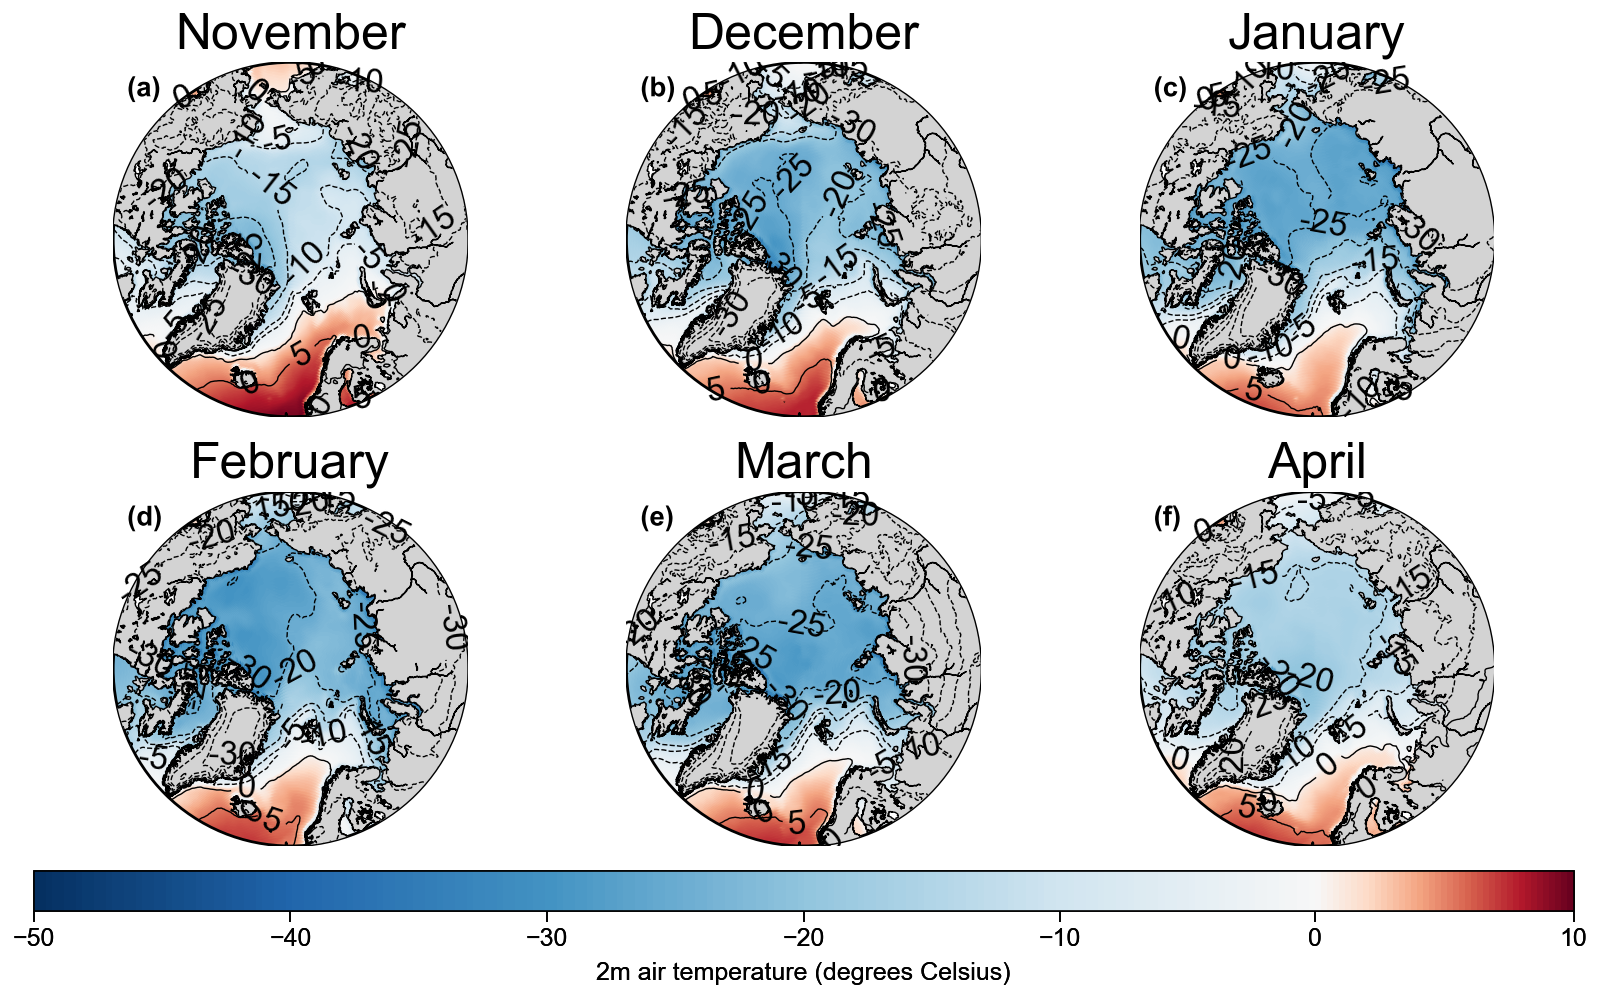

In [32]:
def plot_panArctic3_air(lon, lat, sit, min_set, max_set, cmap_set, label, extend_info, ax, fig,norm, lon_type, lat_type, si_type):
    #fig = plt.figure(figsize=(6,5))
    fig.patch.set_facecolor('white')
    #ax = plt.gca()
    #m = Basemap(projection='ortho',lat_0=90,lon_0=0,resolution='l', ax=ax);
    x1 = -180
    x2 = 180
    y1 = 0
    y2 = 90
    cmap1 = plt.get_cmap('greys', 4)

    m = Basemap(projection='npstere', llcrnrlat=y1,urcrnrlat=y2,llcrnrlon=x1,urcrnrlon=x2,boundinglat=60,lon_0=0, resolution='l',ax=ax, round=True)
    #m.drawmeridians(np.arange(0,360,30),labels=[1,1,1,1],linewidth=0.5, fontsize=14, dashes=[1,5], color='navy')
    #m.drawparallels(np.arange(-90,90,5),linewidth=0.5, fontsize=14, dashes=[1,5], color='navy')
    m.drawcoastlines(linewidth=0.5)
    m.fillcontinents(color='lightgray')
    #m.fillcontinents(color='darkgray')
    #m.drawmapboundary(fill_color='dimgray')
    #cbar = m.etopo()
    #cm = m.scatter(np.array(df_ice_type['lon']), np.array(df_ice_type['lat']),  latlon=True, c=np.array(df_ice_type['ice_type']), s = 0.5, vmin=1-0.5, vmax=4+0.5, cmap=cmap1)
    x=m.scatter(lon, lat, latlon=True, c=sit, s=5,vmin = min_set, vmax=max_set, cmap=cmap_set, zorder=1, norm=norm)
    cs = m.contour(lon_type, lat_type, si_type, levels=[-30, -25, -20, -15, -10, -5, 0, 5, 10],latlon=True, colors='k', linewidths=0.5, zorder=10)
    plt.clabel(cs, inline=True, fmt='%1.0f', fontsize=12, colors='k')
    #cbar = plt.colorbar(x, extend =extend_info, orientation="horizontal",ax=ax)
    #cbar.set_label(label)

    ax.set_title(title, y=1.08,fontsize=18)
    return x
import matplotlib.colors as colors
import proplot as pplot
fig, ax = pplot.subplots(nrows=2, ncols=3,figsize=(8,5))
title = ''
norm = colors.TwoSlopeNorm(vmin=-50, vcenter=0, vmax=10)
im = plot_panArctic3_air(lon_type.flatten(), lat_type.flatten(),  si_type_nov_avg.flatten()-273.15, -50, 10, 'RdBu_r', 'radar freeboard (m)','max', ax[0],fig,norm, lon_type, lat_type, si_type_nov_avg-273.15)
fig.colorbar(im, label ='2m air temperature (degrees Celsius)', loc='b')
im = plot_panArctic3_air(lon_type.flatten(), lat_type.flatten(),  si_type_dec_avg.flatten()-273.15, -50, 10, 'RdBu_r', 'radar freeboard (m)','max', ax[1],fig,norm, lon_type, lat_type, si_type_dec_avg-273.15)
#plt.colorbar(im, ax=ax[1], label ='2m air temperature (degrees Celsius)', loc='bottom')
im = plot_panArctic3_air(lon_type.flatten(), lat_type.flatten(),  si_type_jan_avg.flatten()-273.15, -50, 10, 'RdBu_r', 'radar freeboard (m)','max', ax[2],fig,norm, lon_type, lat_type, si_type_jan_avg-273.15)
im = plot_panArctic3_air(lon_type.flatten(), lat_type.flatten(),  si_type_feb_avg.flatten()-273.15, -50, 10, 'RdBu_r', 'radar freeboard (m)','max', ax[3],fig,norm, lon_type, lat_type, si_type_feb_avg-273.15)
im = plot_panArctic3_air(lon_type.flatten(), lat_type.flatten(),  si_type_mar_avg.flatten()-273.15, -50, 10, 'RdBu_r', 'radar freeboard (m)','max', ax[4],fig,norm, lon_type, lat_type, si_type_mar_avg-273.15)
im = plot_panArctic3_air(lon_type.flatten(), lat_type.flatten(),  si_type_apr_avg.flatten()-273.15, -50, 10, 'RdBu_r', 'radar freeboard (m)','max', ax[5],fig,norm, lon_type, lat_type, si_type_apr_avg-273.15)
#
fig.format(abc='(a)', abcloc='ul')
ax[0].format(title='November')
ax[1].format(title='December')
ax[2].format(title='January')
ax[3].format(title='February')
ax[4].format(title='March')
ax[5].format(title='April')

In [ ]:
files_check_CS2_data = !ls E:/DTU/CRYO2ICE/Data/CRYO2ICE_DTU21MSS/r3500_allbeams_v3/*_D001_v3.csv
files_check_CS2_data

In [ ]:
li = []
k = 0
for filename in files_check_CS2_data:
    df = pd.read_csv(filename, index_col=None, header=0)
    df['ID']=k
    li.append(df)
    k = k+1
    
frame = pd.concat(li, axis=0, ignore_index=True)

In [ ]:
files_check_CS2_data = !ls E:/DTU/CRYO2ICE/Data/CRYO2ICE_DTU21MSS/r3500_allbeams_v3/*_D001_ssd_ppk_filt_v3.csv
files_check_CS2_data

li = []
for filename in files_check_CS2_data:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)
    
frame2 = pd.concat(li, axis=0, ignore_index=True)

In [ ]:
frame

In [ ]:
def plot_panArctic3(lon, lat, sit, min_set, max_set, cmap_set, label, extend_info, ax, fig, df_ice_type):
    #fig = plt.figure(figsize=(6,5))
    fig.patch.set_facecolor('white')
    #ax = plt.gca()
    #m = Basemap(projection='ortho',lat_0=90,lon_0=0,resolution='l', ax=ax);
    x1 = -180
    x2 = 180
    y1 = 0
    y2 = 90
    cmap1 = plt.get_cmap('greys', 4)

    m = Basemap(projection='npstere', llcrnrlat=y1,urcrnrlat=y2,llcrnrlon=x1,urcrnrlon=x2,boundinglat=75,lon_0=0, resolution='l',ax=ax, round=True)
    m.drawmeridians(np.arange(0,360,30),labels=[1,1,1,1],linewidth=0.5, fontsize=14, dashes=[1,5], color='navy')
    m.drawparallels(np.arange(-90,90,5),linewidth=0.5, fontsize=14, dashes=[1,5], color='navy')
    m.drawcoastlines(linewidth=0.5)
    m.fillcontinents(color='lightgray')
    #m.fillcontinents(color='darkgray')
    #m.drawmapboundary(fill_color='dimgray')
    #cbar = m.etopo()
    cm = m.scatter(np.array(df_ice_type['lon']), np.array(df_ice_type['lat']),  latlon=True, c=np.array(df_ice_type['ice_type']), s = 0.5, vmin=1-0.5, vmax=4+0.5, cmap=cmap1)
    x=m.scatter(lon, lat, latlon=True, c=sit, s=5,vmin = min_set, vmax=max_set, cmap=cmap_set, zorder=1)
     #cbar = plt.colorbar(x, extend =extend_info, orientation="horizontal",ax=ax)
    #cbar.set_label(label)

    ax.set_title(title, y=1.08,fontsize=18)
    return x, cm

def plot_panArctic4(lon, lat, sit, min_set, max_set, cmap_set, label, extend_info, ax, fig, df_ice_type):
    #fig = plt.figure(figsize=(6,5))
    fig.patch.set_facecolor('white')
    #ax = plt.gca()
    #m = Basemap(projection='ortho',lat_0=90,lon_0=0,resolution='l', ax=ax);
    x1 = -180
    x2 = 180
    y1 = 0
    y2 = 90
    cmap1 = plt.get_cmap('greys', 4)

    m = Basemap(projection='npstere', llcrnrlat=y1,urcrnrlat=y2,llcrnrlon=x1,urcrnrlon=x2,boundinglat=75,lon_0=0, resolution='l',ax=ax, round=True)
    #m.drawmeridians(np.arange(0,360,30),labels=[1,1,1,1],linewidth=0.5, fontsize=14, dashes=[1,5])
    #m.drawparallels(np.arange(-90,90,20),linewidth=0.5, fontsize=14, dashes=[1,5])
    m.drawcoastlines(linewidth=0.5)
    m.fillcontinents(color='lightgray')
    #m.fillcontinents(color='darkgray')
    #m.drawmapboundary(fill_color='dimgray')
    #cbar = m.etopo()
    cm = m.scatter(np.array(df_ice_type['lon']), np.array(df_ice_type['lat']), latlon=True, c=np.array(df_ice_type['ice_type']), s = 0.5, vmin=1-0.5, vmax=4+0.5, cmap=cmap1)
    x=m.scatter(lon, lat, latlon=True, c=sit, s=5,vmin = min_set, vmax=max_set, cmap=cmap_set, zorder=1)
    #cbar = plt.colorbar(x, extend =extend_info, orientation="horizontal",ax=ax)
    #cbar.set_label(label)

    ax.set_title(title, y=1.08,fontsize=18)
    return x, cm

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(8,5), constrained_layout=True)
title = ''
im, cm = plot_panArctic3(np.array(frame['lon']), np.array(frame['lat']),  frame['ID'], 0, 34, 'viridis', 'radar freeboard (m)','max', ax[0],fig,df_ice_type)
plt.colorbar(im, ax=ax[0], orientation = 'horizontal', extend='both', label ='ID #')

title = ''
im, cm = plot_panArctic4(np.array(frame['lon']), np.array(frame['lat']),  np.array(frame['snow_depth_w_DTU21MSS']), 0, 0.4, 'blues', 'radar freeboard (m)','max', ax[1],fig,df_ice_type)
#cbar = plt.colorbar(cm, ax=ax[1], orientation = 'horizontal', extend='neither',label='sea ice type', ticks=np.arange(1,5))
#cbar.set_ticklabels(["OW", "FYI", "MYI", "AMB"])
plt.colorbar(im, ax=ax[1], orientation = 'horizontal', extend='both', label ='snow depth (m)')

plt.savefig('E:\demo_CRYO2ICE_snowdepth_ID.png', transparent=True)
#fig.suptitle('November 2020 (new binning method, r = 3500)')

In [ ]:
len(frame)

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(8,5), constrained_layout=True)
#title = 'No filtering'
im, cm = plot_panArctic3(np.array(frame['lon']), np.array(frame['lat']),  np.array(frame['IS2_w_fb_DTU21MSS']-frame['CS2_fb_DTU21MSS']), 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax[0],fig,df_ice_type)
plt.colorbar(im, ax=ax[0], orientation = 'horizontal', extend='both', label ='difference in laser and radar (IS2-CS2) (m)')

#title = 'SSD/PPK filtering'
im, cm = plot_panArctic4(np.array(frame['lon']), np.array(frame['lat']),  np.array(frame['snow_depth_w_DTU21MSS']), 0, 0.4, 'blues', 'radar freeboard (m)','max', ax[1],fig,df_ice_type)
#cbar = plt.colorbar(cm, ax=ax[1], orientation = 'horizontal', extend='neither',label='sea ice type', ticks=np.arange(1,5))
#cbar.set_ticklabels(["OW", "FYI", "MYI", "AMB"])
plt.colorbar(im, ax=ax[1], orientation = 'horizontal', extend='both', label ='snow depth (m)')

plt.savefig('E:\demo_CRYO2ICE_snowdepth.png', transparent=True)
#fig.suptitle('November 2020 (new binning method, r = 3500)')

In [ ]:
#@jit
def bindataN(x, y, z, xG, yG, binsize, retbin=False, retloc=False):
    """
    Place unevenly spaced 2D data on a grid by 2D binning (nearest
    neighbor interpolation).
    NB: MAKE SURE YOU ARE USING THE NATIVE PROJECTION OF THE 2D DATA 
    SO THAT IT IS ORDERD CORRECTLY TO GENERATE THE MESHGRID BELOW!
    
    Parameters
    ----------
    x : ndarray (1D)
        The idependent data x-axis of the grid.
    y : ndarray (1D)
        The idependent data y-axis of the grid.
    z : ndarray (1D)
        The dependent data in the form z = f(x,y).
    binsize : scalar, optional
        The full width and height of each bin on the grid.  If each
        bin is a cube, then this is the x and y dimension.  This is
        the step in both directions, x and y. Defaults to 0.01.
    retbin : boolean, optional
        Function returns `bins` variable (see below for description)
        if set to True.  Defaults to True.
    retloc : boolean, optional
        Function returns `wherebins` variable (see below for description)
        if set to True.  Defaults to True.
   
    Returns
    -------
    grid : ndarray (2D)
        The evenly gridded data.  The value of each cell is the median
        value of the contents of the bin.
    bins : ndarray (2D)
        A grid the same shape as `grid`, except the value of each cell
        is the number of points in that bin.  Returns only if
        `retbin` is set to True.
    wherebin : list (2D)
        A 2D list the same shape as `grid` and `bins` where each cell
        contains the indicies of `z` which contain the values stored
        in the particular bin.
    Revisions
    ---------
    2010-07-11  ccampo  Initial version
    """
    # get extrema values.
    xmin, xmax = xG.min(), xG.max()
    ymin, ymax = yG.min(), yG.max()

    # make coordinate arrays.
    #xi      = xG[0]
    #yi      = yG[:, 0] #np.arange(ymin, ymax+binsize, binsize)
    #xi, yi = np.meshgrid(xi,yi)
    xi, yi = xG, yG
    #print(xi)
    #print(yi)
    # make the grid.
    grid           = np.zeros(xi.shape, dtype=x.dtype)
    nrow, ncol = grid.shape
    if retbin: bins = np.copy(grid)

    # create list in same shape as grid to store indices
    if retloc:
        wherebin = np.copy(grid)
        wherebin = wherebin.tolist()

    # fill in the grid.
    for row in range(nrow):
        for col in range(ncol):
            xc = xi[row, col]    # x coordinate.
            yc = yi[row, col]    # y coordinate.

            # find the position that xc and yc correspond to.
            posx = np.abs(x - xc)
            posy = np.abs(y - yc)
            ibin = np.logical_and(posx < binsize/2., posy < binsize/2.)
            ind  = np.where(ibin == True)[0]

            # fill the bin.
            bin = z[ibin]
            if retloc: wherebin[row][col] = ind
            if retbin: bins[row, col] = bin.size
            if bin.size != 0:
                binval         = np.median(bin)
                grid[row, col] = binval
            else:
                grid[row, col] = np.nan   # fill empty bins with nans.

    # return the grid
    if retbin:
        if retloc:
            return grid, bins, wherebin
        else:
            return grid, bins
    else:
        if retloc:
            return grid, wherebin
        else:
            return grid

def grid_data(lat_ori, lon_ori, var_ori, ref_lat, ref_lon, method_name):
    grid_var = griddata((lon_ori.flatten(), lat_ori.flatten()), var_ori.flatten(), (ref_lon, ref_lat), method=method_name)
    
    return grid_var

In [ ]:
def load_data_grid(path, fp, lon_var, lat_var, snow_var, ice_type_var, SIC_variable):
    nc_file = netCDF4.Dataset(path + '/' + fp, 'r')
    lon = nc_file.variables[lon_var][:]
    lat = nc_file.variables[lat_var][:]
    snow = nc_file.variables[snow_var][:]
    ice_type = nc_file.variables[ice_type_var][:]
    SIC = nc_file.variables[SIC_variable][:]
    
    return  lon, lat, snow, ice_type, SIC

path = r'E:\DTU\CRYO2ICE\Data'
fp = 'awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-202011-fv2p4.nc'
lon_grid, lat_grid, snow_grid, ice_type_grid, SIC_grid = load_data_grid(path, fp, 'lon', 'lat', 'snow_depth', 'sea_ice_type', 'sea_ice_concentration' )

In [ ]:
def load_data_grid_snowmodel(path, fp, lon_var, lat_var, snow_var):
    nc_file = netCDF4.Dataset(path + '/' + fp, 'r')
    lon = nc_file.variables[lon_var][:]
    lat = nc_file.variables[lat_var][:]
    snow = nc_file.variables[snow_var][:]
    ice_type = nc_file.variables[ice_type_var][:]
    SIC = nc_file.variables[SIC_variable][:]
    
    return  lon, lat, snow

path = r'E:\DTU\CRYO2ICE\Data'
fp = 'ubristol_cryosat2_seaicethickness_nh25km_2015_01_v1.nc'
title = ''
sit, lon, lat = load_data(path, fp, 'Snow_Depth', 'Longitude', 'Latitude')

In [ ]:
grid_frame = bindataN(np.array(frame['lon']), np.array(frame['lat']), np.array(frame['snow_depth_w_DTU21MSS']), lon_grid, lat_grid, binsize=0.25)

In [ ]:
plt.hist(grid_frame.flatten())

In [ ]:
snow_grid.flatten()[np.isnan(grid_frame.flatten())] == np.nan
plt.hist(grid_frame.flatten()-snow_grid.flatten())

In [ ]:
np.nanmean(snow_grid.flatten())

In [ ]:
fig, ax = plt.subplots(nrows=4, ncols=1,figsize=(4,12), constrained_layout=True)
#title = 'No filtering'
im, cm = plot_panArctic3(np.array(frame['lon']), np.array(frame['lat']),  np.array(frame['snow_depth_w_DTU21MSS']), 0, 0.4, 'blues', 'radar freeboard (m)','max', ax[0],fig,df_ice_type)
#cbar = plt.colorbar(cm, ax=ax[1], orientation = 'horizontal', extend='neither',label='sea ice type', ticks=np.arange(1,5))
#cbar.set_ticklabels(["OW", "FYI", "MYI", "AMB"])
plt.colorbar(im, ax=ax[0], orientation = 'horizontal', extend='both', label ='snow depth (m)')

im, cm = plot_panArctic4(lon_grid.flatten(), lat_grid.flatten(),  grid_frame.flatten(), 0, 0.4, 'blues', 'radar freeboard (m)','max', ax[1],fig,df_ice_type)
plt.colorbar(im, ax=ax[1], orientation = 'horizontal', extend='both', label ='gridded snow depth, binsize = 0.25 (m)')


im, cm = plot_panArctic4(lon_grid.flatten(), lat_grid.flatten(),  snow_grid.flatten(), 0, 0.4, 'blues', 'mW99/AMSR2 in snow depth (m)','max', ax[2],fig,df_ice_type)
#cbar = plt.colorbar(cm, ax=ax[1], orientation = 'horizontal', extend='neither',label='sea ice type', ticks=np.arange(1,5))
#cbar.set_ticklabels(["OW", "FYI", "MYI", "AMB"])
plt.colorbar(im, ax=ax[2], orientation = 'horizontal', extend='both', label ='snow depth W99/AMSR2 (m)')

im, cm = plot_panArctic4(lon_grid.flatten(), lat_grid.flatten(),  grid_frame.flatten()-snow_grid.flatten(), -0.3, 0.3, 'RdBu_r', 'difference in snow depth (m)','max', ax[3],fig,df_ice_type)
#cbar = plt.colorbar(cm, ax=ax[1], orientation = 'horizontal', extend='neither',label='sea ice type', ticks=np.arange(1,5))
#cbar.set_ticklabels(["OW", "FYI", "MYI", "AMB"])
plt.colorbar(im, ax=ax[3], orientation = 'horizontal', extend='both', label ='difference in snow depth (m)')

plt.savefig('E:\demo_CRYO2ICE_snowdepth_nov2020_r3500.png', transparent=True)

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=4,figsize=(12,5), constrained_layout=True)
#title = 'No filtering'
im, cm = plot_panArctic3(lon_grid.flatten(), lat_grid.flatten(),  SIC_grid.flatten(), 0, 100, 'greens', 'radar freeboard (m)','max', ax[0],fig,df_ice_type)
#cbar = plt.colorbar(cm, ax=ax[1], orientation = 'horizontal', extend='neither',label='sea ice type', ticks=np.arange(1,5))
#cbar.set_ticklabels(["OW", "FYI", "MYI", "AMB"])
plt.colorbar(im, ax=ax[0], orientation = 'horizontal', extend='neither', label ='concentration (%)')

im, cm = plot_panArctic4(lon_grid.flatten(), lat_grid.flatten(),  ice_type_grid.flatten(), 0, 1, 'reds', 'radar freeboard (m)','max', ax[1],fig,df_ice_type)
plt.colorbar(im, ax=ax[1], orientation = 'horizontal', extend='neither', label ='fraction of multi-year ice')


im, cm = plot_panArctic4(lon_grid.flatten(), lat_grid.flatten(),  snow_grid.flatten(), 0, 0.4, 'blues', 'mW99/AMSR2 in snow depth (m)','max', ax[2],fig,df_ice_type)
#cbar = plt.colorbar(cm, ax=ax[1], orientation = 'horizontal', extend='neither',label='sea ice type', ticks=np.arange(1,5))
#cbar.set_ticklabels(["OW", "FYI", "MYI", "AMB"])
plt.colorbar(im, ax=ax[2], orientation = 'horizontal', extend='max', label ='snow depth W99/AMSR2 (m)')

im, cm = plot_panArctic4(lon_grid.flatten(), lat_grid.flatten(),  grid_frame.flatten()-snow_grid.flatten(), -0.3, 0.3, 'RdBu_r', 'difference in snow depth (m)','max', ax[3],fig,df_ice_type)
#cbar = plt.colorbar(cm, ax=ax[1], orientation = 'horizontal', extend='neither',label='sea ice type', ticks=np.arange(1,5))
#cbar.set_ticklabels(["OW", "FYI", "MYI", "AMB"])
plt.colorbar(im, ax=ax[3], orientation = 'horizontal', extend='both', label ='CRYO2ICE-mW99/ASMR2 snow depth (m)')


In [ ]:
len(snow_grid.flatten()[~np.isnan(snow_grid.flatten())])

In [ ]:
len(snow_grid.flatten())

In [ ]:
import datashader as ds
from datashader.mpl_ext import dsshow
import pandas as pd


def using_datashader(ax, x, y):

    df = pd.DataFrame(dict(x=x, y=y))
    dsartist = dsshow(
        df,
        ds.Point("x", "y"),
        ds.count(),
        vmin=0,
        vmax=10,
        norm="linear",
        aspect="auto",
        ax=ax,
    )

    plt.colorbar(dsartist)


fig, ax = plt.subplots()
using_datashader(ax,frame['ssd'],frame['IS2_w_fb_DTU21MSS']-frame['CS2_fb_DTU21MSS'])
plt.show()


In [ ]:
import matplotlib.pyplot as plt
def using_hist2d(ax, x, y, bins=(50, 50)):
    # https://stackoverflow.com/a/20105673/3015186
    # Answer by askewchan
    im = ax.hist2d(x, y, bins, cmap=plt.cm.Blues, vmin=0, vmax=50)
    
    return im

In [ ]:
frame.corr()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(8,3.5), constrained_layout=True, sharey=True)
im=using_hist2d(ax[0], frame['ssd'],frame['IS2_w_fb_DTU21MSS']-frame['CS2_fb_DTU21MSS'], bins=(80,80))
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[0].set_xlabel('stack standard deviation')
ax[0].set_ylabel('differnece in laser and radar freeboard (IS2-CS2) (m)')

im=using_hist2d(ax[1], frame['ppk'],frame['IS2_w_fb_DTU21MSS']-frame['CS2_fb_DTU21MSS'], bins=(80,80))
plt.colorbar(im[3], label='density (bins of 80 x80)',ax=ax[1])
ax[1].set_xlabel('pulse peakiness')
#ax[1].set_ylabel('differnece in laser and radar freeboard (IS2-CS2) (m)')

plt.savefig('E:\demo_CRYO2ICE_roughness_histogram_comparison.png', transparent=True)

In [ ]:
plt.scatter(frame['ppk'],frame['IS2_w_fb_DTU21MSS']-frame['CS2_fb_DTU21MSS'])

# Comparison monthly 

In [38]:
def plot_panArctic5(lon, lat, sit, min_set, max_set, cmap_set, label, extend_info, ax, fig):
    #fig = plt.figure(figsize=(6,5))
    fig.patch.set_facecolor('white')
    #ax = plt.gca()
    #m = Basemap(projection='ortho',lat_0=90,lon_0=0,resolution='l', ax=ax);
    x1 = -180
    x2 = 180
    y1 = 0
    y2 = 90
    cmap1 = plt.get_cmap('greys', 4)

    m = Basemap(projection='npstere', llcrnrlat=y1,urcrnrlat=y2,llcrnrlon=x1,urcrnrlon=x2,boundinglat=70,lon_0=0, resolution='i',ax=ax, round=True)
    m.drawmeridians(np.arange(0,360,30),labels=[0,0,0,0],linewidth=0.5, fontsize=10, dashes=[1,5])
    m.drawparallels(np.arange(-90,90,15),linewidth=0.5, fontsize=10, dashes=[1,5],labels=[0,0,0,0])
    m.drawcoastlines(linewidth=0.5)
    m.fillcontinents(color='lightgray')
    #m.fillcontinents(color='darkgray')
    #m.drawmapboundary(fill_color='dimgray')
    #cbar = m.etopo()
    x=m.scatter(lon, lat, latlon=True, c=sit, s=0.05,vmin = min_set, vmax=max_set, cmap=cmap_set, zorder=1)
     #cbar = plt.colorbar(x, extend =extend_info, orientation="horizontal",ax=ax)
    #cbar.set_label(label)

    ax.set_title(title, y=1.08,fontsize=18)
    return x

def plot_panArctic5_black(lon, lat, sit, min_set, max_set, cmap_set, label, extend_info, ax, fig):
    #fig = plt.figure(figsize=(6,5))
    fig.patch.set_facecolor('white')
    #ax = plt.gca()
    #m = Basemap(projection='ortho',lat_0=90,lon_0=0,resolution='l', ax=ax);
    x1 = -180
    x2 = 180
    y1 = 0
    y2 = 90
    cmap1 = plt.get_cmap('greys', 4)

    m = Basemap(projection='npstere', llcrnrlat=y1,urcrnrlat=y2,llcrnrlon=x1,urcrnrlon=x2,boundinglat=70,lon_0=0, resolution='i',ax=ax, round=True)
    m.drawmeridians(np.arange(0,360,30),labels=[0,0,0,0],linewidth=0.5, fontsize=10, dashes=[1,5])
    m.drawparallels(np.arange(-90,90,15),linewidth=0.5, fontsize=10, dashes=[1,5],labels=[0,0,0,0])
    m.drawcoastlines(linewidth=0.5)
    m.fillcontinents(color='lightgray')
    #m.fillcontinents(color='darkgray')
    m.drawmapboundary(fill_color='black')
    #cbar = m.etopo()
    x=m.scatter(lon, lat, latlon=True, c=sit, s=0.05,vmin = min_set, vmax=max_set, cmap=cmap_set, zorder=1)
     #cbar = plt.colorbar(x, extend =extend_info, orientation="horizontal",ax=ax)
    #cbar.set_label(label)

    ax.set_title(title, y=1.08,fontsize=18)
    return x

In [36]:
from scipy import signal 
def load_CRYO2ICE_month(files_check_CS2_data):
    
    def smooth(y, box_pts):
        box = np.ones(box_pts)/box_pts
        y_smooth = np.convolve(y, box, mode='same')
        return y_smooth


    li = []
    k = 0
    for filename in files_check_CS2_data:
        df = pd.read_csv(filename, index_col=None, header=0)
        if len(df)>5:
            df['CS2_fb_smoothed']=smooth(np.array(df['fb']),5)
            df['CS2_LARM_fb_smoothed']=smooth(np.array(df['LARM_rfb']),5)
            df['CS2_CCI_fb_smoothed']=smooth(np.array(df['CCI_rfb']),5)
        else:
            df['CS2_fb_smoothed']=np.nan
            df['CS2_LARM_fb_smoothed'] = np.nan
            df['CS2_CCI_fb_smoothed'] = np.nan
        df['ID']=k
        
        '''
        C=0.714 # Reference CS2 baseline-D MSS to WGS84 instead of Topex/Poseidon ellipsoid
        ds = 0.30
        ns = (1+0.51*ds)**(1.5)
        
        df['snow_depth_original_MSS_smoothed']=(df['IS2_w_mean_fb_MSS']-df['CS2_fb_smoothed'])/ns
        df['snow_depth_original_MSS_LARM_smoothed']=(df['IS2_w_mean_fb_MSS']-df['CS2_LARM_fb_smoothed'])/ns
        df['snow_depth_original_MSS_CCI_smoothed']=(df['IS2_w_mean_fb_MSS']-df['CS2_CCI_fb_smoothed'])/ns
        

        df['snow_depth_original_MSS'] = (df['IS2_w_mean_fb_MSS']-df['fb'])*(1/ns)
        df['snow_depth_original_MSS_CCI'] = (df['IS2_w_mean_fb_MSS']-df['CCI_rfb'])*(1/ns)
        df['snow_depth_original_MSS_LARM'] = (df['IS2_w_mean_fb_MSS']-df['LARM_rfb'])*(1/ns)
        '''

        li.append(df)
        k = k+1
        li.append(df)

    frame2 = pd.concat(li, axis=0, ignore_index=True)
    
    return frame2

In [37]:

files_check_CS2_data = !ls E:/DTU/CRYO2ICE/Data/CRYO2ICE_original_MSS/FINAL_SMLG_AMSR2_CCI_LARM_ERA5_v2_lowess/November/*_LARM_AMSR2_SMLG_ERA5_final_v2_lowess.csv
CRYO2ICE_nov = load_CRYO2ICE_month(files_check_CS2_data)

files_check_CS2_data =  !ls E:/DTU/CRYO2ICE/Data/CRYO2ICE_original_MSS/FINAL_SMLG_AMSR2_CCI_LARM_ERA5_v2_lowess/December/*_LARM_AMSR2_SMLG_ERA5_final_v2_lowess.csv
CRYO2ICE_dec = load_CRYO2ICE_month(files_check_CS2_data)

files_check_CS2_data =  !ls E:/DTU/CRYO2ICE/Data/CRYO2ICE_original_MSS/FINAL_SMLG_AMSR2_CCI_LARM_ERA5_v2_lowess/January/*_LARM_AMSR2_SMLG_ERA5_final_v2_lowess.csv
CRYO2ICE_jan = load_CRYO2ICE_month(files_check_CS2_data)

files_check_CS2_data =  !ls E:/DTU/CRYO2ICE/Data/CRYO2ICE_original_MSS/FINAL_SMLG_AMSR2_CCI_LARM_ERA5_v2_lowess/February/*_LARM_AMSR2_SMLG_ERA5_final_v2_lowess.csv
CRYO2ICE_feb = load_CRYO2ICE_month(files_check_CS2_data)

files_check_CS2_data =  !ls E:/DTU/CRYO2ICE/Data/CRYO2ICE_original_MSS/FINAL_SMLG_AMSR2_CCI_LARM_ERA5_v2_lowess/March/*_LARM_AMSR2_SMLG_ERA5_final_v2_lowess.csv
CRYO2ICE_mar = load_CRYO2ICE_month(files_check_CS2_data)

files_check_CS2_data = !ls E:/DTU/CRYO2ICE/Data/CRYO2ICE_original_MSS/FINAL_SMLG_AMSR2_CCI_LARM_ERA5_v2_lowess/April/*_LARM_AMSR2_SMLG_ERA5_final_v2_lowess.csv
CRYO2ICE_apr = load_CRYO2ICE_month(files_check_CS2_data)
CRYO2ICE_apr

CRYO2ICE_nov['month']='November'
CRYO2ICE_dec['month']='December'
CRYO2ICE_jan['month']='January'
CRYO2ICE_feb['month']='February'
CRYO2ICE_mar['month']='March'
CRYO2ICE_apr['month']='April'

frames = [CRYO2ICE_nov, CRYO2ICE_dec, CRYO2ICE_jan, CRYO2ICE_feb, CRYO2ICE_mar, CRYO2ICE_apr]

CRYO2ICE_comb_all = pd.concat(frames)
CRYO2ICE_comb_all['AMSR2_snow_depth_unit_m']=CRYO2ICE_comb_all['AMSR2_snow_depth']/100



In [ ]:
from matplotlib.lines import Line2D
fig, ax = plt.subplots(figsize=(5,5), constrained_layout=True)
title = ''

#cmap_qual = plt.get_cmap('colorblind10') 
im = plot_panArctic5(np.array(CRYO2ICE_nov['lon']), np.array(CRYO2ICE_nov['lat']), cmap_qual(0), 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax,fig)
im = plot_panArctic5(np.array(CRYO2ICE_dec['lon']), np.array(CRYO2ICE_dec['lat']), cmap_qual(1), 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax,fig)
im = plot_panArctic5(np.array(CRYO2ICE_jan['lon']), np.array(CRYO2ICE_jan['lat']), cmap_qual(2), 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax,fig)
im = plot_panArctic5(np.array(CRYO2ICE_feb['lon']), np.array(CRYO2ICE_feb['lat']), cmap_qual(3), 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax,fig)
im = plot_panArctic5(np.array(CRYO2ICE_mar['lon']), np.array(CRYO2ICE_mar['lat']), cmap_qual(4), 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax,fig)
im = plot_panArctic5(np.array(CRYO2ICE_apr['lon']), np.array(CRYO2ICE_apr['lat']), cmap_qual(5), 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax,fig)

ax.text(0.65, 0.25, 'November', color=cmap_qual(0), transform= ax.transAxes,weight="bold")
ax.text(0.65, 0.22, 'December', color=cmap_qual(1), transform= ax.transAxes,weight="bold")
ax.text(0.65, 0.19, 'January', color=cmap_qual(2), transform= ax.transAxes,weight="bold")
ax.text(0.65, 0.16, 'February', color=cmap_qual(3), transform= ax.transAxes,weight="bold")
ax.text(0.65, 0.13, 'March', color=cmap_qual(4), transform= ax.transAxes,weight="bold")
ax.text(0.65, 0.10, 'April', color=cmap_qual(5), transform= ax.transAxes,weight="bold")

#plt.savefig('E:\demo_CRYO2ICE_coverage_months_combined.png', transparent=True)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

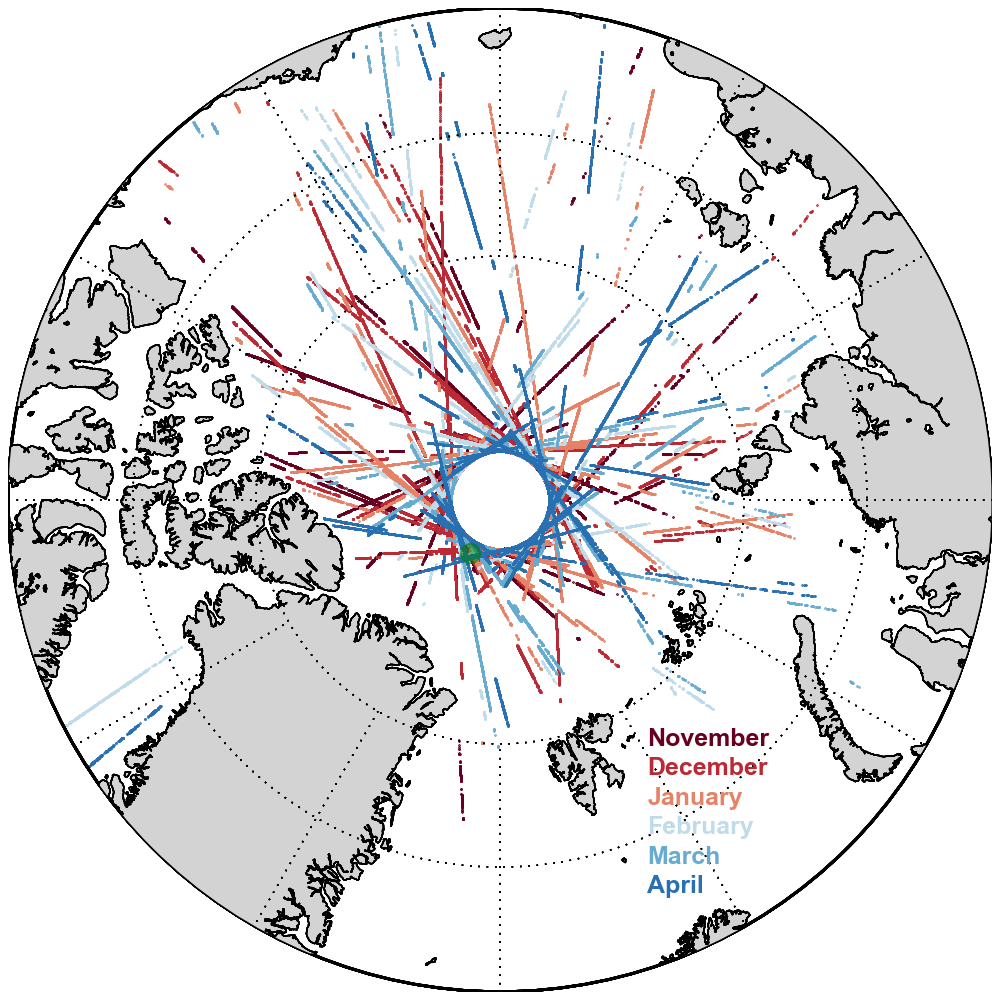

In [239]:
from matplotlib.lines import Line2D
fig, ax = plt.subplots(figsize=(5,5), constrained_layout=True)
title = ''
im = plot_panArctic5_black(np.array(CRYO2ICE_nov['lon']), np.array(CRYO2ICE_nov['lat']), cmap_qual(0), 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax,fig)
im = plot_panArctic5_black(np.array(CRYO2ICE_dec['lon']), np.array(CRYO2ICE_dec['lat']), cmap_qual(1), 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax,fig)
im = plot_panArctic5_black(np.array(CRYO2ICE_jan['lon']), np.array(CRYO2ICE_jan['lat']), cmap_qual(2), 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax,fig)
im = plot_panArctic5_black(np.array(CRYO2ICE_feb['lon']), np.array(CRYO2ICE_feb['lat']), cmap_qual(3), 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax,fig)
im = plot_panArctic5_black(np.array(CRYO2ICE_mar['lon']), np.array(CRYO2ICE_mar['lat']), cmap_qual(4), 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax,fig)
im = plot_panArctic5_black(np.array(CRYO2ICE_apr['lon']), np.array(CRYO2ICE_apr['lat']), cmap_qual(5), 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax,fig)


'''
legend_elements = [Line2D([0], [0], color=cmap_qual(0), label='November'),
                   Line2D([0], [0], color=cmap_qual(1),  label='December'),
                  Line2D([0], [0], color=cmap_qual(2),  label='January'),
                  Line2D([0], [0], color=cmap_qual(3),  label='February'),
                  Line2D([0], [0], color=cmap_qual(4),  label='March'),
                  Line2D([0], [0], color=cmap_qual(5),  label='April')]
ax.legend(handles=legend_elements, loc='best', facecolor='white')
'''

ax.text(0.65, 0.25, 'November', color=cmap_qual(0), transform= ax.transAxes,weight="bold")
ax.text(0.65, 0.22, 'December', color=cmap_qual(1), transform= ax.transAxes,weight="bold")
ax.text(0.65, 0.19, 'January', color=cmap_qual(2), transform= ax.transAxes,weight="bold")
ax.text(0.65, 0.16, 'February', color=cmap_qual(3), transform= ax.transAxes,weight="bold")
ax.text(0.65, 0.13, 'March', color=cmap_qual(4), transform= ax.transAxes,weight="bold")
ax.text(0.65, 0.10, 'April', color=cmap_qual(5), transform= ax.transAxes,weight="bold")

plot_panArctic_POCA(-30, 87.5, 'green', 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax,fig)



#plt.savefig('E:\demo_CRYO2ICE_coverage_months_combined_black_background.png', transparent=True)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


"\nlegend_elements = [Line2D([0], [0], color=cmap_qual(0), label='November'),\n                   Line2D([0], [0], color=cmap_qual(1),  label='December'),\n                  Line2D([0], [0], color=cmap_qual(2),  label='January'),\n                  Line2D([0], [0], color=cmap_qual(3),  label='February'),\n                  Line2D([0], [0], color=cmap_qual(4),  label='March'),\n                  Line2D([0], [0], color=cmap_qual(5),  label='April')]\nax.legend(handles=legend_elements, loc='best', facecolor='white')\n"

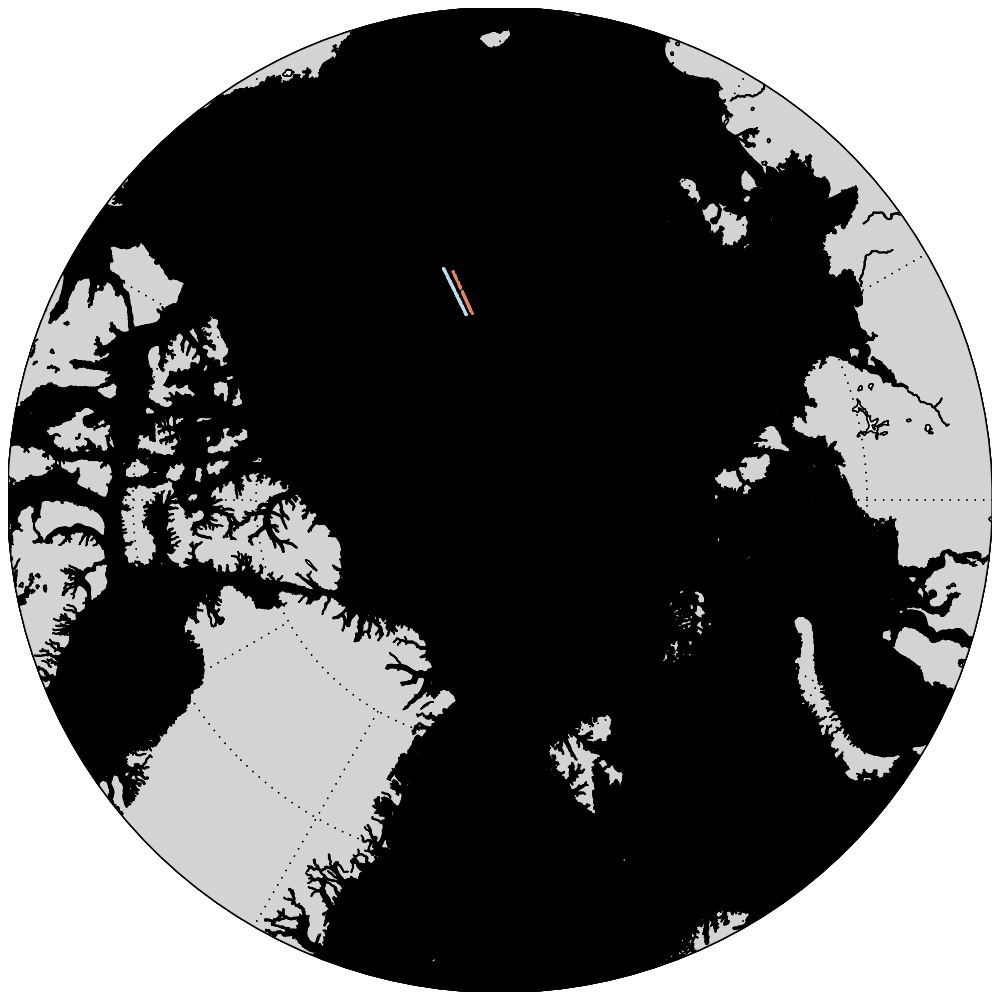

In [219]:
from matplotlib.lines import Line2D
fig, ax = plt.subplots(figsize=(5,5), constrained_layout=True)
title = ''
val = 10
df = CRYO2ICE_nov[CRYO2ICE_nov['ID']==val]
df = df[200:500]
im = plot_panArctic5_black(np.array(df['lon']), np.array(df['lat']), cmap_qual(2), 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax,fig)

val = 2
df = CRYO2ICE_dec[CRYO2ICE_dec['ID']==val]
df = df[400:800]
im = plot_panArctic5_black(np.array(df['lon']), np.array(df['lat']), cmap_qual(3), 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax,fig)

#plot_panArctic_POCA(-170, 81.5, 'green', 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax,fig)


'''
legend_elements = [Line2D([0], [0], color=cmap_qual(0), label='November'),
                   Line2D([0], [0], color=cmap_qual(1),  label='December'),
                  Line2D([0], [0], color=cmap_qual(2),  label='January'),
                  Line2D([0], [0], color=cmap_qual(3),  label='February'),
                  Line2D([0], [0], color=cmap_qual(4),  label='March'),
                  Line2D([0], [0], color=cmap_qual(5),  label='April')]
ax.legend(handles=legend_elements, loc='best', facecolor='white')
'''


In [222]:
def plot_panArctic_POCA(lon, lat, sit, min_set, max_set, cmap_set, label, extend_info, ax, fig):
    #fig = plt.figure(figsize=(6,5))
    fig.patch.set_facecolor('white')
    #ax = plt.gca()
    #m = Basemap(projection='ortho',lat_0=90,lon_0=0,resolution='l', ax=ax);
    x1 = -180
    x2 = 180
    y1 = 0
    y2 = 90
    cmap1 = plt.get_cmap('greys', 4)

    m = Basemap(projection='npstere', llcrnrlat=y1,urcrnrlat=y2,llcrnrlon=x1,urcrnrlon=x2,boundinglat=70,lon_0=0, resolution='i',ax=ax, round=True)
    m.drawmeridians(np.arange(0,360,30),labels=[0,0,0,0],linewidth=0.5, fontsize=10, dashes=[1,5])
    m.drawparallels(np.arange(-90,90,15),linewidth=0.5, fontsize=10, dashes=[1,5],labels=[0,0,0,0])
    m.drawcoastlines(linewidth=0.5)
    m.fillcontinents(color='lightgray')
    #m.fillcontinents(color='darkgray')
    #m.drawmapboundary(fill_color='dimgray')
    #cbar = m.etopo()
    x=m.scatter(lon, lat, latlon=True, c=sit, s=50,vmin = min_set, vmax=max_set, cmap=cmap_set, zorder=1, alpha=0.5)
     #cbar = plt.colorbar(x, extend =extend_info, orientation="horizontal",ax=ax)
    #cbar.set_label(label)

    ax.set_title(title, y=1.08,fontsize=18)
    return x

In [302]:
df_nov_v1

Unnamed: 0        lat         lon  along_track_dist_in_metres      fb  \
0            0  73.554480 -162.675310                     12500.0  0.0580   
1            1  73.903590 -162.856530                     37500.0  0.0760   
2            2  73.994880 -162.905030                     62500.0  0.0130   
3            3  74.349230 -163.097850                     87500.0 -0.0450   
4            4  74.440480 -163.148730                    112500.0 -0.2250   
5            5        NaN         NaN                    137500.0     NaN   
6            6        NaN         NaN                    162500.0     NaN   
7            7        NaN         NaN                    187500.0     NaN   
8            8        NaN         NaN                    212500.0     NaN   
9            9        NaN         NaN                    237500.0     NaN   
10          10        NaN         NaN                    262500.0     NaN   
11          11        NaN         NaN                    287500.0     NaN   
12          12        NaN         NaN                    312500.0     NaN   
13          13        NaN         NaN                    337500.0     NaN   
14          14        NaN         NaN                    362500.0     NaN   
15          15        NaN         NaN                    387500.0     NaN   
16          16        NaN         NaN                    412500.0     NaN   
17          17        NaN         NaN                    437500.0     NaN   
18          18  77.408730 -165.151130                    462500.0  0.0220   
19          19  77.686625 -165.382670                    487500.0  0.0695   
20          20  77.850880 -165.524030                    512500.0  0.0120   
21          21  78.069795 -165.718020                    537500.0  0.0790   
22          22  78.373955 -165.998740                    562500.0  0.1320   
23          23  78.453960 -166.074860                    587500.0  0.0510   
24          24  78.771145 -166.386550                    612500.0  0.0165   
25          25  78.918980 -166.537510                    637500.0 -0.0960   
26          26  79.105340 -166.733280                    662500.0 -0.0820   
27          27  79.319530 -166.966205                    687500.0  0.0025   
28          28  79.597350 -167.281800                    712500.0  0.1050   
29          29  79.716900 -167.422580                    737500.0  0.1180   
30          30        NaN         NaN                    762500.0     NaN   
31          31  80.282000 -168.132610                    787500.0  0.0995   
32          32  80.382675 -168.267500                    812500.0  0.0880   
33          33  80.630190 -168.610890                    837500.0  0.0870   
34          34  80.890600 -168.991650                    862500.0  0.1040   
35          35  81.087320 -169.293570                    887500.0  0.0930   
36          36  81.325970 -169.677760                    912500.0  0.1300   
37          37  81.501105 -169.973105                    937500.0  0.0945   
38          38  81.699690 -170.322780                    962500.0  0.0880   
39          39  81.932095 -170.753530                    987500.0  0.0695   
40          40  82.061900 -171.004960                   1012500.0  0.0580   
41          41  82.317140 -171.523970                   1037500.0  0.0970   
42          42  82.588725 -172.115315                   1062500.0  0.0930   
43          43  82.713810 -172.402530                   1087500.0  0.1350   

    LARM_rfb   CCI_rfb    IS2_fb  AMSR2_snow_depth  SMLG_snow_depth  \
0        NaN  0.056635  0.110459               8.0         0.009236   
1   0.059069  0.036838  0.079752               9.0         0.008847   
2  -0.016481 -0.032164  0.096286               8.0         0.008847   
3   0.037452  0.042895  0.095023               9.0         0.021677   
4   0.070383 -0.022205  0.099598              10.0         0.021677   
5        NaN       NaN       NaN               NaN              NaN   
6        NaN       NaN       NaN         

In [316]:
#files_check_CS2_data = !ls E:/DTU/CRYO2ICE/Data/CRYO2ICE_original_MSS/FINAL_SMLG_AMSR2_CCI_LARM_ERA5_v2_lowess/November/*_LARM_AMSR2_SMLG_ERA5_final_v2_lowess.csv
#print(files_check_CS2_data[10])
    
#files_check_CS2_data =  !ls E:/DTU/CRYO2ICE/Data/CRYO2ICE_original_MSS/FINAL_SMLG_AMSR2_CCI_LARM_ERA5_v2_lowess/December/*_LARM_AMSR2_SMLG_ERA5_final_v2_lowess.csv
#print(files_check_CS2_data[2])


fp1 = 'E:/DTU/CRYO2ICE/Data/CRYO2ICE_original_MSS/FINAL_SMLG_AMSR2_CCI_LARM_ERA5_v2_lowess/November/CRYO2ICE_CRYO2ICE_CS_OFFL_SIR_SAR_2__20201111T163106_20201111T163742_D001_original_MSS_time_LARM_AMSR2_SMLG_ERA5_final_v2_lowess.csv'
df_nov = pd.read_csv(fp1, index_col=None, header=0)
#n1, n2 = 20, 200
n1, n2 = 200, 500
df_nov_short = df_nov[n1:n2]

fp1 = r'E:\DTU\CRYO2ICE\Data\CRYO2ICE_gridded\along_track\November\CRYO2ICE_CRYO2ICE_CS_OFFL_SIR_SAR_2__20201111T163106_20201111T163742_D001_original_MSS_time_LARM_AMSR2_SMLG_ERA5_final_v2_lowess_gridded_25km_corrected_snow_depth_no_smooth_new_func_fb_snow_mean.csv'
df_nov_v1 = pd.read_csv(fp1, index_col=None, header=0)
df_nov_v1_short=df_nov_v1[(df_nov_v1['along_track_dist_in_metres']>np.min(df_nov_short['along_track_dist_in_metres']))&(df_nov_v1['along_track_dist_in_metres']<np.max(df_nov_short['along_track_dist_in_metres']))]
df_nov_v1_short['along_track_dist_in_km'] = df_nov_v1_short['along_track_dist_in_metres']/1000

fp1 = 'E:/DTU/CRYO2ICE/Data/CRYO2ICE_original_MSS/FINAL_SMLG_AMSR2_CCI_LARM_ERA5_v2_lowess/December/CRYO2ICE_CRYO2ICE_CS_OFFL_SIR_SAR_2__20201202T152134_20201202T152803_D001_original_MSS_time_LARM_AMSR2_SMLG_ERA5_final_v2_lowess.csv'
df_dec = pd.read_csv(fp1, index_col=None, header=0)
#n1, n2 = 80,400
n1, n2 = 400, 800 
df_dec_short = df_dec[n1:n2]

fp1 = r'E:\DTU\CRYO2ICE\Data\CRYO2ICE_gridded\along_track\December\CRYO2ICE_CRYO2ICE_CS_OFFL_SIR_SAR_2__20201202T152134_20201202T152803_D001_original_MSS_time_LARM_AMSR2_SMLG_ERA5_final_v2_lowess_gridded_25km_corrected_snow_depth_no_smooth_new_func_fb_snow_mean.csv'
df_dec_v1 = pd.read_csv(fp1, index_col=None, header=0)
df_dec_v1_short=df_dec_v1[(df_dec_v1['along_track_dist_in_metres']>np.min(df_dec_short['along_track_dist_in_metres']))&(df_dec_v1['along_track_dist_in_metres']<np.max(df_dec_short['along_track_dist_in_metres']))]
df_dec_v1_short['along_track_dist_in_km'] = df_dec_v1_short['along_track_dist_in_metres']/1000



In [307]:
df_dec_v1_short

Unnamed: 0        lat         lon  along_track_dist_in_metres      fb  \
22          22  80.371620 -166.433650                    562500.0  0.1030   
23          23  80.591230 -166.736695                    587500.0  0.0805   
24          24  80.810610 -167.053360                    612500.0  0.1010   
25          25  81.015140 -167.362070                    637500.0  0.1270   
26          26  81.206165 -167.663030                    662500.0  0.0830   
27          27  81.414195 -168.005590                    687500.0  0.1070   
28          28  81.641770 -168.399480                    712500.0  0.1410   
29          29  81.891410 -168.856560                    737500.0  0.1560   
30          30  82.036485 -169.135265                    762500.0  0.1175   

    LARM_rfb   CCI_rfb    IS2_fb  AMSR2_snow_depth  SMLG_snow_depth  \
22  0.128581  0.096875  0.099158              14.0         0.042023   
23  0.099779  0.074068  0.130869              16.0         0.059773   
24  0.148091  0.076122  0.132955              18.0         0.113366   
25  0.135935  0.081549  0.132632              20.0         0.138034   
26  0.122867  0.125026  0.154185              21.0         0.129378   
27  0.101763  0.085273  0.159208              23.0         0.177747   
28  0.128554  0.133869  0.182514              24.0         0.157730   
29  0.188688  0.179232  0.212574               NaN         0.207853   
30  0.136419  0.121653  0.199658               NaN         0.207853   

    SMLG_snow_depth_v2  C2I_snow  C2I_LARM_snow  C2I_CCI_snow  \
22            0.059977 -0.003103      -0.023765      0.001844   
23            0.078377  0.040684       0.025112      0.045879   
24            0.137596  0.025811      -0.012225      0.045905   
25            0.149507  0.004549      -0.002668      0.041260   
26            0.120720  0.057497       0.025296      0.023552   
27            0.156027  0.042169       0.046399      0.059718   
28            0.111466  0.033531       0.043584      0.039291   
29            0.205909  0.045695       0.019292      0.026931   
30            0.205909  0.066360       0.051079      0.063005   

    along_track_dist_in_km  
22                   562.5  
23                   587.5  
24                   612.5  
25                   637.5  
26                   662.5  
27                   687.5  
28                   712.5  
29                   737.5  
30                   762.5

(-0.3, 0.5)

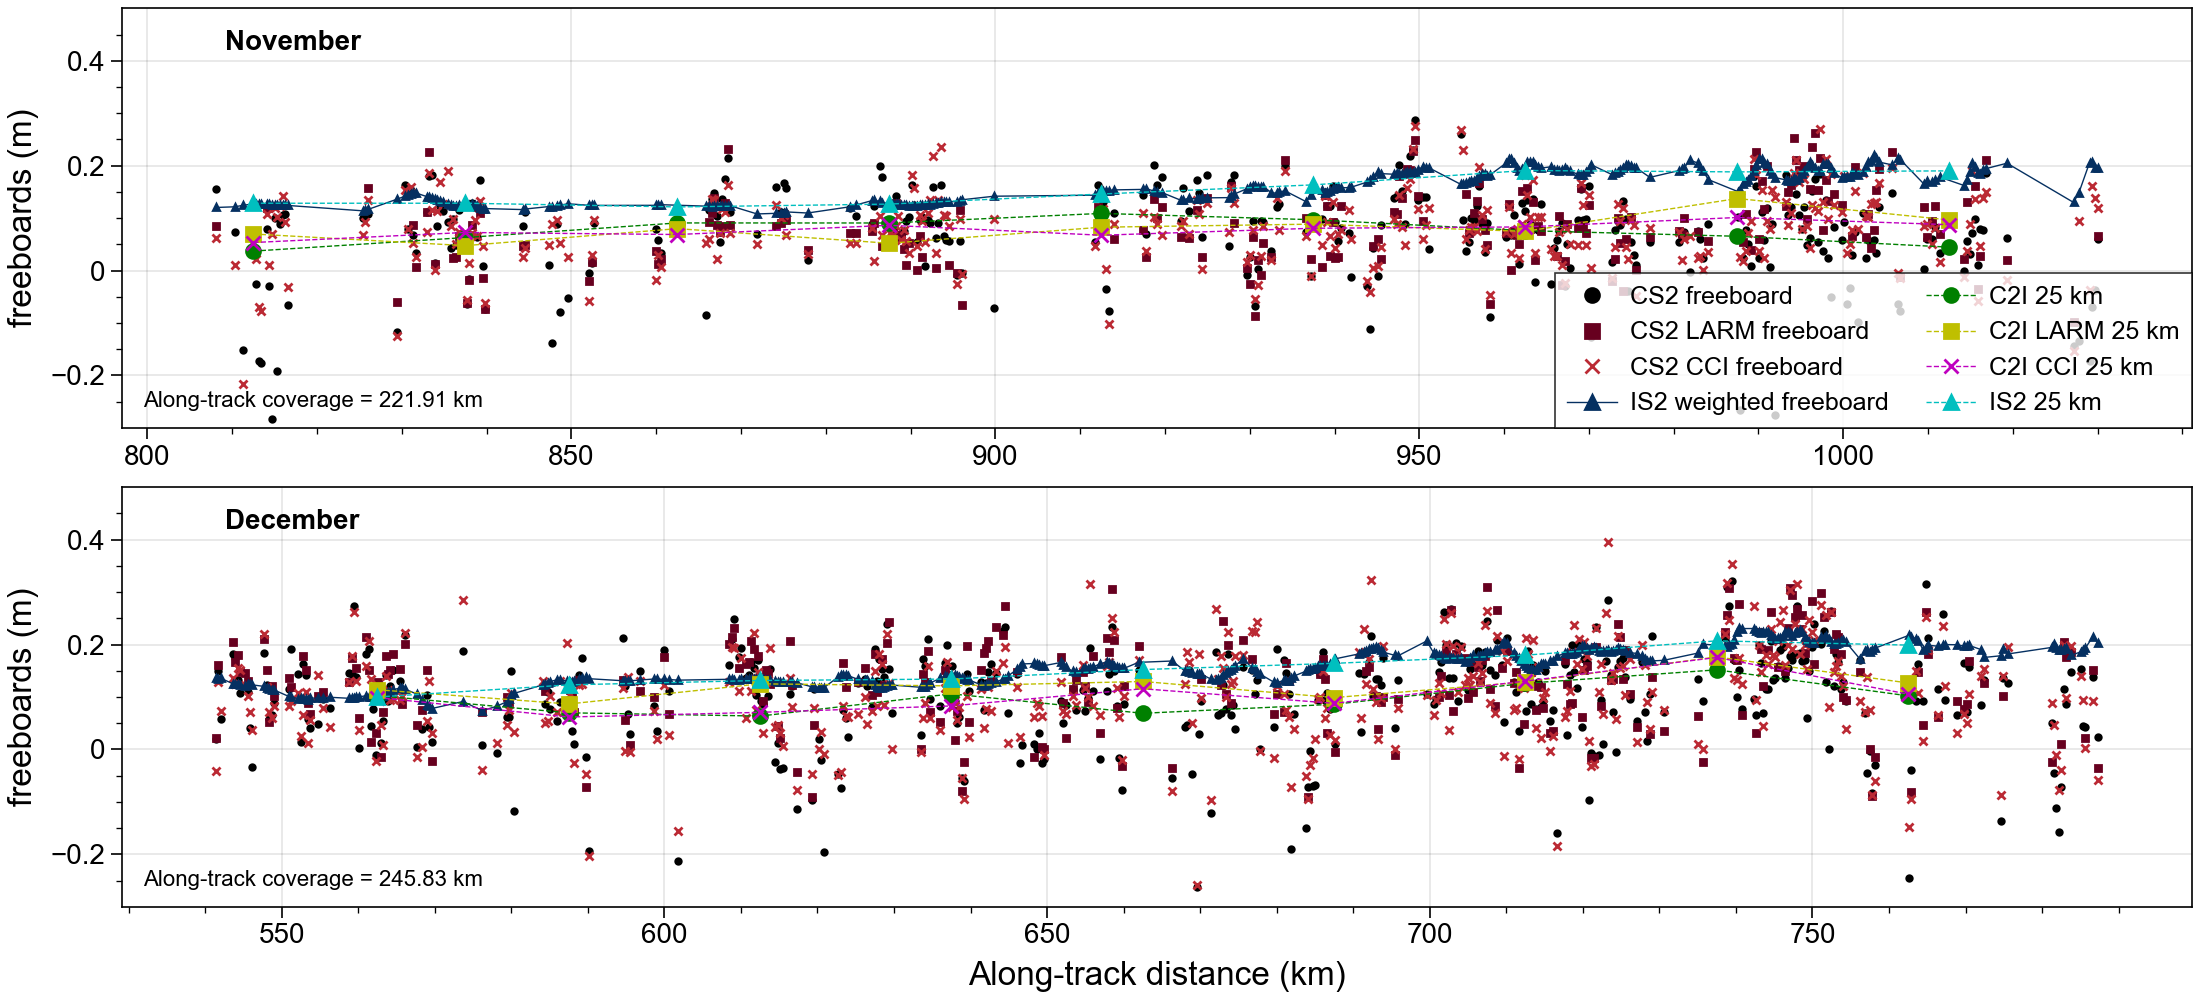

In [317]:
import proplot as pplot
from matplotlib.colors import LinearSegmentedColormap,rgb2hex
fig, axs = plt.subplots(2, figsize=(11,5), constrained_layout=True)
#axs[0].plot(df_IS2_new['lat'], df_IS2_new['fb'], c='grey', ls='', marker='.', markersize=0.8)

font_size_snow = 8
#cmap_qual = plt.get_cmap('538')
cmap_check = plt.cm.get_cmap('BuRd_r')
cmap_qual = ['#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00', '#CC79A7', 'darkorange']
cmap_qual = [rgb2hex(cmap_check((0/8))),rgb2hex(cmap_check((1/8))),rgb2hex(cmap_check((2/8))),
            rgb2hex(cmap_check((5/8))), rgb2hex(cmap_check(6/8)), rgb2hex(cmap_check(7/8)), rgb2hex(cmap_check(8/8))]
cmap_qual = LinearSegmentedColormap.from_list('list', cmap_qual, N = len(cmap_qual))

df_jan_short = df_nov_short
axs[0].plot(df_jan_short['along_track_dist_in_km'], df_jan_short['fb'] ,'o', c='k', markersize=2, ls='', lw=0.5)
axs[0].plot(df_jan_short['along_track_dist_in_km'],df_jan_short['LARM_rfb'], 's',c=cmap_qual(0), markersize=2, ls='', lw=0.5)
axs[0].plot(df_jan_short['along_track_dist_in_km'],df_jan_short['CCI_rfb'], 'x',c=cmap_qual(1), markersize=3, ls='', lw=0.5)
axs[0].plot(df_jan_short['along_track_dist_in_km'],df_jan_short['IS2_w_mean_fb_MSS'], '^',c=cmap_qual(7), markersize=2, ls='-', lw=0.5)

#axs[0].plot(df_jan_short['along_track_dist_in_km'], df_jan_short['lowess_fb'] ,'o', c=cmap_qual(3), markersize=2, ls='--', lw=0.5)
#axs[0].plot(df_jan_short['along_track_dist_in_km'],df_jan_short['lowess_LARM_rfb'], 's',c=cmap_qual(4), markersize=2, ls='--', lw=0.5)
#axs[0].plot(df_jan_short['along_track_dist_in_km'],df_jan_short['lowess_CCI_rfb'], 'x',c=cmap_qual(5), markersize=3, ls='--', lw=0.5)

df_jan_short = df_nov_v1_short
axs[0].plot(df_jan_short['along_track_dist_in_km'], df_jan_short['fb'] ,'o', c='g', markersize=5, ls='--', lw=0.5)
axs[0].plot(df_jan_short['along_track_dist_in_km'],df_jan_short['LARM_rfb'], 's',c='y', markersize=5, ls='--', lw=0.5)
axs[0].plot(df_jan_short['along_track_dist_in_km'],df_jan_short['CCI_rfb'], 'x',c='m', markersize=5, ls='--', lw=0.5)
axs[0].plot(df_jan_short['along_track_dist_in_km'],df_jan_short['IS2_fb'], '^',c='c', markersize=5, ls='--', lw=0.5)


#axs[1].plot(df3_short['lead_CS2'], 'o')
#axs[0].set_ylim(-0.35, 0.5)
#axs[1].set_ylim(-0.2, 0.6)

axs[0].set_ylabel('freeboards (m)', fontsize=12)
axs[1].set_ylabel('freeboards (m)', fontsize=12)


#legend=axs[1].legend([txt_CRYO2ICE,txt_CRYO2ICE_LARM, txt_CRYO2ICE_thresholds, txt_AMSR2], loc='best', scatterpoints=3)
#axs[0].set_ylim(df_jan_short['fb'].min()-0.1, df_jan_short['IS2_w_mean_fb_MSS'].max()+0.1)
#axs[0].set_xlim(87.5, 82.5)
axs[1].set_xlabel('Along-track distance (km)',  fontsize=12)
df_jan_short = df_nov_short
along_track_dist = np.abs(np.max(df_jan_short['along_track_dist_in_km'])-np.min(df_jan_short['along_track_dist_in_km']))
axs[0].text(0.05, 0.9, 'November', transform = axs[0].transAxes, fontsize=10,weight='bold')
axs[0].text(0.01, 0.05, 'Along-track coverage = {:.2f} km'.format(along_track_dist), transform = axs[0].transAxes, fontsize=font_size_snow)

axs[0].tick_params(labelsize=10)



#legend=axs[0].legend(['CS2 freeboard', 'CS2 LARM freeboard', 'CS2 CCI freeboard','IS2 weighted freeboard', 'CS2 lowess', 'CS2 LARM lowess', 'CS2 CCI lowess', 'C2I 25 km', 'C2I LARM 25 km', 'C2I CCI 25 km', 'IS2 25 km'], loc='lower right', scatterpoints=3, ncol=2)
legend=axs[0].legend(['CS2 freeboard', 'CS2 LARM freeboard', 'CS2 CCI freeboard','IS2 weighted freeboard', 'C2I 25 km', 'C2I LARM 25 km', 'C2I CCI 25 km', 'IS2 25 km'], loc='lower right', scatterpoints=3, ncol=2)

legend.legendHandles[0]._legmarker.set_markersize(5)
legend.legendHandles[1]._legmarker.set_markersize(5)
legend.legendHandles[2]._legmarker.set_markersize(5)
legend.legendHandles[3]._legmarker.set_markersize(5)

df_jan_short = df_dec_short
axs[1].plot(df_jan_short['along_track_dist_in_km'], df_jan_short['fb'] ,'o', c='k', markersize=2, ls='', lw=0.5)
axs[1].plot(df_jan_short['along_track_dist_in_km'],df_jan_short['LARM_rfb'], 's',c=cmap_qual(0), markersize=2, ls='', lw=0.5)
axs[1].plot(df_jan_short['along_track_dist_in_km'],df_jan_short['CCI_rfb'], 'x',c=cmap_qual(1), markersize=3, ls='', lw=0.5)
axs[1].plot(df_jan_short['along_track_dist_in_km'],df_jan_short['IS2_w_mean_fb_MSS'], '^',c=cmap_qual(7), markersize=2, ls='-', lw=0.5)

#axs[1].plot(df_jan_short['along_track_dist_in_km'], df_jan_short['lowess_fb'] ,'o', c=cmap_qual(3), markersize=2, ls='--', lw=0.5)
#axs[1].plot(df_jan_short['along_track_dist_in_km'],df_jan_short['lowess_LARM_rfb'], 's',c=cmap_qual(4), markersize=2, ls='--', lw=0.5)
#axs[1].plot(df_jan_short['along_track_dist_in_km'],df_jan_short['lowess_CCI_rfb'], 'x',c=cmap_qual(5), markersize=3, ls='--', lw=0.5)
    
df_jan_short = df_dec_v1_short
axs[1].plot(df_jan_short['along_track_dist_in_km'], df_jan_short['fb'] ,'o', c='g', markersize=5, ls='--', lw=0.5)
axs[1].plot(df_jan_short['along_track_dist_in_km'],df_jan_short['LARM_rfb'], 's',c='y', markersize=5, ls='--', lw=0.5)
axs[1].plot(df_jan_short['along_track_dist_in_km'],df_jan_short['CCI_rfb'], 'x',c='m', markersize=5, ls='--', lw=0.5)
axs[1].plot(df_jan_short['along_track_dist_in_km'],df_jan_short['IS2_fb'], '^',c='c', markersize=5, ls='--', lw=0.5)

    
axs[1].set_xlabel('Along-track distance (km)',  fontsize=12)
df_jan_short = df_dec_short
along_track_dist = np.abs(np.max(df_jan_short['along_track_dist_in_km'])-np.min(df_jan_short['along_track_dist_in_km']))
axs[1].text(0.05, 0.9, 'December', transform = axs[1].transAxes, fontsize=10,weight='bold')
axs[1].text(0.01, 0.05, 'Along-track coverage = {:.2f} km'.format(along_track_dist), transform = axs[1].transAxes, fontsize=font_size_snow)

axs[1].tick_params(labelsize=10)

axs[0].set_ylim(-0.3,0.5)
axs[1].set_ylim(-0.3,0.5)

In [41]:
def prep_CRYO2ICE(CRYO2ICE_nov):
    CRYO2ICE_nov['lowess_snow_depth_original_MSS_unit_cm']=CRYO2ICE_nov['lowess_snow_depth_original_MSS']*100
    CRYO2ICE_nov['lowess_snow_depth_original_MSS_LARM_unit_cm']=CRYO2ICE_nov['lowess_snow_depth_original_MSS_LARM']*100
    CRYO2ICE_nov['lowess_snow_depth_original_MSS_CCI_unit_cm']=CRYO2ICE_nov['lowess_snow_depth_original_MSS_CCI']*100
    CRYO2ICE_nov['SMLG_snow_depth_unit_cm']=CRYO2ICE_nov['SMLG_snow_depth']*100
    CRYO2ICE_nov['SMLG_snow_depth_v2_unit_cm']=CRYO2ICE_nov['SMLG_snow_depth_v2']*100
    CRYO2ICE_nov_LARM_SMLG_coincident = CRYO2ICE_nov[(CRYO2ICE_nov['lowess_snow_depth_original_MSS_CCI'].notna())&(CRYO2ICE_nov['lowess_snow_depth_original_MSS_LARM'].notna()) & (CRYO2ICE_nov['SMLG_snow_depth'].notna())]
    CRYO2ICE_nov_LARM_SMLG_AMSR2_coincident = CRYO2ICE_nov[(CRYO2ICE_nov['lowess_snow_depth_original_MSS_CCI'].notna())&(CRYO2ICE_nov['lowess_snow_depth_original_MSS_LARM'].notna()) & (CRYO2ICE_nov['SMLG_snow_depth'].notna())& (CRYO2ICE_nov['AMSR2_snow_depth'].notna())]
    
    return CRYO2ICE_nov_LARM_SMLG_coincident, CRYO2ICE_nov_LARM_SMLG_AMSR2_coincident

CRYO2ICE_nov_LARM_SMLG_coincident, CRYO2ICE_nov_LARM_SMLG_AMSR2_coincident = prep_CRYO2ICE(CRYO2ICE_nov)
CRYO2ICE_dec_LARM_SMLG_coincident, CRYO2ICE_dec_LARM_SMLG_AMSR2_coincident = prep_CRYO2ICE(CRYO2ICE_dec)
CRYO2ICE_jan_LARM_SMLG_coincident, CRYO2ICE_jan_LARM_SMLG_AMSR2_coincident = prep_CRYO2ICE(CRYO2ICE_jan)
CRYO2ICE_feb_LARM_SMLG_coincident, CRYO2ICE_feb_LARM_SMLG_AMSR2_coincident = prep_CRYO2ICE(CRYO2ICE_feb)
CRYO2ICE_mar_LARM_SMLG_coincident, CRYO2ICE_mar_LARM_SMLG_AMSR2_coincident = prep_CRYO2ICE(CRYO2ICE_mar)
CRYO2ICE_apr_LARM_SMLG_coincident, CRYO2ICE_apr_LARM_SMLG_AMSR2_coincident = prep_CRYO2ICE(CRYO2ICE_apr)

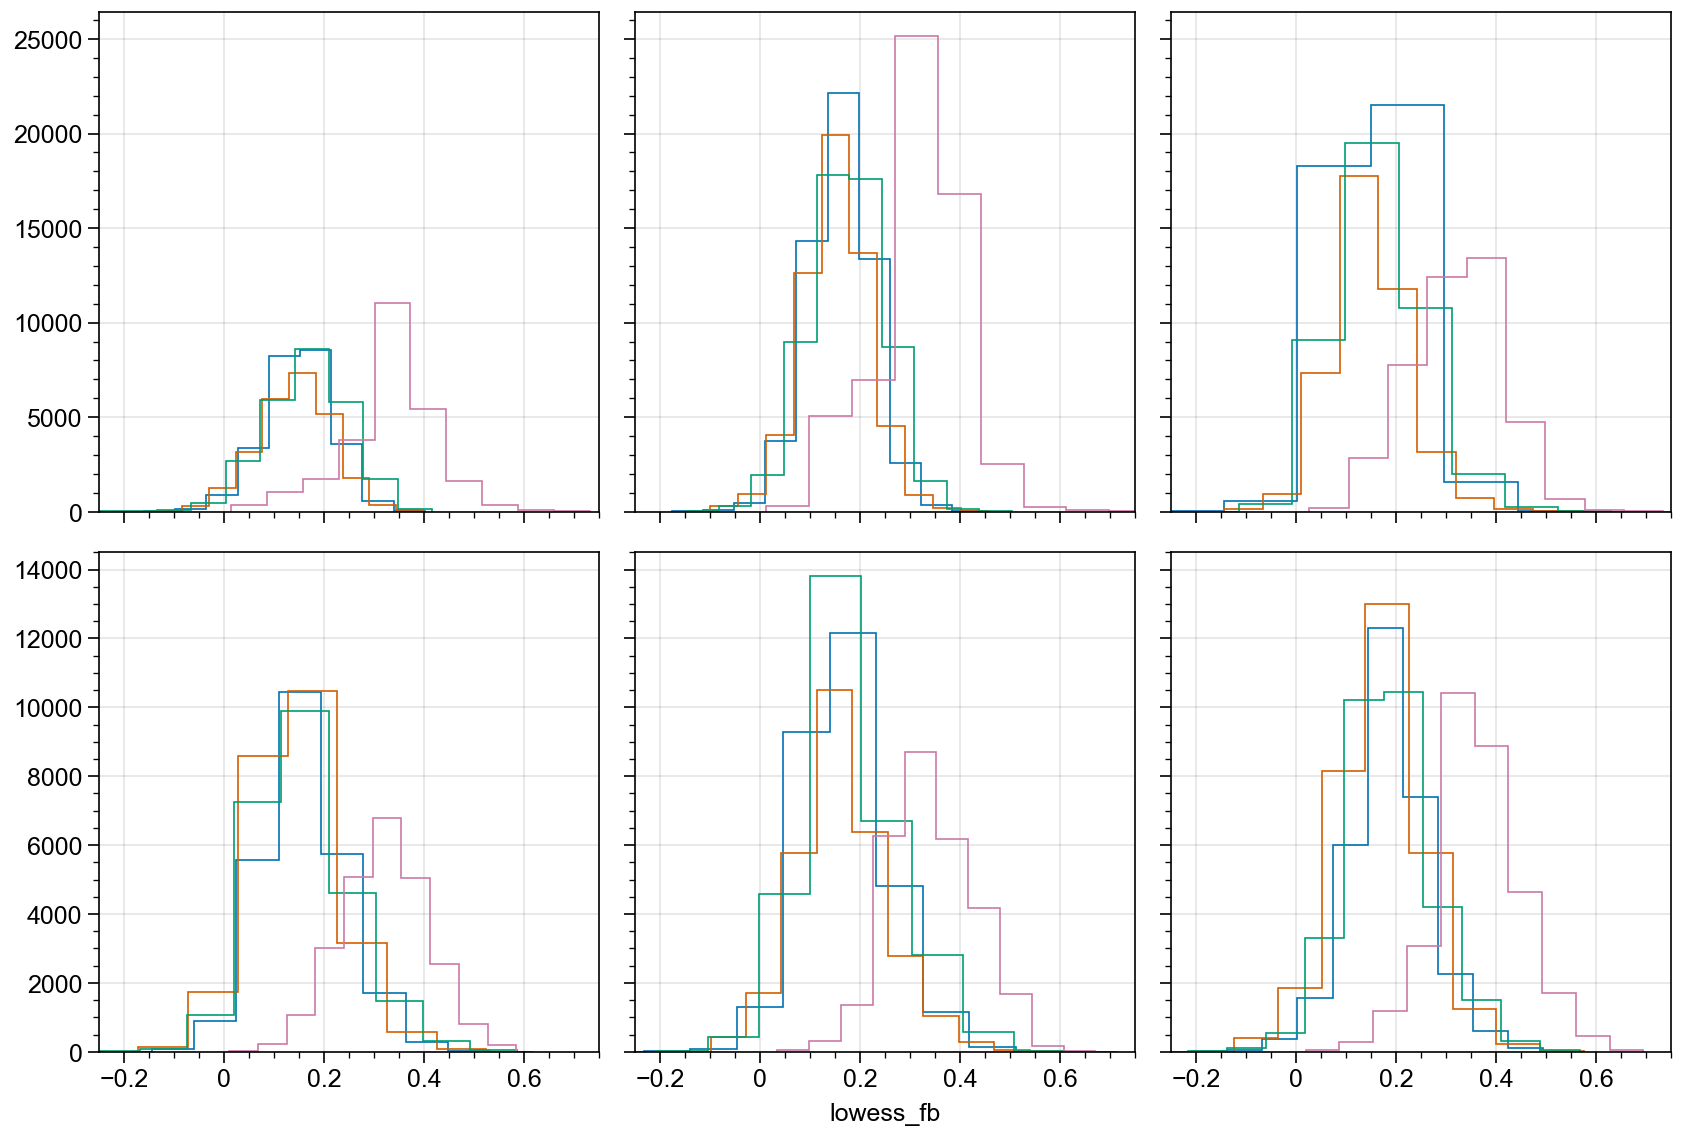

In [236]:
import proplot as pplot
fig, ax = pplot.subplots(nrows=2, ncols=3, span=True, share=True)

grid_all = CRYO2ICE_nov_LARM_SMLG_coincident
df = grid_all[(grid_all['fb'].notna())&(grid_all['LARM_rfb'].notna()) & (grid_all['CCI_rfb'].notna()) & grid_all['IS2_w_mean_fb_MSS'].notna()]
ax[0].hist(df['lowess_fb'],histtype='step') 
ax[0].hist(df['lowess_LARM_rfb'],histtype='step') 
ax[0].hist(df['lowess_CCI_rfb'],histtype='step') 
ax[0].hist(df['IS2_w_mean_fb_MSS'],histtype='step') 

grid_all = CRYO2ICE_dec_LARM_SMLG_coincident
df = grid_all[(grid_all['fb'].notna())&(grid_all['LARM_rfb'].notna()) & (grid_all['CCI_rfb'].notna()) & grid_all['IS2_w_mean_fb_MSS'].notna()]
ax[1].hist(df['lowess_fb'],histtype='step') 
ax[1].hist(df['lowess_LARM_rfb'],histtype='step') 
ax[1].hist(df['lowess_CCI_rfb'],histtype='step') 
ax[1].hist(df['IS2_w_mean_fb_MSS'],histtype='step') 

grid_all = CRYO2ICE_jan_LARM_SMLG_coincident
df = grid_all[(grid_all['fb'].notna())&(grid_all['LARM_rfb'].notna()) & (grid_all['CCI_rfb'].notna()) & grid_all['IS2_w_mean_fb_MSS'].notna()]
ax[2].hist(df['lowess_fb'],histtype='step') 
ax[2].hist(df['lowess_LARM_rfb'],histtype='step') 
ax[2].hist(df['lowess_CCI_rfb'],histtype='step') 
ax[2].hist(df['IS2_w_mean_fb_MSS'],histtype='step') 

grid_all = CRYO2ICE_feb_LARM_SMLG_coincident
df = grid_all[(grid_all['fb'].notna())&(grid_all['LARM_rfb'].notna()) & (grid_all['CCI_rfb'].notna()) & grid_all['IS2_w_mean_fb_MSS'].notna()]
ax[3].hist(df['lowess_fb'],histtype='step') 
ax[3].hist(df['lowess_LARM_rfb'],histtype='step') 
ax[3].hist(df['lowess_CCI_rfb'],histtype='step') 
ax[3].hist(df['IS2_w_mean_fb_MSS'],histtype='step') 

grid_all = CRYO2ICE_mar_LARM_SMLG_coincident
df = grid_all[(grid_all['fb'].notna())&(grid_all['LARM_rfb'].notna()) & (grid_all['CCI_rfb'].notna()) & grid_all['IS2_w_mean_fb_MSS'].notna()]
ax[4].hist(df['lowess_fb'],histtype='step') 
ax[4].hist(df['lowess_LARM_rfb'],histtype='step') 
ax[4].hist(df['lowess_CCI_rfb'],histtype='step') 
ax[4].hist(df['IS2_w_mean_fb_MSS'],histtype='step') 

grid_all = CRYO2ICE_apr_LARM_SMLG_coincident
df = grid_all[(grid_all['fb'].notna())&(grid_all['LARM_rfb'].notna()) & (grid_all['CCI_rfb'].notna()) & grid_all['IS2_w_mean_fb_MSS'].notna()]
ax[5].hist(df['lowess_fb'],histtype='step') 
ax[5].hist(df['lowess_LARM_rfb'],histtype='step') 
ax[5].hist(df['lowess_CCI_rfb'],histtype='step') 
ax[5].hist(df['IS2_w_mean_fb_MSS'],histtype='step') 
fig.format(xlim=(-0.25, 0.75))

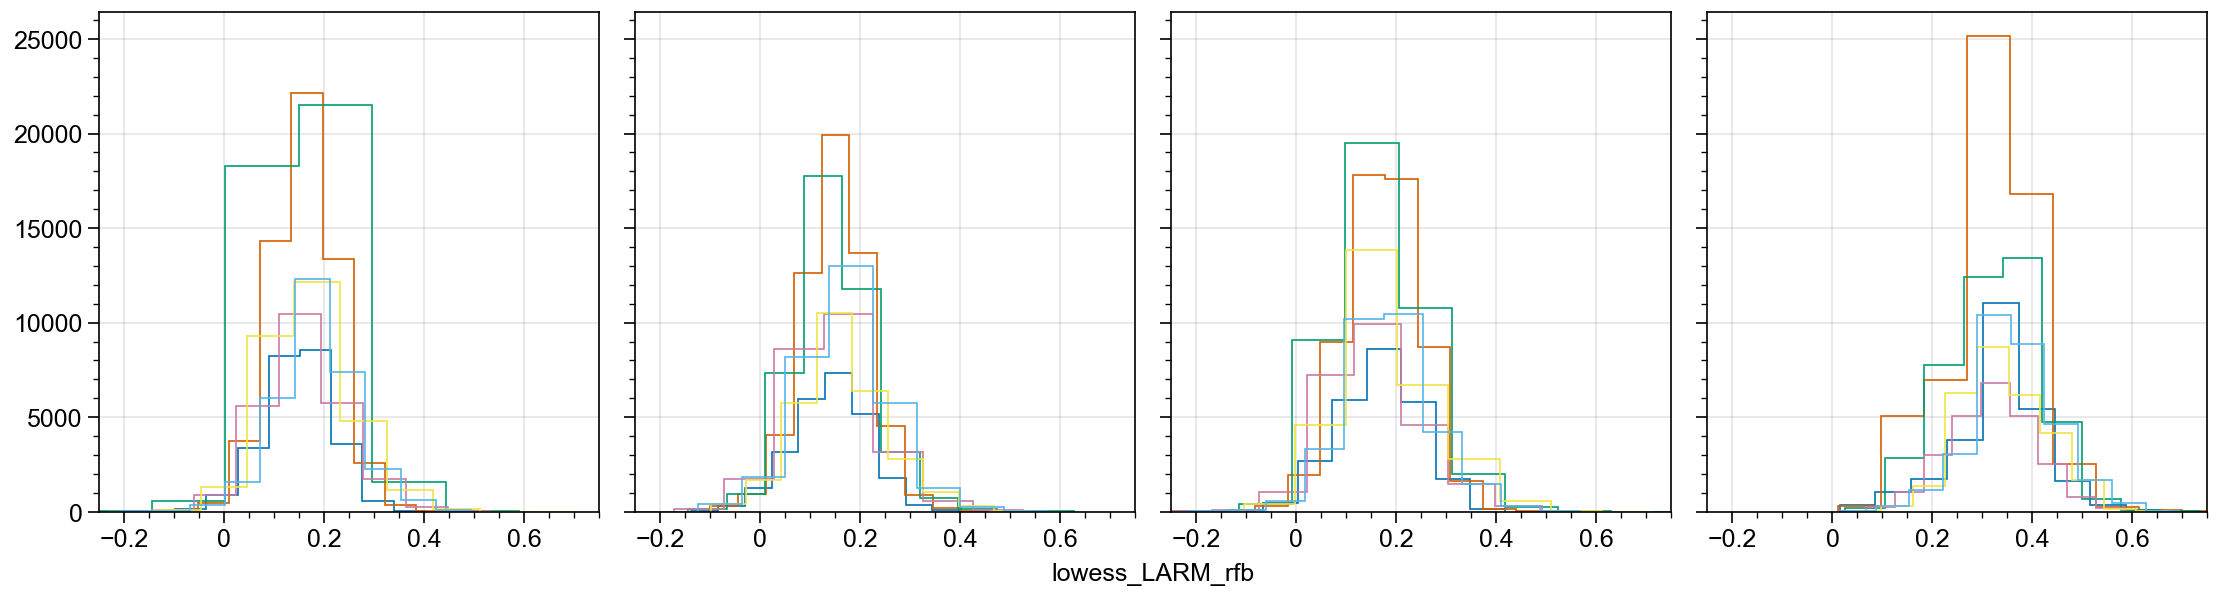

In [237]:
import proplot as pplot
fig, ax = pplot.subplots(nrows=1, ncols=4, span=True, share=True)

grid_all = CRYO2ICE_nov_LARM_SMLG_coincident
df = grid_all[(grid_all['fb'].notna())&(grid_all['LARM_rfb'].notna()) & (grid_all['CCI_rfb'].notna()) & grid_all['IS2_w_mean_fb_MSS'].notna()]
ax[0].hist(df['lowess_fb'],histtype='step') 
ax[1].hist(df['lowess_LARM_rfb'],histtype='step') 
ax[2].hist(df['lowess_CCI_rfb'],histtype='step') 
ax[3].hist(df['IS2_w_mean_fb_MSS'],histtype='step') 

grid_all = CRYO2ICE_dec_LARM_SMLG_coincident
df = grid_all[(grid_all['fb'].notna())&(grid_all['LARM_rfb'].notna()) & (grid_all['CCI_rfb'].notna()) & grid_all['IS2_w_mean_fb_MSS'].notna()]
ax[0].hist(df['lowess_fb'],histtype='step') 
ax[1].hist(df['lowess_LARM_rfb'],histtype='step') 
ax[2].hist(df['lowess_CCI_rfb'],histtype='step') 
ax[3].hist(df['IS2_w_mean_fb_MSS'],histtype='step') 

grid_all = CRYO2ICE_jan_LARM_SMLG_coincident
df = grid_all[(grid_all['fb'].notna())&(grid_all['LARM_rfb'].notna()) & (grid_all['CCI_rfb'].notna()) & grid_all['IS2_w_mean_fb_MSS'].notna()]
ax[0].hist(df['lowess_fb'],histtype='step') 
ax[1].hist(df['lowess_LARM_rfb'],histtype='step') 
ax[2].hist(df['lowess_CCI_rfb'],histtype='step') 
ax[3].hist(df['IS2_w_mean_fb_MSS'],histtype='step') 

grid_all = CRYO2ICE_feb_LARM_SMLG_coincident
df = grid_all[(grid_all['fb'].notna())&(grid_all['LARM_rfb'].notna()) & (grid_all['CCI_rfb'].notna()) & grid_all['IS2_w_mean_fb_MSS'].notna()]
ax[0].hist(df['lowess_fb'],histtype='step') 
ax[1].hist(df['lowess_LARM_rfb'],histtype='step') 
ax[2].hist(df['lowess_CCI_rfb'],histtype='step') 
ax[3].hist(df['IS2_w_mean_fb_MSS'],histtype='step') 

grid_all = CRYO2ICE_mar_LARM_SMLG_coincident
df = grid_all[(grid_all['fb'].notna())&(grid_all['LARM_rfb'].notna()) & (grid_all['CCI_rfb'].notna()) & grid_all['IS2_w_mean_fb_MSS'].notna()]
ax[0].hist(df['lowess_fb'],histtype='step') 
ax[1].hist(df['lowess_LARM_rfb'],histtype='step') 
ax[2].hist(df['lowess_CCI_rfb'],histtype='step') 
ax[3].hist(df['IS2_w_mean_fb_MSS'],histtype='step') 

grid_all = CRYO2ICE_apr_LARM_SMLG_coincident
df = grid_all[(grid_all['fb'].notna())&(grid_all['LARM_rfb'].notna()) & (grid_all['CCI_rfb'].notna()) & grid_all['IS2_w_mean_fb_MSS'].notna()]
ax[0].hist(df['lowess_fb'],histtype='step') 
ax[1].hist(df['lowess_LARM_rfb'],histtype='step') 
ax[2].hist(df['lowess_CCI_rfb'],histtype='step') 
ax[3].hist(df['IS2_w_mean_fb_MSS'],histtype='step') 
fig.format(xlim=(-0.25, 0.75))

In [130]:
def print_stats(CRYO2ICE_nov_LARM_SMLG_coincident):
    grid_all = CRYO2ICE_nov_LARM_SMLG_coincident
    df = grid_all[(grid_all['fb'].notna())&(grid_all['LARM_rfb'].notna()) & (grid_all['CCI_rfb'].notna()) & grid_all['IS2_w_mean_fb_MSS'].notna()]
    print('CS2 rfb: min = ' + str(np.nanmin(df['lowess_fb']))+ ', avg: '+ str(np.nanmean(df['lowess_fb']))+ ', max: '+str(np.nanmax(df['lowess_fb'])))
    print('CS2 LARM rfb: min = ' + str(np.nanmin(df['lowess_LARM_rfb']))+ ', avg: '+ str(np.nanmean(df['lowess_LARM_rfb']))+ ', max: '+str(np.nanmax(df['lowess_LARM_rfb'])))
    print('CS2 CCI rfb: min = ' + str(np.nanmin(df['lowess_CCI_rfb']))+ ', avg: '+ str(np.nanmean(df['lowess_CCI_rfb']))+ ', max: '+str(np.nanmax(df['lowess_CCI_rfb'])))
    print('CS2 IS2 fb: min = ' + str(np.nanmin(df['IS2_w_mean_fb_MSS']))+ ', avg: '+ str(np.nanmean(df['IS2_w_mean_fb_MSS']))+ ', max: '+str(np.nanmax(df['IS2_w_mean_fb_MSS'])))
    
    
print('Nov. stats:')
print_stats(CRYO2ICE_nov_LARM_SMLG_coincident)

print('\nDec. stats:')
print_stats(CRYO2ICE_dec_LARM_SMLG_coincident)

print('\nJan. stats:')
print_stats(CRYO2ICE_jan_LARM_SMLG_coincident)

print('\nFeb. stats:')
print_stats(CRYO2ICE_feb_LARM_SMLG_coincident)

print('\nMar. stats:')
print_stats(CRYO2ICE_mar_LARM_SMLG_coincident)

print('\nApr. stats:')
print_stats(CRYO2ICE_apr_LARM_SMLG_coincident)

Nov. stats:
CS2 rfb: min = -0.2226010166759655, avg: 0.14923675648211324, max: 0.4011540476842494
CS2 LARM rfb: min = -0.137930485208299, avg: 0.14096934695722768, max: 0.3976502379489272
CS2 CCI rfb: min = -0.2726536095142364, avg: 0.1653599743329374, max: 0.4164568642291855
CS2 IS2 fb: min = 0.0140038174340588, avg: 0.3326940097531044, max: 0.7309325367283179

Dec. stats:
CS2 rfb: min = -0.1763605156693324, avg: 0.16102660420463935, max: 0.445466616868359
CS2 LARM rfb: min = -0.099858461, avg: 0.15191811936537067, max: 0.4561554
CS2 CCI rfb: min = -0.1478477865457799, avg: 0.17559777901520604, max: 0.5034173727035522
CS2 IS2 fb: min = 0.0119504286939029, avg: 0.3199027758728222, max: 0.8695544622918452

Jan. stats:
CS2 rfb: min = -0.8800150154765405, avg: 0.1600505714930325, max: 0.59
CS2 LARM rfb: min = -0.1446236742999959, avg: 0.14662139460674642, max: 0.62735492
CS2 CCI rfb: min = -0.2203721976816074, avg: 0.16554436826525928, max: 0.8414870798587981
CS2 IS2 fb: min = 0.025934125

In [161]:
def medip_freeboard(x, y, z, z2, z3, z4, Xi, Yi, n, d):
    """2D interpolation using median."""
    # Johan Nilsson, ICESat-2 Hack Week, https://github.com/ICESAT-2HackWeek/ICESat2_hackweek_tutorials/blob/master/06_Gridding_Nilsson/notebook/Gridding.ipynb 
    
 
    xi, yi = Xi, Yi
    
    
    # Create kdtree
    tree = cKDTree(np.c_[x, y])
    
    # Loop through observations
        
    # Find closest number of observations
    (dxy, idx) = tree.query((xi, yi), k=n, distance_upper_bound=d)
    idx = idx[~np.isinf(dxy)]
    idx = np.where(idx>= len(z), np.nan, idx)
    idx = idx[~np.isnan(idx)]
    idx = idx.astype(int)

    dxy = dxy[~np.isinf(dxy)]


    # Get parameters
    zc = z[idx]
    zc2 = z2[idx]
    zc3 = z3[idx]
    zc4 = z4[idx]



    # Predicted value
    zi = np.nanmedian(zc)
    zi2 = np.nanmedian(zc2)
    zi3 = np.nanmedian(zc3)
    zi4 = np.nanmedian(zc4)

    n1, n2, n3, n4 = len(zc), len(zc2), len(zc3), len(zc4)
    
    # Return interpolated points
    return zi, zi2, zi3, zi4, n1, n2, n3, n4, zc, zc2, zc3, zc4

In [179]:
df = CRYO2ICE_dec_LARM_SMLG_coincident
df

Unnamed: 0  level_0  Unnamed: 0.1  index       lat        lon     fb  \
0               0        0          2413   2413  87.78549 -170.07006  0.165   
1               1        1          2414   2414  87.78666 -170.13409  0.175   
2               2        2          2415   2415  87.78782 -170.19818  0.139   
5               5        5          2418   2418  87.79129 -170.39087  0.209   
6               6        6          2419   2419  87.79244 -170.45523  0.278   
...           ...      ...           ...    ...       ...        ...    ...   
95541        1184     1184          3714   3714  83.19617   66.06268  0.230   
95549        1192     1192          3722   3722  83.08072   65.75851  0.186   
95551        1194     1194          3724   3724  83.06759   65.72456  0.074   
95558        1201     1201          3731   3731  83.02030   65.60338  0.021   
95559        1202     1202          3732   3732  83.01767   65.59670  0.166   

          mss  fb_no_mss    ssd  ...  CS2_fb_smoothed CS2_LARM_fb_smoothed  \
0      10.346    -10.181  44.58  ...           0.0958             0.115891   
1      10.346    -10.171  50.22  ...           0.1258                  NaN   
2      10.346    -10.207  47.35  ...           0.1764                  NaN   
5      10.346    -10.137  47.18  ...           0.1914                  NaN   
6      10.346    -10.068  46.76  ...           0.2262                  NaN   
...       ...        ...    ...  ...              ...                  ...   
95541  13.836    -13.606  20.68  ...           0.1400                  NaN   
95549  13.842    -13.656  24.00  ...           0.1738                  NaN   
95551  13.842    -13.768  29.91  ...           0.0018                  NaN   
95558  13.805    -13.784  32.17  ...           0.0100                  NaN   
95559  13.805    -13.639  31.26  ...           0.0042                  NaN   

       CS2_CCI_fb_smoothed  ID     month  \
0                 0.150658   0  December   
1                 0.202872   0  December   
2                 0.260108   0  December   
5                 0.248190   0  December   
6                 0.277634   0  December   
...                    ...  ..       ...   
95541             0.103362  62  December   
95549             0.126723  62  December   
95551            -0.003902  62  December   
95558                  NaN  62  December   
95559                  NaN  62  December   

       lowess_snow_depth_original_MSS_unit_cm  \
0                                   11.587529   
1                                   19.018172   
2                                   15.665547   
5                                   12.694921   
6                                   11.320226   
...                                       ...   
95541                                2.280068   
95549                                6.020792   
95551                                6.147710   
95558                               15.008849   
95559                               15.677506   

       lowess_snow_depth_original_MSS_LARM_unit_cm  \
0                                         8.241069   
1                                        15.805091   
2                                        12.563269   
5                                         9.339498   
6                                         7.373140   
...                                            ...   
95541                                     8.494581   
95549                                     4.453964   
95551                                     3.163381   
95558                                     6.033527   
95559                                     6.319311   

       lowess_snow_depth_original_MSS_CCI_unit_cm  SMLG_snow_depth_unit_cm  \
0                                        3.192177                24.002945   
1                                       11.467500                24.002945   
2                                        9.027358                24.002945   
5                                        8

In [244]:
import numpy as np
import pyproj
from scipy.spatial import cKDTree
from scipy.spatial.distance import cdist
from scipy import stats
from scipy.ndimage import map_coordinates

## median gridding

grid_all = CRYO2ICE_nov_LARM_SMLG_coincident
df = grid_all[(grid_all['fb'].notna())&(grid_all['LARM_rfb'].notna()) & (grid_all['CCI_rfb'].notna()) & grid_all['IS2_w_mean_fb_MSS'].notna()]
x, y, val1, val2, val3, val4 = np.array(df['lon']), np.array(df['lat']), np.array(df['lowess_fb']), np.array(df['lowess_LARM_rfb']), np.array(df['lowess_CCI_rfb']), np.array(df['IS2_w_mean_fb_MSS']) 

lon, lat = np.array(-30.0), np.array(87.5)

projIn= pyproj.Proj(init='epsg:4326')
projOut = pyproj.Proj('+proj=stere +lat_0=90 +lat_ts=70 +lon_0=-45 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs ',preserve_units=True)
x_new, y_new = pyproj.transform(projIn, projOut, (np.float64(x)), (np.float64(y)))
lon_new, lat_new = pyproj.transform(projIn, projOut, (np.float64(lon)), (np.float64(lat)))

dist_req = 25 # in km
num_req = 500 # number of points to consider 

grid_val1, grid_val2, grid_val3, grid_val4, n1, n2, n3, n4, z_val1, z_val2, z_val3, z_val4 = medip_freeboard(x_new, y_new, val1, val2, val3, val4, lon_new, lat_new, n=num_req, d=dist_req*1e3)

grid_all = CRYO2ICE_dec_LARM_SMLG_coincident
df = grid_all[(grid_all['fb'].notna())&(grid_all['LARM_rfb'].notna()) & (grid_all['CCI_rfb'].notna()) & grid_all['IS2_w_mean_fb_MSS'].notna()]
x, y, val1, val2, val3, val4 = np.array(df['lon']), np.array(df['lat']), np.array(df['lowess_fb']), np.array(df['lowess_LARM_rfb']), np.array(df['lowess_CCI_rfb']), np.array(df['IS2_w_mean_fb_MSS']) 

lon, lat = np.array(-30.0), np.array(87.5)

projIn= pyproj.Proj(init='epsg:4326')
projOut = pyproj.Proj('+proj=stere +lat_0=90 +lat_ts=70 +lon_0=-45 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs ',preserve_units=True)
x_new, y_new = pyproj.transform(projIn, projOut, (np.float64(x)), (np.float64(y)))
lon_new, lat_new = pyproj.transform(projIn, projOut, (np.float64(lon)), (np.float64(lat)))

dist_req = 25 # in km
num_req = 500 # number of points to consider 

d_grid_val1, d_grid_val2, d_grid_val3, d_grid_val4, d_n1, d_n2, d_n3, d_n4, d_z_val1, d_z_val2, d_z_val3, d_z_val4 = medip_freeboard(x_new, y_new, val1, val2, val3, val4, lon_new, lat_new, n=num_req, d=dist_req*1e3)


C:\Users\rmfha\Anaconda3\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\rmfha\AppData\Local\Temp/ipykernel_21124/3032487561.py:18: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x_new, y_new = pyproj.transform(projIn, projOut, (np.float64(x)), (np.float64(y)))
C:\Users\rmfha\AppData\Local\Temp/ipykernel_21124/3032487561.py:19: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lon_new, lat_new = pyproj.transform(projIn, projOut, (np.float64(lon)), (np.float64(lat)))
C:\Users\r

In [210]:
np.nanmean(d_z_val1)

0.2063134460019972

Text(0.5, 0.98, 'November/December')

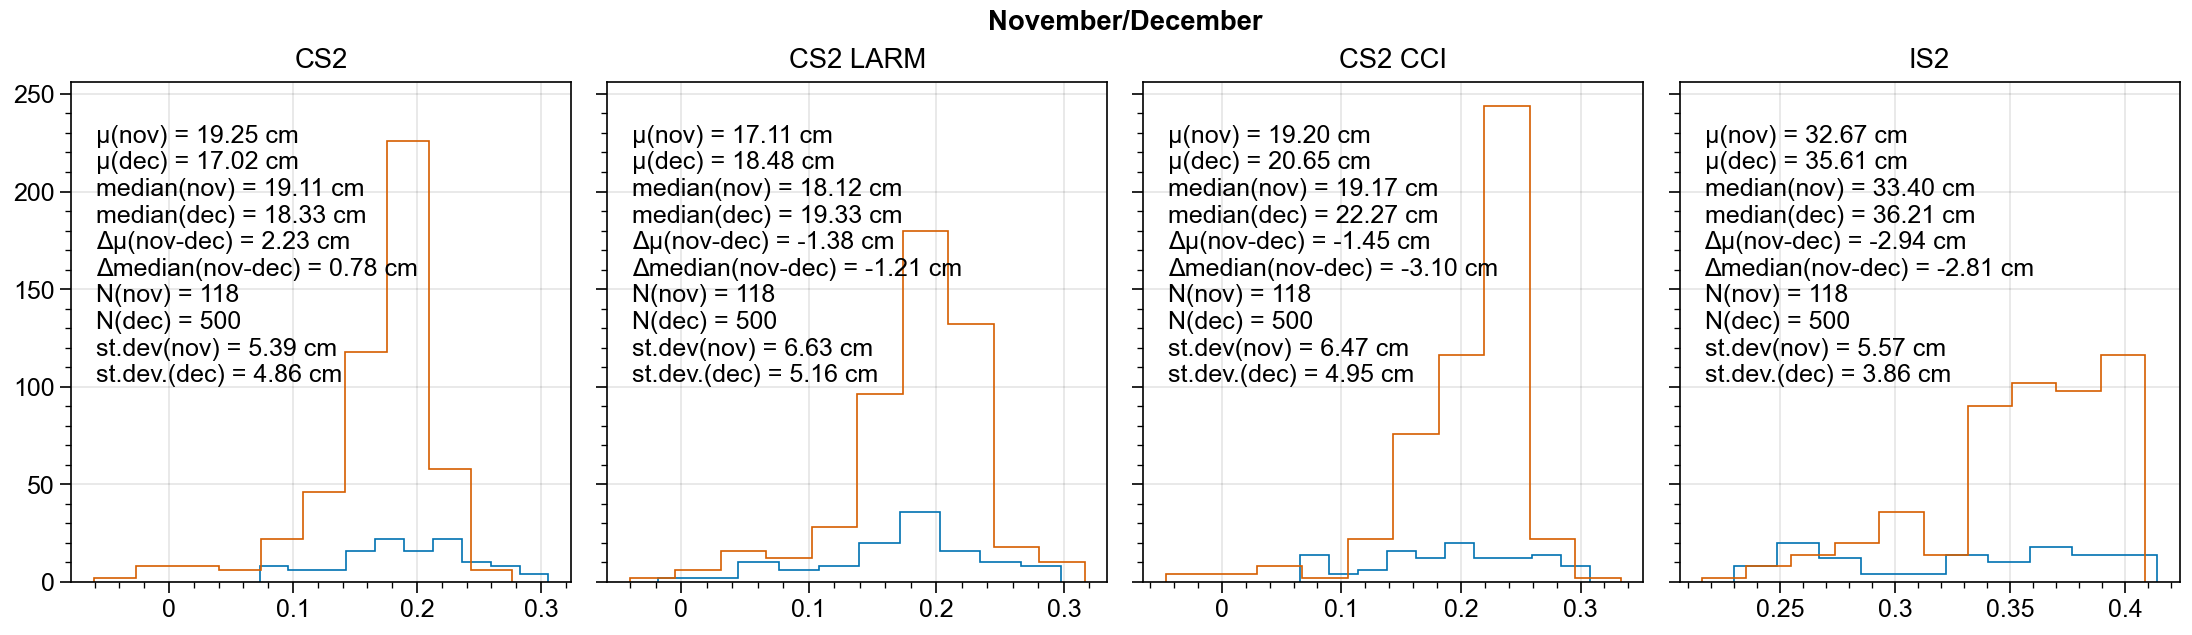

In [245]:
import proplot as pplot
fig, ax = pplot.subplots(nrows=1, ncols=4, span=True, share=True)

ax[0].hist(z_val1,histtype='step', label='Nov') 
ax[1].hist(z_val2,histtype='step',label='Nov') 
ax[2].hist(z_val3,histtype='step', label='Nov') 
ax[3].hist(z_val4,histtype='step', label='Nov') 


ax[0].hist(d_z_val1,histtype='step', label='Dec') 
ax[1].hist(d_z_val2,histtype='step',label='Dec') 
ax[2].hist(d_z_val3,histtype='step', label='Dec') 
ax[3].hist(d_z_val4,histtype='step', label='Dec') 

val1, val2 = z_val1, d_z_val1
mean_n, median_n, mean_d, median_d, diff_mean, diff_me, n_n, n_d, std_n, std_d = np.nanmean(val1), np.nanmedian(val1),np.nanmean(val2), np.nanmedian(val2), np.nanmean(val1)-np.nanmean(val2), np.nanmedian(val1)-np.nanmedian(val2), len(val1), len(val2), np.nanstd(val1), np.nanstd(val2)
text = '\u03BC(nov) = {:.2f} cm\n\u03Bc(dec) = {:.2f} cm\nmedian(nov) = {:.2f} cm\nmedian(dec) = {:.2f} cm\n\u0394\u03Bc(nov-dec) = {:.2f} cm\n\u0394median(nov-dec) = {:.2f} cm\nN(nov) = {}\nN(dec) = {}\nst.dev(nov) = {:.2f} cm\nst.dev.(dec) = {:.2f} cm'.format(mean_n*100, mean_d*100, median_n*100, median_d*100, diff_mean*100, diff_me*100, n_n, n_d, std_n*100, std_d*100)
ax[0].text(0.05, 0.4, text, transform=ax[0].transAxes)

val1, val2 = z_val2, d_z_val2
mean_n, median_n, mean_d, median_d, diff_mean, diff_me, n_n, n_d, std_n, std_d = np.nanmean(val1), np.nanmedian(val1),np.nanmean(val2), np.nanmedian(val2), np.nanmean(val1)-np.nanmean(val2), np.nanmedian(val1)-np.nanmedian(val2), len(val1), len(val2), np.nanstd(val1), np.nanstd(val2)
text = '\u03BC(nov) = {:.2f} cm\n\u03Bc(dec) = {:.2f} cm\nmedian(nov) = {:.2f} cm\nmedian(dec) = {:.2f} cm\n\u0394\u03Bc(nov-dec) = {:.2f} cm\n\u0394median(nov-dec) = {:.2f} cm\nN(nov) = {}\nN(dec) = {}\nst.dev(nov) = {:.2f} cm\nst.dev.(dec) = {:.2f} cm'.format(mean_n*100, mean_d*100, median_n*100, median_d*100, diff_mean*100, diff_me*100, n_n, n_d, std_n*100, std_d*100)
ax[1].text(0.05, 0.4, text, transform=ax[1].transAxes)

val1, val2 = z_val3, d_z_val3
mean_n, median_n, mean_d, median_d, diff_mean, diff_me, n_n, n_d, std_n, std_d = np.nanmean(val1), np.nanmedian(val1),np.nanmean(val2), np.nanmedian(val2), np.nanmean(val1)-np.nanmean(val2), np.nanmedian(val1)-np.nanmedian(val2), len(val1), len(val2), np.nanstd(val1), np.nanstd(val2)
text = '\u03BC(nov) = {:.2f} cm\n\u03Bc(dec) = {:.2f} cm\nmedian(nov) = {:.2f} cm\nmedian(dec) = {:.2f} cm\n\u0394\u03Bc(nov-dec) = {:.2f} cm\n\u0394median(nov-dec) = {:.2f} cm\nN(nov) = {}\nN(dec) = {}\nst.dev(nov) = {:.2f} cm\nst.dev.(dec) = {:.2f} cm'.format(mean_n*100, mean_d*100, median_n*100, median_d*100, diff_mean*100, diff_me*100, n_n, n_d, std_n*100, std_d*100)
ax[2].text(0.05, 0.4, text, transform=ax[2].transAxes)

val1, val2 = z_val4, d_z_val4
mean_n, median_n, mean_d, median_d, diff_mean, diff_me, n_n, n_d, std_n, std_d = np.nanmean(val1), np.nanmedian(val1),np.nanmean(val2), np.nanmedian(val2), np.nanmean(val1)-np.nanmean(val2), np.nanmedian(val1)-np.nanmedian(val2), len(val1), len(val2), np.nanstd(val1), np.nanstd(val2)
text = '\u03BC(nov) = {:.2f} cm\n\u03Bc(dec) = {:.2f} cm\nmedian(nov) = {:.2f} cm\nmedian(dec) = {:.2f} cm\n\u0394\u03Bc(nov-dec) = {:.2f} cm\n\u0394median(nov-dec) = {:.2f} cm\nN(nov) = {}\nN(dec) = {}\nst.dev(nov) = {:.2f} cm\nst.dev.(dec) = {:.2f} cm'.format(mean_n*100, mean_d*100, median_n*100, median_d*100, diff_mean*100, diff_me*100, n_n, n_d, std_n*100, std_d*100)
ax[3].text(0.05, 0.4, text, transform=ax[3].transAxes)


ax[0].set_title('CS2')
ax[1].set_title('CS2 LARM')
ax[2].set_title('CS2 CCI')
ax[3].set_title('IS2')

plt.suptitle('November/December')

In [247]:
ds=0.3
ns = (1+0.51*ds)**(1.5)

print(50.63-31.71)

18.92


In [ ]:
def plot_barplot_LARM_SMLG_coincident(ax,CRYO2ICE_nov_LARM_SMLG_coincident, colours, month):
    bbox2 = ax.boxplot([CRYO2ICE_nov_LARM_SMLG_coincident['lowess_snow_depth_original_MSS_unit_cm'], CRYO2ICE_nov_LARM_SMLG_coincident['lowess_snow_depth_original_MSS_LARM_unit_cm'], CRYO2ICE_nov_LARM_SMLG_coincident['lowess_snow_depth_original_MSS_CCI_unit_cm'], CRYO2ICE_nov_LARM_SMLG_coincident['SMLG_snow_depth_unit_cm'], CRYO2ICE_nov_LARM_SMLG_coincident['SMLG_snow_depth_v2_unit_cm']], showfliers=False, patch_artist=True)
    for patch, color, medians in zip(bbox2['boxes'], colours, bbox2['medians']):
        patch.set_facecolor(color)
        medians.set_color('black')

    #ax.set_xticklabels(['CRYO2ICE', 'CRYO2ICE LARM', 'SMLG'], rotation=45, ha='right', rotation_mode='anchor')
    ax.text(0.95, 0.95, month,transform = ax.transAxes,weight='bold', ha='right')
    ax.text(0.95, 0.89, 'n = {}'.format(len(CRYO2ICE_nov_LARM_SMLG_coincident)),transform = ax.transAxes, ha='right')
    #ax.set_title('LARM and SMLG coincident: n = {}'.format(len(CRYO2ICE_nov_LARM_SMLG_coincident)))
    ax.text(0.05, 0.25, '$\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(np.nanmean(CRYO2ICE_nov_LARM_SMLG_coincident['lowess_snow_depth_original_MSS_unit_cm']), np.nanstd(CRYO2ICE_nov_LARM_SMLG_coincident['lowess_snow_depth_original_MSS_unit_cm'])),transform = ax.transAxes, color = colours[0], fontsize=6)
    ax.text(0.05, 0.20, '$\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(np.nanmean(CRYO2ICE_nov_LARM_SMLG_coincident['lowess_snow_depth_original_MSS_LARM_unit_cm']), np.nanstd(CRYO2ICE_nov_LARM_SMLG_coincident['lowess_snow_depth_original_MSS_LARM_unit_cm'])),transform = ax.transAxes, color = colours[1], fontsize=6)
    ax.text(0.05, 0.15, '$\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(np.nanmean(CRYO2ICE_nov_LARM_SMLG_coincident['lowess_snow_depth_original_MSS_CCI_unit_cm']), np.nanstd(CRYO2ICE_nov_LARM_SMLG_coincident['lowess_snow_depth_original_MSS_CCI_unit_cm'])),transform = ax.transAxes, color = colours[2], fontsize=6)
    ax.text(0.05, 0.10, '$\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(np.nanmean(CRYO2ICE_nov_LARM_SMLG_coincident['SMLG_snow_depth_unit_cm']), np.nanstd(CRYO2ICE_nov_LARM_SMLG_coincident['SMLG_snow_depth_unit_cm'])),transform = ax.transAxes, color = colours[3], fontsize=6)
    ax.text(0.05, 0.05, '$\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(np.nanmean(CRYO2ICE_nov_LARM_SMLG_coincident['SMLG_snow_depth_v2_unit_cm']), np.nanstd(CRYO2ICE_nov_LARM_SMLG_coincident['SMLG_snow_depth_v2_unit_cm'])),transform = ax.transAxes, color = colours[4], fontsize=6)
    
    
    ax.set_xticks([])
    return

def plot_barplot_LARM_SMLG_AMSR2_coincident(ax,CRYO2ICE_nov_LARM_SMLG_coincident, colours, month):
    bbox2 = ax.boxplot([CRYO2ICE_nov_LARM_SMLG_coincident['lowess_snow_depth_original_MSS_unit_cm'], CRYO2ICE_nov_LARM_SMLG_coincident['lowess_snow_depth_original_MSS_LARM_unit_cm'],CRYO2ICE_nov_LARM_SMLG_coincident['lowess_snow_depth_original_MSS_CCI_unit_cm'], CRYO2ICE_nov_LARM_SMLG_coincident['SMLG_snow_depth_unit_cm'], CRYO2ICE_nov_LARM_SMLG_coincident['SMLG_snow_depth_v2_unit_cm'], CRYO2ICE_nov_LARM_SMLG_coincident['AMSR2_snow_depth']], showfliers=False, patch_artist=True)
    for patch, color, medians in zip(bbox2['boxes'], colours, bbox2['medians']):
        patch.set_facecolor(color)
        medians.set_color('black')

    #ax.set_xticklabels(['CRYO2ICE', 'CRYO2ICE LARM', 'SMLG'], rotation=45, ha='right', rotation_mode='anchor')
    ax.text(0.95, 0.95, month,transform = ax.transAxes,weight='bold', ha='right')
    ax.text(0.95, 0.89, 'n = {}'.format(len(CRYO2ICE_nov_LARM_SMLG_coincident)),transform = ax.transAxes, ha='right')
    #ax.set_title('LARM, SMLG and AMSR2 coincident: n = {}'.format(len(CRYO2ICE_nov_LARM_SMLG_coincident)))
    ax.text(0.05, 0.30, '$\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(np.nanmean(CRYO2ICE_nov_LARM_SMLG_coincident['lowess_snow_depth_original_MSS_unit_cm']), np.nanstd(CRYO2ICE_nov_LARM_SMLG_coincident['lowess_snow_depth_original_MSS_unit_cm'])),transform = ax.transAxes, color = colours[0], fontsize=6)
    ax.text(0.05, 0.25, '$\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(np.nanmean(CRYO2ICE_nov_LARM_SMLG_coincident['lowess_snow_depth_original_MSS_LARM_unit_cm']), np.nanstd(CRYO2ICE_nov_LARM_SMLG_coincident['lowess_snow_depth_original_MSS_LARM_unit_cm'])),transform = ax.transAxes, color = colours[1], fontsize=6)
    ax.text(0.05, 0.20, '$\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(np.nanmean(CRYO2ICE_nov_LARM_SMLG_coincident['lowess_snow_depth_original_MSS_CCI_unit_cm']), np.nanstd(CRYO2ICE_nov_LARM_SMLG_coincident['lowess_snow_depth_original_MSS_CCI_unit_cm'])),transform = ax.transAxes, color = colours[2], fontsize=6)
    ax.text(0.05, 0.15, '$\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(np.nanmean(CRYO2ICE_nov_LARM_SMLG_coincident['SMLG_snow_depth_unit_cm']), np.nanstd(CRYO2ICE_nov_LARM_SMLG_coincident['SMLG_snow_depth_unit_cm'])),transform = ax.transAxes, color = colours[3], fontsize=6)
    ax.text(0.05, 0.10, '$\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(np.nanmean(CRYO2ICE_nov_LARM_SMLG_coincident['SMLG_snow_depth_v2_unit_cm']), np.nanstd(CRYO2ICE_nov_LARM_SMLG_coincident['SMLG_snow_depth_v2_unit_cm'])),transform = ax.transAxes, color = colours[4], fontsize=6)
    ax.text(0.05, 0.05, '$\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(np.nanmean(CRYO2ICE_nov_LARM_SMLG_coincident['AMSR2_snow_depth']), np.nanstd(CRYO2ICE_nov_LARM_SMLG_coincident['AMSR2_snow_depth'])),transform = ax.transAxes, color = colours[5], fontsize=6)
    
    
    ax.set_xticks([])
    return


from matplotlib.patches import Patch
from matplotlib.lines import Line2D
fig, ax = plt.subplots(2,6, figsize=(10,6),constrained_layout=True, sharey=True)
#cmap_qual = plt.get_cmap('538')
cmap_qual_green = LinearSegmentedColormap.from_list('list', ['green', 'gray'], N = 2)

'''cmap_qual = ['#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00', '#CC79A7', 'darkorange']
cmap_qual = LinearSegmentedColormap.from_list('list', cmap_qual, N = len(cmap_qual))'''

cmap_qual = [rgb2hex(cmap_check((0/8))),rgb2hex(cmap_check((1/8))),rgb2hex(cmap_check((2/8))), rgb2hex(cmap_check(6/8)), rgb2hex(cmap_check(7/8)), rgb2hex(cmap_check(8/8)), cmap_qual_green(1)]

#colours = [cmap_qual(0)[0:3],cmap_qual(1)[0:3],cmap_qual(2)[0:3],cmap_qual(3)[0:3],cmap_qual(4)[0:3],cmap_qual(5)[0:3]]


month='November'
plot_barplot_LARM_SMLG_coincident(ax[0,0],CRYO2ICE_nov_LARM_SMLG_coincident, cmap_qual,month)
plot_barplot_LARM_SMLG_AMSR2_coincident(ax[1,0],CRYO2ICE_nov_LARM_SMLG_AMSR2_coincident, cmap_qual,month)

month='December'
plot_barplot_LARM_SMLG_coincident(ax[0,1],CRYO2ICE_dec_LARM_SMLG_coincident, cmap_qual,month)
plot_barplot_LARM_SMLG_AMSR2_coincident(ax[1,1],CRYO2ICE_dec_LARM_SMLG_AMSR2_coincident,cmap_qual,month)

month='January'
plot_barplot_LARM_SMLG_coincident(ax[0,2],CRYO2ICE_jan_LARM_SMLG_coincident, cmap_qual,month)
plot_barplot_LARM_SMLG_AMSR2_coincident(ax[1,2],CRYO2ICE_jan_LARM_SMLG_AMSR2_coincident,cmap_qual,month)

month='February'
plot_barplot_LARM_SMLG_coincident(ax[0,3],CRYO2ICE_feb_LARM_SMLG_coincident, cmap_qual,month)
plot_barplot_LARM_SMLG_AMSR2_coincident(ax[1,3],CRYO2ICE_feb_LARM_SMLG_AMSR2_coincident,cmap_qual,month)

month='March'
plot_barplot_LARM_SMLG_coincident(ax[0,4],CRYO2ICE_mar_LARM_SMLG_coincident, cmap_qual,month)
plot_barplot_LARM_SMLG_AMSR2_coincident(ax[1,4],CRYO2ICE_mar_LARM_SMLG_AMSR2_coincident,cmap_qual,month)

month='April'
plot_barplot_LARM_SMLG_coincident(ax[0,5],CRYO2ICE_apr_LARM_SMLG_coincident, cmap_qual,month)
plot_barplot_LARM_SMLG_AMSR2_coincident(ax[1,5],CRYO2ICE_apr_LARM_SMLG_AMSR2_coincident,cmap_qual,month)


legend_elements = [Patch(facecolor=cmap_qual[0], edgecolor='k',label='CRYO2ICE'),
                  Patch(facecolor=cmap_qual[1], edgecolor='k',label='CRYO2ICE LARM'),
                   Patch(facecolor=cmap_qual[2], edgecolor='k',label='CRYO2ICE CCI'),
                  Patch(facecolor=cmap_qual[3], edgecolor='k',label='SMLG'),
                   Patch(facecolor=cmap_qual[4], edgecolor='k',label='SMLG v2'),
                  Patch(facecolor=cmap_qual[5], edgecolor='k',label='AMSR2'),]

plt.legend(handles=legend_elements, loc='upper right', fontsize=8,bbox_to_anchor=(2.2, 2.03),frameon=False)
plt.subplots_adjust(wspace=0.0, hspace=0.0,right=0.8)
ax[0,0].set_ylabel('snow depth (cm)')
ax[1,0].set_ylabel('snow depth (cm)')

ax[0,0].set_ylim([-60,75])
ax[1,0].set_ylim([-60,65])

ax[0,0].text(0.05, 0.95, '(a)',transform = ax[0,0].transAxes)
ax[1,0].text(0.05, 0.95, '(b)',transform = ax[1,0].transAxes)

#plt.savefig('E:\demo_CRYO2ICE_barplot_combined_corrected_snow_depth.png', transparent=True)

# ASSIST - make data comparable

In [ ]:
path_ASSIST = r'E:\DTU\CRYO2ICE\ASSIST'
filename_ASSIST = 'observations-108.csv'
df_ASSIST_v1 = pd.read_csv(path_ASSIST+ '/'+filename_ASSIST)
df_ASSIST_v1['snow_depth (m)']=np.nanmean([df_ASSIST_v1['PSH'],df_ASSIST_v1['SSH'],df_ASSIST_v1['TSH']], axis=0)/100

filename_ASSIST = 'observations-109.csv'
df_ASSIST_v2 = pd.read_csv(path_ASSIST+ '/'+filename_ASSIST)
df_ASSIST_v2['snow_depth (m)']=np.nanmean([df_ASSIST_v2['PSH'],df_ASSIST_v2['SSH'],df_ASSIST_v2['TSH']], axis=0)/100

filename_ASSIST = 'observations-110.csv'
df_ASSIST_v3 = pd.read_csv(path_ASSIST+ '/'+filename_ASSIST)
df_ASSIST_v3['snow_depth (m)']=np.nanmean([df_ASSIST_v3['PSH'],df_ASSIST_v3['SSH'],df_ASSIST_v3['TSH']], axis=0)/100

frames = [df_ASSIST_v1, df_ASSIST_v2, df_ASSIST_v3]

df_ASSIST = pd.concat(frames)
df_ASSIST = df_ASSIST.sort_values(by='Date')
df_ASSIST = df_ASSIST[['Date', 'LAT', 'LON', 'PSH', 'SSH', 'TSH']]
df_ASSIST['snow_depth (m)']=np.nanmean([df_ASSIST['PSH'],df_ASSIST['SSH'],df_ASSIST['TSH']], axis=0)/100
df_ASSIST_notna = df_ASSIST[df_ASSIST['snow_depth (m)'].notna()]

In [ ]:
def plot_panArctic8(lon, lat, sit, min_set, max_set, cmap_set, label, extend_info, ax, fig):
    #fig = plt.figure(figsize=(6,5))
    fig.patch.set_facecolor('white')
    #ax = plt.gca()
    #m = Basemap(projection='ortho',lat_0=90,lon_0=0,resolution='l', ax=ax);
    x1 = -180
    x2 = 180
    y1 = 0
    y2 = 90
    cmap1 = plt.get_cmap('greys', 4)

    m = Basemap(projection='npstere', llcrnrlat=y1,urcrnrlat=y2,llcrnrlon=x1,urcrnrlon=x2,boundinglat=70,lon_0=0, resolution='i',ax=ax, round=True)
    m.drawmeridians(np.arange(0,360,30),labels=[0,0,0,0],linewidth=0.5, fontsize=10, dashes=[1,5])
    m.drawparallels(np.arange(-90,90,15),linewidth=0.5, fontsize=10, dashes=[1,5],labels=[0,0,0,0])
    m.drawcoastlines(linewidth=0.5)
    m.fillcontinents(color='lightgray')
    #m.fillcontinents(color='darkgray')
    #m.drawmapboundary(fill_color='dimgray')
    #cbar = m.etopo()
    x=m.scatter(lon, lat, latlon=True, c=sit, s=10,vmin = min_set, vmax=max_set, cmap=cmap_set, zorder=1,edgecolors ='k',linewidth=0.3)
     #cbar = plt.colorbar(x, extend =extend_info, orientation="horizontal",ax=ax)
    #cbar.set_label(label)

    ax.set_title(title, y=1.08,fontsize=18)
    return x

In [ ]:
print(np.nanmax(df_ASSIST_v3['snow_depth (m)']))
print(np.nanmax(df_ASSIST_v2['snow_depth (m)']))
print(np.nanmax(df_ASSIST_v1['snow_depth (m)']))

In [ ]:
import proplot as pplt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import linregress
pplt.rc.update(grid=False)
fig, ax = pplt.subplots([[1, 2]],refwidth=5, refheight=5,share=False)

from matplotlib.lines import Line2D


cmap = plt.cm.get_cmap('Blues')
cmap_qual2 = [cmap(1/6), cmap(2/6), cmap(3/6), cmap(4/6), cmap(5/6), cmap(6/6)]

cmap_qual = ['#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00', '#CC79A7', 'darkorange']
cmap_qual = LinearSegmentedColormap.from_list('list', cmap_qual, N = len(cmap_qual))
colours = [cmap_qual(0)[0:3],cmap_qual(1)[0:3],cmap_qual(2)[0:3],cmap_qual(3)[0:3],cmap_qual(4)[0:3],cmap_qual(5)[0:3]]

cmap_qual_green = LinearSegmentedColormap.from_list('list', ['green', 'gray'], N = 2)


#cmap_qual = plt.get_cmap('colorblind10') 
im = plot_panArctic5(np.array(CRYO2ICE_nov['lon']), np.array(CRYO2ICE_nov['lat']), cmap_qual2[0], 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax[0],fig)
im = plot_panArctic5(np.array(CRYO2ICE_dec['lon']), np.array(CRYO2ICE_dec['lat']), cmap_qual2[1], 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax[0],fig)
im = plot_panArctic5(np.array(CRYO2ICE_jan['lon']), np.array(CRYO2ICE_jan['lat']), cmap_qual2[2], 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax[0],fig)
im = plot_panArctic5(np.array(CRYO2ICE_feb['lon']), np.array(CRYO2ICE_feb['lat']), cmap_qual2[3], 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax[0],fig)
im = plot_panArctic5(np.array(CRYO2ICE_mar['lon']), np.array(CRYO2ICE_mar['lat']), cmap_qual2[4], 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax[0],fig)
im = plot_panArctic5(np.array(CRYO2ICE_apr['lon']), np.array(CRYO2ICE_apr['lat']), cmap_qual2[5], 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax[0],fig)

im = plot_panArctic8(np.array(df_ASSIST_v1['LON']), np.array(df_ASSIST_v1['LAT']), cmap_qual(0), 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax[0],fig)
im = plot_panArctic8(np.array(df_ASSIST_v2['LON']), np.array(df_ASSIST_v2['LAT']), cmap_qual(6), 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax[0],fig)
im = plot_panArctic8(np.array(df_ASSIST_v3['LON']), np.array(df_ASSIST_v3['LAT']), cmap_qual(2), 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax[0],fig)



ax[0].text(0.65, 0.28, r'CRYO2ICE', color='k', transform= ax[0].transAxes,weight="bold")
ax[0].text(0.65, 0.25, 'November', color=cmap_qual2[0], transform= ax[0].transAxes,weight="bold")
ax[0].text(0.65, 0.22, 'December', color=cmap_qual2[1], transform= ax[0].transAxes,weight="bold")
ax[0].text(0.65, 0.19, 'January', color=cmap_qual2[2], transform= ax[0].transAxes,weight="bold")
ax[0].text(0.65, 0.16, 'February', color=cmap_qual2[3], transform= ax[0].transAxes,weight="bold")
ax[0].text(0.65, 0.13, 'March', color=cmap_qual2[4], transform= ax[0].transAxes,weight="bold")
ax[0].text(0.65, 0.10, 'April', color=cmap_qual2[5], transform= ax[0].transAxes,weight="bold")

ax[0].text(0.50, 0.12, 'ASSIST#1', color=cmap_qual(0), transform= ax[0].transAxes,weight="bold")
ax[0].text(0.50, 0.09, 'ASSIST#2', color=cmap_qual(6), transform= ax[0].transAxes,weight="bold")
ax[0].text(0.50, 0.06, 'ASSIST#3', color=cmap_qual(2), transform= ax[0].transAxes,weight="bold")


###

im = plot_panArctic5(np.array(CRYO2ICE_nov['lon']), np.array(CRYO2ICE_nov['lat']), cmap_qual2[0], 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax[1],fig)
im = plot_panArctic5(np.array(CRYO2ICE_dec['lon']), np.array(CRYO2ICE_dec['lat']), cmap_qual2[1], 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax[1],fig)
im = plot_panArctic5(np.array(CRYO2ICE_jan['lon']), np.array(CRYO2ICE_jan['lat']), cmap_qual2[2], 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax[1],fig)
im = plot_panArctic5(np.array(CRYO2ICE_feb['lon']), np.array(CRYO2ICE_feb['lat']), cmap_qual2[3], 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax[1],fig)
im = plot_panArctic5(np.array(CRYO2ICE_mar['lon']), np.array(CRYO2ICE_mar['lat']), cmap_qual2[4], 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax[1],fig)
im = plot_panArctic5(np.array(CRYO2ICE_apr['lon']), np.array(CRYO2ICE_apr['lat']), cmap_qual2[5], 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax[1],fig)

im = plot_panArctic8(np.array(df_ASSIST_v1[df_ASSIST_v1['snow_depth (m)'].notna()]['LON']), np.array(df_ASSIST_v1[df_ASSIST_v1['snow_depth (m)'].notna()]['LAT']), cmap_qual(0), 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax[1],fig)
im = plot_panArctic8(np.array(df_ASSIST_v2[df_ASSIST_v2['snow_depth (m)'].notna()]['LON']), np.array(df_ASSIST_v2[df_ASSIST_v2['snow_depth (m)'].notna()]['LAT']), cmap_qual(6), 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax[1],fig)
im = plot_panArctic8(np.array(df_ASSIST_v3[df_ASSIST_v3['snow_depth (m)'].notna()]['LON']), np.array(df_ASSIST_v3[df_ASSIST_v3['snow_depth (m)'].notna()]['LAT']), cmap_qual(2), 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax[1],fig)




ax.format(
    abc='(a)', abcloc='ul')
plt.savefig('E:\demo_CRYO2ICE_coverage_months_combined_ASSIST_coverage.png', transparent=True)

# AWI - compute daily comparable data

In [ ]:
path_AWI = r'E:\DTU\CRYO2ICE\AWI_buoy'
#'''
folder_AWI = '2020S108'
filename_AWI = '2020S108_300234066081170_proc.csv'
init_sd_1, init_sd_2,init_sd_3,init_sd_4 = 0,0,0,0 # metres
#'''
'''
folder_AWI = '2020S107'
filename_AWI = '2020S107_300234066081140_proc.csv'
init_sd_1, init_sd_2,init_sd_3,init_sd_4 = np.nan, np.nan, np.nan, np.nan # metres
'''
'''
folder_AWI = '2020S106'
filename_AWI = '2020S106_300234066083120_proc.csv'
init_sd_1, init_sd_2,init_sd_3,init_sd_4 = 0,0,0,0 # metres
'''
'''
folder_AWI = '2020S105'
filename_AWI = '2020S105_300234066080130_proc.csv'
init_sd_1, init_sd_2,init_sd_3,init_sd_4 = 0.03,np.nan,0.02,0.04 # metres
'''
'''
folder_AWI = '2020S98'
filename_AWI = '2020S98_300234066087160_proc.csv'
init_sd_1, init_sd_2,init_sd_3,init_sd_4 = 0, 0, 0, 0 # metres
'''
df_AWI_buoy = pd.read_csv(path_AWI+'/' + folder_AWI + '/'+filename_AWI)
df_AWI_buoy["datetime"] = pd.to_datetime(df_AWI_buoy["time"])
if init_sd_1 == np.nan:
    df_AWI_buoy['distance_to_initial_snow_ice_interface_1 (m)']=np.nan
else:
    df_AWI_buoy['distance_to_initial_snow_ice_interface_1 (m)']= init_sd_1+df_AWI_buoy['distance_to_initial_snow_ice_interface_1 (m)']

if init_sd_2 == np.nan:
    df_AWI_buoy['distance_to_initial_snow_ice_interface_2 (m)']= np.nan
else:
    df_AWI_buoy['distance_to_initial_snow_ice_interface_2 (m)']=init_sd_2+df_AWI_buoy['distance_to_initial_snow_ice_interface_2 (m)']

if init_sd_3 == np.nan:
    df_AWI_buoy['distance_to_initial_snow_ice_interface_3 (m)']= np.nan
else:
    df_AWI_buoy['distance_to_initial_snow_ice_interface_3 (m)']=init_sd_3+df_AWI_buoy['distance_to_initial_snow_ice_interface_3 (m)']

if init_sd_3 == np.nan:
    df_AWI_buoy['distance_to_initial_snow_ice_interface_4 (m)']=np.nan
else:
    df_AWI_buoy['distance_to_initial_snow_ice_interface_4 (m)']=init_sd_4+df_AWI_buoy['distance_to_initial_snow_ice_interface_4 (m)']

df_daily = df_AWI_buoy.groupby(by=pd.Grouper(freq='D', key='datetime')).agg(np.nanmean)
snow_depth = np.array([df_daily['distance_to_initial_snow_ice_interface_1 (m)'],df_daily['distance_to_initial_snow_ice_interface_2 (m)'],df_daily['distance_to_initial_snow_ice_interface_3 (m)'],df_daily['distance_to_initial_snow_ice_interface_4 (m)']])
df_daily['daily_snow_depth (m)'] = np.nanmean(snow_depth, axis=0)
df_daily['daily_snow_depth (m)']=df_daily['daily_snow_depth (m)'].rolling(5).mean()
df_daily[df_daily['daily_snow_depth (m)']<0] = np.nan

df_daily.to_csv(path_AWI+'/' + folder_AWI +'_daily.csv')


# SIMBA buoy 

In [ ]:
# Define filepath
path_SIMBA = r'E:\DTU\CRYO2ICE\SIMBA_buoy'

filename_SIMBA = 'Snow_depth_MOSAiC_2020-2021.xlsx'

df_PRIC0906 = pd.read_excel(path_SIMBA+'/'+filename_SIMBA, sheet_name='PRIC0906')
df_FMI0607 = pd.read_excel(path_SIMBA+'/'+filename_SIMBA, sheet_name='FMI0607')

# Preview
df_PRIC0906 = df_PRIC0906[['snow depth/cm', 'GPSDateTime', 'GPSLat', 'GPSLng']]
df_PRIC0906["datetime"] = pd.to_datetime(df_PRIC0906["GPSDateTime"])
df_daily_PRIC0906 = df_PRIC0906.groupby(by=pd.Grouper(freq='D', key='datetime')).agg(np.nanmean)
df_daily_PRIC0906[df_daily_PRIC0906['snow depth/cm']<0] = np.nan

df_daily_PRIC0906.to_csv(path_SIMBA+'/' + 'PRIC0906' +'_daily.csv')

df_FMI0607 = df_FMI0607[['snow depth/cm', 'GPSDateTime', 'GPSLat', 'GPSLng']]
df_FMI0607["datetime"] = pd.to_datetime(df_FMI0607["GPSDateTime"])
df_daily_FMI0607 = df_FMI0607.groupby(by=pd.Grouper(freq='D', key='datetime')).agg(np.nanmean)
df_daily_FMI0607[df_daily_FMI0607['snow depth/cm']<0] = np.nan

df_daily_FMI0607.to_csv(path_SIMBA+'/' + 'FMI0607' +'_daily.csv')

In [ ]:
plt.plot(df_daily_PRIC0906['snow depth/cm'])

# AWI - make data comparable

In [ ]:
path_AWI = r'E:\DTU\CRYO2ICE\AWI_buoy'
filename_AWI = '2020S108_daily.csv'
df_AWI_buoy_4 = pd.read_csv(path_AWI+'/'+filename_AWI)
df_AWI_buoy_4['ID']='2020S108'

filename_AWI = '2020S107_daily.csv'
df_AWI_buoy_3 = pd.read_csv(path_AWI+'/'+filename_AWI)
df_AWI_buoy_3['ID']='2020S107'

filename_AWI = '2020S106_daily.csv'
df_AWI_buoy_2 = pd.read_csv(path_AWI+'/'+filename_AWI)
df_AWI_buoy_2['ID']='2020S106'

filename_AWI = '2020S105_daily.csv'
df_AWI_buoy_1 = pd.read_csv(path_AWI+'/'+filename_AWI)
df_AWI_buoy_1['ID']='2020S105'

filename_AWI = '2020S98_daily.csv'
df_AWI_buoy_5 = pd.read_csv(path_AWI+'/'+filename_AWI)
df_AWI_buoy_5['ID']='2020S98'

frames = [df_AWI_buoy_4, df_AWI_buoy_3, df_AWI_buoy_2, df_AWI_buoy_1,df_AWI_buoy_5]

df_AWI_buoy_comb = pd.concat(frames)

In [ ]:
def plot_panArctic6(lon, lat, sit, min_set, max_set, cmap_set, label, extend_info, ax, fig):
    #fig = plt.figure(figsize=(6,5))
    fig.patch.set_facecolor('white')
    #ax = plt.gca()
    #m = Basemap(projection='ortho',lat_0=90,lon_0=0,resolution='l', ax=ax);
    x1 = -180
    x2 = 180
    y1 = 0
    y2 = 90
    cmap1 = plt.get_cmap('greys', 4)

    m = Basemap(projection='npstere', llcrnrlat=y1,urcrnrlat=y2,llcrnrlon=x1,urcrnrlon=x2,boundinglat=70,lon_0=0, resolution='i',ax=ax, round=True)
    m.drawmeridians(np.arange(0,360,30),labels=[0,0,0,0],linewidth=0.5, fontsize=10, dashes=[1,5])
    m.drawparallels(np.arange(-90,90,15),linewidth=0.5, fontsize=10, dashes=[1,5],labels=[0,0,0,0])
    m.drawcoastlines(linewidth=0.5)
    m.fillcontinents(color='lightgray')
    #m.fillcontinents(color='darkgray')
    #m.drawmapboundary(fill_color='dimgray')
    #cbar = m.etopo()
    x=m.scatter(lon, lat, latlon=True, c=sit, s=5,vmin = min_set, vmax=max_set, cmap=cmap_set, zorder=1,edgecolors ='k',linewidth=0.3)
     #cbar = plt.colorbar(x, extend =extend_info, orientation="horizontal",ax=ax)
    #cbar.set_label(label)

    ax.set_title(title, y=1.08,fontsize=18)
    return x

def plot_panArctic7(lon, lat, sit, min_set, max_set, cmap_set, label, extend_info, ax, fig, marker_type='*', marker_size=75):
    #fig = plt.figure(figsize=(6,5))
    fig.patch.set_facecolor('white')
    #ax = plt.gca()
    #m = Basemap(projection='ortho',lat_0=90,lon_0=0,resolution='l', ax=ax);
    x1 = -180
    x2 = 180
    y1 = 0
    y2 = 90
    cmap1 = plt.get_cmap('greys', 4)

    m = Basemap(projection='npstere', llcrnrlat=y1,urcrnrlat=y2,llcrnrlon=x1,urcrnrlon=x2,boundinglat=70,lon_0=0, resolution='i',ax=ax, round=True)
    m.drawmeridians(np.arange(0,360,30),labels=[1,1,1,1],linewidth=0.5, fontsize=10, dashes=[1,5])
    m.drawparallels(np.arange(-90,90,15),linewidth=1, fontsize=10, dashes=[1,5],labels=[1,1,1,1])
    m.drawcoastlines(linewidth=0.5)
    m.fillcontinents(color='lightgray')
    #m.fillcontinents(color='darkgray')
    #m.drawmapboundary(fill_color='dimgray')
    #cbar = m.etopo()
    x=m.scatter(lon, lat, latlon=True, c=sit, s=marker_size,vmin = min_set, vmax=max_set, cmap=cmap_set, zorder=1, marker=marker_type, edgecolors ='white')
     #cbar = plt.colorbar(x, extend =extend_info, orientation="horizontal",ax=ax)
    #cbar.set_label(label)

    ax.set_title(title, y=1.08,fontsize=18)
    return x

def CRYO2ICE_AWI_snow_depth_buoy_NN(df_CS2, df_IS2,ref_distance=50):
    from sklearn.neighbors import BallTree
    import numpy as np
    import pandas as pd

    query_lats = df_CS2[['latitude (deg)']].to_numpy()
    query_lons = df_CS2[['longitude (deg)']].to_numpy()

    tree = BallTree(np.deg2rad(df_IS2[['lat', 'lon']].values), leaf_size =15, metric='haversine')

    dist_in_metres = ref_distance*1000
    earth_radius_in_metres = 6371*1000
    radius = dist_in_metres/earth_radius_in_metres

    #distances, indices = bt.query(np.deg2rad(np.c_[query_lats, query_lons]), k=1)
    is_within, distances = tree.query_radius(np.deg2rad(np.c_[query_lats, query_lons]), r=radius, count_only=False, return_distance=True) 
    distances_in_metres = distances*earth_radius_in_metres

    #data['satellite_lat'] = df_IS2['lat'][indices[0][:]]
    #data['satellite_lon'] = df_IS2['lon'][indices[0][:]]
    #data['min_distance'] = distances*6371*1000
    #data['IS2_id'] = df_IS2['GTL'][indices[0][:]]

    data = []
    for j in is_within:
        #print(j)
        for i in j:
            data=np.append(data,i)

    df_IS2_new = df_IS2.iloc[data]
    
    return df_IS2_new

def CRYO2ICE_SIMBA_snow_depth_buoy_NN(df_CS2, df_IS2,ref_distance=50):
    from sklearn.neighbors import BallTree
    import numpy as np
    import pandas as pd

    query_lats = df_CS2[['GPSLat']].to_numpy()
    query_lons = df_CS2[['GPSLng']].to_numpy()

    tree = BallTree(np.deg2rad(df_IS2[['lat', 'lon']].values), leaf_size =15, metric='haversine')

    dist_in_metres = ref_distance*1000
    earth_radius_in_metres = 6371*1000
    radius = dist_in_metres/earth_radius_in_metres

    #distances, indices = bt.query(np.deg2rad(np.c_[query_lats, query_lons]), k=1)
    is_within, distances = tree.query_radius(np.deg2rad(np.c_[query_lats, query_lons]), r=radius, count_only=False, return_distance=True) 
    distances_in_metres = distances*earth_radius_in_metres

    #data['satellite_lat'] = df_IS2['lat'][indices[0][:]]
    #data['satellite_lon'] = df_IS2['lon'][indices[0][:]]
    #data['min_distance'] = distances*6371*1000
    #data['IS2_id'] = df_IS2['GTL'][indices[0][:]]

    data = []
    for j in is_within:
        #print(j)
        for i in j:
            data=np.append(data,i)

    df_IS2_new = df_IS2.iloc[data]
    
    return df_IS2_new

def CRYO2ICE_ASSIST_NN(df_CS2, df_IS2,ref_distance=50):
    from sklearn.neighbors import BallTree
    import numpy as np
    import pandas as pd

    query_lats = df_CS2[['LAT']].to_numpy()
    query_lons = df_CS2[['LON']].to_numpy()

    tree = BallTree(np.deg2rad(df_IS2[['lat', 'lon']].values), leaf_size =15, metric='haversine')

    dist_in_metres = ref_distance*1000
    earth_radius_in_metres = 6371*1000
    radius = dist_in_metres/earth_radius_in_metres

    #distances, indices = bt.query(np.deg2rad(np.c_[query_lats, query_lons]), k=1)
    is_within, distances = tree.query_radius(np.deg2rad(np.c_[query_lats, query_lons]), r=radius, count_only=False, return_distance=True) 
    distances_in_metres = distances*earth_radius_in_metres

    #data['satellite_lat'] = df_IS2['lat'][indices[0][:]]
    #data['satellite_lon'] = df_IS2['lon'][indices[0][:]]
    #data['min_distance'] = distances*6371*1000
    #data['IS2_id'] = df_IS2['GTL'][indices[0][:]]

    data = []
    for j in is_within:
        #print(j)
        for i in j:
            data=np.append(data,i)

    df_IS2_new = df_IS2.iloc[data]
    
    return df_IS2_new



In [ ]:
from datetime import datetime

# prep CRYO2ICE data in datetime formart
print('Prep CRYO2ICE in datetime format...')
t_total_CRYO2ICE = []
for i in CRYO2ICE_comb_all['time']:
    t = datetime.strptime(i,"%Y-%m-%d %H:%M:%S.%f")
    t_total_CRYO2ICE = np.append(t_total_CRYO2ICE, t)
print('CRYO2ICE formatted to datetime...')

In [ ]:
from datetime import datetime
# INPUT PARAMTERS
ref_distance = 50 # kilometers
temporal_latency = 2 # days
version='v1'
selected_buoy = df_AWI_buoy_1
type_comp = 'corrected_snow_depth_lowess_'
# AUTOMATIC
ID_buoy_save = selected_buoy['ID'][0]

# prep AWI buoy in datetime format
print('Prep AWI in datetime format... for buoy ID: '+str(ID_buoy_save))
t_total_AWI = []
for i in selected_buoy['datetime']:
    t = datetime.strptime(i,"%Y-%m-%d")
    t_total_AWI = np.append(t_total_AWI, t)
print('AWI formatted to datetime...')

selected_buoy['snow_depth_CRYO2ICE']=np.nan
selected_buoy['snow_depth_CRYO2ICE_LARM']=np.nan
selected_buoy['snow_depth_CRYO2ICE_CCI']=np.nan
selected_buoy['SMLG_snow_depth']=np.nan
selected_buoy['SMLG_snow_depth_v2']=np.nan
selected_buoy['AMSR2_snow_depth_v2']=np.nan
              
for i in np.arange(0,len(selected_buoy)):
    print('Processing following: '+str(i) +'/'+str((len(selected_buoy)-1))+' observations...')
    # for one buoy point, compute temporal latency
    delta_t = (t_total_AWI[i]-t_total_CRYO2ICE[:])

    # identify CRYO2ICE points within +/- 2 day days
    idx_bool, vec_idx = 0, []
    for j in delta_t:
        bool_test = np.abs(j).days<temporal_latency
        if bool_test is True:
            vec_idx=np.append(vec_idx, int(idx_bool))
        idx_bool = idx_bool+1 #update idx 
    
    # retrieve the identified CRYo2ICE data 
    if len(vec_idx)<=5:
        selected_buoy['snow_depth_CRYO2ICE'][i]=np.nan
        selected_buoy['snow_depth_CRYO2ICE_LARM'][i]=np.nan
        selected_buoy['snow_depth_CRYO2ICE_CCI'][i]=np.nan
        selected_buoy['SMLG_snow_depth'][i]=np.nan
        selected_buoy['SMLG_snow_depth_v2'][i]=np.nan
        selected_buoy['AMSR2_snow_depth_v2'][i]=np.nan
    else:
        df_CRYO2ICE_new = CRYO2ICE_comb_all.iloc[vec_idx]
        df_CRYO2ICE_AWI_new = CRYO2ICE_AWI_snow_depth_buoy_NN(selected_buoy.iloc[[i]], df_CRYO2ICE_new, ref_distance)
        if len(df_CRYO2ICE_AWI_new)<=5:
            selected_buoy['snow_depth_CRYO2ICE'][i]=np.nan
            selected_buoy['snow_depth_CRYO2ICE_LARM'][i]=np.nan
            selected_buoy['snow_depth_CRYO2ICE_CCI'][i]=np.nan
            selected_buoy['SMLG_snow_depth'][i]=np.nan
            selected_buoy['SMLG_snow_depth_v2'][i]=np.nan
            selected_buoy['AMSR2_snow_depth_v2'][i]=np.nan
        else:
            df_CRYO2ICE_AWI_new_comp = df_CRYO2ICE_AWI_new.median(skipna=True)
            selected_buoy['snow_depth_CRYO2ICE'][i]=df_CRYO2ICE_AWI_new_comp['lowess_snow_depth_original_MSS']
            selected_buoy['snow_depth_CRYO2ICE_LARM'][i]=df_CRYO2ICE_AWI_new_comp['lowess_snow_depth_original_MSS_LARM']
            selected_buoy['snow_depth_CRYO2ICE_CCI'][i]=df_CRYO2ICE_AWI_new_comp['lowess_snow_depth_original_MSS_CCI']
            selected_buoy['SMLG_snow_depth'][i]=df_CRYO2ICE_AWI_new_comp['SMLG_snow_depth']
            selected_buoy['SMLG_snow_depth_v2'][i]=df_CRYO2ICE_AWI_new_comp['SMLG_snow_depth_v2']
            selected_buoy['AMSR2_snow_depth_v2'][i]=df_CRYO2ICE_AWI_new_comp['AMSR2_snow_depth_unit_m']
        

selected_buoy.to_csv(path_AWI+'/' +ID_buoy_save+'_daily_CRYO2ICE_coincident_'+type_comp+version+'.csv')

# ASSIST - data comparable

In [ ]:
# INPUT PARAMTERS
ref_distance = 100 # kilometers
temporal_latency = 15 # days
version='v6'
selected_buoy = df_ASSIST_notna
# AUTOMATIC

# prep AWI buoy in datetime format
print('Prep in datetime format... for ASSIST. ')
t_total_ASSIST = []
for i in selected_buoy['Date']:
    t = datetime.strptime(i,"      %Y-%m-%d %H:%M:%S %Z")
    t_total_ASSIST = np.append(t_total_ASSIST, t)
print('ASSIST formatted to datetime...')

selected_buoy['snow_depth_CRYO2ICE']=np.nan
selected_buoy['snow_depth_CRYO2ICE_LARM']=np.nan
selected_buoy['snow_depth_CRYO2ICE_CCI']=np.nan
selected_buoy['SMLG_snow_depth']=np.nan
selected_buoy['SMLG_snow_depth_v2']=np.nan
selected_buoy['AMSR2_snow_depth_v2']=np.nan
              
for i in np.arange(0,len(selected_buoy)):
    print('Processing following: '+str(i) +'/'+str((len(selected_buoy)-1))+' observations...')
    # for one buoy point, compute temporal latency
    delta_t = (t_total_ASSIST[i]-t_total_CRYO2ICE[:])

    # identify CRYO2ICE points within +/- 2 day days
    idx_bool, vec_idx = 0, []
    for j in delta_t:
        bool_test = np.abs(j).days<temporal_latency
        if bool_test is True:
            vec_idx=np.append(vec_idx, int(idx_bool))
        idx_bool = idx_bool+1 #update idx 
    
    # retrieve the identified CRYo2ICE data 
    if len(vec_idx)<=5:
        selected_buoy['snow_depth_CRYO2ICE'][i]=np.nan
        selected_buoy['snow_depth_CRYO2ICE_LARM'][i]=np.nan
        selected_buoy['snow_depth_CRYO2ICE_CCI'][i]=np.nan
        selected_buoy['SMLG_snow_depth'][i]=np.nan
        selected_buoy['SMLG_snow_depth_v2'][i]=np.nan
        selected_buoy['AMSR2_snow_depth_v2'][i]=np.nan
    else:
        df_CRYO2ICE_new = CRYO2ICE_comb_all.iloc[vec_idx]
        df_CRYO2ICE_AWI_new = CRYO2ICE_ASSIST_NN(selected_buoy.iloc[[i]], df_CRYO2ICE_new, ref_distance)
        if len(df_CRYO2ICE_AWI_new)<=5:
            selected_buoy['snow_depth_CRYO2ICE'][i]=np.nan
            selected_buoy['snow_depth_CRYO2ICE_LARM'][i]=np.nan
            selected_buoy['snow_depth_CRYO2ICE_CCI'][i]=np.nan
            selected_buoy['SMLG_snow_depth'][i]=np.nan
            selected_buoy['SMLG_snow_depth_v2'][i]=np.nan
            selected_buoy['AMSR2_snow_depth_v2'][i]=np.nan
        else:
            df_CRYO2ICE_AWI_new_comp = df_CRYO2ICE_AWI_new.median(skipna=True)
            selected_buoy['snow_depth_CRYO2ICE'][i]=df_CRYO2ICE_AWI_new_comp['lowess_snow_depth_original_MSS']
            selected_buoy['snow_depth_CRYO2ICE_LARM'][i]=df_CRYO2ICE_AWI_new_comp['lowess_snow_depth_original_MSS_LARM']
            selected_buoy['snow_depth_CRYO2ICE_CCI'][i]=df_CRYO2ICE_AWI_new_comp['lowess_snow_depth_original_MSS_CCI']
            selected_buoy['SMLG_snow_depth'][i]=df_CRYO2ICE_AWI_new_comp['SMLG_snow_depth']
            selected_buoy['SMLG_snow_depth_v2'][i]=df_CRYO2ICE_AWI_new_comp['SMLG_snow_depth_v2']
            selected_buoy['AMSR2_snow_depth_v2'][i]=df_CRYO2ICE_AWI_new_comp['AMSR2_snow_depth_unit_m']
        

selected_buoy.to_csv(path_ASSIST+'/ASSIST_daily_CRYO2ICE_coincident_'+version+'.csv')

# SIMBA data comparable

In [ ]:
path_SIMBA = r'E:\DTU\CRYO2ICE\SIMBA_buoy'
filename_SIMBA = 'FMI0607_daily.csv'
df_FMI0607 = pd.read_csv(path_SIMBA+'/'+filename_SIMBA)
df_FMI0607['ID']='FMI0607'

filename_SIMBA = 'PRIC0906_daily.csv'
df_PRIC0906 = pd.read_csv(path_SIMBA+'/'+filename_SIMBA)
df_PRIC0906['ID']='PRIC0906'

frames = [df_FMI0607, df_PRIC0906]

df_SIMBA_buoy_comb = pd.concat(frames)

In [ ]:
from datetime import datetime
# INPUT PARAMTERS
ref_distance = 50 # kilometers
temporal_latency = 2 # days
version='v1'
#selected_buoy = df_FMI0607
selected_buoy = df_PRIC0906
type_comp = 'corrected_snow_depth_lowess_'
# AUTOMATIC
ID_buoy_save = selected_buoy['ID'][0]

# prep AWI buoy in datetime format
print('Prep AWI in datetime format... for buoy ID: '+str(ID_buoy_save))
t_total_AWI = []
for i in selected_buoy['datetime']:
    t = datetime.strptime(i,"%Y-%m-%d")
    t_total_AWI = np.append(t_total_AWI, t)
print('AWI formatted to datetime...')

selected_buoy['snow_depth_CRYO2ICE']=np.nan
selected_buoy['snow_depth_CRYO2ICE_LARM']=np.nan
selected_buoy['snow_depth_CRYO2ICE_CCI']=np.nan
selected_buoy['SMLG_snow_depth']=np.nan
selected_buoy['SMLG_snow_depth_v2']=np.nan
selected_buoy['AMSR2_snow_depth_v2']=np.nan
              
for i in np.arange(0,len(selected_buoy)):
    print('Processing following: '+str(i) +'/'+str((len(selected_buoy)-1))+' observations...')
    # for one buoy point, compute temporal latency
    delta_t = (t_total_AWI[i]-t_total_CRYO2ICE[:])

    # identify CRYO2ICE points within +/- 2 day days
    idx_bool, vec_idx = 0, []
    for j in delta_t:
        bool_test = np.abs(j).days<temporal_latency
        if bool_test is True:
            vec_idx=np.append(vec_idx, int(idx_bool))
        idx_bool = idx_bool+1 #update idx 
    
    # retrieve the identified CRYo2ICE data 
    if len(vec_idx)<=5:
        selected_buoy['snow_depth_CRYO2ICE'][i]=np.nan
        selected_buoy['snow_depth_CRYO2ICE_LARM'][i]=np.nan
        selected_buoy['snow_depth_CRYO2ICE_CCI'][i]=np.nan
        selected_buoy['SMLG_snow_depth'][i]=np.nan
        selected_buoy['SMLG_snow_depth_v2'][i]=np.nan
        selected_buoy['AMSR2_snow_depth_v2'][i]=np.nan
    else:
        df_CRYO2ICE_new = CRYO2ICE_comb_all.iloc[vec_idx]
        df_CRYO2ICE_AWI_new = CRYO2ICE_SIMBA_snow_depth_buoy_NN(selected_buoy.iloc[[i]], df_CRYO2ICE_new, ref_distance)
        if len(df_CRYO2ICE_AWI_new)<=5:
            selected_buoy['snow_depth_CRYO2ICE'][i]=np.nan
            selected_buoy['snow_depth_CRYO2ICE_LARM'][i]=np.nan
            selected_buoy['snow_depth_CRYO2ICE_CCI'][i]=np.nan
            selected_buoy['SMLG_snow_depth'][i]=np.nan
            selected_buoy['SMLG_snow_depth_v2'][i]=np.nan
            selected_buoy['AMSR2_snow_depth_v2'][i]=np.nan
        else:
            df_CRYO2ICE_AWI_new_comp = df_CRYO2ICE_AWI_new.median(skipna=True)
            selected_buoy['snow_depth_CRYO2ICE'][i]=df_CRYO2ICE_AWI_new_comp['lowess_snow_depth_original_MSS']
            selected_buoy['snow_depth_CRYO2ICE_LARM'][i]=df_CRYO2ICE_AWI_new_comp['lowess_snow_depth_original_MSS_LARM']
            selected_buoy['snow_depth_CRYO2ICE_CCI'][i]=df_CRYO2ICE_AWI_new_comp['lowess_snow_depth_original_MSS_CCI']
            selected_buoy['SMLG_snow_depth'][i]=df_CRYO2ICE_AWI_new_comp['SMLG_snow_depth']
            selected_buoy['SMLG_snow_depth_v2'][i]=df_CRYO2ICE_AWI_new_comp['SMLG_snow_depth_v2']
            selected_buoy['AMSR2_snow_depth_v2'][i]=df_CRYO2ICE_AWI_new_comp['AMSR2_snow_depth_unit_m']
        

selected_buoy.to_csv(path_SIMBA+'/' +ID_buoy_save+'_daily_CRYO2ICE_coincident_'+type_comp+version+'.csv')

In [ ]:
selected_buoy[selected_buoy['snow_depth_CRYO2ICE'].notna()]

# Plot AWI data for comparison

In [ ]:
path_AWI = r'E:\DTU\CRYO2ICE\AWI_buoy'
filename_AWI = '2020S108_daily_CRYO2ICE_coincident_corrected_snow_depth_lowess_v1.csv'
df_AWI_buoy_4 = pd.read_csv(path_AWI+'/'+filename_AWI)
df_AWI_buoy_4['ID']='2020S108'
df_AWI_buoy_4['sensor']='buoy'

filename_AWI = '2020S106_daily_CRYO2ICE_coincident_corrected_snow_depth_lowess_v1.csv'
df_AWI_buoy_2 = pd.read_csv(path_AWI+'/'+filename_AWI)
df_AWI_buoy_2['ID']='2020S106'
df_AWI_buoy_2['sensor']='buoy'

filename_AWI = '2020S105_daily_CRYO2ICE_coincident_corrected_snow_depth_lowess_v1.csv'
df_AWI_buoy_1 = pd.read_csv(path_AWI+'/'+filename_AWI)
df_AWI_buoy_1['ID']='2020S105'
df_AWI_buoy_1['sensor']='buoy'

filename_AWI = '2020S98_daily_CRYO2ICE_coincident_corrected_snow_depth_lowess_v1.csv'
df_AWI_buoy_5 = pd.read_csv(path_AWI+'/'+filename_AWI)
df_AWI_buoy_5['ID']='2020S98'
df_AWI_buoy_5['sensor']='buoy'

frames = [df_AWI_buoy_4, df_AWI_buoy_2, df_AWI_buoy_1,df_AWI_buoy_5]

df_AWI_buoy_comb = pd.concat(frames)

In [ ]:
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap,rgb2hex
fig, ax = plt.subplots(figsize=(5,5), constrained_layout=True)
title = ''

cmap = plt.cm.get_cmap('Blues')
cmap_qual2 = [cmap(1/6), cmap(2/6), cmap(3/6), cmap(4/6), cmap(5/6), cmap(6/6)]
'''
cmap_qual = ['#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00', '#CC79A7', 'darkorange']
cmap_qual = LinearSegmentedColormap.from_list('list', cmap_qual, N = len(cmap_qual))
'''

cmap_check = plt.cm.get_cmap('BuRd_r')
cmap_qual = ['#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00', '#CC79A7', 'darkorange']
cmap_qual = [rgb2hex(cmap_check((0/8))),rgb2hex(cmap_check((1/8))),rgb2hex(cmap_check((2/8))), rgb2hex(cmap_check((3/8))),
            rgb2hex(cmap_check((5/8))), rgb2hex(cmap_check(6/8)), rgb2hex(cmap_check(7/8)), rgb2hex(cmap_check(8/8))]
cmap_qual = LinearSegmentedColormap.from_list('list', cmap_qual, N = len(cmap_qual))

colours = [cmap_qual(0)[0:3],cmap_qual(1)[0:3],cmap_qual(2)[0:3],cmap_qual(3)[0:3],cmap_qual(4)[0:3],cmap_qual(5)[0:3]]

cmap_qual_green = LinearSegmentedColormap.from_list('list', ['green', 'gray'], N = 2)


#cmap_qual = plt.get_cmap('colorblind10') 
im = plot_panArctic5(np.array(CRYO2ICE_nov['lon']), np.array(CRYO2ICE_nov['lat']), cmap_qual2[0], 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax,fig)
im = plot_panArctic5(np.array(CRYO2ICE_dec['lon']), np.array(CRYO2ICE_dec['lat']), cmap_qual2[1], 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax,fig)
im = plot_panArctic5(np.array(CRYO2ICE_jan['lon']), np.array(CRYO2ICE_jan['lat']), cmap_qual2[2], 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax,fig)
im = plot_panArctic5(np.array(CRYO2ICE_feb['lon']), np.array(CRYO2ICE_feb['lat']), cmap_qual2[3], 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax,fig)
im = plot_panArctic5(np.array(CRYO2ICE_mar['lon']), np.array(CRYO2ICE_mar['lat']), cmap_qual2[4], 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax,fig)
im = plot_panArctic5(np.array(CRYO2ICE_apr['lon']), np.array(CRYO2ICE_apr['lat']), cmap_qual2[5], 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax,fig)

#im = plot_panArctic6(np.array(df_ASSIST_notna['LON']), np.array(df_ASSIST_notna['LAT']), 'red', 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax,fig)



ax.text(0.65, 0.28, r'CRYO2ICE', color='k', transform= ax.transAxes,weight="bold")
ax.text(0.65, 0.25, 'November', color=cmap_qual2[0], transform= ax.transAxes,weight="bold")
ax.text(0.65, 0.22, 'December', color=cmap_qual2[1], transform= ax.transAxes,weight="bold")
ax.text(0.65, 0.19, 'January', color=cmap_qual2[2], transform= ax.transAxes,weight="bold")
ax.text(0.65, 0.16, 'February', color=cmap_qual2[3], transform= ax.transAxes,weight="bold")
ax.text(0.65, 0.13, 'March', color=cmap_qual2[4], transform= ax.transAxes,weight="bold")
ax.text(0.65, 0.10, 'April', color=cmap_qual2[5], transform= ax.transAxes,weight="bold")



plt.savefig('E:\demo_CRYO2ICE_coverage_months_combined_CRYO2ICE_tracks_alone.png', transparent=True)

In [ ]:
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap,rgb2hex
fig, ax = plt.subplots(figsize=(5,5), constrained_layout=True)
title = ''

cmap = plt.cm.get_cmap('Blues')
cmap_qual2 = [cmap(1/6), cmap(2/6), cmap(3/6), cmap(4/6), cmap(5/6), cmap(6/6)]
'''
cmap_qual = ['#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00', '#CC79A7', 'darkorange']
cmap_qual = LinearSegmentedColormap.from_list('list', cmap_qual, N = len(cmap_qual))
'''

cmap_check = plt.cm.get_cmap('BuRd_r')
cmap_qual = ['#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00', '#CC79A7', 'darkorange']
cmap_qual = [rgb2hex(cmap_check((0/8))),rgb2hex(cmap_check((1/8))),rgb2hex(cmap_check((2/8))), rgb2hex(cmap_check((3/8))),
            rgb2hex(cmap_check((5/8))), rgb2hex(cmap_check(6/8)), rgb2hex(cmap_check(7/8)), rgb2hex(cmap_check(8/8))]
cmap_qual = LinearSegmentedColormap.from_list('list', cmap_qual, N = len(cmap_qual))

colours = [cmap_qual(0)[0:3],cmap_qual(1)[0:3],cmap_qual(2)[0:3],cmap_qual(3)[0:3],cmap_qual(4)[0:3],cmap_qual(5)[0:3]]

cmap_qual_green = LinearSegmentedColormap.from_list('list', ['green', 'gray'], N = 2)


#cmap_qual = plt.get_cmap('colorblind10') 
im = plot_panArctic5(np.array(CRYO2ICE_nov['lon']), np.array(CRYO2ICE_nov['lat']), cmap_qual2[0], 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax,fig)
im = plot_panArctic5(np.array(CRYO2ICE_dec['lon']), np.array(CRYO2ICE_dec['lat']), cmap_qual2[1], 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax,fig)
im = plot_panArctic5(np.array(CRYO2ICE_jan['lon']), np.array(CRYO2ICE_jan['lat']), cmap_qual2[2], 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax,fig)
im = plot_panArctic5(np.array(CRYO2ICE_feb['lon']), np.array(CRYO2ICE_feb['lat']), cmap_qual2[3], 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax,fig)
im = plot_panArctic5(np.array(CRYO2ICE_mar['lon']), np.array(CRYO2ICE_mar['lat']), cmap_qual2[4], 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax,fig)
im = plot_panArctic5(np.array(CRYO2ICE_apr['lon']), np.array(CRYO2ICE_apr['lat']), cmap_qual2[5], 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax,fig)

im = plot_panArctic6(np.array(df_AWI_buoy_4['longitude (deg)']), np.array(df_AWI_buoy_4['latitude (deg)']), cmap_qual(0), 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax,fig)
im = plot_panArctic6(np.array(df_AWI_buoy_2['longitude (deg)']), np.array(df_AWI_buoy_2['latitude (deg)']), cmap_qual(1), 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax,fig)
im = plot_panArctic6(np.array(df_AWI_buoy_1['longitude (deg)']), np.array(df_AWI_buoy_1['latitude (deg)']), cmap_qual(2), 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax,fig)
im = plot_panArctic6(np.array(df_AWI_buoy_5['longitude (deg)']), np.array(df_AWI_buoy_5['latitude (deg)']), cmap_qual(3), 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax,fig)


im = plot_panArctic7(np.array(df_AWI_buoy_4['longitude (deg)'][0]), np.array(df_AWI_buoy_4['latitude (deg)'][0]), 'k', 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax,fig,)
im = plot_panArctic7(np.array(df_AWI_buoy_2['longitude (deg)'][0]), np.array(df_AWI_buoy_2['latitude (deg)'][0]), 'k', 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax,fig)
im = plot_panArctic7(np.array(df_AWI_buoy_1['longitude (deg)'][0]), np.array(df_AWI_buoy_1['latitude (deg)'][0]), 'k', 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax,fig)
im = plot_panArctic7(np.array(df_AWI_buoy_5['longitude (deg)'][0]), np.array(df_AWI_buoy_5['latitude (deg)'][0]), 'k', 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax,fig)

im = plot_panArctic7(np.array(df_AWI_buoy_4['longitude (deg)'][len(df_AWI_buoy_4)-1]), np.array(df_AWI_buoy_4['latitude (deg)'][len(df_AWI_buoy_4)-1]), 'k', 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax,fig,marker_type='s', marker_size=25)
im = plot_panArctic7(np.array(df_AWI_buoy_2['longitude (deg)'][len(df_AWI_buoy_2)-1]), np.array(df_AWI_buoy_2['latitude (deg)'][len(df_AWI_buoy_2)-1]), 'k', 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax,fig,marker_type='s', marker_size=25)
im = plot_panArctic7(np.array(df_AWI_buoy_1['longitude (deg)'][len(df_AWI_buoy_1)-1]), np.array(df_AWI_buoy_1['latitude (deg)'][len(df_AWI_buoy_1)-1]), 'k', 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax,fig,marker_type='s', marker_size=25)
im = plot_panArctic7(np.array(df_AWI_buoy_5['longitude (deg)'][len(df_AWI_buoy_5)-1]), np.array(df_AWI_buoy_5['latitude (deg)'][len(df_AWI_buoy_5)-1]), 'k', 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax,fig,marker_type='s', marker_size=25)

#im = plot_panArctic6(np.array(df_ASSIST_notna['LON']), np.array(df_ASSIST_notna['LAT']), 'red', 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax,fig)



ax.text(0.65, 0.28, r'CRYO2ICE', color='k', transform= ax.transAxes,weight="bold")
ax.text(0.65, 0.25, 'November', color=cmap_qual2[0], transform= ax.transAxes,weight="bold")
ax.text(0.65, 0.22, 'December', color=cmap_qual2[1], transform= ax.transAxes,weight="bold")
ax.text(0.65, 0.19, 'January', color=cmap_qual2[2], transform= ax.transAxes,weight="bold")
ax.text(0.65, 0.16, 'February', color=cmap_qual2[3], transform= ax.transAxes,weight="bold")
ax.text(0.65, 0.13, 'March', color=cmap_qual2[4], transform= ax.transAxes,weight="bold")
ax.text(0.65, 0.10, 'April', color=cmap_qual2[5], transform= ax.transAxes,weight="bold")

ax.text(0.50, 0.15, r'Buoy', color='k', transform= ax.transAxes,weight="bold")
ax.text(0.50, 0.12, '2020S108', color=cmap_qual(0), transform= ax.transAxes,weight="bold")
ax.text(0.50, 0.09, '2020S106', color=cmap_qual(1), transform= ax.transAxes,weight="bold")
ax.text(0.50, 0.06, '2020S105', color=cmap_qual(2), transform= ax.transAxes,weight="bold")
ax.text(0.50, 0.03, '2020S98', color=cmap_qual(3), transform= ax.transAxes,weight="bold")


#plt.savefig('E:\demo_CRYO2ICE_coverage_months_combined.png', transparent=True)

In [ ]:
import proplot as pplt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap,rgb2hex
from scipy.stats import linregress
pplt.rc.update(grid=False)
fig, axs = pplt.subplots([[1, 2,3],[1, 2,3], [4,4,4], [4,4,4]],refwidth=3, refheight=3,share=False)

sns.set_style(style="ticks")
cmap = plt.cm.get_cmap('Blues')
cmap_qual2 = [cmap(1/6), cmap(2/6), cmap(3/6), cmap(4/6), cmap(5/6), cmap(6/6)]

cmap_qual_green = LinearSegmentedColormap.from_list('list', ['green', 'gray'], N = 2)

'''cmap_qual = ['#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00', '#CC79A7', 'darkorange']
cmap_qual = LinearSegmentedColormap.from_list('list', cmap_qual, N = len(cmap_qual))'''

cmap_qual = [rgb2hex(cmap_check((0/8))),rgb2hex(cmap_check((1/8))),rgb2hex(cmap_check((2/8))), rgb2hex(cmap_check((3/8))),
            rgb2hex(cmap_check((5/8))), rgb2hex(cmap_check(6/8)), rgb2hex(cmap_check(7/8)), rgb2hex(cmap_check(8/8)), cmap_qual_green(1)]

    
#cmap_qual = [rgb2hex(cmap_check((0/8))),rgb2hex(cmap_check((1/8))),rgb2hex(cmap_check((2/8))), rgb2hex(cmap_check((3/8))),
#             cmap(1/6), cmap(2/6), cmap(3/6), cmap(4/6), cmap(5/6), cmap(6/6)]
cmap_qual = LinearSegmentedColormap.from_list('list', cmap_qual, N = len(cmap_qual))

colours = [cmap_qual(0)[0:3],cmap_qual(1)[0:3],cmap_qual(2)[0:3],cmap_qual(3)[0:3],cmap_qual(4)[0:3],cmap_qual(5)[0:3]]

#### A) plot
#m = Basemap(projection='ortho',lat_0=90,lon_0=0,resolution='l', ax=ax);
x1 = -15
x2 = 15
y1 = 60
y2 = 90

title=''
m = Basemap(width=1500000,height=2000000,resolution='h',projection='laea',lat_1=60.,lat_0=83,lon_0=0, ax=axs[0])
#m = Basemap(projection='npstere', llcrnrlat=y1,urcrnrlat=y2,llcrnrlon=x1,urcrnrlon=x2,boundinglat=70,lon_0=0, resolution='l',ax=ax)
m.drawmeridians(np.arange(0,360,15),labels=[0,0,0,1],linewidth=0.5, fontsize=10, dashes=[1,5])
m.drawparallels(np.arange(-90,90,5),linewidth=0.5, fontsize=10, dashes=[1,5],labels=[1,1,0,0])
m.drawcoastlines(linewidth=0.5)
m.fillcontinents(color='lightgray')

x=m.scatter(np.array(CRYO2ICE_nov['lon']), np.array(CRYO2ICE_nov['lat']), latlon=True, c=cmap_qual2[0], s=0.5, marker = "o")
x=m.scatter(np.array(CRYO2ICE_dec['lon']), np.array(CRYO2ICE_dec['lat']), latlon=True, c=cmap_qual2[1], s=0.5, marker = "o")
x=m.scatter(np.array(CRYO2ICE_jan['lon']), np.array(CRYO2ICE_jan['lat']), latlon=True, c=cmap_qual2[2], s=0.5, marker = "o")
x=m.scatter(np.array(CRYO2ICE_feb['lon']), np.array(CRYO2ICE_feb['lat']), latlon=True, c=cmap_qual2[3], s=0.5, marker = "o")
x=m.scatter(np.array(CRYO2ICE_mar['lon']), np.array(CRYO2ICE_mar['lat']), latlon=True, c=cmap_qual2[4], s=0.5, marker = "o")
x=m.scatter(np.array(CRYO2ICE_apr['lon']), np.array(CRYO2ICE_apr['lat']), latlon=True, c=cmap_qual2[5], s=0.5, marker = "o")

x=m.scatter(np.array(df_AWI_buoy_4['longitude (deg)']), np.array(df_AWI_buoy_4['latitude (deg)']), latlon=True, c=cmap_qual(0), s=10, marker = "o", label='2020S108',edgecolors='k',linewidth =.5)
x=m.scatter(np.array(df_AWI_buoy_2['longitude (deg)']), np.array(df_AWI_buoy_2['latitude (deg)']), latlon=True, c=cmap_qual(1), s=10, marker = "o", label='2020S106',edgecolors='k',linewidth =.5)
x=m.scatter(np.array(df_AWI_buoy_1['longitude (deg)']), np.array(df_AWI_buoy_1['latitude (deg)']), latlon=True, c=cmap_qual(2), s=10, marker = "o", label='2020S105',edgecolors='k',linewidth =.5)
x=m.scatter(np.array(df_AWI_buoy_5['longitude (deg)']), np.array(df_AWI_buoy_5['latitude (deg)']), latlon=True, c=cmap_qual(3), s=10, marker = "o", label='2020S98',edgecolors='k',linewidth =.5)

x=m.scatter(np.array(df_AWI_buoy_4['longitude (deg)'][0]), np.array(df_AWI_buoy_4['latitude (deg)'][0]), latlon=True, c='k', s=100, marker = "*", label='',edgecolors='white')
x=m.scatter(np.array(df_AWI_buoy_2['longitude (deg)'][0]), np.array(df_AWI_buoy_2['latitude (deg)'][0]), latlon=True, c='k', s=100, marker = "*", label='',edgecolors='white')
x=m.scatter(np.array(df_AWI_buoy_1['longitude (deg)'][0]), np.array(df_AWI_buoy_1['latitude (deg)'][0]), latlon=True, c='k', s=100, marker = "*", label='',edgecolors='white')
x=m.scatter(np.array(df_AWI_buoy_5['longitude (deg)'][0]), np.array(df_AWI_buoy_5['latitude (deg)'][0]), latlon=True, c='k', s=100, marker = "*", label='',edgecolors='white')


x=m.scatter(np.array(df_AWI_buoy_4['longitude (deg)'][len(df_AWI_buoy_4)-1]), np.array(df_AWI_buoy_4['latitude (deg)'][len(df_AWI_buoy_4)-1]), latlon=True, c='k', s=25, marker = "s", label='',edgecolors='white')
x=m.scatter(np.array(df_AWI_buoy_2['longitude (deg)'][len(df_AWI_buoy_2)-1]), np.array(df_AWI_buoy_2['latitude (deg)'][len(df_AWI_buoy_2)-1]), latlon=True, c='k', s=25, marker = "s", label='',edgecolors='white')
x=m.scatter(np.array(df_AWI_buoy_1['longitude (deg)'][len(df_AWI_buoy_1)-1]), np.array(df_AWI_buoy_1['latitude (deg)'][len(df_AWI_buoy_1)-1]), latlon=True, c='k', s=25, marker = "s", label='',edgecolors='white')
x=m.scatter(np.array(df_AWI_buoy_5['longitude (deg)'][len(df_AWI_buoy_5)-1]), np.array(df_AWI_buoy_5['latitude (deg)'][len(df_AWI_buoy_5)-1]), latlon=True, c='k', s=25, marker = "s", label='',edgecolors='white')

#axs[0].text(0.60, 0.16, r'Buoy', color='k', transform= axs[0].transAxes,weight="bold")

axs[0].text(0.70, 0.16, '2020S108', color=cmap_qual(0), transform= axs[0].transAxes,weight="bold")
axs[0].text(0.70, 0.12, '2020S106', color=cmap_qual(1), transform= axs[0].transAxes,weight="bold")
axs[0].text(0.70, 0.08, '2020S105', color=cmap_qual(2), transform= axs[0].transAxes,weight="bold")
axs[0].text(0.70, 0.04, '2020S98', color=cmap_qual(3), transform= axs[0].transAxes,weight="bold")
axs[0].format(
    abc='(a)', abcloc='ul')

### B) plot
df_AWI_buoy_comb_notna = df_AWI_buoy_comb[df_AWI_buoy_comb['snow_depth_CRYO2ICE'].notna()]
df_AWI_buoy_comb_notna_extra = df_AWI_buoy_comb_notna[df_AWI_buoy_comb_notna['daily_snow_depth (m)'].notna()]


axs[1].scatter(df_AWI_buoy_comb_notna_extra['snow_depth_CRYO2ICE'], df_AWI_buoy_comb_notna_extra['daily_snow_depth (m)'],c=cmap_qual(4),edgecolors='k')
axs[1].scatter(df_AWI_buoy_comb_notna_extra['snow_depth_CRYO2ICE_LARM'], df_AWI_buoy_comb_notna_extra['daily_snow_depth (m)'],c=cmap_qual(5),edgecolors='k')
axs[1].scatter(df_AWI_buoy_comb_notna_extra['snow_depth_CRYO2ICE_CCI'], df_AWI_buoy_comb_notna_extra['daily_snow_depth (m)'],c=cmap_qual(6),edgecolors='k')
axs[1].scatter(df_AWI_buoy_comb_notna_extra['SMLG_snow_depth'], df_AWI_buoy_comb_notna_extra['daily_snow_depth (m)'],c=cmap_qual(7),edgecolors='k')
axs[1].scatter(df_AWI_buoy_comb_notna_extra['SMLG_snow_depth_v2'], df_AWI_buoy_comb_notna_extra['daily_snow_depth (m)'],c=cmap_qual(8),edgecolors='k')

axs[1].format(
    abc='a)', abcloc='ul',xlabel='CRYO2ICE+LARM+CCI/SnowModel-LG v1+v2 snow depth (m)', ylabel='AWI snow depth (m)', 
    xgrid=False, ygrid=False, xlim=[0,0.6], ylim=[0,0.8])

from sklearn.metrics import mean_squared_error

rms_C2I = mean_squared_error(df_AWI_buoy_comb_notna_extra[df_AWI_buoy_comb_notna_extra['snow_depth_CRYO2ICE_CCI'].notna()]['daily_snow_depth (m)'], df_AWI_buoy_comb_notna_extra[df_AWI_buoy_comb_notna_extra['snow_depth_CRYO2ICE_CCI'].notna()]['snow_depth_CRYO2ICE'], squared=False)
rms_LARM = mean_squared_error(df_AWI_buoy_comb_notna_extra[df_AWI_buoy_comb_notna_extra['snow_depth_CRYO2ICE_CCI'].notna()]['daily_snow_depth (m)'], df_AWI_buoy_comb_notna_extra[df_AWI_buoy_comb_notna_extra['snow_depth_CRYO2ICE_CCI'].notna()]['snow_depth_CRYO2ICE_LARM'], squared=False)
rms_CCI = mean_squared_error(df_AWI_buoy_comb_notna_extra[df_AWI_buoy_comb_notna_extra['snow_depth_CRYO2ICE_CCI'].notna()]['daily_snow_depth (m)'], df_AWI_buoy_comb_notna_extra[df_AWI_buoy_comb_notna_extra['snow_depth_CRYO2ICE_CCI'].notna()]['snow_depth_CRYO2ICE_CCI'], squared=False)
rms_SMLG = mean_squared_error(df_AWI_buoy_comb_notna_extra[df_AWI_buoy_comb_notna_extra['snow_depth_CRYO2ICE_CCI'].notna()]['daily_snow_depth (m)'], df_AWI_buoy_comb_notna_extra[df_AWI_buoy_comb_notna_extra['snow_depth_CRYO2ICE_CCI'].notna()]['SMLG_snow_depth'], squared=False)
rms_SMLG_v2 = mean_squared_error(df_AWI_buoy_comb_notna_extra[df_AWI_buoy_comb_notna_extra['snow_depth_CRYO2ICE_CCI'].notna()]['daily_snow_depth (m)'], df_AWI_buoy_comb_notna_extra[df_AWI_buoy_comb_notna_extra['snow_depth_CRYO2ICE_CCI'].notna()]['SMLG_snow_depth_v2'], squared=False)

a = df_AWI_buoy_comb_notna_extra[df_AWI_buoy_comb_notna_extra['snow_depth_CRYO2ICE_CCI'].notna()]['daily_snow_depth (m)']
b = df_AWI_buoy_comb_notna_extra[df_AWI_buoy_comb_notna_extra['snow_depth_CRYO2ICE_CCI'].notna()]['snow_depth_CRYO2ICE']
fit = linregress(b,a)
x = np.arange(0, 1, 0.1)
axs[1].plot(x, fit[0]*x+fit[1], linestyle='--', color=cmap_qual(4), linewidth=0.5)

text_corr1 = 'CRYO2ICE: corr = {:.2f}\nRMSD = {:.2f}, slope = {:.2f}\nintercept = {:.2f}'.format(np.corrcoef(df_AWI_buoy_comb_notna_extra['snow_depth_CRYO2ICE'], df_AWI_buoy_comb_notna_extra['daily_snow_depth (m)'])[0,1],rms_C2I, fit[0], fit[1])

a = df_AWI_buoy_comb_notna_extra[df_AWI_buoy_comb_notna_extra['snow_depth_CRYO2ICE_CCI'].notna()]['daily_snow_depth (m)']
b = df_AWI_buoy_comb_notna_extra[df_AWI_buoy_comb_notna_extra['snow_depth_CRYO2ICE_CCI'].notna()]['snow_depth_CRYO2ICE_LARM']
fit = linregress(b,a)
x = np.arange(0, 1, 0.1)
axs[1].plot(x, fit[0]*x+fit[1], linestyle='--', color=cmap_qual(5), linewidth=0.5)

text_corr2 = 'LARM: corr = {:.2f}\nRMSD = {:.2f}, slope = {:.2f}\nintercept = {:.2f}'.format(np.corrcoef(df_AWI_buoy_comb_notna_extra['snow_depth_CRYO2ICE_LARM'], df_AWI_buoy_comb_notna_extra['daily_snow_depth (m)'])[0,1],rms_LARM, fit[0], fit[1])

a = df_AWI_buoy_comb_notna_extra[df_AWI_buoy_comb_notna_extra['snow_depth_CRYO2ICE_CCI'].notna()]['daily_snow_depth (m)']
b = df_AWI_buoy_comb_notna_extra[df_AWI_buoy_comb_notna_extra['snow_depth_CRYO2ICE_CCI'].notna()]['snow_depth_CRYO2ICE_CCI']
fit = linregress(b,a)
x = np.arange(0, 1, 0.1)
axs[1].plot(x, fit[0]*x+fit[1], linestyle='--', color=cmap_qual(6), linewidth=0.5)


text_corr3 = 'CCI: corr = {:.2f}\nRMSD = {:.2f}, slope = {:.2f}\nintercept = {:.2f}'.format(np.corrcoef(df_AWI_buoy_comb_notna_extra['snow_depth_CRYO2ICE_CCI'], df_AWI_buoy_comb_notna_extra['daily_snow_depth (m)'])[0,1], rms_CCI, fit[0], fit[1])

a = df_AWI_buoy_comb_notna_extra[df_AWI_buoy_comb_notna_extra['snow_depth_CRYO2ICE_CCI'].notna()]['daily_snow_depth (m)']
b = df_AWI_buoy_comb_notna_extra[df_AWI_buoy_comb_notna_extra['snow_depth_CRYO2ICE_CCI'].notna()]['SMLG_snow_depth']
fit = linregress(b,a)
x = np.arange(0, 1, 0.1)
axs[1].plot(x, fit[0]*x+fit[1], linestyle='--', color=cmap_qual(7), linewidth=0.5)


text_corr4 = 'SMLG: corr = {:.2f}\nRMSD = {:.2f}, slope = {:.2f}\nintercept = {:.2f}'.format(np.corrcoef(df_AWI_buoy_comb_notna_extra['SMLG_snow_depth'], df_AWI_buoy_comb_notna_extra['daily_snow_depth (m)'])[0,1], rms_SMLG, fit[0], fit[1])

a = df_AWI_buoy_comb_notna_extra[df_AWI_buoy_comb_notna_extra['snow_depth_CRYO2ICE_CCI'].notna()]['daily_snow_depth (m)']
b = df_AWI_buoy_comb_notna_extra[df_AWI_buoy_comb_notna_extra['snow_depth_CRYO2ICE_CCI'].notna()]['SMLG_snow_depth_v2']
fit = linregress(b,a)
x = np.arange(0, 1, 0.1)
axs[1].plot(x, fit[0]*x+fit[1], linestyle='--', color=cmap_qual(8), linewidth=0.5)


text_corr5 = 'SMLG v2: corr = {:.2f}\nRMSD = {:.2f}, slope = {:.2f}\nintercept = {:.2f}'.format(np.corrcoef(df_AWI_buoy_comb_notna_extra['SMLG_snow_depth_v2'], df_AWI_buoy_comb_notna_extra['daily_snow_depth (m)'])[0,1], rms_SMLG_v2, fit[0], fit[1])

leg = axs[1].legend(labels=[text_corr1, text_corr2, text_corr3, text_corr4, text_corr5], loc='upper right',ncols=1,markerscale=0, frame=False,prop={'size': 7})
for h, t in zip(leg.legendHandles, leg.get_texts()):
    t.set_color(h.get_facecolor()[0])

axs[1].text(0.02, 0.05, "- - - linear fit", transform = axs[1].transAxes, fontsize=8)




### C) plot


a#xs[2].hist(df_AWI_buoy_comb_notna['daily_snow_depth (m)'],density=True, bins=10, color='k',hatch='/', edgecolor='k',fill=True)
#axs[2].hist(df_AWI_buoy_comb_notna['snow_depth_CRYO2ICE'], color=colours[0],density=True, bins=10, edgecolor=colours[0],fill=False,hatch='/',)
df_AWI_buoy_comb_notna['daily_snow_depth (m)'].plot.kde(ax=axs[2], color='k')
df_AWI_buoy_comb_notna['snow_depth_CRYO2ICE'].plot.kde(ax=axs[2], color=cmap_qual(4))
df_AWI_buoy_comb_notna['snow_depth_CRYO2ICE_LARM'].plot.kde(ax=axs[2], color=cmap_qual(5))
df_AWI_buoy_comb_notna['snow_depth_CRYO2ICE_CCI'].plot.kde(ax=axs[2], color=cmap_qual(6))
df_AWI_buoy_comb_notna['SMLG_snow_depth'].plot.kde(ax=axs[2], color=cmap_qual(7))
df_AWI_buoy_comb_notna['SMLG_snow_depth_v2'].plot.kde(ax=axs[2], color=cmap_qual(8))

#axs[2].hist(df_AWI_buoy_comb_notna['snow_depth_CRYO2ICE_LARM'], color=colours[1],density=True, bins=10,  edgecolor=colours[1],fill=False,hatch='/',)
#axs[2].hist(df_AWI_buoy_comb_notna['snow_depth_CRYO2ICE_CCI'], color=colours[2],density=True, bins=10,  edgecolor=colours[2],fill=False,hatch='/',)
#axs[2].hist(df_AWI_buoy_comb_notna['SMLG_snow_depth'], color=colours[3],density=True, bins=10,  edgecolor=colours[3],fill=False,hatch='/',)
#axs[2].hist(df_AWI_buoy_comb_notna['SMLG_snow_depth_v2'],color=colours[4], density=True, bins=10, edgecolor=colours[4],fill=False,hatch='/')
axs[2].format(
    abc='a)', abcloc='ul',xlabel='snow depth (m)', ylabel='density of occurence (binwidth = 10)', 
    xgrid=False, ygrid=False)


N = len(df_AWI_buoy_comb_notna[df_AWI_buoy_comb_notna['daily_snow_depth (m)'].notna()])
mu = np.nanmean(df_AWI_buoy_comb_notna[df_AWI_buoy_comb_notna['daily_snow_depth (m)'].notna()]['daily_snow_depth (m)'])
std = np.nanstd(df_AWI_buoy_comb_notna[df_AWI_buoy_comb_notna['daily_snow_depth (m)'].notna()]['daily_snow_depth (m)'])
#axs[2].text(1.02, 0.92, 'AWI buoys\nN = {}, $\mu$ = {:.2f} m, $\sigma$ = {:.2f} m'.format(N, mu, std),transform= axs[2].transAxes, color='k', fontsize=8)
text1 = 'AWI buoys: N = {}\n$\mu$ = {:.2f} m, $\sigma$ = {:.2f} m'.format(N, mu, std)

N = len(df_AWI_buoy_comb_notna[df_AWI_buoy_comb_notna['snow_depth_CRYO2ICE'].notna()])
mu = np.nanmean(df_AWI_buoy_comb_notna[df_AWI_buoy_comb_notna['snow_depth_CRYO2ICE'].notna()]['snow_depth_CRYO2ICE'])
std = np.nanstd(df_AWI_buoy_comb_notna[df_AWI_buoy_comb_notna['snow_depth_CRYO2ICE'].notna()]['snow_depth_CRYO2ICE'])
N2 = len(df_AWI_buoy_comb_notna_extra[df_AWI_buoy_comb_notna_extra['snow_depth_CRYO2ICE'].notna()])
mu2 = np.nanmean(df_AWI_buoy_comb_notna_extra[df_AWI_buoy_comb_notna_extra['snow_depth_CRYO2ICE'].notna()]['snow_depth_CRYO2ICE'])
std2 = np.nanstd(df_AWI_buoy_comb_notna_extra[df_AWI_buoy_comb_notna_extra['snow_depth_CRYO2ICE'].notna()]['snow_depth_CRYO2ICE'])
#axs[2].text(1.02, 0.82, 'CRYO2ICE: N = {} ({})\n$\mu$ = {:.2f} ({:.2f}) m, $\sigma$ = {:.2f} ({:.2f}) m'.format(N, N2, mu, mu2, std, std2),transform= axs[2].transAxes, color=colours[0], fontsize=8)
text2 = 'CRYO2ICE\n$\mu$ = {:.2f}  m, $\sigma$ = {:.2f} m'.format(mu2, std2)
text2a = u"$\u2A2F$ "+r'CRYO2ICE: N = {}, $\mu$ = {:.2f} m, $\sigma$ = {:.2f} m'.format(N, mu, std)

N = len(df_AWI_buoy_comb_notna[df_AWI_buoy_comb_notna['snow_depth_CRYO2ICE_LARM'].notna()])
mu = np.nanmean(df_AWI_buoy_comb_notna[df_AWI_buoy_comb_notna['snow_depth_CRYO2ICE_LARM'].notna()]['snow_depth_CRYO2ICE_LARM'])
std = np.nanstd(df_AWI_buoy_comb_notna[df_AWI_buoy_comb_notna['snow_depth_CRYO2ICE_LARM'].notna()]['snow_depth_CRYO2ICE_LARM'])
N2 = len(df_AWI_buoy_comb_notna_extra[df_AWI_buoy_comb_notna_extra['snow_depth_CRYO2ICE_LARM'].notna()])
mu2 = np.nanmean(df_AWI_buoy_comb_notna_extra[df_AWI_buoy_comb_notna_extra['snow_depth_CRYO2ICE_LARM'].notna()]['snow_depth_CRYO2ICE_LARM'])
std2 = np.nanstd(df_AWI_buoy_comb_notna_extra[df_AWI_buoy_comb_notna_extra['snow_depth_CRYO2ICE_LARM'].notna()]['snow_depth_CRYO2ICE_LARM'])
#axs[2].text(1.02, 0.72, 'CRYO2ICE LARM: N = {} ({})\n$\mu$ = {:.2f} ({:.2f}) m, $\sigma$ = {:.2f} ({:.2f}) m'.format(N, N2, mu, mu2, std, std2),transform= axs[2].transAxes, color=colours[1], fontsize=8)
text3 = 'CRYO2ICE LARM\n$\mu$ = {:.2f} m, $\sigma$ = {:.2f} m'.format(mu2,  std2, )
text3a = u"$\u2A2F$ "+r'CRYO2ICE LARM: N = {}, $\mu$ = {:.2f} m, $\sigma$ = {:.2f} m'.format(N, mu, std)


N = len(df_AWI_buoy_comb_notna[df_AWI_buoy_comb_notna['snow_depth_CRYO2ICE_CCI'].notna()])
mu = np.nanmean(df_AWI_buoy_comb_notna[df_AWI_buoy_comb_notna['snow_depth_CRYO2ICE_CCI'].notna()]['snow_depth_CRYO2ICE_CCI'])
std = np.nanstd(df_AWI_buoy_comb_notna[df_AWI_buoy_comb_notna['snow_depth_CRYO2ICE_CCI'].notna()]['snow_depth_CRYO2ICE_CCI'])
N2 = len(df_AWI_buoy_comb_notna_extra[df_AWI_buoy_comb_notna_extra['snow_depth_CRYO2ICE_CCI'].notna()])
mu2 = np.nanmean(df_AWI_buoy_comb_notna_extra[df_AWI_buoy_comb_notna_extra['snow_depth_CRYO2ICE_CCI'].notna()]['snow_depth_CRYO2ICE_CCI'])
std2 = np.nanstd(df_AWI_buoy_comb_notna_extra[df_AWI_buoy_comb_notna_extra['snow_depth_CRYO2ICE_CCI'].notna()]['snow_depth_CRYO2ICE_CCI'])
#axs[2].text(1.02, 0.62, 'CRYO2ICE CCI: N = {} ({})\n$\mu$ = {:.2f} ({:.2f}) m, $\sigma$ = {:.2f} ({:.2f}) m'.format(N, N2, mu, mu2, std, std2),transform= axs[2].transAxes, color=colours[2], fontsize=8)
text4 = 'CRYO2ICE CCI\n$\mu$ = {:.2f} m, $\sigma$ = {:.2f} m'.format(mu2, std2, )
text4a = u"$\u2A2F$ "+r'CRYO2ICE CCI: N = {}, $\mu$ = {:.2f} m, $\sigma$ = {:.2f} m'.format(N, mu, std)


N = len(df_AWI_buoy_comb_notna[df_AWI_buoy_comb_notna['SMLG_snow_depth'].notna()])
mu = np.nanmean(df_AWI_buoy_comb_notna[df_AWI_buoy_comb_notna['SMLG_snow_depth'].notna()]['SMLG_snow_depth'])
std = np.nanstd(df_AWI_buoy_comb_notna[df_AWI_buoy_comb_notna['SMLG_snow_depth'].notna()]['SMLG_snow_depth'])
N2 = len(df_AWI_buoy_comb_notna_extra[df_AWI_buoy_comb_notna_extra['SMLG_snow_depth'].notna()])
mu2 = np.nanmean(df_AWI_buoy_comb_notna_extra[df_AWI_buoy_comb_notna_extra['SMLG_snow_depth'].notna()]['SMLG_snow_depth'])
std2 = np.nanstd(df_AWI_buoy_comb_notna_extra[df_AWI_buoy_comb_notna_extra['SMLG_snow_depth'].notna()]['SMLG_snow_depth'])
#axs[2].text(1.02, 0.52, 'SMLG: N = {} ({})\n$\mu$ = {:.2f} ({:.2f}) m, $\sigma$ = {:.2f} ({:.2f}) m'.format(N, N2, mu, mu2, std, std2),transform= axs[2].transAxes, color=colours[3], fontsize=8)
text5 = 'SMLG\n$\mu$ = {:.2f} m, $\sigma$ = {:.2f} m'.format(mu2, std2)
text5a = r'$\blacksquare$ SMLG: N = {}, $\mu$ = {:.2f} m, $\sigma$ = {:.2f} m'.format(N, mu, std)


N = len(df_AWI_buoy_comb_notna[df_AWI_buoy_comb_notna['SMLG_snow_depth_v2'].notna()])
mu = np.nanmean(df_AWI_buoy_comb_notna[df_AWI_buoy_comb_notna['SMLG_snow_depth_v2'].notna()]['SMLG_snow_depth_v2'])
std = np.nanstd(df_AWI_buoy_comb_notna[df_AWI_buoy_comb_notna['SMLG_snow_depth_v2'].notna()]['SMLG_snow_depth_v2'])
N2 = len(df_AWI_buoy_comb_notna_extra[df_AWI_buoy_comb_notna_extra['SMLG_snow_depth_v2'].notna()])
mu2 = np.nanmean(df_AWI_buoy_comb_notna_extra[df_AWI_buoy_comb_notna_extra['SMLG_snow_depth_v2'].notna()]['SMLG_snow_depth_v2'])
std2 = np.nanstd(df_AWI_buoy_comb_notna_extra[df_AWI_buoy_comb_notna_extra['SMLG_snow_depth_v2'].notna()]['SMLG_snow_depth_v2'])
#axs[2].text(1.02, 0.42, 'SMLG v2: N = {} ({})\n$\mu$ = {:.2f} ({:.2f}) m, $\sigma$ = {:.2f} ({:.2f}) m'.format(N, N2, mu, mu2, std, std2),transform= axs[2].transAxes, color=colours[4], fontsize=8)
text6 = 'SMLG v2\n$\mu$ = {:.2f}  m, $\sigma$ = {:.2f} m'.format(mu2, std2)
text6a = r'$\blacksquare$ SMLG v2: N = {}, $\mu$ = {:.2f} m, $\sigma$ = {:.2f} m'.format(N, mu, std)

#rc['legend.fontsize']=7.0
leg = axs[2].legend([text1, text2, text3, text4, text5, text6], loc='upper right',ncols=1, frame=False,prop={'size': 7})
#for h, t in zip(leg.legendHandles, leg.get_texts()):
#    t.set_color(h.get_edgecolor())
#    h.set_linewidth(0)
    #h.hatches(False)
#    h.set_facecolor(None)
#    h.set_alpha(0)

###### D) plot
df_AWI_buoy_comb_test = df_AWI_buoy_comb
test = df_AWI_buoy_comb[['datetime', 'snow_depth_CRYO2ICE']]
test = test[test['snow_depth_CRYO2ICE'].notna()]
test['ID']='CRYO2ICE'
test['sensor']='satellite'
test = test.rename(columns={"snow_depth_CRYO2ICE": "daily_snow_depth (m)"})
df_AWI_buoy_comb_test = pd.concat([df_AWI_buoy_comb_test, test])

test = df_AWI_buoy_comb[['datetime', 'snow_depth_CRYO2ICE_LARM']]
test = test[test['snow_depth_CRYO2ICE_LARM'].notna()]
test['ID']='CRYO2ICE LARM'
test['sensor']='satellite'
test = test.rename(columns={"snow_depth_CRYO2ICE_LARM": "daily_snow_depth (m)"})
df_AWI_buoy_comb_test = pd.concat([df_AWI_buoy_comb_test, test])

test = df_AWI_buoy_comb[['datetime', 'snow_depth_CRYO2ICE_CCI']]
test = test[test['snow_depth_CRYO2ICE_CCI'].notna()]
test['ID']='CRYO2ICE CCI'
test['sensor']='satellite'
test = test.rename(columns={"snow_depth_CRYO2ICE_CCI": "daily_snow_depth (m)"})
df_AWI_buoy_comb_test = pd.concat([df_AWI_buoy_comb_test, test])

test = df_AWI_buoy_comb[['datetime', 'SMLG_snow_depth']]
test = test[test['SMLG_snow_depth'].notna()]
test['ID']='SMLG'
test['sensor']='model'
test = test.rename(columns={"SMLG_snow_depth": "daily_snow_depth (m)"})
df_AWI_buoy_comb_test = pd.concat([df_AWI_buoy_comb_test, test])

test = df_AWI_buoy_comb[['datetime', 'SMLG_snow_depth_v2']]
test = test[test['SMLG_snow_depth_v2'].notna()]
test['ID']='SMLG v2'
test['sensor']='model'
test = test.rename(columns={"SMLG_snow_depth_v2": "daily_snow_depth (m)"})
df_AWI_buoy_comb_test = pd.concat([df_AWI_buoy_comb_test, test])


#df_AWI_buoy_comb_test_sort= df_AWI_buoy_comb_test.sort_values(by='datetime')
#df_AWI_buoy_comb_test_sort.reset_index()

palette_custom ={'2020S108': cmap_qual(0),
          "2020S106": cmap_qual(1), 
          "2020S105": cmap_qual(2), 
          "2020S98": cmap_qual(3), 
          "CRYO2ICE":cmap_qual(4), 
          "CRYO2ICE LARM":cmap_qual(5), 
          "CRYO2ICE CCI":cmap_qual(6), 
          "SMLG":cmap_qual(7), 
          "SMLG v2":cmap_qual(8)}

palette_v2 = [cmap_qual(5), cmap_qual(6), cmap_qual(7), cmap_qual_green(0), cmap_qual(0), cmap_qual(1), cmap_qual(2), cmap_qual(3), cmap_qual(4)]

labels_text = []

df_AWI_buoy_comb_test['datetime']=pd.to_datetime(df_AWI_buoy_comb_test['datetime'])

plot_=sns.scatterplot(data=df_AWI_buoy_comb_test,x='datetime', y='daily_snow_depth (m)', hue='ID', style='sensor', palette = palette_custom, legend="full",linewidth=0, s=7,ax=axs[3])

for ind, label in enumerate(plot_.get_xticklabels()):
    #if ind % 50 == 0:  # every 10th label is kept
    label.set_visible(True)
    label.set_ha("right")
    label.set_rotation(45)
    #else:
    #    label.set_visible(False)

plot_.set(xlabel=None, ylabel = 'snow depth (m)')
axs[3].legend().set_visible(False)
axs[3].format(
    abc='(a)', abcloc='ur',xgrid=False , ygrid=True,ylim=[0, 0.8])



N = len(df_AWI_buoy_4[df_AWI_buoy_4['daily_snow_depth (m)'].notna()])
mu = np.nanmean(df_AWI_buoy_4[df_AWI_buoy_4['daily_snow_depth (m)'].notna()]['daily_snow_depth (m)'])
std = np.nanstd(df_AWI_buoy_4[df_AWI_buoy_4['daily_snow_depth (m)'].notna()]['daily_snow_depth (m)'])
#axs[3].text(0.02, 0.78, 'N = {}, $\mu$ = {:.2f} m, $\sigma$ = {:.2f} m'.format(N, mu, std),transform= axs[3].transAxes, color=cmap_qual(5))
text2_a = u"$\u26ab$ "+r'2020S108: N = {}, $\mu$ = {:.2f} m, $\sigma$ = {:.2f} m'.format(N, mu, std)


N = len(df_AWI_buoy_2[df_AWI_buoy_2['daily_snow_depth (m)'].notna()])
mu = np.nanmean(df_AWI_buoy_2[df_AWI_buoy_2['daily_snow_depth (m)'].notna()]['daily_snow_depth (m)'])
std = np.nanstd(df_AWI_buoy_2[df_AWI_buoy_2['daily_snow_depth (m)'].notna()]['daily_snow_depth (m)'])
#axs[3].text(0.02, 0.70, 'N = {}, $\mu$ = {:.2f} m, $\sigma$ = {:.2f} m'.format(N, mu, std),transform= axs[3].transAxes, color=cmap_qual(6))
text2_b = u"$\u26ab$ "+r'2020S106: N = {}, $\mu$ = {:.2f} m, $\sigma$ = {:.2f} m'.format(N, mu, std)

N = len(df_AWI_buoy_1[df_AWI_buoy_1['daily_snow_depth (m)'].notna()])
mu = np.nanmean(df_AWI_buoy_1[df_AWI_buoy_1['daily_snow_depth (m)'].notna()]['daily_snow_depth (m)'])
std = np.nanstd(df_AWI_buoy_1[df_AWI_buoy_1['daily_snow_depth (m)'].notna()]['daily_snow_depth (m)'])
#axs[3].text(0.02, 0.62, 'N = {}, $\mu$ = {:.2f} m, $\sigma$ = {:.2f} m'.format(N, mu, std),transform= axs[3].transAxes, color=cmap_qual(7))
text2_c =u"$\u26ab$ "+r'2020S105: N = {}, $\mu$ = {:.2f} m, $\sigma$ = {:.2f} m'.format(N, mu, std)

N = len(df_AWI_buoy_5[df_AWI_buoy_5['daily_snow_depth (m)'].notna()])
mu = np.nanmean(df_AWI_buoy_5[df_AWI_buoy_5['daily_snow_depth (m)'].notna()]['daily_snow_depth (m)'])
std = np.nanstd(df_AWI_buoy_5[df_AWI_buoy_5['daily_snow_depth (m)'].notna()]['daily_snow_depth (m)'])
#axs[3].text(0.02, 0.54, 'N = {}, $\mu$ = {:.2f} m, $\sigma$ = {:.2f} m'.format(N, mu, std),transform= axs[3].transAxes, color='green')
text2_d = u"$\u26ab$ "+r'2020S98: N = {}, $\mu$ = {:.2f} m, $\sigma$ = {:.2f} m'.format(N, mu, std)

#axs[3].legend(loc='upper left',ncols=1, frame=False,prop={'size': 7})
#labels=[text2_b, text2_a, text2_d, text2_c, text2a, text6a, text4a, text3a, text5a]

axs[3].text(0.02, 0.95, text2_a,transform= axs[3].transAxes, color=cmap_qual(0), fontsize=7)
axs[3].text(0.02, 0.91, text2_b,transform= axs[3].transAxes, color=cmap_qual(1), fontsize=7)
axs[3].text(0.02, 0.87, text2_c,transform= axs[3].transAxes, color=cmap_qual(2), fontsize=7)
axs[3].text(0.02, 0.83, text2_d,transform= axs[3].transAxes, color=cmap_qual(3), fontsize=7)
axs[3].text(0.02, 0.79, text2a,transform= axs[3].transAxes, color=cmap_qual(4), fontsize=7)
axs[3].text(0.02, 0.75, text3a,transform= axs[3].transAxes, color=cmap_qual(5), fontsize=7)
axs[3].text(0.02, 0.71, text4a,transform= axs[3].transAxes, color=cmap_qual(6), fontsize=7)
axs[3].text(0.02, 0.67, text5a,transform= axs[3].transAxes, color=cmap_qual(7), fontsize=7)
axs[3].text(0.02, 0.63, text6a,transform= axs[3].transAxes, color=cmap_qual(8), fontsize=7)

df_AWI_buoy_comb_test_notna = df_AWI_buoy_comb_test[df_AWI_buoy_comb_test['daily_snow_depth (m)'].notna()]
#axs[3].axvline(x=np.array(df_AWI_buoy_comb_notna[df_AWI_buoy_comb_notna['SMLG_snow_depth'].notna()]['datetime']), color='grey')
[axs[3].axvline(x=i, color='gainsboro', zorder=-1) for i in df_AWI_buoy_comb_test_notna[df_AWI_buoy_comb_test_notna['SMLG_snow_depth'].notna()]['datetime']]
import datetime
axs[3].axvspan(xmin=datetime.date(2020,11,1), xmax=datetime.date(2021, 4, 30), ymin=0, ymax=1, color='whitesmoke',zorder=-2)
               
               
plt.savefig('E:\demo_CRYO2ICE_AWI_comparison_2d_50km_corrected_snow_depth_lowess.png', transparent=True)

# AWI raw vs processed data

In [ ]:
path_AWI = r'E:\DTU\CRYO2ICE\AWI_buoy'
#'''
folder_AWI = '2020S108'
filename_AWI = '2020S108_300234066081170_proc.csv'
filename_AWI2 = '2020S108_300234066081170_raw+filterflag.csv'
init_sd_1, init_sd_2,init_sd_3,init_sd_4 = 0,0,0,0 # metres
#'''
'''
folder_AWI = '2020S107'
filename_AWI = '2020S107_300234066081140_proc.csv'
init_sd_1, init_sd_2,init_sd_3,init_sd_4 = np.nan, np.nan, np.nan, np.nan # metres
'''
'''
folder_AWI = '2020S106'
filename_AWI = '2020S106_300234066083120_proc.csv'
init_sd_1, init_sd_2,init_sd_3,init_sd_4 = 0,0,0,0 # metres
'''
'''
folder_AWI = '2020S105'
filename_AWI = '2020S105_300234066080130_proc.csv'
init_sd_1, init_sd_2,init_sd_3,init_sd_4 = 0.03,np.nan,0.02,0.04 # metres
'''
'''
folder_AWI = '2020S98'
filename_AWI = '2020S98_300234066087160_proc.csv'
init_sd_1, init_sd_2,init_sd_3,init_sd_4 = 0, 0, 0, 0 # metres
'''
df_AWI_buoy = pd.read_csv(path_AWI+'/' + folder_AWI + '/'+filename_AWI)
df_AWI_buoy["datetime"] = pd.to_datetime(df_AWI_buoy["time"])

df_AWI_buoy2 = pd.read_csv(path_AWI+'/' + folder_AWI + '/'+filename_AWI2)
df_AWI_buoy2["datetime"] = pd.to_datetime(df_AWI_buoy2["time"])

In [ ]:
df_AWI_buoy2

In [ ]:
import seaborn as sns
import proplot as pplt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import linregress
pplt.rc.update(grid=True,gridminor=False)
pplt.rc['tick.linewidth'] = 1
#sns.set_style(style="ticks")
fig, axs = pplt.subplots([[1],[2], [3], [4], [5]],refwidth=8, refheight=2,share=True, span=True)
#fig, ax = plt.subplots(4,1, figsize=(10,10),constrained_layout=True)

### subplot A
path_AWI = r'E:\DTU\CRYO2ICE\AWI_buoy'
#'''
folder_AWI = '2020S108'
filename_AWI = '2020S108_300234066081170_proc.csv'
filename_AWI2 = '2020S108_300234066081170_raw+filterflag.csv'

df_AWI_buoy = pd.read_csv(path_AWI+'/' + folder_AWI + '/'+filename_AWI)
df_AWI_buoy["datetime"] = pd.to_datetime(df_AWI_buoy["time"])

df_AWI_buoy2 = pd.read_csv(path_AWI+'/' + folder_AWI + '/'+filename_AWI2)
df_AWI_buoy2["datetime"] = pd.to_datetime(df_AWI_buoy2["time"])

df_AWI_buoy2['ID']='RAW'
df_AWI_buoy['ID']='FILT'

palette_custom ={'RAW': cmap_qual_green(1),
          "FILT": cmap_qual(5)}

size_plot=1
axes=axs[0]
sns.scatterplot(data=df_AWI_buoy2,x='datetime', y='distance_to_initial_snow_ice_interface_1 (m)',ax=axes, hue="ID",palette = palette_custom,legend="full",linewidth=0, s=size_plot,zorder=-1)
sns.scatterplot(data=df_AWI_buoy,x='datetime', y='distance_to_initial_snow_ice_interface_1 (m)',ax=axes, hue='ID', palette = palette_custom,legend="full",linewidth=0, s=size_plot)

palette_custom ={'RAW': cmap_qual_green(1),
          "FILT": cmap_qual(6)}

sns.scatterplot(data=df_AWI_buoy2,x='datetime', y='distance_to_initial_snow_ice_interface_2 (m)',ax=axes, hue="ID", palette = palette_custom,legend="full",linewidth=0, s=size_plot,zorder=-1)
sns.scatterplot(data=df_AWI_buoy,x='datetime', y='distance_to_initial_snow_ice_interface_2 (m)',ax=axes, hue='ID', palette = palette_custom,legend="full",linewidth=0, s=size_plot)

palette_custom ={'RAW': cmap_qual_green(1),
          "FILT": cmap_qual(7)}

sns.scatterplot(data=df_AWI_buoy2,x='datetime', y='distance_to_initial_snow_ice_interface_3 (m)',ax=axes, hue="ID", palette = palette_custom,legend="full",linewidth=0, s=size_plot,zorder=-1)
sns.scatterplot(data=df_AWI_buoy,x='datetime', y='distance_to_initial_snow_ice_interface_3 (m)',ax=axes, hue='ID', palette = palette_custom,legend="full",linewidth=0, s=size_plot)

palette_custom ={'RAW': cmap_qual_green(1),
          "FILT": cmap_qual(4)}

sns.scatterplot(data=df_AWI_buoy2,x='datetime', y='distance_to_initial_snow_ice_interface_4 (m)',ax=axes, hue="ID", palette = palette_custom,legend="full",linewidth=0, s=size_plot,zorder=-1)
sns.scatterplot(data=df_AWI_buoy,x='datetime', y='distance_to_initial_snow_ice_interface_4 (m)',ax=axes, hue='ID', palette = palette_custom,legend="full",linewidth=0, s=size_plot)
axs[0].format(ultitle=folder_AWI)

### SUBPLOT B) 

path_AWI = r'E:\DTU\CRYO2ICE\AWI_buoy'
#'''
folder_AWI = '2020S107'
filename_AWI = '2020S107_300234066081140_proc.csv'
filename_AWI2 = '2020S107_300234066081140_raw+filterflag.csv'

df_AWI_buoy = pd.read_csv(path_AWI+'/' + folder_AWI + '/'+filename_AWI)
df_AWI_buoy["datetime"] = pd.to_datetime(df_AWI_buoy["time"])

df_AWI_buoy2 = pd.read_csv(path_AWI+'/' + folder_AWI + '/'+filename_AWI2)
df_AWI_buoy2["datetime"] = pd.to_datetime(df_AWI_buoy2["time"])

df_AWI_buoy2['ID']='RAW'
df_AWI_buoy['ID']='FILT'

palette_custom ={'RAW': cmap_qual_green(1),
          "FILT": cmap_qual(5)}

axes=axs[1]
sns.scatterplot(data=df_AWI_buoy2,x='datetime', y='distance_to_initial_snow_ice_interface_1 (m)',ax=axes, hue="ID",palette = palette_custom,legend="full",linewidth=0, s=size_plot,zorder=-1)
sns.scatterplot(data=df_AWI_buoy,x='datetime', y='distance_to_initial_snow_ice_interface_1 (m)',ax=axes, hue='ID', palette = palette_custom,legend="full",linewidth=0, s=size_plot)

palette_custom ={'RAW': cmap_qual_green(1),
          "FILT": cmap_qual(6)}

sns.scatterplot(data=df_AWI_buoy2,x='datetime', y='distance_to_initial_snow_ice_interface_2 (m)',ax=axes, hue="ID", palette = palette_custom,legend="full",linewidth=0, s=size_plot,zorder=-1)
sns.scatterplot(data=df_AWI_buoy,x='datetime', y='distance_to_initial_snow_ice_interface_2 (m)',ax=axes, hue='ID', palette = palette_custom,legend="full",linewidth=0, s=size_plot)

palette_custom ={'RAW': cmap_qual_green(1),
          "FILT": cmap_qual(7)}

sns.scatterplot(data=df_AWI_buoy2,x='datetime', y='distance_to_initial_snow_ice_interface_3 (m)',ax=axes, hue="ID", palette = palette_custom,legend="full",linewidth=0, s=size_plot,zorder=-1)
sns.scatterplot(data=df_AWI_buoy,x='datetime', y='distance_to_initial_snow_ice_interface_3 (m)',ax=axes, hue='ID', palette = palette_custom,legend="full",linewidth=0, s=size_plot)

palette_custom ={'RAW': cmap_qual_green(1),
          "FILT": cmap_qual(4)}

sns.scatterplot(data=df_AWI_buoy2,x='datetime', y='distance_to_initial_snow_ice_interface_4 (m)',ax=axes, hue="ID", palette = palette_custom,legend="full",linewidth=0, s=size_plot,zorder=-1)
sns.scatterplot(data=df_AWI_buoy,x='datetime', y='distance_to_initial_snow_ice_interface_4 (m)',ax=axes, hue='ID', palette = palette_custom,legend="full",linewidth=0, s=size_plot)
axs[1].format(ultitle=folder_AWI)

### SUBPLOT C) 

path_AWI = r'E:\DTU\CRYO2ICE\AWI_buoy'
#'''
folder_AWI = '2020S106'
filename_AWI = '2020S106_300234066083120_proc.csv'
filename_AWI2 = '2020S106_300234066083120_raw+filterflag.csv'

df_AWI_buoy = pd.read_csv(path_AWI+'/' + folder_AWI + '/'+filename_AWI)
df_AWI_buoy["datetime"] = pd.to_datetime(df_AWI_buoy["time"])

df_AWI_buoy2 = pd.read_csv(path_AWI+'/' + folder_AWI + '/'+filename_AWI2)
df_AWI_buoy2["datetime"] = pd.to_datetime(df_AWI_buoy2["time"])

df_AWI_buoy2['ID']='RAW'
df_AWI_buoy['ID']='FILT'

palette_custom ={'RAW': cmap_qual_green(1),
          "FILT": cmap_qual(5)}

axes=axs[2]
sns.scatterplot(data=df_AWI_buoy2,x='datetime', y='distance_to_initial_snow_ice_interface_1 (m)',ax=axes, hue="ID",palette = palette_custom,legend="full",linewidth=0, s=size_plot,zorder=-1)
sns.scatterplot(data=df_AWI_buoy,x='datetime', y='distance_to_initial_snow_ice_interface_1 (m)',ax=axes, hue='ID', palette = palette_custom,legend="full",linewidth=0, s=size_plot)

palette_custom ={'RAW': cmap_qual_green(1),
          "FILT": cmap_qual(6)}

sns.scatterplot(data=df_AWI_buoy2,x='datetime', y='distance_to_initial_snow_ice_interface_2 (m)',ax=axes, hue="ID", palette = palette_custom,legend="full",linewidth=0, s=size_plot,zorder=-1)
sns.scatterplot(data=df_AWI_buoy,x='datetime', y='distance_to_initial_snow_ice_interface_2 (m)',ax=axes, hue='ID', palette = palette_custom,legend="full",linewidth=0, s=size_plot)

palette_custom ={'RAW': cmap_qual_green(1),
          "FILT": cmap_qual(7)}

sns.scatterplot(data=df_AWI_buoy2,x='datetime', y='distance_to_initial_snow_ice_interface_3 (m)',ax=axes, hue="ID", palette = palette_custom,legend="full",linewidth=0, s=size_plot,zorder=-1)
sns.scatterplot(data=df_AWI_buoy,x='datetime', y='distance_to_initial_snow_ice_interface_3 (m)',ax=axes, hue='ID', palette = palette_custom,legend="full",linewidth=0, s=size_plot)

palette_custom ={'RAW': cmap_qual_green(1),
          "FILT": cmap_qual(4)}

sns.scatterplot(data=df_AWI_buoy2,x='datetime', y='distance_to_initial_snow_ice_interface_4 (m)',ax=axes, hue="ID", palette = palette_custom,legend="full",linewidth=0, s=size_plot,zorder=-1)
sns.scatterplot(data=df_AWI_buoy,x='datetime', y='distance_to_initial_snow_ice_interface_4 (m)',ax=axes, hue='ID', palette = palette_custom,legend="full",linewidth=0, s=size_plot)
axs[2].format(ultitle=folder_AWI)

### SUBPLOT D) 

path_AWI = r'E:\DTU\CRYO2ICE\AWI_buoy'
#'''
folder_AWI = '2020S105'
filename_AWI = '2020S105_300234066080130_proc.csv'
filename_AWI2 = '2020S105_300234066080130_raw+filterflag.csv'

df_AWI_buoy = pd.read_csv(path_AWI+'/' + folder_AWI + '/'+filename_AWI)
df_AWI_buoy["datetime"] = pd.to_datetime(df_AWI_buoy["time"])

df_AWI_buoy2 = pd.read_csv(path_AWI+'/' + folder_AWI + '/'+filename_AWI2)
df_AWI_buoy2["datetime"] = pd.to_datetime(df_AWI_buoy2["time"])

df_AWI_buoy2['ID']='RAW'
df_AWI_buoy['ID']='FILT'

palette_custom ={'RAW': cmap_qual_green(1),
          "FILT": cmap_qual(5)}

axes=axs[3]
sns.scatterplot(data=df_AWI_buoy2,x='datetime', y='distance_to_initial_snow_ice_interface_1 (m)',ax=axes, hue="ID",palette = palette_custom,legend="full",linewidth=0, s=size_plot,zorder=-1)
sns.scatterplot(data=df_AWI_buoy,x='datetime', y='distance_to_initial_snow_ice_interface_1 (m)',ax=axes, hue='ID', palette = palette_custom,legend="full",linewidth=0, s=size_plot)

palette_custom ={'RAW': cmap_qual_green(1),
          "FILT": cmap_qual(6)}

sns.scatterplot(data=df_AWI_buoy2,x='datetime', y='distance_to_initial_snow_ice_interface_2 (m)',ax=axes, hue="ID", palette = palette_custom,legend="full",linewidth=0, s=size_plot,zorder=-1)
sns.scatterplot(data=df_AWI_buoy,x='datetime', y='distance_to_initial_snow_ice_interface_2 (m)',ax=axes, hue='ID', palette = palette_custom,legend="full",linewidth=0, s=size_plot)

palette_custom ={'RAW': cmap_qual_green(1),
          "FILT": cmap_qual(7)}

sns.scatterplot(data=df_AWI_buoy2,x='datetime', y='distance_to_initial_snow_ice_interface_3 (m)',ax=axes, hue="ID", palette = palette_custom,legend="full",linewidth=0, s=size_plot,zorder=-1)
sns.scatterplot(data=df_AWI_buoy,x='datetime', y='distance_to_initial_snow_ice_interface_3 (m)',ax=axes, hue='ID', palette = palette_custom,legend="full",linewidth=0, s=size_plot)

palette_custom ={'RAW': cmap_qual_green(1),
          "FILT": cmap_qual(4)}

sns.scatterplot(data=df_AWI_buoy2,x='datetime', y='distance_to_initial_snow_ice_interface_4 (m)',ax=axes, hue="ID", palette = palette_custom,legend="full",linewidth=0, s=size_plot,zorder=-1)
sns.scatterplot(data=df_AWI_buoy,x='datetime', y='distance_to_initial_snow_ice_interface_4 (m)',ax=axes, hue='ID', palette = palette_custom,legend="full",linewidth=0, s=size_plot)
axs[3].format(ultitle=folder_AWI)

### SUBPLOT D) 

path_AWI = r'E:\DTU\CRYO2ICE\AWI_buoy'
#'''
folder_AWI = '2020S98'
filename_AWI = '2020S98_300234066087160_proc.csv'
filename_AWI2 = '2020S98_300234066087160_raw+filterflag.csv'

df_AWI_buoy = pd.read_csv(path_AWI+'/' + folder_AWI + '/'+filename_AWI)
df_AWI_buoy["datetime"] = pd.to_datetime(df_AWI_buoy["time"])

df_AWI_buoy2 = pd.read_csv(path_AWI+'/' + folder_AWI + '/'+filename_AWI2)
df_AWI_buoy2["datetime"] = pd.to_datetime(df_AWI_buoy2["time"])

df_AWI_buoy2['ID']='RAW'
df_AWI_buoy['ID']='FILT'

palette_custom ={'RAW': cmap_qual_green(1),
          "FILT": cmap_qual(5)}

axes=axs[4]
sns.scatterplot(data=df_AWI_buoy2,x='datetime', y='distance_to_initial_snow_ice_interface_1 (m)',ax=axes, hue="ID",palette = palette_custom,legend="full",linewidth=0, s=size_plot,zorder=-1)
sns.scatterplot(data=df_AWI_buoy,x='datetime', y='distance_to_initial_snow_ice_interface_1 (m)',ax=axes, hue='ID', palette = palette_custom,legend="full",linewidth=0, s=size_plot)

palette_custom ={'RAW': cmap_qual_green(1),
          "FILT": cmap_qual(6)}

sns.scatterplot(data=df_AWI_buoy2,x='datetime', y='distance_to_initial_snow_ice_interface_2 (m)',ax=axes, hue="ID", palette = palette_custom,legend="full",linewidth=0, s=size_plot,zorder=-1)
sns.scatterplot(data=df_AWI_buoy,x='datetime', y='distance_to_initial_snow_ice_interface_2 (m)',ax=axes, hue='ID', palette = palette_custom,legend="full",linewidth=0, s=size_plot)

palette_custom ={'RAW': cmap_qual_green(1),
          "FILT": cmap_qual(7)}

sns.scatterplot(data=df_AWI_buoy2,x='datetime', y='distance_to_initial_snow_ice_interface_3 (m)',ax=axes, hue="ID", palette = palette_custom,legend="full",linewidth=0, s=size_plot,zorder=-1)
sns.scatterplot(data=df_AWI_buoy,x='datetime', y='distance_to_initial_snow_ice_interface_3 (m)',ax=axes, hue='ID', palette = palette_custom,legend="full",linewidth=0, s=size_plot)

palette_custom ={'RAW': cmap_qual_green(1),
          "FILT": cmap_qual(4)}

sns.scatterplot(data=df_AWI_buoy2,x='datetime', y='distance_to_initial_snow_ice_interface_4 (m)',ax=axes, hue="ID", palette = palette_custom,legend="full",linewidth=0, s=size_plot,zorder=-1)
sns.scatterplot(data=df_AWI_buoy,x='datetime', y='distance_to_initial_snow_ice_interface_4 (m)',ax=axes, hue='ID', palette = palette_custom,legend="full",linewidth=0, s=size_plot)
axs[4].format(ultitle=folder_AWI)


axs[0].legend().set_visible(False)
axs[1].legend().set_visible(False)
axs[2].legend().set_visible(False)
axs[3].legend().set_visible(False)
axs[4].legend().set_visible(False)

fig.format(abc='(a)',abcloc='ul', ylabel='distance to initial snow-ice interface (m)', xlabel='', ylim=[-0.5, 1.6])

axs[0].axvspan(xmin=datetime.date(2020,11,1), xmax=datetime.date(2021, 4, 30), ymin=0, ymax=1, color='whitesmoke',zorder=-2)
axs[1].axvspan(xmin=datetime.date(2020,11,1), xmax=datetime.date(2021, 4, 30), ymin=0, ymax=1, color='whitesmoke',zorder=-2)
axs[2].axvspan(xmin=datetime.date(2020,11,1), xmax=datetime.date(2021, 4, 30), ymin=0, ymax=1, color='whitesmoke',zorder=-2)
axs[3].axvspan(xmin=datetime.date(2020,11,1), xmax=datetime.date(2021, 4, 30), ymin=0, ymax=1, color='whitesmoke',zorder=-2)
axs[4].axvspan(xmin=datetime.date(2020,11,1), xmax=datetime.date(2021, 4, 30), ymin=0, ymax=1, color='whitesmoke',zorder=-2)
 
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', label='RAW',
                          markerfacecolor='grey',color='w', markersize=5),
                   Line2D([0], [0], marker='o', color='w',label='SENSOR 1',
                          markerfacecolor=cmap_qual(5), markersize=5),
                   Line2D([0], [0], marker='o',color='w', label='SENSOR 2',
                          markerfacecolor=cmap_qual(6), markersize=5),
                  Line2D([0], [0], marker='o', color='w',label='SENSOR 3',
                          markerfacecolor=cmap_qual(7), markersize=5),
                  Line2D([0], [0], marker='o', color='w',label='SENSOR 4',
                          markerfacecolor=cmap_qual(4), markersize=5)]

# Create the figure

axs[4].legend(handles=legend_elements, loc='ll', ncols=1, frameon=False, prop={'size': 7})

plt.savefig('E:\demo_CRYO2ICE_AWI_raw_data_filtered_data.png', transparent=True, dpi=300)

In [ ]:
flag = df_AWI_buoy2['filter_flag_snow1']
di_snow = {'manual_corrections':1, 'snow_accumulation_exceed_0.1m_hour':2, 'difference_snow_larger_than_3_cm_within_last_next_2_hours':4, 'exceed_height_sensor':32}

snow_one1_full, snow_two1_full, snow_three1_full, snow_four1_full = [],[],[],[]
for i in flag:
    flags = [k for k, v in di_snow.items() if v & i]
    if 'manual_corrections' in flags:
        snow_one1 = 1
    else:
        snow_one1 = 0
    
    if 'snow_accumulation_exceed_0.1m_hour' in flags:
        snow_two1 = 1
    else:
        snow_two1 = 0
    
    if 'difference_snow_larger_than_3_cm_within_last_next_2_hours' in flags:
        snow_three1 = 1
    else:
        snow_three1 = 0
        
    if 'exceed_height_sensor' in flags:
        snow_four1 = 1
    else:
        snow_four1 = 0
    
    snow_one1_full = np.append(snow_one1_full,snow_one1)
    snow_two1_full = np.append(snow_two1_full,snow_two1)
    snow_three1_full = np.append(snow_three1_full,snow_three1)
    snow_four1_full = np.append(snow_four1_full,snow_four1)

snow_flag = pd.DataFrame({'manual_corr':snow_one1_full, 'snow_accumulation_exceed':snow_two1_full, 'snow_depth_diff':snow_three1_full, 'exceed_height_sensor':snow_four1_full})

In [ ]:
pplt.rc.abc = 'a.'
pplt.rc.titleloc = 'l'
fig = pplt.figure(figwidth=8,figheight=2)
ax = fig.subplot(111)

obj = ax.bar(df_AWI_buoy2['datetime'],
    snow_flag, cycle='maroon', stack=True)
ax.legend(loc='r', ncols=1, frameon=False, prop={'size': 7})

fig.format(grid=False, suptitle='Bar plot demo')
pplt.rc.reset()

In [ ]:
import netCDF4

ncfile = netCDF4.Dataset('E:/DTU/CRYO2ICE/adaptor.mars.internal-1676463778.570423-30880-5-e9a66b85-0805-4d64-98e4-af9cecb1d1c6.nc', 'r') 
time_ERA5 = ncfile.variables['time'][:]  #1D
longitude_ERA5 = ncfile.variables['longitude'][:] 
latitude_ERA5 = ncfile.variables['latitude'][:]
snowfall_ERA5 = ncfile.variables['sf'][:,:,:]#3D (time x lat x lon)
snowdepth_ERA5 = ncfile.variables['sd'][:,:,:]

In [ ]:
ncfile.variables

In [ ]:
from netCDF4 import num2date
import datetime 
tname='time'
nctime = ncfile.variables[tname][:] # get values
t_unit = ncfile.variables[tname].units # get unit  "days since 1950-01-01T00:00:00Z"
t_cal = ncfile.variables[tname].calendar
tvalue = num2date(nctime,units = t_unit,calendar = t_cal)
#str_time = [i.strftime("%Y-%m-%d %H:%M:%S") for i in tvalue] # to display dates as string
str_time = [str(i) for i in tvalue]


In [ ]:
df_time = pd.DataFrame({'time':str_time})
df_time['datetime']=pd.to_datetime(df_time["time"])
df_time['datetime_day']=df_time['datetime'].dt.date

In [ ]:
str_time2 = [str(i) for i in df_time['datetime_day']]

str_comp = '2020-02-15'
idx = str_time2.index(str_comp)

In [ ]:
mean_snowfall_ERA5 = np.nanmean(snowfall_ERA5[idx:idx+24][:][:], axis=0)
mean_snowdepth_ERA5 = np.nanmean(snowdepth_ERA5[idx:idx+24][:][:], axis=0)*0.00015259487586406848+4.999923702562068

In [ ]:
longitude_ERA5_mesh, latitude_ERA5_mesh = np.meshgrid(longitude_ERA5, latitude_ERA5)

In [ ]:
def CRYO2ICE_ERA5_NN(df3_short,df_AMSR2):
    from sklearn.neighbors import BallTree
    import numpy as np
    import pandas as pd

    ## Only data within 825 m of CryoSat-2 footprint (find approximate area of coincident data)
    query_lats = df3_short[['lat']].to_numpy()
    query_lons = df3_short[['lon']].to_numpy()

    tree = BallTree(np.deg2rad(df_AMSR2[['lat', 'lon']].values), leaf_size =15, metric='haversine')

    distances, indices = tree.query(np.deg2rad(np.c_[query_lats, query_lons]), k=1)
    
    data_check = df3_short
    NN_SD= []
    for i in indices:
        NN_SD = np.append(NN_SD, df_AMSR2['snowfall'][int(i)])

    data_check['ERA5_snowfall'] = NN_SD
    
    return data_check

In [ ]:
df_ERA5_comb = pd.DataFrame({'lat':latitude_ERA5_mesh.flatten(), 'lon':longitude_ERA5_mesh.flatten(), 'snowfall':mean_snowfall_ERA5.flatten()})
df_ERA5_comb['time']=str_comp
df_ERA5_comb['datetime'] =pd.to_datetime(df_ERA5_comb["time"])
df_ERA5_comb['datetime_day']=df_ERA5_comb['datetime'].dt.date

df_jan = CRYO2ICE_ERA5_NN(df_jan,df_ERA5_comb) # update df with SMLG data

In [ ]:
def plot_panArctic5_big(lon, lat, sit, min_set, max_set, cmap_set, label, extend_info, ax, fig):
    #fig = plt.figure(figsize=(6,5))
    fig.patch.set_facecolor('white')
    #ax = plt.gca()
    #m = Basemap(projection='ortho',lat_0=90,lon_0=0,resolution='l', ax=ax);
    x1 = -180
    x2 = 180
    y1 = 0
    y2 = 90
    cmap1 = plt.get_cmap('greys', 4)

    m = Basemap(projection='npstere', llcrnrlat=y1,urcrnrlat=y2,llcrnrlon=x1,urcrnrlon=x2,boundinglat=70,lon_0=0, resolution='i',ax=ax, round=True)
    m.drawmeridians(np.arange(0,360,30),labels=[0,0,0,0],linewidth=0.5, fontsize=10, dashes=[1,5])
    m.drawparallels(np.arange(-90,90,15),linewidth=0.5, fontsize=10, dashes=[1,5],labels=[0,0,0,0])
    m.drawcoastlines(linewidth=0.5)
    m.fillcontinents(color='lightgray')
    #m.fillcontinents(color='darkgray')
    #m.drawmapboundary(fill_color='dimgray')
    #cbar = m.etopo()
    x=m.scatter(lon, lat, latlon=True, c=sit, s=5,vmin = min_set, vmax=max_set, cmap=cmap_set, zorder=1)
     #cbar = plt.colorbar(x, extend =extend_info, orientation="horizontal",ax=ax)
    #cbar.set_label(label)

    ax.set_title(title, y=1.08,fontsize=18)
    return x

In [ ]:
import netCDF4

ncfile = netCDF4.Dataset('E:/DTU/CRYO2ICE/snowdepth_amsr2_2012121v1.1.nc', 'r') 
lat_rostosky = ncfile.variables['lat'][:] 
lon_rostosky = ncfile.variables['lon'][:] 

import netCDF4

ncfile = netCDF4.Dataset('E:/DTU/CRYO2ICE/SnowDepth_amsr2_20201101v1.1.nc', 'r') 
snowdepth_rostosky_nov = ncfile.variables['snow_depth'][:]

ncfile = netCDF4.Dataset('E:/DTU/CRYO2ICE/SnowDepth_amsr2_20201201v1.1.nc', 'r') 
snowdepth_rostosky_dec = ncfile.variables['snow_depth'][:]

ncfile = netCDF4.Dataset('E:/DTU/CRYO2ICE/SnowDepth_amsr2_20210101v1.1.nc', 'r') 
snowdepth_rostosky_jan = ncfile.variables['snow_depth'][:]

ncfile = netCDF4.Dataset('E:/DTU/CRYO2ICE/SnowDepth_amsr2_20210201v1.1.nc', 'r') 
snowdepth_rostosky_feb = ncfile.variables['snow_depth'][:]

ncfile = netCDF4.Dataset('E:/DTU/CRYO2ICE/SnowDepth_amsr2_20210301v1.1.nc', 'r') 
snowdepth_rostosky_mar = ncfile.variables['snow_depth'][:]

ncfile = netCDF4.Dataset('E:/DTU/CRYO2ICE/SnowDepth_amsr2_20210401v1.1.nc', 'r') 
snowdepth_rostosky_apr = ncfile.variables['snow_depth'][:]

In [ ]:
import proplot as pplt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import linregress
pplt.rc.update(grid=False)
fig, ax = pplt.subplots([[1, 2, 3],[4,5,6]],refwidth=2, refheight=2,share=False)

from matplotlib.lines import Line2D

cmap = plt.cm.get_cmap('Blues')
cmap_qual2 = [cmap(1/6), cmap(2/6), cmap(3/6), cmap(4/6), cmap(5/6), cmap(6/6)]

cmap_qual = ['#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00', '#CC79A7', 'darkorange']
cmap_qual = LinearSegmentedColormap.from_list('list', cmap_qual, N = len(cmap_qual))
colours = [cmap_qual(0)[0:3],cmap_qual(1)[0:3],cmap_qual(2)[0:3],cmap_qual(3)[0:3],cmap_qual(4)[0:3],cmap_qual(5)[0:3]]

cmap_qual_green = LinearSegmentedColormap.from_list('list', ['green', 'gray'], N = 2)


title=''
str_comp = '1st November 2020'
im = plot_panArctic5_big(lon_rostosky.flatten(), lat_rostosky.flatten(), snowdepth_rostosky_nov.flatten(), 0, 50, 'blues', 'radar freeboard (m)','max', ax[0],fig)
ax[0].format(ultitle=str_comp)

str_comp = '1st December 2020'
im = plot_panArctic5_big(lon_rostosky.flatten(), lat_rostosky.flatten(), snowdepth_rostosky_dec.flatten(), 0, 50, 'blues', 'radar freeboard (m)','max', ax[1],fig)
ax[1].format(ultitle=str_comp)

str_comp = '1st January 2021'
im = plot_panArctic5_big(lon_rostosky.flatten(), lat_rostosky.flatten(), snowdepth_rostosky_jan.flatten(), 0, 50, 'blues', 'radar freeboard (m)','max', ax[2],fig)
ax[2].format(ultitle=str_comp)

str_comp = '1st February 2021'
im = plot_panArctic5_big(lon_rostosky.flatten(), lat_rostosky.flatten(), snowdepth_rostosky_feb.flatten(), 0, 50, 'blues', 'radar freeboard (m)','max', ax[3],fig)
ax[3].format(ultitle=str_comp)

str_comp = '1st February 2021'
im = plot_panArctic5_big(lon_rostosky.flatten(), lat_rostosky.flatten(), snowdepth_rostosky_mar.flatten(), 0, 50, 'blues', 'radar freeboard (m)','max', ax[4],fig)
ax[4].format(ultitle=str_comp)

str_comp = '1st February 2021'
im = plot_panArctic5_big(lon_rostosky.flatten(), lat_rostosky.flatten(), snowdepth_rostosky_apr.flatten(), 0, 50, 'blues', 'radar freeboard (m)','max', ax[5],fig)
ax[5].format(ultitle=str_comp)

ax[4].colorbar(im, loc='b', label = 'snow depth (cm)') 
ax.format(
    abc='(a)', abcloc='ul')

ax.format(suptitle='Rostosky et al. (2018)')

In [ ]:
import proplot as pplt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import linregress
pplt.rc.update(grid=False)
fig, ax = pplt.subplots([[1,2,3],[4,5,6]],refwidth=2, refheight=2,share=False)

from matplotlib.lines import Line2D

cmap = plt.cm.get_cmap('Blues')
cmap_qual2 = [cmap(1/6), cmap(2/6), cmap(3/6), cmap(4/6), cmap(5/6), cmap(6/6)]

cmap_qual = ['#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00', '#CC79A7', 'darkorange']
cmap_qual = LinearSegmentedColormap.from_list('list', cmap_qual, N = len(cmap_qual))
colours = [cmap_qual(0)[0:3],cmap_qual(1)[0:3],cmap_qual(2)[0:3],cmap_qual(3)[0:3],cmap_qual(4)[0:3],cmap_qual(5)[0:3]]

cmap_qual_green = LinearSegmentedColormap.from_list('list', ['green', 'gray'], N = 2)


#cmap_qual = plt.get_cmap('colorblind10') 
str_time2 = [str(i) for i in df_time['datetime_day']]

str_comp = '2020-11-15'
idx = str_time2.index(str_comp)
mean_snowfall_ERA5 = np.nanmean(snowfall_ERA5[idx:idx+24][:][:], axis=0)
mean_snowdepth_ERA5 = np.nanmean(snowdepth_ERA5[idx:idx+24][:][:], axis=0)
im = plot_panArctic5_big(longitude_ERA5_mesh.flatten(), latitude_ERA5_mesh.flatten(), mean_snowfall_ERA5.flatten(), 0, 0.0005, 'blues', 'radar freeboard (m)','max', ax[0],fig)
ax[0].format(ultitle=str_comp)


str_comp = '2020-12-15'
idx = str_time2.index(str_comp)
mean_snowfall_ERA5 = np.nanmean(snowfall_ERA5[idx:idx+24][:][:], axis=0)
mean_snowdepth_ERA5 = np.nanmean(snowdepth_ERA5[idx:idx+24][:][:], axis=0)
im = plot_panArctic5_big(longitude_ERA5_mesh.flatten(), latitude_ERA5_mesh.flatten(), mean_snowfall_ERA5.flatten(), 0, 0.0005, 'blues', 'radar freeboard (m)','max', ax[1],fig)
ax[1].format(ultitle=str_comp)

str_comp = '2021-01-15'
idx = str_time2.index(str_comp)
mean_snowfall_ERA5 = np.nanmean(snowfall_ERA5[idx:idx+24][:][:], axis=0)
mean_snowdepth_ERA5 = np.nanmean(snowdepth_ERA5[idx:idx+24][:][:], axis=0)
im = plot_panArctic5_big(longitude_ERA5_mesh.flatten(), latitude_ERA5_mesh.flatten(), mean_snowfall_ERA5.flatten(), 0, 0.0005, 'blues', 'radar freeboard (m)','max', ax[2],fig)
ax[2].format(ultitle=str_comp)

str_comp = '2021-02-15'
idx = str_time2.index(str_comp)
mean_snowfall_ERA5 = np.nanmean(snowfall_ERA5[idx:idx+24][:][:], axis=0)
mean_snowdepth_ERA5 = np.nanmean(snowdepth_ERA5[idx:idx+24][:][:], axis=0)
im = plot_panArctic5_big(longitude_ERA5_mesh.flatten(), latitude_ERA5_mesh.flatten(), mean_snowfall_ERA5.flatten(), 0, 0.0005, 'blues', 'radar freeboard (m)','max', ax[3],fig)
ax[3].format(ultitle=str_comp)

str_comp = '2021-03-15'
idx = str_time2.index(str_comp)
mean_snowfall_ERA5 = np.nanmean(snowfall_ERA5[idx:idx+24][:][:], axis=0)
mean_snowdepth_ERA5 = np.nanmean(snowdepth_ERA5[idx:idx+24][:][:], axis=0)
im = plot_panArctic5_big(longitude_ERA5_mesh.flatten(), latitude_ERA5_mesh.flatten(), mean_snowfall_ERA5.flatten(), 0, 0.0005, 'blues', 'radar freeboard (m)','max', ax[4],fig)
ax[4].format(ultitle=str_comp)

str_comp = '2021-04-15'
idx = str_time2.index(str_comp)
mean_snowfall_ERA5 = np.nanmean(snowfall_ERA5[idx:idx+24][:][:], axis=0)
mean_snowdepth_ERA5 = np.nanmean(snowdepth_ERA5[idx:idx+24][:][:], axis=0)
im = plot_panArctic5_big(longitude_ERA5_mesh.flatten(), latitude_ERA5_mesh.flatten(), mean_snowfall_ERA5.flatten(), 0, 0.0005, 'blues', 'radar freeboard (m)','max', ax[5],fig)
ax[5].format(ultitle=str_comp)


ax[4].colorbar(im, loc='b', label = 'ERA5 snow fall (m of water equivalent)') 
ax.format(
    abc='(a)', abcloc='ul')

#plt.savefig('E:\demo_CRYO2ICE_coverage_months_combined_ASSIST_coverage.png', transparent=True)

In [ ]:
import proplot as pplt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import linregress
pplt.rc.update(grid=False)
fig, ax = pplt.subplots([[1,2,3],[4,5,6]],refwidth=2, refheight=2,share=False)

from matplotlib.lines import Line2D

cmap = plt.cm.get_cmap('Blues')
cmap_qual2 = [cmap(1/6), cmap(2/6), cmap(3/6), cmap(4/6), cmap(5/6), cmap(6/6)]

cmap_qual = ['#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00', '#CC79A7', 'darkorange']
cmap_qual = LinearSegmentedColormap.from_list('list', cmap_qual, N = len(cmap_qual))
colours = [cmap_qual(0)[0:3],cmap_qual(1)[0:3],cmap_qual(2)[0:3],cmap_qual(3)[0:3],cmap_qual(4)[0:3],cmap_qual(5)[0:3]]

cmap_qual_green = LinearSegmentedColormap.from_list('list', ['green', 'gray'], N = 2)


#cmap_qual = plt.get_cmap('colorblind10') 
str_time2 = [str(i) for i in df_time['datetime_day']]

str_comp = '2020-11-15'
idx = str_time2.index(str_comp)
mean_snowfall_ERA5 = np.nanmean(snowfall_ERA5[idx:idx+24][:][:], axis=0)
mean_snowdepth_ERA5 = np.nanmean(snowdepth_ERA5[idx:idx+24][:][:], axis=0)
im = plot_panArctic5_big(longitude_ERA5_mesh.flatten(), latitude_ERA5_mesh.flatten(), mean_snowdepth_ERA5.flatten(), 0, 0.5, 'reds', 'radar freeboard (m)','max', ax[0],fig)
ax[0].format(ultitle=str_comp)


str_comp = '2020-12-15'
idx = str_time2.index(str_comp)
mean_snowfall_ERA5 = np.nanmean(snowfall_ERA5[idx:idx+24][:][:], axis=0)
mean_snowdepth_ERA5 = np.nanmean(snowdepth_ERA5[idx:idx+24][:][:], axis=0)
im = plot_panArctic5_big(longitude_ERA5_mesh.flatten(), latitude_ERA5_mesh.flatten(), mean_snowdepth_ERA5.flatten(), 0, 0.5, 'reds', 'radar freeboard (m)','max', ax[1],fig)
ax[1].format(ultitle=str_comp)

str_comp = '2021-01-15'
idx = str_time2.index(str_comp)
mean_snowfall_ERA5 = np.nanmean(snowfall_ERA5[idx:idx+24][:][:], axis=0)
mean_snowdepth_ERA5 = np.nanmean(snowdepth_ERA5[idx:idx+24][:][:], axis=0)
im = plot_panArctic5_big(longitude_ERA5_mesh.flatten(), latitude_ERA5_mesh.flatten(), mean_snowdepth_ERA5.flatten(), 0, 0.5, 'reds', 'radar freeboard (m)','max', ax[2],fig)
ax[2].format(ultitle=str_comp)

str_comp = '2021-02-15'
idx = str_time2.index(str_comp)
mean_snowfall_ERA5 = np.nanmean(snowfall_ERA5[idx:idx+24][:][:], axis=0)
mean_snowdepth_ERA5 = np.nanmean(snowdepth_ERA5[idx:idx+24][:][:], axis=0)
im = plot_panArctic5_big(longitude_ERA5_mesh.flatten(), latitude_ERA5_mesh.flatten(), mean_snowdepth_ERA5.flatten(), 0, 0.5, 'reds', 'radar freeboard (m)','max', ax[3],fig)
ax[3].format(ultitle=str_comp)

str_comp = '2021-03-15'
idx = str_time2.index(str_comp)
mean_snowfall_ERA5 = np.nanmean(snowfall_ERA5[idx:idx+24][:][:], axis=0)
mean_snowdepth_ERA5 = np.nanmean(snowdepth_ERA5[idx:idx+24][:][:], axis=0)
im = plot_panArctic5_big(longitude_ERA5_mesh.flatten(), latitude_ERA5_mesh.flatten(), mean_snowdepth_ERA5.flatten(), 0, 0.5, 'reds', 'radar freeboard (m)','max', ax[4],fig)
ax[4].format(ultitle=str_comp)

str_comp = '2021-04-15'
idx = str_time2.index(str_comp)
mean_snowfall_ERA5 = np.nanmean(snowfall_ERA5[idx:idx+24][:][:], axis=0)
mean_snowdepth_ERA5 = np.nanmean(snowdepth_ERA5[idx:idx+24][:][:], axis=0)
im = plot_panArctic5_big(longitude_ERA5_mesh.flatten(), latitude_ERA5_mesh.flatten(), mean_snowdepth_ERA5.flatten(), 0, 0.5, 'reds', 'radar freeboard (m)','max', ax[5],fig)
ax[5].format(ultitle=str_comp)


ax[4].colorbar(im, loc='b', label = 'ERA5 snow depth (m of water equivalent)') 
ax.format(
    abc='(a)', abcloc='ul')

#plt.savefig('E:\demo_CRYO2ICE_coverage_months_combined_ASSIST_coverage.png', transparent=True)

In [ ]:
def plot_barplot_LARM_SMLG_coincident(ax,CRYO2ICE_nov_LARM_SMLG_coincident, colours, month):
    bbox2 = ax.boxplot([CRYO2ICE_nov_LARM_SMLG_coincident['snow_depth_original_MSS_unit_cm'], CRYO2ICE_nov_LARM_SMLG_coincident['snow_depth_original_MSS_LARM_unit_cm'], CRYO2ICE_nov_LARM_SMLG_coincident['snow_depth_original_MSS_CCI_unit_cm'], CRYO2ICE_nov_LARM_SMLG_coincident['SMLG_snow_depth_unit_cm']], showfliers=False, patch_artist=True)
    for patch, color, medians in zip(bbox2['boxes'], colours, bbox2['medians']):
        patch.set_facecolor(color)
        medians.set_color('black')

    #ax.set_xticklabels(['CRYO2ICE', 'CRYO2ICE LARM', 'SMLG'], rotation=45, ha='right', rotation_mode='anchor')
    ax.text(0.95, 0.95, month,transform = ax.transAxes,weight='bold', ha='right')
    ax.text(0.95, 0.89, 'n = {}'.format(len(CRYO2ICE_nov_LARM_SMLG_coincident)),transform = ax.transAxes, ha='right')
    #ax.set_title('LARM and SMLG coincident: n = {}'.format(len(CRYO2ICE_nov_LARM_SMLG_coincident)))
    ax.text(0.05, 0.2, '$\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(np.nanmean(CRYO2ICE_nov_LARM_SMLG_coincident['snow_depth_original_MSS_unit_cm']), np.nanstd(CRYO2ICE_nov_LARM_SMLG_coincident['snow_depth_original_MSS_unit_cm'])),transform = ax.transAxes, color = colours[0], fontsize=6)
    ax.text(0.05, 0.15, '$\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(np.nanmean(CRYO2ICE_nov_LARM_SMLG_coincident['snow_depth_original_MSS_LARM_unit_cm']), np.nanstd(CRYO2ICE_nov_LARM_SMLG_coincident['snow_depth_original_MSS_LARM_unit_cm'])),transform = ax.transAxes, color = colours[1], fontsize=6)
    ax.text(0.05, 0.10, '$\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(np.nanmean(CRYO2ICE_nov_LARM_SMLG_coincident['snow_depth_original_MSS_CCI_unit_cm']), np.nanstd(CRYO2ICE_nov_LARM_SMLG_coincident['snow_depth_original_MSS_CCI_unit_cm'])),transform = ax.transAxes, color = colours[2], fontsize=6)
    ax.text(0.05, 0.05, '$\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(np.nanmean(CRYO2ICE_nov_LARM_SMLG_coincident['SMLG_snow_depth_unit_cm']), np.nanstd(CRYO2ICE_nov_LARM_SMLG_coincident['SMLG_snow_depth_unit_cm'])),transform = ax.transAxes, color = colours[3], fontsize=6)
    
    
    ax.set_xticks([])
    return

def plot_barplot_LARM_SMLG_AMSR2_coincident(ax,CRYO2ICE_nov_LARM_SMLG_coincident, colours, month):
    bbox2 = ax.boxplot([CRYO2ICE_nov_LARM_SMLG_coincident['snow_depth_original_MSS_unit_cm'], CRYO2ICE_nov_LARM_SMLG_coincident['snow_depth_original_MSS_LARM_unit_cm'],CRYO2ICE_nov_LARM_SMLG_coincident['snow_depth_original_MSS_CCI_unit_cm'], CRYO2ICE_nov_LARM_SMLG_coincident['SMLG_snow_depth_unit_cm'], CRYO2ICE_nov_LARM_SMLG_coincident['AMSR2_snow_depth']], showfliers=False, patch_artist=True)
    for patch, color, medians in zip(bbox2['boxes'], colours, bbox2['medians']):
        patch.set_facecolor(color)
        medians.set_color('black')

    #ax.set_xticklabels(['CRYO2ICE', 'CRYO2ICE LARM', 'SMLG'], rotation=45, ha='right', rotation_mode='anchor')
    ax.text(0.95, 0.95, month,transform = ax.transAxes,weight='bold', ha='right')
    ax.text(0.95, 0.89, 'n = {}'.format(len(CRYO2ICE_nov_LARM_SMLG_coincident)),transform = ax.transAxes, ha='right')
    #ax.set_title('LARM, SMLG and AMSR2 coincident: n = {}'.format(len(CRYO2ICE_nov_LARM_SMLG_coincident)))
    ax.text(0.05, 0.25, '$\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(np.nanmean(CRYO2ICE_nov_LARM_SMLG_coincident['snow_depth_original_MSS_unit_cm']), np.nanstd(CRYO2ICE_nov_LARM_SMLG_coincident['snow_depth_original_MSS_unit_cm'])),transform = ax.transAxes, color = colours[0], fontsize=6)
    ax.text(0.05, 0.2, '$\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(np.nanmean(CRYO2ICE_nov_LARM_SMLG_coincident['snow_depth_original_MSS_LARM_unit_cm']), np.nanstd(CRYO2ICE_nov_LARM_SMLG_coincident['snow_depth_original_MSS_LARM_unit_cm'])),transform = ax.transAxes, color = colours[1], fontsize=6)
    ax.text(0.05, 0.15, '$\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(np.nanmean(CRYO2ICE_nov_LARM_SMLG_coincident['snow_depth_original_MSS_CCI_unit_cm']), np.nanstd(CRYO2ICE_nov_LARM_SMLG_coincident['snow_depth_original_MSS_CCI_unit_cm'])),transform = ax.transAxes, color = colours[2], fontsize=6)
    ax.text(0.05, 0.1, '$\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(np.nanmean(CRYO2ICE_nov_LARM_SMLG_coincident['SMLG_snow_depth_unit_cm']), np.nanstd(CRYO2ICE_nov_LARM_SMLG_coincident['SMLG_snow_depth_unit_cm'])),transform = ax.transAxes, color = colours[3], fontsize=6)
    ax.text(0.05, 0.05, '$\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(np.nanmean(CRYO2ICE_nov_LARM_SMLG_coincident['AMSR2_snow_depth']), np.nanstd(CRYO2ICE_nov_LARM_SMLG_coincident['AMSR2_snow_depth'])),transform = ax.transAxes, color = colours[4], fontsize=6)
    
    
    ax.set_xticks([])
    return


from matplotlib.patches import Patch
from matplotlib.lines import Line2D
fig, ax = plt.subplots(2,6, figsize=(10,6),constrained_layout=True, sharey=True)
#cmap_qual = plt.get_cmap('538')
colours = [cmap_qual(0)[0:3],cmap_qual(1)[0:3],cmap_qual(2)[0:3],cmap_qual(3)[0:3],cmap_qual(4)[0:3]]

month='November'
df= CRYO2ICE_nov_LARM_SMLG_coincident
CRYO2ICE_nov_LARM_SMLG_coincident_filt = df[(~np.isnan(df['snow_depth_original_MSS_smoothed_unit_cm'])) & (~np.isnan(df['snow_depth_original_MSS_LARM_smoothed_unit_cm']))]
df= CRYO2ICE_nov_LARM_SMLG_AMSR2_coincident
CRYO2ICE_nov_LARM_SMLG_AMSR2_coincident_filt = df[(~np.isnan(df['snow_depth_original_MSS_smoothed_unit_cm'])) & (~np.isnan(df['snow_depth_original_MSS_LARM_smoothed_unit_cm']))]
plot_barplot_LARM_SMLG_coincident(ax[0,0],CRYO2ICE_nov_LARM_SMLG_coincident_filt, colours,month)
plot_barplot_LARM_SMLG_AMSR2_coincident(ax[1,0],CRYO2ICE_nov_LARM_SMLG_AMSR2_coincident_filt, colours,month)

month='December'
df= CRYO2ICE_dec_LARM_SMLG_coincident
CRYO2ICE_dec_LARM_SMLG_coincident_filt = df[(~np.isnan(df['snow_depth_original_MSS_smoothed_unit_cm'])) & (~np.isnan(df['snow_depth_original_MSS_LARM_smoothed_unit_cm']))]
df= CRYO2ICE_dec_LARM_SMLG_AMSR2_coincident
CRYO2ICE_dec_LARM_SMLG_AMSR2_coincident_filt = df[(~np.isnan(df['snow_depth_original_MSS_smoothed_unit_cm'])) & (~np.isnan(df['snow_depth_original_MSS_LARM_smoothed_unit_cm']))]
plot_barplot_LARM_SMLG_coincident(ax[0,1],CRYO2ICE_dec_LARM_SMLG_coincident_filt, colours,month)
plot_barplot_LARM_SMLG_AMSR2_coincident(ax[1,1],CRYO2ICE_dec_LARM_SMLG_AMSR2_coincident_filt, colours,month)

month='January'
df= CRYO2ICE_jan_LARM_SMLG_coincident
CRYO2ICE_jan_LARM_SMLG_coincident_filt = df[(~np.isnan(df['snow_depth_original_MSS_smoothed_unit_cm'])) & (~np.isnan(df['snow_depth_original_MSS_LARM_smoothed_unit_cm']))]
df= CRYO2ICE_jan_LARM_SMLG_AMSR2_coincident
CRYO2ICE_jan_LARM_SMLG_AMSR2_coincident_filt = df[(~np.isnan(df['snow_depth_original_MSS_smoothed_unit_cm'])) & (~np.isnan(df['snow_depth_original_MSS_LARM_smoothed_unit_cm']))]
plot_barplot_LARM_SMLG_coincident(ax[0,2],CRYO2ICE_jan_LARM_SMLG_coincident_filt, colours,month)
plot_barplot_LARM_SMLG_AMSR2_coincident(ax[1,2],CRYO2ICE_jan_LARM_SMLG_AMSR2_coincident_filt, colours,month)

month='February'
df= CRYO2ICE_feb_LARM_SMLG_coincident
CRYO2ICE_feb_LARM_SMLG_coincident_filt = df[(~np.isnan(df['snow_depth_original_MSS_smoothed_unit_cm'])) & (~np.isnan(df['snow_depth_original_MSS_LARM_smoothed_unit_cm']))]
df= CRYO2ICE_feb_LARM_SMLG_AMSR2_coincident
CRYO2ICE_feb_LARM_SMLG_AMSR2_coincident_filt = df[(~np.isnan(df['snow_depth_original_MSS_smoothed_unit_cm'])) & (~np.isnan(df['snow_depth_original_MSS_LARM_smoothed_unit_cm']))]
plot_barplot_LARM_SMLG_coincident(ax[0,3],CRYO2ICE_feb_LARM_SMLG_coincident_filt, colours,month)
plot_barplot_LARM_SMLG_AMSR2_coincident(ax[1,3],CRYO2ICE_feb_LARM_SMLG_AMSR2_coincident_filt, colours,month)

month='March'
df= CRYO2ICE_mar_LARM_SMLG_coincident
CRYO2ICE_mar_LARM_SMLG_coincident_filt = df[(~np.isnan(df['snow_depth_original_MSS_smoothed_unit_cm'])) & (~np.isnan(df['snow_depth_original_MSS_LARM_smoothed_unit_cm']))]
df= CRYO2ICE_mar_LARM_SMLG_AMSR2_coincident
CRYO2ICE_mar_LARM_SMLG_AMSR2_coincident_filt = df[(~np.isnan(df['snow_depth_original_MSS_smoothed_unit_cm'])) & (~np.isnan(df['snow_depth_original_MSS_LARM_smoothed_unit_cm']))]
plot_barplot_LARM_SMLG_coincident(ax[0,4],CRYO2ICE_mar_LARM_SMLG_coincident_filt, colours,month)
plot_barplot_LARM_SMLG_AMSR2_coincident(ax[1,4],CRYO2ICE_mar_LARM_SMLG_AMSR2_coincident_filt, colours,month)

month='April'
df= CRYO2ICE_apr_LARM_SMLG_coincident
CRYO2ICE_apr_LARM_SMLG_coincident_filt = df[(~np.isnan(df['snow_depth_original_MSS_smoothed_unit_cm'])) & (~np.isnan(df['snow_depth_original_MSS_LARM_smoothed_unit_cm']))]
df= CRYO2ICE_apr_LARM_SMLG_AMSR2_coincident
CRYO2ICE_apr_LARM_SMLG_AMSR2_coincident_filt = df[(~np.isnan(df['snow_depth_original_MSS_smoothed_unit_cm'])) & (~np.isnan(df['snow_depth_original_MSS_LARM_smoothed_unit_cm']))]
plot_barplot_LARM_SMLG_coincident(ax[0,5],CRYO2ICE_apr_LARM_SMLG_coincident_filt, colours,month)
plot_barplot_LARM_SMLG_AMSR2_coincident(ax[1,5],CRYO2ICE_apr_LARM_SMLG_AMSR2_coincident_filt, colours,month)


legend_elements = [Patch(facecolor=colours[0], edgecolor='k',label='CRYO2ICE'),
                  Patch(facecolor=colours[1], edgecolor='k',label='CRYO2ICE LARM'),
                   Patch(facecolor=colours[2], edgecolor='k',label='CRYO2ICE CCI'),
                  Patch(facecolor=colours[3], edgecolor='k',label='SMLG'),
                  Patch(facecolor=colours[4], edgecolor='k',label='AMSR2'),]

plt.legend(handles=legend_elements, loc='upper right', fontsize=8,bbox_to_anchor=(2.2, 2.03),frameon=False)
plt.subplots_adjust(wspace=0.0, hspace=0.0,right=0.8)
ax[0,0].set_ylabel('snow depth (cm)')
ax[1,0].set_ylabel('snow depth (cm)')

ax[0,0].set_ylim([-50,80])
ax[1,0].set_ylim([-50,80])

ax[0,0].text(0.05, 0.95, '(a)',transform = ax[0,0].transAxes)
ax[1,0].text(0.05, 0.95, '(b)',transform = ax[1,0].transAxes)
plt.suptitle('Smoothed data: convolve filter',x=0.1, y=.95, horizontalalignment='left', verticalalignment='top')

#plt.savefig('E:\demo_CRYO2ICE_barplot_combined.png', transparent=True)

In [ ]:
def plot_barplot_LARM_SMLG_coincident(ax,CRYO2ICE_nov_LARM_SMLG_coincident, colours, month):
    bbox2 = ax.boxplot([CRYO2ICE_nov_LARM_SMLG_coincident['snow_depth_original_MSS_unit_cm'], CRYO2ICE_nov_LARM_SMLG_coincident['snow_depth_original_MSS_LARM_unit_cm'], CRYO2ICE_nov_LARM_SMLG_coincident['snow_depth_original_MSS_CCI_unit_cm'], CRYO2ICE_nov_LARM_SMLG_coincident['SMLG_snow_depth_unit_cm'], CRYO2ICE_nov_LARM_SMLG_coincident['SMLG_snow_depth_v2_unit_cm']], showfliers=False, patch_artist=True)
    for patch, color, medians in zip(bbox2['boxes'], colours, bbox2['medians']):
        patch.set_facecolor(color)
        medians.set_color('black')

    #ax.set_xticklabels(['CRYO2ICE', 'CRYO2ICE LARM', 'SMLG'], rotation=45, ha='right', rotation_mode='anchor')
    ax.text(0.95, 0.95, month,transform = ax.transAxes,weight='bold', ha='right')
    ax.text(0.95, 0.89, 'n = {}'.format(len(CRYO2ICE_nov_LARM_SMLG_coincident)),transform = ax.transAxes, ha='right')
    #ax.set_title('LARM and SMLG coincident: n = {}'.format(len(CRYO2ICE_nov_LARM_SMLG_coincident)))
    ax.text(0.05, 0.25, '$\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(np.nanmean(CRYO2ICE_nov_LARM_SMLG_coincident['snow_depth_original_MSS_unit_cm']), np.nanstd(CRYO2ICE_nov_LARM_SMLG_coincident['snow_depth_original_MSS_unit_cm'])),transform = ax.transAxes, color = colours[0], fontsize=6)
    ax.text(0.05, 0.20, '$\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(np.nanmean(CRYO2ICE_nov_LARM_SMLG_coincident['snow_depth_original_MSS_LARM_unit_cm']), np.nanstd(CRYO2ICE_nov_LARM_SMLG_coincident['snow_depth_original_MSS_LARM_unit_cm'])),transform = ax.transAxes, color = colours[1], fontsize=6)
    ax.text(0.05, 0.15, '$\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(np.nanmean(CRYO2ICE_nov_LARM_SMLG_coincident['snow_depth_original_MSS_CCI_unit_cm']), np.nanstd(CRYO2ICE_nov_LARM_SMLG_coincident['snow_depth_original_MSS_CCI_unit_cm'])),transform = ax.transAxes, color = colours[2], fontsize=6)
    ax.text(0.05, 0.10, '$\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(np.nanmean(CRYO2ICE_nov_LARM_SMLG_coincident['SMLG_snow_depth_unit_cm']), np.nanstd(CRYO2ICE_nov_LARM_SMLG_coincident['SMLG_snow_depth_unit_cm'])),transform = ax.transAxes, color = colours[3], fontsize=6)
    ax.text(0.05, 0.05, '$\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(np.nanmean(CRYO2ICE_nov_LARM_SMLG_coincident['SMLG_snow_depth_v2_unit_cm']), np.nanstd(CRYO2ICE_nov_LARM_SMLG_coincident['SMLG_snow_depth_v2_unit_cm'])),transform = ax.transAxes, color = colours[4], fontsize=6)
    
    
    ax.set_xticks([])
    return

def plot_barplot_LARM_SMLG_AMSR2_coincident(ax,CRYO2ICE_nov_LARM_SMLG_coincident, colours, month):
    bbox2 = ax.boxplot([CRYO2ICE_nov_LARM_SMLG_coincident['snow_depth_original_MSS_unit_cm'], CRYO2ICE_nov_LARM_SMLG_coincident['snow_depth_original_MSS_LARM_unit_cm'],CRYO2ICE_nov_LARM_SMLG_coincident['snow_depth_original_MSS_CCI_unit_cm'], CRYO2ICE_nov_LARM_SMLG_coincident['SMLG_snow_depth_unit_cm'], CRYO2ICE_nov_LARM_SMLG_coincident['SMLG_snow_depth_v2_unit_cm'], CRYO2ICE_nov_LARM_SMLG_coincident['AMSR2_snow_depth']], showfliers=False, patch_artist=True)
    for patch, color, medians in zip(bbox2['boxes'], colours, bbox2['medians']):
        patch.set_facecolor(color)
        medians.set_color('black')

    #ax.set_xticklabels(['CRYO2ICE', 'CRYO2ICE LARM', 'SMLG'], rotation=45, ha='right', rotation_mode='anchor')
    ax.text(0.95, 0.95, month,transform = ax.transAxes,weight='bold', ha='right')
    ax.text(0.95, 0.89, 'n = {}'.format(len(CRYO2ICE_nov_LARM_SMLG_coincident)),transform = ax.transAxes, ha='right')
    #ax.set_title('LARM, SMLG and AMSR2 coincident: n = {}'.format(len(CRYO2ICE_nov_LARM_SMLG_coincident)))
    ax.text(0.05, 0.30, '$\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(np.nanmean(CRYO2ICE_nov_LARM_SMLG_coincident['snow_depth_original_MSS_unit_cm']), np.nanstd(CRYO2ICE_nov_LARM_SMLG_coincident['snow_depth_original_MSS_unit_cm'])),transform = ax.transAxes, color = colours[0], fontsize=6)
    ax.text(0.05, 0.25, '$\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(np.nanmean(CRYO2ICE_nov_LARM_SMLG_coincident['snow_depth_original_MSS_LARM_unit_cm']), np.nanstd(CRYO2ICE_nov_LARM_SMLG_coincident['snow_depth_original_MSS_LARM_unit_cm'])),transform = ax.transAxes, color = colours[1], fontsize=6)
    ax.text(0.05, 0.20, '$\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(np.nanmean(CRYO2ICE_nov_LARM_SMLG_coincident['snow_depth_original_MSS_CCI_unit_cm']), np.nanstd(CRYO2ICE_nov_LARM_SMLG_coincident['snow_depth_original_MSS_CCI_unit_cm'])),transform = ax.transAxes, color = colours[2], fontsize=6)
    ax.text(0.05, 0.15, '$\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(np.nanmean(CRYO2ICE_nov_LARM_SMLG_coincident['SMLG_snow_depth_unit_cm']), np.nanstd(CRYO2ICE_nov_LARM_SMLG_coincident['SMLG_snow_depth_unit_cm'])),transform = ax.transAxes, color = colours[3], fontsize=6)
    ax.text(0.05, 0.10, '$\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(np.nanmean(CRYO2ICE_nov_LARM_SMLG_coincident['SMLG_snow_depth_v2_unit_cm']), np.nanstd(CRYO2ICE_nov_LARM_SMLG_coincident['SMLG_snow_depth_v2_unit_cm'])),transform = ax.transAxes, color = colours[4], fontsize=6)
    ax.text(0.05, 0.05, '$\mu$ = {:.2f} cm, $\sigma$ = {:.2f} cm'.format(np.nanmean(CRYO2ICE_nov_LARM_SMLG_coincident['AMSR2_snow_depth']), np.nanstd(CRYO2ICE_nov_LARM_SMLG_coincident['AMSR2_snow_depth'])),transform = ax.transAxes, color = colours[5], fontsize=6)
    
    
    ax.set_xticks([])
    return


from matplotlib.patches import Patch
from matplotlib.lines import Line2D
fig, ax = plt.subplots(2,6, figsize=(10,6),constrained_layout=True, sharey=True)
#cmap_qual = plt.get_cmap('538')
colours = cmap_qual
colours = [cmap_qual(0)[0:3],cmap_qual(1)[0:3],cmap_qual(2)[0:3],cmap_qual(3)[0:3],cmap_qual(4)[0:3],cmap_qual(5)[0:3],cmap_qual(6)[0:3]]
month='November'
df= CRYO2ICE_nov_LARM_SMLG_coincident
CRYO2ICE_nov_LARM_SMLG_coincident_filt = df[(df['snow_depth_original_MSS_unit_cm']>0) & (df['snow_depth_original_MSS_LARM_unit_cm']>0) & (df['snow_depth_original_MSS_CCI_unit_cm']>0)]
df= CRYO2ICE_nov_LARM_SMLG_AMSR2_coincident
CRYO2ICE_nov_LARM_SMLG_AMSR2_coincident_filt = df[(df['snow_depth_original_MSS_unit_cm']>0) & (df['snow_depth_original_MSS_LARM_unit_cm']>0)& (df['snow_depth_original_MSS_CCI_unit_cm']>0)]
plot_barplot_LARM_SMLG_coincident(ax[0,0],CRYO2ICE_nov_LARM_SMLG_coincident_filt, colours,month)
plot_barplot_LARM_SMLG_AMSR2_coincident(ax[1,0],CRYO2ICE_nov_LARM_SMLG_AMSR2_coincident_filt, colours,month)

month='December'
df= CRYO2ICE_dec_LARM_SMLG_coincident
CRYO2ICE_dec_LARM_SMLG_coincident_filt = df[(df['snow_depth_original_MSS_unit_cm']>0) & (df['snow_depth_original_MSS_LARM_unit_cm']>0)& (df['snow_depth_original_MSS_CCI_unit_cm']>0)]
df= CRYO2ICE_dec_LARM_SMLG_AMSR2_coincident
CRYO2ICE_dec_LARM_SMLG_AMSR2_coincident_filt = df[(df['snow_depth_original_MSS_unit_cm']>0) & (df['snow_depth_original_MSS_LARM_unit_cm']>0)& (df['snow_depth_original_MSS_CCI_unit_cm']>0)]
plot_barplot_LARM_SMLG_coincident(ax[0,1],CRYO2ICE_dec_LARM_SMLG_coincident_filt, colours,month)
plot_barplot_LARM_SMLG_AMSR2_coincident(ax[1,1],CRYO2ICE_dec_LARM_SMLG_AMSR2_coincident_filt, colours,month)

month='January'
df= CRYO2ICE_jan_LARM_SMLG_coincident
CRYO2ICE_jan_LARM_SMLG_coincident_filt =df[(df['snow_depth_original_MSS_unit_cm']>0) & (df['snow_depth_original_MSS_LARM_unit_cm']>0)& (df['snow_depth_original_MSS_CCI_unit_cm']>0)]
df= CRYO2ICE_jan_LARM_SMLG_AMSR2_coincident
CRYO2ICE_jan_LARM_SMLG_AMSR2_coincident_filt = df[(df['snow_depth_original_MSS_unit_cm']>0) & (df['snow_depth_original_MSS_LARM_unit_cm']>0)& (df['snow_depth_original_MSS_CCI_unit_cm']>0)]
plot_barplot_LARM_SMLG_coincident(ax[0,2],CRYO2ICE_jan_LARM_SMLG_coincident_filt, colours,month)
plot_barplot_LARM_SMLG_AMSR2_coincident(ax[1,2],CRYO2ICE_jan_LARM_SMLG_AMSR2_coincident_filt, colours,month)

month='February'
df= CRYO2ICE_feb_LARM_SMLG_coincident
CRYO2ICE_feb_LARM_SMLG_coincident_filt = df[(df['snow_depth_original_MSS_unit_cm']>0) & (df['snow_depth_original_MSS_LARM_unit_cm']>0)& (df['snow_depth_original_MSS_CCI_unit_cm']>0)]
df= CRYO2ICE_feb_LARM_SMLG_AMSR2_coincident
CRYO2ICE_feb_LARM_SMLG_AMSR2_coincident_filt = df[(df['snow_depth_original_MSS_unit_cm']>0) & (df['snow_depth_original_MSS_LARM_unit_cm']>0)& (df['snow_depth_original_MSS_CCI_unit_cm']>0)]
plot_barplot_LARM_SMLG_coincident(ax[0,3],CRYO2ICE_feb_LARM_SMLG_coincident_filt, colours,month)
plot_barplot_LARM_SMLG_AMSR2_coincident(ax[1,3],CRYO2ICE_feb_LARM_SMLG_AMSR2_coincident_filt, colours,month)

month='March'
df= CRYO2ICE_mar_LARM_SMLG_coincident
CRYO2ICE_mar_LARM_SMLG_coincident_filt = df[(df['snow_depth_original_MSS_unit_cm']>0) & (df['snow_depth_original_MSS_LARM_unit_cm']>0)& (df['snow_depth_original_MSS_CCI_unit_cm']>0)]
df= CRYO2ICE_mar_LARM_SMLG_AMSR2_coincident
CRYO2ICE_mar_LARM_SMLG_AMSR2_coincident_filt = df[(df['snow_depth_original_MSS_unit_cm']>0) & (df['snow_depth_original_MSS_LARM_unit_cm']>0)& (df['snow_depth_original_MSS_CCI_unit_cm']>0)]
plot_barplot_LARM_SMLG_coincident(ax[0,4],CRYO2ICE_mar_LARM_SMLG_coincident_filt, colours,month)
plot_barplot_LARM_SMLG_AMSR2_coincident(ax[1,4],CRYO2ICE_mar_LARM_SMLG_AMSR2_coincident_filt, colours,month)

month='April'
df= CRYO2ICE_apr_LARM_SMLG_coincident
CRYO2ICE_apr_LARM_SMLG_coincident_filt = df[(df['snow_depth_original_MSS_unit_cm']>0) & (df['snow_depth_original_MSS_LARM_unit_cm']>0)& (df['snow_depth_original_MSS_CCI_unit_cm']>0)]
df= CRYO2ICE_apr_LARM_SMLG_AMSR2_coincident
CRYO2ICE_apr_LARM_SMLG_AMSR2_coincident_filt = df[(df['snow_depth_original_MSS_unit_cm']>0) & (df['snow_depth_original_MSS_LARM_unit_cm']>0)& (df['snow_depth_original_MSS_CCI_unit_cm']>0)]
plot_barplot_LARM_SMLG_coincident(ax[0,5],CRYO2ICE_apr_LARM_SMLG_coincident_filt, colours,month)
plot_barplot_LARM_SMLG_AMSR2_coincident(ax[1,5],CRYO2ICE_apr_LARM_SMLG_AMSR2_coincident_filt, colours,month)


legend_elements = [Patch(facecolor=colours[0], edgecolor='k',label='CRYO2ICE'),
                  Patch(facecolor=colours[1], edgecolor='k',label='CRYO2ICE LARM'),
                   Patch(facecolor=colours[2], edgecolor='k',label='CRYO2ICE CCI'),
                  Patch(facecolor=colours[3], edgecolor='k',label='SMLG'),
                   Patch(facecolor=colours[4], edgecolor='k',label='SMLG v2'),
                  Patch(facecolor=colours[5], edgecolor='k',label='AMSR2'),]

plt.legend(handles=legend_elements, loc='upper right', fontsize=8,bbox_to_anchor=(2.2, 2.03),frameon=False)
plt.subplots_adjust(wspace=0.0, hspace=0.0,right=0.8)
ax[0,0].set_ylabel('snow depth (cm)')
ax[1,0].set_ylabel('snow depth (cm)')

ax[0,0].set_ylim([-40,70])
ax[1,0].set_ylim([-40,70])

ax[0,0].text(0.05, 0.95, '(a)',transform = ax[0,0].transAxes)
ax[1,0].text(0.05, 0.95, '(b)',transform = ax[1,0].transAxes)


plt.suptitle('Filtered data: snow depths > 0 cm',x=0.1, y=.95, horizontalalignment='left', verticalalignment='top')
#plt.savefig('E:\demo_CRYO2ICE_barplot_combined.png', transparent=True)

In [ ]:
def plot_panArctic_points(lon, lat, sit, min_set, max_set, cmap_set, label, extend_info, ax, fig):
    #fig = plt.figure(figsize=(6,5))
    fig.patch.set_facecolor('white')
    #ax = plt.gca()
    #m = Basemap(projection='ortho',lat_0=90,lon_0=0,resolution='l', ax=ax);
    x1 = -180
    x2 = 180
    y1 = 0
    y2 = 90
    cmap1 = plt.get_cmap('greys', 4)

    m = Basemap(projection='npstere', llcrnrlat=y1,urcrnrlat=y2,llcrnrlon=x1,urcrnrlon=x2,boundinglat=65,lon_0=0, resolution='i',ax=ax, round=True)
    m.drawmeridians(np.arange(0,360,30),labels=[1,1,1,1],linewidth=0.5, fontsize=10, dashes=[1,5], color='grey')
    m.drawparallels(np.arange(-90,90,5),linewidth=0.5, fontsize=10, dashes=[1,5], color='grey')
    m.drawcoastlines(linewidth=0.5)
    m.fillcontinents(color='lightgray')
    #m.fillcontinents(color='darkgray')
    #m.drawmapboundary(fill_color='black')
    #cbar = m.etopo()
    x=m.scatter(lon, lat, latlon=True, c=sit, s=1,vmin = min_set, vmax=max_set, cmap=cmap_set, zorder=1)
     #cbar = plt.colorbar(x, extend =extend_info, orientation="horizontal",ax=ax)
    #cbar.set_label(label)

    ax.set_title(title, y=1.08,fontsize=18)
    return x

def plot_panArctic_points_no_latlon(lon, lat, sit, min_set, max_set, cmap_set, label, extend_info, ax, fig):
    #fig = plt.figure(figsize=(6,5))
    fig.patch.set_facecolor('white')
    #ax = plt.gca()
    #m = Basemap(projection='ortho',lat_0=90,lon_0=0,resolution='l', ax=ax);
    x1 = -180
    x2 = 180
    y1 = 0
    y2 = 90
    cmap1 = plt.get_cmap('greys', 4)

    m = Basemap(projection='npstere', llcrnrlat=y1,urcrnrlat=y2,llcrnrlon=x1,urcrnrlon=x2,boundinglat=65,lon_0=0, resolution='i',ax=ax, round=True)
    #m.drawmeridians(np.arange(0,360,30),labels=[1,1,1,1],linewidth=0.5, fontsize=10, dashes=[1,5], color='navy')
    #m.drawparallels(np.arange(-90,90,5),linewidth=0.5, fontsize=10, dashes=[1,5], color='navy')
    m.drawcoastlines(linewidth=0.5)
    m.fillcontinents(color='lightgray')
    #m.fillcontinents(color='darkgray')
    #m.drawmapboundary(fill_color='black')
    #cbar = m.etopo()
    x=m.scatter(lon, lat, latlon=True, c=sit, s=1,vmin = min_set, vmax=max_set, cmap=cmap_set, zorder=1)
     #cbar = plt.colorbar(x, extend =extend_info, orientation="horizontal",ax=ax)
    #cbar.set_label(label)

    ax.set_title(title, y=1.08,fontsize=18)
    return x

fig, ax = plt.subplots(4,6, figsize=(10,7), constrained_layout=True,sharey=True)
title = ''
cmap = 'davos'
n_max = 40

### CRYO2ICE snow depth original MSS plot

df = CRYO2ICE_nov_LARM_SMLG_coincident
axes=ax[0,0]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['snow_depth_original_MSS_unit_cm']), 0, n_max, cmap, 'radar freeboard (m)','max', axes,fig)

df = CRYO2ICE_dec_LARM_SMLG_coincident
axes=ax[0,1]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['snow_depth_original_MSS_unit_cm']), 0, n_max, cmap, 'radar freeboard (m)','max', axes,fig)

df = CRYO2ICE_jan_LARM_SMLG_coincident
axes=ax[0,2]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['snow_depth_original_MSS_unit_cm']), 0, n_max, cmap, 'radar freeboard (m)','max', axes,fig)

df = CRYO2ICE_feb_LARM_SMLG_coincident
axes=ax[0,3]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['snow_depth_original_MSS_unit_cm']), 0, n_max, cmap, 'radar freeboard (m)','max', axes,fig)

df = CRYO2ICE_mar_LARM_SMLG_coincident
axes=ax[0,4]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['snow_depth_original_MSS_unit_cm']), 0, n_max, cmap, 'radar freeboard (m)','max', axes,fig)

df = CRYO2ICE_apr_LARM_SMLG_coincident
axes=ax[0,5]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['snow_depth_original_MSS_unit_cm']), 0, n_max, cmap, 'radar freeboard (m)','max', axes,fig)


## CRYO2ICE original MSS LARM plot

df = CRYO2ICE_nov_LARM_SMLG_coincident
axes=ax[1,0]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['snow_depth_original_MSS_LARM_unit_cm']), 0, n_max, cmap, 'radar freeboard (m)','max', axes,fig)

df = CRYO2ICE_dec_LARM_SMLG_coincident
axes=ax[1,1]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['snow_depth_original_MSS_LARM_unit_cm']), 0, n_max, cmap, 'radar freeboard (m)','max', axes,fig)

df = CRYO2ICE_jan_LARM_SMLG_coincident
axes=ax[1,2]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['snow_depth_original_MSS_LARM_unit_cm']), 0, n_max, cmap, 'radar freeboard (m)','max', axes,fig)

df = CRYO2ICE_feb_LARM_SMLG_coincident
axes=ax[1,3]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['snow_depth_original_MSS_LARM_unit_cm']), 0, n_max, cmap, 'radar freeboard (m)','max', axes,fig)

df = CRYO2ICE_mar_LARM_SMLG_coincident
axes=ax[1,4]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['snow_depth_original_MSS_LARM_unit_cm']), 0, n_max, cmap, 'radar freeboard (m)','max', axes,fig)

df = CRYO2ICE_apr_LARM_SMLG_coincident
axes=ax[1,5]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['snow_depth_original_MSS_LARM_unit_cm']), 0, n_max, cmap, 'radar freeboard (m)','max', axes,fig)


### CRYO2ICE SMLG plot 

df = CRYO2ICE_nov_LARM_SMLG_coincident
axes=ax[2,0]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['SMLG_snow_depth_unit_cm']), 0, n_max, cmap, 'radar freeboard (m)','max', axes,fig)

df = CRYO2ICE_dec_LARM_SMLG_coincident
axes=ax[2,1]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['SMLG_snow_depth_unit_cm']), 0, n_max, cmap, 'radar freeboard (m)','max', axes,fig)

df = CRYO2ICE_jan_LARM_SMLG_coincident
axes=ax[2,2]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['SMLG_snow_depth_unit_cm']), 0, n_max, cmap, 'radar freeboard (m)','max', axes,fig)

df = CRYO2ICE_feb_LARM_SMLG_coincident
axes=ax[2,3]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['SMLG_snow_depth_unit_cm']), 0, n_max, cmap, 'radar freeboard (m)','max', axes,fig)

df = CRYO2ICE_mar_LARM_SMLG_coincident
axes=ax[2,4]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['SMLG_snow_depth_unit_cm']), 0, n_max, cmap, 'radar freeboard (m)','max', axes,fig)

df = CRYO2ICE_apr_LARM_SMLG_coincident
axes=ax[2,5]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['SMLG_snow_depth_unit_cm']), 0, n_max, cmap, 'radar freeboard (m)','max', axes,fig)

### CRYO2ICE SMLG plot 

df = CRYO2ICE_nov_LARM_SMLG_coincident
axes=ax[3,0]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['AMSR2_snow_depth']), 0, n_max, cmap, 'radar freeboard (m)','max', axes,fig)

df = CRYO2ICE_dec_LARM_SMLG_coincident
axes=ax[3,1]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['AMSR2_snow_depth']), 0, n_max, cmap, 'radar freeboard (m)','max', axes,fig)

df = CRYO2ICE_jan_LARM_SMLG_coincident
axes=ax[3,2]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['AMSR2_snow_depth']), 0, n_max, cmap, 'radar freeboard (m)','max', axes,fig)

df = CRYO2ICE_feb_LARM_SMLG_coincident
axes=ax[3,3]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['AMSR2_snow_depth']), 0, n_max, cmap, 'radar freeboard (m)','max', axes,fig)

df = CRYO2ICE_mar_LARM_SMLG_coincident
axes=ax[3,4]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['AMSR2_snow_depth']), 0, n_max, cmap, 'radar freeboard (m)','max', axes,fig)

df = CRYO2ICE_apr_LARM_SMLG_coincident
axes=ax[3,5]
im = plot_panArctic_points(np.array(df['lon']), np.array(df['lat']), np.array(df['AMSR2_snow_depth']), 0, n_max, cmap, 'radar freeboard (m)','max', axes,fig)




plt.colorbar(im, ax=ax[:, :],orientation = 'horizontal', label='snow depth (cm)', extend='max', shrink=0.5)
#plt.subplots_adjust(wspace=0.1, hspace=0.0)

ax[0,0].text(0.0, 1, '(a)',transform = ax[0,0].transAxes)
ax[1,0].text(0.0, 1, '(b)',transform = ax[1,0].transAxes)
ax[2,0].text(0.0, 1, '(c)',transform = ax[2,0].transAxes)
ax[3,0].text(0.0, 1, '(d)',transform = ax[3,0].transAxes)

ax[0,0].set_title('November')
ax[0,1].set_title('December')
ax[0,2].set_title('January')
ax[0,3].set_title('February')
ax[0,4].set_title('March')
ax[0,5].set_title('April')

plt.savefig('E:\demo_CRYO2ICE_panArctic_distribution.png', transparent=True, dpi=300)

In [ ]:
def plot_panArctic_points(lon, lat, sit, min_set, max_set, cmap_set, label, extend_info, ax, fig):
    #fig = plt.figure(figsize=(6,5))
    fig.patch.set_facecolor('white')
    #ax = plt.gca()
    #m = Basemap(projection='ortho',lat_0=90,lon_0=0,resolution='l', ax=ax);
    x1 = -180
    x2 = 180
    y1 = 0
    y2 = 90
    cmap1 = plt.get_cmap('greys', 4)

    m = Basemap(projection='npstere', llcrnrlat=y1,urcrnrlat=y2,llcrnrlon=x1,urcrnrlon=x2,boundinglat=65,lon_0=0, resolution='i',ax=ax, round=True)
    m.drawmeridians(np.arange(0,360,30),labels=[1,1,1,1],linewidth=0.5, fontsize=10, dashes=[1,5], color='grey')
    m.drawparallels(np.arange(-90,90,5),linewidth=0.5, fontsize=10, dashes=[1,5], color='grey')
    m.drawcoastlines(linewidth=0.5)
    m.fillcontinents(color='lightgray')
    #m.fillcontinents(color='darkgray')
    #m.drawmapboundary(fill_color='black')
    #cbar = m.etopo()
    x=m.scatter(lon, lat, latlon=True, c=sit, s=1,vmin = min_set, vmax=max_set, cmap=cmap_set, zorder=1)
     #cbar = plt.colorbar(x, extend =extend_info, orientation="horizontal",ax=ax)
    #cbar.set_label(label)

    ax.set_title(title, y=1.08,fontsize=18)
    return x

def plot_panArctic_points_no_latlon(lon, lat, sit, min_set, max_set, cmap_set, label, extend_info, ax, fig):
    #fig = plt.figure(figsize=(6,5))
    fig.patch.set_facecolor('white')
    #ax = plt.gca()
    #m = Basemap(projection='ortho',lat_0=90,lon_0=0,resolution='l', ax=ax);
    x1 = -180
    x2 = 180
    y1 = 0
    y2 = 90
    cmap1 = plt.get_cmap('greys', 4)

    m = Basemap(projection='npstere', llcrnrlat=y1,urcrnrlat=y2,llcrnrlon=x1,urcrnrlon=x2,boundinglat=65,lon_0=0, resolution='i',ax=ax, round=True)
    #m.drawmeridians(np.arange(0,360,30),labels=[1,1,1,1],linewidth=0.5, fontsize=10, dashes=[1,5], color='navy')
    #m.drawparallels(np.arange(-90,90,5),linewidth=0.5, fontsize=10, dashes=[1,5], color='navy')
    m.drawcoastlines(linewidth=0.5)
    m.fillcontinents(color='lightgray')
    #m.fillcontinents(color='darkgray')
    #m.drawmapboundary(fill_color='black')
    #cbar = m.etopo()
    x=m.scatter(lon, lat, latlon=True, c=sit, s=1,vmin = min_set, vmax=max_set, cmap=cmap_set, zorder=1)
     #cbar = plt.colorbar(x, extend =extend_info, orientation="horizontal",ax=ax)
    #cbar.set_label(label)

    ax.set_title(title, y=1.08,fontsize=18)
    return x

fig, ax = plt.subplots(4,6, figsize=(10,7), constrained_layout=True,sharey=True)
title = ''
cmap = 'Thermal'
n_max = 40

### CRYO2ICE snow depth original MSS plot

df = CRYO2ICE_nov_LARM_SMLG_coincident
axes=ax[0,0]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['snow_depth_original_MSS_smoothed_unit_cm']), 0, n_max, cmap, 'radar freeboard (m)','max', axes,fig)

df = CRYO2ICE_dec_LARM_SMLG_coincident
axes=ax[0,1]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['snow_depth_original_MSS_smoothed_unit_cm']), 0, n_max, cmap, 'radar freeboard (m)','max', axes,fig)

df = CRYO2ICE_jan_LARM_SMLG_coincident
axes=ax[0,2]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['snow_depth_original_MSS_smoothed_unit_cm']), 0, n_max, cmap, 'radar freeboard (m)','max', axes,fig)

df = CRYO2ICE_feb_LARM_SMLG_coincident
axes=ax[0,3]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['snow_depth_original_MSS_smoothed_unit_cm']), 0, n_max, cmap, 'radar freeboard (m)','max', axes,fig)

df = CRYO2ICE_mar_LARM_SMLG_coincident
axes=ax[0,4]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['snow_depth_original_MSS_smoothed_unit_cm']), 0, n_max, cmap, 'radar freeboard (m)','max', axes,fig)

df = CRYO2ICE_apr_LARM_SMLG_coincident
axes=ax[0,5]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['snow_depth_original_MSS_smoothed_unit_cm']), 0, n_max, cmap, 'radar freeboard (m)','max', axes,fig)


## CRYO2ICE original MSS LARM plot

df = CRYO2ICE_nov_LARM_SMLG_coincident
axes=ax[1,0]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['snow_depth_original_MSS_LARM_smoothed_unit_cm']), 0, n_max, cmap, 'radar freeboard (m)','max', axes,fig)

df = CRYO2ICE_dec_LARM_SMLG_coincident
axes=ax[1,1]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['snow_depth_original_MSS_LARM_smoothed_unit_cm']), 0, n_max, cmap, 'radar freeboard (m)','max', axes,fig)

df = CRYO2ICE_jan_LARM_SMLG_coincident
axes=ax[1,2]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['snow_depth_original_MSS_LARM_smoothed_unit_cm']), 0, n_max, cmap, 'radar freeboard (m)','max', axes,fig)

df = CRYO2ICE_feb_LARM_SMLG_coincident
axes=ax[1,3]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['snow_depth_original_MSS_LARM_smoothed_unit_cm']), 0, n_max, cmap, 'radar freeboard (m)','max', axes,fig)

df = CRYO2ICE_mar_LARM_SMLG_coincident
axes=ax[1,4]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['snow_depth_original_MSS_LARM_smoothed_unit_cm']), 0, n_max, cmap, 'radar freeboard (m)','max', axes,fig)

df = CRYO2ICE_apr_LARM_SMLG_coincident
axes=ax[1,5]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['snow_depth_original_MSS_LARM_smoothed_unit_cm']), 0, n_max, cmap, 'radar freeboard (m)','max', axes,fig)


### CRYO2ICE SMLG plot 

df = CRYO2ICE_nov_LARM_SMLG_coincident
axes=ax[2,0]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['SMLG_snow_depth_unit_cm']), 0, n_max, cmap, 'radar freeboard (m)','max', axes,fig)

df = CRYO2ICE_dec_LARM_SMLG_coincident
axes=ax[2,1]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['SMLG_snow_depth_unit_cm']), 0, n_max, cmap, 'radar freeboard (m)','max', axes,fig)

df = CRYO2ICE_jan_LARM_SMLG_coincident
axes=ax[2,2]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['SMLG_snow_depth_unit_cm']), 0, n_max, cmap, 'radar freeboard (m)','max', axes,fig)

df = CRYO2ICE_feb_LARM_SMLG_coincident
axes=ax[2,3]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['SMLG_snow_depth_unit_cm']), 0, n_max, cmap, 'radar freeboard (m)','max', axes,fig)

df = CRYO2ICE_mar_LARM_SMLG_coincident
axes=ax[2,4]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['SMLG_snow_depth_unit_cm']), 0, n_max, cmap, 'radar freeboard (m)','max', axes,fig)

df = CRYO2ICE_apr_LARM_SMLG_coincident
axes=ax[2,5]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['SMLG_snow_depth_unit_cm']), 0, n_max, cmap, 'radar freeboard (m)','max', axes,fig)

### CRYO2ICE SMLG plot 

df = CRYO2ICE_nov_LARM_SMLG_coincident
axes=ax[3,0]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['AMSR2_snow_depth']), 0, n_max, cmap, 'radar freeboard (m)','max', axes,fig)

df = CRYO2ICE_dec_LARM_SMLG_coincident
axes=ax[3,1]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['AMSR2_snow_depth']), 0, n_max, cmap, 'radar freeboard (m)','max', axes,fig)

df = CRYO2ICE_jan_LARM_SMLG_coincident
axes=ax[3,2]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['AMSR2_snow_depth']), 0, n_max, cmap, 'radar freeboard (m)','max', axes,fig)

df = CRYO2ICE_feb_LARM_SMLG_coincident
axes=ax[3,3]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['AMSR2_snow_depth']), 0, n_max, cmap, 'radar freeboard (m)','max', axes,fig)

df = CRYO2ICE_mar_LARM_SMLG_coincident
axes=ax[3,4]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['AMSR2_snow_depth']), 0, n_max, cmap, 'radar freeboard (m)','max', axes,fig)

df = CRYO2ICE_apr_LARM_SMLG_coincident
axes=ax[3,5]
im = plot_panArctic_points(np.array(df['lon']), np.array(df['lat']), np.array(df['AMSR2_snow_depth']), 0, n_max, cmap, 'radar freeboard (m)','max', axes,fig)




plt.colorbar(im, ax=ax[:, :],orientation = 'horizontal', label='snow depth (cm)', extend='max', shrink=0.5)
#plt.subplots_adjust(wspace=0.1, hspace=0.0)

ax[0,0].text(0.0, 1, '(a)',transform = ax[0,0].transAxes)
ax[1,0].text(0.0, 1, '(b)',transform = ax[1,0].transAxes)
ax[2,0].text(0.0, 1, '(c)',transform = ax[2,0].transAxes)
ax[3,0].text(0.0, 1, '(d)',transform = ax[3,0].transAxes)

ax[0,0].set_title('November')
ax[0,1].set_title('December')
ax[0,2].set_title('January')
ax[0,3].set_title('February')
ax[0,4].set_title('March')
ax[0,5].set_title('April')

#plt.savefig('E:\demo_CRYO2ICE_panArctic_distribution_smoothed_data.png', transparent=True, dpi=300)

In [ ]:
fig, ax = plt.subplots(5,6, figsize=(10,8.5), constrained_layout=True,sharey=True)
title = ''
cmap = 'NegPos'
n_min,n_max = -20, 20

##### SMLG as reference

### CRYO2ICE snow depth original MSS plot

df = CRYO2ICE_nov_LARM_SMLG_coincident
axes=ax[0,0]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['SMLG_snow_depth_unit_cm'])-np.array(df['snow_depth_original_MSS_unit_cm']), n_min, n_max, cmap, 'radar freeboard (m)','max', axes,fig)

df = CRYO2ICE_dec_LARM_SMLG_coincident
axes=ax[0,1]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['SMLG_snow_depth_unit_cm'])-np.array(df['snow_depth_original_MSS_unit_cm']), n_min, n_max, cmap, 'radar freeboard (m)','max', axes,fig)

df = CRYO2ICE_jan_LARM_SMLG_coincident
axes=ax[0,2]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['SMLG_snow_depth_unit_cm'])-np.array(df['snow_depth_original_MSS_unit_cm']), n_min, n_max, cmap, 'radar freeboard (m)','max', axes,fig)

df = CRYO2ICE_feb_LARM_SMLG_coincident
axes=ax[0,3]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['SMLG_snow_depth_unit_cm'])-np.array(df['snow_depth_original_MSS_unit_cm']), n_min, n_max, cmap, 'radar freeboard (m)','max', axes,fig)

df = CRYO2ICE_mar_LARM_SMLG_coincident
axes=ax[0,4]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['SMLG_snow_depth_unit_cm'])-np.array(df['snow_depth_original_MSS_unit_cm']), n_min, n_max, cmap, 'radar freeboard (m)','max', axes,fig)

df = CRYO2ICE_apr_LARM_SMLG_coincident
axes=ax[0,5]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['SMLG_snow_depth_unit_cm'])-np.array(df['snow_depth_original_MSS_unit_cm']), n_min, n_max, cmap, 'radar freeboard (m)','max', axes,fig)


## CRYO2ICE original MSS LARM plot

df = CRYO2ICE_nov_LARM_SMLG_coincident
axes=ax[1,0]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['SMLG_snow_depth_unit_cm'])-np.array(df['snow_depth_original_MSS_LARM_unit_cm']), n_min, n_max, cmap, 'radar freeboard (m)','max', axes,fig)

df = CRYO2ICE_dec_LARM_SMLG_coincident
axes=ax[1,1]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['SMLG_snow_depth_unit_cm'])-np.array(df['snow_depth_original_MSS_LARM_unit_cm']), n_min, n_max, cmap, 'radar freeboard (m)','max', axes,fig)

df = CRYO2ICE_jan_LARM_SMLG_coincident
axes=ax[1,2]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['SMLG_snow_depth_unit_cm'])-np.array(df['snow_depth_original_MSS_LARM_unit_cm']), n_min, n_max, cmap, 'radar freeboard (m)','max', axes,fig)

df = CRYO2ICE_feb_LARM_SMLG_coincident
axes=ax[1,3]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['SMLG_snow_depth_unit_cm'])-np.array(df['snow_depth_original_MSS_LARM_unit_cm']), n_min, n_max, cmap, 'radar freeboard (m)','max', axes,fig)

df = CRYO2ICE_mar_LARM_SMLG_coincident
axes=ax[1,4]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['SMLG_snow_depth_unit_cm'])-np.array(df['snow_depth_original_MSS_LARM_unit_cm']), n_min, n_max, cmap, 'radar freeboard (m)','max', axes,fig)

df = CRYO2ICE_apr_LARM_SMLG_coincident
axes=ax[1,5]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['SMLG_snow_depth_unit_cm'])-np.array(df['snow_depth_original_MSS_LARM_unit_cm']), n_min, n_max, cmap, 'radar freeboard (m)','max', axes,fig)

### CRYO2ICE AMSR2 plot 

df = CRYO2ICE_nov_LARM_SMLG_coincident
axes=ax[2,0]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['SMLG_snow_depth_unit_cm'])-np.array(df['AMSR2_snow_depth']), n_min, n_max, cmap, 'radar freeboard (m)','max', axes,fig)

df = CRYO2ICE_dec_LARM_SMLG_coincident
axes=ax[2,1]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['SMLG_snow_depth_unit_cm'])-np.array(df['AMSR2_snow_depth']), n_min, n_max, cmap, 'radar freeboard (m)','max', axes,fig)

df = CRYO2ICE_jan_LARM_SMLG_coincident
axes=ax[2,2]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['SMLG_snow_depth_unit_cm'])-np.array(df['AMSR2_snow_depth']), n_min, n_max, cmap, 'radar freeboard (m)','max', axes,fig)

df = CRYO2ICE_feb_LARM_SMLG_coincident
axes=ax[2,3]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['SMLG_snow_depth_unit_cm'])-np.array(df['AMSR2_snow_depth']), n_min, n_max, cmap, 'radar freeboard (m)','max', axes,fig)

df = CRYO2ICE_mar_LARM_SMLG_coincident
axes=ax[2,4]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['SMLG_snow_depth_unit_cm'])-np.array(df['AMSR2_snow_depth']), n_min, n_max, cmap, 'radar freeboard (m)','max', axes,fig)

df = CRYO2ICE_apr_LARM_SMLG_coincident
axes=ax[2,5]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['SMLG_snow_depth_unit_cm'])-np.array(df['AMSR2_snow_depth']), n_min, n_max, cmap, 'radar freeboard (m)','max', axes,fig)

ax[0,0].text(0.0, 1, '(a)',transform = ax[0,0].transAxes)
ax[1,0].text(0.0, 1, '(b)',transform = ax[1,0].transAxes)
ax[2,0].text(0.0, 1, '(c)',transform = ax[2,0].transAxes)

ax[0,0].set_title('November')
ax[0,1].set_title('December')
ax[0,2].set_title('January')
ax[0,3].set_title('February')
ax[0,4].set_title('March')
ax[0,5].set_title('April')

df = CRYO2ICE_nov_LARM_SMLG_coincident
axes=ax[3,0]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['AMSR2_snow_depth'])-np.array(df['snow_depth_original_MSS_unit_cm']), n_min, n_max, cmap, 'radar freeboard (m)','max', axes,fig)

df = CRYO2ICE_dec_LARM_SMLG_coincident
axes=ax[3,1]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['AMSR2_snow_depth'])-np.array(df['snow_depth_original_MSS_unit_cm']), n_min, n_max, cmap, 'radar freeboard (m)','max', axes,fig)

df = CRYO2ICE_jan_LARM_SMLG_coincident
axes=ax[3,2]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['AMSR2_snow_depth'])-np.array(df['snow_depth_original_MSS_unit_cm']), n_min, n_max, cmap, 'radar freeboard (m)','max', axes,fig)

df = CRYO2ICE_feb_LARM_SMLG_coincident
axes=ax[3,3]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['AMSR2_snow_depth'])-np.array(df['snow_depth_original_MSS_unit_cm']), n_min, n_max, cmap, 'radar freeboard (m)','max', axes,fig)

df = CRYO2ICE_mar_LARM_SMLG_coincident
axes=ax[3,4]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['AMSR2_snow_depth'])-np.array(df['snow_depth_original_MSS_unit_cm']), n_min, n_max, cmap, 'radar freeboard (m)','max', axes,fig)

df = CRYO2ICE_apr_LARM_SMLG_coincident
axes=ax[3,5]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['AMSR2_snow_depth'])-np.array(df['snow_depth_original_MSS_unit_cm']), n_min, n_max, cmap, 'radar freeboard (m)','max', axes,fig)


## CRYO2ICE original MSS LARM plot

df = CRYO2ICE_nov_LARM_SMLG_coincident
axes=ax[4,0]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['AMSR2_snow_depth'])-np.array(df['snow_depth_original_MSS_LARM_unit_cm']), n_min, n_max, cmap, 'radar freeboard (m)','max', axes,fig)

df = CRYO2ICE_dec_LARM_SMLG_coincident
axes=ax[4,1]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['AMSR2_snow_depth'])-np.array(df['snow_depth_original_MSS_LARM_unit_cm']), n_min, n_max, cmap, 'radar freeboard (m)','max', axes,fig)

df = CRYO2ICE_jan_LARM_SMLG_coincident
axes=ax[4,2]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['AMSR2_snow_depth'])-np.array(df['snow_depth_original_MSS_LARM_unit_cm']), n_min, n_max, cmap, 'radar freeboard (m)','max', axes,fig)

df = CRYO2ICE_feb_LARM_SMLG_coincident
axes=ax[4,3]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['AMSR2_snow_depth'])-np.array(df['snow_depth_original_MSS_LARM_unit_cm']), n_min, n_max, cmap, 'radar freeboard (m)','max', axes,fig)

df = CRYO2ICE_mar_LARM_SMLG_coincident
axes=ax[4,4]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['AMSR2_snow_depth'])-np.array(df['snow_depth_original_MSS_LARM_unit_cm']), n_min, n_max, cmap, 'radar freeboard (m)','max', axes,fig)

df = CRYO2ICE_apr_LARM_SMLG_coincident
axes=ax[4,5]
im = plot_panArctic_points_no_latlon(np.array(df['lon']), np.array(df['lat']), np.array(df['AMSR2_snow_depth'])-np.array(df['snow_depth_original_MSS_LARM_unit_cm']), n_min, n_max, cmap, 'radar freeboard (m)','max', axes,fig)



plt.colorbar(im, ax=ax[:, :],orientation = 'horizontal', label='difference in snow depth (cm)', extend='both', shrink=0.5)
#plt.subplots_adjust(wspace=0.1, hspace=0.0)

ax[3,0].text(0.0, 1, '(d)',transform = ax[3,0].transAxes)
ax[4,0].text(0.0, 1, '(e)',transform = ax[4,0].transAxes)

ax[0,0].text(-0.15, 0.5,'SMLG-CRYO2ICE', rotation=90, va='center',transform = ax[0,0].transAxes)
ax[1,0].text(-0.15, 0.5,'SMLG- CRYO2ICE LARM', rotation=90, va='center',transform = ax[1,0].transAxes)
ax[2,0].text(-0.15, 0.5,'SMLG-AMSR2', rotation=90, va='center',transform = ax[2,0].transAxes)
ax[3,0].text(-0.15, 0.5,'AMSR2-CRYO2ICE', rotation=90, va='center',transform = ax[3,0].transAxes)
ax[4,0].text(-0.15, 0.5,'AMSR2-CRYO2ICE LARM', rotation=90, va='center',transform = ax[4,0].transAxes)

#plt.savefig('E:\demo_CRYO2ICE_panArctic_distribution_comparison_final.png', transparent=True, dpi=300)

In [ ]:
frames = [CRYO2ICE_nov_LARM_SMLG_coincident,
          CRYO2ICE_dec_LARM_SMLG_coincident,
          CRYO2ICE_jan_LARM_SMLG_coincident,
         CRYO2ICE_feb_LARM_SMLG_coincident, 
         CRYO2ICE_mar_LARM_SMLG_coincident,
         CRYO2ICE_apr_LARM_SMLG_coincident]
CRYO2ICE_LARM_SMLG_coinident = pd.concat(frames)
CRYO2ICE_LARM_SMLG_coinident

In [ ]:
plt.hist(CRYO2ICE_LARM_SMLG_coinident['lowess_snow_depth_original_MSS'])
plt.hist(CRYO2ICE_LARM_SMLG_coinident['snow_depth_original_MSS'])

In [ ]:
print(np.nanmedian(CRYO2ICE_LARM_SMLG_coinident['lowess_snow_depth_original_MSS_unit_cm']))
print(np.nanmedian(CRYO2ICE_LARM_SMLG_coinident['snow_depth_original_MSS_unit_cm']))

In [ ]:
frames = [CRYO2ICE_nov_LARM_SMLG_AMSR2_coincident,
          CRYO2ICE_dec_LARM_SMLG_AMSR2_coincident,
          CRYO2ICE_jan_LARM_SMLG_AMSR2_coincident,
         CRYO2ICE_feb_LARM_SMLG_AMSR2_coincident, 
         CRYO2ICE_mar_LARM_SMLG_AMSR2_coincident,
         CRYO2ICE_apr_LARM_SMLG_AMSR2_coincident]
CRYO2ICE_LARM_SMLG_AMSR2_coinident = pd.concat(frames)
CRYO2ICE_LARM_SMLG_AMSR2_coinident

# Roughness proxies comp. with freeboards

In [ ]:
def using_hist2d(ax, x, y, bins=(50, 50), cmap='Blues'):
    # https://stackoverflow.com/a/20105673/3015186
    # Answer by askewchan
    im = ax.hist2d(x, y, bins, cmap=cmap, vmin=0, vmax=50)
    
    return im

In [ ]:
import proplot as pplt
fig = pplt.figure(space=2, figsize=(8,8), span=False, sharex=False, sharey=True)
ax = fig.subplots(nrows=4, ncols=4)
#fig, ax = plt.subplots(2, 3, figsize=(6,4), constrained_layout=True, sharey=True)

cmap_density = 'Glacial'
density = (100,100)

## 1 ROW - PLOTTING
im=using_hist2d(ax[0,0], CRYO2ICE_LARM_SMLG_coinident['ppk'], CRYO2ICE_LARM_SMLG_coinident['fb'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[0,0].format(xlabel='', ylabel='CS2 radar freeboard (m)',  xticklabels=[])

im=using_hist2d(ax[0,1], CRYO2ICE_LARM_SMLG_coinident['ssd'], CRYO2ICE_LARM_SMLG_coinident['fb'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[0,1].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[0,2], CRYO2ICE_LARM_SMLG_coinident['LARM_roughness'], CRYO2ICE_LARM_SMLG_coinident['fb'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[0,2].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[0,3], CRYO2ICE_LARM_SMLG_coinident['IS2_mean_gw'], CRYO2ICE_LARM_SMLG_coinident['fb'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[0,3].format(xlabel='', ylabel='',  xticklabels=[])

# ROW 2- PLOTTING
im=using_hist2d(ax[1,0], CRYO2ICE_LARM_SMLG_coinident['ppk'], CRYO2ICE_LARM_SMLG_coinident['LARM_rfb'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[1,0].format(xlabel='', ylabel='CS2 LARM radar freeboard (m)',  xticklabels=[])

im=using_hist2d(ax[1,1], CRYO2ICE_LARM_SMLG_coinident['ssd'], CRYO2ICE_LARM_SMLG_coinident['LARM_rfb'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[1,1].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[1,2], CRYO2ICE_LARM_SMLG_coinident['LARM_roughness'], CRYO2ICE_LARM_SMLG_coinident['LARM_rfb'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[1,2].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[1,3], CRYO2ICE_LARM_SMLG_coinident['IS2_mean_gw'], CRYO2ICE_LARM_SMLG_coinident['LARM_rfb'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[1,3].format(xlabel='', ylabel='',  xticklabels=[])

### ROW 3 - PLOTTING
im=using_hist2d(ax[2,0], CRYO2ICE_LARM_SMLG_coinident['ppk'], CRYO2ICE_LARM_SMLG_coinident['CCI_rfb'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[2,0].format(xlabel='pulse peakiness', ylabel='CS2 CCI radar freeboard (m)')

im=using_hist2d(ax[2,1], CRYO2ICE_LARM_SMLG_coinident['ssd'], CRYO2ICE_LARM_SMLG_coinident['CCI_rfb'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[2,1].format(xlabel='stack standard deviation', ylabel='')

im=using_hist2d(ax[2,2], CRYO2ICE_LARM_SMLG_coinident['LARM_roughness'], CRYO2ICE_LARM_SMLG_coinident['CCI_rfb'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[2,2].format(xlabel='lognormal roughness (m)', ylabel='')

im=using_hist2d(ax[2,3], CRYO2ICE_LARM_SMLG_coinident['IS2_mean_gw'], CRYO2ICE_LARM_SMLG_coinident['CCI_rfb'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[2,3].format(xlabel='IS2 gaussian width (m)', ylabel='')


### ROW 4 - PLOTTING
CRYO2ICE_LARM_SMLG_coinident['IS2_w_fb_MSS']=CRYO2ICE_LARM_SMLG_coinident['IS2_w_mean_fb']+CRYO2ICE_LARM_SMLG_coinident['IS2_mean_MSS']
im=using_hist2d(ax[3,0], CRYO2ICE_LARM_SMLG_coinident['ppk'], CRYO2ICE_LARM_SMLG_coinident['IS2_w_fb_MSS'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[3,0].format(xlabel='pulse peakiness', ylabel='IS2 weighted laser freeboard (m)')

im=using_hist2d(ax[3,1], CRYO2ICE_LARM_SMLG_coinident['ssd'], CRYO2ICE_LARM_SMLG_coinident['IS2_w_fb_MSS'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[3,1].format(xlabel='stack standard deviation', ylabel='')

im=using_hist2d(ax[3,2], CRYO2ICE_LARM_SMLG_coinident['LARM_roughness'], CRYO2ICE_LARM_SMLG_coinident['IS2_w_fb_MSS'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[3,2].format(xlabel='lognormal roughness (m)', ylabel='')

im=using_hist2d(ax[3,3], CRYO2ICE_LARM_SMLG_coinident['IS2_mean_gw'], CRYO2ICE_LARM_SMLG_coinident['IS2_w_fb_MSS'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[3,3].format(xlabel='IS2 gaussian width (m)', ylabel='')

## GENERAL FORMATTING
ax[0,3].colorbar(im[3], label='density (bins of {} x {})'.format(density[0], density[1]), loc='r')

ax.format(
    abc='(a)', abcloc='ul',rc_kw={'abc.weight':'normal'}, ylim=(-0.2, 1)
)



## ROW 1 - TEXT
corr = CRYO2ICE_LARM_SMLG_coinident['fb'].corr(CRYO2ICE_LARM_SMLG_coinident['ppk'])
y,x = CRYO2ICE_LARM_SMLG_coinident['fb'],CRYO2ICE_LARM_SMLG_coinident['ppk']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,20,2)
polyval_predict = np.polyval(coef,x_ppk)
ax[0,0].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident),corr, coef[0], coef[1])
ax[0,0].text(0.95, 0.65, text_ax, transform=ax[0,0].transAxes, ha='right')

corr = CRYO2ICE_LARM_SMLG_coinident['fb'].corr(CRYO2ICE_LARM_SMLG_coinident['ssd'])
y,x = CRYO2ICE_LARM_SMLG_coinident['fb'],CRYO2ICE_LARM_SMLG_coinident['ssd']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,100,5)
polyval_predict = np.polyval(coef,x_ppk)
ax[0,1].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident),corr, coef[0], coef[1])
ax[0,1].text(0.95, 0.65, text_ax, transform=ax[0,1].transAxes, ha='right')

corr = CRYO2ICE_LARM_SMLG_coinident['fb'].corr(CRYO2ICE_LARM_SMLG_coinident['LARM_roughness'])
y,x = CRYO2ICE_LARM_SMLG_coinident['fb'],CRYO2ICE_LARM_SMLG_coinident['LARM_roughness']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[0,2].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident),corr, coef[0], coef[1])
ax[0,2].text(0.95, 0.65, text_ax, transform=ax[0,2].transAxes, ha='right')

corr = CRYO2ICE_LARM_SMLG_coinident['fb'].corr(CRYO2ICE_LARM_SMLG_coinident['IS2_mean_gw'])
y,x = CRYO2ICE_LARM_SMLG_coinident['fb'],CRYO2ICE_LARM_SMLG_coinident['IS2_mean_gw']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[0,3].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident),corr, coef[0], coef[1])
ax[0,3].text(0.95, 0.65, text_ax, transform=ax[0,3].transAxes, ha='right')

## ROW 2 - TEXT
corr = CRYO2ICE_LARM_SMLG_coinident['LARM_rfb'].corr(CRYO2ICE_LARM_SMLG_coinident['ppk'])
y,x = CRYO2ICE_LARM_SMLG_coinident['LARM_rfb'],CRYO2ICE_LARM_SMLG_coinident['ppk']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,20,2)
polyval_predict = np.polyval(coef,x_ppk)
ax[1,0].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident),corr, coef[0], coef[1])
ax[1,0].text(0.95, 0.65, text_ax, transform=ax[1,0].transAxes, ha='right')

corr = CRYO2ICE_LARM_SMLG_coinident['LARM_rfb'].corr(CRYO2ICE_LARM_SMLG_coinident['ssd'])
y,x = CRYO2ICE_LARM_SMLG_coinident['LARM_rfb'],CRYO2ICE_LARM_SMLG_coinident['ssd']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,100,5)
polyval_predict = np.polyval(coef,x_ppk)
ax[1,1].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident),corr, coef[0], coef[1])
ax[1,1].text(0.95, 0.65, text_ax, transform=ax[1,1].transAxes, ha='right')

corr = CRYO2ICE_LARM_SMLG_coinident['LARM_rfb'].corr(CRYO2ICE_LARM_SMLG_coinident['LARM_roughness'])
y,x = CRYO2ICE_LARM_SMLG_coinident['LARM_rfb'],CRYO2ICE_LARM_SMLG_coinident['LARM_roughness']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[1,2].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident),corr, coef[0], coef[1])
ax[1,2].text(0.95, 0.65, text_ax, transform=ax[1,2].transAxes, ha='right')

corr = CRYO2ICE_LARM_SMLG_coinident['LARM_rfb'].corr(CRYO2ICE_LARM_SMLG_coinident['IS2_mean_gw'])
y,x = CRYO2ICE_LARM_SMLG_coinident['LARM_rfb'],CRYO2ICE_LARM_SMLG_coinident['IS2_mean_gw']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[1,3].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident),corr, coef[0], coef[1])
ax[1,3].text(0.95, 0.65, text_ax, transform=ax[1,3].transAxes, ha='right')

## ROW 3 - TEXT
corr = CRYO2ICE_LARM_SMLG_coinident['CCI_rfb'].corr(CRYO2ICE_LARM_SMLG_coinident['ppk'])
y,x = CRYO2ICE_LARM_SMLG_coinident['CCI_rfb'],CRYO2ICE_LARM_SMLG_coinident['ppk']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,20,2)
polyval_predict = np.polyval(coef,x_ppk)
ax[2,0].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident),corr, coef[0], coef[1])
ax[2,0].text(0.95, 0.65, text_ax, transform=ax[2,0].transAxes, ha='right')

corr = CRYO2ICE_LARM_SMLG_coinident['CCI_rfb'].corr(CRYO2ICE_LARM_SMLG_coinident['ssd'])
y,x = CRYO2ICE_LARM_SMLG_coinident['CCI_rfb'],CRYO2ICE_LARM_SMLG_coinident['ssd']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,100,5)
polyval_predict = np.polyval(coef,x_ppk)
ax[2,1].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident),corr, coef[0], coef[1])
ax[2,1].text(0.95, 0.65, text_ax, transform=ax[2,1].transAxes, ha='right')

corr = CRYO2ICE_LARM_SMLG_coinident['CCI_rfb'].corr(CRYO2ICE_LARM_SMLG_coinident['LARM_roughness'])
y,x = CRYO2ICE_LARM_SMLG_coinident['CCI_rfb'],CRYO2ICE_LARM_SMLG_coinident['LARM_roughness']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[2,2].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident),corr, coef[0], coef[1])
ax[2,2].text(0.95, 0.65, text_ax, transform=ax[2,2].transAxes, ha='right')

corr = CRYO2ICE_LARM_SMLG_coinident['CCI_rfb'].corr(CRYO2ICE_LARM_SMLG_coinident['IS2_mean_gw'])
y,x = CRYO2ICE_LARM_SMLG_coinident['CCI_rfb'],CRYO2ICE_LARM_SMLG_coinident['IS2_mean_gw']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[2,3].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident),corr, coef[0], coef[1])
ax[2,3].text(0.95, 0.65, text_ax, transform=ax[2,3].transAxes, ha='right')


## ROW 4 - TEXT
corr = CRYO2ICE_LARM_SMLG_coinident['IS2_w_fb_MSS'].corr(CRYO2ICE_LARM_SMLG_coinident['ppk'])
y,x = CRYO2ICE_LARM_SMLG_coinident['IS2_w_fb_MSS'],CRYO2ICE_LARM_SMLG_coinident['ppk']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,20,2)
polyval_predict = np.polyval(coef,x_ppk)
ax[3,0].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident),corr, coef[0], coef[1])
ax[3,0].text(0.95, 0.65, text_ax, transform=ax[3,0].transAxes, ha='right')

corr = CRYO2ICE_LARM_SMLG_coinident['IS2_w_fb_MSS'].corr(CRYO2ICE_LARM_SMLG_coinident['ssd'])
y,x = CRYO2ICE_LARM_SMLG_coinident['IS2_w_fb_MSS'],CRYO2ICE_LARM_SMLG_coinident['ssd']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,100,5)
polyval_predict = np.polyval(coef,x_ppk)
ax[3,1].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident),corr, coef[0], coef[1])
ax[3,1].text(0.95, 0.65, text_ax, transform=ax[3,1].transAxes, ha='right')

corr = CRYO2ICE_LARM_SMLG_coinident['IS2_w_fb_MSS'].corr(CRYO2ICE_LARM_SMLG_coinident['LARM_roughness'])
y,x = CRYO2ICE_LARM_SMLG_coinident['IS2_w_fb_MSS'],CRYO2ICE_LARM_SMLG_coinident['LARM_roughness']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[3,2].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident),corr, coef[0], coef[1])
ax[3,2].text(0.95, 0.65, text_ax, transform=ax[3,2].transAxes, ha='right')

corr = CRYO2ICE_LARM_SMLG_coinident['IS2_w_fb_MSS'].corr(CRYO2ICE_LARM_SMLG_coinident['IS2_mean_gw'])
y,x = CRYO2ICE_LARM_SMLG_coinident['IS2_w_fb_MSS'],CRYO2ICE_LARM_SMLG_coinident['IS2_mean_gw']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[3,3].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident),corr, coef[0], coef[1])
ax[3,3].text(0.95, 0.65, text_ax, transform=ax[3,3].transAxes, ha='right')

# EXTRA LEGEND ITEMS
legend_elements = [Line2D([0], [0],color='k', label='linear reg.', linestyle='--', linewidth=0.8)]
ax[0,0].legend(handles=legend_elements, loc='lower left', fontsize=6,frameon=False)


#plt.savefig('E:\demo_CRYO2ICE_overall_comp_statistics_rougness_proxies.png', dpi=300)

# Snow depth

In [ ]:
import proplot as pplt
fig = pplt.figure(space=2, figsize=(8,4), span=False, sharex=False)
ax = fig.subplots(nrows=2, ncols=4)
#fig, ax = plt.subplots(2, 3, figsize=(6,4), constrained_layout=True, sharey=True)

cmap_density = 'Glacial'
density = (75,75)
im=using_hist2d(ax[0,0], CRYO2ICE_LARM_SMLG_AMSR2_coinident['lowess_snow_depth_original_MSS_unit_cm'], CRYO2ICE_LARM_SMLG_AMSR2_coinident['AMSR2_snow_depth'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[0,0].format(xlabel='', ylabel='AMSR2 snow depth (cm)',  xticklabels=[])

im=using_hist2d(ax[0,1], CRYO2ICE_LARM_SMLG_AMSR2_coinident['lowess_snow_depth_original_MSS_LARM_unit_cm'], CRYO2ICE_LARM_SMLG_AMSR2_coinident['AMSR2_snow_depth'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[0,1].format(xlabel='', ylabel='AMSR2 snow depth (cm)',  xticklabels=[])

im=using_hist2d(ax[0,2], CRYO2ICE_LARM_SMLG_AMSR2_coinident['lowess_snow_depth_original_MSS_CCI_unit_cm'], CRYO2ICE_LARM_SMLG_AMSR2_coinident['AMSR2_snow_depth'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[0,2].format(xlabel='', ylabel='AMSR2 snow depth (cm)',  xticklabels=[])

im=using_hist2d(ax[0,3], CRYO2ICE_LARM_SMLG_AMSR2_coinident['SMLG_snow_depth_unit_cm'], CRYO2ICE_LARM_SMLG_AMSR2_coinident['AMSR2_snow_depth'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[0,3].format(xlabel='SMLG snow depth (cm)', ylabel='AMSR2 snow depth (cm)')


im=using_hist2d(ax[1,0], CRYO2ICE_LARM_SMLG_coinident['lowess_snow_depth_original_MSS_unit_cm'], CRYO2ICE_LARM_SMLG_coinident['SMLG_snow_depth_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[1,0].format(xlabel='CRYO2ICE (C2I) snow depth (cm)', ylabel='SMLG snow depth (cm)')

m=using_hist2d(ax[1,1],CRYO2ICE_LARM_SMLG_coinident['lowess_snow_depth_original_MSS_LARM_unit_cm'], CRYO2ICE_LARM_SMLG_coinident['SMLG_snow_depth_unit_cm'], bins=density, cmap=cmap_density)
ax[1,1].format(xlabel='C2I LARM snow depth (cm)', ylabel='SMLG snow depth (cm)')

m=using_hist2d(ax[1,2],CRYO2ICE_LARM_SMLG_coinident['lowess_snow_depth_original_MSS_CCI_unit_cm'], CRYO2ICE_LARM_SMLG_coinident['SMLG_snow_depth_unit_cm'], bins=density, cmap=cmap_density)
ax[1,2].format(xlabel='C2I CCI snow depth (cm)', ylabel='SMLG snow depth (cm)')

#ax[1].set_ylabel('differnece in laser and radar freeboard (IS2-CS2) (m)')
#CRYO2ICE_LARM_SMLG_coinident['snow_depth_original_MSS_LARM'].corr(CRYO2ICE_LARM_SMLG_coinident['SMLG_snow_depth'])
#plt.colorbar(im[3], label='density (bins of 80 x80)',ax=ax[1,1])


## ROW 1
bias = np.nanmean(CRYO2ICE_LARM_SMLG_AMSR2_coinident['lowess_snow_depth_original_MSS_unit_cm']-CRYO2ICE_LARM_SMLG_AMSR2_coinident['AMSR2_snow_depth'])
sd = np.nanstd(CRYO2ICE_LARM_SMLG_AMSR2_coinident['lowess_snow_depth_original_MSS_unit_cm']-CRYO2ICE_LARM_SMLG_AMSR2_coinident['AMSR2_snow_depth'])
corr = CRYO2ICE_LARM_SMLG_AMSR2_coinident['lowess_snow_depth_original_MSS_unit_cm'].corr(CRYO2ICE_LARM_SMLG_AMSR2_coinident['AMSR2_snow_depth'])
x,y = CRYO2ICE_LARM_SMLG_AMSR2_coinident['lowess_snow_depth_original_MSS_unit_cm'],CRYO2ICE_LARM_SMLG_AMSR2_coinident['AMSR2_snow_depth']
coef = np.polyfit(x,y,1)
x_new = np.arange(-50,100,10)
polyval_predict = np.polyval(coef,x_new)
ax[0,0].plot(x_new, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\nbias = {:.2f} cm\nS.D. = {:.2f} cm\ncorr = {:.2f}\nslope= {:.2f}\nintercept = {:.2f} cm".format(len(CRYO2ICE_LARM_SMLG_AMSR2_coinident),bias, sd, corr, coef[0], coef[1])
ax[0,0].text(0.95, 0.5, text_ax, transform=ax[0,0].transAxes, ha='right')


bias = np.nanmean(CRYO2ICE_LARM_SMLG_AMSR2_coinident['lowess_snow_depth_original_MSS_LARM_unit_cm']-CRYO2ICE_LARM_SMLG_AMSR2_coinident['AMSR2_snow_depth'])
sd = np.nanstd(CRYO2ICE_LARM_SMLG_AMSR2_coinident['lowess_snow_depth_original_MSS_LARM_unit_cm']-CRYO2ICE_LARM_SMLG_AMSR2_coinident['AMSR2_snow_depth'])
corr = CRYO2ICE_LARM_SMLG_AMSR2_coinident['lowess_snow_depth_original_MSS_LARM_unit_cm'].corr(CRYO2ICE_LARM_SMLG_AMSR2_coinident['AMSR2_snow_depth'])
x,y = CRYO2ICE_LARM_SMLG_AMSR2_coinident['lowess_snow_depth_original_MSS_LARM_unit_cm'],CRYO2ICE_LARM_SMLG_AMSR2_coinident['AMSR2_snow_depth']
coef = np.polyfit(x,y,1)
x_new = np.arange(-50,100,10)
polyval_predict = np.polyval(coef,x_new)
ax[0,1].plot(x_new, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\nbias = {:.2f} cm\nS.D. = {:.2f} cm\ncorr = {:.2f}\nslope= {:.2f}\nintercept = {:.2f} cm".format(len(CRYO2ICE_LARM_SMLG_AMSR2_coinident),bias, sd, corr, coef[0], coef[1])
ax[0,1].text(0.95, 0.5, text_ax, transform=ax[0,1].transAxes, ha='right')

bias = np.nanmean(CRYO2ICE_LARM_SMLG_AMSR2_coinident['lowess_snow_depth_original_MSS_CCI_unit_cm']-CRYO2ICE_LARM_SMLG_AMSR2_coinident['AMSR2_snow_depth'])
sd = np.nanstd(CRYO2ICE_LARM_SMLG_AMSR2_coinident['lowess_snow_depth_original_MSS_CCI_unit_cm']-CRYO2ICE_LARM_SMLG_AMSR2_coinident['AMSR2_snow_depth'])
corr = CRYO2ICE_LARM_SMLG_AMSR2_coinident['lowess_snow_depth_original_MSS_CCI_unit_cm'].corr(CRYO2ICE_LARM_SMLG_AMSR2_coinident['AMSR2_snow_depth'])
x,y = CRYO2ICE_LARM_SMLG_AMSR2_coinident['lowess_snow_depth_original_MSS_CCI_unit_cm'],CRYO2ICE_LARM_SMLG_AMSR2_coinident['AMSR2_snow_depth']
coef = np.polyfit(x,y,1)
x_new = np.arange(-50,100,10)
polyval_predict = np.polyval(coef,x_new)
ax[0,2].plot(x_new, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\nbias = {:.2f} cm\nS.D. = {:.2f} cm\ncorr = {:.2f}\nslope= {:.2f}\nintercept = {:.2f} cm".format(len(CRYO2ICE_LARM_SMLG_AMSR2_coinident),bias, sd, corr, coef[0], coef[1])
ax[0,2].text(0.95, 0.5, text_ax, transform=ax[0,2].transAxes, ha='right')


bias = np.nanmean(CRYO2ICE_LARM_SMLG_AMSR2_coinident['SMLG_snow_depth_unit_cm']-CRYO2ICE_LARM_SMLG_AMSR2_coinident['AMSR2_snow_depth'])
sd = np.nanstd(CRYO2ICE_LARM_SMLG_AMSR2_coinident['SMLG_snow_depth_unit_cm']-CRYO2ICE_LARM_SMLG_AMSR2_coinident['AMSR2_snow_depth'])
corr = CRYO2ICE_LARM_SMLG_AMSR2_coinident['SMLG_snow_depth_unit_cm'].corr(CRYO2ICE_LARM_SMLG_AMSR2_coinident['AMSR2_snow_depth'])
x,y = CRYO2ICE_LARM_SMLG_AMSR2_coinident['SMLG_snow_depth_unit_cm'],CRYO2ICE_LARM_SMLG_AMSR2_coinident['AMSR2_snow_depth']
coef = np.polyfit(x,y,1)
x_new = np.arange(-50,100,10)
polyval_predict = np.polyval(coef,x_new)
ax[0,3].plot(x_new, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\nbias = {:.2f} cm\nS.D. = {:.2f} cm\ncorr = {:.2f}\nslope= {:.2f}\nintercept = {:.2f} cm".format(len(CRYO2ICE_LARM_SMLG_AMSR2_coinident),bias, sd, corr, coef[0], coef[1])
ax[0,3].text(0.95, 0.5, text_ax, transform=ax[0,3].transAxes, ha='right')

## ROW 2
bias = np.nanmean(CRYO2ICE_LARM_SMLG_coinident['lowess_snow_depth_original_MSS_unit_cm']-CRYO2ICE_LARM_SMLG_coinident['SMLG_snow_depth_unit_cm'])
sd = np.nanstd(CRYO2ICE_LARM_SMLG_coinident['lowess_snow_depth_original_MSS_unit_cm']-CRYO2ICE_LARM_SMLG_coinident['SMLG_snow_depth_unit_cm'])
corr = CRYO2ICE_LARM_SMLG_coinident['lowess_snow_depth_original_MSS_unit_cm'].corr(CRYO2ICE_LARM_SMLG_coinident['SMLG_snow_depth_unit_cm'])
x,y = CRYO2ICE_LARM_SMLG_coinident['lowess_snow_depth_original_MSS_unit_cm'],CRYO2ICE_LARM_SMLG_coinident['SMLG_snow_depth_unit_cm']
coef = np.polyfit(x,y,1)
x_new = np.arange(-50,100,10)
polyval_predict = np.polyval(coef,x_new)
ax[1,0].plot(x_new, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\nbias = {:.2f} cm\nS.D. = {:.2f} cm\ncorr = {:.2f}\nslope= {:.2f}\nintercept = {:.2f} cm".format(len(CRYO2ICE_LARM_SMLG_coinident),bias, sd, corr, coef[0], coef[1])
ax[1,0].text(0.95, 0.5, text_ax, transform=ax[1,0].transAxes, ha='right')


bias = np.nanmean(CRYO2ICE_LARM_SMLG_coinident['lowess_snow_depth_original_MSS_LARM_unit_cm']-CRYO2ICE_LARM_SMLG_coinident['SMLG_snow_depth_unit_cm'])
sd = np.nanstd(CRYO2ICE_LARM_SMLG_coinident['lowess_snow_depth_original_MSS_LARM_unit_cm']-CRYO2ICE_LARM_SMLG_coinident['SMLG_snow_depth_unit_cm'])
corr = CRYO2ICE_LARM_SMLG_coinident['lowess_snow_depth_original_MSS_LARM_unit_cm'].corr(CRYO2ICE_LARM_SMLG_coinident['SMLG_snow_depth_unit_cm'])
x,y = CRYO2ICE_LARM_SMLG_coinident['lowess_snow_depth_original_MSS_LARM_unit_cm'],CRYO2ICE_LARM_SMLG_coinident['SMLG_snow_depth_unit_cm']
coef = np.polyfit(x,y,1)
x_new = np.arange(-50,100,10)
polyval_predict = np.polyval(coef,x_new)
ax[1,1].plot(x_new, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\nbias = {:.2f} cm\nS.D. = {:.2f} cm\ncorr = {:.2f}\nslope= {:.2f}\nintercept = {:.2f} cm".format(len(CRYO2ICE_LARM_SMLG_coinident),bias, sd, corr, coef[0], coef[1])
ax[1,1].text(0.95, 0.5, text_ax, transform=ax[1,1].transAxes, ha='right')

bias = np.nanmean(CRYO2ICE_LARM_SMLG_coinident['lowess_snow_depth_original_MSS_CCI_unit_cm']-CRYO2ICE_LARM_SMLG_coinident['SMLG_snow_depth_unit_cm'])
sd = np.nanstd(CRYO2ICE_LARM_SMLG_coinident['lowess_snow_depth_original_MSS_CCI_unit_cm']-CRYO2ICE_LARM_SMLG_coinident['SMLG_snow_depth_unit_cm'])
corr = CRYO2ICE_LARM_SMLG_coinident['lowess_snow_depth_original_MSS_CCI_unit_cm'].corr(CRYO2ICE_LARM_SMLG_coinident['SMLG_snow_depth_unit_cm'])
x,y = CRYO2ICE_LARM_SMLG_coinident['lowess_snow_depth_original_MSS_CCI_unit_cm'],CRYO2ICE_LARM_SMLG_coinident['SMLG_snow_depth_unit_cm']
coef = np.polyfit(x,y,1)
x_new = np.arange(-50,100,10)
polyval_predict = np.polyval(coef,x_new)
ax[1,2].plot(x_new, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\nbias = {:.2f} cm\nS.D. = {:.2f} cm\ncorr = {:.2f}\nslope= {:.2f}\nintercept = {:.2f} cm".format(len(CRYO2ICE_LARM_SMLG_coinident),bias, sd, corr, coef[0], coef[1])
ax[1,2].text(0.95, 0.5, text_ax, transform=ax[1,2].transAxes, ha='right')

ax[1, 3].set_visible(False)
ax.format(
    abc='(a)', abcloc='ul', xlim=(-25, 90), ylim=(-10, 90),rc_kw={'abc.weight':'normal'}
)
ax[0,3].colorbar(im[3], label='density (bins of {} x {})'.format(density[0], density[1]), loc='r')

ax[0,0].plot(np.arange(-50,100,10),np.arange(-50,100,10), color='grey', alpha=0.3, linestyle='--')
ax[0,1].plot(np.arange(-50,100,10),np.arange(-50,100,10), color='grey', alpha=0.3, linestyle='--')
ax[0,2].plot(np.arange(-50,100,10),np.arange(-50,100,10), color='grey', alpha=0.3, linestyle='--')
ax[1,0].plot(np.arange(-50,100,10),np.arange(-50,100,10), color='grey', alpha=0.3, linestyle='--')
ax[1,1].plot(np.arange(-50,100,10),np.arange(-50,100,10), color='grey', alpha=0.3, linestyle='--')


legend_elements = [Line2D([0], [0],color='k', label='linear reg.', linestyle='--', linewidth=0.8)]

ax[0,0].legend(handles=legend_elements, loc='lower right', fontsize=6,frameon=False)


#plt.savefig('E:\demo_CRYO2ICE_overall_comp_statistics_auxiliary_data.png', dpi=300)

# Snow depth vs. roughness proxies 

In [ ]:
import proplot as pplt
fig = pplt.figure(space=2, figsize=(8,8), span=False, sharex=False, sharey=True)
ax = fig.subplots(nrows=4, ncols=4)
#fig, ax = plt.subplots(2, 3, figsize=(6,4), constrained_layout=True, sharey=True)

cmap_density = 'Glacial'
density = (100,100)

## 1 ROW - PLOTTING
im=using_hist2d(ax[0,0], CRYO2ICE_LARM_SMLG_coinident['ppk'], CRYO2ICE_LARM_SMLG_coinident['snow_depth_original_MSS_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[0,0].format(xlabel='', ylabel='CRYO2ICE (C2I) snow depth (m)',  xticklabels=[])

im=using_hist2d(ax[0,1], CRYO2ICE_LARM_SMLG_coinident['ssd'], CRYO2ICE_LARM_SMLG_coinident['snow_depth_original_MSS_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[0,1].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[0,2], CRYO2ICE_LARM_SMLG_coinident['LARM_roughness'], CRYO2ICE_LARM_SMLG_coinident['snow_depth_original_MSS_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[0,2].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[0,3], CRYO2ICE_LARM_SMLG_coinident['IS2_mean_gw'], CRYO2ICE_LARM_SMLG_coinident['snow_depth_original_MSS_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[0,3].format(xlabel='', ylabel='',  xticklabels=[])

# ROW 2- PLOTTING
im=using_hist2d(ax[1,0], CRYO2ICE_LARM_SMLG_coinident['ppk'], CRYO2ICE_LARM_SMLG_coinident['snow_depth_original_MSS_LARM_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[1,0].format(xlabel='', ylabel='C2I LARM snow depth (cm)',  xticklabels=[])

im=using_hist2d(ax[1,1], CRYO2ICE_LARM_SMLG_coinident['ssd'], CRYO2ICE_LARM_SMLG_coinident['snow_depth_original_MSS_LARM_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[1,1].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[1,2], CRYO2ICE_LARM_SMLG_coinident['LARM_roughness'], CRYO2ICE_LARM_SMLG_coinident['snow_depth_original_MSS_LARM_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[1,2].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[1,3], CRYO2ICE_LARM_SMLG_coinident['IS2_mean_gw'], CRYO2ICE_LARM_SMLG_coinident['snow_depth_original_MSS_LARM_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[1,3].format(xlabel='', ylabel='',  xticklabels=[])

### ROW 3 - PLOTTING
im=using_hist2d(ax[2,0], CRYO2ICE_LARM_SMLG_coinident['ppk'], CRYO2ICE_LARM_SMLG_coinident['snow_depth_original_MSS_CCI_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[2,0].format(xlabel='', ylabel='C2I CCI snow depth (cm)')

im=using_hist2d(ax[2,1], CRYO2ICE_LARM_SMLG_coinident['ssd'], CRYO2ICE_LARM_SMLG_coinident['snow_depth_original_MSS_CCI_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[2,1].format(xlabel='', ylabel='')

im=using_hist2d(ax[2,2], CRYO2ICE_LARM_SMLG_coinident['LARM_roughness'], CRYO2ICE_LARM_SMLG_coinident['snow_depth_original_MSS_CCI_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[2,2].format(xlabel='', ylabel='')

im=using_hist2d(ax[2,3], CRYO2ICE_LARM_SMLG_coinident['IS2_mean_gw'], CRYO2ICE_LARM_SMLG_coinident['snow_depth_original_MSS_CCI_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[2,3].format(xlabel=')', ylabel='')

### ROW 4 - PLOTTING
im=using_hist2d(ax[3,0], CRYO2ICE_LARM_SMLG_coinident['ppk'], CRYO2ICE_LARM_SMLG_coinident['SMLG_snow_depth_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[3,0].format(xlabel='pulse peakiness', ylabel='SMLG snow depth (cm)')

im=using_hist2d(ax[3,1], CRYO2ICE_LARM_SMLG_coinident['ssd'], CRYO2ICE_LARM_SMLG_coinident['SMLG_snow_depth_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[3,1].format(xlabel='stack standard deviation', ylabel='')

im=using_hist2d(ax[3,2], CRYO2ICE_LARM_SMLG_coinident['LARM_roughness'], CRYO2ICE_LARM_SMLG_coinident['SMLG_snow_depth_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[3,2].format(xlabel='lognormal roughness (m)', ylabel='')

im=using_hist2d(ax[3,3], CRYO2ICE_LARM_SMLG_coinident['IS2_mean_gw'], CRYO2ICE_LARM_SMLG_coinident['SMLG_snow_depth_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[3,3].format(xlabel='IS2 gaussian width (m)', ylabel='')

## GENERAL FORMATTING
ax[0,3].colorbar(im[3], label='density (bins of {} x {})'.format(density[0], density[1]), loc='r')

ax.format(
    abc='(a)', abcloc='ul',rc_kw={'abc.weight':'normal'},ylim=(-50,100)
)



## ROW 1 - TEXT
corr = CRYO2ICE_LARM_SMLG_coinident['snow_depth_original_MSS_unit_cm'].corr(CRYO2ICE_LARM_SMLG_coinident['ppk'])
y,x = CRYO2ICE_LARM_SMLG_coinident['snow_depth_original_MSS_unit_cm'],CRYO2ICE_LARM_SMLG_coinident['ppk']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,20,2)
polyval_predict = np.polyval(coef,x_ppk)
ax[0,0].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident),corr, coef[0], coef[1])
ax[0,0].text(0.95, 0.65, text_ax, transform=ax[0,0].transAxes, ha='right')

corr = CRYO2ICE_LARM_SMLG_coinident['snow_depth_original_MSS_unit_cm'].corr(CRYO2ICE_LARM_SMLG_coinident['ssd'])
y,x = CRYO2ICE_LARM_SMLG_coinident['snow_depth_original_MSS_unit_cm'],CRYO2ICE_LARM_SMLG_coinident['ssd']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,100,5)
polyval_predict = np.polyval(coef,x_ppk)
ax[0,1].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident),corr, coef[0], coef[1])
ax[0,1].text(0.95, 0.65, text_ax, transform=ax[0,1].transAxes, ha='right')

corr = CRYO2ICE_LARM_SMLG_coinident['snow_depth_original_MSS_unit_cm'].corr(CRYO2ICE_LARM_SMLG_coinident['LARM_roughness'])
y,x = CRYO2ICE_LARM_SMLG_coinident['snow_depth_original_MSS_unit_cm'],CRYO2ICE_LARM_SMLG_coinident['LARM_roughness']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[0,2].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident),corr, coef[0], coef[1])
ax[0,2].text(0.95, 0.65, text_ax, transform=ax[0,2].transAxes, ha='right')

corr = CRYO2ICE_LARM_SMLG_coinident['snow_depth_original_MSS_unit_cm'].corr(CRYO2ICE_LARM_SMLG_coinident['IS2_mean_gw'])
y,x = CRYO2ICE_LARM_SMLG_coinident['snow_depth_original_MSS_unit_cm'],CRYO2ICE_LARM_SMLG_coinident['IS2_mean_gw']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[0,3].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident),corr, coef[0], coef[1])
ax[0,3].text(0.95, 0.65, text_ax, transform=ax[0,3].transAxes, ha='right')

## ROW 2 - TEXT
corr = CRYO2ICE_LARM_SMLG_coinident['snow_depth_original_MSS_LARM_unit_cm'].corr(CRYO2ICE_LARM_SMLG_coinident['ppk'])
y,x = CRYO2ICE_LARM_SMLG_coinident['snow_depth_original_MSS_LARM_unit_cm'],CRYO2ICE_LARM_SMLG_coinident['ppk']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,20,2)
polyval_predict = np.polyval(coef,x_ppk)
ax[1,0].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident),corr, coef[0], coef[1])
ax[1,0].text(0.95, 0.65, text_ax, transform=ax[1,0].transAxes, ha='right')

corr = CRYO2ICE_LARM_SMLG_coinident['snow_depth_original_MSS_LARM_unit_cm'].corr(CRYO2ICE_LARM_SMLG_coinident['ssd'])
y,x = CRYO2ICE_LARM_SMLG_coinident['snow_depth_original_MSS_LARM_unit_cm'],CRYO2ICE_LARM_SMLG_coinident['ssd']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,100,5)
polyval_predict = np.polyval(coef,x_ppk)
ax[1,1].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident),corr, coef[0], coef[1])
ax[1,1].text(0.95, 0.65, text_ax, transform=ax[1,1].transAxes, ha='right')

corr = CRYO2ICE_LARM_SMLG_coinident['snow_depth_original_MSS_LARM_unit_cm'].corr(CRYO2ICE_LARM_SMLG_coinident['LARM_roughness'])
y,x = CRYO2ICE_LARM_SMLG_coinident['snow_depth_original_MSS_LARM_unit_cm'],CRYO2ICE_LARM_SMLG_coinident['LARM_roughness']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[1,2].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident),corr, coef[0], coef[1])
ax[1,2].text(0.95, 0.65, text_ax, transform=ax[1,2].transAxes, ha='right')

corr = CRYO2ICE_LARM_SMLG_coinident['snow_depth_original_MSS_LARM_unit_cm'].corr(CRYO2ICE_LARM_SMLG_coinident['IS2_mean_gw'])
y,x = CRYO2ICE_LARM_SMLG_coinident['snow_depth_original_MSS_LARM_unit_cm'],CRYO2ICE_LARM_SMLG_coinident['IS2_mean_gw']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[1,3].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident),corr, coef[0], coef[1])
ax[1,3].text(0.95, 0.65, text_ax, transform=ax[1,3].transAxes, ha='right')

## ROW 3 - TEXT
corr = CRYO2ICE_LARM_SMLG_coinident['snow_depth_original_MSS_CCI_unit_cm'].corr(CRYO2ICE_LARM_SMLG_coinident['ppk'])
y,x = CRYO2ICE_LARM_SMLG_coinident['snow_depth_original_MSS_CCI_unit_cm'],CRYO2ICE_LARM_SMLG_coinident['ppk']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,20,2)
polyval_predict = np.polyval(coef,x_ppk)
ax[2,0].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident),corr, coef[0], coef[1])
ax[2,0].text(0.95, 0.65, text_ax, transform=ax[2,0].transAxes, ha='right')

corr = CRYO2ICE_LARM_SMLG_coinident['snow_depth_original_MSS_CCI_unit_cm'].corr(CRYO2ICE_LARM_SMLG_coinident['ssd'])
y,x = CRYO2ICE_LARM_SMLG_coinident['snow_depth_original_MSS_CCI_unit_cm'],CRYO2ICE_LARM_SMLG_coinident['ssd']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,100,5)
polyval_predict = np.polyval(coef,x_ppk)
ax[2,1].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident),corr, coef[0], coef[1])
ax[2,1].text(0.95, 0.65, text_ax, transform=ax[2,1].transAxes, ha='right')

corr = CRYO2ICE_LARM_SMLG_coinident['snow_depth_original_MSS_CCI_unit_cm'].corr(CRYO2ICE_LARM_SMLG_coinident['LARM_roughness'])
y,x = CRYO2ICE_LARM_SMLG_coinident['snow_depth_original_MSS_CCI_unit_cm'],CRYO2ICE_LARM_SMLG_coinident['LARM_roughness']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[2,2].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident),corr, coef[0], coef[1])
ax[2,2].text(0.95, 0.65, text_ax, transform=ax[2,2].transAxes, ha='right')

corr = CRYO2ICE_LARM_SMLG_coinident['snow_depth_original_MSS_CCI_unit_cm'].corr(CRYO2ICE_LARM_SMLG_coinident['IS2_mean_gw'])
y,x = CRYO2ICE_LARM_SMLG_coinident['snow_depth_original_MSS_CCI_unit_cm'],CRYO2ICE_LARM_SMLG_coinident['IS2_mean_gw']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[2,3].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident),corr, coef[0], coef[1])
ax[2,3].text(0.95, 0.65, text_ax, transform=ax[2,3].transAxes, ha='right')

## ROW 4 - TEXT
corr = CRYO2ICE_LARM_SMLG_coinident['SMLG_snow_depth_unit_cm'].corr(CRYO2ICE_LARM_SMLG_coinident['ppk'])
y,x = CRYO2ICE_LARM_SMLG_coinident['SMLG_snow_depth_unit_cm'],CRYO2ICE_LARM_SMLG_coinident['ppk']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,20,2)
polyval_predict = np.polyval(coef,x_ppk)
ax[3,0].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident),corr, coef[0], coef[1])
ax[3,0].text(0.95, 0.65, text_ax, transform=ax[3,0].transAxes, ha='right')

corr = CRYO2ICE_LARM_SMLG_coinident['SMLG_snow_depth_unit_cm'].corr(CRYO2ICE_LARM_SMLG_coinident['ssd'])
y,x = CRYO2ICE_LARM_SMLG_coinident['SMLG_snow_depth_unit_cm'],CRYO2ICE_LARM_SMLG_coinident['ssd']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,100,5)
polyval_predict = np.polyval(coef,x_ppk)
ax[3,1].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident),corr, coef[0], coef[1])
ax[3,1].text(0.95, 0.65, text_ax, transform=ax[3,1].transAxes, ha='right')

corr = CRYO2ICE_LARM_SMLG_coinident['SMLG_snow_depth_unit_cm'].corr(CRYO2ICE_LARM_SMLG_coinident['LARM_roughness'])
y,x = CRYO2ICE_LARM_SMLG_coinident['SMLG_snow_depth_unit_cm'],CRYO2ICE_LARM_SMLG_coinident['LARM_roughness']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[3,2].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident),corr, coef[0], coef[1])
ax[3,2].text(0.95, 0.65, text_ax, transform=ax[3,2].transAxes, ha='right')

corr = CRYO2ICE_LARM_SMLG_coinident['SMLG_snow_depth_unit_cm'].corr(CRYO2ICE_LARM_SMLG_coinident['IS2_mean_gw'])
y,x = CRYO2ICE_LARM_SMLG_coinident['SMLG_snow_depth_unit_cm'],CRYO2ICE_LARM_SMLG_coinident['IS2_mean_gw']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[3,3].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident),corr, coef[0], coef[1])
ax[3,3].text(0.95, 0.65, text_ax, transform=ax[3,3].transAxes, ha='right')

# EXTRA LEGEND ITEMS
legend_elements = [Line2D([0], [0],color='k', label='linear reg.', linestyle='--', linewidth=0.8)]
ax[0,0].legend(handles=legend_elements, loc='lower left', fontsize=6,frameon=False)


#plt.savefig('E:\demo_CRYO2ICE_overall_comp_statistics_rougness_proxies_snow_depth.png', dpi=300)

In [ ]:
import proplot as pplt
fig = pplt.figure(space=2, figsize=(2.6,2), span=False, sharex=False, sharey=True)
ax = fig.subplots(nrows=1, ncols=1)
#fig, ax = plt.subplots(2, 3, figsize=(6,4), constrained_layout=True, sharey=True)

cmap_density = 'Glacial'
density = (100,100)

## 1 ROW - PLOTTING

im=using_hist2d(ax[0], CRYO2ICE_LARM_SMLG_coinident['ssd'], CRYO2ICE_LARM_SMLG_coinident['LARM_roughness'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[0].format(xlabel='stack standard deviation', ylabel='lognormal roughness (m)',  xticklabels=[])

corr = CRYO2ICE_LARM_SMLG_coinident['LARM_roughness'].corr(CRYO2ICE_LARM_SMLG_coinident['ssd'])
y,x = CRYO2ICE_LARM_SMLG_coinident['LARM_roughness'],CRYO2ICE_LARM_SMLG_coinident['ssd']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,100,5)
polyval_predict = np.polyval(coef,x_ppk)
ax[0].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident),corr, coef[0], coef[1])
ax[0].text(0.05, 0.65, text_ax, transform=ax[0].transAxes, ha='left')

ax[0].colorbar(im[3], label='density (bins of {} x {})'.format(density[0], density[1]), loc='r')

ax.format(ylim=(0.0,1))

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#library(corrplot)

# create a new df and order columns alphabetically
#import proplot as pplt
#fig = pplt.figure(figsize=(4,4))
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(3,2.5), constrained_layout=True)
df_new = CRYO2ICE_LARM_SMLG_coinident[['ppk', 'ssd', 'LARM_roughness', 'IS2_mean_gw']].copy()


matrix = df_new.corr().round(2)
mask = np.triu(np.ones_like(matrix, dtype=bool))
labels=['ppk', 'ssd', 'LARM $\sigma$', 'IS2 gw']
sns.heatmap(matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='ColdHot',mask=mask, ax=ax, xticklabels=labels, yticklabels=labels)
plt.show()

# Include no negative CS2 freeboards

In [ ]:
CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max = CRYO2ICE_LARM_SMLG_coinident[CRYO2ICE_LARM_SMLG_coinident['fb']>0]
CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max = CRYO2ICE_LARM_SMLG_coinident[CRYO2ICE_LARM_SMLG_coinident['LARM_rfb']>0]
CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max = CRYO2ICE_LARM_SMLG_coinident[CRYO2ICE_LARM_SMLG_coinident['CCI_rfb']>0]
CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max

In [ ]:
len(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max)/len(CRYO2ICE_LARM_SMLG_coinident)

In [ ]:
import proplot as pplt
fig = pplt.figure(space=2, figsize=(8,8), span=False, sharex=False, sharey=True)
ax = fig.subplots(nrows=4, ncols=4)
#fig, ax = plt.subplots(2, 3, figsize=(6,4), constrained_layout=True, sharey=True)

cmap_density = 'Glacial'
density = (50,50)

## 1 ROW - PLOTTING
im=using_hist2d(ax[0,0], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['ppk'], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['snow_depth_original_MSS_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[0,0].format(xlabel='', ylabel='CRYO2ICE (C2I) snow depth (cm)',  xticklabels=[])

im=using_hist2d(ax[0,1], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['ssd'], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['snow_depth_original_MSS_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[0,1].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[0,2], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['LARM_roughness'], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['snow_depth_original_MSS_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[0,2].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[0,3], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['IS2_mean_gw'], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['snow_depth_original_MSS_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[0,3].format(xlabel='', ylabel='',  xticklabels=[])

# ROW 2- PLOTTING
im=using_hist2d(ax[1,0], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['ppk'], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['snow_depth_original_MSS_LARM_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[1,0].format(xlabel='', ylabel='C2I LARM snow depth (cm)',  xticklabels=[])

im=using_hist2d(ax[1,1], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['ssd'], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['snow_depth_original_MSS_LARM_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[1,1].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[1,2], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['LARM_roughness'], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['snow_depth_original_MSS_LARM_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[1,2].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[1,3], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['IS2_mean_gw'], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['snow_depth_original_MSS_LARM_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[1,3].format(xlabel='', ylabel='',  xticklabels=[])

### ROW 3 - PLOTTING
im=using_hist2d(ax[2,0], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['ppk'], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['snow_depth_original_MSS_CCI_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[2,0].format(xlabel='pulse peakiness', ylabel='C2I CCI snow depth (cm)')

im=using_hist2d(ax[2,1], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['ssd'], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['snow_depth_original_MSS_CCI_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[2,1].format(xlabel='stack standard deviation', ylabel='')

im=using_hist2d(ax[2,2], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['LARM_roughness'], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['snow_depth_original_MSS_CCI_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[2,2].format(xlabel='lognormal roughness (m)', ylabel='')

im=using_hist2d(ax[2,3], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['IS2_mean_gw'], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['snow_depth_original_MSS_CCI_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[2,3].format(xlabel='IS2 gaussian width (m)', ylabel='')

### ROW 4 - PLOTTING
im=using_hist2d(ax[3,0], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['ppk'], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['SMLG_snow_depth_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[3,0].format(xlabel='pulse peakiness', ylabel='SMLG snow depth (cm)')

im=using_hist2d(ax[3,1], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['ssd'], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['SMLG_snow_depth_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[3,1].format(xlabel='stack standard deviation', ylabel='')

im=using_hist2d(ax[3,2], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['LARM_roughness'], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['SMLG_snow_depth_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[3,2].format(xlabel='lognormal roughness (m)', ylabel='')

im=using_hist2d(ax[3,3], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['IS2_mean_gw'], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['SMLG_snow_depth_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[3,3].format(xlabel='IS2 gaussian width (m)', ylabel='')

## GENERAL FORMATTING
ax[0,3].colorbar(im[3], label='density (bins of {} x {})'.format(density[0], density[1]), loc='r')

ax.format(
    abc='(a)', abcloc='ul',rc_kw={'abc.weight':'normal'},ylim=(-50,100)
)



## ROW 1 - TEXT
corr = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['snow_depth_original_MSS_unit_cm'].corr(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['ppk'])
y,x = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['snow_depth_original_MSS_unit_cm'],CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['ppk']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,20,2)
polyval_predict = np.polyval(coef,x_ppk)
ax[0,0].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max),corr, coef[0], coef[1])
ax[0,0].text(0.95, 0.65, text_ax, transform=ax[0,0].transAxes, ha='right')

corr = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['snow_depth_original_MSS_unit_cm'].corr(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['ssd'])
y,x = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['snow_depth_original_MSS_unit_cm'],CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['ssd']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,100,5)
polyval_predict = np.polyval(coef,x_ppk)
ax[0,1].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max),corr, coef[0], coef[1])
ax[0,1].text(0.95, 0.65, text_ax, transform=ax[0,1].transAxes, ha='right')

corr = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['snow_depth_original_MSS_unit_cm'].corr(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['LARM_roughness'])
y,x = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['snow_depth_original_MSS_unit_cm'],CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['LARM_roughness']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[0,2].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max),corr, coef[0], coef[1])
ax[0,2].text(0.95, 0.65, text_ax, transform=ax[0,2].transAxes, ha='right')

corr = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['snow_depth_original_MSS_unit_cm'].corr(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['IS2_mean_gw'])
y,x = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['snow_depth_original_MSS_unit_cm'],CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['IS2_mean_gw']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[0,3].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max),corr, coef[0], coef[1])
ax[0,3].text(0.95, 0.65, text_ax, transform=ax[0,3].transAxes, ha='right')

## ROW 2 - TEXT
corr = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['snow_depth_original_MSS_LARM_unit_cm'].corr(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['ppk'])
y,x = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['snow_depth_original_MSS_LARM_unit_cm'],CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['ppk']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,20,2)
polyval_predict = np.polyval(coef,x_ppk)
ax[1,0].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max),corr, coef[0], coef[1])
ax[1,0].text(0.95, 0.65, text_ax, transform=ax[1,0].transAxes, ha='right')

corr = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['snow_depth_original_MSS_LARM_unit_cm'].corr(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['ssd'])
y,x = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['snow_depth_original_MSS_LARM_unit_cm'],CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['ssd']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,100,5)
polyval_predict = np.polyval(coef,x_ppk)
ax[1,1].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max),corr, coef[0], coef[1])
ax[1,1].text(0.95, 0.65, text_ax, transform=ax[1,1].transAxes, ha='right')

corr = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['snow_depth_original_MSS_LARM_unit_cm'].corr(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['LARM_roughness'])
y,x = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['snow_depth_original_MSS_LARM_unit_cm'],CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['LARM_roughness']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[1,2].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max),corr, coef[0], coef[1])
ax[1,2].text(0.95, 0.65, text_ax, transform=ax[1,2].transAxes, ha='right')

corr = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['snow_depth_original_MSS_LARM_unit_cm'].corr(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['IS2_mean_gw'])
y,x = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['snow_depth_original_MSS_LARM_unit_cm'],CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['IS2_mean_gw']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[1,3].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max),corr, coef[0], coef[1])
ax[1,3].text(0.95, 0.65, text_ax, transform=ax[1,3].transAxes, ha='right')

## ROW 3 - TEXT
corr = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['snow_depth_original_MSS_CCI_unit_cm'].corr(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['ppk'])
y,x = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['snow_depth_original_MSS_CCI_unit_cm'],CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['ppk']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,20,2)
polyval_predict = np.polyval(coef,x_ppk)
ax[2,0].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max),corr, coef[0], coef[1])
ax[2,0].text(0.95, 0.65, text_ax, transform=ax[2,0].transAxes, ha='right')

corr = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['snow_depth_original_MSS_CCI_unit_cm'].corr(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['ssd'])
y,x = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['snow_depth_original_MSS_CCI_unit_cm'],CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['ssd']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,100,5)
polyval_predict = np.polyval(coef,x_ppk)
ax[2,1].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max),corr, coef[0], coef[1])
ax[2,1].text(0.95, 0.65, text_ax, transform=ax[2,1].transAxes, ha='right')

corr = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['snow_depth_original_MSS_CCI_unit_cm'].corr(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['LARM_roughness'])
y,x = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['snow_depth_original_MSS_CCI_unit_cm'],CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['LARM_roughness']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[2,2].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max),corr, coef[0], coef[1])
ax[2,2].text(0.95, 0.65, text_ax, transform=ax[2,2].transAxes, ha='right')

corr = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['snow_depth_original_MSS_CCI_unit_cm'].corr(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['IS2_mean_gw'])
y,x = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['snow_depth_original_MSS_CCI_unit_cm'],CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['IS2_mean_gw']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[2,3].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max),corr, coef[0], coef[1])
ax[2,3].text(0.95, 0.65, text_ax, transform=ax[2,3].transAxes, ha='right')


## ROW 4 - TEXT
corr = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['SMLG_snow_depth_unit_cm'].corr(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['ppk'])
y,x = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['SMLG_snow_depth_unit_cm'],CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['ppk']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,20,2)
polyval_predict = np.polyval(coef,x_ppk)
ax[3,0].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max),corr, coef[0], coef[1])
ax[3,0].text(0.95, 0.65, text_ax, transform=ax[3,0].transAxes, ha='right')

corr = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['SMLG_snow_depth_unit_cm'].corr(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['ssd'])
y,x = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['SMLG_snow_depth_unit_cm'],CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['ssd']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,100,5)
polyval_predict = np.polyval(coef,x_ppk)
ax[3,1].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max),corr, coef[0], coef[1])
ax[3,1].text(0.95, 0.65, text_ax, transform=ax[3,1].transAxes, ha='right')

corr = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['SMLG_snow_depth_unit_cm'].corr(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['LARM_roughness'])
y,x = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['SMLG_snow_depth_unit_cm'],CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['LARM_roughness']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[3,2].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max),corr, coef[0], coef[1])
ax[3,2].text(0.95, 0.65, text_ax, transform=ax[3,2].transAxes, ha='right')

corr = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['SMLG_snow_depth_unit_cm'].corr(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['IS2_mean_gw'])
y,x = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['SMLG_snow_depth_unit_cm'],CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['IS2_mean_gw']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[3,3].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max),corr, coef[0], coef[1])
ax[3,3].text(0.95, 0.65, text_ax, transform=ax[3,3].transAxes, ha='right')

# EXTRA LEGEND ITEMS
legend_elements = [Line2D([0], [0],color='k', label='linear reg.', linestyle='--', linewidth=0.8)]
ax[0,0].legend(handles=legend_elements, loc='lower left', fontsize=6,frameon=False)

plt.suptitle('Snow depth vs. roughness proxies: CS2 freeboards > 0',x=0.1, y=.95, horizontalalignment='left', verticalalignment='top')


#plt.savefig('E:\demo_CRYO2ICE_overall_comp_statistics_rougness_proxies_snow_depth_positive_CS2_freeboard.png', dpi=300)

# Snow depth vs. roughness proxies: IS2 snow freeboard > quartile(0.95)

In [ ]:
CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max = CRYO2ICE_LARM_SMLG_coinident[CRYO2ICE_LARM_SMLG_coinident['IS2_w_fb_MSS']>np.quantile(CRYO2ICE_LARM_SMLG_coinident['IS2_w_fb_MSS'], 0.95)]
CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max

In [ ]:
import proplot as pplt
fig = pplt.figure(space=2, figsize=(8,8), span=False, sharex=False, sharey=True)
ax = fig.subplots(nrows=4, ncols=4)
#fig, ax = plt.subplots(2, 3, figsize=(6,4), constrained_layout=True, sharey=True)

cmap_density = 'Glacial'
density = (50,50)

## 1 ROW - PLOTTING
im=using_hist2d(ax[0,0], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['ppk'], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['snow_depth_original_MSS_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[0,0].format(xlabel='', ylabel='CRYO2ICE (C2I) snow depth (cm)',  xticklabels=[])

im=using_hist2d(ax[0,1], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['ssd'], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['snow_depth_original_MSS_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[0,1].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[0,2], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['LARM_roughness'], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['snow_depth_original_MSS_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[0,2].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[0,3], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['IS2_mean_gw'], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['snow_depth_original_MSS_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[0,3].format(xlabel='', ylabel='',  xticklabels=[])

# ROW 2- PLOTTING
im=using_hist2d(ax[1,0], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['ppk'], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['snow_depth_original_MSS_LARM_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[1,0].format(xlabel='', ylabel='C2I LARM snow depth (cm)',  xticklabels=[])

im=using_hist2d(ax[1,1], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['ssd'], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['snow_depth_original_MSS_LARM_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[1,1].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[1,2], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['LARM_roughness'], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['snow_depth_original_MSS_LARM_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[1,2].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[1,3], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['IS2_mean_gw'], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['snow_depth_original_MSS_LARM_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[1,3].format(xlabel='', ylabel='',  xticklabels=[])

### ROW 3 - PLOTTING
im=using_hist2d(ax[2,0], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['ppk'], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['snow_depth_original_MSS_CCI_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[2,0].format(xlabel='pulse peakiness', ylabel='C2I CCI snow depth (cm)')

im=using_hist2d(ax[2,1], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['ssd'], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['snow_depth_original_MSS_CCI_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[2,1].format(xlabel='stack standard deviation', ylabel='')

im=using_hist2d(ax[2,2], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['LARM_roughness'], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['snow_depth_original_MSS_CCI_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[2,2].format(xlabel='lognormal roughness (m)', ylabel='')

im=using_hist2d(ax[2,3], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['IS2_mean_gw'], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['snow_depth_original_MSS_CCI_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[2,3].format(xlabel='IS2 gaussian width (m)', ylabel='')

### ROW 4 - PLOTTING
im=using_hist2d(ax[3,0], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['ppk'], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['SMLG_snow_depth_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[3,0].format(xlabel='pulse peakiness', ylabel='SMLG snow depth (cm)')

im=using_hist2d(ax[3,1], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['ssd'], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['SMLG_snow_depth_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[3,1].format(xlabel='stack standard deviation', ylabel='')

im=using_hist2d(ax[3,2], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['LARM_roughness'], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['SMLG_snow_depth_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[3,2].format(xlabel='lognormal roughness (m)', ylabel='')

im=using_hist2d(ax[3,3], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['IS2_mean_gw'], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['SMLG_snow_depth_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[3,3].format(xlabel='IS2 gaussian width (m)', ylabel='')

## GENERAL FORMATTING
ax[0,3].colorbar(im[3], label='density (bins of {} x {})'.format(density[0], density[1]), loc='r')

ax.format(
    abc='(a)', abcloc='ul',rc_kw={'abc.weight':'normal'},ylim=(-50,100)
)



## ROW 1 - TEXT
corr = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['snow_depth_original_MSS_unit_cm'].corr(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['ppk'])
y,x = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['snow_depth_original_MSS_unit_cm'],CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['ppk']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,20,2)
polyval_predict = np.polyval(coef,x_ppk)
ax[0,0].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max),corr, coef[0], coef[1])
ax[0,0].text(0.95, 0.65, text_ax, transform=ax[0,0].transAxes, ha='right')

corr = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['snow_depth_original_MSS_unit_cm'].corr(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['ssd'])
y,x = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['snow_depth_original_MSS_unit_cm'],CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['ssd']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,100,5)
polyval_predict = np.polyval(coef,x_ppk)
ax[0,1].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max),corr, coef[0], coef[1])
ax[0,1].text(0.95, 0.65, text_ax, transform=ax[0,1].transAxes, ha='right')

corr = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['snow_depth_original_MSS_unit_cm'].corr(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['LARM_roughness'])
y,x = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['snow_depth_original_MSS_unit_cm'],CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['LARM_roughness']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[0,2].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max),corr, coef[0], coef[1])
ax[0,2].text(0.95, 0.65, text_ax, transform=ax[0,2].transAxes, ha='right')

corr = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['snow_depth_original_MSS_unit_cm'].corr(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['IS2_mean_gw'])
y,x = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['snow_depth_original_MSS_unit_cm'],CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['IS2_mean_gw']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[0,3].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max),corr, coef[0], coef[1])
ax[0,3].text(0.95, 0.65, text_ax, transform=ax[0,3].transAxes, ha='right')

## ROW 2 - TEXT
corr = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['snow_depth_original_MSS_LARM_unit_cm'].corr(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['ppk'])
y,x = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['snow_depth_original_MSS_LARM_unit_cm'],CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['ppk']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,20,2)
polyval_predict = np.polyval(coef,x_ppk)
ax[1,0].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max),corr, coef[0], coef[1])
ax[1,0].text(0.95, 0.65, text_ax, transform=ax[1,0].transAxes, ha='right')

corr = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['snow_depth_original_MSS_LARM_unit_cm'].corr(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['ssd'])
y,x = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['snow_depth_original_MSS_LARM_unit_cm'],CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['ssd']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,100,5)
polyval_predict = np.polyval(coef,x_ppk)
ax[1,1].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max),corr, coef[0], coef[1])
ax[1,1].text(0.95, 0.65, text_ax, transform=ax[1,1].transAxes, ha='right')

corr = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['snow_depth_original_MSS_LARM_unit_cm'].corr(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['LARM_roughness'])
y,x = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['snow_depth_original_MSS_LARM_unit_cm'],CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['LARM_roughness']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[1,2].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max),corr, coef[0], coef[1])
ax[1,2].text(0.95, 0.65, text_ax, transform=ax[1,2].transAxes, ha='right')

corr = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['snow_depth_original_MSS_LARM_unit_cm'].corr(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['IS2_mean_gw'])
y,x = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['snow_depth_original_MSS_LARM_unit_cm'],CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['IS2_mean_gw']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[1,3].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max),corr, coef[0], coef[1])
ax[1,3].text(0.95, 0.65, text_ax, transform=ax[1,3].transAxes, ha='right')

## ROW 3 - TEXT
corr = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['snow_depth_original_MSS_CCI_unit_cm'].corr(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['ppk'])
y,x = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['snow_depth_original_MSS_CCI_unit_cm'],CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['ppk']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,20,2)
polyval_predict = np.polyval(coef,x_ppk)
ax[2,0].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max),corr, coef[0], coef[1])
ax[2,0].text(0.95, 0.65, text_ax, transform=ax[2,0].transAxes, ha='right')

corr = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['snow_depth_original_MSS_CCI_unit_cm'].corr(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['ssd'])
y,x = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['snow_depth_original_MSS_CCI_unit_cm'],CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['ssd']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,100,5)
polyval_predict = np.polyval(coef,x_ppk)
ax[2,1].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max),corr, coef[0], coef[1])
ax[2,1].text(0.95, 0.65, text_ax, transform=ax[2,1].transAxes, ha='right')

corr = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['snow_depth_original_MSS_CCI_unit_cm'].corr(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['LARM_roughness'])
y,x = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['snow_depth_original_MSS_CCI_unit_cm'],CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['LARM_roughness']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[2,2].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max),corr, coef[0], coef[1])
ax[2,2].text(0.95, 0.65, text_ax, transform=ax[2,2].transAxes, ha='right')

corr = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['snow_depth_original_MSS_CCI_unit_cm'].corr(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['IS2_mean_gw'])
y,x = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['snow_depth_original_MSS_CCI_unit_cm'],CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['IS2_mean_gw']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[2,3].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max),corr, coef[0], coef[1])
ax[2,3].text(0.95, 0.65, text_ax, transform=ax[2,3].transAxes, ha='right')


## ROW 4 - TEXT
corr = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['SMLG_snow_depth_unit_cm'].corr(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['ppk'])
y,x = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['SMLG_snow_depth_unit_cm'],CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['ppk']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,20,2)
polyval_predict = np.polyval(coef,x_ppk)
ax[3,0].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max),corr, coef[0], coef[1])
ax[3,0].text(0.95, 0.65, text_ax, transform=ax[3,0].transAxes, ha='right')

corr = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['SMLG_snow_depth_unit_cm'].corr(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['ssd'])
y,x = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['SMLG_snow_depth_unit_cm'],CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['ssd']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,100,5)
polyval_predict = np.polyval(coef,x_ppk)
ax[3,1].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max),corr, coef[0], coef[1])
ax[3,1].text(0.95, 0.65, text_ax, transform=ax[3,1].transAxes, ha='right')

corr = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['SMLG_snow_depth_unit_cm'].corr(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['LARM_roughness'])
y,x = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['SMLG_snow_depth_unit_cm'],CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['LARM_roughness']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[3,2].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max),corr, coef[0], coef[1])
ax[3,2].text(0.95, 0.65, text_ax, transform=ax[3,2].transAxes, ha='right')

corr = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['SMLG_snow_depth_unit_cm'].corr(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['IS2_mean_gw'])
y,x = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['SMLG_snow_depth_unit_cm'],CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max['IS2_mean_gw']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[3,3].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_max),corr, coef[0], coef[1])
ax[3,3].text(0.95, 0.65, text_ax, transform=ax[3,3].transAxes, ha='right')

# EXTRA LEGEND ITEMS
legend_elements = [Line2D([0], [0],color='k', label='linear reg.', linestyle='--', linewidth=0.8)]
ax[0,0].legend(handles=legend_elements, loc='lower left', fontsize=6,frameon=False)

plt.suptitle('Snow depth vs. roughness proxies: for IS2 freeboards > 95% percentile',x=0.1, y=.95, horizontalalignment='left', verticalalignment='top')


#plt.savefig('E:\demo_CRYO2ICE_overall_comp_statistics_rougness_proxies_snow_depth_more_95_percentile.png', dpi=300)

# Snow depth vs. roughness proxies: IS2 snow freeboard < quantile(0.10)

In [ ]:
CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min= CRYO2ICE_LARM_SMLG_coinident[CRYO2ICE_LARM_SMLG_coinident['IS2_w_fb_MSS']<np.quantile(CRYO2ICE_LARM_SMLG_coinident['IS2_w_fb_MSS'], 0.05)]
CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min

In [ ]:
import proplot as pplt
fig = pplt.figure(space=2, figsize=(8,8), span=False, sharex=False, sharey=True)
ax = fig.subplots(nrows=4, ncols=4)
#fig, ax = plt.subplots(2, 3, figsize=(6,4), constrained_layout=True, sharey=True)

cmap_density = 'Glacial'
density = (50, 50)

## 1 ROW - PLOTTING
im=using_hist2d(ax[0,0], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['ppk'], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['snow_depth_original_MSS_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[0,0].format(xlabel='', ylabel='CRYO2ICE (C2I) snow depth (m)',  xticklabels=[])

im=using_hist2d(ax[0,1], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['ssd'], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['snow_depth_original_MSS_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[0,1].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[0,2], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['LARM_roughness'], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['snow_depth_original_MSS_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[0,2].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[0,3], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['IS2_mean_gw'], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['snow_depth_original_MSS_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[0,3].format(xlabel='', ylabel='',  xticklabels=[])

# ROW 2- PLOTTING
im=using_hist2d(ax[1,0], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['ppk'], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['snow_depth_original_MSS_LARM_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[1,0].format(xlabel='', ylabel='C2I LARM snow depth (cm)',  xticklabels=[])

im=using_hist2d(ax[1,1], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['ssd'], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['snow_depth_original_MSS_LARM_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[1,1].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[1,2], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['LARM_roughness'], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['snow_depth_original_MSS_LARM_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[1,2].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[1,3], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['IS2_mean_gw'], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['snow_depth_original_MSS_LARM_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[1,3].format(xlabel='', ylabel='',  xticklabels=[])

### ROW 3 - PLOTTING
im=using_hist2d(ax[2,0], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['ppk'], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['snow_depth_original_MSS_CCI_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[2,0].format(xlabel='pulse peakiness', ylabel='C2I CCI snow depth (cm)')

im=using_hist2d(ax[2,1], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['ssd'], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['snow_depth_original_MSS_CCI_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[2,1].format(xlabel='stack standard deviation', ylabel='')

im=using_hist2d(ax[2,2], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['LARM_roughness'], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['snow_depth_original_MSS_CCI_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[2,2].format(xlabel='lognormal roughness (m)', ylabel='')

im=using_hist2d(ax[2,3], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['IS2_mean_gw'], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['snow_depth_original_MSS_CCI_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[2,3].format(xlabel='IS2 gaussian width (m)', ylabel='')

### ROW 4 - PLOTTING
im=using_hist2d(ax[3,0], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['ppk'], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['SMLG_snow_depth_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[3,0].format(xlabel='pulse peakiness', ylabel='SMLG snow depth (cm)')

im=using_hist2d(ax[3,1], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['ssd'], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['SMLG_snow_depth_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[3,1].format(xlabel='stack standard deviation', ylabel='')

im=using_hist2d(ax[3,2], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['LARM_roughness'], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['SMLG_snow_depth_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[3,2].format(xlabel='lognormal roughness (m)', ylabel='')

im=using_hist2d(ax[3,3], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['IS2_mean_gw'], CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['SMLG_snow_depth_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[3,3].format(xlabel='IS2 gaussian width (m)', ylabel='')

## GENERAL FORMATTING
ax[0,3].colorbar(im[3], label='density (bins of {} x {})'.format(density[0], density[1]), loc='r')

ax.format(
    abc='(a)', abcloc='ul',rc_kw={'abc.weight':'normal'},ylim=(-50,100)
)



## ROW 1 - TEXT
corr = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['snow_depth_original_MSS_unit_cm'].corr(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['ppk'])
y,x = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['snow_depth_original_MSS_unit_cm'],CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['ppk']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,20,2)
polyval_predict = np.polyval(coef,x_ppk)
ax[0,0].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min),corr, coef[0], coef[1])
ax[0,0].text(0.95, 0.65, text_ax, transform=ax[0,0].transAxes, ha='right')

corr = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['snow_depth_original_MSS_unit_cm'].corr(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['ssd'])
y,x = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['snow_depth_original_MSS_unit_cm'],CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['ssd']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,100,5)
polyval_predict = np.polyval(coef,x_ppk)
ax[0,1].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min),corr, coef[0], coef[1])
ax[0,1].text(0.95, 0.65, text_ax, transform=ax[0,1].transAxes, ha='right')

corr = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['snow_depth_original_MSS_unit_cm'].corr(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['LARM_roughness'])
y,x = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['snow_depth_original_MSS_unit_cm'],CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['LARM_roughness']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[0,2].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min),corr, coef[0], coef[1])
ax[0,2].text(0.95, 0.65, text_ax, transform=ax[0,2].transAxes, ha='right')

corr = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['snow_depth_original_MSS_unit_cm'].corr(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['IS2_mean_gw'])
y,x = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['snow_depth_original_MSS_unit_cm'],CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['IS2_mean_gw']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[0,3].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min),corr, coef[0], coef[1])
ax[0,3].text(0.95, 0.65, text_ax, transform=ax[0,3].transAxes, ha='right')

## ROW 2 - TEXT
corr = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['snow_depth_original_MSS_LARM_unit_cm'].corr(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['ppk'])
y,x = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['snow_depth_original_MSS_LARM_unit_cm'],CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['ppk']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,20,2)
polyval_predict = np.polyval(coef,x_ppk)
ax[1,0].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min),corr, coef[0], coef[1])
ax[1,0].text(0.95, 0.65, text_ax, transform=ax[1,0].transAxes, ha='right')

corr = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['snow_depth_original_MSS_LARM_unit_cm'].corr(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['ssd'])
y,x = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['snow_depth_original_MSS_LARM_unit_cm'],CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['ssd']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,100,5)
polyval_predict = np.polyval(coef,x_ppk)
ax[1,1].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min),corr, coef[0], coef[1])
ax[1,1].text(0.95, 0.65, text_ax, transform=ax[1,1].transAxes, ha='right')

corr = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['snow_depth_original_MSS_LARM_unit_cm'].corr(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['LARM_roughness'])
y,x = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['snow_depth_original_MSS_LARM_unit_cm'],CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['LARM_roughness']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[1,2].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min),corr, coef[0], coef[1])
ax[1,2].text(0.95, 0.65, text_ax, transform=ax[1,2].transAxes, ha='right')

corr = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['snow_depth_original_MSS_LARM_unit_cm'].corr(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['IS2_mean_gw'])
y,x = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['snow_depth_original_MSS_LARM_unit_cm'],CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['IS2_mean_gw']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[1,3].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min),corr, coef[0], coef[1])
ax[1,3].text(0.95, 0.65, text_ax, transform=ax[1,3].transAxes, ha='right')

## ROW 3 - TEXT
corr = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['snow_depth_original_MSS_CCI_unit_cm'].corr(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['ppk'])
y,x = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['snow_depth_original_MSS_CCI_unit_cm'],CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['ppk']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,20,2)
polyval_predict = np.polyval(coef,x_ppk)
ax[2,0].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min),corr, coef[0], coef[1])
ax[2,0].text(0.95, 0.65, text_ax, transform=ax[2,0].transAxes, ha='right')

corr = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['snow_depth_original_MSS_CCI_unit_cm'].corr(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['ssd'])
y,x = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['snow_depth_original_MSS_CCI_unit_cm'],CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['ssd']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,100,5)
polyval_predict = np.polyval(coef,x_ppk)
ax[2,1].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min),corr, coef[0], coef[1])
ax[2,1].text(0.95, 0.65, text_ax, transform=ax[2,1].transAxes, ha='right')

corr = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['snow_depth_original_MSS_CCI_unit_cm'].corr(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['LARM_roughness'])
y,x = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['snow_depth_original_MSS_CCI_unit_cm'],CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['LARM_roughness']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[2,2].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min),corr, coef[0], coef[1])
ax[2,2].text(0.95, 0.65, text_ax, transform=ax[2,2].transAxes, ha='right')

corr = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['snow_depth_original_MSS_CCI_unit_cm'].corr(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['IS2_mean_gw'])
y,x = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['snow_depth_original_MSS_CCI_unit_cm'],CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['IS2_mean_gw']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[2,3].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min),corr, coef[0], coef[1])
ax[2,3].text(0.95, 0.65, text_ax, transform=ax[2,3].transAxes, ha='right')


## ROW 4 - TEXT
corr = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['SMLG_snow_depth_unit_cm'].corr(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['ppk'])
y,x = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['SMLG_snow_depth_unit_cm'],CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['ppk']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,20,2)
polyval_predict = np.polyval(coef,x_ppk)
ax[3,0].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min),corr, coef[0], coef[1])
ax[3,0].text(0.95, 0.65, text_ax, transform=ax[3,0].transAxes, ha='right')

corr = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['SMLG_snow_depth_unit_cm'].corr(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['ssd'])
y,x = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['SMLG_snow_depth_unit_cm'],CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['ssd']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,100,5)
polyval_predict = np.polyval(coef,x_ppk)
ax[3,1].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min),corr, coef[0], coef[1])
ax[3,1].text(0.95, 0.65, text_ax, transform=ax[3,1].transAxes, ha='right')

corr = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['SMLG_snow_depth_unit_cm'].corr(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['LARM_roughness'])
y,x = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['SMLG_snow_depth_unit_cm'],CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['LARM_roughness']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[3,2].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min),corr, coef[0], coef[1])
ax[3,2].text(0.95, 0.65, text_ax, transform=ax[3,2].transAxes, ha='right')

corr = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['SMLG_snow_depth_unit_cm'].corr(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['IS2_mean_gw'])
y,x = CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['SMLG_snow_depth_unit_cm'],CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min['IS2_mean_gw']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[3,3].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(CRYO2ICE_LARM_SMLG_coinident_IS2_filt_min),corr, coef[0], coef[1])
ax[3,3].text(0.95, 0.65, text_ax, transform=ax[3,3].transAxes, ha='right')

# EXTRA LEGEND ITEMS
legend_elements = [Line2D([0], [0],color='k', label='linear reg.', linestyle='--', linewidth=0.8)]
ax[0,0].legend(handles=legend_elements, loc='lower left', fontsize=6,frameon=False)

plt.suptitle('Snow depth vs. roughness proxies: for IS2 freeboards < 5% percentile',x=0.1, y=.95, horizontalalignment='left', verticalalignment='top')


#plt.savefig('E:\demo_CRYO2ICE_overall_comp_statistics_rougness_proxies_snow_depth_less_5_percentile.png', dpi=300)

# Comparison negative freeboards and snow depth

In [ ]:
frames = [CRYO2ICE_nov_LARM_SMLG_coincident, CRYO2ICE_dec_LARM_SMLG_coincident, CRYO2ICE_jan_LARM_SMLG_coincident, 
         CRYO2ICE_feb_LARM_SMLG_coincident, CRYO2ICE_mar_LARM_SMLG_coincident, CRYO2ICE_apr_LARM_SMLG_coincident]

fig = pplt.figure(space=2, figsize=(10,7), span=False, sharex=True, sharey=False)
ax = fig.subplots(nrows=2, ncols=3)
#fig, ax = plt.subplots(2, 3, figsize=(6,4), constrained_layout=True, sharey=True)
ax.format(abc='(a)', abcloc='ul', xlim=[-1, 1], xlabel='')
colours = cmap_qual

comb_all = pd.concat(frames)
ax[0].scatter(comb_all['snow_depth_original_MSS'],comb_all['fb'], color=colours[0], edgecolor='k')

comb_all_pos_fb = comb_all[(comb_all['fb']<0)]
ax[0].scatter(comb_all_pos_fb['snow_depth_original_MSS'],comb_all_pos_fb['fb'],color=colours[1], edgecolor='k')

comb_all_pos_fb_snow = comb_all[(comb_all['snow_depth_original_MSS']<0)]
ax[0].scatter(comb_all_pos_fb_snow['snow_depth_original_MSS'],comb_all_pos_fb_snow['fb'],color=colours[2], edgecolor='k')

ax[0].format(ultitle='Baseline-D', ylabel='CryoSat-2 radar freeboard (m)', ylim=[-0.5,1])


ax[1].scatter(comb_all['snow_depth_original_MSS_LARM'],comb_all['LARM_rfb'],color=colours[0], edgecolor='k')

comb_all_pos_fb = comb_all[(comb_all['LARM_rfb']<0)]
ax[1].scatter(comb_all_pos_fb['snow_depth_original_MSS_LARM'],comb_all_pos_fb['LARM_rfb'],color=colours[1], edgecolor='k')

comb_all_pos_fb_snow = comb_all[(comb_all['snow_depth_original_MSS_LARM']<0)]
ax[1].scatter(comb_all_pos_fb_snow['snow_depth_original_MSS_LARM'],comb_all_pos_fb_snow['LARM_rfb'],color=colours[2], edgecolor='k')

ax[1].format(ultitle='LARM', ylabel='', yticklabels=[], ylim=[-0.5,1])

ax[2].scatter(comb_all['snow_depth_original_MSS_CCI'],comb_all['CCI_rfb'],color=colours[0], edgecolor='k')

comb_all_pos_fb = comb_all[(comb_all['CCI_rfb']<0)]
ax[2].scatter(comb_all_pos_fb['snow_depth_original_MSS_CCI'],comb_all_pos_fb['CCI_rfb'],color=colours[1], edgecolor='k')

comb_all_pos_fb_snow = comb_all[(comb_all['snow_depth_original_MSS_CCI']<0)]
ax[2].scatter(comb_all_pos_fb_snow['snow_depth_original_MSS_CCI'],comb_all_pos_fb_snow['CCI_rfb'],color=colours[2], edgecolor='k')

ax[2].format(ultitle='CCI', ylabel='', yticklabels=[], ylim=[-0.5,1])

ax[3].scatter(comb_all['snow_depth_original_MSS'],comb_all['IS2_w_mean_fb_MSS'], color=colours[0], edgecolor='k')

comb_all_pos_fb = comb_all[(comb_all['IS2_w_mean_fb_MSS']<0)]
ax[3].scatter(comb_all_pos_fb['snow_depth_original_MSS'],comb_all_pos_fb['IS2_w_mean_fb_MSS'],color=colours[1], edgecolor='k')

comb_all_pos_fb_snow = comb_all[(comb_all['snow_depth_original_MSS']<0)]
ax[3].scatter(comb_all_pos_fb_snow['snow_depth_original_MSS'],comb_all_pos_fb_snow['IS2_w_mean_fb_MSS'],color=colours[2], edgecolor='k')

ax[3].format(ultitle='Baseline-D', ylabel='ICESat-2 total freeboard (m)')

ax[4].scatter(comb_all['snow_depth_original_MSS_LARM'],comb_all['IS2_w_mean_fb_MSS'], color=colours[0], edgecolor='k')

comb_all_pos_fb = comb_all[(comb_all['IS2_w_mean_fb_MSS']<0)]
ax[4].scatter(comb_all_pos_fb['snow_depth_original_MSS_LARM'],comb_all_pos_fb['IS2_w_mean_fb_MSS'],color=colours[1], edgecolor='k')

comb_all_pos_fb_snow = comb_all[(comb_all['snow_depth_original_MSS_LARM']<0)]
ax[4].scatter(comb_all_pos_fb_snow['snow_depth_original_MSS_LARM'],comb_all_pos_fb_snow['IS2_w_mean_fb_MSS'],color=colours[2], edgecolor='k')

ax[4].format(ultitle='LARM', ylabel='', yticklabels=[], xlabel='C2I snow depth (m)')

ax[5].scatter(comb_all['snow_depth_original_MSS_CCI'],comb_all['IS2_w_mean_fb_MSS'], color=colours[0], edgecolor='k')

comb_all_pos_fb = comb_all[(comb_all['IS2_w_mean_fb_MSS']<0)]
ax[5].scatter(comb_all_pos_fb['snow_depth_original_MSS_CCI'],comb_all_pos_fb['IS2_w_mean_fb_MSS'],color=colours[1], edgecolor='k')

comb_all_pos_fb_snow = comb_all[(comb_all['snow_depth_original_MSS_CCI']<0)]
ax[5].scatter(comb_all_pos_fb_snow['snow_depth_original_MSS_CCI'],comb_all_pos_fb_snow['IS2_w_mean_fb_MSS'],color=colours[2], edgecolor='k')

ax[5].format(ultitle='CCI', ylabel='', yticklabels=[])


In [ ]:
frames = [CRYO2ICE_nov_LARM_SMLG_coincident, CRYO2ICE_dec_LARM_SMLG_coincident, CRYO2ICE_jan_LARM_SMLG_coincident, 
         CRYO2ICE_feb_LARM_SMLG_coincident, CRYO2ICE_mar_LARM_SMLG_coincident, CRYO2ICE_apr_LARM_SMLG_coincident]

from mpl_toolkits.axes_grid.inset_locator import inset_axes
fig = pplt.figure(space=2, figsize=(12,12), span=True, sharex=True, sharey=True)
ax = fig.subplots(nrows=3, ncols=3)
#fig, ax = plt.subplots(2, 3, figsize=(6,4), constrained_layout=True, sharey=True)
ax.format(abc='(a)', abcloc='ul',xlabel='ICESat-2 weighted total freeboard (m)',ylabel='CryoSat-2 radar freeboard (m)')
colours = cmap_qual

kwargs = {'xreverse': False, 'yreverse': False}

comb_all = pd.concat(frames)

vmin_val, vmax_val = -0.3, 0.8
size_total = 10
## 1st line
ax[0].scatter(comb_all['IS2_w_mean_fb_MSS'],comb_all['fb'], color=comb_all['snow_depth_original_MSS'], edgecolor='k', vmin=vmin_val, vmax=vmax_val , extend='both', s=size_total)
ax[0].format(ultitle='Baseline-D', urtitle='min-max = {:.2f}-{:.2f} m\n$\mu$ = {:.2f}, stdev= {:.2f} m\nN = {}'.format(np.nanmin(comb_all['snow_depth_original_MSS']), np.nanmax(comb_all['snow_depth_original_MSS']),np.nanmean(comb_all['snow_depth_original_MSS']),np.nanstd(comb_all['snow_depth_original_MSS']), len(comb_all[comb_all['snow_depth_original_MSS'].notna()])), ylim=[-0.5,1])
px = ax[0].panel_axes('r', width='4em', space=0)
px.format(xticks=[], **kwargs)
px.hist(comb_all['fb'], orientation="horizontal", c=colours[0], edgecolor='k')
px = ax[0].panel_axes('t', width='4em', space=0)
px.format(yticks=[], **kwargs)
px.hist(comb_all['IS2_w_mean_fb_MSS'], c=colours[0], edgecolor='k')

ax[1].scatter(comb_all['IS2_w_mean_fb_MSS'],comb_all['LARM_rfb'], color=comb_all['snow_depth_original_MSS_LARM'], edgecolor='k', vmin=vmin_val, vmax=vmax_val, extend='both', s=size_total)
ax[1].format(ultitle='LARM', urtitle='min-max = {:.2f}-{:.2f} m\n$\mu$ = {:.2f}, stdev = {:.2f} m\nN = {}'.format(np.nanmin(comb_all['snow_depth_original_MSS_LARM']), np.nanmax(comb_all['snow_depth_original_MSS_LARM']),np.nanmean(comb_all['snow_depth_original_MSS_LARM']),np.nanstd(comb_all['snow_depth_original_MSS_LARM']), len(comb_all[comb_all['snow_depth_original_MSS_LARM'].notna()])), ylim=[-0.5,1])
px = ax[1].panel_axes('r', width='4em', space=0)
px.format(xticks=[], **kwargs)
px.hist(comb_all['LARM_rfb'], orientation="horizontal", c=colours[0], edgecolor='k')
px = ax[1].panel_axes('t', width='4em', space=0)
px.format(yticks=[], **kwargs)
px.hist(comb_all['IS2_w_mean_fb_MSS'], c=colours[0], edgecolor='k')

im = ax[2].scatter(comb_all['IS2_w_mean_fb_MSS'],comb_all['CCI_rfb'], color=comb_all['snow_depth_original_MSS_CCI'], edgecolor='k', vmin=vmin_val, vmax=vmax_val, extend='both', s=size_total)
ax[2].format(ultitle='CCI', urtitle='min-max = {:.2f}-{:.2f} m\n$\mu$ = {:.2f}, stdev= {:.2f} m\nN = {}'.format(np.nanmin(comb_all['snow_depth_original_MSS_CCI']), np.nanmax(comb_all['snow_depth_original_MSS_CCI']),np.nanmean(comb_all['snow_depth_original_MSS_CCI']),np.nanstd(comb_all['snow_depth_original_MSS_CCI']), len(comb_all[comb_all['snow_depth_original_MSS_CCI'].notna()])), ylim=[-0.5,1])
px = ax[2].panel_axes('r', width='4em', space=0)
px.format(xticks=[], **kwargs)
px.hist(comb_all['CCI_rfb'], orientation="horizontal", c=colours[0], edgecolor='k')
px = ax[2].panel_axes('t', width='4em', space=0)
px.format(yticks=[], **kwargs)
px.hist(comb_all['IS2_w_mean_fb_MSS'], c=colours[0], edgecolor='k')

## 2nd line
#min_req, max_req = np.nanmean(comb_all['IS2_w_mean_fb_MSS'])-3*np.nanstd(comb_all['IS2_w_mean_fb_MSS']), np.nanmean(comb_all['IS2_w_mean_fb_MSS'])+3*np.nanstd(comb_all['IS2_w_mean_fb_MSS'])
#comb_all = comb_all[(comb_all['IS2_w_mean_fb_MSS']>min_req)&(comb_all['IS2_w_mean_fb_MSS']<max_req)]

min_req, max_req = np.nanmean(comb_all['fb'])-3*np.nanstd(comb_all['fb']), np.nanmean(comb_all['fb'])+3*np.nanstd(comb_all['fb'])
comb_all_pos_fb = comb_all[(comb_all['fb']>min_req)&(comb_all['fb']<max_req)]
ax[3].scatter(comb_all_pos_fb['IS2_w_mean_fb_MSS'],comb_all_pos_fb['fb'], color=comb_all_pos_fb['snow_depth_original_MSS'], edgecolor='k', vmin=vmin_val, vmax=vmax_val, extend='both', s=size_total)
ax[3].format(lltitle='Filters: \nCryoSat-2 radar freeboard = $\mu \pm 3\sigma$', ultitle='Baseline-D', urtitle='min-max = {:.2f}-{:.2f} m\n$\mu$ = {:.2f}, stdev = {:.2f} m\nN = {}'.format(np.nanmin(comb_all_pos_fb['snow_depth_original_MSS']), np.nanmax(comb_all_pos_fb['snow_depth_original_MSS']),np.nanmean(comb_all_pos_fb['snow_depth_original_MSS']),np.nanstd(comb_all_pos_fb['snow_depth_original_MSS_CCI']), len(comb_all_pos_fb[comb_all_pos_fb['snow_depth_original_MSS'].notna()])), ylim=[-0.5,1])
px = ax[3].panel_axes('r', width='4em', space=0)
px.format(xticks=[], **kwargs)
px.hist(comb_all_pos_fb['fb'], orientation="horizontal", c=colours[0], edgecolor='k')
px = ax[3].panel_axes('t', width='4em', space=0)
px.format(yticks=[], **kwargs)
px.hist(comb_all_pos_fb['IS2_w_mean_fb_MSS'], c=colours[0], edgecolor='k')

min_req, max_req = np.nanmean(comb_all['LARM_rfb'])-3*np.nanstd(comb_all['LARM_rfb']), np.nanmean(comb_all['LARM_rfb'])+3*np.nanstd(comb_all['LARM_rfb'])
comb_all_pos_fb = comb_all[(comb_all['LARM_rfb']>min_req)&(comb_all['LARM_rfb']<max_req)]
ax[4].scatter(comb_all_pos_fb['IS2_w_mean_fb_MSS'],comb_all_pos_fb['LARM_rfb'], color=comb_all_pos_fb['snow_depth_original_MSS_LARM'], edgecolor='k',vmin=vmin_val, vmax=vmax_val, extend='both', s=size_total)
ax[4].format(ultitle='LARM', urtitle='min-max = {:.2f}-{:.2f} m\n$\mu$ = {:.2f}, stdev = {:.2f} m\nN = {}'.format(np.nanmin(comb_all_pos_fb['snow_depth_original_MSS_LARM']), np.nanmax(comb_all_pos_fb['snow_depth_original_MSS_LARM']),np.nanmean(comb_all_pos_fb['snow_depth_original_MSS_LARM']),np.nanstd(comb_all_pos_fb['snow_depth_original_MSS_LARM']), len(comb_all_pos_fb[comb_all_pos_fb['snow_depth_original_MSS_LARM'].notna()])),  ylim=[-0.5,1])
px = ax[4].panel_axes('r', width='4em', space=0)
px.format(xticks=[], **kwargs)
px.hist(comb_all_pos_fb['LARM_rfb'], orientation="horizontal", c=colours[0], edgecolor='k')
px = ax[4].panel_axes('t', width='4em', space=0)
px.format(yticks=[], **kwargs)
px.hist(comb_all_pos_fb['IS2_w_mean_fb_MSS'], c=colours[0], edgecolor='k')

min_req, max_req = np.nanmean(comb_all['CCI_rfb'])-3*np.nanstd(comb_all['CCI_rfb']), np.nanmean(comb_all['CCI_rfb'])+3*np.nanstd(comb_all['CCI_rfb'])
comb_all_pos_fb = comb_all[(comb_all['CCI_rfb']>min_req)&(comb_all['CCI_rfb']<max_req)]
im=ax[5].scatter(comb_all_pos_fb['IS2_w_mean_fb_MSS'],comb_all_pos_fb['CCI_rfb'], color=comb_all_pos_fb['snow_depth_original_MSS_CCI'], edgecolor='k', vmin=vmin_val, vmax=vmax_val, extend='both', s=size_total)
ax[5].format(ultitle='CCI', urtitle='min-max = {:.2f}-{:.2f} m\n$\mu$ = {:.2f}, stdev = {:.2f} m\nN = {}'.format(np.nanmin(comb_all_pos_fb['snow_depth_original_MSS_CCI']), np.nanmax(comb_all_pos_fb['snow_depth_original_MSS_CCI']),np.nanmean(comb_all_pos_fb['snow_depth_original_MSS_CCI']),np.nanstd(comb_all_pos_fb['snow_depth_original_MSS_CCI']), len(comb_all_pos_fb[comb_all_pos_fb['snow_depth_original_MSS_CCI'].notna()])), ylim=[-0.5,1])
px = ax[5].panel_axes('r', width='4em', space=0)
px.format(xticks=[], **kwargs)
px.hist(comb_all_pos_fb['CCI_rfb'], orientation="horizontal", c=colours[0], edgecolor='k')
px = ax[5].panel_axes('t', width='4em', space=0)
px.format(yticks=[], **kwargs)
px.hist(comb_all_pos_fb['IS2_w_mean_fb_MSS'], c=colours[0], edgecolor='k')

## 3rd line
min_req, max_req = np.nanmean(comb_all['fb'])-3*np.nanstd(comb_all['fb']), np.nanmean(comb_all['fb'])+3*np.nanstd(comb_all['fb'])
comb_all_pos_fb = comb_all[(comb_all['fb']>min_req)&(comb_all['fb']<max_req)]
comb_all_pos_fb = comb_all_pos_fb[comb_all_pos_fb['snow_depth_original_MSS']>0]
ax[6].scatter(comb_all_pos_fb['IS2_w_mean_fb_MSS'],comb_all_pos_fb['fb'], color=comb_all_pos_fb['snow_depth_original_MSS'], edgecolor='k', vmin=vmin_val, vmax=vmax_val, extend='both', s=size_total)
ax[6].format(lltitle='Filters: \nCryoSat-2 radar freeboard = $\mu \pm 3\sigma$\nsnow depth > 0 m',ultitle='Baseline-D', urtitle='min-max = {:.2f}-{:.2f} m\n$\mu$ = {:.2f}, stdev = {:.2f} m\nN = {}'.format(np.nanmin(comb_all_pos_fb['snow_depth_original_MSS']), np.nanmax(comb_all_pos_fb['snow_depth_original_MSS']),np.nanmean(comb_all_pos_fb['snow_depth_original_MSS']),np.nanstd(comb_all_pos_fb['snow_depth_original_MSS_CCI']), len(comb_all_pos_fb[comb_all_pos_fb['snow_depth_original_MSS'].notna()])), ylim=[-0.5,1])
px = ax[6].panel_axes('r', width='4em', space=0)
px.format(xticks=[], **kwargs)
px.hist(comb_all_pos_fb['fb'], orientation="horizontal", c=colours[0], edgecolor='k')
px = ax[6].panel_axes('t', width='4em', space=0)
px.format(yticks=[], **kwargs)
px.hist(comb_all_pos_fb['IS2_w_mean_fb_MSS'], c=colours[0], edgecolor='k')

min_req, max_req = np.nanmean(comb_all['LARM_rfb'])-3*np.nanstd(comb_all['LARM_rfb']), np.nanmean(comb_all['LARM_rfb'])+3*np.nanstd(comb_all['LARM_rfb'])
comb_all_pos_fb = comb_all[(comb_all['LARM_rfb']>min_req)&(comb_all['LARM_rfb']<max_req)]
comb_all_pos_fb = comb_all_pos_fb[comb_all_pos_fb['snow_depth_original_MSS_LARM']>0]
ax[7].scatter(comb_all_pos_fb['IS2_w_mean_fb_MSS'],comb_all_pos_fb['LARM_rfb'], color=comb_all_pos_fb['snow_depth_original_MSS_LARM'], edgecolor='k',vmin=vmin_val, vmax=vmax_val, extend='both', s=size_total)
ax[7].format(ultitle='LARM', urtitle='min-max = {:.2f}-{:.2f} m\n$\mu$ = {:.2f}, stdev = {:.2f} m\nN = {}'.format(np.nanmin(comb_all_pos_fb['snow_depth_original_MSS_LARM']), np.nanmax(comb_all_pos_fb['snow_depth_original_MSS_LARM']),np.nanmean(comb_all_pos_fb['snow_depth_original_MSS_LARM']),np.nanstd(comb_all_pos_fb['snow_depth_original_MSS_LARM']), len(comb_all_pos_fb[comb_all_pos_fb['snow_depth_original_MSS_LARM'].notna()])), ylim=[-0.5,1])
px = ax[7].panel_axes('r', width='4em', space=0)
px.format(xticks=[], **kwargs)
px.hist(comb_all_pos_fb['LARM_rfb'], orientation="horizontal", c=colours[0], edgecolor='k')
px = ax[7].panel_axes('t', width='4em', space=0)
px.format(yticks=[], **kwargs)
px.hist(comb_all_pos_fb['IS2_w_mean_fb_MSS'], c=colours[0], edgecolor='k')

min_req, max_req = np.nanmean(comb_all['CCI_rfb'])-3*np.nanstd(comb_all['CCI_rfb']), np.nanmean(comb_all['CCI_rfb'])+3*np.nanstd(comb_all['CCI_rfb'])
comb_all_pos_fb = comb_all[(comb_all['CCI_rfb']>min_req)&(comb_all['CCI_rfb']<max_req)]
comb_all_pos_fb = comb_all_pos_fb[comb_all_pos_fb['snow_depth_original_MSS_CCI']>0]
im=ax[8].scatter(comb_all_pos_fb['IS2_w_mean_fb_MSS'],comb_all_pos_fb['CCI_rfb'], color=comb_all_pos_fb['snow_depth_original_MSS_CCI'], edgecolor='k', vmin=vmin_val, vmax=vmax_val, extend='both', s=size_total)
ax[8].format(ultitle='CCI', urtitle='min-max = {:.2f}-{:.2f} m\n$\mu$ = {:.2f}, stdev = {:.2f} m\nN = {}'.format(np.nanmin(comb_all_pos_fb['snow_depth_original_MSS_CCI']), np.nanmax(comb_all_pos_fb['snow_depth_original_MSS_CCI']),np.nanmean(comb_all_pos_fb['snow_depth_original_MSS_CCI']),np.nanstd(comb_all_pos_fb['snow_depth_original_MSS_CCI']), len(comb_all_pos_fb[comb_all_pos_fb['snow_depth_original_MSS_CCI'].notna()])), ylim=[-0.5,1])
px = ax[8].panel_axes('r', width='4em', space=0)
px.format(xticks=[], **kwargs)
px.hist(comb_all_pos_fb['CCI_rfb'], orientation="horizontal", c=colours[0], edgecolor='k')
px = ax[8].panel_axes('t', width='4em', space=0)
px.format(yticks=[], **kwargs)
px.hist(comb_all_pos_fb['IS2_w_mean_fb_MSS'], c=colours[0], edgecolor='k')

ax[2].colorbar(im, label='C2I snow depth (m)')


In [ ]:
frames = [CRYO2ICE_nov_LARM_SMLG_coincident, CRYO2ICE_dec_LARM_SMLG_coincident, CRYO2ICE_jan_LARM_SMLG_coincident, 
         CRYO2ICE_feb_LARM_SMLG_coincident, CRYO2ICE_mar_LARM_SMLG_coincident, CRYO2ICE_apr_LARM_SMLG_coincident]

from mpl_toolkits.axes_grid.inset_locator import inset_axes
fig = pplt.figure(space=2, figsize=(10,10), span=True, sharex=True, sharey=True)
ax = fig.subplots(nrows=3, ncols=3)
#fig, ax = plt.subplots(2, 3, figsize=(6,4), constrained_layout=True, sharey=True)
ax.format(abc='(a)', abcloc='ul',xlabel='ICESat-2 weighted total freeboard (m)',ylabel='CryoSat-2 radar freeboard (m)')
colours = cmap_qual

kwargs = {'xreverse': False, 'yreverse': False}

comb_all = pd.concat(frames)

vmin_val, vmax_val = -0.3, 0.8
size_total = 10
## 1st line
ax[0].scatter(comb_all['IS2_w_mean_fb_MSS'],comb_all['fb'], color=comb_all['snow_depth_original_MSS'], edgecolor='k', vmin=vmin_val, vmax=vmax_val , extend='both', s=size_total)
ax[0].format(ultitle='Baseline-D', urtitle='min-max = {:.2f}-{:.2f} m\n$\mu$ = {:.2f}, $\sigma$ = {:.2f} m\nN = {}'.format(np.nanmin(comb_all['snow_depth_original_MSS']), np.nanmax(comb_all['snow_depth_original_MSS']),np.nanmean(comb_all['snow_depth_original_MSS']),np.nanstd(comb_all['snow_depth_original_MSS']), len(comb_all[comb_all['snow_depth_original_MSS'].notna()])), ylim=[-0.5,1])


ax[1].scatter(comb_all['IS2_w_mean_fb_MSS'],comb_all['LARM_rfb'], color=comb_all['snow_depth_original_MSS_LARM'], edgecolor='k', vmin=vmin_val, vmax=vmax_val, extend='both', s=size_total)
ax[1].format(ultitle='LARM', urtitle='min-max = {:.2f}-{:.2f} m\n$\mu$ = {:.2f}, $\sigma$ = {:.2f} m\nN = {}'.format(np.nanmin(comb_all['snow_depth_original_MSS_LARM']), np.nanmax(comb_all['snow_depth_original_MSS_LARM']),np.nanmean(comb_all['snow_depth_original_MSS_LARM']),np.nanstd(comb_all['snow_depth_original_MSS_LARM']), len(comb_all[comb_all['snow_depth_original_MSS_LARM'].notna()])), ylim=[-0.5,1])


im = ax[2].scatter(comb_all['IS2_w_mean_fb_MSS'],comb_all['CCI_rfb'], color=comb_all['snow_depth_original_MSS_CCI'], edgecolor='k', vmin=vmin_val, vmax=vmax_val, extend='both', s=size_total)
ax[2].format(ultitle='CCI', urtitle='min-max = {:.2f}-{:.2f} m\n$\mu$ = {:.2f}, $\sigma$= {:.2f} m\nN = {}'.format(np.nanmin(comb_all['snow_depth_original_MSS_CCI']), np.nanmax(comb_all['snow_depth_original_MSS_CCI']),np.nanmean(comb_all['snow_depth_original_MSS_CCI']),np.nanstd(comb_all['snow_depth_original_MSS_CCI']), len(comb_all[comb_all['snow_depth_original_MSS_CCI'].notna()])), ylim=[-0.5,1])


## 2nd line
#min_req, max_req = np.nanmean(comb_all['IS2_w_mean_fb_MSS'])-3*np.nanstd(comb_all['IS2_w_mean_fb_MSS']), np.nanmean(comb_all['IS2_w_mean_fb_MSS'])+3*np.nanstd(comb_all['IS2_w_mean_fb_MSS'])
#comb_all = comb_all[(comb_all['IS2_w_mean_fb_MSS']>min_req)&(comb_all['IS2_w_mean_fb_MSS']<max_req)]

min_req, max_req = np.nanmean(comb_all['fb'])-3*np.nanstd(comb_all['fb']), np.nanmean(comb_all['fb'])+3*np.nanstd(comb_all['fb'])
min_req, max_req = 0, np.nanmean(comb_all['fb'])+3*np.nanstd(comb_all['fb'])

comb_all_pos_fb = comb_all[(comb_all['fb']>min_req)&(comb_all['fb']<max_req)]
reduction = (len(comb_all_pos_fb[comb_all_pos_fb['snow_depth_original_MSS'].notna()])/len(comb_all))*100
ax[3].scatter(comb_all_pos_fb['IS2_w_mean_fb_MSS'],comb_all_pos_fb['fb'], color=comb_all_pos_fb['snow_depth_original_MSS'], edgecolor='k', vmin=vmin_val, vmax=vmax_val, extend='both', s=size_total)
ax[3].format(lltitle='Filters: \nCryoSat-2 radar freeboard = $\mu \pm 3\sigma$', ultitle='Baseline-D', urtitle='min-max = {:.2f}-{:.2f} m\n$\mu$ = {:.2f}, $\sigma$ = {:.2f} m\nN = {} ({:.2f} %)'.format(np.nanmin(comb_all_pos_fb['snow_depth_original_MSS']), np.nanmax(comb_all_pos_fb['snow_depth_original_MSS']),np.nanmean(comb_all_pos_fb['snow_depth_original_MSS']),np.nanstd(comb_all_pos_fb['snow_depth_original_MSS_CCI']), len(comb_all_pos_fb[comb_all_pos_fb['snow_depth_original_MSS'].notna()]), reduction), ylim=[-0.5,1])


min_req, max_req = np.nanmean(comb_all['LARM_rfb'])-3*np.nanstd(comb_all['LARM_rfb']), np.nanmean(comb_all['LARM_rfb'])+3*np.nanstd(comb_all['LARM_rfb'])
min_req, max_req = 0, np.nanmean(comb_all['LARM_rfb'])+3*np.nanstd(comb_all['LARM_rfb'])

comb_all_pos_fb = comb_all[(comb_all['LARM_rfb']>min_req)&(comb_all['LARM_rfb']<max_req)]
reduction = (len(comb_all_pos_fb[comb_all_pos_fb['snow_depth_original_MSS_LARM'].notna()])/len(comb_all))*100
ax[4].scatter(comb_all_pos_fb['IS2_w_mean_fb_MSS'],comb_all_pos_fb['LARM_rfb'], color=comb_all_pos_fb['snow_depth_original_MSS_LARM'], edgecolor='k',vmin=vmin_val, vmax=vmax_val, extend='both', s=size_total)
ax[4].format(ultitle='LARM', urtitle='min-max = {:.2f}-{:.2f} m\n$\mu$ = {:.2f}, $\sigma$ = {:.2f} m\nN = {} ({:.2f} %)'.format(np.nanmin(comb_all_pos_fb['snow_depth_original_MSS_LARM']), np.nanmax(comb_all_pos_fb['snow_depth_original_MSS_LARM']),np.nanmean(comb_all_pos_fb['snow_depth_original_MSS_LARM']),np.nanstd(comb_all_pos_fb['snow_depth_original_MSS_LARM']), len(comb_all_pos_fb[comb_all_pos_fb['snow_depth_original_MSS_LARM'].notna()]), reduction),  ylim=[-0.5,1])


min_req, max_req = np.nanmean(comb_all['CCI_rfb'])-3*np.nanstd(comb_all['CCI_rfb']), np.nanmean(comb_all['CCI_rfb'])+3*np.nanstd(comb_all['CCI_rfb'])
min_req, max_req = 0, np.nanmean(comb_all['CCI_rfb'])+3*np.nanstd(comb_all['CCI_rfb'])
comb_all_pos_fb = comb_all[(comb_all['CCI_rfb']>min_req)&(comb_all['CCI_rfb']<max_req)]
reduction = (len(comb_all_pos_fb[comb_all_pos_fb['snow_depth_original_MSS_CCI'].notna()])/len(comb_all))*100
im=ax[5].scatter(comb_all_pos_fb['IS2_w_mean_fb_MSS'],comb_all_pos_fb['CCI_rfb'], color=comb_all_pos_fb['snow_depth_original_MSS_CCI'], edgecolor='k', vmin=vmin_val, vmax=vmax_val, extend='both', s=size_total)
ax[5].format(ultitle='CCI', urtitle='min-max = {:.2f}-{:.2f} m\n$\mu$ = {:.2f}, $\sigma$ = {:.2f} m\nN = {} ({:.2f} %)'.format(np.nanmin(comb_all_pos_fb['snow_depth_original_MSS_CCI']), np.nanmax(comb_all_pos_fb['snow_depth_original_MSS_CCI']),np.nanmean(comb_all_pos_fb['snow_depth_original_MSS_CCI']),np.nanstd(comb_all_pos_fb['snow_depth_original_MSS_CCI']), len(comb_all_pos_fb[comb_all_pos_fb['snow_depth_original_MSS_CCI'].notna()]), reduction), ylim=[-0.5,1])


## 3rd line
min_req, max_req = np.nanmean(comb_all['fb'])-3*np.nanstd(comb_all['fb']), np.nanmean(comb_all['fb'])+3*np.nanstd(comb_all['fb'])
min_req, max_req = 0, np.nanmean(comb_all['fb'])+3*np.nanstd(comb_all['fb'])
comb_all_pos_fb = comb_all[(comb_all['fb']>min_req)&(comb_all['fb']<max_req)]
comb_all_pos_fb = comb_all_pos_fb[comb_all_pos_fb['snow_depth_original_MSS']>0]
reduction = (len(comb_all_pos_fb[comb_all_pos_fb['snow_depth_original_MSS'].notna()])/len(comb_all))*100
ax[6].scatter(comb_all_pos_fb['IS2_w_mean_fb_MSS'],comb_all_pos_fb['fb'], color=comb_all_pos_fb['snow_depth_original_MSS'], edgecolor='k', vmin=vmin_val, vmax=vmax_val, extend='both', s=size_total)
ax[6].format(lltitle='Filters: \nCryoSat-2 radar freeboard = $\mu \pm 3\sigma$\nsnow depth > 0 m',ultitle='Baseline-D', urtitle='min-max = {:.2f}-{:.2f} m\n$\mu$ = {:.2f}, $\sigma$ = {:.2f} m\nN = {} ({:.2f} %)'.format(np.nanmin(comb_all_pos_fb['snow_depth_original_MSS']), np.nanmax(comb_all_pos_fb['snow_depth_original_MSS']),np.nanmean(comb_all_pos_fb['snow_depth_original_MSS']),np.nanstd(comb_all_pos_fb['snow_depth_original_MSS_CCI']), len(comb_all_pos_fb[comb_all_pos_fb['snow_depth_original_MSS'].notna()]), reduction), ylim=[-0.5,1])


min_req, max_req = np.nanmean(comb_all['LARM_rfb'])-3*np.nanstd(comb_all['LARM_rfb']), np.nanmean(comb_all['LARM_rfb'])+3*np.nanstd(comb_all['LARM_rfb'])
min_req, max_req = 0, np.nanmean(comb_all['LARM_rfb'])+3*np.nanstd(comb_all['LARM_rfb'])
comb_all_pos_fb = comb_all[(comb_all['LARM_rfb']>min_req)&(comb_all['LARM_rfb']<max_req)]
comb_all_pos_fb = comb_all_pos_fb[comb_all_pos_fb['snow_depth_original_MSS_LARM']>0]
reduction = (len(comb_all_pos_fb[comb_all_pos_fb['snow_depth_original_MSS_LARM'].notna()])/len(comb_all))*100
ax[7].scatter(comb_all_pos_fb['IS2_w_mean_fb_MSS'],comb_all_pos_fb['LARM_rfb'], color=comb_all_pos_fb['snow_depth_original_MSS_LARM'], edgecolor='k',vmin=vmin_val, vmax=vmax_val, extend='both', s=size_total)
ax[7].format(ultitle='LARM', urtitle='min-max = {:.2f}-{:.2f} m\n$\mu$ = {:.2f}, $\sigma$ = {:.2f} m\nN = {} ({:.2f} %)'.format(np.nanmin(comb_all_pos_fb['snow_depth_original_MSS_LARM']), np.nanmax(comb_all_pos_fb['snow_depth_original_MSS_LARM']),np.nanmean(comb_all_pos_fb['snow_depth_original_MSS_LARM']),np.nanstd(comb_all_pos_fb['snow_depth_original_MSS_LARM']), len(comb_all_pos_fb[comb_all_pos_fb['snow_depth_original_MSS_LARM'].notna()]), reduction), ylim=[-0.5,1])


min_req, max_req = np.nanmean(comb_all['CCI_rfb'])-3*np.nanstd(comb_all['CCI_rfb']), np.nanmean(comb_all['CCI_rfb'])+3*np.nanstd(comb_all['CCI_rfb'])
min_req, max_req = 0, np.nanmean(comb_all['CCI_rfb'])+3*np.nanstd(comb_all['CCI_rfb'])
comb_all_pos_fb = comb_all[(comb_all['CCI_rfb']>min_req)&(comb_all['CCI_rfb']<max_req)]
comb_all_pos_fb = comb_all_pos_fb[comb_all_pos_fb['snow_depth_original_MSS_CCI']>0]
reduction = (len(comb_all_pos_fb[comb_all_pos_fb['snow_depth_original_MSS_CCI'].notna()])/len(comb_all))*100
im=ax[8].scatter(comb_all_pos_fb['IS2_w_mean_fb_MSS'],comb_all_pos_fb['CCI_rfb'], color=comb_all_pos_fb['snow_depth_original_MSS_CCI'], edgecolor='k', vmin=vmin_val, vmax=vmax_val, extend='both', s=size_total)
ax[8].format(ultitle='CCI', urtitle='min-max = {:.2f}-{:.2f} m\n$\mu$ = {:.2f}, $\sigma$ = {:.2f} m\nN = {} ({:.2f} %)'.format(np.nanmin(comb_all_pos_fb['snow_depth_original_MSS_CCI']), np.nanmax(comb_all_pos_fb['snow_depth_original_MSS_CCI']),np.nanmean(comb_all_pos_fb['snow_depth_original_MSS_CCI']),np.nanstd(comb_all_pos_fb['snow_depth_original_MSS_CCI']), len(comb_all_pos_fb[comb_all_pos_fb['snow_depth_original_MSS_CCI'].notna()]), reduction), ylim=[-0.5,1])

ax[2].colorbar(im, label='C2I snow depth (m)')


In [ ]:
frames = [CRYO2ICE_nov_LARM_SMLG_coincident, CRYO2ICE_dec_LARM_SMLG_coincident, CRYO2ICE_jan_LARM_SMLG_coincident, 
         CRYO2ICE_feb_LARM_SMLG_coincident, CRYO2ICE_mar_LARM_SMLG_coincident, CRYO2ICE_apr_LARM_SMLG_coincident]

from mpl_toolkits.axes_grid.inset_locator import inset_axes
fig = pplt.figure(space=2, figsize=(10,10), span=True, sharex=True, sharey=True)
ax = fig.subplots(nrows=3, ncols=3)
#fig, ax = plt.subplots(2, 3, figsize=(6,4), constrained_layout=True, sharey=True)
ax.format(abc='(a)', abcloc='ul',xlabel='ICESat-2 weighted total freeboard (m)',ylabel='CryoSat-2 radar freeboard (m)')
fig.format(title='Kwok estimation')
colours = cmap_qual

kwargs = {'xreverse': False, 'yreverse': False}

comb_all = pd.concat(frames)

ds=0.3
ns = (1+0.51*ds)**(1.5)
comb_all['C2I_snow_depth'] = (comb_all['IS2_w_mean_fb_MSS']-comb_all['fb'])*(1/ns)
comb_all['C2I_CCI_snow_depth'] = (comb_all['IS2_w_mean_fb_MSS']-comb_all['CCI_rfb'])*(1/ns)
comb_all['C2I_LARM_snow_depth'] = (comb_all['IS2_w_mean_fb_MSS']-comb_all['LARM_rfb'])*(1/ns)

vmin_val, vmax_val = -0.3, 0.7
size_total = 10
## 1st line
ax[0].scatter(comb_all['IS2_w_mean_fb_MSS'],comb_all['fb'], color=comb_all['C2I_snow_depth'], edgecolor='k', vmin=vmin_val, vmax=vmax_val , extend='both', s=size_total)
ax[0].format(ultitle='Baseline-D', urtitle='min-max = {:.2f}-{:.2f} m\n$\mu$ = {:.2f}, $\sigma$ = {:.2f} m\nN = {}'.format(np.nanmin(comb_all['C2I_snow_depth']), np.nanmax(comb_all['C2I_snow_depth']),np.nanmean(comb_all['C2I_snow_depth']),np.nanstd(comb_all['C2I_snow_depth']), len(comb_all[comb_all['C2I_snow_depth'].notna()])), ylim=[-0.5,1])


ax[1].scatter(comb_all['IS2_w_mean_fb_MSS'],comb_all['LARM_rfb'], color=comb_all['C2I_LARM_snow_depth'], edgecolor='k', vmin=vmin_val, vmax=vmax_val, extend='both', s=size_total)
ax[1].format(ultitle='LARM', urtitle='min-max = {:.2f}-{:.2f} m\n$\mu$ = {:.2f}, $\sigma$ = {:.2f} m\nN = {}'.format(np.nanmin(comb_all['C2I_LARM_snow_depth']), np.nanmax(comb_all['C2I_LARM_snow_depth']),np.nanmean(comb_all['C2I_LARM_snow_depth']),np.nanstd(comb_all['C2I_LARM_snow_depth']), len(comb_all[comb_all['C2I_LARM_snow_depth'].notna()])), ylim=[-0.5,1])


im = ax[2].scatter(comb_all['IS2_w_mean_fb_MSS'],comb_all['CCI_rfb'], color=comb_all['C2I_CCI_snow_depth'], edgecolor='k', vmin=vmin_val, vmax=vmax_val, extend='both', s=size_total)
ax[2].format(ultitle='CCI', urtitle='min-max = {:.2f}-{:.2f} m\n$\mu$ = {:.2f}, $\sigma$= {:.2f} m\nN = {}'.format(np.nanmin(comb_all['C2I_CCI_snow_depth']), np.nanmax(comb_all['C2I_CCI_snow_depth']),np.nanmean(comb_all['C2I_CCI_snow_depth']),np.nanstd(comb_all['C2I_CCI_snow_depth']), len(comb_all[comb_all['C2I_CCI_snow_depth'].notna()])), ylim=[-0.5,1])


## 2nd line
#min_req, max_req = np.nanmean(comb_all['IS2_w_mean_fb_MSS'])-3*np.nanstd(comb_all['IS2_w_mean_fb_MSS']), np.nanmean(comb_all['IS2_w_mean_fb_MSS'])+3*np.nanstd(comb_all['IS2_w_mean_fb_MSS'])
#comb_all = comb_all[(comb_all['IS2_w_mean_fb_MSS']>min_req)&(comb_all['IS2_w_mean_fb_MSS']<max_req)]

min_req, max_req = np.nanmean(comb_all['fb'])-3*np.nanstd(comb_all['fb']), np.nanmean(comb_all['fb'])+3*np.nanstd(comb_all['fb'])
#min_req, max_req = 0, np.nanmean(comb_all['fb'])+3*np.nanstd(comb_all['fb'])

comb_all_pos_fb = comb_all[(comb_all['fb']>min_req)&(comb_all['fb']<max_req)]
reduction = (len(comb_all_pos_fb[comb_all_pos_fb['C2I_snow_depth'].notna()])/len(comb_all))*100
ax[3].scatter(comb_all_pos_fb['IS2_w_mean_fb_MSS'],comb_all_pos_fb['fb'], color=comb_all_pos_fb['C2I_snow_depth'], edgecolor='k', vmin=vmin_val, vmax=vmax_val, extend='both', s=size_total)
ax[3].format(lltitle='Filters: \nCryoSat-2 radar freeboard = $\mu \pm 3\sigma$', ultitle='Baseline-D', urtitle='min-max = {:.2f}-{:.2f} m\n$\mu$ = {:.2f}, $\sigma$ = {:.2f} m\nN = {} ({:.2f} %)'.format(np.nanmin(comb_all_pos_fb['C2I_snow_depth']), np.nanmax(comb_all_pos_fb['C2I_snow_depth']),np.nanmean(comb_all_pos_fb['C2I_snow_depth']),np.nanstd(comb_all_pos_fb['C2I_snow_depth']), len(comb_all_pos_fb[comb_all_pos_fb['C2I_snow_depth'].notna()]), reduction), ylim=[-0.5,1])


min_req, max_req = np.nanmean(comb_all['LARM_rfb'])-3*np.nanstd(comb_all['LARM_rfb']), np.nanmean(comb_all['LARM_rfb'])+3*np.nanstd(comb_all['LARM_rfb'])
#min_req, max_req = 0, np.nanmean(comb_all['LARM_rfb'])+3*np.nanstd(comb_all['LARM_rfb'])

comb_all_pos_fb = comb_all[(comb_all['LARM_rfb']>min_req)&(comb_all['LARM_rfb']<max_req)]
reduction = (len(comb_all_pos_fb[comb_all_pos_fb['C2I_LARM_snow_depth'].notna()])/len(comb_all))*100
ax[4].scatter(comb_all_pos_fb['IS2_w_mean_fb_MSS'],comb_all_pos_fb['LARM_rfb'], color=comb_all_pos_fb['C2I_LARM_snow_depth'], edgecolor='k',vmin=vmin_val, vmax=vmax_val, extend='both', s=size_total)
ax[4].format(ultitle='LARM', urtitle='min-max = {:.2f}-{:.2f} m\n$\mu$ = {:.2f}, $\sigma$ = {:.2f} m\nN = {} ({:.2f} %)'.format(np.nanmin(comb_all_pos_fb['C2I_LARM_snow_depth']), np.nanmax(comb_all_pos_fb['C2I_LARM_snow_depth']),np.nanmean(comb_all_pos_fb['C2I_LARM_snow_depth']),np.nanstd(comb_all_pos_fb['C2I_LARM_snow_depth']), len(comb_all_pos_fb[comb_all_pos_fb['C2I_LARM_snow_depth'].notna()]), reduction),  ylim=[-0.5,1])


min_req, max_req = np.nanmean(comb_all['CCI_rfb'])-3*np.nanstd(comb_all['CCI_rfb']), np.nanmean(comb_all['CCI_rfb'])+3*np.nanstd(comb_all['CCI_rfb'])
#min_req, max_req = 0, np.nanmean(comb_all['CCI_rfb'])+3*np.nanstd(comb_all['CCI_rfb'])
comb_all_pos_fb = comb_all[(comb_all['CCI_rfb']>min_req)&(comb_all['CCI_rfb']<max_req)]
reduction = (len(comb_all_pos_fb[comb_all_pos_fb['C2I_CCI_snow_depth'].notna()])/len(comb_all))*100
im=ax[5].scatter(comb_all_pos_fb['IS2_w_mean_fb_MSS'],comb_all_pos_fb['CCI_rfb'], color=comb_all_pos_fb['C2I_CCI_snow_depth'], edgecolor='k', vmin=vmin_val, vmax=vmax_val, extend='both', s=size_total)
ax[5].format(ultitle='CCI', urtitle='min-max = {:.2f}-{:.2f} m\n$\mu$ = {:.2f}, $\sigma$ = {:.2f} m\nN = {} ({:.2f} %)'.format(np.nanmin(comb_all_pos_fb['C2I_CCI_snow_depth']), np.nanmax(comb_all_pos_fb['C2I_CCI_snow_depth']),np.nanmean(comb_all_pos_fb['C2I_CCI_snow_depth']),np.nanstd(comb_all_pos_fb['C2I_CCI_snow_depth']), len(comb_all_pos_fb[comb_all_pos_fb['C2I_CCI_snow_depth'].notna()]), reduction), ylim=[-0.5,1])


## 3rd line
min_req, max_req = np.nanmean(comb_all['fb'])-3*np.nanstd(comb_all['fb']), np.nanmean(comb_all['fb'])+3*np.nanstd(comb_all['fb'])
#min_req, max_req = 0, np.nanmean(comb_all['fb'])+3*np.nanstd(comb_all['fb'])
comb_all_pos_fb = comb_all[(comb_all['fb']>min_req)&(comb_all['fb']<max_req)]
comb_all_pos_fb = comb_all_pos_fb[comb_all_pos_fb['C2I_snow_depth']>0]
reduction = (len(comb_all_pos_fb[comb_all_pos_fb['C2I_snow_depth'].notna()])/len(comb_all))*100
ax[6].scatter(comb_all_pos_fb['IS2_w_mean_fb_MSS'],comb_all_pos_fb['fb'], color=comb_all_pos_fb['C2I_snow_depth'], edgecolor='k', vmin=vmin_val, vmax=vmax_val, extend='both', s=size_total)
ax[6].format(lltitle='Filters: \nCryoSat-2 radar freeboard = $\mu \pm 3\sigma$\nsnow depth > 0 m',ultitle='Baseline-D', urtitle='min-max = {:.2f}-{:.2f} m\n$\mu$ = {:.2f}, $\sigma$ = {:.2f} m\nN = {} ({:.2f} %)'.format(np.nanmin(comb_all_pos_fb['C2I_snow_depth']), np.nanmax(comb_all_pos_fb['C2I_snow_depth']),np.nanmean(comb_all_pos_fb['C2I_snow_depth']),np.nanstd(comb_all_pos_fb['C2I_snow_depth']), len(comb_all_pos_fb[comb_all_pos_fb['C2I_snow_depth'].notna()]), reduction), ylim=[-0.5,1])


min_req, max_req = np.nanmean(comb_all['LARM_rfb'])-3*np.nanstd(comb_all['LARM_rfb']), np.nanmean(comb_all['LARM_rfb'])+3*np.nanstd(comb_all['LARM_rfb'])
#min_req, max_req = 0, np.nanmean(comb_all['LARM_rfb'])+3*np.nanstd(comb_all['LARM_rfb'])
comb_all_pos_fb = comb_all[(comb_all['LARM_rfb']>min_req)&(comb_all['LARM_rfb']<max_req)]
comb_all_pos_fb = comb_all_pos_fb[comb_all_pos_fb['C2I_LARM_snow_depth']>0]
reduction = (len(comb_all_pos_fb[comb_all_pos_fb['C2I_LARM_snow_depth'].notna()])/len(comb_all))*100
ax[7].scatter(comb_all_pos_fb['IS2_w_mean_fb_MSS'],comb_all_pos_fb['LARM_rfb'], color=comb_all_pos_fb['C2I_LARM_snow_depth'], edgecolor='k',vmin=vmin_val, vmax=vmax_val, extend='both', s=size_total)
ax[7].format(ultitle='LARM', urtitle='min-max = {:.2f}-{:.2f} m\n$\mu$ = {:.2f}, $\sigma$ = {:.2f} m\nN = {} ({:.2f} %)'.format(np.nanmin(comb_all_pos_fb['C2I_LARM_snow_depth']), np.nanmax(comb_all_pos_fb['C2I_LARM_snow_depth']),np.nanmean(comb_all_pos_fb['C2I_LARM_snow_depth']),np.nanstd(comb_all_pos_fb['C2I_LARM_snow_depth']), len(comb_all_pos_fb[comb_all_pos_fb['C2I_LARM_snow_depth'].notna()]), reduction), ylim=[-0.5,1])


min_req, max_req = np.nanmean(comb_all['CCI_rfb'])-3*np.nanstd(comb_all['CCI_rfb']), np.nanmean(comb_all['CCI_rfb'])+3*np.nanstd(comb_all['CCI_rfb'])
#min_req, max_req = 0, np.nanmean(comb_all['CCI_rfb'])+3*np.nanstd(comb_all['CCI_rfb'])
comb_all_pos_fb = comb_all[(comb_all['CCI_rfb']>min_req)&(comb_all['CCI_rfb']<max_req)]
comb_all_pos_fb = comb_all_pos_fb[comb_all_pos_fb['C2I_CCI_snow_depth']>0]
reduction = (len(comb_all_pos_fb[comb_all_pos_fb['C2I_CCI_snow_depth'].notna()])/len(comb_all))*100
im=ax[8].scatter(comb_all_pos_fb['IS2_w_mean_fb_MSS'],comb_all_pos_fb['CCI_rfb'], color=comb_all_pos_fb['C2I_CCI_snow_depth'], edgecolor='k', vmin=vmin_val, vmax=vmax_val, extend='both', s=size_total)
ax[8].format(ultitle='CCI', urtitle='min-max = {:.2f}-{:.2f} m\n$\mu$ = {:.2f}, $\sigma$ = {:.2f} m\nN = {} ({:.2f} %)'.format(np.nanmin(comb_all_pos_fb['C2I_CCI_snow_depth']), np.nanmax(comb_all_pos_fb['C2I_CCI_snow_depth']),np.nanmean(comb_all_pos_fb['C2I_CCI_snow_depth']),np.nanstd(comb_all_pos_fb['C2I_CCI_snow_depth']), len(comb_all_pos_fb[comb_all_pos_fb['C2I_CCI_snow_depth'].notna()]), reduction), ylim=[-0.5,1])

ax[2].colorbar(im, label='C2I snow depth (m)')


In [ ]:
frames = [CRYO2ICE_nov_LARM_SMLG_coincident, CRYO2ICE_dec_LARM_SMLG_coincident, CRYO2ICE_jan_LARM_SMLG_coincident, 
         CRYO2ICE_feb_LARM_SMLG_coincident, CRYO2ICE_mar_LARM_SMLG_coincident, CRYO2ICE_apr_LARM_SMLG_coincident]

from mpl_toolkits.axes_grid.inset_locator import inset_axes
fig = pplt.figure(space=2, figsize=(10,10), span=True, sharex=True, sharey=True)
ax = fig.subplots(nrows=3, ncols=3)
#fig, ax = plt.subplots(2, 3, figsize=(6,4), constrained_layout=True, sharey=True)
ax.format(abc='(a)', abcloc='ul',xlabel='ICESat-2 weighted total freeboard (m)',ylabel='CryoSat-2 radar freeboard (m)')
fig.format(title='Snow depth estimation following ASD')
colours = cmap_qual

kwargs = {'xreverse': False, 'yreverse': False}

comb_all = pd.concat(frames)

ds=0.3
ns = (1+0.51*ds)**(-1.5)
comb_all['C2I_snow_depth'] = (comb_all['IS2_w_mean_fb_MSS']-comb_all['fb'])*ns
comb_all['C2I_CCI_snow_depth'] = (comb_all['IS2_w_mean_fb_MSS']-comb_all['CCI_rfb'])*ns
comb_all['C2I_LARM_snow_depth'] = (comb_all['IS2_w_mean_fb_MSS']-comb_all['LARM_rfb'])*ns

vmin_val, vmax_val = -0.3, 0.7
size_total = 10
## 1st line
ax[0].scatter(comb_all['IS2_w_mean_fb_MSS'],comb_all['fb'], color=comb_all['C2I_snow_depth'], edgecolor='k', vmin=vmin_val, vmax=vmax_val , extend='both', s=size_total)
ax[0].format(ultitle='Baseline-D', urtitle='min-max = {:.2f}-{:.2f} m\n$\mu$ = {:.2f}, $\sigma$ = {:.2f} m\nN = {}'.format(np.nanmin(comb_all['C2I_snow_depth']), np.nanmax(comb_all['C2I_snow_depth']),np.nanmean(comb_all['C2I_snow_depth']),np.nanstd(comb_all['C2I_snow_depth']), len(comb_all[comb_all['C2I_snow_depth'].notna()])), ylim=[-0.5,1])


ax[1].scatter(comb_all['IS2_w_mean_fb_MSS'],comb_all['LARM_rfb'], color=comb_all['C2I_LARM_snow_depth'], edgecolor='k', vmin=vmin_val, vmax=vmax_val, extend='both', s=size_total)
ax[1].format(ultitle='LARM', urtitle='min-max = {:.2f}-{:.2f} m\n$\mu$ = {:.2f}, $\sigma$ = {:.2f} m\nN = {}'.format(np.nanmin(comb_all['C2I_LARM_snow_depth']), np.nanmax(comb_all['C2I_LARM_snow_depth']),np.nanmean(comb_all['C2I_LARM_snow_depth']),np.nanstd(comb_all['C2I_LARM_snow_depth']), len(comb_all[comb_all['C2I_LARM_snow_depth'].notna()])), ylim=[-0.5,1])


im = ax[2].scatter(comb_all['IS2_w_mean_fb_MSS'],comb_all['CCI_rfb'], color=comb_all['C2I_CCI_snow_depth'], edgecolor='k', vmin=vmin_val, vmax=vmax_val, extend='both', s=size_total)
ax[2].format(ultitle='CCI', urtitle='min-max = {:.2f}-{:.2f} m\n$\mu$ = {:.2f}, $\sigma$= {:.2f} m\nN = {}'.format(np.nanmin(comb_all['C2I_CCI_snow_depth']), np.nanmax(comb_all['C2I_CCI_snow_depth']),np.nanmean(comb_all['C2I_CCI_snow_depth']),np.nanstd(comb_all['C2I_CCI_snow_depth']), len(comb_all[comb_all['C2I_CCI_snow_depth'].notna()])), ylim=[-0.5,1])


## 2nd line
#min_req, max_req = np.nanmean(comb_all['IS2_w_mean_fb_MSS'])-3*np.nanstd(comb_all['IS2_w_mean_fb_MSS']), np.nanmean(comb_all['IS2_w_mean_fb_MSS'])+3*np.nanstd(comb_all['IS2_w_mean_fb_MSS'])
#comb_all = comb_all[(comb_all['IS2_w_mean_fb_MSS']>min_req)&(comb_all['IS2_w_mean_fb_MSS']<max_req)]

min_req, max_req = np.nanmean(comb_all['fb'])-3*np.nanstd(comb_all['fb']), np.nanmean(comb_all['fb'])+3*np.nanstd(comb_all['fb'])
#min_req, max_req = 0, np.nanmean(comb_all['fb'])+3*np.nanstd(comb_all['fb'])

comb_all_pos_fb = comb_all[(comb_all['fb']>min_req)&(comb_all['fb']<max_req)]
reduction = (len(comb_all_pos_fb[comb_all_pos_fb['C2I_snow_depth'].notna()])/len(comb_all))*100
ax[3].scatter(comb_all_pos_fb['IS2_w_mean_fb_MSS'],comb_all_pos_fb['fb'], color=comb_all_pos_fb['C2I_snow_depth'], edgecolor='k', vmin=vmin_val, vmax=vmax_val, extend='both', s=size_total)
ax[3].format(lltitle='Filters: \nCryoSat-2 radar freeboard = $\mu \pm 3\sigma$', ultitle='Baseline-D', urtitle='min-max = {:.2f}-{:.2f} m\n$\mu$ = {:.2f}, $\sigma$ = {:.2f} m\nN = {} ({:.2f} %)'.format(np.nanmin(comb_all_pos_fb['C2I_snow_depth']), np.nanmax(comb_all_pos_fb['C2I_snow_depth']),np.nanmean(comb_all_pos_fb['C2I_snow_depth']),np.nanstd(comb_all_pos_fb['C2I_snow_depth']), len(comb_all_pos_fb[comb_all_pos_fb['C2I_snow_depth'].notna()]), reduction), ylim=[-0.5,1])


min_req, max_req = np.nanmean(comb_all['LARM_rfb'])-3*np.nanstd(comb_all['LARM_rfb']), np.nanmean(comb_all['LARM_rfb'])+3*np.nanstd(comb_all['LARM_rfb'])
#min_req, max_req = 0, np.nanmean(comb_all['LARM_rfb'])+3*np.nanstd(comb_all['LARM_rfb'])

comb_all_pos_fb = comb_all[(comb_all['LARM_rfb']>min_req)&(comb_all['LARM_rfb']<max_req)]
reduction = (len(comb_all_pos_fb[comb_all_pos_fb['C2I_LARM_snow_depth'].notna()])/len(comb_all))*100
ax[4].scatter(comb_all_pos_fb['IS2_w_mean_fb_MSS'],comb_all_pos_fb['LARM_rfb'], color=comb_all_pos_fb['C2I_LARM_snow_depth'], edgecolor='k',vmin=vmin_val, vmax=vmax_val, extend='both', s=size_total)
ax[4].format(ultitle='LARM', urtitle='min-max = {:.2f}-{:.2f} m\n$\mu$ = {:.2f}, $\sigma$ = {:.2f} m\nN = {} ({:.2f} %)'.format(np.nanmin(comb_all_pos_fb['C2I_LARM_snow_depth']), np.nanmax(comb_all_pos_fb['C2I_LARM_snow_depth']),np.nanmean(comb_all_pos_fb['C2I_LARM_snow_depth']),np.nanstd(comb_all_pos_fb['C2I_LARM_snow_depth']), len(comb_all_pos_fb[comb_all_pos_fb['C2I_LARM_snow_depth'].notna()]), reduction),  ylim=[-0.5,1])


min_req, max_req = np.nanmean(comb_all['CCI_rfb'])-3*np.nanstd(comb_all['CCI_rfb']), np.nanmean(comb_all['CCI_rfb'])+3*np.nanstd(comb_all['CCI_rfb'])
#min_req, max_req = 0, np.nanmean(comb_all['CCI_rfb'])+3*np.nanstd(comb_all['CCI_rfb'])
comb_all_pos_fb = comb_all[(comb_all['CCI_rfb']>min_req)&(comb_all['CCI_rfb']<max_req)]
reduction = (len(comb_all_pos_fb[comb_all_pos_fb['C2I_CCI_snow_depth'].notna()])/len(comb_all))*100
im=ax[5].scatter(comb_all_pos_fb['IS2_w_mean_fb_MSS'],comb_all_pos_fb['CCI_rfb'], color=comb_all_pos_fb['C2I_CCI_snow_depth'], edgecolor='k', vmin=vmin_val, vmax=vmax_val, extend='both', s=size_total)
ax[5].format(ultitle='CCI', urtitle='min-max = {:.2f}-{:.2f} m\n$\mu$ = {:.2f}, $\sigma$ = {:.2f} m\nN = {} ({:.2f} %)'.format(np.nanmin(comb_all_pos_fb['C2I_CCI_snow_depth']), np.nanmax(comb_all_pos_fb['C2I_CCI_snow_depth']),np.nanmean(comb_all_pos_fb['C2I_CCI_snow_depth']),np.nanstd(comb_all_pos_fb['C2I_CCI_snow_depth']), len(comb_all_pos_fb[comb_all_pos_fb['C2I_CCI_snow_depth'].notna()]), reduction), ylim=[-0.5,1])


## 3rd line
min_req, max_req = np.nanmean(comb_all['fb'])-3*np.nanstd(comb_all['fb']), np.nanmean(comb_all['fb'])+3*np.nanstd(comb_all['fb'])
#min_req, max_req = 0, np.nanmean(comb_all['fb'])+3*np.nanstd(comb_all['fb'])
comb_all_pos_fb = comb_all[(comb_all['fb']>min_req)&(comb_all['fb']<max_req)]
comb_all_pos_fb = comb_all_pos_fb[comb_all_pos_fb['C2I_snow_depth']>0]
reduction = (len(comb_all_pos_fb[comb_all_pos_fb['C2I_snow_depth'].notna()])/len(comb_all))*100
ax[6].scatter(comb_all_pos_fb['IS2_w_mean_fb_MSS'],comb_all_pos_fb['fb'], color=comb_all_pos_fb['C2I_snow_depth'], edgecolor='k', vmin=vmin_val, vmax=vmax_val, extend='both', s=size_total)
ax[6].format(lltitle='Filters: \nCryoSat-2 radar freeboard = $\mu \pm 3\sigma$\nsnow depth > 0 m',ultitle='Baseline-D', urtitle='min-max = {:.2f}-{:.2f} m\n$\mu$ = {:.2f}, $\sigma$ = {:.2f} m\nN = {} ({:.2f} %)'.format(np.nanmin(comb_all_pos_fb['C2I_snow_depth']), np.nanmax(comb_all_pos_fb['C2I_snow_depth']),np.nanmean(comb_all_pos_fb['C2I_snow_depth']),np.nanstd(comb_all_pos_fb['C2I_snow_depth']), len(comb_all_pos_fb[comb_all_pos_fb['C2I_snow_depth'].notna()]), reduction), ylim=[-0.5,1])


min_req, max_req = np.nanmean(comb_all['LARM_rfb'])-3*np.nanstd(comb_all['LARM_rfb']), np.nanmean(comb_all['LARM_rfb'])+3*np.nanstd(comb_all['LARM_rfb'])
#min_req, max_req = 0, np.nanmean(comb_all['LARM_rfb'])+3*np.nanstd(comb_all['LARM_rfb'])
comb_all_pos_fb = comb_all[(comb_all['LARM_rfb']>min_req)&(comb_all['LARM_rfb']<max_req)]
comb_all_pos_fb = comb_all_pos_fb[comb_all_pos_fb['C2I_LARM_snow_depth']>0]
reduction = (len(comb_all_pos_fb[comb_all_pos_fb['C2I_LARM_snow_depth'].notna()])/len(comb_all))*100
ax[7].scatter(comb_all_pos_fb['IS2_w_mean_fb_MSS'],comb_all_pos_fb['LARM_rfb'], color=comb_all_pos_fb['C2I_LARM_snow_depth'], edgecolor='k',vmin=vmin_val, vmax=vmax_val, extend='both', s=size_total)
ax[7].format(ultitle='LARM', urtitle='min-max = {:.2f}-{:.2f} m\n$\mu$ = {:.2f}, $\sigma$ = {:.2f} m\nN = {} ({:.2f} %)'.format(np.nanmin(comb_all_pos_fb['C2I_LARM_snow_depth']), np.nanmax(comb_all_pos_fb['C2I_LARM_snow_depth']),np.nanmean(comb_all_pos_fb['C2I_LARM_snow_depth']),np.nanstd(comb_all_pos_fb['C2I_LARM_snow_depth']), len(comb_all_pos_fb[comb_all_pos_fb['C2I_LARM_snow_depth'].notna()]), reduction), ylim=[-0.5,1])


min_req, max_req = np.nanmean(comb_all['CCI_rfb'])-3*np.nanstd(comb_all['CCI_rfb']), np.nanmean(comb_all['CCI_rfb'])+3*np.nanstd(comb_all['CCI_rfb'])
#min_req, max_req = 0, np.nanmean(comb_all['CCI_rfb'])+3*np.nanstd(comb_all['CCI_rfb'])
comb_all_pos_fb = comb_all[(comb_all['CCI_rfb']>min_req)&(comb_all['CCI_rfb']<max_req)]
comb_all_pos_fb = comb_all_pos_fb[comb_all_pos_fb['C2I_CCI_snow_depth']>0]
reduction = (len(comb_all_pos_fb[comb_all_pos_fb['C2I_CCI_snow_depth'].notna()])/len(comb_all))*100
im=ax[8].scatter(comb_all_pos_fb['IS2_w_mean_fb_MSS'],comb_all_pos_fb['CCI_rfb'], color=comb_all_pos_fb['C2I_CCI_snow_depth'], edgecolor='k', vmin=vmin_val, vmax=vmax_val, extend='both', s=size_total)
ax[8].format(ultitle='CCI', urtitle='min-max = {:.2f}-{:.2f} m\n$\mu$ = {:.2f}, $\sigma$ = {:.2f} m\nN = {} ({:.2f} %)'.format(np.nanmin(comb_all_pos_fb['C2I_CCI_snow_depth']), np.nanmax(comb_all_pos_fb['C2I_CCI_snow_depth']),np.nanmean(comb_all_pos_fb['C2I_CCI_snow_depth']),np.nanstd(comb_all_pos_fb['C2I_CCI_snow_depth']), len(comb_all_pos_fb[comb_all_pos_fb['C2I_CCI_snow_depth'].notna()]), reduction), ylim=[-0.5,1])

ax[2].colorbar(im, label='C2I snow depth (m)')


In [ ]:
frames = [CRYO2ICE_nov_LARM_SMLG_coincident, CRYO2ICE_dec_LARM_SMLG_coincident, CRYO2ICE_jan_LARM_SMLG_coincident, 
         CRYO2ICE_feb_LARM_SMLG_coincident, CRYO2ICE_mar_LARM_SMLG_coincident, CRYO2ICE_apr_LARM_SMLG_coincident]

from mpl_toolkits.axes_grid.inset_locator import inset_axes
fig = pplt.figure(space=2, figsize=(10,10), span=True, sharex=True, sharey=True)
ax = fig.subplots(nrows=3, ncols=3)
#fig, ax = plt.subplots(2, 3, figsize=(6,4), constrained_layout=True, sharey=True)
ax.format(abc='(a)', abcloc='ul',xlabel='ICESat-2 weighted total freeboard (m)',ylabel='CryoSat-2 radar freeboard (m)')
fig.format(title='Following ASD, slower wave only on Ku band')
colours = cmap_qual

kwargs = {'xreverse': False, 'yreverse': False}

comb_all = pd.concat(frames)

ds=0.3
ns = (1+0.51*ds)**(-1.5)
comb_all['C2I_snow_depth'] = comb_all['IS2_w_mean_fb_MSS']-(comb_all['fb'])*ns
comb_all['C2I_CCI_snow_depth'] = comb_all['IS2_w_mean_fb_MSS']-(comb_all['CCI_rfb'])*ns
comb_all['C2I_LARM_snow_depth'] = comb_all['IS2_w_mean_fb_MSS']-(comb_all['LARM_rfb'])*ns

vmin_val, vmax_val = -0.3, 0.7
size_total = 10
## 1st line
ax[0].scatter(comb_all['IS2_w_mean_fb_MSS'],comb_all['fb'], color=comb_all['C2I_snow_depth'], edgecolor='k', vmin=vmin_val, vmax=vmax_val , extend='both', s=size_total)
ax[0].format(ultitle='Baseline-D', urtitle='min-max = {:.2f}-{:.2f} m\n$\mu$ = {:.2f}, $\sigma$ = {:.2f} m\nN = {}'.format(np.nanmin(comb_all['C2I_snow_depth']), np.nanmax(comb_all['C2I_snow_depth']),np.nanmean(comb_all['C2I_snow_depth']),np.nanstd(comb_all['C2I_snow_depth']), len(comb_all[comb_all['C2I_snow_depth'].notna()])), ylim=[-0.5,1])


ax[1].scatter(comb_all['IS2_w_mean_fb_MSS'],comb_all['LARM_rfb'], color=comb_all['C2I_LARM_snow_depth'], edgecolor='k', vmin=vmin_val, vmax=vmax_val, extend='both', s=size_total)
ax[1].format(ultitle='LARM', urtitle='min-max = {:.2f}-{:.2f} m\n$\mu$ = {:.2f}, $\sigma$ = {:.2f} m\nN = {}'.format(np.nanmin(comb_all['C2I_LARM_snow_depth']), np.nanmax(comb_all['C2I_LARM_snow_depth']),np.nanmean(comb_all['C2I_LARM_snow_depth']),np.nanstd(comb_all['C2I_LARM_snow_depth']), len(comb_all[comb_all['C2I_LARM_snow_depth'].notna()])), ylim=[-0.5,1])


im = ax[2].scatter(comb_all['IS2_w_mean_fb_MSS'],comb_all['CCI_rfb'], color=comb_all['C2I_CCI_snow_depth'], edgecolor='k', vmin=vmin_val, vmax=vmax_val, extend='both', s=size_total)
ax[2].format(ultitle='CCI', urtitle='min-max = {:.2f}-{:.2f} m\n$\mu$ = {:.2f}, $\sigma$= {:.2f} m\nN = {}'.format(np.nanmin(comb_all['C2I_CCI_snow_depth']), np.nanmax(comb_all['C2I_CCI_snow_depth']),np.nanmean(comb_all['C2I_CCI_snow_depth']),np.nanstd(comb_all['C2I_CCI_snow_depth']), len(comb_all[comb_all['C2I_CCI_snow_depth'].notna()])), ylim=[-0.5,1])


## 2nd line
#min_req, max_req = np.nanmean(comb_all['IS2_w_mean_fb_MSS'])-3*np.nanstd(comb_all['IS2_w_mean_fb_MSS']), np.nanmean(comb_all['IS2_w_mean_fb_MSS'])+3*np.nanstd(comb_all['IS2_w_mean_fb_MSS'])
#comb_all = comb_all[(comb_all['IS2_w_mean_fb_MSS']>min_req)&(comb_all['IS2_w_mean_fb_MSS']<max_req)]

min_req, max_req = np.nanmean(comb_all['fb'])-3*np.nanstd(comb_all['fb']), np.nanmean(comb_all['fb'])+3*np.nanstd(comb_all['fb'])
#min_req, max_req = 0, np.nanmean(comb_all['fb'])+3*np.nanstd(comb_all['fb'])

comb_all_pos_fb = comb_all[(comb_all['fb']>min_req)&(comb_all['fb']<max_req)]
reduction = (len(comb_all_pos_fb[comb_all_pos_fb['C2I_snow_depth'].notna()])/len(comb_all))*100
ax[3].scatter(comb_all_pos_fb['IS2_w_mean_fb_MSS'],comb_all_pos_fb['fb'], color=comb_all_pos_fb['C2I_snow_depth'], edgecolor='k', vmin=vmin_val, vmax=vmax_val, extend='both', s=size_total)
ax[3].format(lltitle='Filters: \nCryoSat-2 radar freeboard = $\mu \pm 3\sigma$', ultitle='Baseline-D', urtitle='min-max = {:.2f}-{:.2f} m\n$\mu$ = {:.2f}, $\sigma$ = {:.2f} m\nN = {} ({:.2f} %)'.format(np.nanmin(comb_all_pos_fb['C2I_snow_depth']), np.nanmax(comb_all_pos_fb['C2I_snow_depth']),np.nanmean(comb_all_pos_fb['C2I_snow_depth']),np.nanstd(comb_all_pos_fb['C2I_snow_depth']), len(comb_all_pos_fb[comb_all_pos_fb['C2I_snow_depth'].notna()]), reduction), ylim=[-0.5,1])


min_req, max_req = np.nanmean(comb_all['LARM_rfb'])-3*np.nanstd(comb_all['LARM_rfb']), np.nanmean(comb_all['LARM_rfb'])+3*np.nanstd(comb_all['LARM_rfb'])
#min_req, max_req = 0, np.nanmean(comb_all['LARM_rfb'])+3*np.nanstd(comb_all['LARM_rfb'])

comb_all_pos_fb = comb_all[(comb_all['LARM_rfb']>min_req)&(comb_all['LARM_rfb']<max_req)]
reduction = (len(comb_all_pos_fb[comb_all_pos_fb['C2I_LARM_snow_depth'].notna()])/len(comb_all))*100
ax[4].scatter(comb_all_pos_fb['IS2_w_mean_fb_MSS'],comb_all_pos_fb['LARM_rfb'], color=comb_all_pos_fb['C2I_LARM_snow_depth'], edgecolor='k',vmin=vmin_val, vmax=vmax_val, extend='both', s=size_total)
ax[4].format(ultitle='LARM', urtitle='min-max = {:.2f}-{:.2f} m\n$\mu$ = {:.2f}, $\sigma$ = {:.2f} m\nN = {} ({:.2f} %)'.format(np.nanmin(comb_all_pos_fb['C2I_LARM_snow_depth']), np.nanmax(comb_all_pos_fb['C2I_LARM_snow_depth']),np.nanmean(comb_all_pos_fb['C2I_LARM_snow_depth']),np.nanstd(comb_all_pos_fb['C2I_LARM_snow_depth']), len(comb_all_pos_fb[comb_all_pos_fb['C2I_LARM_snow_depth'].notna()]), reduction),  ylim=[-0.5,1])


min_req, max_req = np.nanmean(comb_all['CCI_rfb'])-3*np.nanstd(comb_all['CCI_rfb']), np.nanmean(comb_all['CCI_rfb'])+3*np.nanstd(comb_all['CCI_rfb'])
#min_req, max_req = 0, np.nanmean(comb_all['CCI_rfb'])+3*np.nanstd(comb_all['CCI_rfb'])
comb_all_pos_fb = comb_all[(comb_all['CCI_rfb']>min_req)&(comb_all['CCI_rfb']<max_req)]
reduction = (len(comb_all_pos_fb[comb_all_pos_fb['C2I_CCI_snow_depth'].notna()])/len(comb_all))*100
im=ax[5].scatter(comb_all_pos_fb['IS2_w_mean_fb_MSS'],comb_all_pos_fb['CCI_rfb'], color=comb_all_pos_fb['C2I_CCI_snow_depth'], edgecolor='k', vmin=vmin_val, vmax=vmax_val, extend='both', s=size_total)
ax[5].format(ultitle='CCI', urtitle='min-max = {:.2f}-{:.2f} m\n$\mu$ = {:.2f}, $\sigma$ = {:.2f} m\nN = {} ({:.2f} %)'.format(np.nanmin(comb_all_pos_fb['C2I_CCI_snow_depth']), np.nanmax(comb_all_pos_fb['C2I_CCI_snow_depth']),np.nanmean(comb_all_pos_fb['C2I_CCI_snow_depth']),np.nanstd(comb_all_pos_fb['C2I_CCI_snow_depth']), len(comb_all_pos_fb[comb_all_pos_fb['C2I_CCI_snow_depth'].notna()]), reduction), ylim=[-0.5,1])


## 3rd line
min_req, max_req = np.nanmean(comb_all['fb'])-3*np.nanstd(comb_all['fb']), np.nanmean(comb_all['fb'])+3*np.nanstd(comb_all['fb'])
#min_req, max_req = 0, np.nanmean(comb_all['fb'])+3*np.nanstd(comb_all['fb'])
comb_all_pos_fb = comb_all[(comb_all['fb']>min_req)&(comb_all['fb']<max_req)]
comb_all_pos_fb = comb_all_pos_fb[comb_all_pos_fb['C2I_snow_depth']>0]
reduction = (len(comb_all_pos_fb[comb_all_pos_fb['C2I_snow_depth'].notna()])/len(comb_all))*100
ax[6].scatter(comb_all_pos_fb['IS2_w_mean_fb_MSS'],comb_all_pos_fb['fb'], color=comb_all_pos_fb['C2I_snow_depth'], edgecolor='k', vmin=vmin_val, vmax=vmax_val, extend='both', s=size_total)
ax[6].format(lltitle='Filters: \nCryoSat-2 radar freeboard = $\mu \pm 3\sigma$\nsnow depth > 0 m',ultitle='Baseline-D', urtitle='min-max = {:.2f}-{:.2f} m\n$\mu$ = {:.2f}, $\sigma$ = {:.2f} m\nN = {} ({:.2f} %)'.format(np.nanmin(comb_all_pos_fb['C2I_snow_depth']), np.nanmax(comb_all_pos_fb['C2I_snow_depth']),np.nanmean(comb_all_pos_fb['C2I_snow_depth']),np.nanstd(comb_all_pos_fb['C2I_snow_depth']), len(comb_all_pos_fb[comb_all_pos_fb['C2I_snow_depth'].notna()]), reduction), ylim=[-0.5,1])


min_req, max_req = np.nanmean(comb_all['LARM_rfb'])-3*np.nanstd(comb_all['LARM_rfb']), np.nanmean(comb_all['LARM_rfb'])+3*np.nanstd(comb_all['LARM_rfb'])
#min_req, max_req = 0, np.nanmean(comb_all['LARM_rfb'])+3*np.nanstd(comb_all['LARM_rfb'])
comb_all_pos_fb = comb_all[(comb_all['LARM_rfb']>min_req)&(comb_all['LARM_rfb']<max_req)]
comb_all_pos_fb = comb_all_pos_fb[comb_all_pos_fb['C2I_LARM_snow_depth']>0]
reduction = (len(comb_all_pos_fb[comb_all_pos_fb['C2I_LARM_snow_depth'].notna()])/len(comb_all))*100
ax[7].scatter(comb_all_pos_fb['IS2_w_mean_fb_MSS'],comb_all_pos_fb['LARM_rfb'], color=comb_all_pos_fb['C2I_LARM_snow_depth'], edgecolor='k',vmin=vmin_val, vmax=vmax_val, extend='both', s=size_total)
ax[7].format(ultitle='LARM', urtitle='min-max = {:.2f}-{:.2f} m\n$\mu$ = {:.2f}, $\sigma$ = {:.2f} m\nN = {} ({:.2f} %)'.format(np.nanmin(comb_all_pos_fb['C2I_LARM_snow_depth']), np.nanmax(comb_all_pos_fb['C2I_LARM_snow_depth']),np.nanmean(comb_all_pos_fb['C2I_LARM_snow_depth']),np.nanstd(comb_all_pos_fb['C2I_LARM_snow_depth']), len(comb_all_pos_fb[comb_all_pos_fb['C2I_LARM_snow_depth'].notna()]), reduction), ylim=[-0.5,1])


min_req, max_req = np.nanmean(comb_all['CCI_rfb'])-3*np.nanstd(comb_all['CCI_rfb']), np.nanmean(comb_all['CCI_rfb'])+3*np.nanstd(comb_all['CCI_rfb'])
#min_req, max_req = 0, np.nanmean(comb_all['CCI_rfb'])+3*np.nanstd(comb_all['CCI_rfb'])
comb_all_pos_fb = comb_all[(comb_all['CCI_rfb']>min_req)&(comb_all['CCI_rfb']<max_req)]
comb_all_pos_fb = comb_all_pos_fb[comb_all_pos_fb['C2I_CCI_snow_depth']>0]
reduction = (len(comb_all_pos_fb[comb_all_pos_fb['C2I_CCI_snow_depth'].notna()])/len(comb_all))*100
im=ax[8].scatter(comb_all_pos_fb['IS2_w_mean_fb_MSS'],comb_all_pos_fb['CCI_rfb'], color=comb_all_pos_fb['C2I_CCI_snow_depth'], edgecolor='k', vmin=vmin_val, vmax=vmax_val, extend='both', s=size_total)
ax[8].format(ultitle='CCI', urtitle='min-max = {:.2f}-{:.2f} m\n$\mu$ = {:.2f}, $\sigma$ = {:.2f} m\nN = {} ({:.2f} %)'.format(np.nanmin(comb_all_pos_fb['C2I_CCI_snow_depth']), np.nanmax(comb_all_pos_fb['C2I_CCI_snow_depth']),np.nanmean(comb_all_pos_fb['C2I_CCI_snow_depth']),np.nanstd(comb_all_pos_fb['C2I_CCI_snow_depth']), len(comb_all_pos_fb[comb_all_pos_fb['C2I_CCI_snow_depth'].notna()]), reduction), ylim=[-0.5,1])

ax[2].colorbar(im, label='C2I snow depth (m)')


# Gridding of CRYO2ICE data 

In [ ]:
def CRYO2ICE_gridding_identify_grid_NN(df3_short,df_AMSR2):
    from sklearn.neighbors import BallTree
    import numpy as np
    import pandas as pd

    query_lats = df3_short[['lat']].to_numpy()
    query_lons = df3_short[['lon']].to_numpy()

    tree = BallTree(np.deg2rad(df_AMSR2[['lat', 'lon']].values), leaf_size =15, metric='haversine')

    distances, indices = tree.query(np.deg2rad(np.c_[query_lats, query_lons]), k=1)
    
    return indices

In [138]:
fname = 'E:/DTU/CRYO2ICE/AMSR2/AMSR_U2_L3_SeaIce12km_B04_20201110.he5'
file = h5py.File(fname, 'r')
file.keys()
lon = np.array(file['HDFEOS/GRIDS/NpPolarGrid12km/lon'])
lat = np.array(file['HDFEOS/GRIDS/NpPolarGrid12km/lat'])
file.close()

from scipy.spatial import cKDTree

def medip_original(x, y, z, Xi, Yi, n, d):
    """2D interpolation using median."""
    
    # Ravel grid coord.
    xi = Xi.ravel()
    yi = Yi.ravel()
    
    # Create output vectors
    zi = np.zeros(len(xi)) * np.nan
    
    # Create kdtree
    tree = cKDTree(np.c_[x, y])
    
    # Loop through observations
    try: 
        for i in range(len(xi)):

            # Find closest number of observations
            (dxy, idx) = tree.query((xi[i], yi[i]), k=n)

            # Check max distance
            if dxy.min() > d: continue

            # Get parameters
            zc = z[idx]

            # Check for empty solutions
            if len(zc[~np.isnan(zc)]) == 0: continue

            # Predicted value
            zi[i] = np.nanmedian(zc)
    except: 
        pass
    
    # Return interpolated points
    return zi

def medip_original2(x, y, z, Xi, Yi, n, d):
    """2D interpolation using median."""
    # Johan Nilsson, ICESat-2 Hack Week, https://github.com/ICESAT-2HackWeek/ICESat2_hackweek_tutorials/blob/master/06_Gridding_Nilsson/notebook/Gridding.ipynb 
    
    # Ravel grid coord.
    xi = Xi.ravel()
    yi = Yi.ravel()
    
    # Create output vectors
    zi = np.zeros(len(xi)) * np.nan
    
    # Create kdtree
    tree = cKDTree(np.c_[x, y])
    
    # Loop through observations
    for i in range(len(xi)):
        
        # Find closest number of observations
        '''if k < len(xi):
            (dxy, idx) = tree.query((xi[i], yi[i]), k=len(xi), distance_upper_bound=d)
        else:
            (dxy, idx) = tree.query((xi[i], yi[i]), k=n, distance_upper_bound=d)
        '''
        (dxy, idx) = tree.query((xi[i], yi[i]), k=n, distance_upper_bound=d)
        # Check max distance
        #if dxy.min() > d: continue
        print(idx)
        
        # Get parameters
        zc = z[idx]
        
        # Check for empty solutions
        if len(zc[~np.isnan(zc)]) == 0: continue
        
        # Predicted value
        zi[i] = np.nanmedian(zc)
    
    # Return interpolated points
    return zi


In [139]:
fname = 'E:/DTU/CRYO2ICE/AMSR2/AMSR_U2_L3_SeaIce12km_B04_20201215.he5'
file = h5py.File(fname, 'r')
file.keys()
lon = np.array(file['HDFEOS/GRIDS/NpPolarGrid12km/lon'])
lat = np.array(file['HDFEOS/GRIDS/NpPolarGrid12km/lat'])
snow_depth = np.array(file['HDFEOS/GRIDS/NpPolarGrid12km/Data Fields/SI_12km_NH_SNOWDEPTH_5DAY'])
file.close()

snow_depth = snow_depth.astype(float)
snow_depth[snow_depth==110]=np.nan
snow_depth[snow_depth==120]=np.nan
snow_depth[snow_depth==130]=np.nan
snow_depth[snow_depth==150]=np.nan
snow_depth[snow_depth==160]=np.nan

idx=np.where(~np.isnan(snow_depth))

In [ ]:
def median_grid(df, lon, lat, idx, check_dec_constraint=False):
    import numpy as np
    import pyproj
    from scipy.spatial import cKDTree
    from scipy.spatial.distance import cdist
    from scipy import stats
    from scipy.ndimage import map_coordinates
    
    def reshape_data_use_idx(grid_median_nov_snow_depth_original_MSS, idx):
        grid_median_nov_snow_depth_original_MSS = np.reshape(grid_median_nov_snow_depth_original_MSS, np.shape(lon))
        grid_median_nov_snow_depth_original_MSS = grid_median_nov_snow_depth_original_MSS[idx[0], idx[1]]
        return grid_median_nov_snow_depth_original_MSS

    ## median gridding
    x, y, data_val, data_val_LARM = np.array(df['lon']), np.array(df['lat']), np.array(df['lowess_snow_depth_original_MSS']), np.array(df['lowess_snow_depth_original_MSS_LARM'])

    projIn= pyproj.Proj(init='epsg:4326')
    projOut = pyproj.Proj('+proj=stere +lat_0=90 +lat_ts=70 +lon_0=-45 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs ',preserve_units=True)
    x_new, y_new = pyproj.transform(projIn, projOut, (np.float64(x)), (np.float64(y)))
    lon_new, lat_new = pyproj.transform(projIn, projOut, (np.float64(lon)), (np.float64(lat)))
    
    dist_req = 25 # in km
    num_req = 500 # number of points to consider 
    
    '''grid_median_nov_snow_depth_original_MSS = medip_original(x_new, y_new, data_val, lon_new, lat_new, n=num_req, d=dist_req*1e3)
    grid_median_nov_snow_depth_original_MSS_LARM = medip_original(x_new, y_new, data_val_LARM, lon_new, lat_new, n=num_req, d=dist_req*1e3)
    data_val = np.array(df['lowess_snow_depth_original_MSS_CCI'])
    grid_median_nov_snow_depth_original_MSS_CCI = medip_original(x_new, y_new, data_val, lon_new, lat_new, n=num_req, d=dist_req*1e3)
    data_val = np.array(df['ssd'])
    grid_median_nov_snow_depth_original_MSS_SSD = medip_original(x_new, y_new, data_val, lon_new, lat_new, n=num_req, d=dist_req*1e3)
    data_val = np.array(df['ppk'])
    grid_median_nov_snow_depth_original_MSS_PPK = medip_original(x_new, y_new, data_val, lon_new, lat_new, n=num_req, d=dist_req*1e3)
    data_val = np.array(df['LARM_roughness'])
    grid_median_nov_snow_depth_original_MSS_roughness_LARM = medip_original(x_new, y_new, data_val, lon_new, lat_new,n=num_req, d=dist_req*1e3)
    data_val = np.array(df['IS2_mean_gw'])
    grid_median_nov_snow_depth_original_MSS_IS2_gw = medip_original(x_new, y_new, data_val, lon_new, lat_new, n=num_req, d=dist_req*1e3)
    data_val = np.array(df['AMSR2_snow_depth'])
    grid_median_nov_snow_depth_original_MSS_AMSR2 = medip_original(x_new, y_new, data_val, lon_new, lat_new, n=num_req, d=dist_req*1e3)
    data_val = np.array(df['SMLG_snow_depth'])
    grid_median_nov_snow_depth_original_MSS_SMLG = medip_original(x_new, y_new, data_val, lon_new, lat_new, n=num_req, d=dist_req*1e3)
    data_val = np.array(df['SMLG_snow_depth_v2'])
    grid_median_nov_snow_depth_original_MSS_SMLG_v2 = medip_original(x_new, y_new, data_val, lon_new, lat_new, n=num_req, d=dist_req*1e3)
    '''
    grid_median_nov_snow_depth_original_MSS = medip(x_new, y_new, data_val, lon_new, lat_new, n=num_req, d=dist_req*1e3)
    grid_median_nov_snow_depth_original_MSS_LARM = medip(x_new, y_new, data_val_LARM, lon_new, lat_new, n=num_req, d=dist_req*1e3)
    data_val = np.array(df['lowess_snow_depth_original_MSS_CCI'])
    grid_median_nov_snow_depth_original_MSS_CCI = medip(x_new, y_new, data_val, lon_new, lat_new, n=num_req, d=dist_req*1e3)
    data_val = np.array(df['ssd'])
    grid_median_nov_snow_depth_original_MSS_SSD = medip(x_new, y_new, data_val, lon_new, lat_new, n=num_req, d=dist_req*1e3)
    data_val = np.array(df['ppk'])
    grid_median_nov_snow_depth_original_MSS_PPK = medip(x_new, y_new, data_val, lon_new, lat_new, n=num_req, d=dist_req*1e3)
    data_val = np.array(df['LARM_roughness'])
    grid_median_nov_snow_depth_original_MSS_roughness_LARM = medip(x_new, y_new, data_val, lon_new, lat_new,n=num_req, d=dist_req*1e3)
    data_val = np.array(df['IS2_mean_gw'])
    grid_median_nov_snow_depth_original_MSS_IS2_gw = medip(x_new, y_new, data_val, lon_new, lat_new, n=num_req, d=dist_req*1e3)
    data_val = np.array(df['AMSR2_snow_depth'])
    grid_median_nov_snow_depth_original_MSS_AMSR2 = medip(x_new, y_new, data_val, lon_new, lat_new, n=num_req, d=dist_req*1e3)
    data_val = np.array(df['SMLG_snow_depth'])
    grid_median_nov_snow_depth_original_MSS_SMLG = medip(x_new, y_new, data_val, lon_new, lat_new, n=num_req, d=dist_req*1e3)
    data_val = np.array(df['SMLG_snow_depth_v2'])
    grid_median_nov_snow_depth_original_MSS_SMLG_v2 = medip(x_new, y_new, data_val, lon_new, lat_new, n=num_req, d=dist_req*1e3)
    '''
    dist_req_a = 50 # correlation length
    
    grid_median_nov_snow_depth_original_MSS = gaussip(x_new, y_new, data_val, np.ones(x_new.shape),lon_new, lat_new, n=num_req, d=dist_req*1e3, a=dist_req_a*1e3)
    grid_median_nov_snow_depth_original_MSS_LARM = gaussip(x_new, y_new, data_val_LARM, np.ones(x_new.shape),lon_new, lat_new, n=num_req, d=dist_req*1e3, a=dist_req_a*1e3)
    data_val = np.array(df['lowess_snow_depth_original_MSS_CCI'])
    grid_median_nov_snow_depth_original_MSS_CCI = gaussip(x_new, y_new, data_val, np.ones(x_new.shape),lon_new, lat_new, n=num_req, d=dist_req*1e3, a=dist_req_a*1e3)
    data_val = np.array(df['ssd'])
    grid_median_nov_snow_depth_original_MSS_SSD = gaussip(x_new, y_new, data_val, np.ones(x_new.shape),lon_new, lat_new, n=num_req, d=dist_req*1e3, a=dist_req_a*1e3)
    data_val = np.array(df['ppk'])
    grid_median_nov_snow_depth_original_MSS_PPK = gaussip(x_new, y_new, data_val, np.ones(x_new.shape),lon_new, lat_new, n=num_req, d=dist_req*1e3, a=dist_req_a*1e3)
    data_val = np.array(df['LARM_roughness'])
    grid_median_nov_snow_depth_original_MSS_roughness_LARM = gaussip(x_new, y_new, data_val, np.ones(x_new.shape),lon_new, lat_new,n=num_req, d=dist_req*1e3, a=dist_req_a*1e3)
    data_val = np.array(df['IS2_mean_gw'])
    grid_median_nov_snow_depth_original_MSS_IS2_gw = gaussip(x_new, y_new, data_val, np.ones(x_new.shape),lon_new, lat_new, n=num_req, d=dist_req*1e3, a=dist_req_a*1e3)
    data_val = np.array(df['AMSR2_snow_depth'])
    grid_median_nov_snow_depth_original_MSS_AMSR2 = gaussip(x_new, y_new, data_val, np.ones(x_new.shape),lon_new, lat_new, n=num_req, d=dist_req*1e3, a=dist_req_a*1e3)
    data_val = np.array(df['SMLG_snow_depth'])
    grid_median_nov_snow_depth_original_MSS_SMLG = gaussip(x_new, y_new, data_val,np.ones(x_new.shape), lon_new, lat_new, n=num_req, d=dist_req*1e3, a=dist_req_a*1e3)
    data_val = np.array(df['SMLG_snow_depth_v2'])
    grid_median_nov_snow_depth_original_MSS_SMLG_v2 = gaussip(x_new, y_new, data_val, np.ones(x_new.shape),lon_new, lat_new, n=num_req, d=dist_req*1e3, a=dist_req_a*1e3)
    '''
    df_grid = pd.DataFrame({'lowess_snow_depth_original_MSS':grid_median_nov_snow_depth_original_MSS,
                          'lowess_snow_depth_original_MSS_LARM':grid_median_nov_snow_depth_original_MSS_LARM, 
                          'lowess_snow_depth_original_MSS_CCI':grid_median_nov_snow_depth_original_MSS_CCI,
                          'ssd':grid_median_nov_snow_depth_original_MSS_SSD,
                          'ppk':grid_median_nov_snow_depth_original_MSS_PPK,
                          'LARM_roughness':grid_median_nov_snow_depth_original_MSS_roughness_LARM,
                          'IS2_mean_gw':grid_median_nov_snow_depth_original_MSS_IS2_gw, 
                           'AMSR2_snow_depth':grid_median_nov_snow_depth_original_MSS_AMSR2,
                           'SMLG_snow_depth':grid_median_nov_snow_depth_original_MSS_SMLG,
                          'SMLG_snow_depth_v2':grid_median_nov_snow_depth_original_MSS_SMLG_v2})
    
    if check_dec_constraint is True:
        grid_median_nov_snow_depth_original_MSS = reshape_data_use_idx(grid_median_nov_snow_depth_original_MSS, idx)
        grid_median_nov_snow_depth_original_MSS_LARM = reshape_data_use_idx(grid_median_nov_snow_depth_original_MSS_LARM, idx)
        grid_median_nov_snow_depth_original_MSS_CCI = reshape_data_use_idx(grid_median_nov_snow_depth_original_MSS_CCI, idx)
        grid_median_nov_snow_depth_original_MSS_SSD = reshape_data_use_idx(grid_median_nov_snow_depth_original_MSS_SSD, idx)
        grid_median_nov_snow_depth_original_MSS_PPK = reshape_data_use_idx(grid_median_nov_snow_depth_original_MSS_PPK, idx)
        grid_median_nov_snow_depth_original_MSS_roughness_LARM = reshape_data_use_idx(grid_median_nov_snow_depth_original_MSS_roughness_LARM, idx)
        grid_median_nov_snow_depth_original_MSS_IS2_gw = reshape_data_use_idx(grid_median_nov_snow_depth_original_MSS_IS2_gw, idx)
        grid_median_nov_snow_depth_original_MSS_AMSR2 = reshape_data_use_idx(grid_median_nov_snow_depth_original_MSS_AMSR2, idx)
        grid_median_nov_snow_depth_original_MSS_SMLG = reshape_data_use_idx(grid_median_nov_snow_depth_original_MSS_SMLG, idx)
        grid_median_nov_snow_depth_original_MSS_SMLG_v2 = reshape_data_use_idx(grid_median_nov_snow_depth_original_MSS_SMLG_v2, idx)
        lat_check = reshape_data_use_idx(lat, idx)
        lon_check = reshape_data_use_idx(lon, idx)
        
        df_grid = pd.DataFrame({'lowess_snow_depth_original_MSS':grid_median_nov_snow_depth_original_MSS.flatten(),
                          'lowess_snow_depth_original_MSS_LARM':grid_median_nov_snow_depth_original_MSS_LARM.flatten(), 
                          'lowess_snow_depth_original_MSS_CCI':grid_median_nov_snow_depth_original_MSS_CCI.flatten(),
                          'ssd':grid_median_nov_snow_depth_original_MSS_SSD.flatten(),
                          'ppk':grid_median_nov_snow_depth_original_MSS_PPK.flatten(),
                          'LARM_roughness':grid_median_nov_snow_depth_original_MSS_roughness_LARM.flatten(),
                          'IS2_mean_gw':grid_median_nov_snow_depth_original_MSS_IS2_gw.flatten(), 
                           'AMSR2_snow_depth':grid_median_nov_snow_depth_original_MSS_AMSR2.flatten(),
                           'SMLG_snow_depth':grid_median_nov_snow_depth_original_MSS_SMLG.flatten(),
                          'SMLG_snow_depth_v2':grid_median_nov_snow_depth_original_MSS_SMLG_v2.flatten(), 
                               'lat':lat_check, 'lon':lon_check})
    
    return df_grid

check_dec_constraint = True ### limit to same geophysical area (new ice limit risk)
print('November CRYO2ICE tracks computing...')
df = CRYO2ICE_nov_LARM_SMLG_coincident
df_grid_nov = median_grid(df, lon, lat, idx,check_dec_constraint)
print('November analysis finished.')

print('December CRYO2ICE tracks computing...')
df = CRYO2ICE_dec_LARM_SMLG_coincident
df_grid_dec = median_grid(df, lon, lat, idx,check_dec_constraint)
print('December analysis finished.')

print('January CRYO2ICE tracks computing...')
df = CRYO2ICE_jan_LARM_SMLG_coincident
df_grid_jan= median_grid(df, lon, lat, idx,check_dec_constraint)
print('January analysis finished.')

print('February CRYO2ICE tracks computing...')
df = CRYO2ICE_feb_LARM_SMLG_coincident
df_grid_feb = median_grid(df, lon, lat, idx,check_dec_constraint)
print('February analysis finished.')

print('March CRYO2ICE tracks computing...')
df = CRYO2ICE_mar_LARM_SMLG_coincident
df_grid_mar = median_grid(df, lon, lat, idx,check_dec_constraint)
print('March analysis finished.')

print('April CRYO2ICE tracks computing...')
df = CRYO2ICE_apr_LARM_SMLG_coincident
df_grid_apr = median_grid(df, lon, lat, idx,check_dec_constraint)
print('April analysis finished.')

print('Saving data...')
path='E:/DTU/CRYO2ICE'
resolution_name='25km_corrected_snow_depth'
month_ID='nov'
df_grid_nov.to_csv(path+'/'+'gridded_monthly_CRYO2ICE_coincident_lowess_medip_DECREQ_'+month_ID+'_'+resolution_name+'.csv')
month_ID='dec'
df_grid_dec.to_csv(path+'/'+'gridded_monthly_CRYO2ICE_coincident_lowess_medip_DECREQ_'+month_ID+'_'+resolution_name+'.csv')
month_ID='jan'
df_grid_jan.to_csv(path+'/'+'gridded_monthly_CRYO2ICE_coincident_lowess_medip_DECREQ_'+month_ID+'_'+resolution_name+'.csv')
month_ID='feb'
df_grid_feb.to_csv(path+'/'+'gridded_monthly_CRYO2ICE_coincident_lowess_medip_DECREQ_'+month_ID+'_'+resolution_name+'.csv')
month_ID='mar'
df_grid_mar.to_csv(path+'/'+'gridded_monthly_CRYO2ICE_coincident_lowess_medip_DECREQ_'+month_ID+'_'+resolution_name+'.csv')
month_ID='apr'
df_grid_apr.to_csv(path+'/'+'gridded_monthly_CRYO2ICE_coincident_lowess_medip_DECREQ_'+month_ID+'_'+resolution_name+'.csv')
print('Analysis done.')

In [ ]:
df_grid_apr.to_csv(path+'/'+'gridded_monthly_CRYO2ICE_coincident_lowess_medip_DECREQ_'+month_ID+'_'+resolution_name+'.csv')


In [ ]:
plt.hist(CRYO2ICE_nov_LARM_SMLG_coincident['AMSR2_snow_depth'])

In [ ]:
min_req, max_req = np.nanmean(comb_all['IS2_w_mean_fb_MSS'])-3*np.nanstd(comb_all['IS2_w_mean_fb_MSS']), np.nanmean(comb_all['IS2_w_mean_fb_MSS'])+3*np.nanstd(comb_all['IS2_w_mean_fb_MSS'])
max_req

In [ ]:
min_req, max_req = np.nanmean(comb_all['fb'])-3*np.nanstd(comb_all['fb']), np.nanmean(comb_all['fb'])+3*np.nanstd(comb_all['fb'])
min_req

In [ ]:
ns = (1+0.51*0.30)**(-1.5)
ns

In [ ]:
(0.58--0.1284)/ns

In [ ]:
plt.scatter(df['snow_depth_original_MSS'],df['ssd'])

In [266]:
fname = 'E:/DTU/CRYO2ICE/AMSR2/AMSR_U2_L3_SeaIce12km_B04_20201215.he5'
file = h5py.File(fname, 'r')
file.keys()
lon = np.array(file['HDFEOS/GRIDS/NpPolarGrid12km/lon'])
lat = np.array(file['HDFEOS/GRIDS/NpPolarGrid12km/lat'])
snow_depth = np.array(file['HDFEOS/GRIDS/NpPolarGrid12km/Data Fields/SI_12km_NH_SNOWDEPTH_5DAY'])
file.close()

path = r'E:\DTU\CRYO2ICE'
#'''
filename = 'gridded_monthly_CRYO2ICE_coincident_lowess_medip_nov_25km_corrected_snow_depth.csv'
df_grid_nov = pd.read_csv(path + '/'+filename)
filename = 'gridded_monthly_CRYO2ICE_coincident_lowess_medip_dec_25km_corrected_snow_depth.csv'
df_grid_dec = pd.read_csv(path + '/'+filename)
filename = 'gridded_monthly_CRYO2ICE_coincident_lowess_medip_jan_25km_corrected_snow_depth.csv'
df_grid_jan = pd.read_csv(path + '/'+filename)
filename = 'gridded_monthly_CRYO2ICE_coincident_lowess_medip_feb_25km_corrected_snow_depth.csv'
df_grid_feb = pd.read_csv(path + '/'+filename)
filename = 'gridded_monthly_CRYO2ICE_coincident_lowess_medip_mar_25km_corrected_snow_depth.csv'
df_grid_mar = pd.read_csv(path + '/'+filename)
filename = 'gridded_monthly_CRYO2ICE_coincident_lowess_medip_apr_25km_corrected_snow_depth.csv'
df_grid_apr = pd.read_csv(path + '/'+filename)

df_grid_nov['month']='November'
df_grid_dec['month']='December'
df_grid_jan['month']='January'
df_grid_feb['month']='February'
df_grid_mar['month']='March'
df_grid_apr['month']='April'

df_grid_nov['lon']=lon.flatten()
df_grid_dec['lon']=lon.flatten()
df_grid_jan['lon']=lon.flatten()
df_grid_feb['lon']=lon.flatten()
df_grid_mar['lon']=lon.flatten()
df_grid_apr['lon']=lon.flatten()

df_grid_nov['lat']=lat.flatten()
df_grid_dec['lat']=lat.flatten()
df_grid_jan['lat']=lat.flatten()
df_grid_feb['lat']=lat.flatten()
df_grid_mar['lat']=lat.flatten()
df_grid_apr['lat']=lat.flatten()

frames = [df_grid_nov, df_grid_dec, df_grid_jan, df_grid_feb, df_grid_mar, df_grid_apr]

grid_all = pd.concat(frames)
grid_all

Unnamed: 0  lowess_snow_depth_original_MSS  \
0                0                             NaN   
1                1                             NaN   
2                2                             NaN   
3                3                             NaN   
4                4                             NaN   
...            ...                             ...   
544763      544763                             NaN   
544764      544764                             NaN   
544765      544765                             NaN   
544766      544766                             NaN   
544767      544767                             NaN   

        lowess_snow_depth_original_MSS_LARM  \
0                                       NaN   
1                                       NaN   
2                                       NaN   
3                                       NaN   
4                                       NaN   
...                                     ...   
544763                                  NaN   
544764                                  NaN   
544765                                  NaN   
544766                                  NaN   
544767                                  NaN   

        lowess_snow_depth_original_MSS_CCI  ssd  ppk  LARM_roughness  \
0                                      NaN  NaN  NaN             NaN   
1                                      NaN  NaN  NaN             NaN   
2                                      NaN  NaN  NaN             NaN   
3                                      NaN  NaN  NaN             NaN   
4                                      NaN  NaN  NaN             NaN   
...                                    ...  ...  ...             ...   
544763                                 NaN  NaN  NaN             NaN   
544764                                 NaN  NaN  NaN             NaN   
544765                                 NaN  NaN  NaN             NaN   
544766                                 NaN  NaN  NaN             NaN   
544767                                 NaN  NaN  NaN             NaN   

        IS2_mean_gw  AMSR2_snow_depth  SMLG_snow_depth  SMLG_snow_depth_v2  \
0               NaN               NaN              NaN                 NaN   
1               NaN               NaN              NaN                 NaN   
2               NaN               NaN              NaN                 NaN   
3               NaN               NaN              NaN                 NaN   
4               NaN               NaN              NaN                 NaN   
...             ...               ...              ...                 ...   
544763          NaN               NaN              NaN                 NaN   
544764          NaN               NaN              NaN                 NaN   
544765          NaN               NaN              NaN                 NaN   
544766          NaN               NaN              NaN                 NaN   
544767          NaN               NaN              NaN                 NaN   

           month         lon        lat  
0       November  168.335083  31.041601  
1       November  168.249451  31.090008  
2       November  168.163651  31.138325  
3       November  168.077682  31.186554  
4       November  167.991547  31.234695  
...          ...         ...        ...  
544763     April  -10.346684  34.616768  
544764     April  -10.256090  34.564896  
544765     April  -10.165695  34.512928  
544766     April  -10.075498  34.460865  
544767     April   -9.985498  34.408710  

[3268608 rows x 14 columns]

In [261]:
'''grid_all=grid_all[grid_all['lat']>81.5]
df_grid_nov=df_grid_nov[df_grid_nov['lat']>81.5]
df_grid_dec=df_grid_dec[df_grid_dec['lat']>81.5]
df_grid_jan=df_grid_jan[df_grid_jan['lat']>81.5]
df_grid_feb=df_grid_feb[df_grid_feb['lat']>81.5]
df_grid_mar=df_grid_mar[df_grid_mar['lat']>81.5]
df_grid_apr=df_grid_apr[df_grid_apr['lat']>81.5]'''

grid_all=grid_all[(grid_all['lon']>-120) & (grid_all['lon']<0)]

In [268]:
df_grid_dec

Unnamed: 0  lowess_snow_depth_original_MSS  \
0                0                             NaN   
1                1                             NaN   
2                2                             NaN   
3                3                             NaN   
4                4                             NaN   
...            ...                             ...   
544763      544763                             NaN   
544764      544764                             NaN   
544765      544765                             NaN   
544766      544766                             NaN   
544767      544767                             NaN   

        lowess_snow_depth_original_MSS_LARM  \
0                                       NaN   
1                                       NaN   
2                                       NaN   
3                                       NaN   
4                                       NaN   
...                                     ...   
544763                                  NaN   
544764                                  NaN   
544765                                  NaN   
544766                                  NaN   
544767                                  NaN   

        lowess_snow_depth_original_MSS_CCI  ssd  ppk  LARM_roughness  \
0                                      NaN  NaN  NaN             NaN   
1                                      NaN  NaN  NaN             NaN   
2                                      NaN  NaN  NaN             NaN   
3                                      NaN  NaN  NaN             NaN   
4                                      NaN  NaN  NaN             NaN   
...                                    ...  ...  ...             ...   
544763                                 NaN  NaN  NaN             NaN   
544764                                 NaN  NaN  NaN             NaN   
544765                                 NaN  NaN  NaN             NaN   
544766                                 NaN  NaN  NaN             NaN   
544767                                 NaN  NaN  NaN             NaN   

        IS2_mean_gw  AMSR2_snow_depth  SMLG_snow_depth  SMLG_snow_depth_v2  \
0               NaN               NaN              NaN                 NaN   
1               NaN               NaN              NaN                 NaN   
2               NaN               NaN              NaN                 NaN   
3               NaN               NaN              NaN                 NaN   
4               NaN               NaN              NaN                 NaN   
...             ...               ...              ...                 ...   
544763          NaN               NaN              NaN                 NaN   
544764          NaN               NaN              NaN                 NaN   
544765          NaN               NaN              NaN                 NaN   
544766          NaN               NaN              NaN                 NaN   
544767          NaN               NaN              NaN                 NaN   

           month         lon        lat  
0       December  168.335083  31.041601  
1       December  168.249451  31.090008  
2       December  168.163651  31.138325  
3       December  168.077682  31.186554  
4       December  167.991547  31.234695  
...          ...         ...        ...  
544763  December  -10.346684  34.616768  
544764  December  -10.256090  34.564896  
544765  December  -10.165695  34.512928  
544766  December  -10.075498  34.460865  
544767  December   -9.985498  34.408710  

[544768 rows x 14 columns]

In [ ]:
val=np.nanmedian([df_grid_nov['lowess_snow_depth_original_MSS'], df_grid_dec['lowess_snow_depth_original_MSS']],axis=0)
df_grid_ND = pd.DataFrame({'lowess_snow_depth_original_MSS':val})
val=np.nanmedian([df_grid_nov['lowess_snow_depth_original_MSS_LARM'], df_grid_dec['lowess_snow_depth_original_MSS_LARM']],axis=0)
df_grid_ND['lowess_snow_depth_original_MSS_LARM']=val
val=np.nanmedian([df_grid_nov['lowess_snow_depth_original_MSS_CCI'], df_grid_dec['lowess_snow_depth_original_MSS_CCI']],axis=0)
df_grid_ND['lowess_snow_depth_original_MSS_CCI']=val
val=np.nanmedian([df_grid_nov['AMSR2_snow_depth'], df_grid_dec['AMSR2_snow_depth']],axis=0)
df_grid_ND['AMSR2_snow_depth']=val
val=np.nanmedian([df_grid_nov['SMLG_snow_depth'], df_grid_dec['SMLG_snow_depth']],axis=0)
df_grid_ND['SMLG_snow_depth']=val
val=np.nanmedian([df_grid_nov['SMLG_snow_depth_v2'], df_grid_dec['SMLG_snow_depth_v2']],axis=0)
df_grid_ND['SMLG_snow_depth_v2']=val

In [ ]:
val=np.nanmedian([df_grid_jan['lowess_snow_depth_original_MSS'], df_grid_feb['lowess_snow_depth_original_MSS']],axis=0)
df_grid_JF = pd.DataFrame({'lowess_snow_depth_original_MSS':val})
val=np.nanmedian([df_grid_jan['lowess_snow_depth_original_MSS_LARM'], df_grid_feb['lowess_snow_depth_original_MSS_LARM']],axis=0)
df_grid_JF['lowess_snow_depth_original_MSS_LARM']=val
val=np.nanmedian([df_grid_jan['lowess_snow_depth_original_MSS_CCI'], df_grid_feb['lowess_snow_depth_original_MSS_CCI']],axis=0)
df_grid_JF['lowess_snow_depth_original_MSS_CCI']=val
val=np.nanmedian([df_grid_jan['AMSR2_snow_depth'], df_grid_feb['AMSR2_snow_depth']],axis=0)
df_grid_JF['AMSR2_snow_depth']=val
val=np.nanmedian([df_grid_jan['SMLG_snow_depth'], df_grid_feb['SMLG_snow_depth']],axis=0)
df_grid_JF['SMLG_snow_depth']=val
val=np.nanmedian([df_grid_jan['SMLG_snow_depth_v2'], df_grid_feb['SMLG_snow_depth_v2']],axis=0)
df_grid_JF['SMLG_snow_depth_v2']=val

In [ ]:
val=np.nanmedian([df_grid_mar['lowess_snow_depth_original_MSS'], df_grid_mar['lowess_snow_depth_original_MSS']],axis=0)
df_grid_MA = pd.DataFrame({'lowess_snow_depth_original_MSS':val})
val=np.nanmedian([df_grid_mar['lowess_snow_depth_original_MSS_LARM'], df_grid_mar['lowess_snow_depth_original_MSS_LARM']],axis=0)
df_grid_MA['lowess_snow_depth_original_MSS_LARM']=val
val=np.nanmedian([df_grid_mar['lowess_snow_depth_original_MSS_CCI'], df_grid_mar['lowess_snow_depth_original_MSS_CCI']],axis=0)
df_grid_MA['lowess_snow_depth_original_MSS_CCI']=val
val=np.nanmedian([df_grid_mar['AMSR2_snow_depth'], df_grid_mar['AMSR2_snow_depth']],axis=0)
df_grid_MA['AMSR2_snow_depth']=val
val=np.nanmedian([df_grid_mar['SMLG_snow_depth'], df_grid_mar['SMLG_snow_depth']],axis=0)
df_grid_MA['SMLG_snow_depth']=val
val=np.nanmedian([df_grid_mar['SMLG_snow_depth_v2'], df_grid_mar['SMLG_snow_depth_v2']],axis=0)
df_grid_MA['SMLG_snow_depth_v2']=val

In [ ]:
import seaborn as sns

grid_use = grid_all[['lowess_snow_depth_original_MSS', 'lowess_snow_depth_original_MSS_LARM', 'lowess_snow_depth_original_MSS_CCI', 'AMSR2_snow_depth', 'SMLG_snow_depth', 'SMLG_snow_depth_v2']]
#grid_use = df_grid_dec[['lowess_snow_depth_original_MSS', 'lowess_snow_depth_original_MSS_LARM', 'lowess_snow_depth_original_MSS_CCI', 'AMSR2_snow_depth', 'SMLG_snow_depth', 'SMLG_snow_depth_v2']]

columns=['lowess_snow_depth_original_MSS', 'lowess_snow_depth_original_MSS_LARM', 'lowess_snow_depth_original_MSS_CCI', 'AMSR2_snow_depth', 'SMLG_snow_depth', 'SMLG_snow_depth_v2']

fig, ax=plt.subplots(2,3,figsize=(10,8),constrained_layout=True)

axes=ax[0,0]
matrix = df_grid_nov[columns].corr().round(2)
mask = np.triu(np.ones_like(matrix, dtype=bool))
labels=['C2I', 'C2I LARM', 'C2I CCI', 'AMSR2', 'SMLG', 'SMLG v2']
sns.heatmap(matrix, annot=True, vmax=1, vmin=0, center=0.5, cmap='RdBu_r',mask=mask, xticklabels=labels,yticklabels=labels,ax=axes)
axes.set_title('November 2020')

axes=ax[0,1]
matrix = df_grid_dec[columns].corr().round(2)
mask = np.triu(np.ones_like(matrix, dtype=bool))
labels=['C2I', 'C2I LARM', 'C2I CCI', 'AMSR2', 'SMLG', 'SMLG v2']
sns.heatmap(matrix, annot=True, vmax=1, vmin=0, center=0.5, cmap='RdBu_r',mask=mask, xticklabels=labels,yticklabels=labels,ax=axes)
axes.set_title('December 2020')

axes=ax[0,2]
matrix = df_grid_jan[columns].corr().round(2)
mask = np.triu(np.ones_like(matrix, dtype=bool))
labels=['C2I', 'C2I LARM', 'C2I CCI', 'AMSR2', 'SMLG', 'SMLG v2']
sns.heatmap(matrix, annot=True, vmax=1, vmin=0, center=0.5, cmap='RdBu_r',mask=mask, xticklabels=labels,yticklabels=labels,ax=axes)
axes.set_title('January 2021')

axes=ax[1,0]
matrix = df_grid_feb[columns].corr().round(2)
mask = np.triu(np.ones_like(matrix, dtype=bool))
labels=['C2I', 'C2I LARM', 'C2I CCI', 'AMSR2', 'SMLG', 'SMLG v2']
sns.heatmap(matrix, annot=True, vmax=1, vmin=0, center=0.5, cmap='RdBu_r',mask=mask, xticklabels=labels,yticklabels=labels,ax=axes)
axes.set_title('February 2021')

axes=ax[1,1]
matrix = df_grid_mar[columns].corr().round(2)
mask = np.triu(np.ones_like(matrix, dtype=bool))
labels=['C2I', 'C2I LARM', 'C2I CCI', 'AMSR2', 'SMLG', 'SMLG v2']
sns.heatmap(matrix, annot=True, vmax=1, vmin=0, center=0.5, cmap='RdBu_r',mask=mask, xticklabels=labels,yticklabels=labels,ax=axes)
axes.set_title('March 2021')

axes=ax[1,2]
matrix = df_grid_apr[columns].corr().round(2)
mask = np.triu(np.ones_like(matrix, dtype=bool))
labels=['C2I', 'C2I LARM', 'C2I CCI', 'AMSR2', 'SMLG', 'SMLG v2']
sns.heatmap(matrix, annot=True, vmax=1, vmin=0, center=0.5, cmap='RdBu_r',mask=mask, xticklabels=labels,yticklabels=labels,ax=axes)
axes.set_title('April 2021')


plt.savefig('E:\demo_CRYO2ICE_overall_comp_statistics_gridded_monthly_correlation_lowess_medip.png', dpi=300)

In [262]:
def compute_monthly_growth(df_AMSR2, var):
    monthly_growth = [np.nan,np.nanmean(df_AMSR2[df_AMSR2['month']=='November'][var]),
                            np.nanmean(df_AMSR2[df_AMSR2['month']=='December'][var]),
                            np.nanmean(df_AMSR2[df_AMSR2['month']=='January'][var]),
                            np.nanmean(df_AMSR2[df_AMSR2['month']=='February'][var]),
                            np.nanmean(df_AMSR2[df_AMSR2['month']=='March'][var]),
                            np.nanmean(df_AMSR2[df_AMSR2['month']=='April'][var]),np.nan]
    return monthly_growth

In [263]:
df = grid_all[(grid_all['SMLG_snow_depth'].notna())&(grid_all['lowess_snow_depth_original_MSS'].notna()) & (grid_all['lowess_snow_depth_original_MSS_LARM'].notna()) & grid_all['lowess_snow_depth_original_MSS_CCI'].notna()]
df['snow_depth_original_MSS_unit_cm']=df['lowess_snow_depth_original_MSS']*100
df['snow_depth_original_MSS_LARM_unit_cm']=df['lowess_snow_depth_original_MSS_LARM']*100
df['snow_depth_original_MSS_CCI_unit_cm']=df['lowess_snow_depth_original_MSS_CCI']*100
df['SMLG_snow_depth_unit_cm']=df['SMLG_snow_depth']*100
df['SMLG_snow_depth_v2_unit_cm']=df['SMLG_snow_depth_v2']*100
df_AMSR2 = df[df['AMSR2_snow_depth'].notna()]
df_MYI = df[df['AMSR2_snow_depth'].isnull()]

df_AMSR2

Unnamed: 0  lowess_snow_depth_original_MSS  \
328071      328071                        0.249192   
328072      328072                        0.291702   
328073      328073                        0.318288   
328678      328678                        0.249192   
328679      328679                        0.270447   
...            ...                             ...   
400336      400336                        0.098503   
400940      400940                        0.098503   
400941      400941                        0.098503   
400942      400942                        0.098503   
400943      400943                        0.098503   

        lowess_snow_depth_original_MSS_LARM  \
328071                             0.084284   
328072                             0.089031   
328073                             0.147638   
328678                             0.084284   
328679                             0.086658   
...                                     ...   
400336                             0.083879   
400940                             0.083879   
400941                             0.083879   
400942                             0.083879   
400943                             0.083879   

        lowess_snow_depth_original_MSS_CCI    ssd        ppk  LARM_roughness  \
328071                            0.197464  21.24  11.825511        0.068174   
328072                            0.300009  21.24  11.416184        0.067172   
328073                            0.304205  21.86  10.901764        0.066108   
328678                            0.197464  21.24  11.825511        0.068174   
328679                            0.248736  21.24  11.620848        0.067673   
...                                    ...    ...        ...             ...   
400336                            0.095953  31.06  11.756828        0.082561   
400940                            0.095953  31.06  11.756828        0.082561   
400941                            0.095953  31.06  11.756828        0.082561   
400942                            0.095953  31.06  11.756828        0.082561   
400943                            0.095953  31.06  11.756828        0.082561   

        IS2_mean_gw  AMSR2_snow_depth  SMLG_snow_depth  SMLG_snow_depth_v2  \
328071     0.182746              21.0         0.095496            0.076192   
328072     0.187035              23.0         0.095496            0.076192   
328073     0.205644              23.0         0.101798            0.078045   
328678     0.182746              22.0         0.095496            0.076192   
328679     0.184890              23.0         0.095496            0.076192   
...             ...               ...              ...                 ...   
400336     0.108047              13.0         0.155338            0.085219   
400940     0.108047              13.0         0.155338            0.085219   
400941     0.108047              13.0         0.155338            0.085219   
400942     0.108047              13.0         0.155338            0.085219   
400943     0.108047              13.0         0.155338            0.085219   

           month        lon        lat  snow_depth_original_MSS_unit_cm  \
328071  November  -9.235559  79.857872                        24.919246   
328072  November  -8.711437  79.790512                        29.170152   
328073  November  -8.194263  79.722328                        31.828812   
328678  November -10.140793  79.830612                        24.919246   
328679  November  -9.612115  79.764725                        27.044699   
...          ...        ...        ...                              ...   
400336     April -55.556084  67.906868                         9.850303   
400940     April -56.654736  67.711937                         9.850303   
400941     April -56.367458  67.734131                         9.850303   
400942     April -56.079597  67.755791                         9.850303   
400943     April -55.791172  67.776894                         9.850303

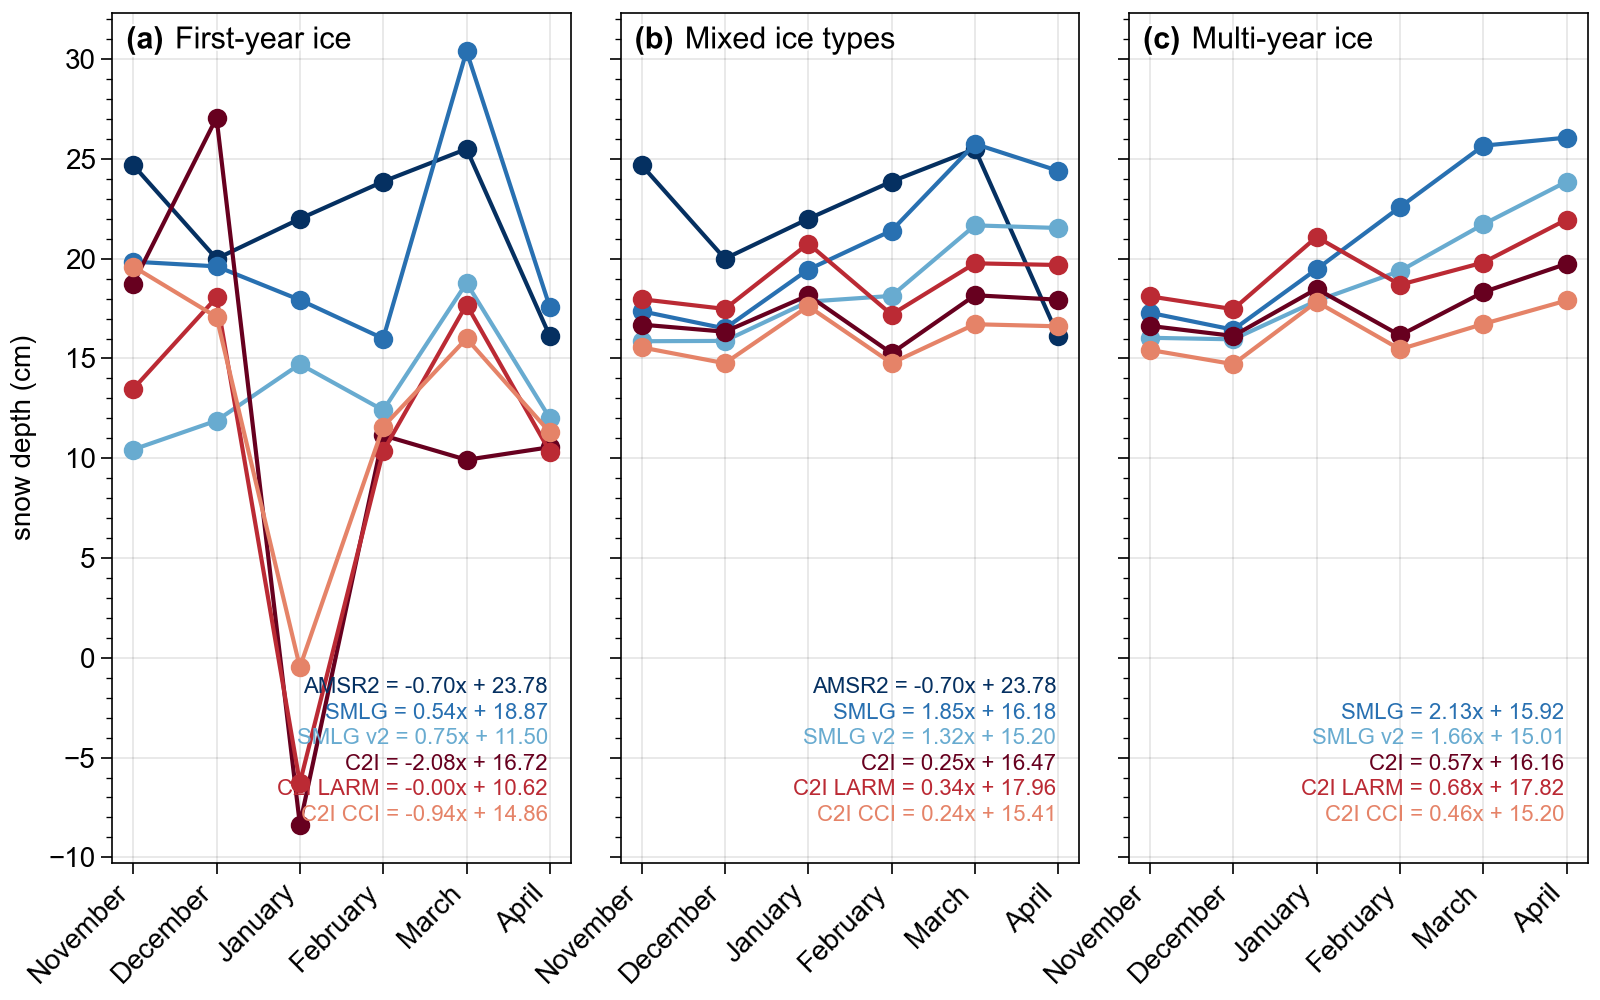

In [264]:
import proplot as pplt
fig = pplt.figure(space=2, figsize=(8,5), span=False, sharex=False, sharey=True)
ax = fig.subplots(nrows=1, ncols=3)
#fig, ax = plt.subplots(2, 3, figsize=(6,4), constrained_layout=True, sharey=True)
colours = cmap_qual
colours = [cmap_qual(0)[0:3],cmap_qual(1)[0:3],cmap_qual(2)[0:3],cmap_qual(4)[0:3],cmap_qual(5)[0:3],cmap_qual(6)[0:3]]
months = ['','November', 'December', 'January', 'February', 'March', 'April','']

df = grid_all[(grid_all['SMLG_snow_depth'].notna())&(grid_all['lowess_snow_depth_original_MSS'].notna()) & (grid_all['lowess_snow_depth_original_MSS_LARM'].notna()) & grid_all['lowess_snow_depth_original_MSS_CCI'].notna()]
df['snow_depth_original_MSS_unit_cm']=df['lowess_snow_depth_original_MSS']*100
df['snow_depth_original_MSS_LARM_unit_cm']=df['lowess_snow_depth_original_MSS_LARM']*100
df['snow_depth_original_MSS_CCI_unit_cm']=df['lowess_snow_depth_original_MSS_CCI']*100
df['SMLG_snow_depth_unit_cm']=df['SMLG_snow_depth']*100
df['SMLG_snow_depth_v2_unit_cm']=df['SMLG_snow_depth_v2']*100
df_AMSR2 = df[df['AMSR2_snow_depth'].notna()]
df_MYI = df[df['AMSR2_snow_depth'].isnull()]

monthly_growth_AMSR2 = compute_monthly_growth(df_AMSR2, 'AMSR2_snow_depth')
monthly_growth_SMLG = compute_monthly_growth(df_AMSR2, 'SMLG_snow_depth_unit_cm')
monthly_growth_SMLG_v2  = compute_monthly_growth(df_AMSR2, 'SMLG_snow_depth_v2_unit_cm')
monthly_growth_C2I = compute_monthly_growth(df_AMSR2, 'snow_depth_original_MSS_unit_cm')
monthly_growth_C2I_LARM  = compute_monthly_growth(df_AMSR2, 'snow_depth_original_MSS_LARM_unit_cm')
monthly_growth_C2I_CCI  = compute_monthly_growth(df_AMSR2, 'snow_depth_original_MSS_CCI_unit_cm')


ax[0].plot(months, monthly_growth_AMSR2, linestyle='-',marker='o', c=colours[5])
ax[0].plot(months, monthly_growth_SMLG, linestyle='-',marker='o', c=colours[4])
ax[0].plot(months, monthly_growth_SMLG_v2, linestyle='-',marker='o', c=colours[3])
ax[0].plot(months, monthly_growth_C2I, linestyle='-',marker='o', c=colours[0])
ax[0].plot(months, monthly_growth_C2I_LARM, linestyle='-',marker='o', c=colours[1])
ax[0].plot(months, monthly_growth_C2I_CCI, linestyle='-',marker='o', c=colours[2])

x,y = np.arange(6), monthly_growth_AMSR2[1:7]
coef = np.polyfit(x,y,1)
ax[0].text(0.95, 0.20, 'AMSR2 = {:.2f}x + {:.2f}'.format(coef[0], coef[1]), c=colours[5], transform = ax[0].transAxes, ha='right', fontsize=8)

x,y = np.arange(6), monthly_growth_SMLG[1:7]
coef = np.polyfit(x,y,1)
ax[0].text(0.95, 0.17, 'SMLG = {:.2f}x + {:.2f}'.format(coef[0], coef[1]), c=colours[4], transform = ax[0].transAxes, ha='right', fontsize=8)

x,y = np.arange(6), monthly_growth_SMLG_v2[1:7]
coef = np.polyfit(x,y,1)
ax[0].text(0.95, 0.14, 'SMLG v2 = {:.2f}x + {:.2f}'.format(coef[0], coef[1]), c=colours[3], transform = ax[0].transAxes, ha='right', fontsize=8)


x,y = np.arange(6), monthly_growth_C2I[1:7]
coef = np.polyfit(x,y,1)
ax[0].text(0.95, 0.11, 'C2I = {:.2f}x + {:.2f}'.format(coef[0], coef[1]), c=colours[0], transform = ax[0].transAxes, ha='right', fontsize=8)

x,y = np.arange(6), monthly_growth_C2I_LARM[1:7]
coef = np.polyfit(x,y,1)
ax[0].text(0.95, 0.08, 'C2I LARM = {:.2f}x + {:.2f}'.format(coef[0], coef[1]),  c=colours[1], transform = ax[0].transAxes, ha='right', fontsize=8)

x,y = np.arange(6), monthly_growth_C2I_CCI[1:7]
coef = np.polyfit(x,y,1)
ax[0].text(0.95, 0.05, 'C2I CCI = {:.2f}x + {:.2f}'.format(coef[0], coef[1]),  c=colours[2], transform = ax[0].transAxes, ha='right', fontsize=8)

ax[0].format(xrotation=45, ylabel='snow depth (cm)', fontsize=10, ultitle='First-year ice')

monthly_growth_AMSR2_exp2 = compute_monthly_growth(df, 'AMSR2_snow_depth')
monthly_growth_SMLG_exp2 = compute_monthly_growth(df, 'SMLG_snow_depth_unit_cm')
monthly_growth_SMLG_v2_exp2  = compute_monthly_growth(df, 'SMLG_snow_depth_v2_unit_cm')
monthly_growth_C2I_exp2  = compute_monthly_growth(df, 'snow_depth_original_MSS_unit_cm')
monthly_growth_C2I_LARM_exp2  = compute_monthly_growth(df, 'snow_depth_original_MSS_LARM_unit_cm')
monthly_growth_C2I_CCI_exp2  = compute_monthly_growth(df, 'snow_depth_original_MSS_CCI_unit_cm')

ax[1].plot(months, monthly_growth_AMSR2_exp2, linestyle='-',marker='o', c=colours[5])
ax[1].plot(months, monthly_growth_SMLG_exp2, linestyle='-',marker='o', c=colours[4])
ax[1].plot(months, monthly_growth_SMLG_v2_exp2, linestyle='-',marker='o', c=colours[3])
ax[1].plot(months, monthly_growth_C2I_exp2, linestyle='-',marker='o', c=colours[0])
ax[1].plot(months, monthly_growth_C2I_LARM_exp2, linestyle='-',marker='o', c=colours[1])
ax[1].plot(months, monthly_growth_C2I_CCI_exp2, linestyle='-',marker='o', c=colours[2])
ax[1].format(xrotation=45, ylabel='snow depth (cm)', fontsize=10)

x,y = np.arange(6), monthly_growth_AMSR2_exp2[1:7]
coef = np.polyfit(x,y,1)
ax[1].text(0.95, 0.20, 'AMSR2 = {:.2f}x + {:.2f}'.format(coef[0], coef[1]), c=colours[5], transform = ax[1].transAxes, ha='right', fontsize=8)


x,y = np.arange(6), monthly_growth_SMLG_exp2[1:7]
coef = np.polyfit(x,y,1)
ax[1].text(0.95, 0.17, 'SMLG = {:.2f}x + {:.2f}'.format(coef[0], coef[1]), c=colours[4], transform = ax[1].transAxes, ha='right', fontsize=8)

x,y = np.arange(6), monthly_growth_SMLG_v2_exp2[1:7]
coef = np.polyfit(x,y,1)
ax[1].text(0.95, 0.14, 'SMLG v2 = {:.2f}x + {:.2f}'.format(coef[0], coef[1]), c=colours[3], transform = ax[1].transAxes, ha='right', fontsize=8)


x,y = np.arange(6), monthly_growth_C2I_exp2[1:7]
coef = np.polyfit(x,y,1)
ax[1].text(0.95, 0.11, 'C2I = {:.2f}x + {:.2f}'.format(coef[0], coef[1]), c=colours[0], transform = ax[1].transAxes, ha='right', fontsize=8)

x,y = np.arange(6), monthly_growth_C2I_LARM_exp2[1:7]
coef = np.polyfit(x,y,1)
ax[1].text(0.95, 0.08, 'C2I LARM = {:.2f}x + {:.2f}'.format(coef[0], coef[1]),  c=colours[1], transform = ax[1].transAxes, ha='right', fontsize=8)

x,y = np.arange(6), monthly_growth_C2I_CCI_exp2[1:7]
coef = np.polyfit(x,y,1)
ax[1].text(0.95, 0.05, 'C2I CCI = {:.2f}x + {:.2f}'.format(coef[0], coef[1]),  c=colours[2], transform = ax[1].transAxes, ha='right', fontsize=8)

ax[1].format(xrotation=45, ylabel='snow depth (cm)', fontsize=10, ultitle='Mixed ice types')

monthly_growth_SMLG_exp3 = compute_monthly_growth(df_MYI, 'SMLG_snow_depth_unit_cm')
monthly_growth_SMLG_v2_exp3  = compute_monthly_growth(df_MYI, 'SMLG_snow_depth_v2_unit_cm')
monthly_growth_C2I_exp3  = compute_monthly_growth(df_MYI, 'snow_depth_original_MSS_unit_cm')
monthly_growth_C2I_LARM_exp3  = compute_monthly_growth(df_MYI, 'snow_depth_original_MSS_LARM_unit_cm')
monthly_growth_C2I_CCI_exp3  = compute_monthly_growth(df_MYI, 'snow_depth_original_MSS_CCI_unit_cm')

ax[2].plot(months, monthly_growth_SMLG_exp3, linestyle='-',marker='o', c=colours[4])
ax[2].plot(months, monthly_growth_SMLG_v2_exp3, linestyle='-',marker='o', c=colours[3])
ax[2].plot(months, monthly_growth_C2I_exp3, linestyle='-',marker='o', c=colours[0])
ax[2].plot(months, monthly_growth_C2I_LARM_exp3, linestyle='-',marker='o', c=colours[1])
ax[2].plot(months, monthly_growth_C2I_CCI_exp3, linestyle='-',marker='o', c=colours[2])
ax[2].format(xrotation=45, ylabel='snow depth (cm)', fontsize=10)


x,y = np.arange(6), monthly_growth_SMLG_exp3[1:7]
coef = np.polyfit(x,y,1)
ax[2].text(0.95, 0.17, 'SMLG = {:.2f}x + {:.2f}'.format(coef[0], coef[1]), c=colours[4], transform = ax[2].transAxes, ha='right', fontsize=8)

x,y = np.arange(6), monthly_growth_SMLG_v2_exp3[1:7]
coef = np.polyfit(x,y,1)
ax[2].text(0.95, 0.14, 'SMLG v2 = {:.2f}x + {:.2f}'.format(coef[0], coef[1]), c=colours[3], transform = ax[2].transAxes, ha='right', fontsize=8)


x,y = np.arange(6), monthly_growth_C2I_exp3[1:7]
coef = np.polyfit(x,y,1)
ax[2].text(0.95, 0.11, 'C2I = {:.2f}x + {:.2f}'.format(coef[0], coef[1]), c=colours[0], transform = ax[2].transAxes, ha='right', fontsize=8)

x,y = np.arange(6), monthly_growth_C2I_LARM_exp3[1:7]
coef = np.polyfit(x,y,1)
ax[2].text(0.95, 0.08, 'C2I LARM = {:.2f}x + {:.2f}'.format(coef[0], coef[1]),  c=colours[1], transform = ax[2].transAxes, ha='right', fontsize=8)

x,y = np.arange(6), monthly_growth_C2I_CCI_exp3[1:7]
coef = np.polyfit(x,y,1)
ax[2].text(0.95, 0.05, 'C2I CCI = {:.2f}x + {:.2f}'.format(coef[0], coef[1]),  c=colours[2], transform = ax[2].transAxes, ha='right', fontsize=8)

ax[2].format(xrotation=45, ylabel='snow depth (cm)', fontsize=10, ultitle='Multi-year ice')



fig.format(abc='(a)', abcloc='ul')

plt.savefig('E:\demo_CRYO2ICE_overall_comp_monthly_growth_gridded_lowess_medip_GreenlandCanada_.png', dpi=300)

In [ ]:
import matplotlib.pyplot as plt
def using_hist2d(ax, x, y, bins=(50, 50), cmap = plt.cm.Blues):
    # https://stackoverflow.com/a/20105673/3015186
    # Answer by askewchan
    im = ax.hist2d(x, y, bins, cmap=cmap, vmin=0, vmax=50)
    
    return im

In [ ]:
import proplot as pplt
fig = pplt.figure(space=2, figsize=(10,6), span=False, sharex=False)
ax = fig.subplots(nrows=3, ncols=5)
#fig, ax = plt.subplots(2, 3, figsize=(6,4), constrained_layout=True, sharey=True)

cmap_density = 'Glacial'
density = (50,50)
df = grid_all[(grid_all['SMLG_snow_depth'].notna())&(grid_all['lowess_snow_depth_original_MSS'].notna()) & (grid_all['lowess_snow_depth_original_MSS_LARM'].notna()) & grid_all['lowess_snow_depth_original_MSS_CCI'].notna()]
df['snow_depth_original_MSS_unit_cm']=df['lowess_snow_depth_original_MSS']*100
df['snow_depth_original_MSS_LARM_unit_cm']=df['lowess_snow_depth_original_MSS_LARM']*100
df['snow_depth_original_MSS_CCI_unit_cm']=df['lowess_snow_depth_original_MSS_CCI']*100
df['SMLG_snow_depth_unit_cm']=df['SMLG_snow_depth']*100
df['SMLG_snow_depth_v2_unit_cm']=df['SMLG_snow_depth_v2']*100
df['SMLG_snow_depth_unit_cm']=df['SMLG_snow_depth']*100
df['SMLG_snow_depth_v2_unit_cm']=df['SMLG_snow_depth_v2']*100
df_AMSR2 = df[df['AMSR2_snow_depth'].notna()]

im=using_hist2d(ax[0,0], df_AMSR2['snow_depth_original_MSS_unit_cm'], df_AMSR2['AMSR2_snow_depth'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[0,0].format(xlabel='', ylabel='AMSR2 snow depth (cm)',  xticklabels=[])

im=using_hist2d(ax[0,1], df_AMSR2['snow_depth_original_MSS_LARM_unit_cm'], df_AMSR2['AMSR2_snow_depth'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[0,1].format(xlabel='', ylabel='AMSR2 snow depth (cm)',  xticklabels=[])

im=using_hist2d(ax[0,2], df_AMSR2['snow_depth_original_MSS_CCI_unit_cm'], df_AMSR2['AMSR2_snow_depth'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[0,2].format(xlabel='', ylabel='AMSR2 snow depth (cm)',  xticklabels=[])

im=using_hist2d(ax[0,3], df_AMSR2['SMLG_snow_depth_v2_unit_cm'], df_AMSR2['AMSR2_snow_depth'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[0,3].format(xlabel='', ylabel='AMSR2 snow depth (cm)')

im=using_hist2d(ax[0,4], df_AMSR2['SMLG_snow_depth_unit_cm'], df_AMSR2['AMSR2_snow_depth'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[0,4].format(xlabel='SMLG snow depth (cm)', ylabel='AMSR2 snow depth (cm)')


im=using_hist2d(ax[1,0], df['snow_depth_original_MSS_unit_cm'], df['SMLG_snow_depth_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[1,0].format(xlabel='', ylabel='SMLG snow depth (cm)')

m=using_hist2d(ax[1,1],df['snow_depth_original_MSS_LARM_unit_cm'], df['SMLG_snow_depth_unit_cm'], bins=density, cmap=cmap_density)
ax[1,1].format(xlabel='', ylabel='SMLG snow depth (cm)')

m=using_hist2d(ax[1,2],df['snow_depth_original_MSS_CCI_unit_cm'], df['SMLG_snow_depth_unit_cm'], bins=density, cmap=cmap_density)
ax[1,2].format(xlabel='', ylabel='SMLG snow depth (cm)')

m=using_hist2d(ax[1,3],df['SMLG_snow_depth_v2_unit_cm'], df['SMLG_snow_depth_unit_cm'], bins=density, cmap=cmap_density)
ax[1,3].format(xlabel='SMLG v2 snow depth (cm)', ylabel='SMLG snow depth (cm)')


##
im=using_hist2d(ax[2,0], df['snow_depth_original_MSS_unit_cm'], df['SMLG_snow_depth_v2_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[2,0].format(xlabel='CRYO2ICE (C2I) snow depth (cm)', ylabel='SMLG v2 snow depth (cm)')

m=using_hist2d(ax[2,1],df['snow_depth_original_MSS_LARM_unit_cm'], df['SMLG_snow_depth_v2_unit_cm'], bins=density, cmap=cmap_density)
ax[2,1].format(xlabel='C2I LARM snow depth (cm)', ylabel='SMLG v2 snow depth (cm)')

m=using_hist2d(ax[2,2],df['snow_depth_original_MSS_CCI_unit_cm'], df['SMLG_snow_depth_v2_unit_cm'], bins=density, cmap=cmap_density)
ax[2,2].format(xlabel='C2I CCI snow depth (cm)', ylabel='SMLG v2 snow depth (cm)')


#ax[1].set_ylabel('differnece in laser and radar freeboard (IS2-CS2) (m)')
#CRYO2ICE_LARM_SMLG_coinident['snow_depth_original_MSS_LARM'].corr(CRYO2ICE_LARM_SMLG_coinident['SMLG_snow_depth'])
#plt.colorbar(im[3], label='density (bins of 80 x80)',ax=ax[1,1])


## ROW 1
bias = np.nanmean(df_AMSR2['snow_depth_original_MSS_unit_cm']-df_AMSR2['AMSR2_snow_depth'])
sd = np.nanstd(df_AMSR2['snow_depth_original_MSS_unit_cm']-df_AMSR2['AMSR2_snow_depth'])
corr = df_AMSR2['snow_depth_original_MSS_unit_cm'].corr(df_AMSR2['AMSR2_snow_depth'])
x,y = df_AMSR2['snow_depth_original_MSS_unit_cm'],df_AMSR2['AMSR2_snow_depth']
coef = np.polyfit(x,y,1)
x_new = np.arange(-50,100,10)
polyval_predict = np.polyval(coef,x_new)
ax[0,0].plot(x_new, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\nbias = {:.2f} cm\nstdev = {:.2f} cm\ncorr = {:.2f}\nslope= {:.2f}\nintercept = {:.2f} cm".format(len(df),bias, sd, corr, coef[0], coef[1])
ax[0,0].text(0.95, 0.5, text_ax, transform=ax[0,0].transAxes, ha='right')


bias = np.nanmean(df_AMSR2['snow_depth_original_MSS_LARM_unit_cm']-df_AMSR2['AMSR2_snow_depth'])
sd = np.nanstd(df_AMSR2['snow_depth_original_MSS_LARM_unit_cm']-df_AMSR2['AMSR2_snow_depth'])
corr = df_AMSR2['snow_depth_original_MSS_LARM_unit_cm'].corr(df_AMSR2['AMSR2_snow_depth'])
x,y = df_AMSR2['snow_depth_original_MSS_LARM_unit_cm'],df_AMSR2['AMSR2_snow_depth']
coef = np.polyfit(x,y,1)
x_new = np.arange(-50,100,10)
polyval_predict = np.polyval(coef,x_new)
ax[0,1].plot(x_new, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\nbias = {:.2f} cm\nstdev = {:.2f} cm\ncorr = {:.2f}\nslope= {:.2f}\nintercept = {:.2f} cm".format(len(df),bias, sd, corr, coef[0], coef[1])
ax[0,1].text(0.95, 0.5, text_ax, transform=ax[0,1].transAxes, ha='right')

bias = np.nanmean(df_AMSR2['snow_depth_original_MSS_CCI_unit_cm']-df_AMSR2['AMSR2_snow_depth'])
sd = np.nanstd(df_AMSR2['snow_depth_original_MSS_CCI_unit_cm']-df_AMSR2['AMSR2_snow_depth'])
corr = df_AMSR2['snow_depth_original_MSS_CCI_unit_cm'].corr(df_AMSR2['AMSR2_snow_depth'])
x,y = df_AMSR2['snow_depth_original_MSS_CCI_unit_cm'],df_AMSR2['AMSR2_snow_depth']
coef = np.polyfit(x,y,1)
x_new = np.arange(-50,100,10)
polyval_predict = np.polyval(coef,x_new)
ax[0,2].plot(x_new, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\nbias = {:.2f} cm\nstdev = {:.2f} cm\ncorr = {:.2f}\nslope= {:.2f}\nintercept = {:.2f} cm".format(len(df),bias, sd, corr, coef[0], coef[1])
ax[0,2].text(0.95, 0.5, text_ax, transform=ax[0,2].transAxes, ha='right')

bias = np.nanmean(df_AMSR2['SMLG_snow_depth_v2_unit_cm']-df_AMSR2['AMSR2_snow_depth'])
sd = np.nanstd(df_AMSR2['SMLG_snow_depth_v2_unit_cm']-df_AMSR2['AMSR2_snow_depth'])
corr = df_AMSR2['SMLG_snow_depth_v2_unit_cm'].corr(df_AMSR2['AMSR2_snow_depth'])
x,y = df_AMSR2['SMLG_snow_depth_v2_unit_cm'],df_AMSR2['AMSR2_snow_depth']
coef = np.polyfit(x,y,1)
x_new = np.arange(-50,100,10)
polyval_predict = np.polyval(coef,x_new)
ax[0,3].plot(x_new, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\nbias = {:.2f} cm\nstdev = {:.2f} cm\ncorr = {:.2f}\nslope= {:.2f}\nintercept = {:.2f} cm".format(len(df),bias, sd, corr, coef[0], coef[1])
ax[0,3].text(0.95, 0.5, text_ax, transform=ax[0,3].transAxes, ha='right')


bias = np.nanmean(df_AMSR2['SMLG_snow_depth_unit_cm']-df_AMSR2['AMSR2_snow_depth'])
sd = np.nanstd(df_AMSR2['SMLG_snow_depth_unit_cm']-df_AMSR2['AMSR2_snow_depth'])
corr = df_AMSR2['SMLG_snow_depth_unit_cm'].corr(df_AMSR2['AMSR2_snow_depth'])
x,y = df_AMSR2['SMLG_snow_depth_unit_cm'],df_AMSR2['AMSR2_snow_depth']
coef = np.polyfit(x,y,1)
x_new = np.arange(-50,100,10)
polyval_predict = np.polyval(coef,x_new)
ax[0,4].plot(x_new, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\nbias = {:.2f} cm\nstdev = {:.2f} cm\ncorr = {:.2f}\nslope= {:.2f}\nintercept = {:.2f} cm".format(len(df),bias, sd, corr, coef[0], coef[1])
ax[0,4].text(0.95, 0.5, text_ax, transform=ax[0,4].transAxes, ha='right')

## ROW 2
bias = np.nanmean(df['snow_depth_original_MSS_unit_cm']-df['SMLG_snow_depth_unit_cm'])
sd = np.nanstd(df['snow_depth_original_MSS_unit_cm']-df['SMLG_snow_depth_unit_cm'])
corr = df['snow_depth_original_MSS_unit_cm'].corr(df['SMLG_snow_depth_unit_cm'])
x,y = df['snow_depth_original_MSS_unit_cm'],df['SMLG_snow_depth_unit_cm']
coef = np.polyfit(x,y,1)
x_new = np.arange(-50,100,10)
polyval_predict = np.polyval(coef,x_new)
ax[1,0].plot(x_new, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\nbias = {:.2f} cm\nstdev = {:.2f} cm\ncorr = {:.2f}\nslope= {:.2f}\nintercept = {:.2f} cm".format(len(df),bias, sd, corr, coef[0], coef[1])
ax[1,0].text(0.95, 0.5, text_ax, transform=ax[1,0].transAxes, ha='right')


bias = np.nanmean(df['snow_depth_original_MSS_LARM_unit_cm']-df['SMLG_snow_depth_unit_cm'])
sd = np.nanstd(df['snow_depth_original_MSS_LARM_unit_cm']-df['SMLG_snow_depth_unit_cm'])
corr = df['snow_depth_original_MSS_LARM_unit_cm'].corr(df['SMLG_snow_depth_unit_cm'])
x,y = df['snow_depth_original_MSS_LARM_unit_cm'],df['SMLG_snow_depth_unit_cm']
coef = np.polyfit(x,y,1)
x_new = np.arange(-50,100,10)
polyval_predict = np.polyval(coef,x_new)
ax[1,1].plot(x_new, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\nbias = {:.2f} cm\nstdev = {:.2f} cm\ncorr = {:.2f}\nslope= {:.2f}\nintercept = {:.2f} cm".format(len(df),bias, sd, corr, coef[0], coef[1])
ax[1,1].text(0.95, 0.5, text_ax, transform=ax[1,1].transAxes, ha='right')

bias = np.nanmean(df['snow_depth_original_MSS_CCI_unit_cm']-df['SMLG_snow_depth_unit_cm'])
sd = np.nanstd(df['snow_depth_original_MSS_CCI_unit_cm']-df['SMLG_snow_depth_unit_cm'])
corr = df['snow_depth_original_MSS_CCI_unit_cm'].corr(df['SMLG_snow_depth_unit_cm'])
x,y = df['snow_depth_original_MSS_CCI_unit_cm'],df['SMLG_snow_depth_unit_cm']
coef = np.polyfit(x,y,1)
x_new = np.arange(-50,100,10)
polyval_predict = np.polyval(coef,x_new)
ax[1,2].plot(x_new, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\nbias = {:.2f} cm\nstdev = {:.2f} cm\ncorr = {:.2f}\nslope= {:.2f}\nintercept = {:.2f} cm".format(len(df),bias, sd, corr, coef[0], coef[1])
ax[1,2].text(0.95, 0.5, text_ax, transform=ax[1,2].transAxes, ha='right')


bias = np.nanmean(df['SMLG_snow_depth_v2_unit_cm']-df['SMLG_snow_depth_unit_cm'])
sd = np.nanstd(df['SMLG_snow_depth_v2_unit_cm']-df['SMLG_snow_depth_unit_cm'])
corr = df['SMLG_snow_depth_v2_unit_cm'].corr(df['SMLG_snow_depth_unit_cm'])
x,y = df['SMLG_snow_depth_v2_unit_cm'],df['SMLG_snow_depth_unit_cm']
coef = np.polyfit(x,y,1)
x_new = np.arange(-50,100,10)
polyval_predict = np.polyval(coef,x_new)
ax[1,3].plot(x_new, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\nbias = {:.2f} cm\nstdev = {:.2f} cm\ncorr = {:.2f}\nslope= {:.2f}\nintercept = {:.2f} cm".format(len(df),bias, sd, corr, coef[0], coef[1])
ax[1,3].text(0.95, 0.5, text_ax, transform=ax[1,3].transAxes, ha='right')

## ROW 3
bias = np.nanmean(df['snow_depth_original_MSS_unit_cm']-df['SMLG_snow_depth_v2_unit_cm'])
sd = np.nanstd(df['snow_depth_original_MSS_unit_cm']-df['SMLG_snow_depth_v2_unit_cm'])
corr = df['snow_depth_original_MSS_unit_cm'].corr(df['SMLG_snow_depth_v2_unit_cm'])
x,y = df['snow_depth_original_MSS_unit_cm'],df['SMLG_snow_depth_v2_unit_cm']
coef = np.polyfit(x,y,1)
x_new = np.arange(-50,100,10)
polyval_predict = np.polyval(coef,x_new)
ax[2,0].plot(x_new, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\nbias = {:.2f} cm\nstdev = {:.2f} cm\ncorr = {:.2f}\nslope= {:.2f}\nintercept = {:.2f} cm".format(len(df),bias, sd, corr, coef[0], coef[1])
ax[2,0].text(0.95, 0.5, text_ax, transform=ax[2,0].transAxes, ha='right')


bias = np.nanmean(df['snow_depth_original_MSS_LARM_unit_cm']-df['SMLG_snow_depth_v2_unit_cm'])
sd = np.nanstd(df['snow_depth_original_MSS_LARM_unit_cm']-df['SMLG_snow_depth_v2_unit_cm'])
corr = df['snow_depth_original_MSS_LARM_unit_cm'].corr(df['SMLG_snow_depth_v2_unit_cm'])
x,y = df['snow_depth_original_MSS_LARM_unit_cm'],df['SMLG_snow_depth_v2_unit_cm']
coef = np.polyfit(x,y,1)
x_new = np.arange(-50,100,10)
polyval_predict = np.polyval(coef,x_new)
ax[2,1].plot(x_new, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\nbias = {:.2f} cm\nstdev = {:.2f} cm\ncorr = {:.2f}\nslope= {:.2f}\nintercept = {:.2f} cm".format(len(df),bias, sd, corr, coef[0], coef[1])
ax[2,1].text(0.95, 0.5, text_ax, transform=ax[2,1].transAxes, ha='right')

bias = np.nanmean(df['snow_depth_original_MSS_CCI_unit_cm']-df['SMLG_snow_depth_v2_unit_cm'])
sd = np.nanstd(df['snow_depth_original_MSS_CCI_unit_cm']-df['SMLG_snow_depth_v2_unit_cm'])
corr = df['snow_depth_original_MSS_CCI_unit_cm'].corr(df['SMLG_snow_depth_v2_unit_cm'])
x,y = df['snow_depth_original_MSS_CCI_unit_cm'],df['SMLG_snow_depth_v2_unit_cm']
coef = np.polyfit(x,y,1)
x_new = np.arange(-50,100,10)
polyval_predict = np.polyval(coef,x_new)
ax[2,2].plot(x_new, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\nbias = {:.2f} cm\nstdev. = {:.2f} cm\ncorr = {:.2f}\nslope= {:.2f}\nintercept = {:.2f} cm".format(len(df),bias, sd, corr, coef[0], coef[1])
ax[2,2].text(0.95, 0.5, text_ax, transform=ax[2,2].transAxes, ha='right')


ax[1, 4].set_visible(False)
ax[2, 4].set_visible(False)
ax[2, 3].set_visible(False)
ax.format(
    abc='(a)', abcloc='ul', xlim=(0, 90), ylim=(0, 90),rc_kw={'abc.weight':'normal'}
)
ax[0,4].colorbar(im[3], label='density (bins of 50 x 50)', loc='r')

ax[0,0].plot(np.arange(-50,100,10),np.arange(-50,100,10), color='grey', alpha=0.3, linestyle='--')
ax[0,1].plot(np.arange(-50,100,10),np.arange(-50,100,10), color='grey', alpha=0.3, linestyle='--')
ax[0,2].plot(np.arange(-50,100,10),np.arange(-50,100,10), color='grey', alpha=0.3, linestyle='--')
ax[0,3].plot(np.arange(-50,100,10),np.arange(-50,100,10), color='grey', alpha=0.3, linestyle='--')
ax[0,4].plot(np.arange(-50,100,10),np.arange(-50,100,10), color='grey', alpha=0.3, linestyle='--')

ax[1,0].plot(np.arange(-50,100,10),np.arange(-50,100,10), color='grey', alpha=0.3, linestyle='--')
ax[1,1].plot(np.arange(-50,100,10),np.arange(-50,100,10), color='grey', alpha=0.3, linestyle='--')
ax[1,2].plot(np.arange(-50,100,10),np.arange(-50,100,10), color='grey', alpha=0.3, linestyle='--')
ax[1,3].plot(np.arange(-50,100,10),np.arange(-50,100,10), color='grey', alpha=0.3, linestyle='--')

ax[2,0].plot(np.arange(-50,100,10),np.arange(-50,100,10), color='grey', alpha=0.3, linestyle='--')
ax[2,1].plot(np.arange(-50,100,10),np.arange(-50,100,10), color='grey', alpha=0.3, linestyle='--')
ax[2,2].plot(np.arange(-50,100,10),np.arange(-50,100,10), color='grey', alpha=0.3, linestyle='--')


legend_elements = [Line2D([0], [0],color='k', label='linear reg.', linestyle='--', linewidth=0.8)]

ax[0,0].legend(handles=legend_elements, loc='lower right', fontsize=6,frameon=False)


plt.savefig('E:\demo_CRYO2ICE_overall_comp_statistics_gridded_data_monthly_medip_marginal_Arctic.png', dpi=300)

In [ ]:
import proplot as pplt
fig = pplt.figure(space=2, figsize=(10,6), span=False, sharex=False)
ax = fig.subplots(nrows=3, ncols=5)
#fig, ax = plt.subplots(2, 3, figsize=(6,4), constrained_layout=True, sharey=True)

def plot_text(df, df_AMSR2, df_MYI, var1, var2, ax_def):
    bias = np.nanmean(df[var1]-df[var2])
    sd = np.nanstd(df[var1]-df[var2])
    corr = df[var1].corr(df[var2])
    x,y = df[var1],df[var2]
    coef = np.polyfit(x,y,1)
    x_new = np.arange(-50,100,10)
    polyval_predict = np.polyval(coef,x_new)
    ax_def.plot(x_new, polyval_predict, 'k', linewidth=0.8, linestyle='--')
    text_2 = "bias (cm) = {:.2f}".format(bias)
    text_3 = "\nstdev (cm) = {:.2f}".format(sd)
    text_4 = "\ncorr = {:.2f}".format(corr)
    text_5 = "\nslope = {:.2f}".format(coef[0])
    text_6 = "\ny (cm) = {:.2f}".format(coef[1])
    text_ax = text_2+text_3+text_4+text_5+text_6

    bias = np.nanmean(df_AMSR2[var1]-df_AMSR2[var2])
    sd = np.nanstd(df_AMSR2[var1]-df_AMSR2[var2])
    corr = df_AMSR2[var1].corr(df_AMSR2[var2])
    x,y = df_AMSR2[var1],df_AMSR2[var2]
    coef = np.polyfit(x,y,1)
    x_new = np.arange(-50,100,10)
    polyval_predict = np.polyval(coef,x_new)
    ax_def.plot(x_new, polyval_predict, 'r', linewidth=0.8, linestyle='dotted')
    text_2 = "{:.2f}".format(bias)
    text_3 = "\n {:.2f}".format(sd)
    text_4 = "\n {:.2f}".format(corr)
    text_5 = "\n {:.2f}".format(coef[0])
    text_6 = "\n {:.2f}".format(coef[1])
    text_ax2 = text_2+text_3+text_4+text_5+text_6

    bias = np.nanmean(df_MYI[var1]-df_MYI[var2])
    sd = np.nanstd(df_MYI[var1]-df_MYI[var2])
    corr = df_MYI[var1].corr(df_MYI[var2])
    x,y = df_MYI[var1],df_MYI[var2]
    coef = np.polyfit(x,y,1)
    x_new = np.arange(-50,100,10)
    polyval_predict = np.polyval(coef,x_new)
    ax_def.plot(x_new, polyval_predict, 'b', linewidth=0.8, linestyle='dashdot')
    text_2 = "{:.2f}".format(bias)
    text_3 = "\n {:.2f}".format(sd)
    text_4 = "\n {:.2f}".format(corr)
    text_5 = "\n {:.2f}".format(coef[0])
    text_6 = "\n {:.2f}".format(coef[1])
    text_ax3 = text_2+text_3+text_4+text_5+text_6
    #text_ax = "N = {}\nbias = {:.2f} cm\nstdev = {:.2f} cm\ncorr = {:.2f}\nslope= {:.2f}\nintercept = {:.2f} cm".format(len(df),bias, sd, corr, coef[0], coef[1])
    ax_def.text(0.55, 0.95, text_ax, transform=ax_def.transAxes, ha='right',fontsize=8, va='top')
    ax_def.text(0.56, 0.95, text_ax2, c=colours[1], transform=ax_def.transAxes, ha='left',fontsize=8, va='top')
    ax_def.text(0.72, 0.95, text_ax3, c=colours[4], transform=ax_def.transAxes, ha='left',fontsize=8, va='top')

df = df_grid_apr
df = df[(df['SMLG_snow_depth'].notna())&(df['lowess_snow_depth_original_MSS'].notna()) & (df['lowess_snow_depth_original_MSS_LARM'].notna()) & df['lowess_snow_depth_original_MSS_CCI'].notna()]
df['snow_depth_original_MSS_unit_cm']=df['lowess_snow_depth_original_MSS']*100
df['snow_depth_original_MSS_LARM_unit_cm']=df['lowess_snow_depth_original_MSS_LARM']*100
df['snow_depth_original_MSS_CCI_unit_cm']=df['lowess_snow_depth_original_MSS_CCI']*100
df['SMLG_snow_depth_unit_cm']=df['SMLG_snow_depth']*100
df['SMLG_snow_depth_v2_unit_cm']=df['SMLG_snow_depth_v2']*100

df_AMSR2 = df[df['AMSR2_snow_depth'].notna()]
df_MYI = df[df['AMSR2_snow_depth'].isnull()]

ax[0,0].scatter(df_AMSR2['snow_depth_original_MSS_unit_cm'], df_AMSR2['AMSR2_snow_depth'],s=0.5,c=colours[1])
ax[0,0].scatter(df_MYI['snow_depth_original_MSS_unit_cm'], df_MYI['AMSR2_snow_depth'],s=.5,c=colours[4])
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[0,0].format(xlabel='', ylabel='AMSR2 snow depth (cm)',  xticklabels=[])

ax[0,1].scatter(df_AMSR2['snow_depth_original_MSS_LARM_unit_cm'], df_AMSR2['AMSR2_snow_depth'],c=colours[1],s=0.5)
ax[0,1].scatter(df_MYI['snow_depth_original_MSS_LARM_unit_cm'], df_MYI['AMSR2_snow_depth'],c=colours[4],s=.5)#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[0,1].format(xlabel='', ylabel='AMSR2 snow depth (cm)',  xticklabels=[])

ax[0,2].scatter(df_AMSR2['snow_depth_original_MSS_CCI_unit_cm'], df_AMSR2['AMSR2_snow_depth'],c=colours[1],s=0.5)
ax[0,2].scatter(df_MYI['snow_depth_original_MSS_CCI_unit_cm'], df_MYI['AMSR2_snow_depth'],c=colours[4],s=.5)#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[0,2].format(xlabel='', ylabel='AMSR2 snow depth (cm)',  xticklabels=[])

ax[0,3].scatter(df_AMSR2['SMLG_snow_depth_v2_unit_cm'], df_AMSR2['AMSR2_snow_depth'],c=colours[1],s=0.5)
ax[0,3].scatter(df_MYI['SMLG_snow_depth_v2_unit_cm'], df_MYI['AMSR2_snow_depth'],c=colours[4],s=.5)#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[0,3].format(xlabel='', ylabel='AMSR2 snow depth (cm)')

ax[0,4].scatter(df_AMSR2['SMLG_snow_depth_unit_cm'], df_AMSR2['AMSR2_snow_depth'],c=colours[1],s=0.5)
ax[0,4].scatter(df_MYI['SMLG_snow_depth_unit_cm'], df_MYI['AMSR2_snow_depth'],c=colours[4],s=.5)#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[0,4].format(xlabel='SMLG snow depth (cm)', ylabel='AMSR2 snow depth (cm)')


ax[1,0].scatter(df_MYI['snow_depth_original_MSS_unit_cm'], df_MYI['SMLG_snow_depth_unit_cm'],s=.5,c=colours[4])
ax[1,0].scatter(df_AMSR2['snow_depth_original_MSS_unit_cm'], df_AMSR2['SMLG_snow_depth_unit_cm'],s=0.5,c=colours[1])
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[1,0].format(xlabel='', ylabel='SMLG snow depth (cm)')

ax[1,1].scatter(df_MYI['snow_depth_original_MSS_LARM_unit_cm'], df_MYI['SMLG_snow_depth_unit_cm'],s=.5,c=colours[4])
ax[1,1].scatter(df_AMSR2['snow_depth_original_MSS_LARM_unit_cm'], df_AMSR2['SMLG_snow_depth_unit_cm'],s=0.5,c=colours[1])
ax[1,1].format(xlabel='', ylabel='SMLG snow depth (cm)')

ax[1,2].scatter(df_MYI['snow_depth_original_MSS_CCI_unit_cm'], df_MYI['SMLG_snow_depth_unit_cm'],s=.5,c=colours[4])
ax[1,2].scatter(df_AMSR2['snow_depth_original_MSS_CCI_unit_cm'], df_AMSR2['SMLG_snow_depth_unit_cm'],s=0.5,c=colours[1])
ax[1,2].format(xlabel='', ylabel='SMLG snow depth (cm)')

ax[1,3].scatter(df_MYI['SMLG_snow_depth_v2_unit_cm'], df_MYI['SMLG_snow_depth_unit_cm'],s=.5,c=colours[4])
ax[1,3].scatter(df_AMSR2['SMLG_snow_depth_v2_unit_cm'], df_AMSR2['SMLG_snow_depth_unit_cm'],s=0.5,c=colours[1])

ax[1,3].format(xlabel='SMLG v2 snow depth (cm)', ylabel='SMLG snow depth (cm)')


##
ax[2,0].scatter(df_MYI['snow_depth_original_MSS_unit_cm'], df_MYI['SMLG_snow_depth_v2_unit_cm'],s=.5,c=colours[4])
ax[2,0].scatter(df_AMSR2['snow_depth_original_MSS_unit_cm'], df_AMSR2['SMLG_snow_depth_v2_unit_cm'],s=0.5,c=colours[1])
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[2,0].format(xlabel='CRYO2ICE (C2I) snow depth (cm)', ylabel='SMLG v2 snow depth (cm)')

ax[2,1].scatter(df_MYI['snow_depth_original_MSS_LARM_unit_cm'], df_MYI['SMLG_snow_depth_v2_unit_cm'],s=.5,c=colours[4])
ax[2,1].scatter(df_AMSR2['snow_depth_original_MSS_LARM_unit_cm'], df_AMSR2['SMLG_snow_depth_v2_unit_cm'],s=0.5,c=colours[1])
ax[2,1].format(xlabel='C2I LARM snow depth (cm)', ylabel='SMLG v2 snow depth (cm)')

ax[2,2].scatter(df_MYI['snow_depth_original_MSS_CCI_unit_cm'], df_MYI['SMLG_snow_depth_v2_unit_cm'],s=.5,c=colours[4])
ax[2,2].scatter(df_AMSR2['snow_depth_original_MSS_CCI_unit_cm'], df_AMSR2['SMLG_snow_depth_v2_unit_cm'],s=0.5,c=colours[1])
ax[2,2].format(xlabel='C2I CCI snow depth (cm)', ylabel='SMLG v2 snow depth (cm)')


#ax[1].set_ylabel('differnece in laser and radar freeboard (IS2-CS2) (m)')
#CRYO2ICE_LARM_SMLG_coinident['snow_depth_original_MSS_LARM'].corr(CRYO2ICE_LARM_SMLG_coinident['SMLG_snow_depth'])
#plt.colorbar(im[3], label='density (bins of 80 x80)',ax=ax[1,1])


## ROW 1
bias = np.nanmean(df_AMSR2['snow_depth_original_MSS_unit_cm']-df_AMSR2['AMSR2_snow_depth'])
sd = np.nanstd(df_AMSR2['snow_depth_original_MSS_unit_cm']-df_AMSR2['AMSR2_snow_depth'])
corr = df_AMSR2['snow_depth_original_MSS_unit_cm'].corr(df_AMSR2['AMSR2_snow_depth'])
x,y = df_AMSR2['snow_depth_original_MSS_unit_cm'],df_AMSR2['AMSR2_snow_depth']
coef = np.polyfit(x,y,1)
x_new = np.arange(-50,100,10)
polyval_predict = np.polyval(coef,x_new)
ax[0,0].plot(x_new, polyval_predict, 'r', linewidth=0.8, linestyle='dotted')
text_ax = "bias (cm) = {:.2f}\nstdev (cm) = {:.2f}\ncorr = {:.2f}\nslope= {:.2f}\ny (cm) = {:.2f}".format(bias, sd, corr, coef[0], coef[1])
ax[0,0].text(0.55, 0.95, text_ax, transform=ax[0,0].transAxes, ha='right',va='top', c=colours[1], fontsize=8)


bias = np.nanmean(df_AMSR2['snow_depth_original_MSS_LARM_unit_cm']-df_AMSR2['AMSR2_snow_depth'])
sd = np.nanstd(df_AMSR2['snow_depth_original_MSS_LARM_unit_cm']-df_AMSR2['AMSR2_snow_depth'])
corr = df_AMSR2['snow_depth_original_MSS_LARM_unit_cm'].corr(df_AMSR2['AMSR2_snow_depth'])
x,y = df_AMSR2['snow_depth_original_MSS_LARM_unit_cm'],df_AMSR2['AMSR2_snow_depth']
coef = np.polyfit(x,y,1)
x_new = np.arange(-50,100,10)
polyval_predict = np.polyval(coef,x_new)
ax[0,1].plot(x_new, polyval_predict, 'r', linewidth=0.8, linestyle='dotted')
text_ax = "bias (cm) = {:.2f}\nstdev (cm) = {:.2f}\ncorr = {:.2f}\nslope= {:.2f}\ny (cm) = {:.2f}".format(bias, sd, corr, coef[0], coef[1])
ax[0,1].text(0.55, 0.95, text_ax, transform=ax[0,1].transAxes, ha='right', va='top',c=colours[1], fontsize=8)

bias = np.nanmean(df_AMSR2['snow_depth_original_MSS_CCI_unit_cm']-df_AMSR2['AMSR2_snow_depth'])
sd = np.nanstd(df_AMSR2['snow_depth_original_MSS_CCI_unit_cm']-df_AMSR2['AMSR2_snow_depth'])
corr = df_AMSR2['snow_depth_original_MSS_CCI_unit_cm'].corr(df_AMSR2['AMSR2_snow_depth'])
x,y = df_AMSR2['snow_depth_original_MSS_CCI_unit_cm'],df_AMSR2['AMSR2_snow_depth']
coef = np.polyfit(x,y,1)
x_new = np.arange(-50,100,10)
polyval_predict = np.polyval(coef,x_new)
ax[0,2].plot(x_new, polyval_predict, 'r', linewidth=0.8, linestyle='dotted')
text_ax = "bias (cm) = {:.2f}\nstdev (cm) = {:.2f}\ncorr = {:.2f}\nslope= {:.2f}\ny (cm) = {:.2f}".format(bias, sd, corr, coef[0], coef[1])
ax[0,2].text(0.55, 0.95,text_ax, transform=ax[0,2].transAxes, ha='right', va='top',c=colours[1], fontsize=8)

bias = np.nanmean(df_AMSR2['SMLG_snow_depth_v2_unit_cm']-df_AMSR2['AMSR2_snow_depth'])
sd = np.nanstd(df_AMSR2['SMLG_snow_depth_v2_unit_cm']-df_AMSR2['AMSR2_snow_depth'])
corr = df_AMSR2['SMLG_snow_depth_v2_unit_cm'].corr(df_AMSR2['AMSR2_snow_depth'])
x,y = df_AMSR2['SMLG_snow_depth_v2_unit_cm'],df_AMSR2['AMSR2_snow_depth']
coef = np.polyfit(x,y,1)
x_new = np.arange(-50,100,10)
polyval_predict = np.polyval(coef,x_new)
ax[0,3].plot(x_new, polyval_predict, 'r', linewidth=0.8, linestyle='dotted')
text_ax = "bias (cm) = {:.2f}\nstdev (cm) = {:.2f}\ncorr = {:.2f}\nslope= {:.2f}\ny (cm) = {:.2f}".format(bias, sd, corr, coef[0], coef[1])
ax[0,3].text(0.55, 0.95, text_ax, transform=ax[0,3].transAxes, ha='right', va='top', c=colours[1], fontsize=8)


bias = np.nanmean(df_AMSR2['SMLG_snow_depth_unit_cm']-df_AMSR2['AMSR2_snow_depth'])
sd = np.nanstd(df_AMSR2['SMLG_snow_depth_unit_cm']-df_AMSR2['AMSR2_snow_depth'])
corr = df_AMSR2['SMLG_snow_depth_unit_cm'].corr(df_AMSR2['AMSR2_snow_depth'])
x,y = df_AMSR2['SMLG_snow_depth_unit_cm'],df_AMSR2['AMSR2_snow_depth']
coef = np.polyfit(x,y,1)
x_new = np.arange(-50,100,10)
polyval_predict = np.polyval(coef,x_new)
ax[0,4].plot(x_new, polyval_predict, 'r', linewidth=0.8, linestyle='dotted')
text_ax = "bias (cm) = {:.2f}\nstdev (cm) = {:.2f}\ncorr = {:.2f}\nslope= {:.2f}\ny (cm) = {:.2f}".format(bias, sd, corr, coef[0], coef[1])
ax[0,4].text(0.55, 0.95,text_ax, transform=ax[0,4].transAxes, ha='right',va='top', c=colours[1], fontsize=8)



## ROW 2
plot_text(df, df_AMSR2, df_MYI, 'snow_depth_original_MSS_unit_cm', 'SMLG_snow_depth_unit_cm', ax[1,0])
plot_text(df, df_AMSR2, df_MYI, 'snow_depth_original_MSS_LARM_unit_cm', 'SMLG_snow_depth_unit_cm', ax[1,1])
plot_text(df, df_AMSR2, df_MYI, 'snow_depth_original_MSS_CCI_unit_cm', 'SMLG_snow_depth_unit_cm', ax[1,2])
plot_text(df, df_AMSR2, df_MYI, 'SMLG_snow_depth_v2_unit_cm', 'SMLG_snow_depth_unit_cm', ax[1,3])

## ROW 3
plot_text(df, df_AMSR2, df_MYI, 'snow_depth_original_MSS_unit_cm', 'SMLG_snow_depth_v2_unit_cm', ax[2,0])
plot_text(df, df_AMSR2, df_MYI, 'snow_depth_original_MSS_LARM_unit_cm', 'SMLG_snow_depth_v2_unit_cm', ax[2,1])
plot_text(df, df_AMSR2, df_MYI, 'snow_depth_original_MSS_CCI_unit_cm', 'SMLG_snow_depth_v2_unit_cm', ax[2,2])


ax[1, 4].set_visible(False)
ax[2, 4].set_visible(False)
ax[2, 3].set_visible(False)
ax.format(
     xlim=(0, 90), ylim=(0, 90),rc_kw={'abc.weight':'normal'}
)
ax[0,0].format( 
    title='(b) Grid 25 km month-wise',titleloc='l'
)
#ax[0,4].colorbar(im[3], label='density (bins of 50 x 50)', loc='r')

ax[0,0].plot(np.arange(-50,100,10),np.arange(-50,100,10), color='grey', alpha=0.3, linestyle='--')
ax[0,1].plot(np.arange(-50,100,10),np.arange(-50,100,10), color='grey', alpha=0.3, linestyle='--')
ax[0,2].plot(np.arange(-50,100,10),np.arange(-50,100,10), color='grey', alpha=0.3, linestyle='--')
ax[0,3].plot(np.arange(-50,100,10),np.arange(-50,100,10), color='grey', alpha=0.3, linestyle='--')
ax[0,4].plot(np.arange(-50,100,10),np.arange(-50,100,10), color='grey', alpha=0.3, linestyle='--')

ax[1,0].plot(np.arange(-50,100,10),np.arange(-50,100,10), color='grey', alpha=0.3, linestyle='--')
ax[1,1].plot(np.arange(-50,100,10),np.arange(-50,100,10), color='grey', alpha=0.3, linestyle='--')
ax[1,2].plot(np.arange(-50,100,10),np.arange(-50,100,10), color='grey', alpha=0.3, linestyle='--')
ax[1,3].plot(np.arange(-50,100,10),np.arange(-50,100,10), color='grey', alpha=0.3, linestyle='--')

ax[2,0].plot(np.arange(-50,100,10),np.arange(-50,100,10), color='grey', alpha=0.3, linestyle='--')
ax[2,1].plot(np.arange(-50,100,10),np.arange(-50,100,10), color='grey', alpha=0.3, linestyle='--')
ax[2,2].plot(np.arange(-50,100,10),np.arange(-50,100,10), color='grey', alpha=0.3, linestyle='--')

'''
legend_elements = [Line2D([0], [0],color='k', label='fit mixed', linestyle='--', linewidth=0.8),
                  Line2D([0], [0],color='r', label='fit FYI', linestyle='dotted', linewidth=0.8),
                  Line2D([0], [0],color='b', label='fit MYI', linestyle='dashdot', linewidth=0.8)]

ax[1,3].legend(handles=legend_elements, loc='lower right', fontsize=4,frameon=False, ncol=1)

legend_elements = [Line2D([0], [0],color=colours[1], label='FYI', linestyle='',marker='.', linewidth=0.8),
                  Line2D([0], [0],color=colours[4], label='MYI', linestyle='',marker='.',linewidth=0.8)]

ax[0,4].legend(handles=legend_elements, loc='lower right', fontsize=6,frameon=False, ncol=1)
'''

plt.savefig('E:\demo_CRYO2ICE_overall_comp_statistics_gridded_monthly_MYI_FYI_sep_lowess_medip_apr.png', dpi=300)

In [ ]:
import proplot as pplt
fig = pplt.figure(space=2, figsize=(8,10), span=False, sharex=False, sharey=True)
ax = fig.subplots(nrows=5, ncols=4)
#fig, ax = plt.subplots(2, 3, figsize=(6,4), constrained_layout=True, sharey=True)

cmap_density = 'Glacial'
density = (50,50)

df = grid_all[(grid_all['SMLG_snow_depth'].notna())&(grid_all['snow_depth_original_MSS'].notna()) & (grid_all['snow_depth_original_MSS_LARM'].notna()) & grid_all['snow_depth_original_MSS_CCI'].notna()]
#df = grid_all[(grid_all['SMLG_snow_depth'].notna())&(grid_all['snow_depth_original_MSS'].notna()) & (grid_all['snow_depth_original_MSS_LARM'].notna()) & grid_all['snow_depth_original_MSS_CCI'].notna()]
df['snow_depth_original_MSS_unit_cm']=df['snow_depth_original_MSS']*100
df['snow_depth_original_MSS_LARM_unit_cm']=df['snow_depth_original_MSS_LARM']*100
df['snow_depth_original_MSS_CCI_unit_cm']=df['snow_depth_original_MSS_CCI']*100
df['SMLG_snow_depth_unit_cm']=df['SMLG_snow_depth']*100
df['SMLG_snow_depth_v2_unit_cm']=df['SMLG_snow_depth_v2']*100
df_AMSR2 = df[df['AMSR2_snow_depth'].notna()]

## 1 ROW - PLOTTING
im=using_hist2d(ax[0,0], df['ppk'], df['snow_depth_original_MSS_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[0,0].format(xlabel='', ylabel='CRYO2ICE (C2I) snow depth (cm)',  xticklabels=[])

im=using_hist2d(ax[0,1], df['ssd'], df['snow_depth_original_MSS_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[0,1].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[0,2], df['LARM_roughness'], df['snow_depth_original_MSS_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[0,2].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[0,3], df['IS2_mean_gw'], df['snow_depth_original_MSS_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[0,3].format(xlabel='', ylabel='',  xticklabels=[])

# ROW 2- PLOTTING
im=using_hist2d(ax[1,0], df['ppk'], df['snow_depth_original_MSS_LARM_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[1,0].format(xlabel='', ylabel='C2I LARM snow depth (cm)',  xticklabels=[])

im=using_hist2d(ax[1,1], df['ssd'], df['snow_depth_original_MSS_LARM_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[1,1].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[1,2], df['LARM_roughness'], df['snow_depth_original_MSS_LARM_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[1,2].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[1,3], df['IS2_mean_gw'], df['snow_depth_original_MSS_LARM_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[1,3].format(xlabel='', ylabel='',  xticklabels=[])

### ROW 3 - PLOTTING
im=using_hist2d(ax[2,0], df['ppk'], df['snow_depth_original_MSS_CCI_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[2,0].format(xlabel='', ylabel='C2I CCI snow depth (cm)',  xticklabels=[])

im=using_hist2d(ax[2,1], df['ssd'], df['snow_depth_original_MSS_CCI_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[2,1].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[2,2], df['LARM_roughness'], df['snow_depth_original_MSS_CCI_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[2,2].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[2,3], df['IS2_mean_gw'], df['snow_depth_original_MSS_CCI_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[2,3].format(xlabel='', ylabel='',  xticklabels=[])

### ROW 4 - PLOTTING
im=using_hist2d(ax[3,0], df['ppk'], df['SMLG_snow_depth_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[3,0].format(xlabel='', ylabel='SMLG snow depth (cm)',  xticklabels=[])

im=using_hist2d(ax[3,1], df['ssd'], df['SMLG_snow_depth_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[3,1].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[3,2], df['LARM_roughness'], df['SMLG_snow_depth_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[3,2].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[3,3], df['IS2_mean_gw'], df['SMLG_snow_depth_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[3,3].format(xlabel='', ylabel='',  xticklabels=[])

### ROW 5 - PLOTTING
im=using_hist2d(ax[4,0], df['ppk'], df['SMLG_snow_depth_v2_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[4,0].format(xlabel='pulse peakiness', ylabel='SMLG v2 snow depth (cm)')

im=using_hist2d(ax[4,1], df['ssd'], df['SMLG_snow_depth_v2_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[4,1].format(xlabel='stack standard deviation', ylabel='')

im=using_hist2d(ax[4,2], df['LARM_roughness'], df['SMLG_snow_depth_v2_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[4,2].format(xlabel='lognormal roughness (m)', ylabel='')

im=using_hist2d(ax[4,3], df['IS2_mean_gw'], df['SMLG_snow_depth_v2_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[4,3].format(xlabel='IS2 gaussian width (m)', ylabel='')

## GENERAL FORMATTING
ax[0,3].colorbar(im[3], label='density (bins of 50 x 50)', loc='r')

ax.format(
    abc='(a)', abcloc='ul',rc_kw={'abc.weight':'normal'},ylim=(0,90)
)



## ROW 1 - TEXT
corr = df['snow_depth_original_MSS_unit_cm'].corr(df['ppk'])
y,x = df['snow_depth_original_MSS_unit_cm'],df['ppk']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,20,2)
polyval_predict = np.polyval(coef,x_ppk)
ax[0,0].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[0,0].text(0.95, 0.65, text_ax, transform=ax[0,0].transAxes, ha='right')

corr = df['snow_depth_original_MSS_unit_cm'].corr(df['ssd'])
y,x = df['snow_depth_original_MSS_unit_cm'],df['ssd']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,100,5)
polyval_predict = np.polyval(coef,x_ppk)
ax[0,1].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[0,1].text(0.95, 0.65, text_ax, transform=ax[0,1].transAxes, ha='right')

corr = df['snow_depth_original_MSS_unit_cm'].corr(df['LARM_roughness'])
y,x = df['snow_depth_original_MSS_unit_cm'],df['LARM_roughness']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[0,2].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[0,2].text(0.95, 0.65, text_ax, transform=ax[0,2].transAxes, ha='right')

corr = df['snow_depth_original_MSS_unit_cm'].corr(df['IS2_mean_gw'])
y,x = df['snow_depth_original_MSS_unit_cm'],df['IS2_mean_gw']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[0,3].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[0,3].text(0.95, 0.65, text_ax, transform=ax[0,3].transAxes, ha='right')

## ROW 2 - TEXT
corr = df['snow_depth_original_MSS_LARM_unit_cm'].corr(df['ppk'])
y,x = df['snow_depth_original_MSS_LARM_unit_cm'],df['ppk']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,20,2)
polyval_predict = np.polyval(coef,x_ppk)
ax[1,0].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[1,0].text(0.95, 0.65, text_ax, transform=ax[1,0].transAxes, ha='right')

corr = df['snow_depth_original_MSS_LARM_unit_cm'].corr(df['ssd'])
y,x = df['snow_depth_original_MSS_LARM_unit_cm'],df['ssd']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,100,5)
polyval_predict = np.polyval(coef,x_ppk)
ax[1,1].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[1,1].text(0.95, 0.65, text_ax, transform=ax[1,1].transAxes, ha='right')

corr = df['snow_depth_original_MSS_LARM_unit_cm'].corr(df['LARM_roughness'])
y,x = df['snow_depth_original_MSS_LARM_unit_cm'],df['LARM_roughness']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[1,2].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[1,2].text(0.95, 0.65, text_ax, transform=ax[1,2].transAxes, ha='right')

corr = df['snow_depth_original_MSS_LARM_unit_cm'].corr(df['IS2_mean_gw'])
y,x = df['snow_depth_original_MSS_LARM_unit_cm'],df['IS2_mean_gw']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[1,3].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[1,3].text(0.95, 0.65, text_ax, transform=ax[1,3].transAxes, ha='right')

## ROW 3 - TEXT
corr = df['snow_depth_original_MSS_CCI_unit_cm'].corr(df['ppk'])
y,x = df['snow_depth_original_MSS_CCI_unit_cm'],df['ppk']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,20,2)
polyval_predict = np.polyval(coef,x_ppk)
ax[2,0].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[2,0].text(0.95, 0.65, text_ax, transform=ax[2,0].transAxes, ha='right')

corr = df['snow_depth_original_MSS_CCI_unit_cm'].corr(df['ssd'])
y,x = df['snow_depth_original_MSS_CCI_unit_cm'],df['ssd']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,100,5)
polyval_predict = np.polyval(coef,x_ppk)
ax[2,1].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[2,1].text(0.95, 0.65, text_ax, transform=ax[2,1].transAxes, ha='right')

corr = df['snow_depth_original_MSS_CCI_unit_cm'].corr(df['LARM_roughness'])
y,x = df['snow_depth_original_MSS_CCI_unit_cm'],df['LARM_roughness']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[2,2].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[2,2].text(0.95, 0.65, text_ax, transform=ax[2,2].transAxes, ha='right')

corr = df['snow_depth_original_MSS_CCI_unit_cm'].corr(df['IS2_mean_gw'])
y,x = df['snow_depth_original_MSS_CCI_unit_cm'],df['IS2_mean_gw']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[2,3].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[2,3].text(0.95, 0.65, text_ax, transform=ax[2,3].transAxes, ha='right')

## ROW 4 - TEXT
corr = df['SMLG_snow_depth_unit_cm'].corr(df['ppk'])
y,x = df['SMLG_snow_depth_unit_cm'],df['ppk']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,20,2)
polyval_predict = np.polyval(coef,x_ppk)
ax[3,0].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[3,0].text(0.95, 0.65, text_ax, transform=ax[3,0].transAxes, ha='right')

corr = df['SMLG_snow_depth_unit_cm'].corr(df['ssd'])
y,x = df['SMLG_snow_depth_unit_cm'],df['ssd']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,100,5)
polyval_predict = np.polyval(coef,x_ppk)
ax[3,1].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[3,1].text(0.95, 0.65, text_ax, transform=ax[3,1].transAxes, ha='right')

corr = df['SMLG_snow_depth_unit_cm'].corr(df['LARM_roughness'])
y,x = df['SMLG_snow_depth_unit_cm'],df['LARM_roughness']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[3,2].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[3,2].text(0.95, 0.65, text_ax, transform=ax[3,2].transAxes, ha='right')

corr = df['SMLG_snow_depth_unit_cm'].corr(df['IS2_mean_gw'])
y,x = df['SMLG_snow_depth_unit_cm'],df['IS2_mean_gw']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[3,3].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[3,3].text(0.95, 0.65, text_ax, transform=ax[3,3].transAxes, ha='right')

# EXTRA LEGEND ITEMS
legend_elements = [Line2D([0], [0],color='k', label='linear reg.', linestyle='--', linewidth=0.8)]
ax[0,3].legend(handles=legend_elements, loc='lower right', fontsize=6,frameon=False)

## ROW 5 - TEXT
corr = df['SMLG_snow_depth_v2_unit_cm'].corr(df['ppk'])
y,x = df['SMLG_snow_depth_v2_unit_cm'],df['ppk']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,20,2)
polyval_predict = np.polyval(coef,x_ppk)
ax[4,0].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[4,0].text(0.95, 0.65, text_ax, transform=ax[4,0].transAxes, ha='right')

corr = df['SMLG_snow_depth_v2_unit_cm'].corr(df['ssd'])
y,x = df['SMLG_snow_depth_v2_unit_cm'],df['ssd']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,100,5)
polyval_predict = np.polyval(coef,x_ppk)
ax[4,1].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[4,1].text(0.95, 0.65, text_ax, transform=ax[4,1].transAxes, ha='right')

corr = df['SMLG_snow_depth_v2_unit_cm'].corr(df['LARM_roughness'])
y,x = df['SMLG_snow_depth_v2_unit_cm'],df['LARM_roughness']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[4,2].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[4,2].text(0.95, 0.65, text_ax, transform=ax[4,2].transAxes, ha='right')

corr = df['SMLG_snow_depth_v2_unit_cm'].corr(df['IS2_mean_gw'])
y,x = df['SMLG_snow_depth_v2_unit_cm'],df['IS2_mean_gw']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[4,3].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[4,3].text(0.95, 0.65, text_ax, transform=ax[4,3].transAxes, ha='right')

# EXTRA LEGEND ITEMS
legend_elements = [Line2D([0], [0],color='k', label='linear reg.', linestyle='--', linewidth=0.8)]
ax[0,3].legend(handles=legend_elements, loc='lower right', fontsize=6,frameon=False)


plt.savefig('E:\demo_CRYO2ICE_overall_comp_statistics_rougness_proxies_snow_depth_gridded.png', dpi=300)

In [ ]:
import proplot as pplt
fig = pplt.figure(space=2, figsize=(8,10), span=False, sharex=False, sharey=True)
ax = fig.subplots(nrows=5,ncols=4)
#fig, ax = plt.subplots(2, 3, figsize=(6,4), constrained_layout=True, sharey=True)

cmap_density = 'Glacial'
density = (25,25)

df = grid_all[(grid_all['SMLG_snow_depth'].notna())&(grid_all['snow_depth_original_MSS'].notna()) & (grid_all['snow_depth_original_MSS_LARM'].notna()) & grid_all['snow_depth_original_MSS_CCI'].notna()]
#df = grid_all[(grid_all['SMLG_snow_depth'].notna())&(grid_all['snow_depth_original_MSS'].notna()) & (grid_all['snow_depth_original_MSS_LARM'].notna()) & grid_all['snow_depth_original_MSS_CCI'].notna()]
df['snow_depth_original_MSS_unit_cm']=df['snow_depth_original_MSS']*100
df['snow_depth_original_MSS_LARM_unit_cm']=df['snow_depth_original_MSS_LARM']*100
df['snow_depth_original_MSS_CCI_unit_cm']=df['snow_depth_original_MSS_CCI']*100
df['SMLG_snow_depth_unit_cm']=df['SMLG_snow_depth']*100
df['SMLG_snow_depth_v2_unit_cm']=df['SMLG_snow_depth_v2']*100
df_AMSR2 = df[df['AMSR2_snow_depth'].notna()]

df = df[df['month']=='November']

## 1 ROW - PLOTTING
im=using_hist2d(ax[0,0], df['ppk'], df['snow_depth_original_MSS_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[0,0].format(xlabel='', ylabel='CRYO2ICE (C2I) snow depth (cm)',  xticklabels=[])

im=using_hist2d(ax[0,1], df['ssd'], df['snow_depth_original_MSS_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[0,1].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[0,2], df['LARM_roughness'], df['snow_depth_original_MSS_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[0,2].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[0,3], df['IS2_mean_gw'], df['snow_depth_original_MSS_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[0,3].format(xlabel='', ylabel='',  xticklabels=[])

# ROW 2- PLOTTING
im=using_hist2d(ax[1,0], df['ppk'], df['snow_depth_original_MSS_LARM_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[1,0].format(xlabel='', ylabel='C2I LARM snow depth (cm)',  xticklabels=[])

im=using_hist2d(ax[1,1], df['ssd'], df['snow_depth_original_MSS_LARM_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[1,1].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[1,2], df['LARM_roughness'], df['snow_depth_original_MSS_LARM_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[1,2].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[1,3], df['IS2_mean_gw'], df['snow_depth_original_MSS_LARM_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[1,3].format(xlabel='', ylabel='',  xticklabels=[])

### ROW 3 - PLOTTING
im=using_hist2d(ax[2,0], df['ppk'], df['snow_depth_original_MSS_CCI_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[2,0].format(xlabel='', ylabel='C2I CCI snow depth (cm)',  xticklabels=[])

im=using_hist2d(ax[2,1], df['ssd'], df['snow_depth_original_MSS_CCI_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[2,1].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[2,2], df['LARM_roughness'], df['snow_depth_original_MSS_CCI_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[2,2].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[2,3], df['IS2_mean_gw'], df['snow_depth_original_MSS_CCI_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[2,3].format(xlabel=')', ylabel='',  xticklabels=[])

### ROW 4 - PLOTTING
im=using_hist2d(ax[3,0], df['ppk'], df['SMLG_snow_depth_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[3,0].format(xlabel='', ylabel='SMLG snow depth (cm)',  xticklabels=[])

im=using_hist2d(ax[3,1], df['ssd'], df['SMLG_snow_depth_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[3,1].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[3,2], df['LARM_roughness'], df['SMLG_snow_depth_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[3,2].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[3,3], df['IS2_mean_gw'], df['SMLG_snow_depth_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[3,3].format(xlabel='', ylabel='',  xticklabels=[])

### ROW 5 - PLOTTING
im=using_hist2d(ax[4,0], df['ppk'], df['SMLG_snow_depth_v2_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[4,0].format(xlabel='pulse peakiness', ylabel='SMLG v2 snow depth (cm)')

im=using_hist2d(ax[4,1], df['ssd'], df['SMLG_snow_depth_v2_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[4,1].format(xlabel='stack standard deviation', ylabel='')

im=using_hist2d(ax[4,2], df['LARM_roughness'], df['SMLG_snow_depth_v2_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[4,2].format(xlabel='lognormal roughness (m)', ylabel='')

im=using_hist2d(ax[4,3], df['IS2_mean_gw'], df['SMLG_snow_depth_v2_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[4,3].format(xlabel='IS2 gaussian width (m)', ylabel='')

## GENERAL FORMATTING
ax[0,3].colorbar(im[3], label='density (bins of 50 x 50)', loc='r')

ax.format(
    abc='(a)', abcloc='ul',rc_kw={'abc.weight':'normal'},ylim=(0,90)
)



## ROW 1 - TEXT
corr = df['snow_depth_original_MSS_unit_cm'].corr(df['ppk'])
y,x = df['snow_depth_original_MSS_unit_cm'],df['ppk']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,20,2)
polyval_predict = np.polyval(coef,x_ppk)
ax[0,0].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[0,0].text(0.95, 0.65, text_ax, transform=ax[0,0].transAxes, ha='right')

corr = df['snow_depth_original_MSS_unit_cm'].corr(df['ssd'])
y,x = df['snow_depth_original_MSS_unit_cm'],df['ssd']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,100,5)
polyval_predict = np.polyval(coef,x_ppk)
ax[0,1].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[0,1].text(0.95, 0.65, text_ax, transform=ax[0,1].transAxes, ha='right')

corr = df['snow_depth_original_MSS_unit_cm'].corr(df['LARM_roughness'])
y,x = df['snow_depth_original_MSS_unit_cm'],df['LARM_roughness']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[0,2].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[0,2].text(0.95, 0.65, text_ax, transform=ax[0,2].transAxes, ha='right')

corr = df['snow_depth_original_MSS_unit_cm'].corr(df['IS2_mean_gw'])
y,x = df['snow_depth_original_MSS_unit_cm'],df['IS2_mean_gw']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[0,3].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[0,3].text(0.95, 0.65, text_ax, transform=ax[0,3].transAxes, ha='right')

## ROW 2 - TEXT
corr = df['snow_depth_original_MSS_LARM_unit_cm'].corr(df['ppk'])
y,x = df['snow_depth_original_MSS_LARM_unit_cm'],df['ppk']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,20,2)
polyval_predict = np.polyval(coef,x_ppk)
ax[1,0].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[1,0].text(0.95, 0.65, text_ax, transform=ax[1,0].transAxes, ha='right')

corr = df['snow_depth_original_MSS_LARM_unit_cm'].corr(df['ssd'])
y,x = df['snow_depth_original_MSS_LARM_unit_cm'],df['ssd']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,100,5)
polyval_predict = np.polyval(coef,x_ppk)
ax[1,1].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[1,1].text(0.95, 0.65, text_ax, transform=ax[1,1].transAxes, ha='right')

corr = df['snow_depth_original_MSS_LARM_unit_cm'].corr(df['LARM_roughness'])
y,x = df['snow_depth_original_MSS_LARM_unit_cm'],df['LARM_roughness']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[1,2].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[1,2].text(0.95, 0.65, text_ax, transform=ax[1,2].transAxes, ha='right')

corr = df['snow_depth_original_MSS_LARM_unit_cm'].corr(df['IS2_mean_gw'])
y,x = df['snow_depth_original_MSS_LARM_unit_cm'],df['IS2_mean_gw']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[1,3].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[1,3].text(0.95, 0.65, text_ax, transform=ax[1,3].transAxes, ha='right')

## ROW 3 - TEXT
corr = df['snow_depth_original_MSS_CCI_unit_cm'].corr(df['ppk'])
y,x = df['snow_depth_original_MSS_CCI_unit_cm'],df['ppk']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,20,2)
polyval_predict = np.polyval(coef,x_ppk)
ax[2,0].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[2,0].text(0.95, 0.65, text_ax, transform=ax[2,0].transAxes, ha='right')

corr = df['snow_depth_original_MSS_CCI_unit_cm'].corr(df['ssd'])
y,x = df['snow_depth_original_MSS_CCI_unit_cm'],df['ssd']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,100,5)
polyval_predict = np.polyval(coef,x_ppk)
ax[2,1].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[2,1].text(0.95, 0.65, text_ax, transform=ax[2,1].transAxes, ha='right')

corr = df['snow_depth_original_MSS_CCI_unit_cm'].corr(df['LARM_roughness'])
y,x = df['snow_depth_original_MSS_CCI_unit_cm'],df['LARM_roughness']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[2,2].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[2,2].text(0.95, 0.65, text_ax, transform=ax[2,2].transAxes, ha='right')

corr = df['snow_depth_original_MSS_CCI_unit_cm'].corr(df['IS2_mean_gw'])
y,x = df['snow_depth_original_MSS_CCI_unit_cm'],df['IS2_mean_gw']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[2,3].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[2,3].text(0.95, 0.65, text_ax, transform=ax[2,3].transAxes, ha='right')

## ROW 4 - TEXT
corr = df['SMLG_snow_depth_unit_cm'].corr(df['ppk'])
y,x = df['SMLG_snow_depth_unit_cm'],df['ppk']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,20,2)
polyval_predict = np.polyval(coef,x_ppk)
ax[3,0].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[3,0].text(0.95, 0.65, text_ax, transform=ax[3,0].transAxes, ha='right')

corr = df['SMLG_snow_depth_unit_cm'].corr(df['ssd'])
y,x = df['SMLG_snow_depth_unit_cm'],df['ssd']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,100,5)
polyval_predict = np.polyval(coef,x_ppk)
ax[3,1].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[3,1].text(0.95, 0.65, text_ax, transform=ax[3,1].transAxes, ha='right')

corr = df['SMLG_snow_depth_unit_cm'].corr(df['LARM_roughness'])
y,x = df['SMLG_snow_depth_unit_cm'],df['LARM_roughness']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[3,2].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[3,2].text(0.95, 0.65, text_ax, transform=ax[3,2].transAxes, ha='right')

corr = df['SMLG_snow_depth_unit_cm'].corr(df['IS2_mean_gw'])
y,x = df['SMLG_snow_depth_unit_cm'],df['IS2_mean_gw']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[3,3].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[3,3].text(0.95, 0.65, text_ax, transform=ax[3,3].transAxes, ha='right')

# EXTRA LEGEND ITEMS
legend_elements = [Line2D([0], [0],color='k', label='linear reg.', linestyle='--', linewidth=0.8)]
ax[0,3].legend(handles=legend_elements, loc='lower right', fontsize=6,frameon=False)

## ROW 5 - TEXT
corr = df['SMLG_snow_depth_v2_unit_cm'].corr(df['ppk'])
y,x = df['SMLG_snow_depth_v2_unit_cm'],df['ppk']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,20,2)
polyval_predict = np.polyval(coef,x_ppk)
ax[4,0].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[4,0].text(0.95, 0.65, text_ax, transform=ax[4,0].transAxes, ha='right')

corr = df['SMLG_snow_depth_v2_unit_cm'].corr(df['ssd'])
y,x = df['SMLG_snow_depth_v2_unit_cm'],df['ssd']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,100,5)
polyval_predict = np.polyval(coef,x_ppk)
ax[4,1].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[4,1].text(0.95, 0.65, text_ax, transform=ax[4,1].transAxes, ha='right')

corr = df['SMLG_snow_depth_v2_unit_cm'].corr(df['LARM_roughness'])
y,x = df['SMLG_snow_depth_v2_unit_cm'],df['LARM_roughness']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[4,2].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[4,2].text(0.95, 0.65, text_ax, transform=ax[4,2].transAxes, ha='right')

corr = df['SMLG_snow_depth_v2_unit_cm'].corr(df['IS2_mean_gw'])
y,x = df['SMLG_snow_depth_v2_unit_cm'],df['IS2_mean_gw']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[4,3].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[4,3].text(0.95, 0.65, text_ax, transform=ax[4,3].transAxes, ha='right')

# EXTRA LEGEND ITEMS
legend_elements = [Line2D([0], [0],color='k', label='linear reg.', linestyle='--', linewidth=0.8)]
ax[0,3].legend(handles=legend_elements, loc='lower right', fontsize=6,frameon=False)


plt.suptitle('November',x=0.1, y=.95, horizontalalignment='left', verticalalignment='top')
#plt.savefig('E:\demo_CRYO2ICE_barplot_combined.png', transparent=True)

plt.savefig('E:\demo_CRYO2ICE_overall_comp_statistics_rougness_proxies_snow_depth_gridded_november.png', dpi=300)


In [ ]:
import proplot as pplt
fig = pplt.figure(space=2, figsize=(8,10), span=False, sharex=False, sharey=True)
ax = fig.subplots(nrows=5,ncols=4)
#fig, ax = plt.subplots(2, 3, figsize=(6,4), constrained_layout=True, sharey=True)

cmap_density = 'Glacial'
density = (25,25)

df = grid_all[(grid_all['SMLG_snow_depth'].notna())&(grid_all['snow_depth_original_MSS'].notna()) & (grid_all['snow_depth_original_MSS_LARM'].notna()) & grid_all['snow_depth_original_MSS_CCI'].notna()]
#df = grid_all[(grid_all['SMLG_snow_depth'].notna())&(grid_all['snow_depth_original_MSS'].notna()) & (grid_all['snow_depth_original_MSS_LARM'].notna()) & grid_all['snow_depth_original_MSS_CCI'].notna()]
df['snow_depth_original_MSS_unit_cm']=df['snow_depth_original_MSS']*100
df['snow_depth_original_MSS_LARM_unit_cm']=df['snow_depth_original_MSS_LARM']*100
df['snow_depth_original_MSS_CCI_unit_cm']=df['snow_depth_original_MSS_CCI']*100
df['SMLG_snow_depth_unit_cm']=df['SMLG_snow_depth']*100
df['SMLG_snow_depth_v2_unit_cm']=df['SMLG_snow_depth_v2']*100
df_AMSR2 = df[df['AMSR2_snow_depth'].notna()]

df = df[df['month']=='December']

## 1 ROW - PLOTTING
im=using_hist2d(ax[0,0], df['ppk'], df['snow_depth_original_MSS_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[0,0].format(xlabel='', ylabel='CRYO2ICE (C2I) snow depth (cm)',  xticklabels=[])

im=using_hist2d(ax[0,1], df['ssd'], df['snow_depth_original_MSS_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[0,1].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[0,2], df['LARM_roughness'], df['snow_depth_original_MSS_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[0,2].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[0,3], df['IS2_mean_gw'], df['snow_depth_original_MSS_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[0,3].format(xlabel='', ylabel='',  xticklabels=[])

# ROW 2- PLOTTING
im=using_hist2d(ax[1,0], df['ppk'], df['snow_depth_original_MSS_LARM_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[1,0].format(xlabel='', ylabel='C2I LARM snow depth (cm)',  xticklabels=[])

im=using_hist2d(ax[1,1], df['ssd'], df['snow_depth_original_MSS_LARM_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[1,1].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[1,2], df['LARM_roughness'], df['snow_depth_original_MSS_LARM_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[1,2].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[1,3], df['IS2_mean_gw'], df['snow_depth_original_MSS_LARM_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[1,3].format(xlabel='', ylabel='',  xticklabels=[])

### ROW 3 - PLOTTING
im=using_hist2d(ax[2,0], df['ppk'], df['snow_depth_original_MSS_CCI_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[2,0].format(xlabel='', ylabel='C2I CCI snow depth (cm)',  xticklabels=[])

im=using_hist2d(ax[2,1], df['ssd'], df['snow_depth_original_MSS_CCI_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[2,1].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[2,2], df['LARM_roughness'], df['snow_depth_original_MSS_CCI_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[2,2].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[2,3], df['IS2_mean_gw'], df['snow_depth_original_MSS_CCI_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[2,3].format(xlabel=')', ylabel='',  xticklabels=[])

### ROW 4 - PLOTTING
im=using_hist2d(ax[3,0], df['ppk'], df['SMLG_snow_depth_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[3,0].format(xlabel='', ylabel='SMLG snow depth (cm)',  xticklabels=[])

im=using_hist2d(ax[3,1], df['ssd'], df['SMLG_snow_depth_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[3,1].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[3,2], df['LARM_roughness'], df['SMLG_snow_depth_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[3,2].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[3,3], df['IS2_mean_gw'], df['SMLG_snow_depth_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[3,3].format(xlabel='', ylabel='',  xticklabels=[])

### ROW 5 - PLOTTING
im=using_hist2d(ax[4,0], df['ppk'], df['SMLG_snow_depth_v2_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[4,0].format(xlabel='pulse peakiness', ylabel='SMLG v2 snow depth (cm)')

im=using_hist2d(ax[4,1], df['ssd'], df['SMLG_snow_depth_v2_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[4,1].format(xlabel='stack standard deviation', ylabel='')

im=using_hist2d(ax[4,2], df['LARM_roughness'], df['SMLG_snow_depth_v2_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[4,2].format(xlabel='lognormal roughness (m)', ylabel='')

im=using_hist2d(ax[4,3], df['IS2_mean_gw'], df['SMLG_snow_depth_v2_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[4,3].format(xlabel='IS2 gaussian width (m)', ylabel='')

## GENERAL FORMATTING
ax[0,3].colorbar(im[3], label='density (bins of 50 x 50)', loc='r')

ax.format(
    abc='(a)', abcloc='ul',rc_kw={'abc.weight':'normal'},ylim=(0,90)
)



## ROW 1 - TEXT
corr = df['snow_depth_original_MSS_unit_cm'].corr(df['ppk'])
y,x = df['snow_depth_original_MSS_unit_cm'],df['ppk']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,20,2)
polyval_predict = np.polyval(coef,x_ppk)
ax[0,0].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[0,0].text(0.95, 0.65, text_ax, transform=ax[0,0].transAxes, ha='right')

corr = df['snow_depth_original_MSS_unit_cm'].corr(df['ssd'])
y,x = df['snow_depth_original_MSS_unit_cm'],df['ssd']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,100,5)
polyval_predict = np.polyval(coef,x_ppk)
ax[0,1].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[0,1].text(0.95, 0.65, text_ax, transform=ax[0,1].transAxes, ha='right')

corr = df['snow_depth_original_MSS_unit_cm'].corr(df['LARM_roughness'])
y,x = df['snow_depth_original_MSS_unit_cm'],df['LARM_roughness']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[0,2].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[0,2].text(0.95, 0.65, text_ax, transform=ax[0,2].transAxes, ha='right')

corr = df['snow_depth_original_MSS_unit_cm'].corr(df['IS2_mean_gw'])
y,x = df['snow_depth_original_MSS_unit_cm'],df['IS2_mean_gw']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[0,3].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[0,3].text(0.95, 0.65, text_ax, transform=ax[0,3].transAxes, ha='right')

## ROW 2 - TEXT
corr = df['snow_depth_original_MSS_LARM_unit_cm'].corr(df['ppk'])
y,x = df['snow_depth_original_MSS_LARM_unit_cm'],df['ppk']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,20,2)
polyval_predict = np.polyval(coef,x_ppk)
ax[1,0].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[1,0].text(0.95, 0.65, text_ax, transform=ax[1,0].transAxes, ha='right')

corr = df['snow_depth_original_MSS_LARM_unit_cm'].corr(df['ssd'])
y,x = df['snow_depth_original_MSS_LARM_unit_cm'],df['ssd']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,100,5)
polyval_predict = np.polyval(coef,x_ppk)
ax[1,1].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[1,1].text(0.95, 0.65, text_ax, transform=ax[1,1].transAxes, ha='right')

corr = df['snow_depth_original_MSS_LARM_unit_cm'].corr(df['LARM_roughness'])
y,x = df['snow_depth_original_MSS_LARM_unit_cm'],df['LARM_roughness']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[1,2].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[1,2].text(0.95, 0.65, text_ax, transform=ax[1,2].transAxes, ha='right')

corr = df['snow_depth_original_MSS_LARM_unit_cm'].corr(df['IS2_mean_gw'])
y,x = df['snow_depth_original_MSS_LARM_unit_cm'],df['IS2_mean_gw']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[1,3].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[1,3].text(0.95, 0.65, text_ax, transform=ax[1,3].transAxes, ha='right')

## ROW 3 - TEXT
corr = df['snow_depth_original_MSS_CCI_unit_cm'].corr(df['ppk'])
y,x = df['snow_depth_original_MSS_CCI_unit_cm'],df['ppk']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,20,2)
polyval_predict = np.polyval(coef,x_ppk)
ax[2,0].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[2,0].text(0.95, 0.65, text_ax, transform=ax[2,0].transAxes, ha='right')

corr = df['snow_depth_original_MSS_CCI_unit_cm'].corr(df['ssd'])
y,x = df['snow_depth_original_MSS_CCI_unit_cm'],df['ssd']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,100,5)
polyval_predict = np.polyval(coef,x_ppk)
ax[2,1].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[2,1].text(0.95, 0.65, text_ax, transform=ax[2,1].transAxes, ha='right')

corr = df['snow_depth_original_MSS_CCI_unit_cm'].corr(df['LARM_roughness'])
y,x = df['snow_depth_original_MSS_CCI_unit_cm'],df['LARM_roughness']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[2,2].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[2,2].text(0.95, 0.65, text_ax, transform=ax[2,2].transAxes, ha='right')

corr = df['snow_depth_original_MSS_CCI_unit_cm'].corr(df['IS2_mean_gw'])
y,x = df['snow_depth_original_MSS_CCI_unit_cm'],df['IS2_mean_gw']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[2,3].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[2,3].text(0.95, 0.65, text_ax, transform=ax[2,3].transAxes, ha='right')

## ROW 4 - TEXT
corr = df['SMLG_snow_depth_unit_cm'].corr(df['ppk'])
y,x = df['SMLG_snow_depth_unit_cm'],df['ppk']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,20,2)
polyval_predict = np.polyval(coef,x_ppk)
ax[3,0].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[3,0].text(0.95, 0.65, text_ax, transform=ax[3,0].transAxes, ha='right')

corr = df['SMLG_snow_depth_unit_cm'].corr(df['ssd'])
y,x = df['SMLG_snow_depth_unit_cm'],df['ssd']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,100,5)
polyval_predict = np.polyval(coef,x_ppk)
ax[3,1].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[3,1].text(0.95, 0.65, text_ax, transform=ax[3,1].transAxes, ha='right')

corr = df['SMLG_snow_depth_unit_cm'].corr(df['LARM_roughness'])
y,x = df['SMLG_snow_depth_unit_cm'],df['LARM_roughness']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[3,2].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[3,2].text(0.95, 0.65, text_ax, transform=ax[3,2].transAxes, ha='right')

corr = df['SMLG_snow_depth_unit_cm'].corr(df['IS2_mean_gw'])
y,x = df['SMLG_snow_depth_unit_cm'],df['IS2_mean_gw']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[3,3].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[3,3].text(0.95, 0.65, text_ax, transform=ax[3,3].transAxes, ha='right')

# EXTRA LEGEND ITEMS
legend_elements = [Line2D([0], [0],color='k', label='linear reg.', linestyle='--', linewidth=0.8)]
ax[0,3].legend(handles=legend_elements, loc='lower right', fontsize=6,frameon=False)

## ROW 5 - TEXT
corr = df['SMLG_snow_depth_v2_unit_cm'].corr(df['ppk'])
y,x = df['SMLG_snow_depth_v2_unit_cm'],df['ppk']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,20,2)
polyval_predict = np.polyval(coef,x_ppk)
ax[4,0].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[4,0].text(0.95, 0.65, text_ax, transform=ax[4,0].transAxes, ha='right')

corr = df['SMLG_snow_depth_v2_unit_cm'].corr(df['ssd'])
y,x = df['SMLG_snow_depth_v2_unit_cm'],df['ssd']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,100,5)
polyval_predict = np.polyval(coef,x_ppk)
ax[4,1].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[4,1].text(0.95, 0.65, text_ax, transform=ax[4,1].transAxes, ha='right')

corr = df['SMLG_snow_depth_v2_unit_cm'].corr(df['LARM_roughness'])
y,x = df['SMLG_snow_depth_v2_unit_cm'],df['LARM_roughness']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[4,2].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[4,2].text(0.95, 0.65, text_ax, transform=ax[4,2].transAxes, ha='right')

corr = df['SMLG_snow_depth_v2_unit_cm'].corr(df['IS2_mean_gw'])
y,x = df['SMLG_snow_depth_v2_unit_cm'],df['IS2_mean_gw']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[4,3].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[4,3].text(0.95, 0.65, text_ax, transform=ax[4,3].transAxes, ha='right')

# EXTRA LEGEND ITEMS
legend_elements = [Line2D([0], [0],color='k', label='linear reg.', linestyle='--', linewidth=0.8)]
ax[0,3].legend(handles=legend_elements, loc='lower right', fontsize=6,frameon=False)

plt.suptitle('December',x=0.1, y=.95, horizontalalignment='left', verticalalignment='top')
#plt.savefig('E:\demo_CRYO2ICE_barplot_combined.png', transparent=True)

plt.savefig('E:\demo_CRYO2ICE_overall_comp_statistics_rougness_proxies_snow_depth_gridded_december.png', dpi=300)


In [ ]:
import proplot as pplt
fig = pplt.figure(space=2, figsize=(8,10), span=False, sharex=False, sharey=True)
ax = fig.subplots(nrows=5,ncols=4)
#fig, ax = plt.subplots(2, 3, figsize=(6,4), constrained_layout=True, sharey=True)

cmap_density = 'Glacial'
density = (25,25)

df = grid_all[(grid_all['SMLG_snow_depth'].notna())&(grid_all['snow_depth_original_MSS'].notna()) & (grid_all['snow_depth_original_MSS_LARM'].notna()) & grid_all['snow_depth_original_MSS_CCI'].notna()]
#df = grid_all[(grid_all['SMLG_snow_depth'].notna())&(grid_all['snow_depth_original_MSS'].notna()) & (grid_all['snow_depth_original_MSS_LARM'].notna()) & grid_all['snow_depth_original_MSS_CCI'].notna()]
df['snow_depth_original_MSS_unit_cm']=df['snow_depth_original_MSS']*100
df['snow_depth_original_MSS_LARM_unit_cm']=df['snow_depth_original_MSS_LARM']*100
df['snow_depth_original_MSS_CCI_unit_cm']=df['snow_depth_original_MSS_CCI']*100
df['SMLG_snow_depth_unit_cm']=df['SMLG_snow_depth']*100
df['SMLG_snow_depth_v2_unit_cm']=df['SMLG_snow_depth_v2']*100
df_AMSR2 = df[df['AMSR2_snow_depth'].notna()]

df = df[df['month']=='January']

## 1 ROW - PLOTTING
im=using_hist2d(ax[0,0], df['ppk'], df['snow_depth_original_MSS_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[0,0].format(xlabel='', ylabel='CRYO2ICE (C2I) snow depth (cm)',  xticklabels=[])

im=using_hist2d(ax[0,1], df['ssd'], df['snow_depth_original_MSS_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[0,1].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[0,2], df['LARM_roughness'], df['snow_depth_original_MSS_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[0,2].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[0,3], df['IS2_mean_gw'], df['snow_depth_original_MSS_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[0,3].format(xlabel='', ylabel='',  xticklabels=[])

# ROW 2- PLOTTING
im=using_hist2d(ax[1,0], df['ppk'], df['snow_depth_original_MSS_LARM_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[1,0].format(xlabel='', ylabel='C2I LARM snow depth (cm)',  xticklabels=[])

im=using_hist2d(ax[1,1], df['ssd'], df['snow_depth_original_MSS_LARM_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[1,1].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[1,2], df['LARM_roughness'], df['snow_depth_original_MSS_LARM_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[1,2].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[1,3], df['IS2_mean_gw'], df['snow_depth_original_MSS_LARM_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[1,3].format(xlabel='', ylabel='',  xticklabels=[])

### ROW 3 - PLOTTING
im=using_hist2d(ax[2,0], df['ppk'], df['snow_depth_original_MSS_CCI_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[2,0].format(xlabel='', ylabel='C2I CCI snow depth (cm)',  xticklabels=[])

im=using_hist2d(ax[2,1], df['ssd'], df['snow_depth_original_MSS_CCI_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[2,1].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[2,2], df['LARM_roughness'], df['snow_depth_original_MSS_CCI_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[2,2].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[2,3], df['IS2_mean_gw'], df['snow_depth_original_MSS_CCI_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[2,3].format(xlabel=')', ylabel='',  xticklabels=[])

### ROW 4 - PLOTTING
im=using_hist2d(ax[3,0], df['ppk'], df['SMLG_snow_depth_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[3,0].format(xlabel='', ylabel='SMLG snow depth (cm)',  xticklabels=[])

im=using_hist2d(ax[3,1], df['ssd'], df['SMLG_snow_depth_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[3,1].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[3,2], df['LARM_roughness'], df['SMLG_snow_depth_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[3,2].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[3,3], df['IS2_mean_gw'], df['SMLG_snow_depth_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[3,3].format(xlabel='', ylabel='',  xticklabels=[])

### ROW 5 - PLOTTING
im=using_hist2d(ax[4,0], df['ppk'], df['SMLG_snow_depth_v2_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[4,0].format(xlabel='pulse peakiness', ylabel='SMLG v2 snow depth (cm)')

im=using_hist2d(ax[4,1], df['ssd'], df['SMLG_snow_depth_v2_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[4,1].format(xlabel='stack standard deviation', ylabel='')

im=using_hist2d(ax[4,2], df['LARM_roughness'], df['SMLG_snow_depth_v2_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[4,2].format(xlabel='lognormal roughness (m)', ylabel='')

im=using_hist2d(ax[4,3], df['IS2_mean_gw'], df['SMLG_snow_depth_v2_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[4,3].format(xlabel='IS2 gaussian width (m)', ylabel='')

## GENERAL FORMATTING
ax[0,3].colorbar(im[3], label='density (bins of 50 x 50)', loc='r')

ax.format(
    abc='(a)', abcloc='ul',rc_kw={'abc.weight':'normal'},ylim=(0,90)
)



## ROW 1 - TEXT
corr = df['snow_depth_original_MSS_unit_cm'].corr(df['ppk'])
y,x = df['snow_depth_original_MSS_unit_cm'],df['ppk']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,20,2)
polyval_predict = np.polyval(coef,x_ppk)
ax[0,0].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[0,0].text(0.95, 0.65, text_ax, transform=ax[0,0].transAxes, ha='right')

corr = df['snow_depth_original_MSS_unit_cm'].corr(df['ssd'])
y,x = df['snow_depth_original_MSS_unit_cm'],df['ssd']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,100,5)
polyval_predict = np.polyval(coef,x_ppk)
ax[0,1].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[0,1].text(0.95, 0.65, text_ax, transform=ax[0,1].transAxes, ha='right')

corr = df['snow_depth_original_MSS_unit_cm'].corr(df['LARM_roughness'])
y,x = df['snow_depth_original_MSS_unit_cm'],df['LARM_roughness']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[0,2].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[0,2].text(0.95, 0.65, text_ax, transform=ax[0,2].transAxes, ha='right')

corr = df['snow_depth_original_MSS_unit_cm'].corr(df['IS2_mean_gw'])
y,x = df['snow_depth_original_MSS_unit_cm'],df['IS2_mean_gw']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[0,3].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[0,3].text(0.95, 0.65, text_ax, transform=ax[0,3].transAxes, ha='right')

## ROW 2 - TEXT
corr = df['snow_depth_original_MSS_LARM_unit_cm'].corr(df['ppk'])
y,x = df['snow_depth_original_MSS_LARM_unit_cm'],df['ppk']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,20,2)
polyval_predict = np.polyval(coef,x_ppk)
ax[1,0].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[1,0].text(0.95, 0.65, text_ax, transform=ax[1,0].transAxes, ha='right')

corr = df['snow_depth_original_MSS_LARM_unit_cm'].corr(df['ssd'])
y,x = df['snow_depth_original_MSS_LARM_unit_cm'],df['ssd']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,100,5)
polyval_predict = np.polyval(coef,x_ppk)
ax[1,1].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[1,1].text(0.95, 0.65, text_ax, transform=ax[1,1].transAxes, ha='right')

corr = df['snow_depth_original_MSS_LARM_unit_cm'].corr(df['LARM_roughness'])
y,x = df['snow_depth_original_MSS_LARM_unit_cm'],df['LARM_roughness']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[1,2].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[1,2].text(0.95, 0.65, text_ax, transform=ax[1,2].transAxes, ha='right')

corr = df['snow_depth_original_MSS_LARM_unit_cm'].corr(df['IS2_mean_gw'])
y,x = df['snow_depth_original_MSS_LARM_unit_cm'],df['IS2_mean_gw']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[1,3].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[1,3].text(0.95, 0.65, text_ax, transform=ax[1,3].transAxes, ha='right')

## ROW 3 - TEXT
corr = df['snow_depth_original_MSS_CCI_unit_cm'].corr(df['ppk'])
y,x = df['snow_depth_original_MSS_CCI_unit_cm'],df['ppk']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,20,2)
polyval_predict = np.polyval(coef,x_ppk)
ax[2,0].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[2,0].text(0.95, 0.65, text_ax, transform=ax[2,0].transAxes, ha='right')

corr = df['snow_depth_original_MSS_CCI_unit_cm'].corr(df['ssd'])
y,x = df['snow_depth_original_MSS_CCI_unit_cm'],df['ssd']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,100,5)
polyval_predict = np.polyval(coef,x_ppk)
ax[2,1].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[2,1].text(0.95, 0.65, text_ax, transform=ax[2,1].transAxes, ha='right')

corr = df['snow_depth_original_MSS_CCI_unit_cm'].corr(df['LARM_roughness'])
y,x = df['snow_depth_original_MSS_CCI_unit_cm'],df['LARM_roughness']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[2,2].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[2,2].text(0.95, 0.65, text_ax, transform=ax[2,2].transAxes, ha='right')

corr = df['snow_depth_original_MSS_CCI_unit_cm'].corr(df['IS2_mean_gw'])
y,x = df['snow_depth_original_MSS_CCI_unit_cm'],df['IS2_mean_gw']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[2,3].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[2,3].text(0.95, 0.65, text_ax, transform=ax[2,3].transAxes, ha='right')

## ROW 4 - TEXT
corr = df['SMLG_snow_depth_unit_cm'].corr(df['ppk'])
y,x = df['SMLG_snow_depth_unit_cm'],df['ppk']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,20,2)
polyval_predict = np.polyval(coef,x_ppk)
ax[3,0].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[3,0].text(0.95, 0.65, text_ax, transform=ax[3,0].transAxes, ha='right')

corr = df['SMLG_snow_depth_unit_cm'].corr(df['ssd'])
y,x = df['SMLG_snow_depth_unit_cm'],df['ssd']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,100,5)
polyval_predict = np.polyval(coef,x_ppk)
ax[3,1].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[3,1].text(0.95, 0.65, text_ax, transform=ax[3,1].transAxes, ha='right')

corr = df['SMLG_snow_depth_unit_cm'].corr(df['LARM_roughness'])
y,x = df['SMLG_snow_depth_unit_cm'],df['LARM_roughness']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[3,2].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[3,2].text(0.95, 0.65, text_ax, transform=ax[3,2].transAxes, ha='right')

corr = df['SMLG_snow_depth_unit_cm'].corr(df['IS2_mean_gw'])
y,x = df['SMLG_snow_depth_unit_cm'],df['IS2_mean_gw']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[3,3].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[3,3].text(0.95, 0.65, text_ax, transform=ax[3,3].transAxes, ha='right')

# EXTRA LEGEND ITEMS
legend_elements = [Line2D([0], [0],color='k', label='linear reg.', linestyle='--', linewidth=0.8)]
ax[0,3].legend(handles=legend_elements, loc='lower right', fontsize=6,frameon=False)

## ROW 5 - TEXT
corr = df['SMLG_snow_depth_v2_unit_cm'].corr(df['ppk'])
y,x = df['SMLG_snow_depth_v2_unit_cm'],df['ppk']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,20,2)
polyval_predict = np.polyval(coef,x_ppk)
ax[4,0].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[4,0].text(0.95, 0.65, text_ax, transform=ax[4,0].transAxes, ha='right')

corr = df['SMLG_snow_depth_v2_unit_cm'].corr(df['ssd'])
y,x = df['SMLG_snow_depth_v2_unit_cm'],df['ssd']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,100,5)
polyval_predict = np.polyval(coef,x_ppk)
ax[4,1].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[4,1].text(0.95, 0.65, text_ax, transform=ax[4,1].transAxes, ha='right')

corr = df['SMLG_snow_depth_v2_unit_cm'].corr(df['LARM_roughness'])
y,x = df['SMLG_snow_depth_v2_unit_cm'],df['LARM_roughness']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[4,2].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[4,2].text(0.95, 0.65, text_ax, transform=ax[4,2].transAxes, ha='right')

corr = df['SMLG_snow_depth_v2_unit_cm'].corr(df['IS2_mean_gw'])
y,x = df['SMLG_snow_depth_v2_unit_cm'],df['IS2_mean_gw']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[4,3].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[4,3].text(0.95, 0.65, text_ax, transform=ax[4,3].transAxes, ha='right')

# EXTRA LEGEND ITEMS
legend_elements = [Line2D([0], [0],color='k', label='linear reg.', linestyle='--', linewidth=0.8)]
ax[0,3].legend(handles=legend_elements, loc='lower right', fontsize=6,frameon=False)


plt.suptitle('January',x=0.1, y=.95, horizontalalignment='left', verticalalignment='top')
#plt.savefig('E:\demo_CRYO2ICE_barplot_combined.png', transparent=True)

plt.savefig('E:\demo_CRYO2ICE_overall_comp_statistics_rougness_proxies_snow_depth_gridded_january.png', dpi=300)


In [ ]:
import proplot as pplt
fig = pplt.figure(space=2, figsize=(8,10), span=False, sharex=False, sharey=True)
ax = fig.subplots(nrows=5,ncols=4)
#fig, ax = plt.subplots(2, 3, figsize=(6,4), constrained_layout=True, sharey=True)

cmap_density = 'Glacial'
density = (25,25)

df = grid_all[(grid_all['SMLG_snow_depth'].notna())&(grid_all['snow_depth_original_MSS'].notna()) & (grid_all['snow_depth_original_MSS_LARM'].notna()) & grid_all['snow_depth_original_MSS_CCI'].notna()]
#df = grid_all[(grid_all['SMLG_snow_depth'].notna())&(grid_all['snow_depth_original_MSS'].notna()) & (grid_all['snow_depth_original_MSS_LARM'].notna()) & grid_all['snow_depth_original_MSS_CCI'].notna()]
df['snow_depth_original_MSS_unit_cm']=df['snow_depth_original_MSS']*100
df['snow_depth_original_MSS_LARM_unit_cm']=df['snow_depth_original_MSS_LARM']*100
df['snow_depth_original_MSS_CCI_unit_cm']=df['snow_depth_original_MSS_CCI']*100
df['SMLG_snow_depth_unit_cm']=df['SMLG_snow_depth']*100
df['SMLG_snow_depth_v2_unit_cm']=df['SMLG_snow_depth_v2']*100
df_AMSR2 = df[df['AMSR2_snow_depth'].notna()]

df = df[df['month']=='February']

## 1 ROW - PLOTTING
im=using_hist2d(ax[0,0], df['ppk'], df['snow_depth_original_MSS_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[0,0].format(xlabel='', ylabel='CRYO2ICE (C2I) snow depth (cm)',  xticklabels=[])

im=using_hist2d(ax[0,1], df['ssd'], df['snow_depth_original_MSS_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[0,1].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[0,2], df['LARM_roughness'], df['snow_depth_original_MSS_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[0,2].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[0,3], df['IS2_mean_gw'], df['snow_depth_original_MSS_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[0,3].format(xlabel='', ylabel='',  xticklabels=[])

# ROW 2- PLOTTING
im=using_hist2d(ax[1,0], df['ppk'], df['snow_depth_original_MSS_LARM_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[1,0].format(xlabel='', ylabel='C2I LARM snow depth (cm)',  xticklabels=[])

im=using_hist2d(ax[1,1], df['ssd'], df['snow_depth_original_MSS_LARM_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[1,1].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[1,2], df['LARM_roughness'], df['snow_depth_original_MSS_LARM_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[1,2].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[1,3], df['IS2_mean_gw'], df['snow_depth_original_MSS_LARM_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[1,3].format(xlabel='', ylabel='',  xticklabels=[])

### ROW 3 - PLOTTING
im=using_hist2d(ax[2,0], df['ppk'], df['snow_depth_original_MSS_CCI_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[2,0].format(xlabel='', ylabel='C2I CCI snow depth (cm)',  xticklabels=[])

im=using_hist2d(ax[2,1], df['ssd'], df['snow_depth_original_MSS_CCI_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[2,1].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[2,2], df['LARM_roughness'], df['snow_depth_original_MSS_CCI_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[2,2].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[2,3], df['IS2_mean_gw'], df['snow_depth_original_MSS_CCI_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[2,3].format(xlabel=')', ylabel='',  xticklabels=[])

### ROW 4 - PLOTTING
im=using_hist2d(ax[3,0], df['ppk'], df['SMLG_snow_depth_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[3,0].format(xlabel='', ylabel='SMLG snow depth (cm)',  xticklabels=[])

im=using_hist2d(ax[3,1], df['ssd'], df['SMLG_snow_depth_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[3,1].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[3,2], df['LARM_roughness'], df['SMLG_snow_depth_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[3,2].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[3,3], df['IS2_mean_gw'], df['SMLG_snow_depth_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[3,3].format(xlabel='', ylabel='',  xticklabels=[])

### ROW 5 - PLOTTING
im=using_hist2d(ax[4,0], df['ppk'], df['SMLG_snow_depth_v2_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[4,0].format(xlabel='pulse peakiness', ylabel='SMLG v2 snow depth (cm)')

im=using_hist2d(ax[4,1], df['ssd'], df['SMLG_snow_depth_v2_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[4,1].format(xlabel='stack standard deviation', ylabel='')

im=using_hist2d(ax[4,2], df['LARM_roughness'], df['SMLG_snow_depth_v2_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[4,2].format(xlabel='lognormal roughness (m)', ylabel='')

im=using_hist2d(ax[4,3], df['IS2_mean_gw'], df['SMLG_snow_depth_v2_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[4,3].format(xlabel='IS2 gaussian width (m)', ylabel='')

## GENERAL FORMATTING
ax[0,3].colorbar(im[3], label='density (bins of 50 x 50)', loc='r')

ax.format(
    abc='(a)', abcloc='ul',rc_kw={'abc.weight':'normal'},ylim=(0,90)
)



## ROW 1 - TEXT
corr = df['snow_depth_original_MSS_unit_cm'].corr(df['ppk'])
y,x = df['snow_depth_original_MSS_unit_cm'],df['ppk']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,20,2)
polyval_predict = np.polyval(coef,x_ppk)
ax[0,0].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[0,0].text(0.95, 0.65, text_ax, transform=ax[0,0].transAxes, ha='right')

corr = df['snow_depth_original_MSS_unit_cm'].corr(df['ssd'])
y,x = df['snow_depth_original_MSS_unit_cm'],df['ssd']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,100,5)
polyval_predict = np.polyval(coef,x_ppk)
ax[0,1].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[0,1].text(0.95, 0.65, text_ax, transform=ax[0,1].transAxes, ha='right')

corr = df['snow_depth_original_MSS_unit_cm'].corr(df['LARM_roughness'])
y,x = df['snow_depth_original_MSS_unit_cm'],df['LARM_roughness']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[0,2].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[0,2].text(0.95, 0.65, text_ax, transform=ax[0,2].transAxes, ha='right')

corr = df['snow_depth_original_MSS_unit_cm'].corr(df['IS2_mean_gw'])
y,x = df['snow_depth_original_MSS_unit_cm'],df['IS2_mean_gw']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[0,3].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[0,3].text(0.95, 0.65, text_ax, transform=ax[0,3].transAxes, ha='right')

## ROW 2 - TEXT
corr = df['snow_depth_original_MSS_LARM_unit_cm'].corr(df['ppk'])
y,x = df['snow_depth_original_MSS_LARM_unit_cm'],df['ppk']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,20,2)
polyval_predict = np.polyval(coef,x_ppk)
ax[1,0].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[1,0].text(0.95, 0.65, text_ax, transform=ax[1,0].transAxes, ha='right')

corr = df['snow_depth_original_MSS_LARM_unit_cm'].corr(df['ssd'])
y,x = df['snow_depth_original_MSS_LARM_unit_cm'],df['ssd']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,100,5)
polyval_predict = np.polyval(coef,x_ppk)
ax[1,1].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[1,1].text(0.95, 0.65, text_ax, transform=ax[1,1].transAxes, ha='right')

corr = df['snow_depth_original_MSS_LARM_unit_cm'].corr(df['LARM_roughness'])
y,x = df['snow_depth_original_MSS_LARM_unit_cm'],df['LARM_roughness']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[1,2].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[1,2].text(0.95, 0.65, text_ax, transform=ax[1,2].transAxes, ha='right')

corr = df['snow_depth_original_MSS_LARM_unit_cm'].corr(df['IS2_mean_gw'])
y,x = df['snow_depth_original_MSS_LARM_unit_cm'],df['IS2_mean_gw']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[1,3].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[1,3].text(0.95, 0.65, text_ax, transform=ax[1,3].transAxes, ha='right')

## ROW 3 - TEXT
corr = df['snow_depth_original_MSS_CCI_unit_cm'].corr(df['ppk'])
y,x = df['snow_depth_original_MSS_CCI_unit_cm'],df['ppk']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,20,2)
polyval_predict = np.polyval(coef,x_ppk)
ax[2,0].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[2,0].text(0.95, 0.65, text_ax, transform=ax[2,0].transAxes, ha='right')

corr = df['snow_depth_original_MSS_CCI_unit_cm'].corr(df['ssd'])
y,x = df['snow_depth_original_MSS_CCI_unit_cm'],df['ssd']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,100,5)
polyval_predict = np.polyval(coef,x_ppk)
ax[2,1].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[2,1].text(0.95, 0.65, text_ax, transform=ax[2,1].transAxes, ha='right')

corr = df['snow_depth_original_MSS_CCI_unit_cm'].corr(df['LARM_roughness'])
y,x = df['snow_depth_original_MSS_CCI_unit_cm'],df['LARM_roughness']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[2,2].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[2,2].text(0.95, 0.65, text_ax, transform=ax[2,2].transAxes, ha='right')

corr = df['snow_depth_original_MSS_CCI_unit_cm'].corr(df['IS2_mean_gw'])
y,x = df['snow_depth_original_MSS_CCI_unit_cm'],df['IS2_mean_gw']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[2,3].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[2,3].text(0.95, 0.65, text_ax, transform=ax[2,3].transAxes, ha='right')

## ROW 4 - TEXT
corr = df['SMLG_snow_depth_unit_cm'].corr(df['ppk'])
y,x = df['SMLG_snow_depth_unit_cm'],df['ppk']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,20,2)
polyval_predict = np.polyval(coef,x_ppk)
ax[3,0].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[3,0].text(0.95, 0.65, text_ax, transform=ax[3,0].transAxes, ha='right')

corr = df['SMLG_snow_depth_unit_cm'].corr(df['ssd'])
y,x = df['SMLG_snow_depth_unit_cm'],df['ssd']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,100,5)
polyval_predict = np.polyval(coef,x_ppk)
ax[3,1].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[3,1].text(0.95, 0.65, text_ax, transform=ax[3,1].transAxes, ha='right')

corr = df['SMLG_snow_depth_unit_cm'].corr(df['LARM_roughness'])
y,x = df['SMLG_snow_depth_unit_cm'],df['LARM_roughness']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[3,2].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[3,2].text(0.95, 0.65, text_ax, transform=ax[3,2].transAxes, ha='right')

corr = df['SMLG_snow_depth_unit_cm'].corr(df['IS2_mean_gw'])
y,x = df['SMLG_snow_depth_unit_cm'],df['IS2_mean_gw']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[3,3].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[3,3].text(0.95, 0.65, text_ax, transform=ax[3,3].transAxes, ha='right')

# EXTRA LEGEND ITEMS
legend_elements = [Line2D([0], [0],color='k', label='linear reg.', linestyle='--', linewidth=0.8)]
ax[0,3].legend(handles=legend_elements, loc='lower right', fontsize=6,frameon=False)

## ROW 5 - TEXT
corr = df['SMLG_snow_depth_v2_unit_cm'].corr(df['ppk'])
y,x = df['SMLG_snow_depth_v2_unit_cm'],df['ppk']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,20,2)
polyval_predict = np.polyval(coef,x_ppk)
ax[4,0].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[4,0].text(0.95, 0.65, text_ax, transform=ax[4,0].transAxes, ha='right')

corr = df['SMLG_snow_depth_v2_unit_cm'].corr(df['ssd'])
y,x = df['SMLG_snow_depth_v2_unit_cm'],df['ssd']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,100,5)
polyval_predict = np.polyval(coef,x_ppk)
ax[4,1].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[4,1].text(0.95, 0.65, text_ax, transform=ax[4,1].transAxes, ha='right')

corr = df['SMLG_snow_depth_v2_unit_cm'].corr(df['LARM_roughness'])
y,x = df['SMLG_snow_depth_v2_unit_cm'],df['LARM_roughness']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[4,2].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[4,2].text(0.95, 0.65, text_ax, transform=ax[4,2].transAxes, ha='right')

corr = df['SMLG_snow_depth_v2_unit_cm'].corr(df['IS2_mean_gw'])
y,x = df['SMLG_snow_depth_v2_unit_cm'],df['IS2_mean_gw']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[4,3].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[4,3].text(0.95, 0.65, text_ax, transform=ax[4,3].transAxes, ha='right')

# EXTRA LEGEND ITEMS
legend_elements = [Line2D([0], [0],color='k', label='linear reg.', linestyle='--', linewidth=0.8)]
ax[0,3].legend(handles=legend_elements, loc='lower right', fontsize=6,frameon=False)


plt.suptitle('February',x=0.1, y=.95, horizontalalignment='left', verticalalignment='top')
#plt.savefig('E:\demo_CRYO2ICE_barplot_combined.png', transparent=True)

plt.savefig('E:\demo_CRYO2ICE_overall_comp_statistics_rougness_proxies_snow_depth_gridded_february.png', dpi=300)


In [ ]:
import proplot as pplt
fig = pplt.figure(space=2, figsize=(8,10), span=False, sharex=False, sharey=True)
ax = fig.subplots(nrows=5,ncols=4)
#fig, ax = plt.subplots(2, 3, figsize=(6,4), constrained_layout=True, sharey=True)

cmap_density = 'Glacial'
density = (25,25)

df = grid_all[(grid_all['SMLG_snow_depth'].notna())&(grid_all['snow_depth_original_MSS'].notna()) & (grid_all['snow_depth_original_MSS_LARM'].notna()) & grid_all['snow_depth_original_MSS_CCI'].notna()]
#df = grid_all[(grid_all['SMLG_snow_depth'].notna())&(grid_all['snow_depth_original_MSS'].notna()) & (grid_all['snow_depth_original_MSS_LARM'].notna()) & grid_all['snow_depth_original_MSS_CCI'].notna()]
df['snow_depth_original_MSS_unit_cm']=df['snow_depth_original_MSS']*100
df['snow_depth_original_MSS_LARM_unit_cm']=df['snow_depth_original_MSS_LARM']*100
df['snow_depth_original_MSS_CCI_unit_cm']=df['snow_depth_original_MSS_CCI']*100
df['SMLG_snow_depth_unit_cm']=df['SMLG_snow_depth']*100
df['SMLG_snow_depth_v2_unit_cm']=df['SMLG_snow_depth_v2']*100
df_AMSR2 = df[df['AMSR2_snow_depth'].notna()]

df = df[df['month']=='March']

## 1 ROW - PLOTTING
im=using_hist2d(ax[0,0], df['ppk'], df['snow_depth_original_MSS_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[0,0].format(xlabel='', ylabel='CRYO2ICE (C2I) snow depth (cm)',  xticklabels=[])

im=using_hist2d(ax[0,1], df['ssd'], df['snow_depth_original_MSS_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[0,1].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[0,2], df['LARM_roughness'], df['snow_depth_original_MSS_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[0,2].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[0,3], df['IS2_mean_gw'], df['snow_depth_original_MSS_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[0,3].format(xlabel='', ylabel='',  xticklabels=[])

# ROW 2- PLOTTING
im=using_hist2d(ax[1,0], df['ppk'], df['snow_depth_original_MSS_LARM_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[1,0].format(xlabel='', ylabel='C2I LARM snow depth (cm)',  xticklabels=[])

im=using_hist2d(ax[1,1], df['ssd'], df['snow_depth_original_MSS_LARM_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[1,1].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[1,2], df['LARM_roughness'], df['snow_depth_original_MSS_LARM_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[1,2].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[1,3], df['IS2_mean_gw'], df['snow_depth_original_MSS_LARM_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[1,3].format(xlabel='', ylabel='',  xticklabels=[])

### ROW 3 - PLOTTING
im=using_hist2d(ax[2,0], df['ppk'], df['snow_depth_original_MSS_CCI_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[2,0].format(xlabel='', ylabel='C2I CCI snow depth (cm)',  xticklabels=[])

im=using_hist2d(ax[2,1], df['ssd'], df['snow_depth_original_MSS_CCI_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[2,1].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[2,2], df['LARM_roughness'], df['snow_depth_original_MSS_CCI_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[2,2].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[2,3], df['IS2_mean_gw'], df['snow_depth_original_MSS_CCI_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[2,3].format(xlabel=')', ylabel='',  xticklabels=[])

### ROW 4 - PLOTTING
im=using_hist2d(ax[3,0], df['ppk'], df['SMLG_snow_depth_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[3,0].format(xlabel='', ylabel='SMLG snow depth (cm)',  xticklabels=[])

im=using_hist2d(ax[3,1], df['ssd'], df['SMLG_snow_depth_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[3,1].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[3,2], df['LARM_roughness'], df['SMLG_snow_depth_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[3,2].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[3,3], df['IS2_mean_gw'], df['SMLG_snow_depth_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[3,3].format(xlabel='', ylabel='',  xticklabels=[])

### ROW 5 - PLOTTING
im=using_hist2d(ax[4,0], df['ppk'], df['SMLG_snow_depth_v2_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[4,0].format(xlabel='pulse peakiness', ylabel='SMLG v2 snow depth (cm)')

im=using_hist2d(ax[4,1], df['ssd'], df['SMLG_snow_depth_v2_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[4,1].format(xlabel='stack standard deviation', ylabel='')

im=using_hist2d(ax[4,2], df['LARM_roughness'], df['SMLG_snow_depth_v2_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[4,2].format(xlabel='lognormal roughness (m)', ylabel='')

im=using_hist2d(ax[4,3], df['IS2_mean_gw'], df['SMLG_snow_depth_v2_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[4,3].format(xlabel='IS2 gaussian width (m)', ylabel='')

## GENERAL FORMATTING
ax[0,3].colorbar(im[3], label='density (bins of 50 x 50)', loc='r')

ax.format(
    abc='(a)', abcloc='ul',rc_kw={'abc.weight':'normal'},ylim=(0,90)
)



## ROW 1 - TEXT
corr = df['snow_depth_original_MSS_unit_cm'].corr(df['ppk'])
y,x = df['snow_depth_original_MSS_unit_cm'],df['ppk']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,20,2)
polyval_predict = np.polyval(coef,x_ppk)
ax[0,0].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[0,0].text(0.95, 0.65, text_ax, transform=ax[0,0].transAxes, ha='right')

corr = df['snow_depth_original_MSS_unit_cm'].corr(df['ssd'])
y,x = df['snow_depth_original_MSS_unit_cm'],df['ssd']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,100,5)
polyval_predict = np.polyval(coef,x_ppk)
ax[0,1].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[0,1].text(0.95, 0.65, text_ax, transform=ax[0,1].transAxes, ha='right')

corr = df['snow_depth_original_MSS_unit_cm'].corr(df['LARM_roughness'])
y,x = df['snow_depth_original_MSS_unit_cm'],df['LARM_roughness']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[0,2].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[0,2].text(0.95, 0.65, text_ax, transform=ax[0,2].transAxes, ha='right')

corr = df['snow_depth_original_MSS_unit_cm'].corr(df['IS2_mean_gw'])
y,x = df['snow_depth_original_MSS_unit_cm'],df['IS2_mean_gw']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[0,3].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[0,3].text(0.95, 0.65, text_ax, transform=ax[0,3].transAxes, ha='right')

## ROW 2 - TEXT
corr = df['snow_depth_original_MSS_LARM_unit_cm'].corr(df['ppk'])
y,x = df['snow_depth_original_MSS_LARM_unit_cm'],df['ppk']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,20,2)
polyval_predict = np.polyval(coef,x_ppk)
ax[1,0].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[1,0].text(0.95, 0.65, text_ax, transform=ax[1,0].transAxes, ha='right')

corr = df['snow_depth_original_MSS_LARM_unit_cm'].corr(df['ssd'])
y,x = df['snow_depth_original_MSS_LARM_unit_cm'],df['ssd']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,100,5)
polyval_predict = np.polyval(coef,x_ppk)
ax[1,1].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[1,1].text(0.95, 0.65, text_ax, transform=ax[1,1].transAxes, ha='right')

corr = df['snow_depth_original_MSS_LARM_unit_cm'].corr(df['LARM_roughness'])
y,x = df['snow_depth_original_MSS_LARM_unit_cm'],df['LARM_roughness']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[1,2].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[1,2].text(0.95, 0.65, text_ax, transform=ax[1,2].transAxes, ha='right')

corr = df['snow_depth_original_MSS_LARM_unit_cm'].corr(df['IS2_mean_gw'])
y,x = df['snow_depth_original_MSS_LARM_unit_cm'],df['IS2_mean_gw']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[1,3].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[1,3].text(0.95, 0.65, text_ax, transform=ax[1,3].transAxes, ha='right')

## ROW 3 - TEXT
corr = df['snow_depth_original_MSS_CCI_unit_cm'].corr(df['ppk'])
y,x = df['snow_depth_original_MSS_CCI_unit_cm'],df['ppk']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,20,2)
polyval_predict = np.polyval(coef,x_ppk)
ax[2,0].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[2,0].text(0.95, 0.65, text_ax, transform=ax[2,0].transAxes, ha='right')

corr = df['snow_depth_original_MSS_CCI_unit_cm'].corr(df['ssd'])
y,x = df['snow_depth_original_MSS_CCI_unit_cm'],df['ssd']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,100,5)
polyval_predict = np.polyval(coef,x_ppk)
ax[2,1].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[2,1].text(0.95, 0.65, text_ax, transform=ax[2,1].transAxes, ha='right')

corr = df['snow_depth_original_MSS_CCI_unit_cm'].corr(df['LARM_roughness'])
y,x = df['snow_depth_original_MSS_CCI_unit_cm'],df['LARM_roughness']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[2,2].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[2,2].text(0.95, 0.65, text_ax, transform=ax[2,2].transAxes, ha='right')

corr = df['snow_depth_original_MSS_CCI_unit_cm'].corr(df['IS2_mean_gw'])
y,x = df['snow_depth_original_MSS_CCI_unit_cm'],df['IS2_mean_gw']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[2,3].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[2,3].text(0.95, 0.65, text_ax, transform=ax[2,3].transAxes, ha='right')

## ROW 4 - TEXT
corr = df['SMLG_snow_depth_unit_cm'].corr(df['ppk'])
y,x = df['SMLG_snow_depth_unit_cm'],df['ppk']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,20,2)
polyval_predict = np.polyval(coef,x_ppk)
ax[3,0].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[3,0].text(0.95, 0.65, text_ax, transform=ax[3,0].transAxes, ha='right')

corr = df['SMLG_snow_depth_unit_cm'].corr(df['ssd'])
y,x = df['SMLG_snow_depth_unit_cm'],df['ssd']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,100,5)
polyval_predict = np.polyval(coef,x_ppk)
ax[3,1].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[3,1].text(0.95, 0.65, text_ax, transform=ax[3,1].transAxes, ha='right')

corr = df['SMLG_snow_depth_unit_cm'].corr(df['LARM_roughness'])
y,x = df['SMLG_snow_depth_unit_cm'],df['LARM_roughness']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[3,2].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[3,2].text(0.95, 0.65, text_ax, transform=ax[3,2].transAxes, ha='right')

corr = df['SMLG_snow_depth_unit_cm'].corr(df['IS2_mean_gw'])
y,x = df['SMLG_snow_depth_unit_cm'],df['IS2_mean_gw']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[3,3].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[3,3].text(0.95, 0.65, text_ax, transform=ax[3,3].transAxes, ha='right')

# EXTRA LEGEND ITEMS
legend_elements = [Line2D([0], [0],color='k', label='linear reg.', linestyle='--', linewidth=0.8)]
ax[0,3].legend(handles=legend_elements, loc='lower right', fontsize=6,frameon=False)

## ROW 5 - TEXT
corr = df['SMLG_snow_depth_v2_unit_cm'].corr(df['ppk'])
y,x = df['SMLG_snow_depth_v2_unit_cm'],df['ppk']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,20,2)
polyval_predict = np.polyval(coef,x_ppk)
ax[4,0].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[4,0].text(0.95, 0.65, text_ax, transform=ax[4,0].transAxes, ha='right')

corr = df['SMLG_snow_depth_v2_unit_cm'].corr(df['ssd'])
y,x = df['SMLG_snow_depth_v2_unit_cm'],df['ssd']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,100,5)
polyval_predict = np.polyval(coef,x_ppk)
ax[4,1].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[4,1].text(0.95, 0.65, text_ax, transform=ax[4,1].transAxes, ha='right')

corr = df['SMLG_snow_depth_v2_unit_cm'].corr(df['LARM_roughness'])
y,x = df['SMLG_snow_depth_v2_unit_cm'],df['LARM_roughness']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[4,2].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[4,2].text(0.95, 0.65, text_ax, transform=ax[4,2].transAxes, ha='right')

corr = df['SMLG_snow_depth_v2_unit_cm'].corr(df['IS2_mean_gw'])
y,x = df['SMLG_snow_depth_v2_unit_cm'],df['IS2_mean_gw']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[4,3].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[4,3].text(0.95, 0.65, text_ax, transform=ax[4,3].transAxes, ha='right')

# EXTRA LEGEND ITEMS
legend_elements = [Line2D([0], [0],color='k', label='linear reg.', linestyle='--', linewidth=0.8)]
ax[0,3].legend(handles=legend_elements, loc='lower right', fontsize=6,frameon=False)

plt.suptitle('March',x=0.1, y=.95, horizontalalignment='left', verticalalignment='top')
#plt.savefig('E:\demo_CRYO2ICE_barplot_combined.png', transparent=True)

plt.savefig('E:\demo_CRYO2ICE_overall_comp_statistics_rougness_proxies_snow_depth_gridded_march.png', dpi=300)


In [ ]:
import proplot as pplt
fig = pplt.figure(space=2, figsize=(8,10), span=False, sharex=False, sharey=True)
ax = fig.subplots(nrows=5,ncols=4)
#fig, ax = plt.subplots(2, 3, figsize=(6,4), constrained_layout=True, sharey=True)

cmap_density = 'Glacial'
density = (25,25)

df = grid_all[(grid_all['SMLG_snow_depth'].notna())&(grid_all['snow_depth_original_MSS'].notna()) & (grid_all['snow_depth_original_MSS_LARM'].notna()) & grid_all['snow_depth_original_MSS_CCI'].notna()]
#df = grid_all[(grid_all['SMLG_snow_depth'].notna())&(grid_all['snow_depth_original_MSS'].notna()) & (grid_all['snow_depth_original_MSS_LARM'].notna()) & grid_all['snow_depth_original_MSS_CCI'].notna()]
df['snow_depth_original_MSS_unit_cm']=df['snow_depth_original_MSS']*100
df['snow_depth_original_MSS_LARM_unit_cm']=df['snow_depth_original_MSS_LARM']*100
df['snow_depth_original_MSS_CCI_unit_cm']=df['snow_depth_original_MSS_CCI']*100
df['SMLG_snow_depth_unit_cm']=df['SMLG_snow_depth']*100
df['SMLG_snow_depth_v2_unit_cm']=df['SMLG_snow_depth_v2']*100
df_AMSR2 = df[df['AMSR2_snow_depth'].notna()]

df = df[df['month']=='April']

## 1 ROW - PLOTTING
im=using_hist2d(ax[0,0], df['ppk'], df['snow_depth_original_MSS_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[0,0].format(xlabel='', ylabel='CRYO2ICE (C2I) snow depth (cm)',  xticklabels=[])

im=using_hist2d(ax[0,1], df['ssd'], df['snow_depth_original_MSS_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[0,1].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[0,2], df['LARM_roughness'], df['snow_depth_original_MSS_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[0,2].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[0,3], df['IS2_mean_gw'], df['snow_depth_original_MSS_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[0,3].format(xlabel='', ylabel='',  xticklabels=[])

# ROW 2- PLOTTING
im=using_hist2d(ax[1,0], df['ppk'], df['snow_depth_original_MSS_LARM_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[1,0].format(xlabel='', ylabel='C2I LARM snow depth (cm)',  xticklabels=[])

im=using_hist2d(ax[1,1], df['ssd'], df['snow_depth_original_MSS_LARM_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[1,1].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[1,2], df['LARM_roughness'], df['snow_depth_original_MSS_LARM_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[1,2].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[1,3], df['IS2_mean_gw'], df['snow_depth_original_MSS_LARM_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[1,3].format(xlabel='', ylabel='',  xticklabels=[])

### ROW 3 - PLOTTING
im=using_hist2d(ax[2,0], df['ppk'], df['snow_depth_original_MSS_CCI_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[2,0].format(xlabel='', ylabel='C2I CCI snow depth (cm)',  xticklabels=[])

im=using_hist2d(ax[2,1], df['ssd'], df['snow_depth_original_MSS_CCI_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[2,1].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[2,2], df['LARM_roughness'], df['snow_depth_original_MSS_CCI_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[2,2].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[2,3], df['IS2_mean_gw'], df['snow_depth_original_MSS_CCI_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[2,3].format(xlabel=')', ylabel='',  xticklabels=[])

### ROW 4 - PLOTTING
im=using_hist2d(ax[3,0], df['ppk'], df['SMLG_snow_depth_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[3,0].format(xlabel='', ylabel='SMLG snow depth (cm)',  xticklabels=[])

im=using_hist2d(ax[3,1], df['ssd'], df['SMLG_snow_depth_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[3,1].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[3,2], df['LARM_roughness'], df['SMLG_snow_depth_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[3,2].format(xlabel='', ylabel='',  xticklabels=[])

im=using_hist2d(ax[3,3], df['IS2_mean_gw'], df['SMLG_snow_depth_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[3,3].format(xlabel='', ylabel='',  xticklabels=[])

### ROW 5 - PLOTTING
im=using_hist2d(ax[4,0], df['ppk'], df['SMLG_snow_depth_v2_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[4,0].format(xlabel='pulse peakiness', ylabel='SMLG v2 snow depth (cm)')

im=using_hist2d(ax[4,1], df['ssd'], df['SMLG_snow_depth_v2_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[4,1].format(xlabel='stack standard deviation', ylabel='')

im=using_hist2d(ax[4,2], df['LARM_roughness'], df['SMLG_snow_depth_v2_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[4,2].format(xlabel='lognormal roughness (m)', ylabel='')

im=using_hist2d(ax[4,3], df['IS2_mean_gw'], df['SMLG_snow_depth_v2_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[4,3].format(xlabel='IS2 gaussian width (m)', ylabel='')

## GENERAL FORMATTING
ax[0,3].colorbar(im[3], label='density (bins of 50 x 50)', loc='r')

ax.format(
    abc='(a)', abcloc='ul',rc_kw={'abc.weight':'normal'},ylim=(0,90)
)



## ROW 1 - TEXT
corr = df['snow_depth_original_MSS_unit_cm'].corr(df['ppk'])
y,x = df['snow_depth_original_MSS_unit_cm'],df['ppk']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,20,2)
polyval_predict = np.polyval(coef,x_ppk)
ax[0,0].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[0,0].text(0.95, 0.65, text_ax, transform=ax[0,0].transAxes, ha='right')

corr = df['snow_depth_original_MSS_unit_cm'].corr(df['ssd'])
y,x = df['snow_depth_original_MSS_unit_cm'],df['ssd']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,100,5)
polyval_predict = np.polyval(coef,x_ppk)
ax[0,1].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[0,1].text(0.95, 0.65, text_ax, transform=ax[0,1].transAxes, ha='right')

corr = df['snow_depth_original_MSS_unit_cm'].corr(df['LARM_roughness'])
y,x = df['snow_depth_original_MSS_unit_cm'],df['LARM_roughness']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[0,2].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[0,2].text(0.95, 0.65, text_ax, transform=ax[0,2].transAxes, ha='right')

corr = df['snow_depth_original_MSS_unit_cm'].corr(df['IS2_mean_gw'])
y,x = df['snow_depth_original_MSS_unit_cm'],df['IS2_mean_gw']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[0,3].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[0,3].text(0.95, 0.65, text_ax, transform=ax[0,3].transAxes, ha='right')

## ROW 2 - TEXT
corr = df['snow_depth_original_MSS_LARM_unit_cm'].corr(df['ppk'])
y,x = df['snow_depth_original_MSS_LARM_unit_cm'],df['ppk']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,20,2)
polyval_predict = np.polyval(coef,x_ppk)
ax[1,0].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[1,0].text(0.95, 0.65, text_ax, transform=ax[1,0].transAxes, ha='right')

corr = df['snow_depth_original_MSS_LARM_unit_cm'].corr(df['ssd'])
y,x = df['snow_depth_original_MSS_LARM_unit_cm'],df['ssd']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,100,5)
polyval_predict = np.polyval(coef,x_ppk)
ax[1,1].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[1,1].text(0.95, 0.65, text_ax, transform=ax[1,1].transAxes, ha='right')

corr = df['snow_depth_original_MSS_LARM_unit_cm'].corr(df['LARM_roughness'])
y,x = df['snow_depth_original_MSS_LARM_unit_cm'],df['LARM_roughness']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[1,2].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[1,2].text(0.95, 0.65, text_ax, transform=ax[1,2].transAxes, ha='right')

corr = df['snow_depth_original_MSS_LARM_unit_cm'].corr(df['IS2_mean_gw'])
y,x = df['snow_depth_original_MSS_LARM_unit_cm'],df['IS2_mean_gw']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[1,3].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[1,3].text(0.95, 0.65, text_ax, transform=ax[1,3].transAxes, ha='right')

## ROW 3 - TEXT
corr = df['snow_depth_original_MSS_CCI_unit_cm'].corr(df['ppk'])
y,x = df['snow_depth_original_MSS_CCI_unit_cm'],df['ppk']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,20,2)
polyval_predict = np.polyval(coef,x_ppk)
ax[2,0].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[2,0].text(0.95, 0.65, text_ax, transform=ax[2,0].transAxes, ha='right')

corr = df['snow_depth_original_MSS_CCI_unit_cm'].corr(df['ssd'])
y,x = df['snow_depth_original_MSS_CCI_unit_cm'],df['ssd']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,100,5)
polyval_predict = np.polyval(coef,x_ppk)
ax[2,1].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[2,1].text(0.95, 0.65, text_ax, transform=ax[2,1].transAxes, ha='right')

corr = df['snow_depth_original_MSS_CCI_unit_cm'].corr(df['LARM_roughness'])
y,x = df['snow_depth_original_MSS_CCI_unit_cm'],df['LARM_roughness']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[2,2].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[2,2].text(0.95, 0.65, text_ax, transform=ax[2,2].transAxes, ha='right')

corr = df['snow_depth_original_MSS_CCI_unit_cm'].corr(df['IS2_mean_gw'])
y,x = df['snow_depth_original_MSS_CCI_unit_cm'],df['IS2_mean_gw']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[2,3].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[2,3].text(0.95, 0.65, text_ax, transform=ax[2,3].transAxes, ha='right')

## ROW 4 - TEXT
corr = df['SMLG_snow_depth_unit_cm'].corr(df['ppk'])
y,x = df['SMLG_snow_depth_unit_cm'],df['ppk']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,20,2)
polyval_predict = np.polyval(coef,x_ppk)
ax[3,0].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[3,0].text(0.95, 0.65, text_ax, transform=ax[3,0].transAxes, ha='right')

corr = df['SMLG_snow_depth_unit_cm'].corr(df['ssd'])
y,x = df['SMLG_snow_depth_unit_cm'],df['ssd']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,100,5)
polyval_predict = np.polyval(coef,x_ppk)
ax[3,1].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[3,1].text(0.95, 0.65, text_ax, transform=ax[3,1].transAxes, ha='right')

corr = df['SMLG_snow_depth_unit_cm'].corr(df['LARM_roughness'])
y,x = df['SMLG_snow_depth_unit_cm'],df['LARM_roughness']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[3,2].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[3,2].text(0.95, 0.65, text_ax, transform=ax[3,2].transAxes, ha='right')

corr = df['SMLG_snow_depth_unit_cm'].corr(df['IS2_mean_gw'])
y,x = df['SMLG_snow_depth_unit_cm'],df['IS2_mean_gw']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[3,3].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[3,3].text(0.95, 0.65, text_ax, transform=ax[3,3].transAxes, ha='right')

# EXTRA LEGEND ITEMS
legend_elements = [Line2D([0], [0],color='k', label='linear reg.', linestyle='--', linewidth=0.8)]
ax[0,3].legend(handles=legend_elements, loc='lower right', fontsize=6,frameon=False)

## ROW 5 - TEXT
corr = df['SMLG_snow_depth_v2_unit_cm'].corr(df['ppk'])
y,x = df['SMLG_snow_depth_v2_unit_cm'],df['ppk']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,20,2)
polyval_predict = np.polyval(coef,x_ppk)
ax[4,0].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[4,0].text(0.95, 0.65, text_ax, transform=ax[4,0].transAxes, ha='right')

corr = df['SMLG_snow_depth_v2_unit_cm'].corr(df['ssd'])
y,x = df['SMLG_snow_depth_v2_unit_cm'],df['ssd']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,100,5)
polyval_predict = np.polyval(coef,x_ppk)
ax[4,1].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[4,1].text(0.95, 0.65, text_ax, transform=ax[4,1].transAxes, ha='right')

corr = df['SMLG_snow_depth_v2_unit_cm'].corr(df['LARM_roughness'])
y,x = df['SMLG_snow_depth_v2_unit_cm'],df['LARM_roughness']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[4,2].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[4,2].text(0.95, 0.65, text_ax, transform=ax[4,2].transAxes, ha='right')

corr = df['SMLG_snow_depth_v2_unit_cm'].corr(df['IS2_mean_gw'])
y,x = df['SMLG_snow_depth_v2_unit_cm'],df['IS2_mean_gw']
coef = np.polyfit(x,y,1)
x_ppk = np.arange(0,2,0.1)
polyval_predict = np.polyval(coef,x_ppk)
ax[4,3].plot(x_ppk, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\ncorr = {:.2f}\nslope = {:.2f}\nintercept = {:.2f}".format(len(df),corr, coef[0], coef[1])
ax[4,3].text(0.95, 0.65, text_ax, transform=ax[4,3].transAxes, ha='right')

# EXTRA LEGEND ITEMS
legend_elements = [Line2D([0], [0],color='k', label='linear reg.', linestyle='--', linewidth=0.8)]
ax[0,3].legend(handles=legend_elements, loc='lower right', fontsize=6,frameon=False)


plt.suptitle('April',x=0.1, y=.95, horizontalalignment='left', verticalalignment='top')
#plt.savefig('E:\demo_CRYO2ICE_barplot_combined.png', transparent=True)

plt.savefig('E:\demo_CRYO2ICE_overall_comp_statistics_rougness_proxies_snow_depth_gridded_april.png', dpi=300)


In [ ]:
def plot_panArctic10(lon, lat, sit, min_set, max_set, cmap_set, label, extend_info, ax, fig):
    #fig = plt.figure(figsize=(6,5))
    fig.patch.set_facecolor('white')
    #ax = plt.gca()
    #m = Basemap(projection='ortho',lat_0=90,lon_0=0,resolution='l', ax=ax);
    x1 = -180
    x2 = 180
    y1 = 0
    y2 = 90
    cmap1 = plt.get_cmap('greys', 4)

    m = Basemap(projection='npstere', llcrnrlat=y1,urcrnrlat=y2,llcrnrlon=x1,urcrnrlon=x2,boundinglat=75,lon_0=0, resolution='i',ax=ax, round=True)
    m.drawmeridians(np.arange(0,360,30),labels=[0,0,0,0],linewidth=0.5, fontsize=10, dashes=[1,5])
    m.drawparallels(np.arange(-90,90,15),linewidth=0.5, fontsize=10, dashes=[1,5],labels=[0,0,0,0])
    m.drawcoastlines(linewidth=0.5)
    m.fillcontinents(color='lightgray')
    #m.fillcontinents(color='darkgray')
    m.drawmapboundary(fill_color='black')
    #cbar = m.etopo()
    x=m.scatter(lon, lat, latlon=True, c=sit, s=0.5,vmin = min_set, vmax=max_set, cmap=cmap_set, zorder=1)
     #cbar = plt.colorbar(x, extend =extend_info, orientation="horizontal",ax=ax)
    #cbar.set_label(label)

    ax.set_title(title, y=1.08,fontsize=18)
    return x

from matplotlib.lines import Line2D
import proplot as pplt
#fig, ax = plt.subplots(ncols=6, nrows=3, figsize=(10,6), constrained_layout=True)

fig = pplt.figure(space=2, figsize=(10,6), span=False, sharex=False, sharey=True)
ax = fig.subplots(nrows=3,ncols=6)

title = ''
#im = plot_panArctic8(lon, lat, missing_snow_depth, 0, 50, 'red', 'radar freeboard (m)','max', ax,fig)
#im = plot_panArctic8(lon, lat, land_snow_depth, 0, 50, 'brown', 'radar freeboard (m)','max', ax,fig)
#im = plot_panArctic8(lon, lat, OW_snow_depth, 0, 50, 'blue', 'radar freeboard (m)','max', ax,fig)
#im = plot_panArctic8(lon, lat, MYI_snow_depth, 0, 50, 'grey', 'radar freeboard (m)','max', ax,fig)
#im = plot_panArctic8(lon, lat, variability_snow_depth, 0, 50, 'magenta', 'radar freeboard (m)','max', ax,fig)
#im = plot_panArctic8(lon, lat, melt_snow_depth, 0, 50, 'orange', 'radar freeboard (m)','max', ax,fig)

cmap = 'Dense'

#lon_flat, lat_flat = lon.flatten(), lat.flatten()
df_grid_nov=df_grid_nov[df_grid_nov['lat']>81.5]
lon_flat, lat_flat = df_grid_nov['lon'], df_grid_nov['lat']
im = plot_panArctic10(lon_flat, lat_flat, df_grid_nov['lowess_snow_depth_original_MSS'], 0, 0.5, cmap, 'radar freeboard (m)','max', ax[0, 0],fig)
im = plot_panArctic10(lon_flat, lat_flat, df_grid_nov['lowess_snow_depth_original_MSS_LARM'], 0, 0.5, cmap, 'radar freeboard (m)','max', ax[1, 0],fig)
im = plot_panArctic10(lon_flat, lat_flat, df_grid_nov['lowess_snow_depth_original_MSS_CCI'], 0, 0.5, cmap, 'radar freeboard (m)','max', ax[2, 0],fig)

df_grid_dec=df_grid_dec[df_grid_dec['lat']>81.5]
lon_flat, lat_flat = df_grid_dec['lon'], df_grid_dec['lat']
im = plot_panArctic10(lon_flat, lat_flat, df_grid_dec['lowess_snow_depth_original_MSS'], 0, 0.5, cmap, 'radar freeboard (m)','max', ax[0, 1],fig)
im = plot_panArctic10(lon_flat, lat_flat, df_grid_dec['lowess_snow_depth_original_MSS_LARM'], 0, 0.5, cmap, 'radar freeboard (m)','max', ax[1, 1],fig)
im = plot_panArctic10(lon_flat, lat_flat, df_grid_dec['lowess_snow_depth_original_MSS_CCI'], 0, 0.5, cmap, 'radar freeboard (m)','max', ax[2, 1],fig)

df_grid_jan=df_grid_jan[df_grid_jan['lat']>81.5]
lon_flat, lat_flat = df_grid_jan['lon'], df_grid_jan['lat']
im = plot_panArctic10(lon_flat, lat_flat, df_grid_jan['lowess_snow_depth_original_MSS'], 0, 0.5, cmap, 'radar freeboard (m)','max', ax[0, 2],fig)
im = plot_panArctic10(lon_flat, lat_flat, df_grid_jan['lowess_snow_depth_original_MSS_LARM'], 0, 0.5, cmap, 'radar freeboard (m)','max', ax[1, 2],fig)
im = plot_panArctic10(lon_flat, lat_flat, df_grid_jan['lowess_snow_depth_original_MSS_CCI'], 0, 0.5, cmap, 'radar freeboard (m)','max', ax[2, 2],fig)

df_grid_feb=df_grid_feb[df_grid_feb['lat']>81.5]
lon_flat, lat_flat = df_grid_feb['lon'], df_grid_feb['lat']
im = plot_panArctic10(lon_flat, lat_flat, df_grid_feb['lowess_snow_depth_original_MSS'], 0, 0.5, cmap, 'radar freeboard (m)','max', ax[0, 3],fig)
im = plot_panArctic10(lon_flat, lat_flat, df_grid_feb['lowess_snow_depth_original_MSS_LARM'], 0, 0.5, cmap, 'radar freeboard (m)','max', ax[1, 3],fig)
im = plot_panArctic10(lon_flat, lat_flat, df_grid_feb['lowess_snow_depth_original_MSS_CCI'], 0, 0.5, cmap, 'radar freeboard (m)','max', ax[2, 3],fig)

df_grid_mar=df_grid_mar[df_grid_mar['lat']>81.5]
lon_flat, lat_flat = df_grid_mar['lon'], df_grid_mar['lat']
im = plot_panArctic10(lon_flat, lat_flat, df_grid_mar['lowess_snow_depth_original_MSS'], 0, 0.5, cmap, 'radar freeboard (m)','max', ax[0, 4],fig)
im = plot_panArctic10(lon_flat, lat_flat, df_grid_mar['lowess_snow_depth_original_MSS_LARM'], 0, 0.5, cmap, 'radar freeboard (m)','max', ax[1, 4],fig)
im = plot_panArctic10(lon_flat, lat_flat, df_grid_mar['lowess_snow_depth_original_MSS_CCI'], 0, 0.5, cmap, 'radar freeboard (m)','max', ax[2, 4],fig)

df_grid_apr=df_grid_apr[df_grid_apr['lat']>81.5]
lon_flat, lat_flat = df_grid_apr['lon'], df_grid_apr['lat']
im = plot_panArctic10(lon_flat, lat_flat, df_grid_apr['lowess_snow_depth_original_MSS'], 0, 0.5, cmap, 'radar freeboard (m)','max', ax[0, 5],fig)
im = plot_panArctic10(lon_flat, lat_flat, df_grid_apr['lowess_snow_depth_original_MSS_LARM'], 0, 0.5, cmap, 'radar freeboard (m)','max', ax[1, 5],fig)
im = plot_panArctic10(lon_flat, lat_flat, df_grid_apr['lowess_snow_depth_original_MSS_CCI'], 0, 0.5, cmap, 'radar freeboard (m)','max', ax[2, 5],fig)

#im = plot_panArctic6(lon, lat, grid_mean_snow_depth_original_MSS_LARM, 0, 0.5, cmap, 'radar freeboard (m)','max', ax[0, 1],fig)
#im = plot_panArctic6(lon, lat, grid_median_snow_depth_original_MSS, 0, 0.5, cmap, 'radar freeboard (m)','max', ax[1, 0],fig)
#im = plot_panArctic6(lon, lat, grid_median_snow_depth_original_MSS_LARM, 0, 0.5, cmap, 'radar freeboard (m)','max', ax[1, 1],fig)

fig.colorbar(im, orientation = 'horizontal', label='snow depth (m)', loc='bottom', length=0.5)

ax[0,0].format(abc='(a)', ultitle='C2I')
ax[1,0].format(abc='(a)', ultitle='LARM')
ax[2,0].format(abc='(a)', ultitle='CCI')

plt.savefig('E:\CRYO2ICE_gridded_snow_depths_comparison_monthly_medip_DECREQ_filt.png', transparent=True)

In [ ]:
df_grid_nov

In [ ]:

fig = pplt.figure(space=2, figsize=(3,3), span=False, sharex=False, sharey=True)
ax = fig.subplots(nrows=1,ncols=1)

title = ''
#im = plot_panArctic8(lon, lat, missing_snow_depth, 0, 50, 'red', 'radar freeboard (m)','max', ax,fig)
#im = plot_panArctic8(lon, lat, land_snow_depth, 0, 50, 'brown', 'radar freeboard (m)','max', ax,fig)
#im = plot_panArctic8(lon, lat, OW_snow_depth, 0, 50, 'blue', 'radar freeboard (m)','max', ax,fig)
#im = plot_panArctic8(lon, lat, MYI_snow_depth, 0, 50, 'grey', 'radar freeboard (m)','max', ax,fig)
#im = plot_panArctic8(lon, lat, variability_snow_depth, 0, 50, 'magenta', 'radar freeboard (m)','max', ax,fig)
#im = plot_panArctic8(lon, lat, melt_snow_depth, 0, 50, 'orange', 'radar freeboard (m)','max', ax,fig)

cmap = 'Dense'

lon_flat, lat_flat = lon.flatten(), lat.flatten()

im = plot_panArctic10(lon_flat, lat_flat, df_grid_jan['snow_depth_original_MSS'], 0, 0.5, cmap, 'radar freeboard (m)','max', ax[0],fig)

#im = plot_panArctic6(lon, lat, grid_mean_snow_depth_original_MSS_LARM, 0, 0.5, cmap, 'radar freeboard (m)','max', ax[0, 1],fig)
#im = plot_panArctic6(lon, lat, grid_median_snow_depth_original_MSS, 0, 0.5, cmap, 'radar freeboard (m)','max', ax[1, 0],fig)
#im = plot_panArctic6(lon, lat, grid_median_snow_depth_original_MSS_LARM, 0, 0.5, cmap, 'radar freeboard (m)','max', ax[1, 1],fig)

fig.colorbar(im, orientation = 'horizontal', label='snow depth (m)', loc='bottom')





In [ ]:
indices_NN_nov = CRYO2ICE_gridding_identify_grid_NN(CRYO2ICE_nov_LARM_SMLG_coincident,df_AMSR2)

In [ ]:
np.max(indices_NN_nov)

In [ ]:
df_AMSR2['lon'][int(indices_NN_nov[0])]

In [ ]:
len(indices_NN_nov)

In [ ]:
def create_empty_vec(df_AMSR2):
    vec_zero =  np.empty((1, len(df_AMSR2)))
    vec_zero.fill(np.nan)
    
    return vec_zero
#np.full([1,len(df_AMSR2)], np.nan)

k = 0
CRYO2ICE_nov_LARM_SMLG_coincident_test = CRYO2ICE_nov_LARM_SMLG_coincident.reset_index()
list_CRYO2ICE, list_CRYO2ICE_LARM = [], []
for i in indices_NN_nov:
    vec_CRYO2ICE_test, vec_CRYO2ICE_LARM_test = create_empty_vec(df_AMSR2), create_empty_vec(df_AMSR2)
    if k == 0:
        vec_CRYO2ICE_test[0][int(i)] = CRYO2ICE_nov_LARM_SMLG_coincident_test['snow_depth_original_MSS'][k]
        vec_CRYO2ICE_LARM_test[0][int(i)] = CRYO2ICE_nov_LARM_SMLG_coincident_test['snow_depth_original_MSS_LARM'][k]
        k = k+1
        
        list_CRYO2ICE = np.append(list_CRYO2ICE, vec_CRYO2ICE_test)
        list_CRYO2ICE_LARM = np.append(list_CRYO2ICE_LARM, vec_CRYO2ICE_LARM_test)
        print(list_CRYO2ICE)
    else:
        vec_CRYO2ICE_test, vec_CRYO2ICE_LARM_test = create_empty_vec(df_AMSR2), create_empty_vec(df_AMSR2)
        
        vec_CRYO2ICE_test[0][int(i)] = CRYO2ICE_nov_LARM_SMLG_coincident_test['snow_depth_original_MSS'][k]
        vec_CRYO2ICE_LARM_test[0][int(i)] = CRYO2ICE_nov_LARM_SMLG_coincident_test['snow_depth_original_MSS_LARM'][k]
        
        list_CRYO2ICE =np.append(list_CRYO2ICE, vec_CRYO2ICE_test)
        list_CRYO2ICE_LARM = np.append(list_CRYO2ICE_LARM, vec_CRYO2ICE_LARM_test)
        print(list_CRYO2ICE)
        
        k=k+1  
    print(k)
    
    

vec_CRYO2ICE =np.concatenate(list_CRYO2ICE)
vec_CRYO2ICE_LARM= np.concatenate(list_CRYO2ICE_LARM)

    

In [ ]:
vec_CRYO2ICE =np.vstack((vec_CRYO2ICE, vec_CRYO2ICE_test)) 
len(vec_CRYO2ICE)

In [ ]:
CRYO2ICE_nov_LARM_SMLG_coincident.reset_index()

In [ ]:
vec_zero = create_empty_vec(df_AMSR2)
len(vec_zero[0][:])

In [ ]:
np.empty((1, len(df_AMSR2))).fill(np.nan)

In [ ]:
plt.scatter(CRYO2ICE_LARM_SMLG_coinident['snow_depth_original_MSS'], CRYO2ICE_LARM_SMLG_coinident['IS2_mean_gw'])


In [ ]:
plt.scatter(CRYO2ICE_LARM_SMLG_coinident['snow_depth_original_MSS'], CRYO2ICE_LARM_SMLG_coinident['LARM_roughness'])

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(3,4),constrained_layout=True)
colours = [cmap_qual(0)[0:3],cmap_qual(1)[0:3],cmap_qual(2)[0:3]]
bbox2 = ax.boxplot([CRYO2ICE_nov_LARM_SMLG_coincident['snow_depth_original_MSS_unit_cm'], CRYO2ICE_nov_LARM_SMLG_coincident['snow_depth_original_MSS_LARM_unit_cm'], CRYO2ICE_nov_LARM_SMLG_coincident['SMLG_snow_depth_unit_cm']], showfliers=False, patch_artist=True)
for patch, color, medians in zip(bbox2['boxes'], colours, bbox2['medians']):
    patch.set_facecolor(color)
    medians.set_color('black')

ax.set_xticklabels(['CRYO2ICE', 'CRYO2ICE LARM', 'SMLG'], rotation=45, ha='right', rotation_mode='anchor')
ax.text(0.05, 0.95, 'November',transform = ax.transAxes,weight='bold')
ax.set_title('LARM and SMLG coincident: n = {}'.format(len(CRYO2ICE_nov_LARM_SMLG_coincident)))

In [ ]:
colours

In [ ]:
[np.mean(CRYO2ICE_nov['IS2_w_fb_DTU21MSS']), np.mean(CRYO2ICE_dec['IS2_w_fb_DTU21MSS']), np.mean(CRYO2ICE_jan['IS2_w_fb_DTU21MSS']), np.mean(CRYO2ICE_feb['IS2_w_fb_DTU21MSS'])]

In [ ]:
[np.mean(CRYO2ICE_nov['CS2_fb_DTU21MSS']), np.mean(CRYO2ICE_dec['CS2_fb_DTU21MSS']), np.mean(CRYO2ICE_jan['CS2_fb_DTU21MSS']), np.mean(CRYO2ICE_feb['CS2_fb_DTU21MSS'])]

# Semivariogram analysis

In [ ]:
## November
fpa = r'E:\DTU\CRYO2ICE\Data\CRYO2ICE_data\IS2\Monthly_data\November\ATL10-01_20201110055822_07190901_005_02_gt1l_no_mss_corr.h5'
fpb = r'E:\DTU\CRYO2ICE\Data\CRYO2ICE_data\IS2\Monthly_data\November\ATL10-01_20201110055822_07190901_005_02_gt2l_no_mss_corr.h5'
fpc = r'E:\DTU\CRYO2ICE\Data\CRYO2ICE_data\IS2\Monthly_data\November\ATL10-01_20201110055822_07190901_005_02_gt3l_no_mss_corr.h5'


fp2 = r'E:\DTU\CRYO2ICE\Data\CRYO2ICE_data\CS2\L1b\CS_OFFL_SIR_SAR_1B_20201110T090903_20201110T091432_D001.nc'
fp1 =r'E:\DTU\CRYO2ICE\Data\CRYO2ICE_data\CS2\L2\CS_OFFL_SIR_SAR_2__20201110T090903_20201110T091432_D001.nc'


### January
#fpa = r'E:\DTU\CRYO2ICE\Data\CRYO2ICE_data\IS2\Monthly_data\January\ATL10-01_20210130103743_05721001_005_01_gt1l_no_mss_corr.h5'
#fpb = r'E:\DTU\CRYO2ICE\Data\CRYO2ICE_data\IS2\Monthly_data\January\ATL10-01_20210130103743_05721001_005_01_gt2l_no_mss_corr.h5'
#fpc = r'E:\DTU\CRYO2ICE\Data\CRYO2ICE_data\IS2\Monthly_data\January\ATL10-01_20210130103743_05721001_005_01_gt3l_no_mss_corr.h5'


#fp2 = r'E:\DTU\CRYO2ICE\Data\CRYO2ICE_data\CS2\Monthly_data\L1b\January\CS_OFFL_SIR_SAR_1B_20210130T133202_20210130T134203_D001.nc'
#fp1 =r'E:\DTU\CRYO2ICE\Data\CRYO2ICE_data\CS2\Monthly_data\L2\January\CS_OFFL_SIR_SAR_2__20210130T133202_20210130T134203_D001.nc'

def run_IS2_CS2_one_track_CRYO2ICE(fpa, fpb, fpc, fp1, fp2):
    
    lon_gt2l, lat_gt2l,fb_gt2l, gw_gt2l, fb_mss, mss = read_h5(fpa, ['lon_fb', 'lat_fb', 'fb', 'gw', 'fb_with_mss', 'mss'])
    gw_gt2l[fb_gt2l>5] = np.nan
    fb_gt2l[fb_gt2l>5] = np.nan
    df_IS2a = pd.DataFrame({'lat':lat_gt2l, 'lon':lon_gt2l, 'fb':fb_gt2l, 'gw':gw_gt2l, 'fb_with_mss':fb_mss, 'mss_IS2':mss})
    df_IS2a['beam_ID']=1

    lon_gt2l, lat_gt2l,fb_gt2l, gw_gt2l, fb_mss, mss = read_h5(fpb, ['lon_fb', 'lat_fb', 'fb', 'gw', 'fb_with_mss', 'mss'])
    gw_gt2l[fb_gt2l>5] = np.nan
    fb_gt2l[fb_gt2l>5] = np.nan
    df_IS2b = pd.DataFrame({'lat':lat_gt2l, 'lon':lon_gt2l, 'fb':fb_gt2l, 'gw':gw_gt2l, 'fb_with_mss':fb_mss, 'mss_IS2':mss})
    df_IS2b['beam_ID']=2

    lon_gt2l, lat_gt2l,fb_gt2l, gw_gt2l, fb_mss, mss = read_h5(fpc, ['lon_fb', 'lat_fb', 'fb', 'gw', 'fb_with_mss', 'mss'])
    gw_gt2l[fb_gt2l>5] = np.nan
    fb_gt2l[fb_gt2l>5] = np.nan
    df_IS2c = pd.DataFrame({'lat':lat_gt2l, 'lon':lon_gt2l, 'fb':fb_gt2l, 'gw':gw_gt2l, 'fb_with_mss':fb_mss, 'mss_IS2':mss})
    df_IS2c['beam_ID']=3

    frames = [df_IS2a, df_IS2b, df_IS2c]
    df_IS2 = pd.concat(frames)
    df_IS2 = df_IS2.dropna().reset_index()
    
    lon, lat,fb, mss, ssd, ppk= load_data(fp1, fp2)
    df_CS2 = pd.DataFrame({'lat':lat, 'lon':lon, 'fb':fb, 'mss':mss, 'fb_no_mss':fb-mss, 'ssd':ssd, 'ppk':ppk})
    df_CS2 = df_CS2[(df_CS2['lat']>60)].reset_index()
    
    return df_IS2, df_CS2

In [ ]:
df_IS2_semi, df_CS2_semi = run_IS2_CS2_one_track_CRYO2ICE(fpa, fpb, fpc, fp1, fp2)

In [ ]:
df_IS2_semi = identify_DTU21MSS_along_CRYO2ICE_track(df_IS2_semi, df_grid_DTU21)

In [ ]:
df_IS2_semi

In [ ]:
df_IS2_semi.to_csv("E:\IS2_ATL10-01_20201110055822_07190901_005_02_DTU21MSS.csv", header=True)

In [ ]:
df_IS2_semi = pd.read_csv("E:\IS2_ATL10-01_20201110055822_07190901_005_02_DTU21MSS.csv")

coordinates = np.array(df_IS2_semi['lon'], df_IS2_semi['lat'])
values = df_IS2_semi['fb_with_mss']-df_IS2_semi['mss_IS2']+df_IS2_semi['MSS_DTU21']

In [ ]:
def WGS84_to_polarstereo(IS2_ref): 
    import pyproj
    # Output coordinates are in WGS 84 longitude and latitude
    projIn= pyproj.Proj(init='epsg:4326')

    # Input coordinates are in meters on the Polar Stereographic 
    # projection given in the netCDF file
    projOut = pyproj.Proj('+proj=stere +lat_0=90 +lat_ts=70 +lon_0=-45 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs ',preserve_units=True)
    X, Y = pyproj.transform(projIn, projOut, (np.float64(IS2_ref['lon'])), (np.float64(IS2_ref['lat'])))
    IS2_ref['X'] = X
    IS2_ref['Y'] = Y
    IS2_ref = IS2_ref.reset_index()
    
    return IS2_ref


df_IS2_semi = WGS84_to_polarstereo(df_IS2_semi)

In [ ]:
df_IS2_semi_beam1 = df_IS2_semi[df_IS2_semi['beam_ID']==1]
df_IS2_semi_beam2 = df_IS2_semi[df_IS2_semi['beam_ID']==2]
df_IS2_semi_beam3 = df_IS2_semi[df_IS2_semi['beam_ID']==3]

In [ ]:
np.shape(df_IS2_semi_beam3)

In [ ]:
n1, n2 = 0000, 5000
coordinates = np.array(df_IS2_semi_beam1['X'][n1:n2], df_IS2_semi_beam1['Y'][n1:n2])
values = df_IS2_semi_beam1['fb_with_mss'][n1:n2]-df_IS2_semi_beam1['mss_IS2'][n1:n2]+df_IS2_semi_beam1['MSS_DTU21'][n1:n2]

coordinates = np.append(np.array(df_IS2_semi_beam2['X'][n1:n2], df_IS2_semi_beam2['Y'][n1:n2]),coordinates)
values = np.append(df_IS2_semi_beam2['fb_with_mss'][n1:n2]-df_IS2_semi_beam2['mss_IS2'][n1:n2]+df_IS2_semi_beam2['MSS_DTU21'][n1:n2], values)

coordinates = np.append(np.array(df_IS2_semi_beam3['X'][n1:n2], df_IS2_semi_beam3['Y'][n1:n2]),coordinates)
values = np.append(df_IS2_semi_beam3['fb_with_mss'][n1:n2]-df_IS2_semi_beam3['mss_IS2'][n1:n2]+df_IS2_semi_beam3['MSS_DTU21'][n1:n2], values)

In [ ]:
import numpy as np
import skgstat as skg


V=[] 
V = skg.Variogram(coordinates=coordinates, values=values,n_lags=50,model='spherical', maxlag=3500)
print(V)
V.plot()
plt.show()

In [ ]:
from matplotlib.lines import Line2D
fig, ax = plt.subplots(figsize=(8,5), constrained_layout=True)
title = ''
im = plot_panArctic6(np.array(df_IS2_semi_beam1['lon'][n1:n2]), np.array(df_IS2_semi_beam1['lat'][n1:n2]), 'grey', 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax,fig)
im = plot_panArctic6(np.array(df_IS2_semi_beam2['lon'][n1:n2]), np.array(df_IS2_semi_beam2['lat'][n1:n2]), 'grey', 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax,fig)
im = plot_panArctic6(np.array(df_IS2_semi_beam3['lon'][n1:n2]), np.array(df_IS2_semi_beam3['lat'][n1:n2]), 'grey', 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax,fig)


#im = plot_panArctic6(np.array(df3['lon'][500:1350]), np.array(df3['lat'][500:1350]), 'white', 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax,fig)
#im = plot_panArctic7(np.array(df3['lon'][500]), np.array(df3['lat'][500]), 'purple', 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax,fig)
#im = plot_panArctic7(np.array(df3['lon'][1350]), np.array(df3['lat'][1350]), 'orange', 0, 0.4, 'viridis', 'radar freeboard (m)','max', ax,fig)


# Grid pr track 

In [269]:
from scipy.spatial import cKDTree

def gaussip(x, y, z, s, Xi, Yi, n, d, a):
    """2D interpolation using gaussian weight."""
    
    # Ravel grid coord.
    xi = Xi.ravel()
    yi = Yi.ravel()
    
    # Create output vectors
    zi = np.zeros(len(xi)) * np.nan
    
    # Create kdtree
    tree = cKDTree(np.c_[x, y])
    
    # Test sigma vector
    if np.all(np.isnan(s)): s = np.ones(s.shape)
    
    # Loop through observations
    for i in range(len(xi)):
        
        # Find closest number of observations
        (dr, idx) = tree.query((xi[i], yi[i]), k=n)
        
        # Check max distance
        if dr.min() > d: continue
        
        # Get parameters
        zc = z[idx]
        sc = s[idx]
        
        # Check for empty solutions
        if len(zc[~np.isnan(zc)]) == 0: continue
        
        # Compute the weighting factor
        wc = (1./sc**2) * np.exp(-(dr**2)/(2*a**2))
        
        # Add somethibng small to avoid singularity
        wc += 1e-6
        
        # Predicted value
        zi[i] = np.nansum(wc*zc) / np.nansum(wc)
    
    # Return interpolated points
    return zi


def medip(x, y, z, Xi, Yi, n, d):
    """2D interpolation using median."""
    # Johan Nilsson, ICESat-2 Hack Week, https://github.com/ICESAT-2HackWeek/ICESat2_hackweek_tutorials/blob/master/06_Gridding_Nilsson/notebook/Gridding.ipynb 
    
    # Ravel grid coord.
    xi = Xi.flatten()
    yi = Yi.flatten()
    
    # Create output vectors
    zi = np.zeros(len(xi)) * np.nan
    
    # Create kdtree
    tree = cKDTree(np.c_[x, y])
    
    # Loop through observations
    for i in range(len(xi)):
        
        # Find closest number of observations
        (dxy, idx) = tree.query((xi[i], yi[i]), k=n, distance_upper_bound=d)
        idx = idx[~np.isinf(dxy)]
        idx = np.where(idx>= len(z), np.nan, idx)
        idx = idx[~np.isnan(idx)]
        idx = idx.astype(int)
        
        dxy = dxy[~np.isinf(dxy)]
        
        # Check max distance
        if len(dxy) < 5: continue
            
        if dxy.min() > d: continue
        
        # Get parameters
        zc = z[idx]
        
        # Check for empty solutions
        if len(zc[~np.isnan(zc)]) == 0: continue
        
        # Predicted value
        zi[i] = np.nanmedian(zc)
    
    # Return interpolated points
    return zi

def lscip_check(x, y, z, s, Xi, Yi, d, a, n):
    """2D interpolation using ordinary kriging"""
    
    # Cast as int!
    n = int(n)
    
    # Ravel grid coord.
    xi = Xi.ravel()
    yi = Yi.ravel()
    
    # Create output vectors
    zi = np.zeros(len(xi)) * np.nan
    ei = np.zeros(len(xi)) * np.nan
    ni = np.zeros(len(xi)) * np.nan
    
    # Create KDTree
    tree = cKDTree(np.c_[x, y])
    
    # Convert to meters
    a *= 0.595 * 1e3
    d *= 1e3
    
    # Loop through observations
    for i in range(len(xi)):
        
        # Find closest number of observations
        (dxy, idx) = tree.query((xi[i], yi[i]), k=n, distance_upper_bound=d)
        idx = idx[~np.isinf(dxy)]
        idx = np.where(idx>= len(z), np.nan, idx)
        idx = idx[~np.isnan(idx)]
        idx = idx.astype(int)
        
        dxy = dxy[~np.isinf(dxy)]
        # Check minimum distance
        if dxy.min() > d: continue
        
        # Get parameters
        xc = x[idx]
        yc = y[idx]
        zc = z[idx]
        sc = s[idx]
        
        # Need minimum of two observations
        if len(zc) < 2: continue
        
        # Estimate local median (robust) and local variance of data
        m0 = np.nanmedian(zc)
        c0 = np.nanvar(zc)
        
        # Covariance function for Dxy
        Cxy = c0 * (1 + (dxy / a)) * np.exp(-dxy / a)
        
        # Compute pair-wise distance
        dxx = cdist(np.c_[xc, yc], np.c_[xc, yc], "euclidean")
        
        # Covariance function Dxx
        Cxx = c0 * (1 + (dxx / a)) * np.exp(-dxx / a)
        
        # Measurement noise matrix
        N = np.eye(len(Cxx)) * sc * sc
        
        # Solve for the inverse
        CxyCxxi = np.linalg.solve((Cxx + N).T, Cxy.T)
        
        # Predicted value
        zi[i] = np.dot(CxyCxxi, zc) + (1 - np.sum(CxyCxxi)) * m0
        
        # Predicted error
        ei[i] = np.sqrt(np.abs(c0 - np.dot(CxyCxxi, Cxy.T)))
        
        # Number of data used for prediction
        ni[i] = len(zc)
    
    # Return interpolated values
    return zi, ei, ni


In [ ]:
def median_grid_new(df, lon, lat, dist_req=25, num_req=500):
    ### dist_req = default grid search radius
    
    import numpy as np
    import pyproj
    from scipy.spatial import cKDTree
    from scipy.spatial.distance import cdist
    from scipy import stats
    from scipy.ndimage import map_coordinates

    ## median gridding
    x, y, data_val, data_val_LARM = np.array(df['lon']), np.array(df['lat']), np.array(df['lowess_snow_depth_original_MSS']), np.array(df['lowess_snow_depth_original_MSS_LARM'])

    projIn= pyproj.Proj(init='epsg:4326')
    projOut = pyproj.Proj('+proj=stere +lat_0=90 +lat_ts=70 +lon_0=-45 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs ',preserve_units=True)
    x_new, y_new = pyproj.transform(projIn, projOut, (np.float64(x)), (np.float64(y)))
    lon_new, lat_new = pyproj.transform(projIn, projOut, (np.float64(lon)), (np.float64(lat)))
    
    grid_median_nov_snow_depth_original_MSS = medip_original(x_new, y_new, data_val, lon_new, lat_new, n=num_req, d=dist_req*1e3)
    grid_median_nov_snow_depth_original_MSS_LARM = medip_original(x_new, y_new, data_val_LARM, lon_new, lat_new, n=num_req, d=dist_req*1e3)
    data_val = np.array(df['lowess_snow_depth_original_MSS_CCI'])
    grid_median_nov_snow_depth_original_MSS_CCI = medip_original(x_new, y_new, data_val, lon_new, lat_new, n=num_req, d=dist_req*1e3)
    data_val = np.array(df['ssd'])
    grid_median_nov_snow_depth_original_MSS_SSD = medip_original(x_new, y_new, data_val, lon_new, lat_new, n=num_req, d=dist_req*1e3)
    data_val = np.array(df['ppk'])
    grid_median_nov_snow_depth_original_MSS_PPK = medip_original(x_new, y_new, data_val, lon_new, lat_new, n=num_req, d=dist_req*1e3)
    data_val = np.array(df['LARM_roughness'])
    grid_median_nov_snow_depth_original_MSS_roughness_LARM = medip_original(x_new, y_new, data_val, lon_new, lat_new,n=num_req, d=dist_req*1e3)
    data_val = np.array(df['IS2_mean_gw'])
    grid_median_nov_snow_depth_original_MSS_IS2_gw = medip_original(x_new, y_new, data_val, lon_new, lat_new, n=num_req, d=dist_req*1e3)
    data_val = np.array(df['AMSR2_snow_depth'])
    grid_median_nov_snow_depth_original_MSS_AMSR2 = medip_original(x_new, y_new, data_val, lon_new, lat_new, n=num_req, d=dist_req*1e3)
    data_val = np.array(df['SMLG_snow_depth'])
    grid_median_nov_snow_depth_original_MSS_SMLG = medip_original(x_new, y_new, data_val, lon_new, lat_new, n=num_req, d=dist_req*1e3)
    data_val = np.array(df['SMLG_snow_depth_v2'])
    grid_median_nov_snow_depth_original_MSS_SMLG_v2 = medip_original(x_new, y_new, data_val, lon_new, lat_new, n=num_req, d=dist_req*1e3)
    
    df_grid = pd.DataFrame({'lowess_snow_depth_original_MSS':grid_median_nov_snow_depth_original_MSS,
                          'lowess_snow_depth_original_MSS_LARM':grid_median_nov_snow_depth_original_MSS_LARM, 
                          'lowess_snow_depth_original_MSS_CCI':grid_median_nov_snow_depth_original_MSS_CCI,
                          'ssd':grid_median_nov_snow_depth_original_MSS_SSD,
                          'ppk':grid_median_nov_snow_depth_original_MSS_PPK,
                          'LARM_roughness':grid_median_nov_snow_depth_original_MSS_roughness_LARM,
                          'IS2_mean_gw':grid_median_nov_snow_depth_original_MSS_IS2_gw, 
                           'AMSR2_snow_depth':grid_median_nov_snow_depth_original_MSS_AMSR2,
                           'SMLG_snow_depth':grid_median_nov_snow_depth_original_MSS_SMLG,
                          'SMLG_snow_depth_v2':grid_median_nov_snow_depth_original_MSS_SMLG_v2,
                          'lon':lon_new.flatten(), 
                            'lat':lat_new.flatten()
                          })
    col_lst = ['lowess_snow_depth_original_MSS', 'lowess_snow_depth_original_MSS_LARM', 'lowess_snow_depth_original_MSS_CCI', 
                     'ssd', 'ppk', 'LARM_roughness', 'IS2_mean_gw', 'AMSR2_snow_depth', 'SMLG_snow_depth', 'SMLG_snow_depth_v2']
    df_grid.dropna(axis = 0, subset = col_lst, how = 'all', inplace = True)
    
    return df_grid


In [ ]:
def median_grid_check(df, lon, lat):
    import numpy as np
    import pyproj
    from scipy.spatial import cKDTree
    from scipy.spatial.distance import cdist
    from scipy import stats
    from scipy.ndimage import map_coordinates

    ## median gridding
    x, y, data_val, data_val_LARM = np.array(df['lon']), np.array(df['lat']), np.array(df['lowess_snow_depth_original_MSS']), np.array(df['lowess_snow_depth_original_MSS_LARM'])

    projIn= pyproj.Proj(init='epsg:4326')
    projOut = pyproj.Proj('+proj=stere +lat_0=90 +lat_ts=70 +lon_0=-45 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs ',preserve_units=True)
    x_new, y_new = pyproj.transform(projIn, projOut, (np.float64(x)), (np.float64(y)))
    lon_new, lat_new = pyproj.transform(projIn, projOut, (np.float64(lon)), (np.float64(lat)))
    
    dist_req = 25 # in km
    num_req = 500 # max number of points to consider 
    
    grid_median_nov_snow_depth_original_MSS = medip(x_new, y_new, data_val, lon_new, lat_new, n=num_req, d=dist_req*1e3)
    grid_median_nov_snow_depth_original_MSS_LARM = medip(x_new, y_new, data_val_LARM, lon_new, lat_new, n=num_req, d=dist_req*1e3)
    data_val = np.array(df['lowess_snow_depth_original_MSS_CCI'])
    grid_median_nov_snow_depth_original_MSS_CCI = medip(x_new, y_new, data_val, lon_new, lat_new, n=num_req, d=dist_req*1e3)
    data_val = np.array(df['ssd'])
    grid_median_nov_snow_depth_original_MSS_SSD = medip(x_new, y_new, data_val, lon_new, lat_new, n=num_req, d=dist_req*1e3)
    data_val = np.array(df['ppk'])
    grid_median_nov_snow_depth_original_MSS_PPK = medip(x_new, y_new, data_val, lon_new, lat_new, n=num_req, d=dist_req*1e3)
    data_val = np.array(df['LARM_roughness'])
    grid_median_nov_snow_depth_original_MSS_roughness_LARM = medip(x_new, y_new, data_val, lon_new, lat_new,n=num_req, d=dist_req*1e3)
    data_val = np.array(df['IS2_mean_gw'])
    grid_median_nov_snow_depth_original_MSS_IS2_gw = medip(x_new, y_new, data_val, lon_new, lat_new, n=num_req, d=dist_req*1e3)
    data_val = np.array(df['AMSR2_snow_depth'])
    grid_median_nov_snow_depth_original_MSS_AMSR2 = medip(x_new, y_new, data_val, lon_new, lat_new, n=num_req, d=dist_req*1e3)
    data_val = np.array(df['SMLG_snow_depth'])
    grid_median_nov_snow_depth_original_MSS_SMLG = medip(x_new, y_new, data_val, lon_new, lat_new, n=num_req, d=dist_req*1e3)
    data_val = np.array(df['SMLG_snow_depth_v2'])
    grid_median_nov_snow_depth_original_MSS_SMLG_v2 = medip(x_new, y_new, data_val, lon_new, lat_new, n=num_req, d=dist_req*1e3)
    
    df_grid = pd.DataFrame({'lowess_snow_depth_original_MSS':grid_median_nov_snow_depth_original_MSS,
                          'lowess_snow_depth_original_MSS_LARM':grid_median_nov_snow_depth_original_MSS_LARM, 
                          'lowess_snow_depth_original_MSS_CCI':grid_median_nov_snow_depth_original_MSS_CCI,
                          'ssd':grid_median_nov_snow_depth_original_MSS_SSD,
                          'ppk':grid_median_nov_snow_depth_original_MSS_PPK,
                          'LARM_roughness':grid_median_nov_snow_depth_original_MSS_roughness_LARM,
                          'IS2_mean_gw':grid_median_nov_snow_depth_original_MSS_IS2_gw, 
                           'AMSR2_snow_depth':grid_median_nov_snow_depth_original_MSS_AMSR2,
                           'SMLG_snow_depth':grid_median_nov_snow_depth_original_MSS_SMLG,
                          'SMLG_snow_depth_v2':grid_median_nov_snow_depth_original_MSS_SMLG_v2, 
                           'lat_proj':lat_new.flatten(), 'lon_proj':lon_new.flatten(), 'lat':lat.flatten(), 'lon':lon.flatten()})
    
    col_lst = ['lowess_snow_depth_original_MSS', 'lowess_snow_depth_original_MSS_LARM', 'lowess_snow_depth_original_MSS_CCI', 
                     'ssd', 'ppk', 'LARM_roughness', 'IS2_mean_gw', 'AMSR2_snow_depth', 'SMLG_snow_depth', 'SMLG_snow_depth_v2']
    df_grid.dropna(axis = 0, subset = col_lst, how = 'all', inplace = True)
    
    return df_grid

In [270]:
def kriging_grid_check(df, lon, lat):
    import numpy as np
    import pyproj
    from scipy.spatial import cKDTree
    from scipy.spatial.distance import cdist
    from scipy import stats
    from scipy.ndimage import map_coordinates

    ## median gridding
    x, y, data_val, data_val_LARM = np.array(df['lon']), np.array(df['lat']), np.array(df['lowess_snow_depth_original_MSS']), np.array(df['lowess_snow_depth_original_MSS_LARM'])

    projIn= pyproj.Proj(init='epsg:4326')
    projOut = pyproj.Proj('+proj=stere +lat_0=90 +lat_ts=70 +lon_0=-45 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs ',preserve_units=True)
    x_new, y_new = pyproj.transform(projIn, projOut, (np.float64(x)), (np.float64(y)))
    lon_new, lat_new = pyproj.transform(projIn, projOut, (np.float64(lon)), (np.float64(lat)))
    
    dist_req = 25 # in km
    num_req = 500 # max number of points to consider 
    noise = np.ones(x_new.shape)*0.1 # 10 cm noise 
    a_req = 25 # in km
    
    grid_median_nov_snow_depth_original_MSS = lscip_check(x_new, y_new, data_val, noise,lon_new, lat_new, n=num_req, d=dist_req*1e3, a = a_req*1e3)
    grid_median_nov_snow_depth_original_MSS_LARM = lscip_check(x_new, y_new, data_val_LARM, noise,lon_new, lat_new, n=num_req, d=dist_req*1e3, a = a_req*1e3)
    data_val = np.array(df['lowess_snow_depth_original_MSS_CCI'])
    grid_median_nov_snow_depth_original_MSS_CCI = lscip_check(x_new, y_new, data_val, noise,lon_new, lat_new, n=num_req, d=dist_req*1e3, a = a_req*1e3)
    data_val = np.array(df['ssd'])
    grid_median_nov_snow_depth_original_MSS_SSD = lscip_check(x_new, y_new, data_val, noise,lon_new, lat_new, n=num_req, d=dist_req*1e3, a = a_req*1e3)
    data_val = np.array(df['ppk'])
    grid_median_nov_snow_depth_original_MSS_PPK = lscip_check(x_new, y_new, data_val, noise,lon_new, lat_new, n=num_req, d=dist_req*1e3, a = a_req*1e3)
    data_val = np.array(df['LARM_roughness'])
    grid_median_nov_snow_depth_original_MSS_roughness_LARM = lscip_check(x_new, y_new, data_val, noise,lon_new, lat_new,n=num_req, d=dist_req*1e3, a = a_req*1e3)
    data_val = np.array(df['IS2_mean_gw'])
    grid_median_nov_snow_depth_original_MSS_IS2_gw = lscip_check(x_new, y_new, data_val, noise,lon_new, lat_new, n=num_req, d=dist_req*1e3, a = a_req*1e3)
    data_val = np.array(df['AMSR2_snow_depth'])
    grid_median_nov_snow_depth_original_MSS_AMSR2 = lscip_check(x_new, y_new, data_val, noise,lon_new, lat_new, n=num_req, d=dist_req*1e3, a = a_req*1e3)
    data_val = np.array(df['SMLG_snow_depth'])
    grid_median_nov_snow_depth_original_MSS_SMLG = lscip_check(x_new, y_new, data_val, noise,lon_new, lat_new, n=num_req, d=dist_req*1e3, a = a_req*1e3)
    data_val = np.array(df['SMLG_snow_depth_v2'])
    grid_median_nov_snow_depth_original_MSS_SMLG_v2 = lscip_check(x_new, y_new, data_val, noise,lon_new, lat_new, n=num_req, d=dist_req*1e3, a = a_req*1e3)
    data_val = np.array(df['lowess_fb'])
    grid_median_nov_snow_depth_original_MSS_fb= lscip_check(x_new, y_new, data_val, noise,lon_new, lat_new, n=num_req, d=dist_req*1e3, a = a_req*1e3)
    data_val = np.array(df['lowess_LARM_rfb'])
    grid_median_nov_snow_depth_original_MSS_LARM_rfb = lscip_check(x_new, y_new, data_val, noise,lon_new, lat_new, n=num_req, d=dist_req*1e3, a = a_req*1e3)
    data_val = np.array(df['lowess_CCI_rfb'])
    grid_median_nov_snow_depth_original_MSS_CCI_rfb = lscip_check(x_new, y_new, data_val, noise,lon_new, lat_new, n=num_req, d=dist_req*1e3, a = a_req*1e3)
    data_val = np.array(df['IS2_w_mean_MSS'])
    grid_median_nov_snow_depth_original_MSS_IS2 = lscip_check(x_new, y_new, data_val, noise,lon_new, lat_new, n=num_req, d=dist_req*1e3, a = a_req*1e3)
    
    df_grid = pd.DataFrame({'lowess_snow_depth_original_MSS':grid_median_nov_snow_depth_original_MSS,
                          'lowess_snow_depth_original_MSS_LARM':grid_median_nov_snow_depth_original_MSS_LARM, 
                          'lowess_snow_depth_original_MSS_CCI':grid_median_nov_snow_depth_original_MSS_CCI,
                          'ssd':grid_median_nov_snow_depth_original_MSS_SSD,
                          'ppk':grid_median_nov_snow_depth_original_MSS_PPK,
                          'LARM_roughness':grid_median_nov_snow_depth_original_MSS_roughness_LARM,
                          'IS2_mean_gw':grid_median_nov_snow_depth_original_MSS_IS2_gw, 
                           'AMSR2_snow_depth':grid_median_nov_snow_depth_original_MSS_AMSR2,
                           'SMLG_snow_depth':grid_median_nov_snow_depth_original_MSS_SMLG,
                          'SMLG_snow_depth_v2':grid_median_nov_snow_depth_original_MSS_SMLG_v2, 
                            'lowess_fb':grid_median_nov_snow_depth_original_MSS_fb,
                            'lowess_LARM_rfb':grid_median_nov_snow_depth_original_MSS_LARM_rfb,
                            'lowess_CCI_rfb':grid_median_nov_snow_depth_original_MSS_CCI_rfb,
                            'IS2_fb':grid_median_nov_snow_depth_original_MSS_IS2,
                           'lat_proj':lat_new.flatten(), 'lon_proj':lon_new.flatten(), 'lat':lat.flatten(), 'lon':lon.flatten()})
    
    col_lst = ['lowess_snow_depth_original_MSS', 'lowess_snow_depth_original_MSS_LARM', 'lowess_snow_depth_original_MSS_CCI', 
                     'ssd', 'ppk', 'LARM_roughness', 'IS2_mean_gw', 'AMSR2_snow_depth', 'SMLG_snow_depth', 'SMLG_snow_depth_v2']
    df_grid.dropna(axis = 0, subset = col_lst, how = 'all', inplace = True)
    
    return df_grid

In [271]:
files_check_CS2_L2 = !ls E:/DTU/CRYO2ICE/Data/CRYO2ICE_original_MSS/FINAL_SMLG_AMSR2_CCI_LARM_ERA5_v2_lowess/CRYO2ICE_CRYO2ICE_CS_OFFL_SIR_SAR_2__20201102T123414_20201102T123933_D001_original_MSS_time_LARM_AMSR2_SMLG_ERA5_final_v2_lowess.csv

fname = 'E:/DTU/CRYO2ICE/AMSR2/AMSR_U2_L3_SeaIce12km_B04_20201110.he5'
file = h5py.File(fname, 'r')
file.keys()
lon = np.array(file['HDFEOS/GRIDS/NpPolarGrid12km/lon'])
lat = np.array(file['HDFEOS/GRIDS/NpPolarGrid12km/lat'])
file.close()
    
list_total = np.arange(0, len(files_check_CS2_L2))
for k in list_total:
    fp1 = files_check_CS2_L2[k]
    basename_without_ext = os.path.splitext(os.path.basename(files_check_CS2_L2[k]))[0]
    print('File '+str(k)+'/'+str(len(list_total))+ ': ' + basename_without_ext)
    df_jan = pd.read_csv(fp1, index_col=None, header=0)
    #df_jan.index.name = "index2"
    #df_jan = df_jan.reset_index()
    
    print('Gridding begun...')
    df_grid = kriging_grid_check(df_jan, lon, lat)

    print('Saving data...')
    path='E:/DTU/CRYO2ICE'
    resolution_name='25km_corrected_snow_depth_lowess_kriging'
    df_grid.to_csv(path+'/'+basename_without_ext+'_gridded_'+resolution_name+'.csv')

    print('Analysis finished. Data available in CRYO2ICE-folder.')
  

print('Analysis finalized. All data processed whenever possible.')

File 0/1: CRYO2ICE_CRYO2ICE_CS_OFFL_SIR_SAR_2__20201102T123414_20201102T123933_D001_original_MSS_time_LARM_AMSR2_SMLG_ERA5_final_v2_lowess
Gridding begun...


C:\Users\rmfha\Anaconda3\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\rmfha\AppData\Local\Temp/ipykernel_21124/1461994362.py:14: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x_new, y_new = pyproj.transform(projIn, projOut, (np.float64(x)), (np.float64(y)))
C:\Users\rmfha\AppData\Local\Temp/ipykernel_21124/1461994362.py:15: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lon_new, lat_new = pyproj.transform(projIn, projOut, (np.float64(lon)), (np.float64(lat)))


KeyboardInterrupt: 

In [ ]:
files_check_CS2_L2

In [318]:
from scipy import signal 
def load_CRYO2ICE_month_v2(files_check_CS2_data, change_names=False):
    li = []
    k = 0
    for filename in files_check_CS2_data:
        df = pd.read_csv(filename, index_col=None, header=0)

        li.append(df)
        k = k+1
        li.append(df)

    frame2 = pd.concat(li, axis=0, ignore_index=True)
    
    return frame2

files_check_CS2_data = !ls E:/DTU/CRYO2ICE/Data/CRYO2ICE_gridded/along_track/November/*_LARM_AMSR2_SMLG_ERA5_final_v2_lowess_gridded_25km_corrected_snow_depth_no_smooth_new_func_fb_snow_mean.csv
CRYO2ICE_nov = load_CRYO2ICE_month_v2(files_check_CS2_data)

files_check_CS2_data =  !ls E:/DTU/CRYO2ICE/Data/CRYO2ICE_gridded/along_track/December/*_LARM_AMSR2_SMLG_ERA5_final_v2_lowess_gridded_25km_corrected_snow_depth_no_smooth_new_func_fb_snow_mean.csv
CRYO2ICE_dec = load_CRYO2ICE_month_v2(files_check_CS2_data)

files_check_CS2_data =  !ls E:/DTU/CRYO2ICE/Data/CRYO2ICE_gridded/along_track/January/*_LARM_AMSR2_SMLG_ERA5_final_v2_lowess_gridded_25km_corrected_snow_depth_no_smooth_new_func_fb_snow_mean.csv
CRYO2ICE_jan = load_CRYO2ICE_month_v2(files_check_CS2_data)

files_check_CS2_data =  !ls E:/DTU/CRYO2ICE/Data/CRYO2ICE_gridded/along_track/February/*_LARM_AMSR2_SMLG_ERA5_final_v2_lowess_gridded_25km_corrected_snow_depth_no_smooth_new_func_fb_snow_mean.csv
CRYO2ICE_feb = load_CRYO2ICE_month_v2(files_check_CS2_data)

files_check_CS2_data =  !ls E:/DTU/CRYO2ICE/Data/CRYO2ICE_gridded/along_track/March/*_LARM_AMSR2_SMLG_ERA5_final_v2_lowess_gridded_25km_corrected_snow_depth_no_smooth_new_func_fb_snow_mean.csv
CRYO2ICE_mar = load_CRYO2ICE_month_v2(files_check_CS2_data)

files_check_CS2_data = !ls E:/DTU/CRYO2ICE/Data/CRYO2ICE_gridded/along_track/April/*_LARM_AMSR2_SMLG_ERA5_final_v2_lowess_gridded_25km_corrected_snow_depth_no_smooth_new_func_fb_snow_mean.csv
CRYO2ICE_apr = load_CRYO2ICE_month_v2(files_check_CS2_data)
CRYO2ICE_apr

CRYO2ICE_nov['month']='November'
CRYO2ICE_dec['month']='December'
CRYO2ICE_jan['month']='January'
CRYO2ICE_feb['month']='February'
CRYO2ICE_mar['month']='March'
CRYO2ICE_apr['month']='April'

frames = [CRYO2ICE_nov, CRYO2ICE_dec, CRYO2ICE_jan, CRYO2ICE_feb, CRYO2ICE_mar, CRYO2ICE_apr]

CRYO2ICE_comb_all = pd.concat(frames)
CRYO2ICE_comb_all['AMSR2_snow_depth_unit_m']=CRYO2ICE_comb_all['AMSR2_snow_depth']/100



(array([ 536., 1120., 2644., 2856., 1964., 1064.,  708.,  276.,  102.,
          36.]),
 array([0.00295402, 0.05213898, 0.10132395, 0.15050891, 0.19969388,
        0.24887885, 0.29806381, 0.34724878, 0.39643374, 0.44561871,
        0.49480367]),
 <BarContainer object of 10 artists>)

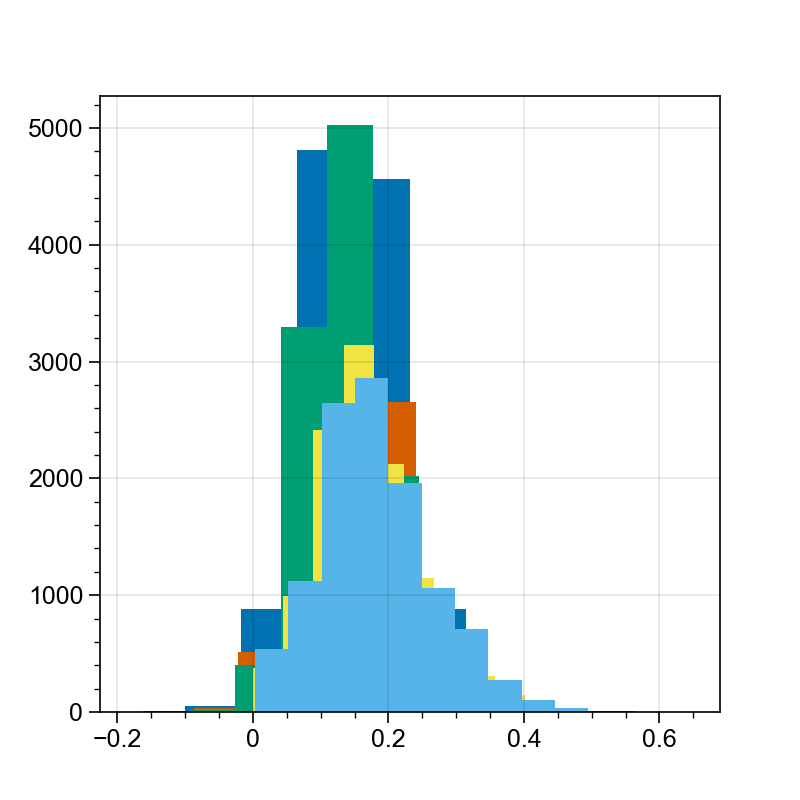

In [319]:
plt.hist(CRYO2ICE_comb_all['C2I_snow'])
plt.hist(CRYO2ICE_comb_all['C2I_LARM_snow'])
plt.hist(CRYO2ICE_comb_all['C2I_CCI_snow'])
plt.hist(CRYO2ICE_comb_all['SMLG_snow_depth'])
plt.hist(CRYO2ICE_comb_all['SMLG_snow_depth_v2'])
plt.hist(CRYO2ICE_comb_all['SMLG_snow_depth'])

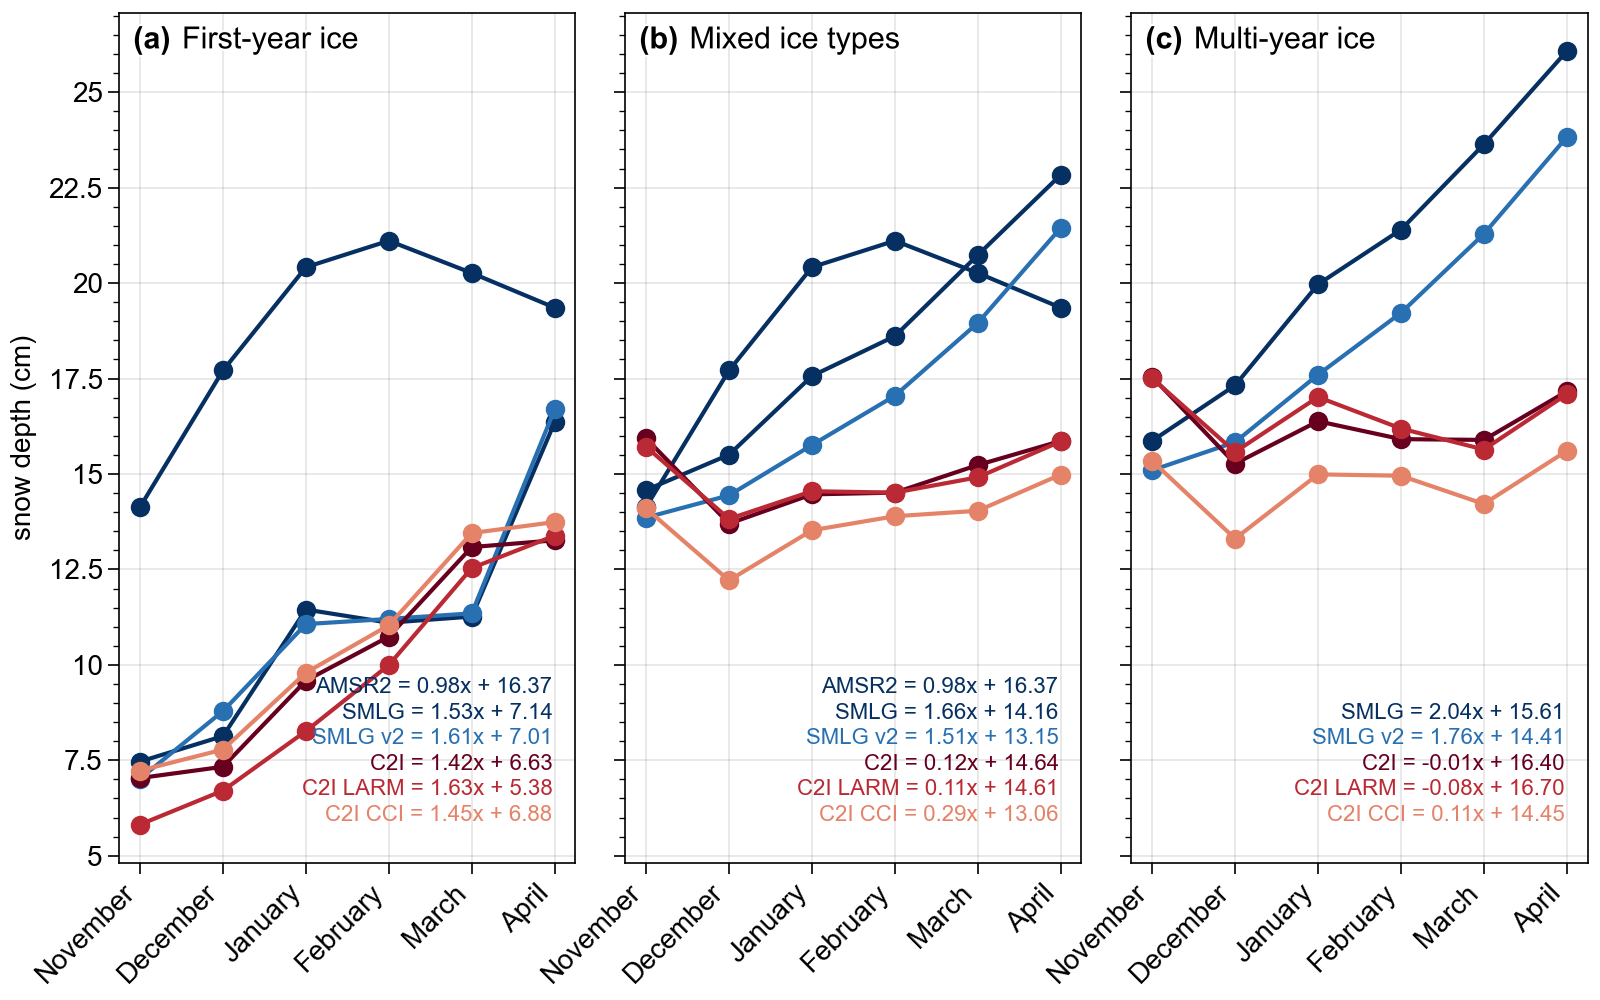

In [320]:
import proplot as pplt
fig = pplt.figure(space=2, figsize=(8,5), span=False, sharex=False, sharey=True)
ax = fig.subplots(nrows=1, ncols=3)
#fig, ax = plt.subplots(2, 3, figsize=(6,4), constrained_layout=True, sharey=True)
colours = cmap_qual
colours = [cmap_qual(0)[0:3],cmap_qual(1)[0:3],cmap_qual(2)[0:3],cmap_qual(5)[0:3],cmap_qual(6)[0:3],cmap_qual(7)[0:3]]
months = ['','November', 'December', 'January', 'February', 'March', 'April','']

def compute_monthly_growth(df_AMSR2, var):
    monthly_growth = [np.nan,np.nanmean(df_AMSR2[df_AMSR2['month']=='November'][var]),
                            np.nanmean(df_AMSR2[df_AMSR2['month']=='December'][var]),
                            np.nanmean(df_AMSR2[df_AMSR2['month']=='January'][var]),
                            np.nanmean(df_AMSR2[df_AMSR2['month']=='February'][var]),
                            np.nanmean(df_AMSR2[df_AMSR2['month']=='March'][var]),
                            np.nanmean(df_AMSR2[df_AMSR2['month']=='April'][var]),np.nan]
    return monthly_growth



df = CRYO2ICE_comb_all[(CRYO2ICE_comb_all['SMLG_snow_depth'].notna())&(CRYO2ICE_comb_all['C2I_snow'].notna()) & (CRYO2ICE_comb_all['C2I_LARM_snow'].notna()) & CRYO2ICE_comb_all['C2I_CCI_snow'].notna()]
df['lowess_snow_depth_original_MSS_unit_cm']=df['C2I_snow']*100
df['lowess_snow_depth_original_MSS_LARM_unit_cm']=df['C2I_LARM_snow']*100
df['lowess_snow_depth_original_MSS_CCI_unit_cm']=df['C2I_CCI_snow']*100
df['SMLG_snow_depth_unit_cm']=df['SMLG_snow_depth']*100
df['SMLG_snow_depth_v2_unit_cm']=df['SMLG_snow_depth_v2']*100
df_AMSR2 = df[df['AMSR2_snow_depth'].notna()]
df_MYI = df[df['AMSR2_snow_depth'].isnull()]

monthly_growth_AMSR2 = compute_monthly_growth(df_AMSR2, 'AMSR2_snow_depth')
monthly_growth_SMLG = compute_monthly_growth(df_AMSR2, 'SMLG_snow_depth_unit_cm')
monthly_growth_SMLG_v2  = compute_monthly_growth(df_AMSR2, 'SMLG_snow_depth_v2_unit_cm')
monthly_growth_C2I = compute_monthly_growth(df_AMSR2, 'lowess_snow_depth_original_MSS_unit_cm')
monthly_growth_C2I_LARM  = compute_monthly_growth(df_AMSR2, 'lowess_snow_depth_original_MSS_LARM_unit_cm')
monthly_growth_C2I_CCI  = compute_monthly_growth(df_AMSR2, 'lowess_snow_depth_original_MSS_CCI_unit_cm')


ax[0].plot(months, monthly_growth_AMSR2, linestyle='-',marker='o', c=colours[5])
ax[0].plot(months, monthly_growth_SMLG, linestyle='-',marker='o', c=colours[4])
ax[0].plot(months, monthly_growth_SMLG_v2, linestyle='-',marker='o', c=colours[3])
ax[0].plot(months, monthly_growth_C2I, linestyle='-',marker='o', c=colours[0])
ax[0].plot(months, monthly_growth_C2I_LARM, linestyle='-',marker='o', c=colours[1])
ax[0].plot(months, monthly_growth_C2I_CCI, linestyle='-',marker='o', c=colours[2])

x,y = np.arange(6), monthly_growth_AMSR2[1:7]
coef = np.polyfit(x,y,1)
ax[0].text(0.95, 0.20, 'AMSR2 = {:.2f}x + {:.2f}'.format(coef[0], coef[1]), c=colours[5], transform = ax[0].transAxes, ha='right', fontsize=8)

x,y = np.arange(6), monthly_growth_SMLG[1:7]
coef = np.polyfit(x,y,1)
ax[0].text(0.95, 0.17, 'SMLG = {:.2f}x + {:.2f}'.format(coef[0], coef[1]), c=colours[4], transform = ax[0].transAxes, ha='right', fontsize=8)

x,y = np.arange(6), monthly_growth_SMLG_v2[1:7]
coef = np.polyfit(x,y,1)
ax[0].text(0.95, 0.14, 'SMLG v2 = {:.2f}x + {:.2f}'.format(coef[0], coef[1]), c=colours[3], transform = ax[0].transAxes, ha='right', fontsize=8)


x,y = np.arange(6), monthly_growth_C2I[1:7]
coef = np.polyfit(x,y,1)
ax[0].text(0.95, 0.11, 'C2I = {:.2f}x + {:.2f}'.format(coef[0], coef[1]), c=colours[0], transform = ax[0].transAxes, ha='right', fontsize=8)

x,y = np.arange(6), monthly_growth_C2I_LARM[1:7]
coef = np.polyfit(x,y,1)
ax[0].text(0.95, 0.08, 'C2I LARM = {:.2f}x + {:.2f}'.format(coef[0], coef[1]),  c=colours[1], transform = ax[0].transAxes, ha='right', fontsize=8)

x,y = np.arange(6), monthly_growth_C2I_CCI[1:7]
coef = np.polyfit(x,y,1)
ax[0].text(0.95, 0.05, 'C2I CCI = {:.2f}x + {:.2f}'.format(coef[0], coef[1]),  c=colours[2], transform = ax[0].transAxes, ha='right', fontsize=8)

ax[0].format(xrotation=45, ylabel='snow depth (cm)', fontsize=10, ultitle='First-year ice')

monthly_growth_AMSR2_exp2 = compute_monthly_growth(df, 'AMSR2_snow_depth')
monthly_growth_SMLG_exp2 = compute_monthly_growth(df, 'SMLG_snow_depth_unit_cm')
monthly_growth_SMLG_v2_exp2  = compute_monthly_growth(df, 'SMLG_snow_depth_v2_unit_cm')
monthly_growth_C2I_exp2  = compute_monthly_growth(df, 'lowess_snow_depth_original_MSS_unit_cm')
monthly_growth_C2I_LARM_exp2  = compute_monthly_growth(df, 'lowess_snow_depth_original_MSS_LARM_unit_cm')
monthly_growth_C2I_CCI_exp2  = compute_monthly_growth(df, 'lowess_snow_depth_original_MSS_CCI_unit_cm')

ax[1].plot(months, monthly_growth_AMSR2_exp2, linestyle='-',marker='o', c=colours[5])
ax[1].plot(months, monthly_growth_SMLG_exp2, linestyle='-',marker='o', c=colours[4])
ax[1].plot(months, monthly_growth_SMLG_v2_exp2, linestyle='-',marker='o', c=colours[3])
ax[1].plot(months, monthly_growth_C2I_exp2, linestyle='-',marker='o', c=colours[0])
ax[1].plot(months, monthly_growth_C2I_LARM_exp2, linestyle='-',marker='o', c=colours[1])
ax[1].plot(months, monthly_growth_C2I_CCI_exp2, linestyle='-',marker='o', c=colours[2])
ax[1].format(xrotation=45, ylabel='snow depth (cm)', fontsize=10)

x,y = np.arange(6), monthly_growth_AMSR2_exp2[1:7]
coef = np.polyfit(x,y,1)
ax[1].text(0.95, 0.20, 'AMSR2 = {:.2f}x + {:.2f}'.format(coef[0], coef[1]), c=colours[5], transform = ax[1].transAxes, ha='right', fontsize=8)


x,y = np.arange(6), monthly_growth_SMLG_exp2[1:7]
coef = np.polyfit(x,y,1)
ax[1].text(0.95, 0.17, 'SMLG = {:.2f}x + {:.2f}'.format(coef[0], coef[1]), c=colours[4], transform = ax[1].transAxes, ha='right', fontsize=8)

x,y = np.arange(6), monthly_growth_SMLG_v2_exp2[1:7]
coef = np.polyfit(x,y,1)
ax[1].text(0.95, 0.14, 'SMLG v2 = {:.2f}x + {:.2f}'.format(coef[0], coef[1]), c=colours[3], transform = ax[1].transAxes, ha='right', fontsize=8)


x,y = np.arange(6), monthly_growth_C2I_exp2[1:7]
coef = np.polyfit(x,y,1)
ax[1].text(0.95, 0.11, 'C2I = {:.2f}x + {:.2f}'.format(coef[0], coef[1]), c=colours[0], transform = ax[1].transAxes, ha='right', fontsize=8)

x,y = np.arange(6), monthly_growth_C2I_LARM_exp2[1:7]
coef = np.polyfit(x,y,1)
ax[1].text(0.95, 0.08, 'C2I LARM = {:.2f}x + {:.2f}'.format(coef[0], coef[1]),  c=colours[1], transform = ax[1].transAxes, ha='right', fontsize=8)

x,y = np.arange(6), monthly_growth_C2I_CCI_exp2[1:7]
coef = np.polyfit(x,y,1)
ax[1].text(0.95, 0.05, 'C2I CCI = {:.2f}x + {:.2f}'.format(coef[0], coef[1]),  c=colours[2], transform = ax[1].transAxes, ha='right', fontsize=8)

ax[1].format(xrotation=45, ylabel='snow depth (cm)', fontsize=10, ultitle='Mixed ice types')

monthly_growth_SMLG_exp3 = compute_monthly_growth(df_MYI, 'SMLG_snow_depth_unit_cm')
monthly_growth_SMLG_v2_exp3  = compute_monthly_growth(df_MYI, 'SMLG_snow_depth_v2_unit_cm')
monthly_growth_C2I_exp3  = compute_monthly_growth(df_MYI, 'lowess_snow_depth_original_MSS_unit_cm')
monthly_growth_C2I_LARM_exp3  = compute_monthly_growth(df_MYI, 'lowess_snow_depth_original_MSS_LARM_unit_cm')
monthly_growth_C2I_CCI_exp3  = compute_monthly_growth(df_MYI, 'lowess_snow_depth_original_MSS_CCI_unit_cm')

ax[2].plot(months, monthly_growth_SMLG_exp3, linestyle='-',marker='o', c=colours[4])
ax[2].plot(months, monthly_growth_SMLG_v2_exp3, linestyle='-',marker='o', c=colours[3])
ax[2].plot(months, monthly_growth_C2I_exp3, linestyle='-',marker='o', c=colours[0])
ax[2].plot(months, monthly_growth_C2I_LARM_exp3, linestyle='-',marker='o', c=colours[1])
ax[2].plot(months, monthly_growth_C2I_CCI_exp3, linestyle='-',marker='o', c=colours[2])
ax[2].format(xrotation=45, ylabel='snow depth (cm)', fontsize=10)


x,y = np.arange(6), monthly_growth_SMLG_exp3[1:7]
coef = np.polyfit(x,y,1)
ax[2].text(0.95, 0.17, 'SMLG = {:.2f}x + {:.2f}'.format(coef[0], coef[1]), c=colours[4], transform = ax[2].transAxes, ha='right', fontsize=8)

x,y = np.arange(6), monthly_growth_SMLG_v2_exp3[1:7]
coef = np.polyfit(x,y,1)
ax[2].text(0.95, 0.14, 'SMLG v2 = {:.2f}x + {:.2f}'.format(coef[0], coef[1]), c=colours[3], transform = ax[2].transAxes, ha='right', fontsize=8)


x,y = np.arange(6), monthly_growth_C2I_exp3[1:7]
coef = np.polyfit(x,y,1)
ax[2].text(0.95, 0.11, 'C2I = {:.2f}x + {:.2f}'.format(coef[0], coef[1]), c=colours[0], transform = ax[2].transAxes, ha='right', fontsize=8)

x,y = np.arange(6), monthly_growth_C2I_LARM_exp3[1:7]
coef = np.polyfit(x,y,1)
ax[2].text(0.95, 0.08, 'C2I LARM = {:.2f}x + {:.2f}'.format(coef[0], coef[1]),  c=colours[1], transform = ax[2].transAxes, ha='right', fontsize=8)

x,y = np.arange(6), monthly_growth_C2I_CCI_exp3[1:7]
coef = np.polyfit(x,y,1)
ax[2].text(0.95, 0.05, 'C2I CCI = {:.2f}x + {:.2f}'.format(coef[0], coef[1]),  c=colours[2], transform = ax[2].transAxes, ha='right', fontsize=8)

ax[2].format(xrotation=45, ylabel='snow depth (cm)', fontsize=10, ultitle='Multi-year ice')



fig.format(abc='(a)', abcloc='ul')

#plt.savefig('E:\demo_CRYO2ICE_overall_comp_monthly_growth_gridded_orbit_wise_new_func_orbit_seg_25km_no_smooth.png', dpi=300)

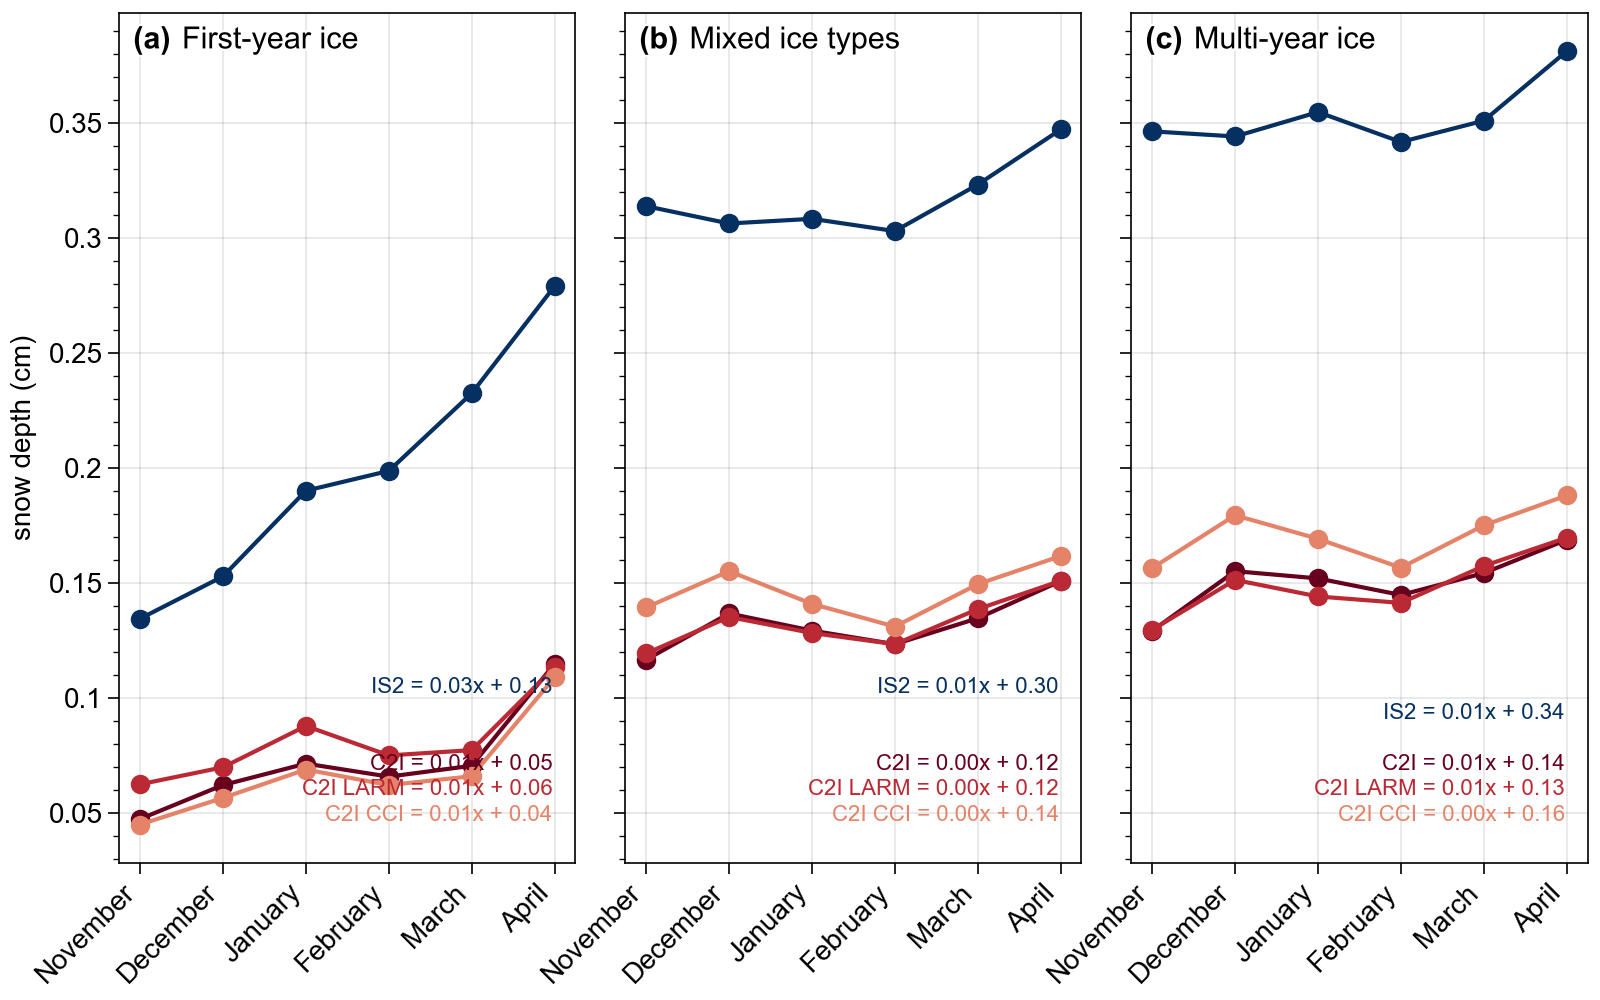

In [333]:
import proplot as pplt
fig = pplt.figure(space=2, figsize=(8,5), span=False, sharex=False, sharey=True)
ax = fig.subplots(nrows=1, ncols=3)
#fig, ax = plt.subplots(2, 3, figsize=(6,4), constrained_layout=True, sharey=True)
colours = cmap_qual
colours = [cmap_qual(0)[0:3],cmap_qual(1)[0:3],cmap_qual(2)[0:3],cmap_qual(5)[0:3],cmap_qual(6)[0:3],cmap_qual(7)[0:3]]
months = ['','November', 'December', 'January', 'February', 'March', 'April','']

def compute_monthly_growth(df_AMSR2, var):
    monthly_growth = [np.nan,np.nanmean(df_AMSR2[df_AMSR2['month']=='November'][var]),
                            np.nanmean(df_AMSR2[df_AMSR2['month']=='December'][var]),
                            np.nanmean(df_AMSR2[df_AMSR2['month']=='January'][var]),
                            np.nanmean(df_AMSR2[df_AMSR2['month']=='February'][var]),
                            np.nanmean(df_AMSR2[df_AMSR2['month']=='March'][var]),
                            np.nanmean(df_AMSR2[df_AMSR2['month']=='April'][var]),np.nan]
    return monthly_growth



df = CRYO2ICE_comb_all[(CRYO2ICE_comb_all['SMLG_snow_depth'].notna())&(CRYO2ICE_comb_all['C2I_snow'].notna()) & (CRYO2ICE_comb_all['C2I_LARM_snow'].notna()) & CRYO2ICE_comb_all['C2I_CCI_snow'].notna()]
df['lowess_snow_depth_original_MSS_unit_cm']=df['C2I_snow']*100
df['lowess_snow_depth_original_MSS_LARM_unit_cm']=df['C2I_LARM_snow']*100
df['lowess_snow_depth_original_MSS_CCI_unit_cm']=df['C2I_CCI_snow']*100
df['SMLG_snow_depth_unit_cm']=df['SMLG_snow_depth']*100
df['SMLG_snow_depth_v2_unit_cm']=df['SMLG_snow_depth_v2']*100
df_AMSR2 = df[df['AMSR2_snow_depth'].notna()]
df_MYI = df[df['AMSR2_snow_depth'].isnull()]

monthly_growth_AMSR2 = compute_monthly_growth(df_AMSR2, 'IS2_fb')
monthly_growth_C2I = compute_monthly_growth(df_AMSR2, 'fb')
monthly_growth_C2I_LARM  = compute_monthly_growth(df_AMSR2, 'LARM_rfb')
monthly_growth_C2I_CCI  = compute_monthly_growth(df_AMSR2, 'CCI_rfb')


ax[0].plot(months, monthly_growth_AMSR2, linestyle='-',marker='o', c=colours[5])

ax[0].plot(months, monthly_growth_C2I, linestyle='-',marker='o', c=colours[0])
ax[0].plot(months, monthly_growth_C2I_LARM, linestyle='-',marker='o', c=colours[1])
ax[0].plot(months, monthly_growth_C2I_CCI, linestyle='-',marker='o', c=colours[2])

x,y = np.arange(6), monthly_growth_AMSR2[1:7]
coef = np.polyfit(x,y,1)
ax[0].text(0.95, 0.20, 'IS2 = {:.2f}x + {:.2f}'.format(coef[0], coef[1]), c=colours[5], transform = ax[0].transAxes, ha='right', fontsize=8)

x,y = np.arange(6), monthly_growth_C2I[1:7]
coef = np.polyfit(x,y,1)
ax[0].text(0.95, 0.11, 'C2I = {:.2f}x + {:.2f}'.format(coef[0], coef[1]), c=colours[0], transform = ax[0].transAxes, ha='right', fontsize=8)

x,y = np.arange(6), monthly_growth_C2I_LARM[1:7]
coef = np.polyfit(x,y,1)
ax[0].text(0.95, 0.08, 'C2I LARM = {:.2f}x + {:.2f}'.format(coef[0], coef[1]),  c=colours[1], transform = ax[0].transAxes, ha='right', fontsize=8)

x,y = np.arange(6), monthly_growth_C2I_CCI[1:7]
coef = np.polyfit(x,y,1)
ax[0].text(0.95, 0.05, 'C2I CCI = {:.2f}x + {:.2f}'.format(coef[0], coef[1]),  c=colours[2], transform = ax[0].transAxes, ha='right', fontsize=8)

ax[0].format(xrotation=45, ylabel='freeboard (cm)', fontsize=10, ultitle='First-year ice')

monthly_growth_AMSR2_exp2 = compute_monthly_growth(df, 'IS2_fb')
monthly_growth_C2I_exp2  = compute_monthly_growth(df, 'fb')
monthly_growth_C2I_LARM_exp2  = compute_monthly_growth(df, 'LARM_rfb')
monthly_growth_C2I_CCI_exp2  = compute_monthly_growth(df, 'CCI_rfb')

ax[1].plot(months, monthly_growth_AMSR2_exp2, linestyle='-',marker='o', c=colours[5])
ax[1].plot(months, monthly_growth_C2I_exp2, linestyle='-',marker='o', c=colours[0])
ax[1].plot(months, monthly_growth_C2I_LARM_exp2, linestyle='-',marker='o', c=colours[1])
ax[1].plot(months, monthly_growth_C2I_CCI_exp2, linestyle='-',marker='o', c=colours[2])
ax[1].format(xrotation=45, ylabel='snow depth (cm)', fontsize=10)

x,y = np.arange(6), monthly_growth_AMSR2_exp2[1:7]
coef = np.polyfit(x,y,1)
ax[1].text(0.95, 0.20, 'IS2 = {:.2f}x + {:.2f}'.format(coef[0], coef[1]), c=colours[5], transform = ax[1].transAxes, ha='right', fontsize=8)


x,y = np.arange(6), monthly_growth_C2I_exp2[1:7]
coef = np.polyfit(x,y,1)
ax[1].text(0.95, 0.11, 'C2I = {:.2f}x + {:.2f}'.format(coef[0], coef[1]), c=colours[0], transform = ax[1].transAxes, ha='right', fontsize=8)

x,y = np.arange(6), monthly_growth_C2I_LARM_exp2[1:7]
coef = np.polyfit(x,y,1)
ax[1].text(0.95, 0.08, 'C2I LARM = {:.2f}x + {:.2f}'.format(coef[0], coef[1]),  c=colours[1], transform = ax[1].transAxes, ha='right', fontsize=8)

x,y = np.arange(6), monthly_growth_C2I_CCI_exp2[1:7]
coef = np.polyfit(x,y,1)
ax[1].text(0.95, 0.05, 'C2I CCI = {:.2f}x + {:.2f}'.format(coef[0], coef[1]),  c=colours[2], transform = ax[1].transAxes, ha='right', fontsize=8)

ax[1].format(xrotation=45, ylabel='freeboard (cm)', fontsize=10, ultitle='Mixed ice types')

monthly_growth_SMLG_exp3 = compute_monthly_growth(df_MYI, 'IS2_fb')
monthly_growth_C2I_exp3  = compute_monthly_growth(df_MYI, 'fb')
monthly_growth_C2I_LARM_exp3  = compute_monthly_growth(df_MYI, 'LARM_rfb')
monthly_growth_C2I_CCI_exp3  = compute_monthly_growth(df_MYI, 'CCI_rfb')

ax[2].plot(months, monthly_growth_SMLG_exp3, linestyle='-',marker='o', c=colours[5])
ax[2].plot(months, monthly_growth_C2I_exp3, linestyle='-',marker='o', c=colours[0])
ax[2].plot(months, monthly_growth_C2I_LARM_exp3, linestyle='-',marker='o', c=colours[1])
ax[2].plot(months, monthly_growth_C2I_CCI_exp3, linestyle='-',marker='o', c=colours[2])
ax[2].format(xrotation=45, ylabel='freeboard (cm)', fontsize=10)


x,y = np.arange(6), monthly_growth_SMLG_exp3[1:7]
coef = np.polyfit(x,y,1)
ax[2].text(0.95, 0.17, 'IS2 = {:.2f}x + {:.2f}'.format(coef[0], coef[1]), c=colours[5], transform = ax[2].transAxes, ha='right', fontsize=8)


x,y = np.arange(6), monthly_growth_C2I_exp3[1:7]
coef = np.polyfit(x,y,1)
ax[2].text(0.95, 0.11, 'C2I = {:.2f}x + {:.2f}'.format(coef[0], coef[1]), c=colours[0], transform = ax[2].transAxes, ha='right', fontsize=8)

x,y = np.arange(6), monthly_growth_C2I_LARM_exp3[1:7]
coef = np.polyfit(x,y,1)
ax[2].text(0.95, 0.08, 'C2I LARM = {:.2f}x + {:.2f}'.format(coef[0], coef[1]),  c=colours[1], transform = ax[2].transAxes, ha='right', fontsize=8)

x,y = np.arange(6), monthly_growth_C2I_CCI_exp3[1:7]
coef = np.polyfit(x,y,1)
ax[2].text(0.95, 0.05, 'C2I CCI = {:.2f}x + {:.2f}'.format(coef[0], coef[1]),  c=colours[2], transform = ax[2].transAxes, ha='right', fontsize=8)

ax[2].format(xrotation=45, ylabel='snow depth (cm)', fontsize=10, ultitle='Multi-year ice')



fig.format(abc='(a)', abcloc='ul')

#plt.savefig('E:\demo_CRYO2ICE_overall_comp_monthly_growth_gridded_orbit_wise_new_func_orbit_seg_25km_no_smooth.png', dpi=300)

In [331]:
CRYO2ICE_comb_all

Unnamed: 0        lat         lon  along_track_dist_in_metres        fb  \
0             0  81.227022 -102.798263                     12500.0  0.080354   
1             1  81.408989 -103.098141                     37500.0  0.174167   
2             2  81.655801 -103.525732                     62500.0  0.127934   
3             3  81.770898 -103.732955                     87500.0  0.204765   
4             4        NaN         NaN                    112500.0       NaN   
...         ...        ...         ...                         ...       ...   
3371          8  87.895309  -52.335252                    212500.0  0.177060   
3372          9  87.795116  -59.253869                    237500.0  0.153097   
3373         10  87.716504  -63.264256                    262500.0  0.175077   
3374         11  87.603101  -67.913618                    287500.0  0.170763   
3375         12  87.484534  -71.846673                    312500.0  0.144780   

      LARM_rfb   CCI_rfb    IS2_fb  AMSR2_snow_depth  SMLG_snow_depth  \
0     0.129332  0.135280  0.435148               NaN         0.215547   
1     0.164395  0.251451  0.410171               NaN         0.205963   
2     0.131592  0.199531  0.377911               NaN         0.189341   
3     0.184251  0.239441  0.405539               NaN         0.179652   
4          NaN       NaN       NaN               NaN              NaN   
...        ...       ...       ...               ...              ...   
3371  0.182814  0.189837  0.435967               NaN         0.169294   
3372  0.089487  0.182123  0.400767               NaN         0.232043   
3373  0.172729  0.185805  0.457971               NaN         0.194177   
3374  0.169721  0.176340  0.458145               NaN         0.238713   
3375  0.143271  0.187155  0.381490               NaN         0.200239   

      SMLG_snow_depth_v2  C2I_snow  C2I_LARM_snow  C2I_CCI_snow     month  \
0               0.208001  0.286571       0.247011      0.242207  November   
1               0.194500  0.190624       0.198517      0.128200  November   
2               0.195951  0.201909       0.198955      0.144079  November   
3               0.184952  0.162168       0.178737      0.134159  November   
4                    NaN       NaN            NaN           NaN  November   
...                  ...       ...            ...           ...       ...   
3371            0.144230  0.209122       0.204474      0.198802     April   
3372            0.190955  0.200046       0.251425      0.176601     April   
3373            0.163338  0.228496       0.230393      0.219831     April   
3374            0.195812  0.232122       0.232963      0.227617     April   
3375            0.178410  0.191194       0.192412      0.156967     April   

      AMSR2_snow_depth_unit_m  
0                         NaN  
1                         NaN  
2                         NaN  
3                         NaN  
4                         NaN  
...                       ...  
3371                      NaN  
3372                      NaN  
3373                      NaN  
3374                      NaN  
3375                      NaN  

[19648 rows x 16 columns]

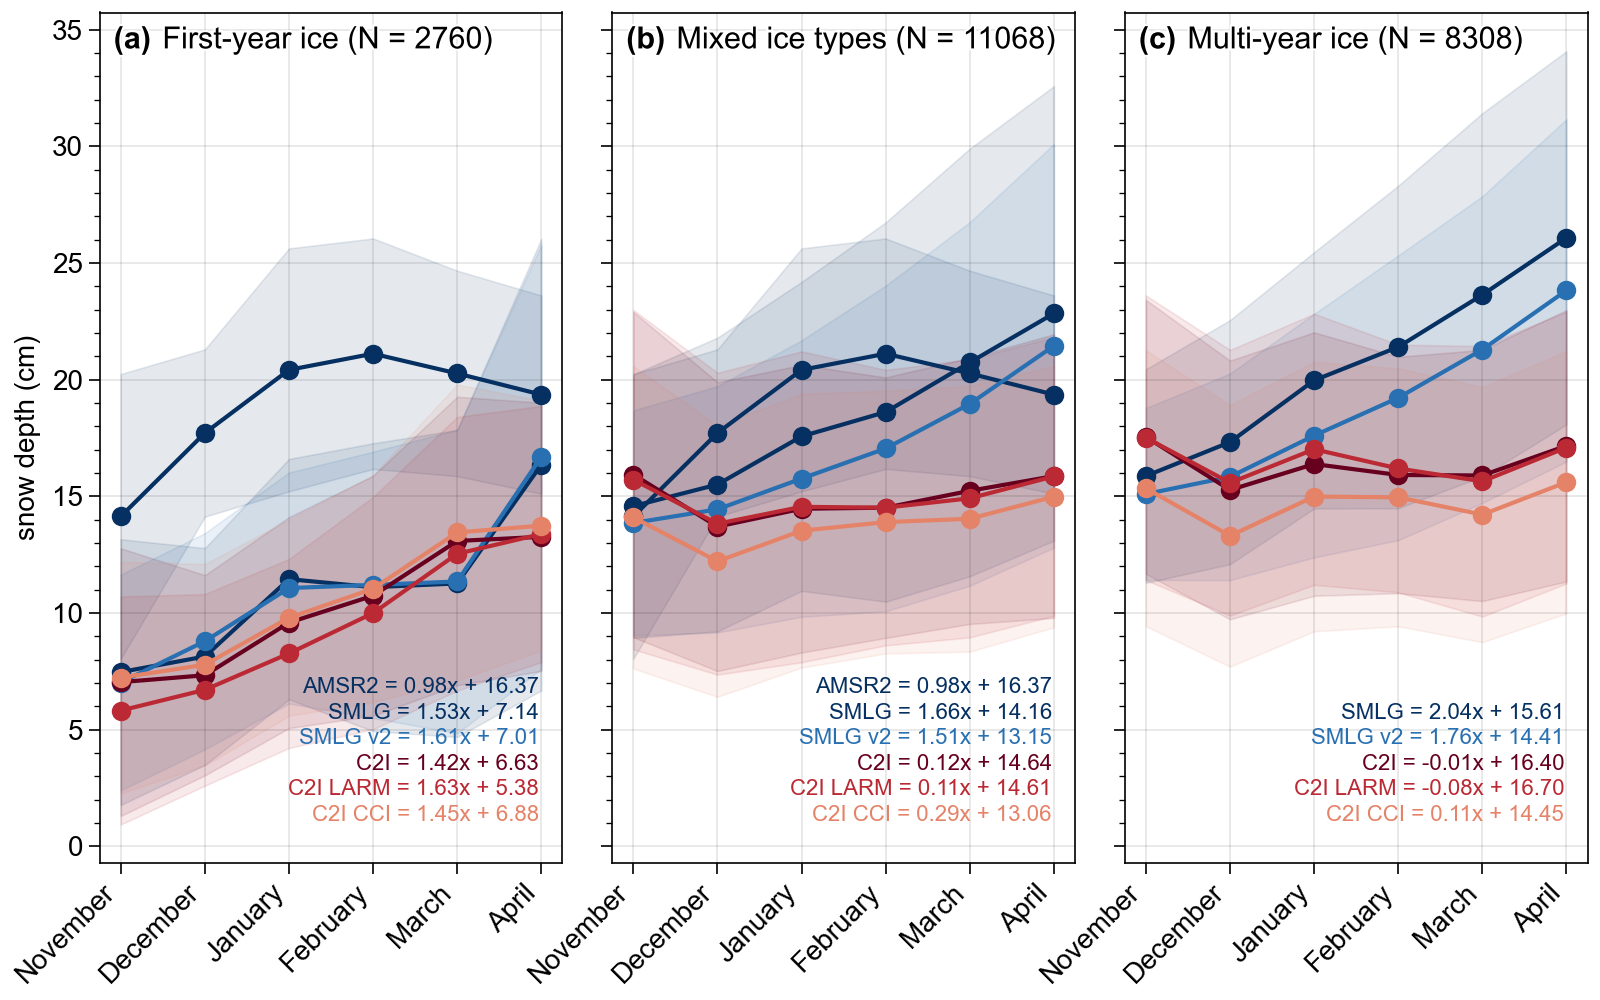

In [321]:
import proplot as pplt
fig = pplt.figure(space=2, figsize=(8,5), span=False, sharex=False, sharey=True)
ax = fig.subplots(nrows=1, ncols=3)
#fig, ax = plt.subplots(2, 3, figsize=(6,4), constrained_layout=True, sharey=True)
colours = cmap_qual
colours = [cmap_qual(0)[0:3],cmap_qual(1)[0:3],cmap_qual(2)[0:3],cmap_qual(5)[0:3],cmap_qual(6)[0:3],cmap_qual(7)[0:3]]
months = ['','November', 'December', 'January', 'February', 'March', 'April','']

def compute_monthly_growth(df_AMSR2, var):
    monthly_growth = [np.nan,np.nanmean(df_AMSR2[df_AMSR2['month']=='November'][var]),
                            np.nanmean(df_AMSR2[df_AMSR2['month']=='December'][var]),
                            np.nanmean(df_AMSR2[df_AMSR2['month']=='January'][var]),
                            np.nanmean(df_AMSR2[df_AMSR2['month']=='February'][var]),
                            np.nanmean(df_AMSR2[df_AMSR2['month']=='March'][var]),
                            np.nanmean(df_AMSR2[df_AMSR2['month']=='April'][var]),np.nan]
    return monthly_growth

def compute_monthly_growth_v2(df_AMSR2, var):
    monthly_growth = [np.nan,np.nanmean(df_AMSR2[df_AMSR2['month']=='November'][var]),
                            np.nanmean(df_AMSR2[df_AMSR2['month']=='December'][var]),
                            np.nanmean(df_AMSR2[df_AMSR2['month']=='January'][var]),
                            np.nanmean(df_AMSR2[df_AMSR2['month']=='February'][var]),
                            np.nanmean(df_AMSR2[df_AMSR2['month']=='March'][var]),
                            np.nanmean(df_AMSR2[df_AMSR2['month']=='April'][var]),np.nan]
    
    monthly_growth_variability = [np.nan,np.nanstd(df_AMSR2[df_AMSR2['month']=='November'][var]),
                            np.nanstd(df_AMSR2[df_AMSR2['month']=='December'][var]),
                            np.nanstd(df_AMSR2[df_AMSR2['month']=='January'][var]),
                            np.nanstd(df_AMSR2[df_AMSR2['month']=='February'][var]),
                            np.nanstd(df_AMSR2[df_AMSR2['month']=='March'][var]),
                            np.nanstd(df_AMSR2[df_AMSR2['month']=='April'][var]),np.nan]
    return monthly_growth, monthly_growth_variability


df = CRYO2ICE_comb_all[(CRYO2ICE_comb_all['SMLG_snow_depth'].notna())&(CRYO2ICE_comb_all['C2I_snow'].notna()) & (CRYO2ICE_comb_all['C2I_LARM_snow'].notna()) & CRYO2ICE_comb_all['C2I_CCI_snow'].notna()]
df['lowess_snow_depth_original_MSS_unit_cm']=df['C2I_snow']*100
df['lowess_snow_depth_original_MSS_LARM_unit_cm']=df['C2I_LARM_snow']*100
df['lowess_snow_depth_original_MSS_CCI_unit_cm']=df['C2I_CCI_snow']*100
df['SMLG_snow_depth_unit_cm']=df['SMLG_snow_depth']*100
df['SMLG_snow_depth_v2_unit_cm']=df['SMLG_snow_depth_v2']*100
df_AMSR2 = df[df['AMSR2_snow_depth'].notna()]
df_MYI = df[df['AMSR2_snow_depth'].isnull()]


monthly_growth_AMSR2, monthly_growth_AMSR2_err = compute_monthly_growth_v2(df_AMSR2, 'AMSR2_snow_depth')
monthly_growth_SMLG,monthly_growth_SMLG_err = compute_monthly_growth_v2(df_AMSR2, 'SMLG_snow_depth_unit_cm')
monthly_growth_SMLG_v2, monthly_growth_SMLG_v2_err = compute_monthly_growth_v2(df_AMSR2, 'SMLG_snow_depth_v2_unit_cm')
monthly_growth_C2I, monthly_growth_C2I_err = compute_monthly_growth_v2(df_AMSR2, 'lowess_snow_depth_original_MSS_unit_cm')
monthly_growth_C2I_LARM, monthly_growth_C2I_LARM_err  = compute_monthly_growth_v2(df_AMSR2, 'lowess_snow_depth_original_MSS_LARM_unit_cm')
monthly_growth_C2I_CCI, monthly_growth_C2I_CCI_err  = compute_monthly_growth_v2(df_AMSR2, 'lowess_snow_depth_original_MSS_CCI_unit_cm')


ax[0].plot(months, monthly_growth_AMSR2, linestyle='-',marker='o', c=colours[5])
growth, err = np.array(monthly_growth_AMSR2), np.array(monthly_growth_AMSR2_err)
c1, c2 = growth-err, growth+err
ax[0].fill_between(months, c1, c2, c=colours[5], alpha=0.1)
ax[0].plot(months, monthly_growth_SMLG, linestyle='-',marker='o', c=colours[4])
growth, err = np.array(monthly_growth_SMLG), np.array(monthly_growth_SMLG_err)
c1, c2 = growth-err, growth+err
ax[0].fill_between(months, c1, c2, c=colours[4], alpha=0.1)
ax[0].plot(months, monthly_growth_SMLG_v2, linestyle='-',marker='o', c=colours[3])
growth, err = np.array(monthly_growth_SMLG_v2), np.array(monthly_growth_SMLG_v2_err)
c1, c2 = growth-err, growth+err
ax[0].fill_between(months, c1, c2, c=colours[3], alpha=0.1)
ax[0].plot(months, monthly_growth_C2I, linestyle='-',marker='o', c=colours[0])
growth, err = np.array(monthly_growth_C2I), np.array(monthly_growth_C2I_err)
c1, c2 = growth-err, growth+err
ax[0].fill_between(months, c1, c2, c=colours[0], alpha=0.1)
ax[0].plot(months, monthly_growth_C2I_LARM, linestyle='-',marker='o', c=colours[1])
growth, err = np.array(monthly_growth_C2I_LARM), np.array(monthly_growth_C2I_LARM_err)
c1, c2 = growth-err, growth+err
ax[0].fill_between(months, c1, c2, c=colours[1], alpha=0.1)
ax[0].plot(months, monthly_growth_C2I_CCI, linestyle='-',marker='o', c=colours[2])
growth, err = np.array(monthly_growth_C2I_CCI), np.array(monthly_growth_C2I_CCI_err)
c1, c2 = growth-err, growth+err
ax[0].fill_between(months, c1, c2, c=colours[2], alpha=0.1)

x,y = np.arange(6), monthly_growth_AMSR2[1:7]
coef = np.polyfit(x,y,1)
ax[0].text(0.95, 0.20, 'AMSR2 = {:.2f}x + {:.2f}'.format(coef[0], coef[1]), c=colours[5], transform = ax[0].transAxes, ha='right', fontsize=8)

x,y = np.arange(6), monthly_growth_SMLG[1:7]
coef = np.polyfit(x,y,1)
ax[0].text(0.95, 0.17, 'SMLG = {:.2f}x + {:.2f}'.format(coef[0], coef[1]), c=colours[4], transform = ax[0].transAxes, ha='right', fontsize=8)

x,y = np.arange(6), monthly_growth_SMLG_v2[1:7]
coef = np.polyfit(x,y,1)
ax[0].text(0.95, 0.14, 'SMLG v2 = {:.2f}x + {:.2f}'.format(coef[0], coef[1]), c=colours[3], transform = ax[0].transAxes, ha='right', fontsize=8)


x,y = np.arange(6), monthly_growth_C2I[1:7]
coef = np.polyfit(x,y,1)
ax[0].text(0.95, 0.11, 'C2I = {:.2f}x + {:.2f}'.format(coef[0], coef[1]), c=colours[0], transform = ax[0].transAxes, ha='right', fontsize=8)

x,y = np.arange(6), monthly_growth_C2I_LARM[1:7]
coef = np.polyfit(x,y,1)
ax[0].text(0.95, 0.08, 'C2I LARM = {:.2f}x + {:.2f}'.format(coef[0], coef[1]),  c=colours[1], transform = ax[0].transAxes, ha='right', fontsize=8)

x,y = np.arange(6), monthly_growth_C2I_CCI[1:7]
coef = np.polyfit(x,y,1)
ax[0].text(0.95, 0.05, 'C2I CCI = {:.2f}x + {:.2f}'.format(coef[0], coef[1]),  c=colours[2], transform = ax[0].transAxes, ha='right', fontsize=8)

ax[0].format(xrotation=45, ylabel='snow depth (cm)', fontsize=10, ultitle='First-year ice (N = {})'.format(len(df_AMSR2)))

monthly_growth_AMSR2_exp2, monthly_growth_AMSR2_exp2_err = compute_monthly_growth_v2(df, 'AMSR2_snow_depth')
monthly_growth_SMLG_exp2, monthly_growth_SMLG_exp2_err = compute_monthly_growth_v2(df, 'SMLG_snow_depth_unit_cm')
monthly_growth_SMLG_v2_exp2, monthly_growth_SMLG_v2_exp2_err  = compute_monthly_growth_v2(df, 'SMLG_snow_depth_v2_unit_cm')
monthly_growth_C2I_exp2, monthly_growth_C2I_exp2_err  = compute_monthly_growth_v2(df, 'lowess_snow_depth_original_MSS_unit_cm')
monthly_growth_C2I_LARM_exp2, monthly_growth_C2I_LARM_exp2_err  = compute_monthly_growth_v2(df, 'lowess_snow_depth_original_MSS_LARM_unit_cm')
monthly_growth_C2I_CCI_exp2, monthly_growth_C2I_CCI_exp2_err  = compute_monthly_growth_v2(df, 'lowess_snow_depth_original_MSS_CCI_unit_cm')

'''ax[1].plot(months, monthly_growth_AMSR2_exp2, linestyle='-',marker='o', c=colours[5])
ax[1].plot(months, monthly_growth_SMLG_exp2, linestyle='-',marker='o', c=colours[4])
ax[1].plot(months, monthly_growth_SMLG_v2_exp2, linestyle='-',marker='o', c=colours[3])
ax[1].plot(months, monthly_growth_C2I_exp2, linestyle='-',marker='o', c=colours[0])
ax[1].plot(months, monthly_growth_C2I_LARM_exp2, linestyle='-',marker='o', c=colours[1])
ax[1].plot(months, monthly_growth_C2I_CCI_exp2, linestyle='-',marker='o', c=colours[2])
ax[1].format(xrotation=45, ylabel='snow depth (cm)', fontsize=10)'''

ax[1].plot(months, monthly_growth_AMSR2_exp2, linestyle='-',marker='o', c=colours[5])
growth, err = np.array(monthly_growth_AMSR2_exp2), np.array(monthly_growth_AMSR2_exp2_err)
c1, c2 = growth-err, growth+err
ax[1].fill_between(months, c1, c2, c=colours[5], alpha=0.1)
ax[1].plot(months, monthly_growth_SMLG_exp2, linestyle='-',marker='o', c=colours[4])
growth, err = np.array(monthly_growth_SMLG_exp2), np.array(monthly_growth_SMLG_exp2_err)
c1, c2 = growth-err, growth+err
ax[1].fill_between(months, c1, c2, c=colours[4], alpha=0.1)
ax[1].plot(months, monthly_growth_SMLG_v2_exp2, linestyle='-',marker='o', c=colours[3])
growth, err = np.array(monthly_growth_SMLG_v2_exp2), np.array(monthly_growth_SMLG_v2_exp2_err)
c1, c2 = growth-err, growth+err
ax[1].fill_between(months, c1, c2, c=colours[3], alpha=0.1)
ax[1].plot(months, monthly_growth_C2I_exp2, linestyle='-',marker='o', c=colours[0])
growth, err = np.array(monthly_growth_C2I_exp2), np.array(monthly_growth_C2I_exp2_err)
c1, c2 = growth-err, growth+err
ax[1].fill_between(months, c1, c2, c=colours[0], alpha=0.1)
ax[1].plot(months, monthly_growth_C2I_LARM_exp2, linestyle='-',marker='o', c=colours[1])
growth, err = np.array(monthly_growth_C2I_LARM_exp2), np.array(monthly_growth_C2I_LARM_exp2_err)
c1, c2 = growth-err, growth+err
ax[1].fill_between(months, c1, c2, c=colours[1], alpha=0.1)
ax[1].plot(months, monthly_growth_C2I_CCI_exp2, linestyle='-',marker='o', c=colours[2])
growth, err = np.array(monthly_growth_C2I_CCI_exp2), np.array(monthly_growth_C2I_CCI_exp2_err)
c1, c2 = growth-err, growth+err
ax[1].fill_between(months, c1, c2, c=colours[2], alpha=0.1)

x,y = np.arange(6), monthly_growth_AMSR2_exp2[1:7]
coef = np.polyfit(x,y,1)
ax[1].text(0.95, 0.20, 'AMSR2 = {:.2f}x + {:.2f}'.format(coef[0], coef[1]), c=colours[5], transform = ax[1].transAxes, ha='right', fontsize=8)


x,y = np.arange(6), monthly_growth_SMLG_exp2[1:7]
coef = np.polyfit(x,y,1)
ax[1].text(0.95, 0.17, 'SMLG = {:.2f}x + {:.2f}'.format(coef[0], coef[1]), c=colours[4], transform = ax[1].transAxes, ha='right', fontsize=8)

x,y = np.arange(6), monthly_growth_SMLG_v2_exp2[1:7]
coef = np.polyfit(x,y,1)
ax[1].text(0.95, 0.14, 'SMLG v2 = {:.2f}x + {:.2f}'.format(coef[0], coef[1]), c=colours[3], transform = ax[1].transAxes, ha='right', fontsize=8)


x,y = np.arange(6), monthly_growth_C2I_exp2[1:7]
coef = np.polyfit(x,y,1)
ax[1].text(0.95, 0.11, 'C2I = {:.2f}x + {:.2f}'.format(coef[0], coef[1]), c=colours[0], transform = ax[1].transAxes, ha='right', fontsize=8)

x,y = np.arange(6), monthly_growth_C2I_LARM_exp2[1:7]
coef = np.polyfit(x,y,1)
ax[1].text(0.95, 0.08, 'C2I LARM = {:.2f}x + {:.2f}'.format(coef[0], coef[1]),  c=colours[1], transform = ax[1].transAxes, ha='right', fontsize=8)

x,y = np.arange(6), monthly_growth_C2I_CCI_exp2[1:7]
coef = np.polyfit(x,y,1)
ax[1].text(0.95, 0.05, 'C2I CCI = {:.2f}x + {:.2f}'.format(coef[0], coef[1]),  c=colours[2], transform = ax[1].transAxes, ha='right', fontsize=8)

ax[1].format(xrotation=45, ylabel='snow depth (cm)', fontsize=10, ultitle='Mixed ice types (N = {})'.format(len(df)))

monthly_growth_SMLG_exp3,monthly_growth_SMLG_exp3_err = compute_monthly_growth_v2(df_MYI, 'SMLG_snow_depth_unit_cm')
monthly_growth_SMLG_v2_exp3,monthly_growth_SMLG_v2_exp3_err  = compute_monthly_growth_v2(df_MYI, 'SMLG_snow_depth_v2_unit_cm')
monthly_growth_C2I_exp3,monthly_growth_C2I_exp3_err  = compute_monthly_growth_v2(df_MYI, 'lowess_snow_depth_original_MSS_unit_cm')
monthly_growth_C2I_LARM_exp3,monthly_growth_C2I_LARM_exp3_err  = compute_monthly_growth_v2(df_MYI, 'lowess_snow_depth_original_MSS_LARM_unit_cm')
monthly_growth_C2I_CCI_exp3,monthly_growth_C2I_CCI_exp3_err  = compute_monthly_growth_v2(df_MYI, 'lowess_snow_depth_original_MSS_CCI_unit_cm')


ax[2].plot(months, monthly_growth_SMLG_exp3, linestyle='-',marker='o', c=colours[4])
growth, err = np.array(monthly_growth_SMLG_exp3), np.array(monthly_growth_SMLG_exp3_err)
c1, c2 = growth-err, growth+err
ax[2].fill_between(months, c1, c2, c=colours[4], alpha=0.1)
ax[2].plot(months, monthly_growth_SMLG_v2_exp3, linestyle='-',marker='o', c=colours[3])
growth, err = np.array(monthly_growth_SMLG_v2_exp3), np.array(monthly_growth_SMLG_v2_exp3_err)
c1, c2 = growth-err, growth+err
ax[2].fill_between(months, c1, c2, c=colours[3], alpha=0.1)
ax[2].plot(months, monthly_growth_C2I_exp3, linestyle='-',marker='o', c=colours[0])
growth, err = np.array(monthly_growth_C2I_exp3), np.array(monthly_growth_C2I_exp3_err)
c1, c2 = growth-err, growth+err
ax[2].fill_between(months, c1, c2, c=colours[0], alpha=0.1)
ax[2].plot(months, monthly_growth_C2I_LARM_exp3, linestyle='-',marker='o', c=colours[1])
growth, err = np.array(monthly_growth_C2I_LARM_exp3), np.array(monthly_growth_C2I_LARM_exp3_err)
c1, c2 = growth-err, growth+err
ax[2].fill_between(months, c1, c2, c=colours[1], alpha=0.1)
ax[2].plot(months, monthly_growth_C2I_CCI_exp3, linestyle='-',marker='o', c=colours[2])
growth, err = np.array(monthly_growth_C2I_CCI_exp3), np.array(monthly_growth_C2I_CCI_exp3_err)
c1, c2 = growth-err, growth+err
ax[2].fill_between(months, c1, c2, c=colours[2], alpha=0.1)
ax[2].format(xrotation=45, ylabel='snow depth (cm)', fontsize=10)


x,y = np.arange(6), monthly_growth_SMLG_exp3[1:7]
coef = np.polyfit(x,y,1)
ax[2].text(0.95, 0.17, 'SMLG = {:.2f}x + {:.2f}'.format(coef[0], coef[1]), c=colours[4], transform = ax[2].transAxes, ha='right', fontsize=8)

x,y = np.arange(6), monthly_growth_SMLG_v2_exp3[1:7]
coef = np.polyfit(x,y,1)
ax[2].text(0.95, 0.14, 'SMLG v2 = {:.2f}x + {:.2f}'.format(coef[0], coef[1]), c=colours[3], transform = ax[2].transAxes, ha='right', fontsize=8)


x,y = np.arange(6), monthly_growth_C2I_exp3[1:7]
coef = np.polyfit(x,y,1)
ax[2].text(0.95, 0.11, 'C2I = {:.2f}x + {:.2f}'.format(coef[0], coef[1]), c=colours[0], transform = ax[2].transAxes, ha='right', fontsize=8)

x,y = np.arange(6), monthly_growth_C2I_LARM_exp3[1:7]
coef = np.polyfit(x,y,1)
ax[2].text(0.95, 0.08, 'C2I LARM = {:.2f}x + {:.2f}'.format(coef[0], coef[1]),  c=colours[1], transform = ax[2].transAxes, ha='right', fontsize=8)

x,y = np.arange(6), monthly_growth_C2I_CCI_exp3[1:7]
coef = np.polyfit(x,y,1)
ax[2].text(0.95, 0.05, 'C2I CCI = {:.2f}x + {:.2f}'.format(coef[0], coef[1]),  c=colours[2], transform = ax[2].transAxes, ha='right', fontsize=8)

ax[2].format(xrotation=45, ylabel='snow depth (cm)', fontsize=10, ultitle='Multi-year ice (N = {})'.format(len(df_MYI)))



fig.format(abc='(a)', abcloc='ul')

#plt.savefig('E:\demo_CRYO2ICE_overall_comp_monthly_growth_gridded_orbit_wise_err_new_func.png', dpi=300)

C:\Users\rmfha\AppData\Local\Temp/ipykernel_21124/283474753.py:235: ProplotWarning: Calling arbitrary axes methods from SubplotGrid was deprecated in v0.8 and will be removed in a future release. Please index the grid or loop over the grid instead.
  ax[1,3].plot(np.arange(-50,100,10),np.arange(-50,100,10), color='grey', alpha=0.3, linestyle='--')
C:\Users\rmfha\AppData\Local\Temp/ipykernel_21124/283474753.py:238: ProplotWarning: Calling arbitrary axes methods from SubplotGrid was deprecated in v0.8 and will be removed in a future release. Please index the grid or loop over the grid instead.
  ax[2,1].plot(np.arange(-50,100,10),np.arange(-50,100,10), color='grey', alpha=0.3, linestyle='--')
C:\Users\rmfha\AppData\Local\Temp/ipykernel_21124/283474753.py:239: ProplotWarning: Calling arbitrary axes methods from SubplotGrid was deprecated in v0.8 and will be removed in a future release. Please index the grid or loop over the grid instead.
  ax[2,2].plot(np.arange(-50,100,10),np.arange(-50,

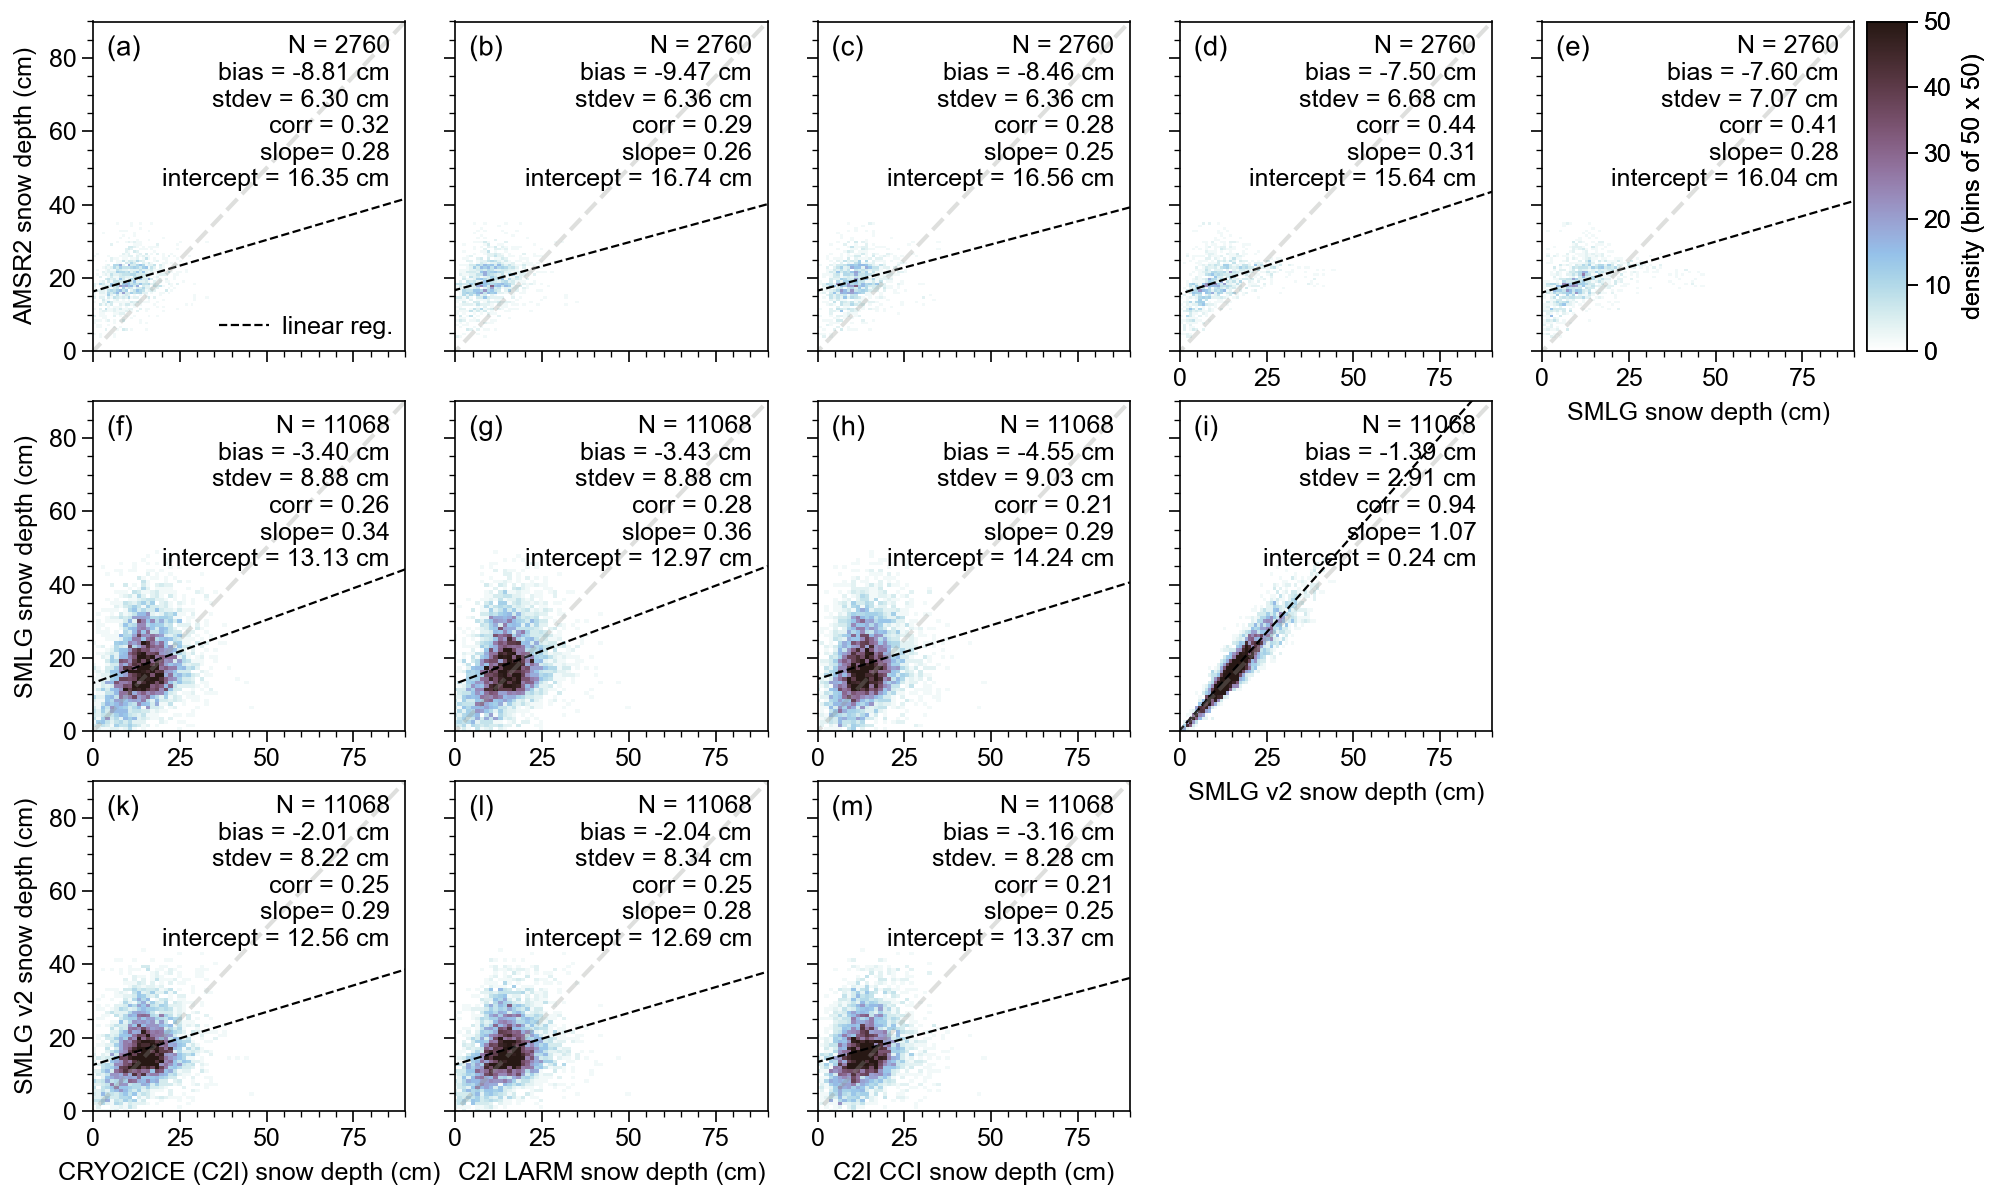

In [322]:
import proplot as pplt
fig = pplt.figure(space=2, figsize=(10,6), span=False, sharex=False)
ax = fig.subplots(nrows=3, ncols=5)
#fig, ax = plt.subplots(2, 3, figsize=(6,4), constrained_layout=True, sharey=True)

import matplotlib.pyplot as plt
def using_hist2d(ax, x, y, bins=(50, 50), cmap='Blues'):
    # https://stackoverflow.com/a/20105673/3015186
    # Answer by askewchan
    im = ax.hist2d(x, y, bins, cmap=cmap, vmin=0, vmax=50)
    
    return im

cmap_density = 'Glacial'
density = (50,50)
df = CRYO2ICE_comb_all[(CRYO2ICE_comb_all['SMLG_snow_depth'].notna())&(CRYO2ICE_comb_all['C2I_snow'].notna()) & (CRYO2ICE_comb_all['C2I_LARM_snow'].notna()) & CRYO2ICE_comb_all['C2I_CCI_snow'].notna()]
df['snow_depth_original_MSS_unit_cm']=df['C2I_snow']*100
df['snow_depth_original_MSS_LARM_unit_cm']=df['C2I_LARM_snow']*100
df['snow_depth_original_MSS_CCI_unit_cm']=df['C2I_CCI_snow']*100
df['SMLG_snow_depth_unit_cm']=df['SMLG_snow_depth']*100
df['SMLG_snow_depth_v2_unit_cm']=df['SMLG_snow_depth_v2']*100
df_AMSR2 = df[df['AMSR2_snow_depth'].notna()]
df_MYI = df[df['AMSR2_snow_depth'].isnull()]

im=using_hist2d(ax[0,0], df_AMSR2['snow_depth_original_MSS_unit_cm'], df_AMSR2['AMSR2_snow_depth'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[0,0].format(xlabel='', ylabel='AMSR2 snow depth (cm)',  xticklabels=[])

im=using_hist2d(ax[0,1], df_AMSR2['snow_depth_original_MSS_LARM_unit_cm'], df_AMSR2['AMSR2_snow_depth'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[0,1].format(xlabel='', ylabel='AMSR2 snow depth (cm)',  xticklabels=[])

im=using_hist2d(ax[0,2], df_AMSR2['snow_depth_original_MSS_CCI_unit_cm'], df_AMSR2['AMSR2_snow_depth'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[0,2].format(xlabel='', ylabel='AMSR2 snow depth (cm)',  xticklabels=[])

im=using_hist2d(ax[0,3], df_AMSR2['SMLG_snow_depth_v2_unit_cm'], df_AMSR2['AMSR2_snow_depth'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[0,3].format(xlabel='', ylabel='AMSR2 snow depth (cm)')

im=using_hist2d(ax[0,4], df_AMSR2['SMLG_snow_depth_unit_cm'], df_AMSR2['AMSR2_snow_depth'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[0,4].format(xlabel='SMLG snow depth (cm)', ylabel='AMSR2 snow depth (cm)')


im=using_hist2d(ax[1,0], df['snow_depth_original_MSS_unit_cm'], df['SMLG_snow_depth_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[1,0].format(xlabel='', ylabel='SMLG snow depth (cm)')

m=using_hist2d(ax[1,1],df['snow_depth_original_MSS_LARM_unit_cm'], df['SMLG_snow_depth_unit_cm'], bins=density, cmap=cmap_density)
ax[1,1].format(xlabel='', ylabel='SMLG snow depth (cm)')

m=using_hist2d(ax[1,2],df['snow_depth_original_MSS_CCI_unit_cm'], df['SMLG_snow_depth_unit_cm'], bins=density, cmap=cmap_density)
ax[1,2].format(xlabel='', ylabel='SMLG snow depth (cm)')

m=using_hist2d(ax[1,3],df['SMLG_snow_depth_v2_unit_cm'], df['SMLG_snow_depth_unit_cm'], bins=density, cmap=cmap_density)
ax[1,3].format(xlabel='SMLG v2 snow depth (cm)', ylabel='SMLG snow depth (cm)')


##
im=using_hist2d(ax[2,0], df['snow_depth_original_MSS_unit_cm'], df['SMLG_snow_depth_v2_unit_cm'], bins=density, cmap=cmap_density)
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[2,0].format(xlabel='CRYO2ICE (C2I) snow depth (cm)', ylabel='SMLG v2 snow depth (cm)')

m=using_hist2d(ax[2,1],df['snow_depth_original_MSS_LARM_unit_cm'], df['SMLG_snow_depth_v2_unit_cm'], bins=density, cmap=cmap_density)
ax[2,1].format(xlabel='C2I LARM snow depth (cm)', ylabel='SMLG v2 snow depth (cm)')

m=using_hist2d(ax[2,2],df['snow_depth_original_MSS_CCI_unit_cm'], df['SMLG_snow_depth_v2_unit_cm'], bins=density, cmap=cmap_density)
ax[2,2].format(xlabel='C2I CCI snow depth (cm)', ylabel='SMLG v2 snow depth (cm)')


#ax[1].set_ylabel('differnece in laser and radar freeboard (IS2-CS2) (m)')
#CRYO2ICE_LARM_SMLG_coinident['snow_depth_original_MSS_LARM'].corr(CRYO2ICE_LARM_SMLG_coinident['SMLG_snow_depth'])
#plt.colorbar(im[3], label='density (bins of 80 x80)',ax=ax[1,1])


## ROW 1
bias = np.nanmean(df_AMSR2['snow_depth_original_MSS_unit_cm']-df_AMSR2['AMSR2_snow_depth'])
sd = np.nanstd(df_AMSR2['snow_depth_original_MSS_unit_cm']-df_AMSR2['AMSR2_snow_depth'])
corr = df_AMSR2['snow_depth_original_MSS_unit_cm'].corr(df_AMSR2['AMSR2_snow_depth'])
x,y = df_AMSR2['snow_depth_original_MSS_unit_cm'],df_AMSR2['AMSR2_snow_depth']
coef = np.polyfit(x,y,1)
x_new = np.arange(-50,100,10)
polyval_predict = np.polyval(coef,x_new)
ax[0,0].plot(x_new, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\nbias = {:.2f} cm\nstdev = {:.2f} cm\ncorr = {:.2f}\nslope= {:.2f}\nintercept = {:.2f} cm".format(len(df_AMSR2),bias, sd, corr, coef[0], coef[1])
ax[0,0].text(0.95, 0.5, text_ax, transform=ax[0,0].transAxes, ha='right')


bias = np.nanmean(df_AMSR2['snow_depth_original_MSS_LARM_unit_cm']-df_AMSR2['AMSR2_snow_depth'])
sd = np.nanstd(df_AMSR2['snow_depth_original_MSS_LARM_unit_cm']-df_AMSR2['AMSR2_snow_depth'])
corr = df_AMSR2['snow_depth_original_MSS_LARM_unit_cm'].corr(df_AMSR2['AMSR2_snow_depth'])
x,y = df_AMSR2['snow_depth_original_MSS_LARM_unit_cm'],df_AMSR2['AMSR2_snow_depth']
coef = np.polyfit(x,y,1)
x_new = np.arange(-50,100,10)
polyval_predict = np.polyval(coef,x_new)
ax[0,1].plot(x_new, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\nbias = {:.2f} cm\nstdev = {:.2f} cm\ncorr = {:.2f}\nslope= {:.2f}\nintercept = {:.2f} cm".format(len(df_AMSR2),bias, sd, corr, coef[0], coef[1])
ax[0,1].text(0.95, 0.5, text_ax, transform=ax[0,1].transAxes, ha='right')

bias = np.nanmean(df_AMSR2['snow_depth_original_MSS_CCI_unit_cm']-df_AMSR2['AMSR2_snow_depth'])
sd = np.nanstd(df_AMSR2['snow_depth_original_MSS_CCI_unit_cm']-df_AMSR2['AMSR2_snow_depth'])
corr = df_AMSR2['snow_depth_original_MSS_CCI_unit_cm'].corr(df_AMSR2['AMSR2_snow_depth'])
x,y = df_AMSR2['snow_depth_original_MSS_CCI_unit_cm'],df_AMSR2['AMSR2_snow_depth']
coef = np.polyfit(x,y,1)
x_new = np.arange(-50,100,10)
polyval_predict = np.polyval(coef,x_new)
ax[0,2].plot(x_new, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\nbias = {:.2f} cm\nstdev = {:.2f} cm\ncorr = {:.2f}\nslope= {:.2f}\nintercept = {:.2f} cm".format(len(df_AMSR2),bias, sd, corr, coef[0], coef[1])
ax[0,2].text(0.95, 0.5, text_ax, transform=ax[0,2].transAxes, ha='right')

bias = np.nanmean(df_AMSR2['SMLG_snow_depth_v2_unit_cm']-df_AMSR2['AMSR2_snow_depth'])
sd = np.nanstd(df_AMSR2['SMLG_snow_depth_v2_unit_cm']-df_AMSR2['AMSR2_snow_depth'])
corr = df_AMSR2['SMLG_snow_depth_v2_unit_cm'].corr(df_AMSR2['AMSR2_snow_depth'])
x,y = df_AMSR2['SMLG_snow_depth_v2_unit_cm'],df_AMSR2['AMSR2_snow_depth']
coef = np.polyfit(x,y,1)
x_new = np.arange(-50,100,10)
polyval_predict = np.polyval(coef,x_new)
ax[0,3].plot(x_new, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\nbias = {:.2f} cm\nstdev = {:.2f} cm\ncorr = {:.2f}\nslope= {:.2f}\nintercept = {:.2f} cm".format(len(df_AMSR2),bias, sd, corr, coef[0], coef[1])
ax[0,3].text(0.95, 0.5, text_ax, transform=ax[0,3].transAxes, ha='right')


bias = np.nanmean(df_AMSR2['SMLG_snow_depth_unit_cm']-df_AMSR2['AMSR2_snow_depth'])
sd = np.nanstd(df_AMSR2['SMLG_snow_depth_unit_cm']-df_AMSR2['AMSR2_snow_depth'])
corr = df_AMSR2['SMLG_snow_depth_unit_cm'].corr(df_AMSR2['AMSR2_snow_depth'])
x,y = df_AMSR2['SMLG_snow_depth_unit_cm'],df_AMSR2['AMSR2_snow_depth']
coef = np.polyfit(x,y,1)
x_new = np.arange(-50,100,10)
polyval_predict = np.polyval(coef,x_new)
ax[0,4].plot(x_new, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\nbias = {:.2f} cm\nstdev = {:.2f} cm\ncorr = {:.2f}\nslope= {:.2f}\nintercept = {:.2f} cm".format(len(df_AMSR2),bias, sd, corr, coef[0], coef[1])
ax[0,4].text(0.95, 0.5, text_ax, transform=ax[0,4].transAxes, ha='right')

## ROW 2
bias = np.nanmean(df['snow_depth_original_MSS_unit_cm']-df['SMLG_snow_depth_unit_cm'])
sd = np.nanstd(df['snow_depth_original_MSS_unit_cm']-df['SMLG_snow_depth_unit_cm'])
corr = df['snow_depth_original_MSS_unit_cm'].corr(df['SMLG_snow_depth_unit_cm'])
x,y = df['snow_depth_original_MSS_unit_cm'],df['SMLG_snow_depth_unit_cm']
coef = np.polyfit(x,y,1)
x_new = np.arange(-50,100,10)
polyval_predict = np.polyval(coef,x_new)
ax[1,0].plot(x_new, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\nbias = {:.2f} cm\nstdev = {:.2f} cm\ncorr = {:.2f}\nslope= {:.2f}\nintercept = {:.2f} cm".format(len(df),bias, sd, corr, coef[0], coef[1])
ax[1,0].text(0.95, 0.5, text_ax, transform=ax[1,0].transAxes, ha='right')


bias = np.nanmean(df['snow_depth_original_MSS_LARM_unit_cm']-df['SMLG_snow_depth_unit_cm'])
sd = np.nanstd(df['snow_depth_original_MSS_LARM_unit_cm']-df['SMLG_snow_depth_unit_cm'])
corr = df['snow_depth_original_MSS_LARM_unit_cm'].corr(df['SMLG_snow_depth_unit_cm'])
x,y = df['snow_depth_original_MSS_LARM_unit_cm'],df['SMLG_snow_depth_unit_cm']
coef = np.polyfit(x,y,1)
x_new = np.arange(-50,100,10)
polyval_predict = np.polyval(coef,x_new)
ax[1,1].plot(x_new, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\nbias = {:.2f} cm\nstdev = {:.2f} cm\ncorr = {:.2f}\nslope= {:.2f}\nintercept = {:.2f} cm".format(len(df),bias, sd, corr, coef[0], coef[1])
ax[1,1].text(0.95, 0.5, text_ax, transform=ax[1,1].transAxes, ha='right')

bias = np.nanmean(df['snow_depth_original_MSS_CCI_unit_cm']-df['SMLG_snow_depth_unit_cm'])
sd = np.nanstd(df['snow_depth_original_MSS_CCI_unit_cm']-df['SMLG_snow_depth_unit_cm'])
corr = df['snow_depth_original_MSS_CCI_unit_cm'].corr(df['SMLG_snow_depth_unit_cm'])
x,y = df['snow_depth_original_MSS_CCI_unit_cm'],df['SMLG_snow_depth_unit_cm']
coef = np.polyfit(x,y,1)
x_new = np.arange(-50,100,10)
polyval_predict = np.polyval(coef,x_new)
ax[1,2].plot(x_new, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\nbias = {:.2f} cm\nstdev = {:.2f} cm\ncorr = {:.2f}\nslope= {:.2f}\nintercept = {:.2f} cm".format(len(df),bias, sd, corr, coef[0], coef[1])
ax[1,2].text(0.95, 0.5, text_ax, transform=ax[1,2].transAxes, ha='right')


bias = np.nanmean(df['SMLG_snow_depth_v2_unit_cm']-df['SMLG_snow_depth_unit_cm'])
sd = np.nanstd(df['SMLG_snow_depth_v2_unit_cm']-df['SMLG_snow_depth_unit_cm'])
corr = df['SMLG_snow_depth_v2_unit_cm'].corr(df['SMLG_snow_depth_unit_cm'])
x,y = df['SMLG_snow_depth_v2_unit_cm'],df['SMLG_snow_depth_unit_cm']
coef = np.polyfit(x,y,1)
x_new = np.arange(-50,100,10)
polyval_predict = np.polyval(coef,x_new)
ax[1,3].plot(x_new, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\nbias = {:.2f} cm\nstdev = {:.2f} cm\ncorr = {:.2f}\nslope= {:.2f}\nintercept = {:.2f} cm".format(len(df),bias, sd, corr, coef[0], coef[1])
ax[1,3].text(0.95, 0.5, text_ax, transform=ax[1,3].transAxes, ha='right')

## ROW 3
bias = np.nanmean(df['snow_depth_original_MSS_unit_cm']-df['SMLG_snow_depth_v2_unit_cm'])
sd = np.nanstd(df['snow_depth_original_MSS_unit_cm']-df['SMLG_snow_depth_v2_unit_cm'])
corr = df['snow_depth_original_MSS_unit_cm'].corr(df['SMLG_snow_depth_v2_unit_cm'])
x,y = df['snow_depth_original_MSS_unit_cm'],df['SMLG_snow_depth_v2_unit_cm']
coef = np.polyfit(x,y,1)
x_new = np.arange(-50,100,10)
polyval_predict = np.polyval(coef,x_new)
ax[2,0].plot(x_new, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\nbias = {:.2f} cm\nstdev = {:.2f} cm\ncorr = {:.2f}\nslope= {:.2f}\nintercept = {:.2f} cm".format(len(df),bias, sd, corr, coef[0], coef[1])
ax[2,0].text(0.95, 0.5, text_ax, transform=ax[2,0].transAxes, ha='right')


bias = np.nanmean(df['snow_depth_original_MSS_LARM_unit_cm']-df['SMLG_snow_depth_v2_unit_cm'])
sd = np.nanstd(df['snow_depth_original_MSS_LARM_unit_cm']-df['SMLG_snow_depth_v2_unit_cm'])
corr = df['snow_depth_original_MSS_LARM_unit_cm'].corr(df['SMLG_snow_depth_v2_unit_cm'])
x,y = df['snow_depth_original_MSS_LARM_unit_cm'],df['SMLG_snow_depth_v2_unit_cm']
coef = np.polyfit(x,y,1)
x_new = np.arange(-50,100,10)
polyval_predict = np.polyval(coef,x_new)
ax[2,1].plot(x_new, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\nbias = {:.2f} cm\nstdev = {:.2f} cm\ncorr = {:.2f}\nslope= {:.2f}\nintercept = {:.2f} cm".format(len(df),bias, sd, corr, coef[0], coef[1])
ax[2,1].text(0.95, 0.5, text_ax, transform=ax[2,1].transAxes, ha='right')

bias = np.nanmean(df['snow_depth_original_MSS_CCI_unit_cm']-df['SMLG_snow_depth_v2_unit_cm'])
sd = np.nanstd(df['snow_depth_original_MSS_CCI_unit_cm']-df['SMLG_snow_depth_v2_unit_cm'])
corr = df['snow_depth_original_MSS_CCI_unit_cm'].corr(df['SMLG_snow_depth_v2_unit_cm'])
x,y = df['snow_depth_original_MSS_CCI_unit_cm'],df['SMLG_snow_depth_v2_unit_cm']
coef = np.polyfit(x,y,1)
x_new = np.arange(-50,100,10)
polyval_predict = np.polyval(coef,x_new)
ax[2,2].plot(x_new, polyval_predict, 'k', linewidth=0.8, linestyle='--')
text_ax = "N = {}\nbias = {:.2f} cm\nstdev. = {:.2f} cm\ncorr = {:.2f}\nslope= {:.2f}\nintercept = {:.2f} cm".format(len(df),bias, sd, corr, coef[0], coef[1])
ax[2,2].text(0.95, 0.5, text_ax, transform=ax[2,2].transAxes, ha='right')


ax[1, 4].set_visible(False)
ax[2, 4].set_visible(False)
ax[2, 3].set_visible(False)
ax.format(
    abc='(a)', abcloc='ul', xlim=(0, 90), ylim=(0, 90),rc_kw={'abc.weight':'normal'}
)
ax[0,4].colorbar(im[3], label='density (bins of 50 x 50)', loc='r')

ax[0,0].plot(np.arange(-50,100,10),np.arange(-50,100,10), color='grey', alpha=0.3, linestyle='--')
ax[0,1].plot(np.arange(-50,100,10),np.arange(-50,100,10), color='grey', alpha=0.3, linestyle='--')
ax[0,2].plot(np.arange(-50,100,10),np.arange(-50,100,10), color='grey', alpha=0.3, linestyle='--')
ax[0,3].plot(np.arange(-50,100,10),np.arange(-50,100,10), color='grey', alpha=0.3, linestyle='--')
ax[0,4].plot(np.arange(-50,100,10),np.arange(-50,100,10), color='grey', alpha=0.3, linestyle='--')

ax[1,0].plot(np.arange(-50,100,10),np.arange(-50,100,10), color='grey', alpha=0.3, linestyle='--')
ax[1,1].plot(np.arange(-50,100,10),np.arange(-50,100,10), color='grey', alpha=0.3, linestyle='--')
ax[1,2].plot(np.arange(-50,100,10),np.arange(-50,100,10), color='grey', alpha=0.3, linestyle='--')
ax[1,3].plot(np.arange(-50,100,10),np.arange(-50,100,10), color='grey', alpha=0.3, linestyle='--')

ax[2,0].plot(np.arange(-50,100,10),np.arange(-50,100,10), color='grey', alpha=0.3, linestyle='--')
ax[2,1].plot(np.arange(-50,100,10),np.arange(-50,100,10), color='grey', alpha=0.3, linestyle='--')
ax[2,2].plot(np.arange(-50,100,10),np.arange(-50,100,10), color='grey', alpha=0.3, linestyle='--')


legend_elements = [Line2D([0], [0],color='k', label='linear reg.', linestyle='--', linewidth=0.8)]

ax[0,0].legend(handles=legend_elements, loc='lower right', fontsize=6,frameon=False)


#plt.savefig('E:\demo_CRYO2ICE_overall_comp_statistics_gridded_data_along_track_new_func.png', dpi=300)

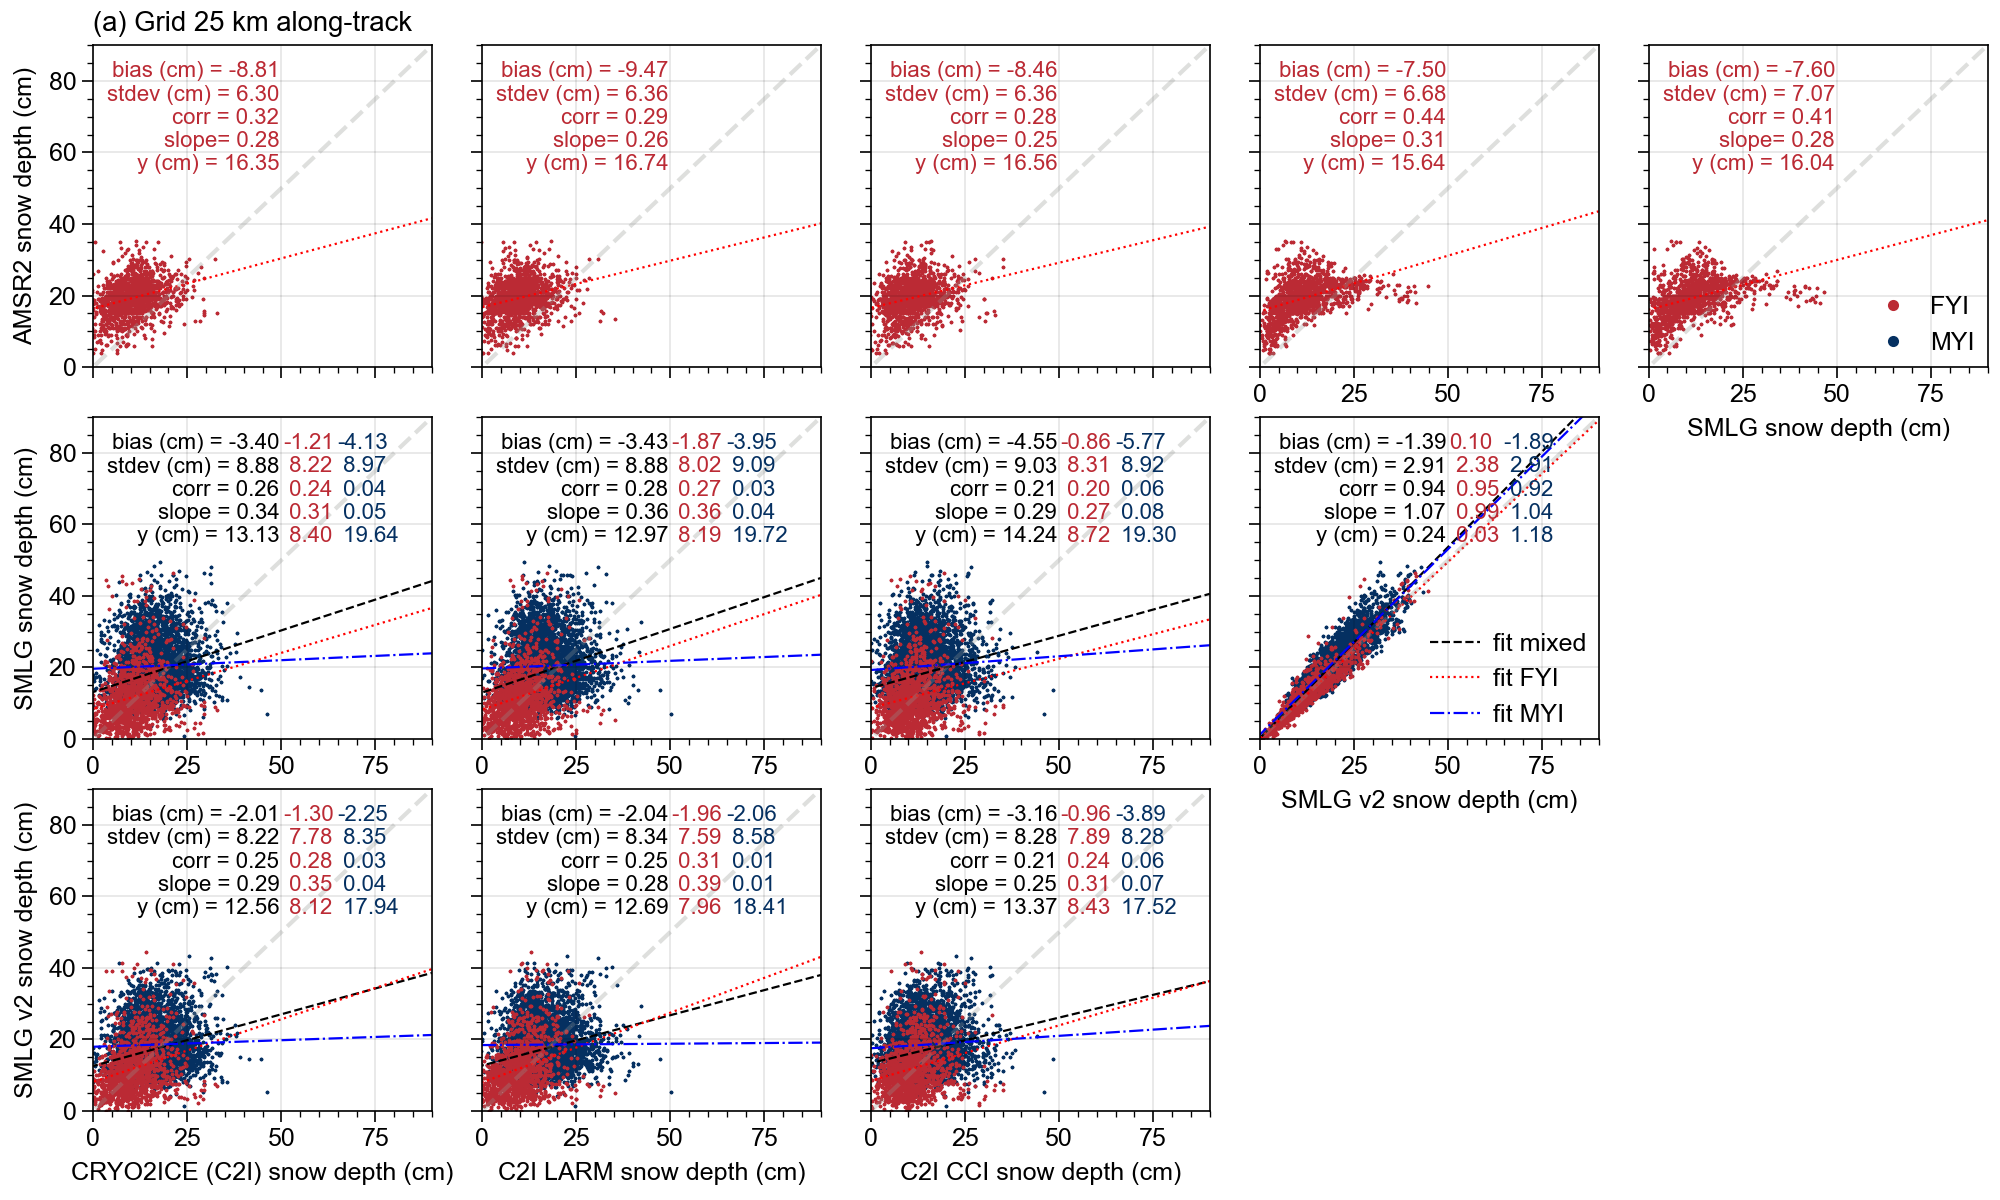

In [323]:
import proplot as pplt
fig = pplt.figure(space=2, figsize=(10,6), span=False, sharex=False)
ax = fig.subplots(nrows=3, ncols=5)
#fig, ax = plt.subplots(2, 3, figsize=(6,4), constrained_layout=True, sharey=True)

def plot_text(df, df_AMSR2, df_MYI, var1, var2, ax_def):
    bias = np.nanmean(df[var1]-df[var2])
    sd = np.nanstd(df[var1]-df[var2])
    corr = df[var1].corr(df[var2])
    x,y = df[var1],df[var2]
    coef = np.polyfit(x,y,1)
    x_new = np.arange(-50,100,10)
    polyval_predict = np.polyval(coef,x_new)
    ax_def.plot(x_new, polyval_predict, 'k', linewidth=0.8, linestyle='--')
    text_2 = "bias (cm) = {:.2f}".format(bias)
    text_3 = "\nstdev (cm) = {:.2f}".format(sd)
    text_4 = "\ncorr = {:.2f}".format(corr)
    text_5 = "\nslope = {:.2f}".format(coef[0])
    text_6 = "\ny (cm) = {:.2f}".format(coef[1])
    text_ax = text_2+text_3+text_4+text_5+text_6

    bias = np.nanmean(df_AMSR2[var1]-df_AMSR2[var2])
    sd = np.nanstd(df_AMSR2[var1]-df_AMSR2[var2])
    corr = df_AMSR2[var1].corr(df_AMSR2[var2])
    x,y = df_AMSR2[var1],df_AMSR2[var2]
    coef = np.polyfit(x,y,1)
    x_new = np.arange(-50,100,10)
    polyval_predict = np.polyval(coef,x_new)
    ax_def.plot(x_new, polyval_predict, 'r', linewidth=0.8, linestyle='dotted')
    text_2 = "{:.2f}".format(bias)
    text_3 = "\n {:.2f}".format(sd)
    text_4 = "\n {:.2f}".format(corr)
    text_5 = "\n {:.2f}".format(coef[0])
    text_6 = "\n {:.2f}".format(coef[1])
    text_ax2 = text_2+text_3+text_4+text_5+text_6

    bias = np.nanmean(df_MYI[var1]-df_MYI[var2])
    sd = np.nanstd(df_MYI[var1]-df_MYI[var2])
    corr = df_MYI[var1].corr(df_MYI[var2])
    x,y = df_MYI[var1],df_MYI[var2]
    coef = np.polyfit(x,y,1)
    x_new = np.arange(-50,100,10)
    polyval_predict = np.polyval(coef,x_new)
    ax_def.plot(x_new, polyval_predict, 'b', linewidth=0.8, linestyle='dashdot')
    text_2 = "{:.2f}".format(bias)
    text_3 = "\n {:.2f}".format(sd)
    text_4 = "\n {:.2f}".format(corr)
    text_5 = "\n {:.2f}".format(coef[0])
    text_6 = "\n {:.2f}".format(coef[1])
    text_ax3 = text_2+text_3+text_4+text_5+text_6
    #text_ax = "N = {}\nbias = {:.2f} cm\nstdev = {:.2f} cm\ncorr = {:.2f}\nslope= {:.2f}\nintercept = {:.2f} cm".format(len(df),bias, sd, corr, coef[0], coef[1])
    ax_def.text(0.55, 0.95, text_ax, transform=ax_def.transAxes, ha='right',fontsize=8, va='top')
    ax_def.text(0.56, 0.95, text_ax2, c=colours[1], transform=ax_def.transAxes, ha='left',fontsize=8, va='top')
    ax_def.text(0.72, 0.95, text_ax3, c=colours[4], transform=ax_def.transAxes, ha='left',fontsize=8, va='top')

df = CRYO2ICE_comb_all[(CRYO2ICE_comb_all['SMLG_snow_depth'].notna())&(CRYO2ICE_comb_all['C2I_snow'].notna()) & (CRYO2ICE_comb_all['C2I_LARM_snow'].notna()) & CRYO2ICE_comb_all['C2I_CCI_snow'].notna()]
df['snow_depth_original_MSS_unit_cm']=df['C2I_snow']*100
df['snow_depth_original_MSS_LARM_unit_cm']=df['C2I_LARM_snow']*100
df['snow_depth_original_MSS_CCI_unit_cm']=df['C2I_CCI_snow']*100
df['SMLG_snow_depth_unit_cm']=df['SMLG_snow_depth']*100
df['SMLG_snow_depth_v2_unit_cm']=df['SMLG_snow_depth_v2']*100
df_AMSR2 = df[df['AMSR2_snow_depth'].notna()]
df_MYI = df[df['AMSR2_snow_depth'].isnull()]

ax[0,0].scatter(df_AMSR2['snow_depth_original_MSS_unit_cm'], df_AMSR2['AMSR2_snow_depth'],s=0.5,c=colours[1])
ax[0,0].scatter(df_MYI['snow_depth_original_MSS_unit_cm'], df_MYI['AMSR2_snow_depth'],s=.5,c=colours[4])
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[0,0].format(xlabel='', ylabel='AMSR2 snow depth (cm)',  xticklabels=[])

ax[0,1].scatter(df_AMSR2['snow_depth_original_MSS_LARM_unit_cm'], df_AMSR2['AMSR2_snow_depth'],c=colours[1],s=0.5)
ax[0,1].scatter(df_MYI['snow_depth_original_MSS_LARM_unit_cm'], df_MYI['AMSR2_snow_depth'],c=colours[4],s=.5)#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[0,1].format(xlabel='', ylabel='AMSR2 snow depth (cm)',  xticklabels=[])

ax[0,2].scatter(df_AMSR2['snow_depth_original_MSS_CCI_unit_cm'], df_AMSR2['AMSR2_snow_depth'],c=colours[1],s=0.5)
ax[0,2].scatter(df_MYI['snow_depth_original_MSS_CCI_unit_cm'], df_MYI['AMSR2_snow_depth'],c=colours[4],s=.5)#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[0,2].format(xlabel='', ylabel='AMSR2 snow depth (cm)',  xticklabels=[])

ax[0,3].scatter(df_AMSR2['SMLG_snow_depth_v2_unit_cm'], df_AMSR2['AMSR2_snow_depth'],c=colours[1],s=0.5)
ax[0,3].scatter(df_MYI['SMLG_snow_depth_v2_unit_cm'], df_MYI['AMSR2_snow_depth'],c=colours[4],s=.5)#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[0,3].format(xlabel='', ylabel='AMSR2 snow depth (cm)')

ax[0,4].scatter(df_AMSR2['SMLG_snow_depth_unit_cm'], df_AMSR2['AMSR2_snow_depth'],c=colours[1],s=0.5)
ax[0,4].scatter(df_MYI['SMLG_snow_depth_unit_cm'], df_MYI['AMSR2_snow_depth'],c=colours[4],s=.5)#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[0,4].format(xlabel='SMLG snow depth (cm)', ylabel='AMSR2 snow depth (cm)')


ax[1,0].scatter(df_MYI['snow_depth_original_MSS_unit_cm'], df_MYI['SMLG_snow_depth_unit_cm'],s=.5,c=colours[4])
ax[1,0].scatter(df_AMSR2['snow_depth_original_MSS_unit_cm'], df_AMSR2['SMLG_snow_depth_unit_cm'],s=0.5,c=colours[1])
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[1,0].format(xlabel='', ylabel='SMLG snow depth (cm)')

ax[1,1].scatter(df_MYI['snow_depth_original_MSS_LARM_unit_cm'], df_MYI['SMLG_snow_depth_unit_cm'],s=.5,c=colours[4])
ax[1,1].scatter(df_AMSR2['snow_depth_original_MSS_LARM_unit_cm'], df_AMSR2['SMLG_snow_depth_unit_cm'],s=0.5,c=colours[1])
ax[1,1].format(xlabel='', ylabel='SMLG snow depth (cm)')

ax[1,2].scatter(df_MYI['snow_depth_original_MSS_CCI_unit_cm'], df_MYI['SMLG_snow_depth_unit_cm'],s=.5,c=colours[4])
ax[1,2].scatter(df_AMSR2['snow_depth_original_MSS_CCI_unit_cm'], df_AMSR2['SMLG_snow_depth_unit_cm'],s=0.5,c=colours[1])
ax[1,2].format(xlabel='', ylabel='SMLG snow depth (cm)')

ax[1,3].scatter(df_MYI['SMLG_snow_depth_v2_unit_cm'], df_MYI['SMLG_snow_depth_unit_cm'],s=.5,c=colours[4])
ax[1,3].scatter(df_AMSR2['SMLG_snow_depth_v2_unit_cm'], df_AMSR2['SMLG_snow_depth_unit_cm'],s=0.5,c=colours[1])

ax[1,3].format(xlabel='SMLG v2 snow depth (cm)', ylabel='SMLG snow depth (cm)')


##
ax[2,0].scatter(df_MYI['snow_depth_original_MSS_unit_cm'], df_MYI['SMLG_snow_depth_v2_unit_cm'],s=.5,c=colours[4])
ax[2,0].scatter(df_AMSR2['snow_depth_original_MSS_unit_cm'], df_AMSR2['SMLG_snow_depth_v2_unit_cm'],s=0.5,c=colours[1])
#plt.colorbar(im[3], label='density (bins of 80 x 80)',ax=ax[0], location='bottom')
ax[2,0].format(xlabel='CRYO2ICE (C2I) snow depth (cm)', ylabel='SMLG v2 snow depth (cm)')

ax[2,1].scatter(df_MYI['snow_depth_original_MSS_LARM_unit_cm'], df_MYI['SMLG_snow_depth_v2_unit_cm'],s=.5,c=colours[4])
ax[2,1].scatter(df_AMSR2['snow_depth_original_MSS_LARM_unit_cm'], df_AMSR2['SMLG_snow_depth_v2_unit_cm'],s=0.5,c=colours[1])
ax[2,1].format(xlabel='C2I LARM snow depth (cm)', ylabel='SMLG v2 snow depth (cm)')

ax[2,2].scatter(df_MYI['snow_depth_original_MSS_CCI_unit_cm'], df_MYI['SMLG_snow_depth_v2_unit_cm'],s=.5,c=colours[4])
ax[2,2].scatter(df_AMSR2['snow_depth_original_MSS_CCI_unit_cm'], df_AMSR2['SMLG_snow_depth_v2_unit_cm'],s=0.5,c=colours[1])
ax[2,2].format(xlabel='C2I CCI snow depth (cm)', ylabel='SMLG v2 snow depth (cm)')


#ax[1].set_ylabel('differnece in laser and radar freeboard (IS2-CS2) (m)')
#CRYO2ICE_LARM_SMLG_coinident['snow_depth_original_MSS_LARM'].corr(CRYO2ICE_LARM_SMLG_coinident['SMLG_snow_depth'])
#plt.colorbar(im[3], label='density (bins of 80 x80)',ax=ax[1,1])


## ROW 1
bias = np.nanmean(df_AMSR2['snow_depth_original_MSS_unit_cm']-df_AMSR2['AMSR2_snow_depth'])
sd = np.nanstd(df_AMSR2['snow_depth_original_MSS_unit_cm']-df_AMSR2['AMSR2_snow_depth'])
corr = df_AMSR2['snow_depth_original_MSS_unit_cm'].corr(df_AMSR2['AMSR2_snow_depth'])
x,y = df_AMSR2['snow_depth_original_MSS_unit_cm'],df_AMSR2['AMSR2_snow_depth']
coef = np.polyfit(x,y,1)
x_new = np.arange(-50,100,10)
polyval_predict = np.polyval(coef,x_new)
ax[0,0].plot(x_new, polyval_predict, 'r', linewidth=0.8, linestyle='dotted')
text_ax = "bias (cm) = {:.2f}\nstdev (cm) = {:.2f}\ncorr = {:.2f}\nslope= {:.2f}\ny (cm) = {:.2f}".format(bias, sd, corr, coef[0], coef[1])
ax[0,0].text(0.55, 0.95, text_ax, transform=ax[0,0].transAxes, ha='right',va='top', c=colours[1], fontsize=8)


bias = np.nanmean(df_AMSR2['snow_depth_original_MSS_LARM_unit_cm']-df_AMSR2['AMSR2_snow_depth'])
sd = np.nanstd(df_AMSR2['snow_depth_original_MSS_LARM_unit_cm']-df_AMSR2['AMSR2_snow_depth'])
corr = df_AMSR2['snow_depth_original_MSS_LARM_unit_cm'].corr(df_AMSR2['AMSR2_snow_depth'])
x,y = df_AMSR2['snow_depth_original_MSS_LARM_unit_cm'],df_AMSR2['AMSR2_snow_depth']
coef = np.polyfit(x,y,1)
x_new = np.arange(-50,100,10)
polyval_predict = np.polyval(coef,x_new)
ax[0,1].plot(x_new, polyval_predict, 'r', linewidth=0.8, linestyle='dotted')
text_ax = "bias (cm) = {:.2f}\nstdev (cm) = {:.2f}\ncorr = {:.2f}\nslope= {:.2f}\ny (cm) = {:.2f}".format(bias, sd, corr, coef[0], coef[1])
ax[0,1].text(0.55, 0.95, text_ax, transform=ax[0,1].transAxes, ha='right', va='top',c=colours[1], fontsize=8)

bias = np.nanmean(df_AMSR2['snow_depth_original_MSS_CCI_unit_cm']-df_AMSR2['AMSR2_snow_depth'])
sd = np.nanstd(df_AMSR2['snow_depth_original_MSS_CCI_unit_cm']-df_AMSR2['AMSR2_snow_depth'])
corr = df_AMSR2['snow_depth_original_MSS_CCI_unit_cm'].corr(df_AMSR2['AMSR2_snow_depth'])
x,y = df_AMSR2['snow_depth_original_MSS_CCI_unit_cm'],df_AMSR2['AMSR2_snow_depth']
coef = np.polyfit(x,y,1)
x_new = np.arange(-50,100,10)
polyval_predict = np.polyval(coef,x_new)
ax[0,2].plot(x_new, polyval_predict, 'r', linewidth=0.8, linestyle='dotted')
text_ax = "bias (cm) = {:.2f}\nstdev (cm) = {:.2f}\ncorr = {:.2f}\nslope= {:.2f}\ny (cm) = {:.2f}".format(bias, sd, corr, coef[0], coef[1])
ax[0,2].text(0.55, 0.95,text_ax, transform=ax[0,2].transAxes, ha='right', va='top',c=colours[1], fontsize=8)

bias = np.nanmean(df_AMSR2['SMLG_snow_depth_v2_unit_cm']-df_AMSR2['AMSR2_snow_depth'])
sd = np.nanstd(df_AMSR2['SMLG_snow_depth_v2_unit_cm']-df_AMSR2['AMSR2_snow_depth'])
corr = df_AMSR2['SMLG_snow_depth_v2_unit_cm'].corr(df_AMSR2['AMSR2_snow_depth'])
x,y = df_AMSR2['SMLG_snow_depth_v2_unit_cm'],df_AMSR2['AMSR2_snow_depth']
coef = np.polyfit(x,y,1)
x_new = np.arange(-50,100,10)
polyval_predict = np.polyval(coef,x_new)
ax[0,3].plot(x_new, polyval_predict, 'r', linewidth=0.8, linestyle='dotted')
text_ax = "bias (cm) = {:.2f}\nstdev (cm) = {:.2f}\ncorr = {:.2f}\nslope= {:.2f}\ny (cm) = {:.2f}".format(bias, sd, corr, coef[0], coef[1])
ax[0,3].text(0.55, 0.95, text_ax, transform=ax[0,3].transAxes, ha='right', va='top', c=colours[1], fontsize=8)


bias = np.nanmean(df_AMSR2['SMLG_snow_depth_unit_cm']-df_AMSR2['AMSR2_snow_depth'])
sd = np.nanstd(df_AMSR2['SMLG_snow_depth_unit_cm']-df_AMSR2['AMSR2_snow_depth'])
corr = df_AMSR2['SMLG_snow_depth_unit_cm'].corr(df_AMSR2['AMSR2_snow_depth'])
x,y = df_AMSR2['SMLG_snow_depth_unit_cm'],df_AMSR2['AMSR2_snow_depth']
coef = np.polyfit(x,y,1)
x_new = np.arange(-50,100,10)
polyval_predict = np.polyval(coef,x_new)
ax[0,4].plot(x_new, polyval_predict, 'r', linewidth=0.8, linestyle='dotted')
text_ax = "bias (cm) = {:.2f}\nstdev (cm) = {:.2f}\ncorr = {:.2f}\nslope= {:.2f}\ny (cm) = {:.2f}".format(bias, sd, corr, coef[0], coef[1])
ax[0,4].text(0.55, 0.95,text_ax, transform=ax[0,4].transAxes, ha='right',va='top', c=colours[1], fontsize=8)



## ROW 2
plot_text(df, df_AMSR2, df_MYI, 'snow_depth_original_MSS_unit_cm', 'SMLG_snow_depth_unit_cm', ax[1,0])
plot_text(df, df_AMSR2, df_MYI, 'snow_depth_original_MSS_LARM_unit_cm', 'SMLG_snow_depth_unit_cm', ax[1,1])
plot_text(df, df_AMSR2, df_MYI, 'snow_depth_original_MSS_CCI_unit_cm', 'SMLG_snow_depth_unit_cm', ax[1,2])
plot_text(df, df_AMSR2, df_MYI, 'SMLG_snow_depth_v2_unit_cm', 'SMLG_snow_depth_unit_cm', ax[1,3])

## ROW 3
plot_text(df, df_AMSR2, df_MYI, 'snow_depth_original_MSS_unit_cm', 'SMLG_snow_depth_v2_unit_cm', ax[2,0])
plot_text(df, df_AMSR2, df_MYI, 'snow_depth_original_MSS_LARM_unit_cm', 'SMLG_snow_depth_v2_unit_cm', ax[2,1])
plot_text(df, df_AMSR2, df_MYI, 'snow_depth_original_MSS_CCI_unit_cm', 'SMLG_snow_depth_v2_unit_cm', ax[2,2])


ax[1, 4].set_visible(False)
ax[2, 4].set_visible(False)
ax[2, 3].set_visible(False)
ax.format(
     xlim=(0, 90), ylim=(0, 90),rc_kw={'abc.weight':'normal'}
)
ax[0,0].format(
title='(a) Grid 25 km along-track',titleloc='l',rc_kw={'abc.weight':'bold'}
)
#ax[0,4].colorbar(im[3], label='density (bins of 50 x 50)', loc='r')

ax[0,0].plot(np.arange(-50,100,10),np.arange(-50,100,10), color='grey', alpha=0.3, linestyle='--')
ax[0,1].plot(np.arange(-50,100,10),np.arange(-50,100,10), color='grey', alpha=0.3, linestyle='--')
ax[0,2].plot(np.arange(-50,100,10),np.arange(-50,100,10), color='grey', alpha=0.3, linestyle='--')
ax[0,3].plot(np.arange(-50,100,10),np.arange(-50,100,10), color='grey', alpha=0.3, linestyle='--')
ax[0,4].plot(np.arange(-50,100,10),np.arange(-50,100,10), color='grey', alpha=0.3, linestyle='--')

ax[1,0].plot(np.arange(-50,100,10),np.arange(-50,100,10), color='grey', alpha=0.3, linestyle='--')
ax[1,1].plot(np.arange(-50,100,10),np.arange(-50,100,10), color='grey', alpha=0.3, linestyle='--')
ax[1,2].plot(np.arange(-50,100,10),np.arange(-50,100,10), color='grey', alpha=0.3, linestyle='--')
ax[1,3].plot(np.arange(-50,100,10),np.arange(-50,100,10), color='grey', alpha=0.3, linestyle='--')

ax[2,0].plot(np.arange(-50,100,10),np.arange(-50,100,10), color='grey', alpha=0.3, linestyle='--')
ax[2,1].plot(np.arange(-50,100,10),np.arange(-50,100,10), color='grey', alpha=0.3, linestyle='--')
ax[2,2].plot(np.arange(-50,100,10),np.arange(-50,100,10), color='grey', alpha=0.3, linestyle='--')


legend_elements = [Line2D([0], [0],color='k', label='fit mixed', linestyle='--', linewidth=0.8),
                  Line2D([0], [0],color='r', label='fit FYI', linestyle='dotted', linewidth=0.8),
                  Line2D([0], [0],color='b', label='fit MYI', linestyle='dashdot', linewidth=0.8)]

ax[1,3].legend(handles=legend_elements, loc='lower right', fontsize=4,frameon=False, ncol=1)

legend_elements = [Line2D([0], [0],color=colours[1], label='FYI', linestyle='',marker='.', linewidth=0.8),
                  Line2D([0], [0],color=colours[4], label='MYI', linestyle='',marker='.',linewidth=0.8)]

ax[0,4].legend(handles=legend_elements, loc='lower right', fontsize=6,frameon=False, ncol=1)


#plt.savefig('E:\demo_CRYO2ICE_overall_comp_statistics_gridded_data_along_track_MYI_FYI_sep_original_function.png', dpi=300)

Text(0.5, 1.0, 'April 2021')

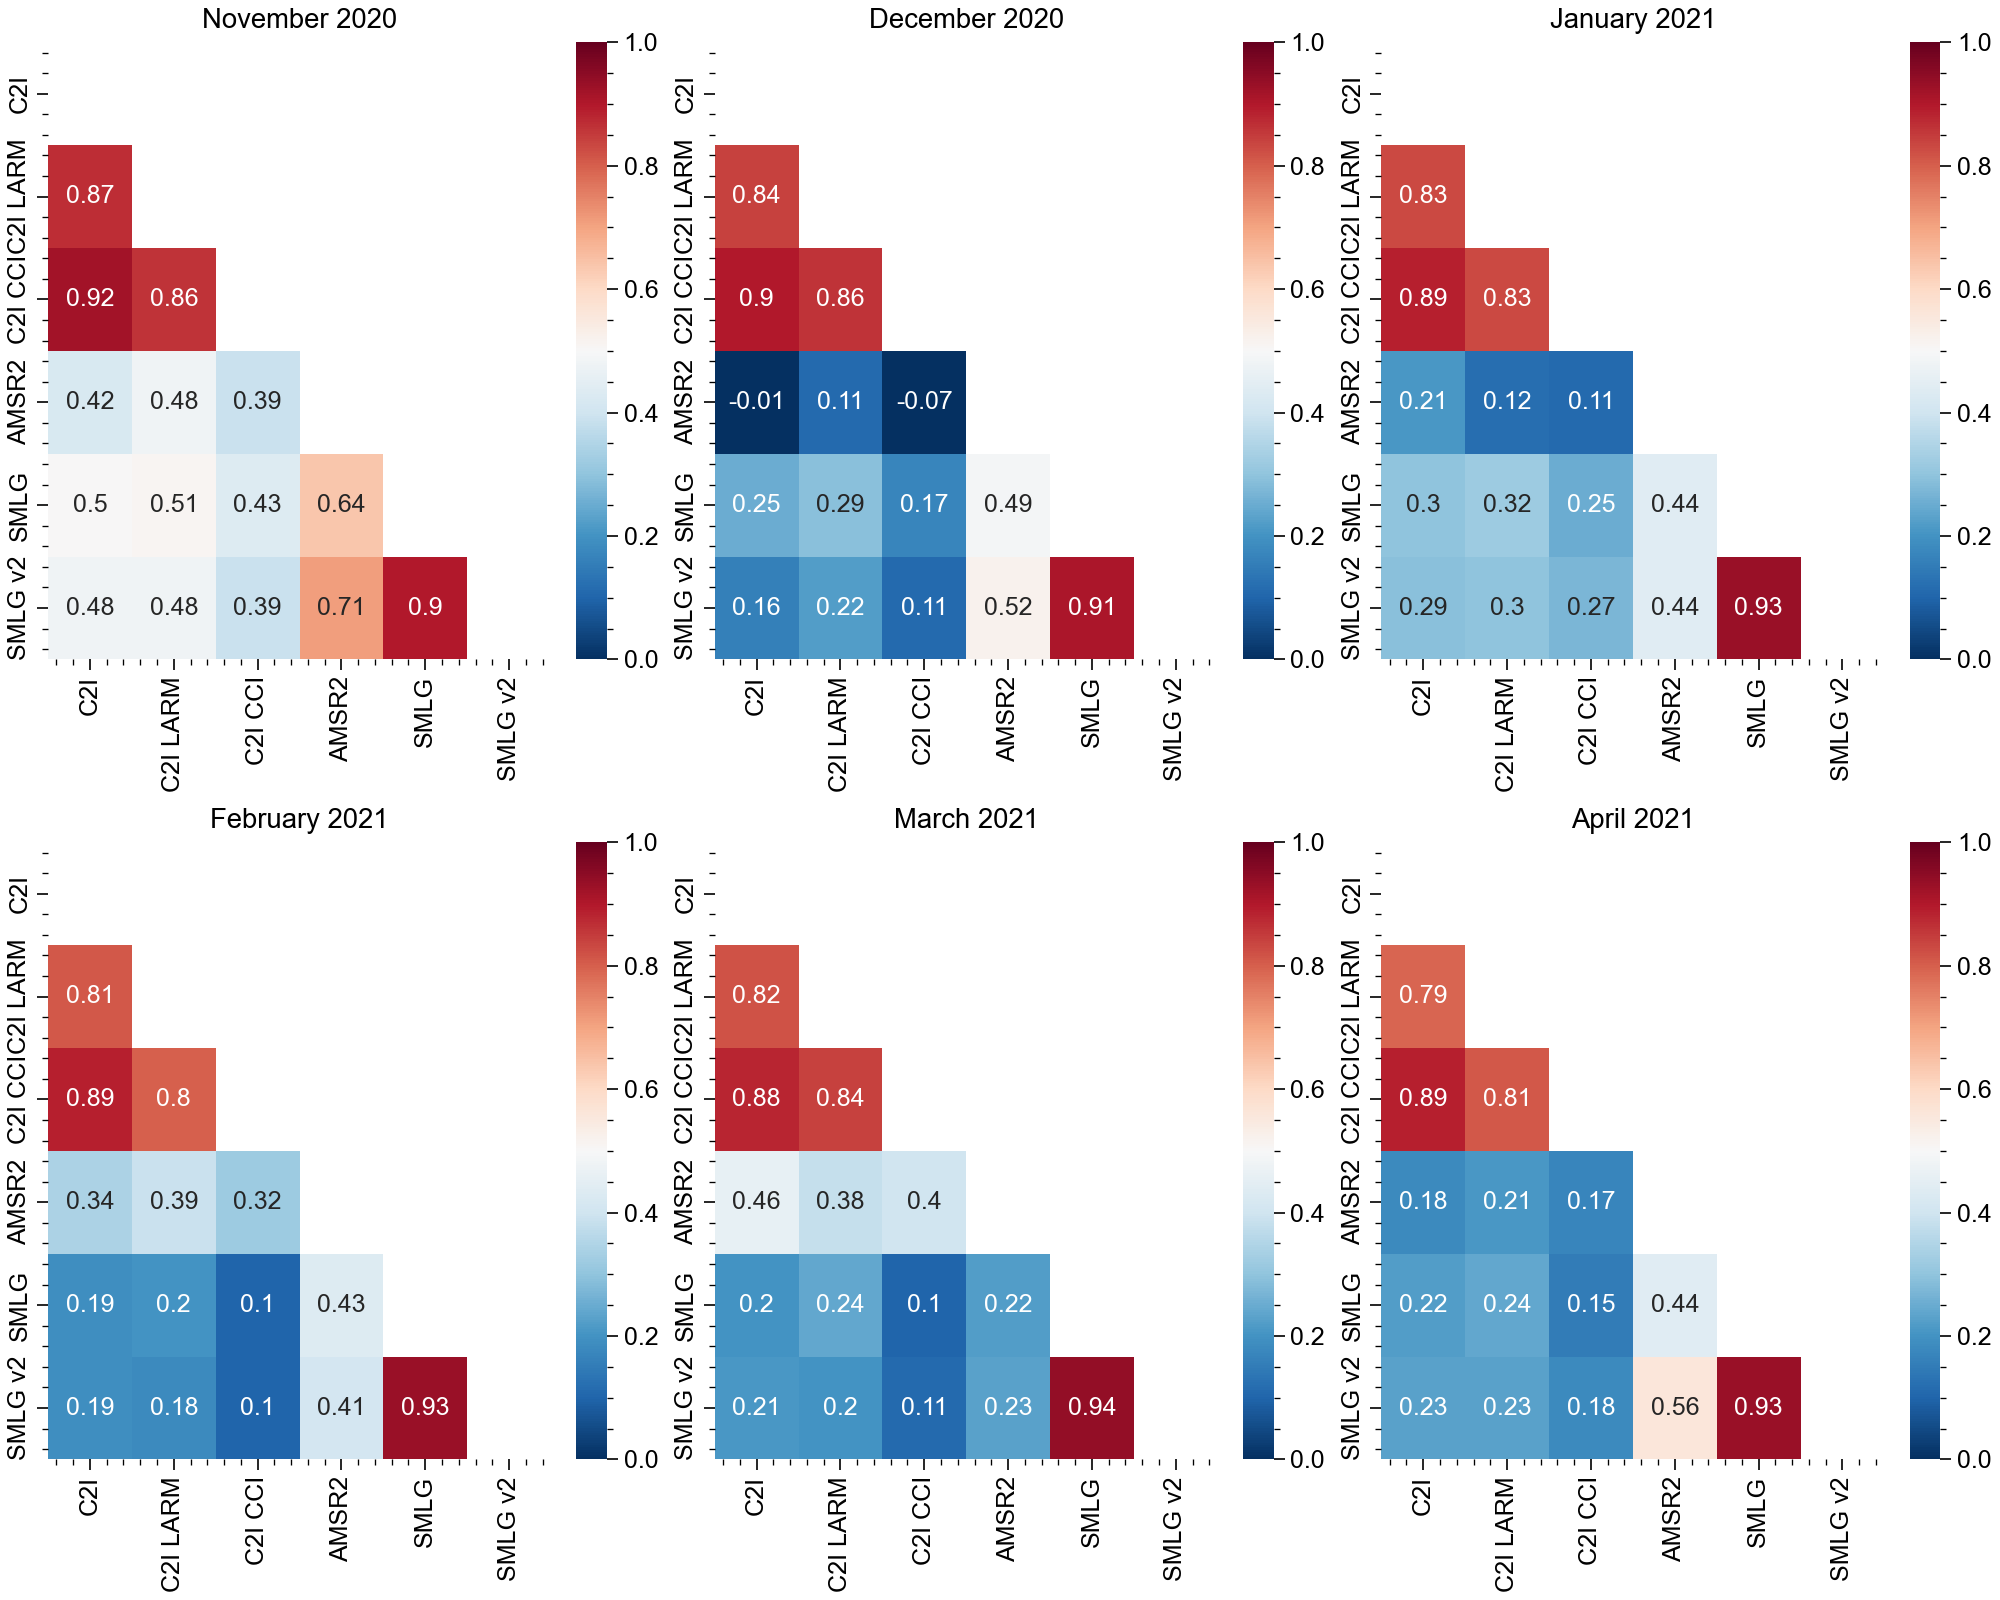

In [324]:
import seaborn as sns

grid_use = CRYO2ICE_comb_all[['C2I_snow', 'C2I_LARM_snow', 'C2I_CCI_snow', 'AMSR2_snow_depth', 'SMLG_snow_depth', 'SMLG_snow_depth_v2', 'AMSR2_snow_depth', 'SMLG_snow_depth', 'SMLG_snow_depth_v2']]
#grid_use = df_grid_dec[['lowess_snow_depth_original_MSS', 'lowess_snow_depth_original_MSS_LARM', 'lowess_snow_depth_original_MSS_CCI', 'AMSR2_snow_depth', 'SMLG_snow_depth', 'SMLG_snow_depth_v2']]

columns=['C2I_snow', 'C2I_LARM_snow', 'C2I_CCI_snow', 'AMSR2_snow_depth', 'SMLG_snow_depth', 'SMLG_snow_depth_v2']

fig, ax=plt.subplots(2,3,figsize=(10,8),constrained_layout=True)

axes=ax[0,0]
matrix = CRYO2ICE_nov[columns].corr().round(2)
mask = np.triu(np.ones_like(matrix, dtype=bool))
labels=['C2I', 'C2I LARM', 'C2I CCI', 'AMSR2', 'SMLG', 'SMLG v2']
sns.heatmap(matrix, annot=True, vmax=1, vmin=0, center=0.5, cmap='RdBu_r',mask=mask, xticklabels=labels,yticklabels=labels,ax=axes)
axes.set_title('November 2020')

axes=ax[0,1]
matrix = CRYO2ICE_dec[columns].corr().round(2)
mask = np.triu(np.ones_like(matrix, dtype=bool))
labels=['C2I', 'C2I LARM', 'C2I CCI', 'AMSR2', 'SMLG', 'SMLG v2']
sns.heatmap(matrix, annot=True, vmax=1, vmin=0, center=0.5, cmap='RdBu_r',mask=mask, xticklabels=labels,yticklabels=labels,ax=axes)
axes.set_title('December 2020')

axes=ax[0,2]
matrix = CRYO2ICE_jan[columns].corr().round(2)
mask = np.triu(np.ones_like(matrix, dtype=bool))
labels=['C2I', 'C2I LARM', 'C2I CCI', 'AMSR2', 'SMLG', 'SMLG v2']
sns.heatmap(matrix, annot=True, vmax=1, vmin=0, center=0.5, cmap='RdBu_r',mask=mask, xticklabels=labels,yticklabels=labels,ax=axes)
axes.set_title('January 2021')

axes=ax[1,0]
matrix = CRYO2ICE_feb[columns].corr().round(2)
mask = np.triu(np.ones_like(matrix, dtype=bool))
labels=['C2I', 'C2I LARM', 'C2I CCI', 'AMSR2', 'SMLG', 'SMLG v2']
sns.heatmap(matrix, annot=True, vmax=1, vmin=0, center=0.5, cmap='RdBu_r',mask=mask, xticklabels=labels,yticklabels=labels,ax=axes)
axes.set_title('February 2021')

axes=ax[1,1]
matrix = CRYO2ICE_mar[columns].corr().round(2)
mask = np.triu(np.ones_like(matrix, dtype=bool))
labels=['C2I', 'C2I LARM', 'C2I CCI', 'AMSR2', 'SMLG', 'SMLG v2']
sns.heatmap(matrix, annot=True, vmax=1, vmin=0, center=0.5, cmap='RdBu_r',mask=mask, xticklabels=labels,yticklabels=labels,ax=axes)
axes.set_title('March 2021')

axes=ax[1,2]
matrix = CRYO2ICE_apr[columns].corr().round(2)
mask = np.triu(np.ones_like(matrix, dtype=bool))
labels=['C2I', 'C2I LARM', 'C2I CCI', 'AMSR2', 'SMLG', 'SMLG v2']
sns.heatmap(matrix, annot=True, vmax=1, vmin=0, center=0.5, cmap='RdBu_r',mask=mask, xticklabels=labels,yticklabels=labels,ax=axes)
axes.set_title('April 2021')


#plt.savefig('E:\demo_CRYO2ICE_overall_comp_statistics_gridded_alongtrack_correlation_lowess_original_function.png', dpi=300)

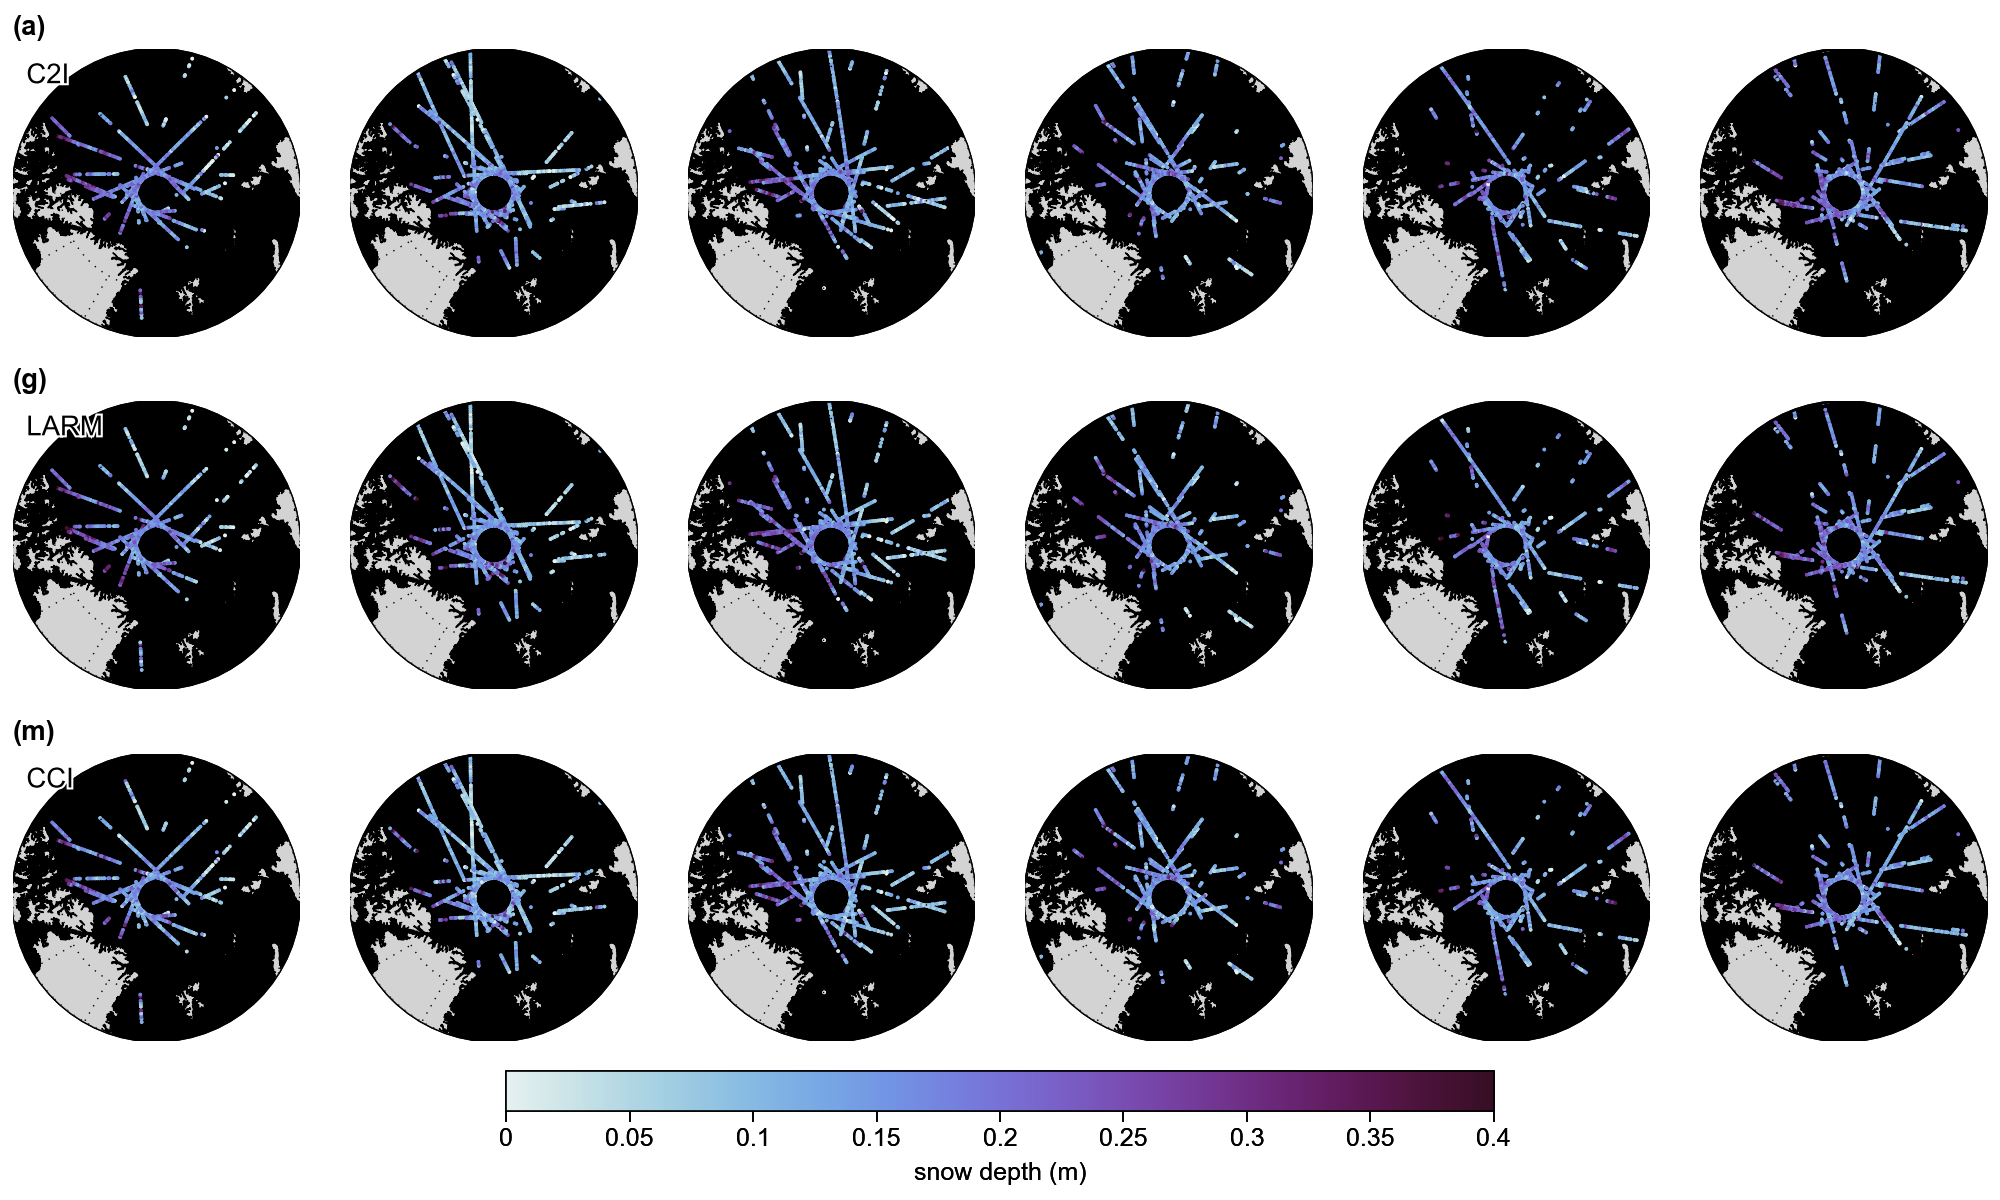

In [326]:
def plot_panArctic10(lon, lat, sit, min_set, max_set, cmap_set, label, extend_info, ax, fig):
    #fig = plt.figure(figsize=(6,5))
    fig.patch.set_facecolor('white')
    #ax = plt.gca()
    #m = Basemap(projection='ortho',lat_0=90,lon_0=0,resolution='l', ax=ax);
    x1 = -180
    x2 = 180
    y1 = 0
    y2 = 90
    cmap1 = plt.get_cmap('greys', 4)

    m = Basemap(projection='npstere', llcrnrlat=y1,urcrnrlat=y2,llcrnrlon=x1,urcrnrlon=x2,boundinglat=75,lon_0=0, resolution='i',ax=ax, round=True)
    m.drawmeridians(np.arange(0,360,30),labels=[0,0,0,0],linewidth=0.5, fontsize=10, dashes=[1,5])
    m.drawparallels(np.arange(-90,90,15),linewidth=0.5, fontsize=10, dashes=[1,5],labels=[0,0,0,0])
    m.drawcoastlines(linewidth=0.5)
    m.fillcontinents(color='lightgray')
    #m.fillcontinents(color='darkgray')
    m.drawmapboundary(fill_color='black')
    #cbar = m.etopo()
    x=m.scatter(lon, lat, latlon=True, c=sit, s=0.5,vmin = min_set, vmax=max_set, cmap=cmap_set, zorder=1)
     #cbar = plt.colorbar(x, extend =extend_info, orientation="horizontal",ax=ax)
    #cbar.set_label(label)

    ax.set_title(title, y=1.08,fontsize=18)
    return x

from matplotlib.lines import Line2D
import proplot as pplt
#fig, ax = plt.subplots(ncols=6, nrows=3, figsize=(10,6), constrained_layout=True)

fig = pplt.figure(space=2, figsize=(10,6), span=False, sharex=False, sharey=True)
ax = fig.subplots(nrows=3,ncols=6)

title = ''
#im = plot_panArctic8(lon, lat, missing_snow_depth, 0, 50, 'red', 'radar freeboard (m)','max', ax,fig)
#im = plot_panArctic8(lon, lat, land_snow_depth, 0, 50, 'brown', 'radar freeboard (m)','max', ax,fig)
#im = plot_panArctic8(lon, lat, OW_snow_depth, 0, 50, 'blue', 'radar freeboard (m)','max', ax,fig)
#im = plot_panArctic8(lon, lat, MYI_snow_depth, 0, 50, 'grey', 'radar freeboard (m)','max', ax,fig)
#im = plot_panArctic8(lon, lat, variability_snow_depth, 0, 50, 'magenta', 'radar freeboard (m)','max', ax,fig)
#im = plot_panArctic8(lon, lat, melt_snow_depth, 0, 50, 'orange', 'radar freeboard (m)','max', ax,fig)

cmap = 'Dense'

nmax = 0.4
val1, val2, val3 = 'C2I_snow', 'C2I_LARM_snow', 'C2I_CCI_snow'
lon_flat, lat_flat = CRYO2ICE_nov['lon'], CRYO2ICE_nov['lat']
im = plot_panArctic10(CRYO2ICE_nov['lon'], CRYO2ICE_nov['lat'], CRYO2ICE_nov[val1], 0, nmax, cmap, 'radar freeboard (m)','max', ax[0, 0],fig)
im = plot_panArctic10(CRYO2ICE_nov['lon'], CRYO2ICE_nov['lat'], CRYO2ICE_nov[val2], 0,nmax, cmap, 'radar freeboard (m)','max', ax[1, 0],fig)
im = plot_panArctic10(CRYO2ICE_nov['lon'], CRYO2ICE_nov['lat'], CRYO2ICE_nov[val3], 0, nmax, cmap, 'radar freeboard (m)','max', ax[2, 0],fig)

lon_flat, lat_flat = CRYO2ICE_dec['lon'], CRYO2ICE_dec['lat']
im = plot_panArctic10(lon_flat, lat_flat, CRYO2ICE_dec[val1], 0,nmax, cmap, 'radar freeboard (m)','max', ax[0, 1],fig)
im = plot_panArctic10(lon_flat, lat_flat, CRYO2ICE_dec[val2], 0, nmax, cmap, 'radar freeboard (m)','max', ax[1, 1],fig)
im = plot_panArctic10(lon_flat, lat_flat, CRYO2ICE_dec[val3], 0, nmax, cmap, 'radar freeboard (m)','max', ax[2, 1],fig)

lon_flat, lat_flat = CRYO2ICE_jan['lon'], CRYO2ICE_jan['lat']
im = plot_panArctic10(lon_flat, lat_flat, CRYO2ICE_jan[val1], 0, nmax, cmap, 'radar freeboard (m)','max', ax[0, 2],fig)
im = plot_panArctic10(lon_flat, lat_flat, CRYO2ICE_jan[val2], 0, nmax, cmap, 'radar freeboard (m)','max', ax[1, 2],fig)
im = plot_panArctic10(lon_flat, lat_flat, CRYO2ICE_jan[val3], 0, nmax, cmap, 'radar freeboard (m)','max', ax[2, 2],fig)

lon_flat, lat_flat = CRYO2ICE_feb['lon'], CRYO2ICE_feb['lat']
im = plot_panArctic10(lon_flat, lat_flat, CRYO2ICE_feb[val1], 0, nmax, cmap, 'radar freeboard (m)','max', ax[0, 3],fig)
im = plot_panArctic10(lon_flat, lat_flat, CRYO2ICE_feb[val2], 0, nmax, cmap, 'radar freeboard (m)','max', ax[1, 3],fig)
im = plot_panArctic10(lon_flat, lat_flat, CRYO2ICE_feb[val3], 0, nmax, cmap, 'radar freeboard (m)','max', ax[2, 3],fig)

lon_flat, lat_flat = CRYO2ICE_mar['lon'], CRYO2ICE_mar['lat']
im = plot_panArctic10(lon_flat, lat_flat, CRYO2ICE_mar[val1], 0, nmax, cmap, 'radar freeboard (m)','max', ax[0, 4],fig)
im = plot_panArctic10(lon_flat, lat_flat, CRYO2ICE_mar[val2], 0, nmax, cmap, 'radar freeboard (m)','max', ax[1, 4],fig)
im = plot_panArctic10(lon_flat, lat_flat, CRYO2ICE_mar[val3], 0, nmax, cmap, 'radar freeboard (m)','max', ax[2, 4],fig)

lon_flat, lat_flat = CRYO2ICE_apr['lon'], CRYO2ICE_apr['lat']
im = plot_panArctic10(lon_flat, lat_flat, CRYO2ICE_apr[val1], 0, nmax, cmap, 'radar freeboard (m)','max', ax[0, 5],fig)
im = plot_panArctic10(lon_flat, lat_flat, CRYO2ICE_apr[val2], 0, nmax, cmap, 'radar freeboard (m)','max', ax[1, 5],fig)
im = plot_panArctic10(lon_flat, lat_flat, CRYO2ICE_apr[val3], 0, nmax, cmap, 'radar freeboard (m)','max', ax[2, 5],fig)

#im = plot_panArctic6(lon, lat, grid_mean_snow_depth_original_MSS_LARM, 0, 0.5, cmap, 'radar freeboard (m)','max', ax[0, 1],fig)
#im = plot_panArctic6(lon, lat, grid_median_snow_depth_original_MSS, 0, 0.5, cmap, 'radar freeboard (m)','max', ax[1, 0],fig)
#im = plot_panArctic6(lon, lat, grid_median_snow_depth_original_MSS_LARM, 0, 0.5, cmap, 'radar freeboard (m)','max', ax[1, 1],fig)

fig.colorbar(im, orientation = 'horizontal', label='snow depth (m)', loc='bottom', length=0.5)

ax[0,0].format(abc='(a)', ultitle='C2I')
ax[1,0].format(abc='(a)', ultitle='LARM')
ax[2,0].format(abc='(a)', ultitle='CCI')

#plt.savefig('E:\CRYO2ICE_gridded_along_track_snow_depths_comparison_new_func.png', transparent=True)

In [ ]:
CRYO2ICE_nov

In [ ]:
print(len(CRYO2ICE_nov))
print(len(CRYO2ICE_dec))
print(len(CRYO2ICE_jan))
print(len(CRYO2ICE_feb))
print(len(CRYO2ICE_mar))
print(len(CRYO2ICE_apr))

In [ ]:
CRYO2ICE_nov

In [ ]:
files_check_CS2_L2 = !ls E:/DTU/CRYO2ICE/Data/CRYO2ICE_original_MSS/FINAL_SMLG_AMSR2_CCI_LARM_ERA5_v2_lowess/*_LARM_AMSR2_SMLG_ERA5_final_v2_lowess.csv
    
list_total = np.arange(0, len(files_check_CS2_L2))
for k in list_total:
    fp1 = files_check_CS2_L2[k]
    basename_without_ext = os.path.splitext(os.path.basename(files_check_CS2_L2[k]))[0]
    print('File '+str(k)+'/'+str(len(list_total))+ ': ' + basename_without_ext)
    df_jan = pd.read_csv(fp1, index_col=None, header=0)
    
    print('Gridding begun...')
    j=25e3 # in metres
    idx_multiplic = int(np.floor(np.max(df_jan['along_track_dist_in_metres'])/j))
    new_idx = np.arange(0+j/2, idx_multiplic*j, j)

    lat_new, lon_new, C2I_new, C2I_LARM_new, C2I_CCI_new, AMSR2_new, SMLGv1_new, SMLGv2_new = np.empty(len(new_idx)), np.empty(len(new_idx)), np.empty(len(new_idx)), np.empty(len(new_idx)), np.empty(len(new_idx)), np.empty(len(new_idx)), np.empty(len(new_idx)), np.empty(len(new_idx))
    for i in np.arange(0, len(new_idx)):
        bol=df_jan['along_track_dist_in_metres']-new_idx[i]
        idx = np.where(abs(bol)<=j/2)
        if len(idx) >=1:
            lat_new[i] = np.nanmedian(df_jan['lat'].iloc[idx])
            lon_new[i] = np.nanmedian(df_jan['lon'].iloc[idx])
            C2I_new[i] = np.nanmedian(df_jan['lowess_snow_depth_original_MSS'].iloc[idx])
            C2I_LARM_new[i] = np.nanmedian(df_jan['lowess_snow_depth_original_MSS_LARM'].iloc[idx])
            C2I_CCI_new[i] = np.nanmedian(df_jan['lowess_snow_depth_original_MSS_CCI'].iloc[idx])
            AMSR2_new[i] = np.nanmedian(df_jan['AMSR2_snow_depth'].iloc[idx])
            SMLGv1_new[i] = np.nanmedian(df_jan['SMLG_snow_depth'].iloc[idx])
            SMLGv2_new[i] = np.nanmedian(df_jan['SMLG_snow_depth_v2'].iloc[idx])
        else:
            lat_new[i] = np.nan
            lon_new[i] = np.nan
            C2I_new[i] = np.nan
            C2I_LARM_new[i] = np.nan
            C2I_CCI_new[i] = np.nan
            AMSR2_new[i] = np.nan
            SMLGv1_new[i] = np.nan
            SMLGv2_new[i] = np.nan

    df_grid = pd.DataFrame({'lat':lat_new, 'lon':lon_new,'along_track_dist_in_metres':new_idx, 'lowess_snow_depth_original_MSS':C2I_new, 'lowess_snow_depth_original_MSS_LARM':C2I_LARM_new,
             'lowess_snow_depth_original_MSS_CCI':C2I_CCI_new, 'AMSR2_snow_depth':AMSR2_new, 'SMLG_snow_depth':SMLGv1_new, 
             'SMLG_snow_depth_v2':SMLGv2_new})

    print('Saving data...')
    path='E:/DTU/CRYO2ICE'
    resolution_name='25km_corrected_snow_depth_lowess_new_func'
    df_grid.to_csv(path+'/'+basename_without_ext+'_gridded_'+resolution_name+'.csv')

    print('Analysis finished. Data available in CRYO2ICE-folder.')
  

print('Analysis finalized. All data processed whenever possible.')



In [315]:
files_check_CS2_L2 = !ls E:/DTU/CRYO2ICE/Data/CRYO2ICE_original_MSS/FINAL_SMLG_AMSR2_CCI_LARM_ERA5_v2_lowess/*_LARM_AMSR2_SMLG_ERA5_final_v2_lowess.csv
    
list_total = np.arange(0, len(files_check_CS2_L2))
for k in list_total:
    fp1 = files_check_CS2_L2[k]
    basename_without_ext = os.path.splitext(os.path.basename(files_check_CS2_L2[k]))[0]
    print('File '+str(k)+'/'+str(len(list_total))+ ': ' + basename_without_ext)
    df_jan = pd.read_csv(fp1, index_col=None, header=0)
    
    print('Gridding begun...')
    j=25e3 # in metres
    idx_multiplic = int(np.floor(np.max(df_jan['along_track_dist_in_metres'])/j))
    new_idx = np.arange(0+j/2, idx_multiplic*j, j)

    lat_new, lon_new, C2I_new, C2I_LARM_new, C2I_CCI_new, AMSR2_new, SMLGv1_new, SMLGv2_new, IS2_new = np.empty(len(new_idx)),np.empty(len(new_idx)), np.empty(len(new_idx)), np.empty(len(new_idx)), np.empty(len(new_idx)), np.empty(len(new_idx)), np.empty(len(new_idx)), np.empty(len(new_idx)), np.empty(len(new_idx))
    for i in np.arange(0, len(new_idx)):
        bol=df_jan['along_track_dist_in_metres']-new_idx[i]
        idx = np.where(abs(bol)<=j/2)
        if len(idx) >=1:
            lat_new[i] = np.nanmean(df_jan['lat'].iloc[idx])
            lon_new[i] = np.nanmean(df_jan['lon'].iloc[idx])
            C2I_new[i] = np.nanmean(df_jan['fb'].iloc[idx])
            C2I_LARM_new[i] = np.nanmean(df_jan['LARM_rfb'].iloc[idx])
            C2I_CCI_new[i] = np.nanmean(df_jan['CCI_rfb'].iloc[idx])
            IS2_new[i] = np.nanmean(df_jan['IS2_w_mean_fb_MSS'].iloc[idx])
            AMSR2_new[i] = np.nanmean(df_jan['AMSR2_snow_depth'].iloc[idx])
            SMLGv1_new[i] = np.nanmean(df_jan['SMLG_snow_depth'].iloc[idx])
            SMLGv2_new[i] = np.nanmean(df_jan['SMLG_snow_depth_v2'].iloc[idx])
        else:
            lat_new[i] = np.nan
            lon_new[i] = np.nan
            C2I_new[i] = np.nan
            C2I_LARM_new[i] = np.nan
            C2I_CCI_new[i] = np.nan
            IS2_new[i] = np.nan
            AMSR2_new[i] = np.nan
            SMLGv1_new[i] = np.nan
            SMLGv2_new[i] = np.nan

    df_grid = pd.DataFrame({'lat':lat_new, 'lon':lon_new,'along_track_dist_in_metres':new_idx, 'fb':C2I_new, 'LARM_rfb':C2I_LARM_new,
             'CCI_rfb':C2I_CCI_new, 'IS2_fb':IS2_new,'AMSR2_snow_depth':AMSR2_new, 'SMLG_snow_depth':SMLGv1_new, 
             'SMLG_snow_depth_v2':SMLGv2_new})
    
    ds=0.3
    ns = (1+0.51*ds)**1.5
    
    
    df_grid['C2I_snow'] = (df_grid['IS2_fb']-df_grid['fb'])/ns
    df_grid['C2I_LARM_snow'] = (df_grid['IS2_fb']-df_grid['LARM_rfb'])/ns
    df_grid['C2I_CCI_snow'] = (df_grid['IS2_fb']-df_grid['CCI_rfb'])/ns

    print('Saving data...')
    path='E:/DTU/CRYO2ICE'
    resolution_name='25km_corrected_snow_depth_no_smooth_new_func_fb_snow_mean'
    df_grid.to_csv(path+'/'+basename_without_ext+'_gridded_'+resolution_name+'.csv')

    print('Analysis finished. Data available in CRYO2ICE-folder.')
  

print('Analysis finalized. All data processed whenever possible.')



File 0/329: CRYO2ICE_CRYO2ICE_CS_OFFL_SIR_SAR_2__20201102T123414_20201102T123933_D001_original_MSS_time_LARM_AMSR2_SMLG_ERA5_final_v2_lowess
Gridding begun...


C:\Users\rmfha\AppData\Local\Temp/ipykernel_21124/3771493786.py:26: RuntimeWarning: Mean of empty slice
  AMSR2_new[i] = np.nanmean(df_jan['AMSR2_snow_depth'].iloc[idx])
C:\Users\rmfha\AppData\Local\Temp/ipykernel_21124/3771493786.py:20: RuntimeWarning: Mean of empty slice
  lat_new[i] = np.nanmean(df_jan['lat'].iloc[idx])
C:\Users\rmfha\AppData\Local\Temp/ipykernel_21124/3771493786.py:21: RuntimeWarning: Mean of empty slice
  lon_new[i] = np.nanmean(df_jan['lon'].iloc[idx])
C:\Users\rmfha\AppData\Local\Temp/ipykernel_21124/3771493786.py:22: RuntimeWarning: Mean of empty slice
  C2I_new[i] = np.nanmean(df_jan['fb'].iloc[idx])
C:\Users\rmfha\AppData\Local\Temp/ipykernel_21124/3771493786.py:23: RuntimeWarning: Mean of empty slice
  C2I_LARM_new[i] = np.nanmean(df_jan['LARM_rfb'].iloc[idx])
C:\Users\rmfha\AppData\Local\Temp/ipykernel_21124/3771493786.py:24: RuntimeWarning: Mean of empty slice
  C2I_CCI_new[i] = np.nanmean(df_jan['CCI_rfb'].iloc[idx])
C:\Users\rmfha\AppData\Local\Temp/ipyk

Saving data...
Analysis finished. Data available in CRYO2ICE-folder.
File 1/329: CRYO2ICE_CRYO2ICE_CS_OFFL_SIR_SAR_2__20201105T032414_20201105T033327_D001_original_MSS_time_LARM_AMSR2_SMLG_ERA5_final_v2_lowess
Gridding begun...
Saving data...
Analysis finished. Data available in CRYO2ICE-folder.
File 2/329: CRYO2ICE_CRYO2ICE_CS_OFFL_SIR_SAR_2__20201105T050433_20201105T051225_D001_original_MSS_time_LARM_AMSR2_SMLG_ERA5_final_v2_lowess
Gridding begun...
Saving data...
Analysis finished. Data available in CRYO2ICE-folder.
File 3/329: CRYO2ICE_CRYO2ICE_CS_OFFL_SIR_SAR_2__20201106T091244_20201106T091824_D001_original_MSS_time_LARM_AMSR2_SMLG_ERA5_final_v2_lowess
Gridding begun...
Saving data...
Analysis finished. Data available in CRYO2ICE-folder.
File 4/329: CRYO2ICE_CRYO2ICE_CS_OFFL_SIR_SAR_2__20201106T105159_20201106T105849_D001_original_MSS_time_LARM_AMSR2_SMLG_ERA5_final_v2_lowess
Gridding begun...
Saving data...
Analysis finished. Data available in CRYO2ICE-folder.
File 5/329: CRYO2IC

Saving data...
Analysis finished. Data available in CRYO2ICE-folder.
File 38/329: CRYO2ICE_CRYO2ICE_CS_OFFL_SIR_SAR_2__20201202T184118_20201202T184601_D001_original_MSS_time_LARM_AMSR2_SMLG_ERA5_final_v2_lowess
Gridding begun...
Saving data...
Analysis finished. Data available in CRYO2ICE-folder.
File 39/329: CRYO2ICE_CRYO2ICE_CS_OFFL_SIR_SAR_2__20201203T211042_20201203T211444_D001_original_MSS_time_LARM_AMSR2_SMLG_ERA5_final_v2_lowess
Gridding begun...
Saving data...
Analysis finished. Data available in CRYO2ICE-folder.
File 40/329: CRYO2ICE_CRYO2ICE_CS_OFFL_SIR_SAR_2__20201203T224742_20201203T225401_D001_original_MSS_time_LARM_AMSR2_SMLG_ERA5_final_v2_lowess
Gridding begun...
Saving data...
Analysis finished. Data available in CRYO2ICE-folder.
File 41/329: CRYO2ICE_CRYO2ICE_CS_OFFL_SIR_SAR_2__20201204T002920_20201204T003416_D001_original_MSS_time_LARM_AMSR2_SMLG_ERA5_final_v2_lowess
Gridding begun...
Saving data...
Analysis finished. Data available in CRYO2ICE-folder.
File 42/329: CR

Saving data...
Analysis finished. Data available in CRYO2ICE-folder.
File 78/329: CRYO2ICE_CRYO2ICE_CS_OFFL_SIR_SAR_2__20201217T024524_20201217T025312_D001_original_MSS_time_LARM_AMSR2_SMLG_ERA5_final_v2_lowess
Gridding begun...
Saving data...
Analysis finished. Data available in CRYO2ICE-folder.
File 79/329: CRYO2ICE_CRYO2ICE_CS_OFFL_SIR_SAR_2__20201218T065330_20201218T065912_D001_original_MSS_time_LARM_AMSR2_SMLG_ERA5_final_v2_lowess
Gridding begun...
Saving data...
Analysis finished. Data available in CRYO2ICE-folder.
File 80/329: CRYO2ICE_CRYO2ICE_CS_OFFL_SIR_SAR_2__20201218T083245_20201218T083506_D001_original_MSS_time_LARM_AMSR2_SMLG_ERA5_final_v2_lowess
Gridding begun...
Saving data...
Analysis finished. Data available in CRYO2ICE-folder.
File 81/329: CRYO2ICE_CRYO2ICE_CS_OFFL_SIR_SAR_2__20201218T101110_20201218T101631_D001_original_MSS_time_LARM_AMSR2_SMLG_ERA5_final_v2_lowess
Gridding begun...
Saving data...
Analysis finished. Data available in CRYO2ICE-folder.
File 82/329: CR

Saving data...
Analysis finished. Data available in CRYO2ICE-folder.
File 114/329: CRYO2ICE_CRYO2ICE_CS_OFFL_SIR_SAR_2__20210108T090137_20210108T090659_D001_original_MSS_time_LARM_AMSR2_SMLG_ERA5_final_v2_lowess
Gridding begun...
Saving data...
Analysis finished. Data available in CRYO2ICE-folder.
File 115/329: CRYO2ICE_CRYO2ICE_CS_OFFL_SIR_SAR_2__20210108T104000_20210108T104938_D001_original_MSS_time_LARM_AMSR2_SMLG_ERA5_final_v2_lowess
Gridding begun...
Saving data...
Analysis finished. Data available in CRYO2ICE-folder.
File 116/329: CRYO2ICE_CRYO2ICE_CS_OFFL_SIR_SAR_2__20210110T221403_20210110T221823_D001_original_MSS_time_LARM_AMSR2_SMLG_ERA5_final_v2_lowess
Gridding begun...
Saving data...
Analysis finished. Data available in CRYO2ICE-folder.
File 117/329: CRYO2ICE_CRYO2ICE_CS_OFFL_SIR_SAR_2__20210110T235113_20210111T000014_D001_original_MSS_time_LARM_AMSR2_SMLG_ERA5_final_v2_lowess
Gridding begun...
Saving data...
Analysis finished. Data available in CRYO2ICE-folder.
File 118/32

Saving data...
Analysis finished. Data available in CRYO2ICE-folder.
File 152/329: CRYO2ICE_CRYO2ICE_CS_OFFL_SIR_SAR_2__20210130T151418_20210130T152102_D001_original_MSS_time_LARM_AMSR2_SMLG_ERA5_final_v2_lowess
Gridding begun...
Saving data...
Analysis finished. Data available in CRYO2ICE-folder.
File 153/329: CRYO2ICE_CRYO2ICE_CS_OFFL_SIR_SAR_2__20210130T165843_20210130T170101_D001_original_MSS_time_LARM_AMSR2_SMLG_ERA5_final_v2_lowess
Gridding begun...
Saving data...
Analysis finished. Data available in CRYO2ICE-folder.
File 154/329: CRYO2ICE_CRYO2ICE_CS_OFFL_SIR_SAR_2__20210202T025127_20210202T025820_D001_original_MSS_time_LARM_AMSR2_SMLG_ERA5_final_v2_lowess
Gridding begun...
Saving data...
Analysis finished. Data available in CRYO2ICE-folder.
File 155/329: CRYO2ICE_CRYO2ICE_CS_OFFL_SIR_SAR_2__20210202T043028_20210202T043610_D001_original_MSS_time_LARM_AMSR2_SMLG_ERA5_final_v2_lowess
Gridding begun...
Saving data...
Analysis finished. Data available in CRYO2ICE-folder.
File 156/32

Saving data...
Analysis finished. Data available in CRYO2ICE-folder.
File 191/329: CRYO2ICE_CRYO2ICE_CS_OFFL_SIR_SAR_2__20210217T231637_20210217T232424_D001_original_MSS_time_LARM_AMSR2_SMLG_ERA5_final_v2_lowess
Gridding begun...
Saving data...
Analysis finished. Data available in CRYO2ICE-folder.
File 192/329: CRYO2ICE_CRYO2ICE_CS_OFFL_SIR_SAR_2__20210219T014537_20210219T015320_D001_original_MSS_time_LARM_AMSR2_SMLG_ERA5_final_v2_lowess
Gridding begun...
Saving data...
Analysis finished. Data available in CRYO2ICE-folder.
File 193/329: CRYO2ICE_CRYO2ICE_CS_OFFL_SIR_SAR_2__20210219T045959_20210219T050139_D001_original_MSS_time_LARM_AMSR2_SMLG_ERA5_final_v2_lowess
Gridding begun...
Saving data...
Analysis finished. Data available in CRYO2ICE-folder.
File 194/329: CRYO2ICE_CRYO2ICE_CS_OFFL_SIR_SAR_2__20210219T064230_20210219T064753_D001_original_MSS_time_LARM_AMSR2_SMLG_ERA5_final_v2_lowess
Gridding begun...
Saving data...
Analysis finished. Data available in CRYO2ICE-folder.
File 195/32

Saving data...
Analysis finished. Data available in CRYO2ICE-folder.
File 227/329: CRYO2ICE_CRYO2ICE_CS_OFFL_SIR_SAR_2__20210314T201925_20210314T202942_D001_original_MSS_time_LARM_AMSR2_SMLG_ERA5_final_v2_lowess
Gridding begun...
Saving data...
Analysis finished. Data available in CRYO2ICE-folder.
File 228/329: CRYO2ICE_CRYO2ICE_CS_OFFL_SIR_SAR_2__20210314T220307_20210314T221055_D001_original_MSS_time_LARM_AMSR2_SMLG_ERA5_final_v2_lowess
Gridding begun...
Saving data...
Analysis finished. Data available in CRYO2ICE-folder.
File 229/329: CRYO2ICE_CRYO2ICE_CS_OFFL_SIR_SAR_2__20210315T211052_20210315T212036_D001_original_MSS_time_LARM_AMSR2_SMLG_ERA5_final_v2_lowess
Gridding begun...
Saving data...
Analysis finished. Data available in CRYO2ICE-folder.
File 230/329: CRYO2ICE_CRYO2ICE_CS_OFFL_SIR_SAR_2__20210315T225057_20210315T225932_D001_original_MSS_time_LARM_AMSR2_SMLG_ERA5_final_v2_lowess
Gridding begun...
Saving data...
Analysis finished. Data available in CRYO2ICE-folder.
File 231/32

Analysis finished. Data available in CRYO2ICE-folder.
File 263/329: CRYO2ICE_CRYO2ICE_CS_OFFL_SIR_SAR_2__20210329T060538_20210329T061431_D001_original_MSS_time_LARM_AMSR2_SMLG_ERA5_final_v2_lowess
Gridding begun...
Saving data...
Analysis finished. Data available in CRYO2ICE-folder.
File 264/329: CRYO2ICE_CRYO2ICE_CS_OFFL_SIR_SAR_2__20210329T092206_20210329T092825_D001_original_MSS_time_LARM_AMSR2_SMLG_ERA5_final_v2_lowess
Gridding begun...
Saving data...
Analysis finished. Data available in CRYO2ICE-folder.
File 265/329: CRYO2ICE_CRYO2ICE_CS_OFFL_SIR_SAR_2__20210402T024440_20210402T025138_D001_original_MSS_time_LARM_AMSR2_SMLG_ERA5_final_v2_lowess
Gridding begun...
Saving data...
Analysis finished. Data available in CRYO2ICE-folder.
File 266/329: CRYO2ICE_CRYO2ICE_CS_OFFL_SIR_SAR_2__20210402T042321_20210402T042927_D001_original_MSS_time_LARM_AMSR2_SMLG_ERA5_final_v2_lowess
Gridding begun...
Saving data...
Analysis finished. Data available in CRYO2ICE-folder.
File 267/329: CRYO2ICE_CRY

Saving data...
Analysis finished. Data available in CRYO2ICE-folder.
File 301/329: CRYO2ICE_CRYO2ICE_CS_OFFL_SIR_SAR_2__20210412T154800_20210412T155220_D001_original_MSS_time_LARM_AMSR2_SMLG_ERA5_final_v2_lowess
Gridding begun...
Saving data...
Analysis finished. Data available in CRYO2ICE-folder.
File 302/329: CRYO2ICE_CRYO2ICE_CS_OFFL_SIR_SAR_2__20210412T190211_20210412T191238_D001_original_MSS_time_LARM_AMSR2_SMLG_ERA5_final_v2_lowess
Gridding begun...
Saving data...
Analysis finished. Data available in CRYO2ICE-folder.
File 303/329: CRYO2ICE_CRYO2ICE_CS_OFFL_SIR_SAR_2__20210413T181618_20210413T182125_D001_original_MSS_time_LARM_AMSR2_SMLG_ERA5_final_v2_lowess
Gridding begun...
Saving data...
Analysis finished. Data available in CRYO2ICE-folder.
File 304/329: CRYO2ICE_CRYO2ICE_CS_OFFL_SIR_SAR_2__20210413T195516_20210413T200328_D001_original_MSS_time_LARM_AMSR2_SMLG_ERA5_final_v2_lowess
Gridding begun...
Saving data...
Analysis finished. Data available in CRYO2ICE-folder.
File 305/32